In [60]:
from collections import OrderedDict
from time import time
import re
import json
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

import math
from random import random, shuffle, choice

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

import numpy as np
from scipy.spatial import Delaunay

from matplotlib import collections  as mc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=True, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    plt.show()

#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(g, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def normalize(node):
    for prop in node:
        if prop == 'pos':
            pos = node[prop].replace('"', '')
            pos = pos.split(',')
            pos = [float(pos[0]), float(pos[1])]
            node[prop] = pos
        else:
            if type(node[prop]) == str:
                node[prop] = node[prop].replace('"', '')
                
            try:
                node[prop] = int(node[prop])
            except ValueError:
                try:
                    node[prop] = float(node[prop])
                except ValueError:
                    pass
            except Exception as err:
                print(err)
                print(node, prop)


## Generate a Graph

In [61]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


In [3]:
# for fn in fns:
#     with open(fn) as f:
#         g, i2k, label2i = edges2graph(f.readlines())
#         print(fn, len(g))

In [ ]:
# # fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))
# # fns = natsorted(glob('./data/txt/TopicsLayersData-0/*.txt'))
# ## Reyan's level-weight setting
# # nodeCount2levelweight = {
# #     50: (1, 550),
# #     100: (1, 500),
# #     200: (2, 500),
# #     300: (2, 450),
# #     400:(2, 450),
# #     500: (2, 450),
# #     600: (3, 450), 
# #     700: (3, 450),
# #     800: (3, 450),
# #     1200: (3, 400),
# #     1600: (4, 400),
# #     2000: (4, 350),
# #     2500: (5, 350),
# #     3000: (5, 300),
# #     3500: (6, 300),
# #     4000: (6, 250),
# #     4500: (7, 250),
# #     5000: (8, 200)
# # }

# # nodeCount2levelweight = {
# #     50: (1, 550),
# #     100: (2, 500),
# #     200: (3, 500), 
# #     500: (6, 450), 300: (4, 450), 400:(5, 450),
# #     800: (9, 450), 600: (7, 450), 700: (8, 450),
# #     1200: (10, 400),
# #     1600: (11, 400),
# #     2000: (12, 350),
# #     2500: (13, 350),
# #     3000: (14, 300),
# #     3500: (15, 300),
# #     4000: (16, 250),
# #     4500: (17, 250),
# #     5000: (18, 200)
# # }

# nodeCounts = sorted(list(nodeCount2levelweight.keys()))
# levels = [nodeCount2levelweight[nc][0] for nc in nodeCounts]
# weights = [nodeCount2levelweight[nc][1] for nc in nodeCounts]

# list(zip(nodeCounts, levels, weights))

In [104]:

# fns = natsorted(glob('./data/txt/topics_refined/*.txt'))[1:]
# fns = natsorted(glob('./data/txt/lastfm_refined/*.txt'))

fns = natsorted(glob('./data/txt/topics_steiner/*.txt'))
# fns = natsorted(glob('./data/txt/lastfm_steiner/*.txt'))

levels = list(range(1, len(fns)+1))

baseWeight = 200
increment = 25
if 'topics_steiner' in fns[0]:
    increment = 50
maxLevel = max(*levels)
weights = [baseWeight+(maxLevel-l)*increment for l in levels]

list(zip(fns,levels,weights))

[('./data/txt/topics_steiner/Graph_0.txt', 1, 950),
 ('./data/txt/topics_steiner/Graph_1.txt', 2, 900),
 ('./data/txt/topics_steiner/Graph_2.txt', 3, 850),
 ('./data/txt/topics_steiner/Graph_3.txt', 4, 800),
 ('./data/txt/topics_steiner/Graph_4.txt', 5, 750),
 ('./data/txt/topics_steiner/Graph_5.txt', 6, 700),
 ('./data/txt/topics_steiner/Graph_6.txt', 7, 650),
 ('./data/txt/topics_steiner/Graph_7.txt', 8, 600),
 ('./data/txt/topics_steiner/Graph_8.txt', 9, 550),
 ('./data/txt/topics_steiner/Graph_9.txt', 10, 500),
 ('./data/txt/topics_steiner/Graph_10.txt', 11, 450),
 ('./data/txt/topics_steiner/Graph_11.txt', 12, 400),
 ('./data/txt/topics_steiner/Graph_12.txt', 13, 350),
 ('./data/txt/topics_steiner/Graph_13.txt', 14, 300),
 ('./data/txt/topics_steiner/Graph_14.txt', 15, 250),
 ('./data/txt/topics_steiner/Graph_15.txt', 16, 200)]

In [105]:
# with open(fns[-1]) as f:
    
#     nodeCount = len(g)
#     level = levels[-1]
#     weight = weights[-1]
#     print(fns[-1], level, nodeCount, weight)
#     for n in g.nodes:
#         g.nodes[n]['level'] = level
#         g.nodes[n]['nodeCount'] = nodeCount
#         g.nodes[n]['weight'] = weight
        
#     for e in g.edges:
#         g.edges[e]['level'] = level
#         g.edges[e]['weight'] = weight

# for fn, level, weight in list(fn_level_weight)[:-1][::-1]:
for i, (fn, level, weight) in list(enumerate(zip(fns, levels, weights)))[::-1]:
    
    with open(fn) as f:
        if level == maxLevel:
            subgraph, i2k, label2i = edges2graph(f.readlines())
            g = subgraph
        else:
            subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        nodeCount = len(subgraph)
        print(fn, level, nodeCount, weight)
    
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]

fn = fns[-1]

./data/txt/topics_steiner/Graph_15.txt 16 5947 200
./data/txt/topics_steiner/Graph_14.txt 15 5058 250
./data/txt/topics_steiner/Graph_13.txt 14 4172 300
./data/txt/topics_steiner/Graph_12.txt 13 3582 350
./data/txt/topics_steiner/Graph_11.txt 12 2398 400
./data/txt/topics_steiner/Graph_10.txt 11 1802 450
./data/txt/topics_steiner/Graph_9.txt 10 1380 500
./data/txt/topics_steiner/Graph_8.txt 9 906 550
./data/txt/topics_steiner/Graph_7.txt 8 731 600
./data/txt/topics_steiner/Graph_6.txt 7 502 650
./data/txt/topics_steiner/Graph_5.txt 6 314 700
./data/txt/topics_steiner/Graph_4.txt 5 197 750
./data/txt/topics_steiner/Graph_3.txt 4 103 800
./data/txt/topics_steiner/Graph_2.txt 3 70 850
./data/txt/topics_steiner/Graph_1.txt 2 47 900
./data/txt/topics_steiner/Graph_0.txt 1 26 950
all_pairs_shortest_path...



k-hop all_pairs_shortest_path...


In [52]:
# ## sort labels by characters

# labels = np.array([g.nodes[i]['label'] for i in g.nodes])
# labelSize = [len(l) for l in labels]
# orderBySize = np.argsort(labelSize)
# labelsOrderedBySize = labels[orderBySize][::-1]
# for l in labelsOrderedBySize:
#     print(l)

## Initial Layout

In [111]:
def fan(nodes, origin=[0,0], radii=[], phaseCenter=0, phaseRange=np.pi, ratio=[1,1]):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    ratioTotal = sum(ratio)
    ratio = [r/ratioTotal for r in ratio]
    
    nr = sorted(zip(nodes, ratio), key=lambda x:x[1])
    
    nr2 = []
#     for i in list(range(len(nr)))[::-1]:## centralize heavy sub trees
    for i in range(len(nr)):## polarize heavy sub trees
#     shuffle(nr)
#     for i in range(len(nr)):## randomize heavy sub trees
        if i%2 == 0:
            nr2.append(nr[i])
        else:
            nr2.insert(0, nr[i])
        
    nodes, ratio = zip(*nr2)
    
    ratioCumSum = [sum(ratio[:i]) for i in range(len(ratio)+1)]
    for i in range(n):
        angle_offset = (ratioCumSum[i]+ratioCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        ri = radii[i]
        pos[nodes[i]] = [origin[0] + ri*cos(angle_i), origin[1] + ri*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = ratio[i] * phaseRange * 0.95
    return pos, phases, ranges


def radial_layout(g, root=None):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    origin = [0,0]
    pos = {}
    phases = {}
    ranges = {}
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = 0
    ranges[root] = np.pi*2
    roots = [root, ]
    radius = 1
    while len(pos) < len(g.nodes):
        newRoots = []
        for root in roots:
            neighbors = [n for n in g.neighbors(root) if n not in pos]
            if len(neighbors) > 0:
                edge_lengths = [g0.edges[(root, n)]['weight'] for n in neighbors]
                subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
    #             neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
                newRoots += neighbors
                newPos, newPhases, newRanges = fan(
                    neighbors, 
#                     origin=pos[root], radii=edge_lengths, #mode: Reyan
                    origin=origin, radii=[radius]*len(edge_lengths), #mode: mw
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    ratio=subTreeSizes,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
        radius+=1
    return pos


def rotate(pos0, theta=0):
    cos = math.cos(theta)
    sin = math.sin(theta)
    pos = {}
    for k in pos0:
        p = pos0[k]
        pos[k] = (p[0]*cos-p[1]*sin, p[0]*sin+p[1]*cos)
    return pos

0.5066971778869629 sec


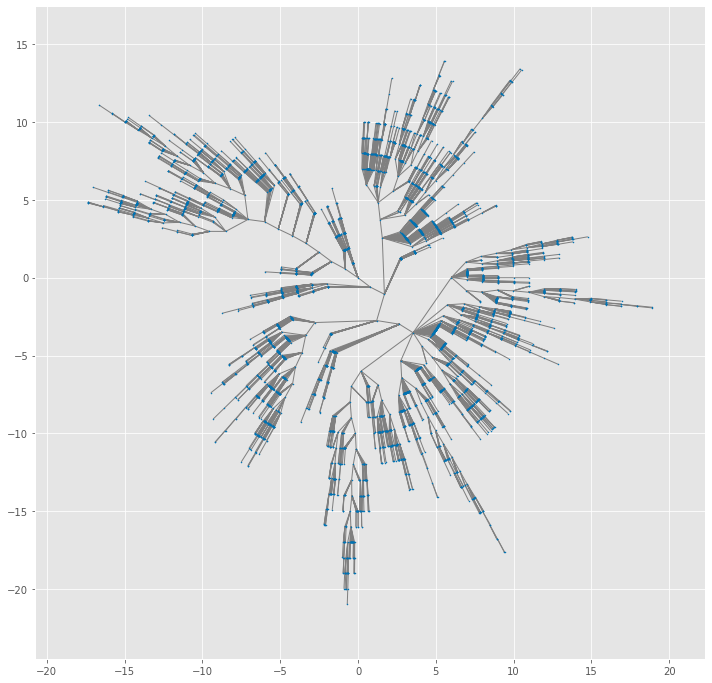

In [112]:
# labels = [g.nodes[i]['label'] for i in g.nodes]
# for i in g.nodes:
#     g.nodes[i]['label'] = ''
    
    

init_layout = 'radial'
# init_layout = 'sfdp'

# # pos0 = nx.layout.planar_layout(g, scale=40)
# # pos0 = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# # pos0 = graphviz_layout(g, prog='twopi')

t0 = time()
if init_layout == 'sfdp':
    pos0 = graphviz_layout(g, prog='sfdp')
    
elif init_layout == 'radial':
    root = list(g.nodes)[np.argmin(d.max(axis=1))] ##center node
#     root = nx.center(g)[0]
    pos0 = radial_layout(g, root)
# pos = rotate(pos0, -math.pi*0.5)
pos = pos0

dt = time() - t0
print(f'{dt} sec')



draw(g, pos, s=1, lw=1, labels=False, figsize=[12,12])
# draw(g, pos, s=10, lw=1, labels=True, figsize=[12,12])


# for i in g.nodes:
#     g.nodes[i]['label'] = labels[i]

## Best scaling

In [113]:
ideal_edge_length = {
    e: g.edges[e]['weight'] 
    for e in g.edges
}
actual_edge_length = {
    (p0,p1): np.linalg.norm(np.array(pos[p1])-np.array(pos[p0]))
    for (p0,p1) in g.edges
}
num = np.sum([ideal_edge_length[k]**2/actual_edge_length[k] for k in g.edges])
den = np.sum([ideal_edge_length[k] for k in g.edges])
s = num / den
print(f's = {s}')

pos = {k:np.array(v)*s for k,v in pos.items()}

s = 409.8743153403715


In [ ]:
# draw(g, pos,s=10, lw=1, labels=False, figsize=[36,36])

In [ ]:
# xy = np.array( [ pos[i2k[i]]for i in range(len(nodes)) ] )
# theta = (xy[:,0] - xy[:,0].min()) / (xy[:,0].max() - xy[:,0].min()) * np.pi*1
# r = (xy[:,1] - xy[:,1].min())
# # r = -(xy[:,1] - xy[:,1].max())

# xy2 = np.c_[r*np.cos(theta), r*np.sin(theta)]
# pos2 = {i2k[i]:xy2[i] for i in range(len(nodes))}
# draw(g, pos2)

# # pos = pos2

In [ ]:
# from umap import UMAP

# n_neighbors = 15

# umap = UMAP(
#     n_components=2,
#     n_neighbors=n_neighbors, 
#     min_dist=0.3,
#     metric='precomputed',
# #     n_epochs=500,
# #     negative_sample_rate=150,
# #     learning_rate=0.0001,
# #     init=np.array(list(pos.values()))
# )
# xy = umap.fit_transform(d)
# pos2 = {i2k[i]:xy[i,:2] for i in range(len(nodes))}


## New Ordering of Nodes

In [114]:
### list of node ids


# if ('math-genealogy' in fn 
#     or 'topics-800' in fn
#     or 'covid' in fn
#    ):
    
print('no re-ordering')
## no re-ordering
node_order = list(g.nodes)
## order preserving re-sort according to level
id2level = {i: g.nodes[i]['level'] for i in g.nodes}
nodeorder_level_pairs = [(i,id2level[i]) for i in node_order]
node_order = [n[0] for n in sorted(nodeorder_level_pairs, key=lambda x:x[1])]
bfs = nx.bfs_tree(g, node_order[0])
node_order = list(bfs) 

# else:
#     #max degree node
#     print('max degree node re-ordering')
#     degree = list(g.degree)
#     degree = list(zip(range(len(degree)), degree))
#     max_degree_node = max(degree, key=lambda x:x[1][1])
#     start = max_degree_node[1][0]
#     bfs = nx.bfs_tree(g, start)
#     node_order = list(bfs) 
    
# #     # random node, bfs
# #     start = next(iter(g.nodes.keys()))
# #     bfs = nx.bfs_tree(g, start)
# #     node_order = list(bfs) 

# #     #dfs
# #     node_order = list(nx.dfs_preorder_nodes(g, start))





no re-ordering


## Crossing removal

In [ ]:
# def isCrossed_1(e0, e1):
#     ##ref: graphic gems 3, "FASTER LINE SEGMENT INTERSECTION", pg.199
#     p1,p2 = e0
#     p3,p4 = e1

#     a = {'x': p2[0]-p1[0], 'y': p2[1]-p1[1]}
#     b = {'x': p3[0]-p4[0], 'y': p3[1]-p4[1]};
#     c = {'x': p1[0]-p3[0], 'y': p1[1]-p3[1]};

#     denom = a['y']*b['x'] - a['x']*b['y']
#     numer = b['y']*c['x'] - b['x']*c['y']
#     if denom > 0:
#         if numer <= 0 or numer >= denom:
#             return False
#     else:
#         if numer >= 0 or numer <= denom:
#             return False

#     numer2 = a['x']*c['y'] - a['y']*c['x']
#     if denom > 0:
#         if numer2 <= 0 or numer2 >= denom:
#             return False
#     else:
#         if numer2 >= 0 or numer2 <= denom:
#             return False
#     return True

# def isCrossed(e, edges):
#     for e2 in edges:
#         if isCrossed_1(e, e2):
#             return True
#     return False


# def initNodePos(id1, id0, pos, pos0, k=0.8):
#     pp1 = np.array(pos0[id1])
#     pp0 = np.array(pos0[id0])
#     v = pp1-pp0

#     p0 = np.array(pos[id0])
#     noise = np.random.randn(2)
#     p1 = p0 + v * k + noise * (1-k) * np.linalg.norm(v)/3
#     return tuple(p1)


In [ ]:
# edge_order = []
# processed_nodes = set()
# for i, nodeId in enumerate(tqdm(node_order)):
#     for neighborId in g.neighbors(nodeId):
#         if neighborId in processed_nodes:
#             edge_order.append((nodeId, neighborId))
#     processed_nodes.add(nodeId)
    
# pos = {
#     node_order[0]: pos0[node_order[0]]
# }
# edges = []

    

In [ ]:
# for newNode, oldNode in tqdm(edge_order[len(edges):]):
#     assert oldNode in pos
#     newPos = pos0[newNode]
#     p0 = pos[oldNode]
#     crossed = isCrossed([newPos,p0], edges)
#     fails = 0
#     while crossed:
#         fails+=1
#         newPos = initNodePos(newNode, oldNode, pos, pos0, k=0.95**fails)
#         crossed = isCrossed([newPos,p0], edges)
        
#     pos[newNode] = newPos
#     newEdge = (newPos, p0)
#     edges.append(newEdge)

In [ ]:
# draw(g.subgraph(pos.keys()), pos, s=0, lw=1, labels=False, figsize=[12,12])
# draw(g, pos, s=10, lw=1, labels=False, figsize=[12,12])

## denaulay

In [24]:
# def simplex2edges(sim, points):
#     res = dict()
#     for t in sim:
#         for i in range(3):
#             a,b = t[i], t[(i+1)%3]
#             if a > b:
#                 a,b = b,a
#             res[(a,b)] = np.linalg.norm(points[a] - points[b])
#     return res

# points = np.array(list(pos[i] for i in node_order))
# tri = Delaunay(points)
# plt.triplot(points[:,0], points[:,1], tri.simplices)
# plt.show()

# denaulayDistance = simplex2edges(tri.simplices, points)

## to JSON

In [115]:
fn_out = fn.replace('dot', 'json').replace('txt', 'json')
fn_out = '.'.join(fn_out.split('.')[:-1])
fn_out += f'-{int(time())}'

if not Path(fn_out).parent.exists():
    os.makedirs(Path(fn_out).parent)
else:
    print(Path(fn_out).parent, 'exists')
fn_out

data/json/topics_steiner exists


'./data/json/topics_steiner/Graph_15-1608744450'

In [116]:
###graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]

nodes = [{
    'id': node_order[i],
    'index': i,
    'x': pos[node_order[i]][0],
    'y': pos[node_order[i]][1],
    'neighbors': list(nx.neighbors(g, node_order[i])),
    'perplexity': len(list(nx.neighbors(g, node_order[i]))),
    **nodes[node_order[i]]
} for i in range(len(nodes))]

edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]



##store the position & perplexity
for i,node in enumerate(nodes):
    try: 
        parent = next(bfs.predecessors(node['id']))
    except StopIteration:
        parent = None
    node['parent'] = parent

maxHop = hops.max()
virtual_edges = []
for i in tqdm(range(len(nodes))):
    for j in range(i+1, len(nodes)):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
        else:
            if hops[i,j] < 10:
                dij = d[i,j]
            else:
                continue
            e = {
                'source': i2k[i],
                'target': i2k[j],
                'weight': dij,
                'hops': hops[i,j]
            }
            virtual_edges.append(e)
            



    
    
    
## option 1: nodes, edges, and virtualEdges with properties
# with open(fn_out, 'w') as f:
#     json.dump(dict(
#         edges = edges, 
#         virtual_edges = virtual_edges, 
#         nodes=nodes
#     ), f, indent=2)
# print('done')

## option 2: properties as arrays
res = {}
for k in nodes[0]:
    print(k)
    res[f'node_{k}'] = [n[k] for n in nodes]
for k in edges[0]:
    res[f'edge_{k}'] = [e[k] for e in edges]

print(fn_out)
with open(fn_out+'-min.json', 'w') as f:
    json.dump(res, f, indent=2)
    
for k in virtual_edges[0]:
    res[f'virtual_edge_{k}'] = [ve[k] for ve in virtual_edges]

print(f'writing {fn_out}+'.json'...')
with open(fn_out+'.json', 'w') as f:
    json.dump(res, f, indent=2)

print('done!')





id
index
x
y
neighbors
perplexity
label
level
nodeCount
weight
parent
./data/json/topics_steiner/Graph_15-1608744450
writing ./data/json/topics_steiner/Graph_15-1608744450...
done!


In [89]:
g.nodes[6]

{'id': 6,
 'label': 'cell culture',
 'level': 13,
 'nodeCount': 3582,
 'weight': 275}

In [ ]:
# with open('data/json/TopicsLayersData-0/Graph_5000-nodes-3.json') as f:
#     j3 = json.load(f)
# with open('data/json/TopicsLayersData-0/Graph_5000.json') as f:
#     j = json.load(f)   
    

In [ ]:
# nodeIds = [n['id'] for n in nodes]
# nodeLabels = [n['label'] for n in nodes]
# nodeLevels = [n['level'] for n in nodes]
# nodeXs = [n['x'] for n in nodes]
# nodeYs = [n['y'] for n in nodes]
# nodePerplexities = [n['perplexity'] for n in nodes]
# nodeParents = [n['parent'] for n in nodes]
# nodeNeighbors = [n['neighbors'] for n in nodes]
# nodeNodeCount = [n['nodeCount'] for n in nodes]
# nodeWeight = [n['weight'] for n in nodes]

# edgeSources = [e['source'] for e in edges]
# edgeTargets = [e['target'] for e in edges]
# edgeLevels = [e['level'] for e in edges]
# edgeWeights = [e['weight'] for e in edges]

# virtualEdgeSources = [e['source'] for e in virtual_edges]
# virtualEdgeTargets = [e['target'] for e in virtual_edges]
# virtualEdgeWeights = [e['weight'] for e in virtual_edges]
# virtualEdgeHops = [e['hops'] for e in virtual_edges]


## output pos for MAP (Ryn）

In [ ]:
# dir_in = './data/json/topics-5000-low-degree/old/'
# fn = 'topics-8-sfdp'
# version = 16



#-------------------------------------------
# paper topics
# dir_in = './data/json/TopicsLayersData-0'
# fn = 'Graph_5000'
# version = 3

# paper lastfm
# dir_in = './data/json/lastfm/'
# fn = 'Graph_8'
# version = 2

#-------------------------------------------

##demo topics
# dir_in = './data/json/TopicsLayersData-0'
# fn = 'Graph_5000-radial'
# version = 7

##demo lastfm
# dir_in = './data/json/lastfm/'
# fn = 'Graph_8'
# version = 12

#-------------------------------------------
## demo, post-submission

##topics
# fn = './data/json/topics_refined/Graph_5000-min.json'
# fn_node = './data/json/topics_refined/Graph_5000-nodes-3.json'

##lastfm
fn = './data/json/lastfm_refined/Graph_8_2587-min.json'
fn_node = './data/json/lastfm_refined/Graph_8_2587-nodes-1.json'



with open(fn) as f:
    data = json.load(f)
with open(fn_node) as f:
    nodes = json.load(f)

label_to_id = {l:i for l,i in zip(data['node_label'], data['node_id'])}
id_to_label = {v:k for k,v in label_to_id.items()}

my_edges = [[id_to_label[i], id_to_label[j]] for i,j in zip(data['edge_source'], data['edge_target'])]
edge_distance = {i:w for i,w in enumerate(data['edge_weight'])}
nodes_to_levels = {label: level for label, level in zip(data['node_label'], data['node_level'])}

crd_x = {n['id']:n['x'] for n in nodes}
crd_y = {n['id']:n['y'] for n in nodes}

In [ ]:
label_to_xy = {l: (crd_x[i], crd_y[i]) for l,i in label_to_id.items()}

xy = np.array([[crd_x[k], crd_y[k]] for k in crd_x])

lines = [
    [(crd_x[label_to_id[l1]], crd_y[label_to_id[l1]]), 
    (crd_x[label_to_id[l2]], crd_y[label_to_id[l2]])] 
    for l1,l2 in my_edges
]

edge_coords = np.array(lines)
s, t = edge_coords[:, 0], edge_coords[:, 1]
actual_length = np.linalg.norm(s - t, axis=1)
ideal_length = np.array(list(edge_distance.values()))

num = np.sum(ideal_length**2/actual_length)
den = np.sum(ideal_length)
s = num / den

relative_error = (actual_length*s - ideal_length) / ideal_length

In [ ]:
## verify pos

fig = plt.figure(figsize=[48,48])
ax = fig.subplots()

xy = np.array([[crd_x[k], crd_y[k]] for k in crd_x])
ax.scatter(xy[:,0], xy[:,1], s=10)


lc = mc.LineCollection(lines, colors='grey', linewidths=1)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

# for l,i in label_to_id.items():
#     plt.text(crd_x[i], crd_y[i], l)
plt.show()
    

In [ ]:
[(g.nodes[e1]['label'],g.nodes[e2]['label']) for (e1,e2) in g.edges if 
 g.nodes[e1]['label']=='South Park'
 or g.nodes[e2]['label']=='South Park'
 or g.nodes[e1]['label']=='Richard Cheese'
 or g.nodes[e2]['label']=='Richard Cheese'

]

In [ ]:
fn_out = 'out.js'
crd_x = {str(n['id']):n['x'] for n in nodes}
crd_y = {str(n['id']):n['y'] for n in nodes}

var = [
    ('my_edges', my_edges),
    ('label_to_id', label_to_id),
    ('id_to_label', id_to_label),
    ('edge_distance', edge_distance),
    ('nodes_to_levels', nodes_to_levels),
    ('crd_x', crd_x),
    ('crd_y', crd_y),
]

with open(fn_out, 'w') as f:
    for var_name, val_value in var:
        f.write(f'{var_name} = ')
        f.write(json.dumps(val_value))
        f.write('\n')
print(fn_out)
        

## Error Analysis

In [ ]:
import matplotlib.gridspec as gridspec

rows, cols = 2, 1
gs = gridspec.GridSpec(rows, cols, width_ratios=[1,], height_ratios=[3,1])
gs.update(left=0.05, right=0.95, wspace=0.1, hspace=0.1)

vmax = 1
cm = plt.cm.get_cmap('coolwarm_r')

# Plot histogram.
plt.figure(figsize=[8,15])

ax = plt.subplot(gs[0,0])
# ax.scatter(xy[:,0], xy[:,1], s=1, zorder=2)
lc = mc.LineCollection(lines, 
                       colors=[cm((e+vmax) / (vmax*2)) for e in relative_error], 
                       linewidths=2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(gs[1,0])
n, bins, patches = plt.hist(relative_error, color='green', bins=60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = (bin_centers + vmax ) / (vmax*2)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

# plt.xlim([-3,3])
plt.xlabel('relative error')
plt.ylabel('# edges')

plt.show()


In [ ]:
label2nodeCount = {g.nodes[n]['label']:g.nodes[n]['nodeCount'] for n in g.nodes}
# label2nodeCount = {k[:16] : v for k,v in label2nodeCount.items()}


In [ ]:

for n in nodes:
    n['nodeCount'] = label2nodeCount[short2long[n['label']]]
    
with open('./data/json/topics-5000-low-degree/old/topics-8-sfdp-nodes-16-2.json', 'w') as f:
    json.dump(nodes, f)

In [ ]:
## reyans layout

In [ ]:
## lastfm

my_edges =  [['Me First and the', 'Less Than Jake'], ['Me First and the', 'Mad Caddies'], ['Me First and the', 'Lagwagon'], ['Me First and the', 'NOFX'], ['Me First and the', 'Rancid'], ['Me First and the', 'Goldfinger'], ['Me First and the', 'Pennywise'], ['Me First and the', 'Millencolin'], ['Me First and the', 'Strung Out'], ['Me First and the', 'Descendents'], ['Me First and the', 'The Vandals'], ['Me First and the', 'Richard Cheese'], ['Me First and the', 'No Use for a Nam'], ['Me First and the', 'The Bouncing Sou'], ['Me First and the', 'MxPx'], ['Me First and the', 'Bad Religion'], ['Millencolin', 'Good Riddance'], ['Strung Out', 'Propagandhi'], ['Strung Out', 'Strike Anywhere'], ['Richard Cheese', ''], ['No Use for a Nam', 'The Ataris'], ['Bad Religion', 'The Offspring'], ['Propagandhi', 'Hot Water Music'], ['Strike Anywhere', 'Comeback Kid'], ['', 'South Park'], ['The Ataris', 'Sugarcult'], ['The Ataris', 'Allister'], ['The Ataris', 'Alkaline Trio'], ['The Ataris', 'Rufio'], ['The Ataris', 'Box Car Racer'], ['The Ataris', 'The Get Up Kids'], ['The Ataris', 'Mest'], ['The Ataris', 'Jimmy Eat World'], ['The Ataris', 'Lit'], ['The Ataris', 'SR-71'], ['The Ataris', 'Autopilot Off'], ['The Ataris', 'Unwritten Law'], ['The Ataris', 'American Hi-Fi'], ['The Ataris', 'Saves the Day'], ['The Ataris', 'Midtown'], ['The Ataris', 'The Starting Lin'], ['The Ataris', 'New Found Glory'], ['The Ataris', 'Amber Pacific'], ['The Offspring', 'Billy Talent'], ['The Offspring', 'Rise Against'], ['The Offspring', 'Red Hot Chili Pe'], ['The Offspring', 'blink-182'], ['The Offspring', 'Tenacious D'], ['The Offspring', 'AFI'], ['The Offspring', 'Green Day'], ['The Offspring', 'Good Charlotte'], ['The Offspring', 'Papa Roach'], ['The Offspring', 'Rage Against the'], ['The Offspring', 'Anti-Flag'], ['The Offspring', 'Bloodhound Gang'], ['The Offspring', 'Sum 41'], ['The Offspring', 'Zebrahead'], ['South Park', 'Adam Sandler'], ['South Park', 'Monty Python'], ['Sugarcult', 'Matchbook Romanc'], ['Sugarcult', 'Angels & Airwave'], ['Sugarcult', 'The All-American'], ['Sugarcult', 'Lostprophets'], ['Sugarcult', 'Bowling for Soup'], ['Sugarcult', 'Wheatus'], ['Sugarcult', "Plain White T's"], ['Sugarcult', 'Yellowcard'], ['Sugarcult', '+44'], ['Box Car Racer', 'Transplants'], ['Jimmy Eat World', 'Further Seems Fo'], ['Lit', 'Fuel'], ['Saves the Day', 'Boys Night Out'], ['The Starting Lin', 'The Matches'], ['Red Hot Chili Pe', 'The White Stripe'], ['Papa Roach', 'Element Eighty'], ['Papa Roach', 'Three Days Grace'], ['Papa Roach', 'Slipknot'], ['Papa Roach', 'Breaking Benjami'], ['Papa Roach', 'Nickelback'], ['Papa Roach', 'Jay-Z and Linkin'], ['Papa Roach', '30 Seconds to Ma'], ['Papa Roach', 'Adema'], ['Papa Roach', 'Crazy Town'], ['Rage Against the', 'Queens of the St'], ['Bloodhound Gang', 'The Presidents o'], ['Bloodhound Gang', 'Guano Apes'], ['Bloodhound Gang', 'CKY'], ['Adam Sandler', 'Dane Cook'], ['Further Seems Fo', 'Dashboard Confes'], ['Further Seems Fo', 'Spitalfield'], ['Further Seems Fo', 'Copeland'], ['Further Seems Fo', 'The Juliana Theo'], ['Further Seems Fo', 'Mae'], ['Fuel', 'Incubus'], ['Fuel', 'Alien Ant Farm'], ['Fuel', 'Finger Eleven'], ['Fuel', 'Default'], ['Fuel', 'Shinedown'], ['Fuel', 'Staind'], ['Fuel', 'Crossfade'], ['Fuel', 'The Verve Pipe'], ['Fuel', 'Chevelle'], ['Fuel', 'Evans Blue'], ['Fuel', 'Hinder'], ['Fuel', 'The Exies'], ['Fuel', 'Bush'], ['Fuel', 'Daughtry'], ['Fuel', 'Smile Empty Soul'], ['Fuel', 'Cold'], ['Fuel', 'Theory of a Dead'], ['Fuel', 'Our Lady Peace'], ['Fuel', '12 Stones'], ['Fuel', 'Creed'], ['Fuel', 'Puddle of Mudd'], ['Fuel', 'Matchbox Twenty'], ['Fuel', 'Trapt'], ['Fuel', 'Alter Bridge'], ['Fuel', '3 Doors Down'], ['Fuel', 'Saliva'], ['Fuel', 'Goo Goo Dolls'], ['The White Stripe', 'Electric Six'], ['The White Stripe', 'The Strokes'], ['The White Stripe', 'John Frusciante'], ['The White Stripe', 'The Hives'], ['The White Stripe', 'Cake'], ['The White Stripe', 'Violent Femmes'], ['The White Stripe', 'Gorillaz'], ['The White Stripe', 'Cold War Kids'], ['The White Stripe', 'The Kills'], ['The White Stripe', 'Pixies'], ['The White Stripe', 'Weezer'], ['The White Stripe', 'The Vines'], ['The White Stripe', 'The Black Keys'], ['The White Stripe', 'Wolfmother'], ['The White Stripe', 'Placebo'], ['The White Stripe', 'Radiohead'], ['The White Stripe', 'The Von Bondies'], ['The White Stripe', 'Zwan'], ['The White Stripe', 'Beck'], ['The White Stripe', 'Jet'], ['The White Stripe', 'The Raconteurs'], ['The White Stripe', 'Franz Ferdinand'], ['The White Stripe', 'Brendan Benson'], ['Slipknot', 'Trivium'], ['Slipknot', 'Stone Sour'], ['Slipknot', 'Dope'], ['Slipknot', 'Ko\\:042fn'], ['Slipknot', 'SOiL'], ['Slipknot', 'Static-X'], ['Slipknot', 'Soulfly'], ['Slipknot', 'Godsmack'], ['Slipknot', 'Mushroomhead'], ['Slipknot', 'System of a Down'], ['Slipknot', 'Otep'], ['Slipknot', 'Disturbed'], ['Slipknot', 'Limp Bizkit'], ['Slipknot', 'Serj Tankian'], ['Slipknot', 'Machine Head'], ['Slipknot', 'Scars On Broadwa'], ['Slipknot', 'Mudvayne'], ['Slipknot', 'Bullet For My Va'], ['Slipknot', 'Ill Niño'], ['Slipknot', 'Kittie'], ['Slipknot', 'Deftones'], ['Slipknot', 'Drowning Pool'], ['Slipknot', 'Linkin Park'], ['Slipknot', 'P.O.D.'], ['Slipknot', 'Avenged Sevenfol'], ['Breaking Benjami', 'Andrew W.K.'], ['Breaking Benjami', 'Flyleaf'], ['Breaking Benjami', 'Skillet'], ['Adema', 'Taproot'], ['Queens of the St', 'Foo Fighters'], ['Queens of the St', 'Mark Lanegan'], ['Queens of the St', 'Kyuss'], ['Queens of the St', 'Fu Manchu'], ['Queens of the St', 'Monster Magnet'], ['Queens of the St', 'Soundgarden'], ['CKY', 'Clutch'], ['CKY', 'Kid Rock'], ['CKY', 'Turbonegro'], ['CKY', 'HIM'], ['Mae', 'Acceptance'], ['Mae', 'Sherwood'], ['Mae', 'Daphne Loves Der'], ['Mae', 'Relient K'], ['Crossfade', 'Seether'], ['Crossfade', 'Chris Daughtry'], ['Crossfade', '10 Years'], ['Crossfade', 'TRUSTcompany'], ['Crossfade', 'Earshot'], ['The Verve Pipe', 'Duncan Sheik'], ['The Verve Pipe', 'Fastball'], ['The Verve Pipe', 'Gin Blossoms'], ['The Verve Pipe', 'Live'], ['The Verve Pipe', 'Deep Blue Someth'], ['The Verve Pipe', 'Vertical Horizon'], ['The Verve Pipe', 'Dishwalla'], ['The Verve Pipe', 'Better Than Ezra'], ['The Verve Pipe', 'Collective Soul'], ['The Verve Pipe', 'Hootie & the Blo'], ['The Verve Pipe', 'Everclear'], ['The Verve Pipe', 'Semisonic'], ['The Verve Pipe', 'Marcy Playground'], ['The Verve Pipe', 'Eve 6'], ['The Verve Pipe', 'Train'], ['The Verve Pipe', 'The Wallflowers'], ['Daughtry', 'Sunrise Avenue'], ['Creed', 'Lenny Kravitz'], ['The Strokes', 'Los Hermanos'], ['Cold War Kids', 'Louis XIV'], ['Cold War Kids', 'Spoon'], ['Cold War Kids', 'Ra Ra Riot'], ['The Kills', 'Be Your Own Pet'], ['The Black Keys', 'Kings of Leon'], ['The Black Keys', 'Eagles of Death '], ['Wolfmother', 'Danko Jones'], ['Franz Ferdinand', 'Keane'], ['Brendan Benson', 'Ed Harcourt'], ['Dope', 'Pain'], ['Machine Head', 'Sepultura'], ['Andrew W.K.', 'Backyard Babies'], ['Flyleaf', 'Thousand Foot Kr'], ['Taproot', 'Sevendust'], ['Taproot', 'Spineshank'], ['Taproot', 'Nonpoint'], ['Taproot', 'Skindred'], ['Taproot', 'Flaw'], ['Mark Lanegan', 'Nick Cave'], ['Soundgarden', 'Alice in Chains'], ['Clutch', 'Helmet'], ['Relient K', 'Switchfoot'], ['Duncan Sheik', 'Paula Cole'], ['Duncan Sheik', 'Howie Day'], ['Duncan Sheik', 'Lisa Loeb'], ['Duncan Sheik', 'Pete Yorn'], ['Duncan Sheik', 'Shawn Colvin'], ['Duncan Sheik', 'Edwin McCain'], ['Duncan Sheik', 'Josh Kelley'], ['Duncan Sheik', 'Tonic'], ['Duncan Sheik', 'Matt Nathanson'], ['Duncan Sheik', 'Toad the Wet Spr'], ['Gin Blossoms', '4 Non Blondes'], ['Dishwalla', 'Blue October'], ['Sunrise Avenue', 'The Last Goodnig'], ['Sunrise Avenue', 'The Calling'], ['Sunrise Avenue', 'The Rasmus'], ['Sunrise Avenue', 'Hoobastank'], ['Sunrise Avenue', 'Silbermond'], ['Sunrise Avenue', 'Poets of the Fal'], ['Sunrise Avenue', 'Reamonn'], ['Sunrise Avenue', 'Simple Plan'], ['Sunrise Avenue', 'OneRepublic'], ['Lenny Kravitz', 'Eagle-Eye Cherry'], ['Lenny Kravitz', "Fun Lovin' Crimi"], ['Los Hermanos', 'Chico Buarque'], ['Ra Ra Riot', 'Phoenix'], ['Ra Ra Riot', 'Bishop Allen'], ['Ra Ra Riot', 'Someone Still Lo'], ['Ra Ra Riot', 'The Stills'], ['Ra Ra Riot', 'Rogue Wave'], ['Be Your Own Pet', 'The Gossip'], ['Be Your Own Pet', 'The Maccabees'], ['Be Your Own Pet', 'Blood Red Shoes'], ['Be Your Own Pet', 'Los Campesinos!'], ['Be Your Own Pet', 'Pretty Girls Mak'], ['Be Your Own Pet', 'Test Icicles'], ['Be Your Own Pet', 'You Say Party! W'], ['Be Your Own Pet', 'The Long Blondes'], ['Be Your Own Pet', 'Yeah Yeah Yeahs'], ['Be Your Own Pet', 'Death From Above'], ['Be Your Own Pet', 'Bikini Kill'], ['Keane', 'The Fray'], ['Keane', 'Muse'], ['Keane', 'The Verve'], ['Keane', 'Athlete'], ['Keane', 'Robbie Williams'], ['Keane', 'The Killers'], ['Keane', 'Aqualung'], ['Keane', 'Snow Patrol'], ['Keane', 'Thirteen Senses'], ['Keane', 'James Blunt'], ['Keane', 'The Feeling'], ['Keane', 'Embrace'], ['Pain', 'Rob Zombie'], ['Pain', 'Fear Factory'], ['Pain', 'Clawfinger'], ['Pain', 'Oomph!'], ['Pain', 'Rammstein'], ['Pain', 'Deathstars'], ['Sepultura', 'Kreator'], ['Sepultura', 'Anthrax'], ['Sepultura', 'Pantera'], ['Sepultura', 'Exodus'], ['Sepultura', 'Lamb of God'], ['Sepultura', 'Slayer'], ['Sepultura', 'Metallica'], ['Sepultura', 'Testament'], ['Sepultura', 'Vader'], ['Sepultura', 'Cannibal Corpse'], ['Nonpoint', '(hed) Planet Ear'], ['Nonpoint', 'Powerman 5000'], ['Nonpoint', 'Coal Chamber'], ['Nonpoint', 'Dry Kill Logic'], ['Nonpoint', 'American Head Ch'], ['Alice in Chains', 'Audioslave'], ['Alice in Chains', 'Mother Love Bone'], ['Alice in Chains', 'Mudhoney'], ['Alice in Chains', 'Mad Season'], ['Alice in Chains', 'Nirvana'], ['Alice in Chains', 'Jerry Cantrell'], ['Alice in Chains', 'Screaming Trees'], ['Alice in Chains', 'Candlebox'], ['Alice in Chains', 'Pearl Jam'], ['Alice in Chains', 'Blind Melon'], ['Alice in Chains', 'Chris Cornell'], ['Alice in Chains', 'A Perfect Circle'], ['Alice in Chains', 'Days of the New'], ['Alice in Chains', 'Stone Temple Pil'], ['Alice in Chains', 'The Smashing Pum'], ['Alice in Chains', 'Eddie Vedder'], ['Alice in Chains', 'Temple of the Do'], ['Helmet', 'Therapy?'], ['Shawn Colvin', 'Beth Orton'], ['Josh Kelley', 'Tristan Prettyma'], ['Tonic', 'Third Eye Blind'], ['Tonic', 'Remy Zero'], ['Tonic', 'Nine Days'], ['Toad the Wet Spr', 'R.E.M.'], ['Toad the Wet Spr', 'Counting Crows'], ['Toad the Wet Spr', 'Sister Hazel'], ['Toad the Wet Spr', 'Barenaked Ladies'], ['Toad the Wet Spr', 'New Radicals'], ['Toad the Wet Spr', 'Crash Test Dummi'], ['Toad the Wet Spr', 'Soul Coughing'], ['4 Non Blondes', 'Spin Doctors'], ['4 Non Blondes', 'Meredith Brooks'], ['4 Non Blondes', 'Soul Asylum'], ['4 Non Blondes', 'Joan Osborne'], ['OneRepublic', 'Rob Thomas'], ['OneRepublic', 'Jon McLaughlin'], ['OneRepublic', 'Lifehouse'], ['OneRepublic', 'Gavin DeGraw'], ['OneRepublic', 'Five for Fightin'], ['OneRepublic', 'Maroon 5'], ['OneRepublic', 'The Script'], ['Chico Buarque', 'Gilberto Gil'], ['Yeah Yeah Yeahs', 'Silversun Pickup'], ['Yeah Yeah Yeahs', 'Cansei de Ser Se'], ['Yeah Yeah Yeahs', 'Santogold'], ['Yeah Yeah Yeahs', 'Tegan and Sara'], ['Yeah Yeah Yeahs', 'Le Tigre'], ['Yeah Yeah Yeahs', 'Metric'], ['The Verve', 'Ocean Colour Sce'], ['The Verve', 'Stereophonics'], ['The Verve', 'Coldplay'], ['The Verve', 'Jarvis Cocker'], ['The Verve', 'Paul Weller'], ['The Verve', 'Spiritualized'], ['The Verve', 'Black Rebel Moto'], ['The Verve', 'The Good, The Ba'], ['The Verve', 'Travis'], ['The Verve', 'Richard Ashcroft'], ['The Verve', 'Mansun'], ['The Verve', 'Blur'], ['The Verve', 'Supergrass'], ['The Verve', 'The Music'], ['The Verve', "Fool's Garden"], ['The Verve', 'The Charlatans'], ['The Verve', "The La's"], ['The Verve', 'Primal Scream'], ['The Verve', 'Ian Brown'], ['The Verve', 'Doves'], ['The Verve', 'Oasis'], ['The Verve', 'Suede'], ['The Verve', 'Manic Street Pre'], ['The Verve', 'The Stone Roses'], ['The Verve', 'Kula Shaker'], ['The Verve', 'Starsailor'], ['The Verve', 'Kasabian'], ['James Blunt', 'Take That'], ['The Feeling', 'Just Jack'], ['Fear Factory', 'White Zombie'], ['Fear Factory', 'Chimaira'], ['Fear Factory', 'Ministry'], ['Fear Factory', 'Strapping Young '], ['Kreator', 'Annihilator'], ['Kreator', 'Venom'], ['Kreator', 'Megadeth'], ['Lamb of God', 'Mastodon'], ['Lamb of God', 'Arch Enemy'], ['Chris Cornell', 'Velvet Revolver'], ['A Perfect Circle', 'dredg'], ['A Perfect Circle', 'Puscifer'], ['A Perfect Circle', 'Riverside'], ['Beth Orton', 'Natalie Merchant'], ['Beth Orton', 'Martha Wainwrigh'], ['Beth Orton', 'Laura Veirs'], ['Beth Orton', '10,000 Maniacs'], ['Beth Orton', 'Rosie Thomas'], ['Beth Orton', 'Ani DiFranco'], ['Beth Orton', 'Indigo Girls'], ['Beth Orton', 'Liz Phair'], ['Beth Orton', 'Aimee Mann'], ['Beth Orton', 'Joan as Police W'], ['Beth Orton', 'Cowboy Junkies'], ['Beth Orton', 'Sarah McLachlan'], ['Beth Orton', 'Dar Williams'], ['Beth Orton', 'Suzanne Vega'], ['Beth Orton', 'Heather Nova'], ['Beth Orton', 'Everything but t'], ['Tristan Prettyma', 'G. Love'], ['Tristan Prettyma', 'Colbie Caillat'], ['Tristan Prettyma', 'Matt Costa'], ['Tristan Prettyma', 'G. Love & Specia'], ['Tristan Prettyma', 'Matt Wertz'], ['Tristan Prettyma', 'Jack Johnson'], ['Tristan Prettyma', 'The Weepies'], ['Tristan Prettyma', 'Rachael Yamagata'], ['Tristan Prettyma', 'Amos Lee'], ['Tristan Prettyma', 'Anna Nalick'], ['Tristan Prettyma', 'Sara Bareilles'], ['Tristan Prettyma', 'Missy Higgins'], ['Tristan Prettyma', 'Brandi Carlile'], ['Tristan Prettyma', 'Ingrid Michaelso'], ['Tristan Prettyma', 'Brett Dennen'], ['Tristan Prettyma', 'Jason Mraz'], ['Tristan Prettyma', 'Justin Nozuka'], ['Tristan Prettyma', 'KT Tunstall'], ['Soul Coughing', 'Eels'], ['Soul Coughing', 'They Might Be Gi'], ['Soul Coughing', 'Harvey Danger'], ['Soul Coughing', 'Ween'], ['Joan Osborne', 'Melissa Etheridg'], ['Joan Osborne', "Sinéad O'Connor"], ['Joan Osborne', 'Patty Griffin'], ['Gilberto Gil', 'João Gilberto'], ['Gilberto Gil', 'Elis Regina'], ['Gilberto Gil', 'Jorge Ben'], ['Gilberto Gil', 'Djavan'], ['Gilberto Gil', 'Marisa Monte'], ['Gilberto Gil', 'Gal Costa'], ['Gilberto Gil', 'Caetano Veloso'], ['Silversun Pickup', 'Death Cab for Cu'], ['Silversun Pickup', 'The Bravery'], ['Jarvis Cocker', 'The Divine Comed'], ['Jarvis Cocker', 'James'], ['Supergrass', 'Ash'], ['Supergrass', 'Pulp'], ['Supergrass', 'Elastica'], ['The Music', 'The Automatic'], ['Primal Scream', 'The Raveonettes'], ['Starsailor', 'Elbow'], ['Starsailor', 'Turin Brakes'], ['Starsailor', 'Delays'], ['Just Jack', 'Daniel Bedingfie'], ['Just Jack', 'Sam Sparro'], ['Just Jack', 'The Streets'], ['Just Jack', 'Basement Jaxx'], ['Just Jack', 'Jamie T'], ['Just Jack', 'Calvin Harris'], ['Just Jack', 'M.I.A.'], ['Just Jack', 'The Ting Tings'], ['Just Jack', 'Sophie Ellis-Bex'], ['Just Jack', 'Estelle'], ['Just Jack', "Stereo MC's"], ['Just Jack', 'Audio Bullys'], ['Venom', 'Danzig'], ['Mastodon', 'Pelican'], ['Mastodon', 'The Dillinger Es'], ['Mastodon', 'Neurosis'], ['Mastodon', 'Meshuggah'], ['Mastodon', 'Isis'], ['Mastodon', 'Tool'], ['Mastodon', 'Opeth'], ['Mastodon', 'Between the Buri'], ['Arch Enemy', 'The Haunted'], ['Arch Enemy', 'Carcass'], ['Arch Enemy', 'Dark Tranquillit'], ['Aimee Mann', 'Rufus Wainwright'], ['Sarah McLachlan', 'Sarah Slean'], ['Heather Nova', 'Maria Mena'], ['Heather Nova', 'Lene Marlin'], ['Heather Nova', 'Sophie Zelmani'], ['Heather Nova', 'Amy Macdonald'], ['Heather Nova', 'Shivaree'], ['Heather Nova', "K's Choice"], ['Everything but t', 'Olive'], ['Everything but t', 'Gus Gus'], ['Matt Costa', 'Xavier Rudd'], ['Matt Costa', 'Pete Murray'], ['G. Love & Specia', 'Everlast'], ['Jack Johnson', 'Dave Matthews & '], ['The Weepies', 'Joe Purdy'], ['The Weepies', 'Maria Taylor'], ['The Weepies', 'Cary Brothers'], ['Ingrid Michaelso', 'Regina Spektor'], ['Justin Nozuka', 'Paolo Nutini'], ['Justin Nozuka', 'Teddy Geiger'], ['Justin Nozuka', 'James Morrison'], ['Melissa Etheridg', 'Jewel'], ['Melissa Etheridg', 'Tracy Chapman'], ['Melissa Etheridg', 'Stevie Nicks'], ['Patty Griffin', 'The Be Good Tany'], ['Patty Griffin', 'Josh Ritter'], ['Patty Griffin', 'Gillian Welch'], ['João Gilberto', 'Astrud Gilberto'], ['Elis Regina', 'Antônio Carlos J'], ['Elis Regina', 'Cibelle'], ['Marisa Monte', 'Vanessa da Mata'], ['The Automatic', 'The Cinematics'], ['The Automatic', 'One Night Only'], ['The Automatic', 'The Zutons'], ['The Automatic', 'Boy Kill Boy'], ['The Automatic', 'Air Traffic'], ['The Automatic', 'Orson'], ['The Automatic', 'Kaiser Chiefs'], ['The Automatic', 'The Rascals'], ['The Automatic', 'Little Man Tate'], ['The Automatic', 'Hard-Fi'], ['The Automatic', 'Milburn'], ['The Automatic', 'We Are Scientist'], ['The Automatic', 'Razorlight'], ['The Automatic', 'The Pigeon Detec'], ['The Automatic', 'The Enemy'], ['The Automatic', 'The View'], ['The Automatic', 'Nine Black Alps'], ['The Automatic', 'The Rakes'], ['The Automatic', 'The Futureheads'], ['The Automatic', 'The Hoosiers'], ['The Automatic', 'The Subways'], ['The Automatic', 'Feeder'], ['The Raveonettes', 'Yo La Tengo'], ['The Raveonettes', 'The Brian Jonest'], ['The Raveonettes', 'The Jesus and Ma'], ['The Raveonettes', 'My Bloody Valent'], ['The Raveonettes', 'Mew'], ['The Raveonettes', 'The Dandy Warhol'], ['Turin Brakes', 'Gomez'], ['Turin Brakes', 'Tom McRae'], ['Turin Brakes', 'The Bluetones'], ['Daniel Bedingfie', 'Daniel Powter'], ['Daniel Bedingfie', 'Will Young'], ['Daniel Bedingfie', 'S Club 7'], ['Daniel Bedingfie', 'Toploader'], ['Daniel Bedingfie', 'Blue'], ['Daniel Bedingfie', 'Ronan Keating'], ['The Streets', 'Roots Manuva'], ['The Streets', 'Dizzee Rascal'], ['Calvin Harris', 'Yelle'], ['Calvin Harris', 'Mylo'], ['Calvin Harris', 'Midnight Juggern'], ['Calvin Harris', 'The Black Ghosts'], ['M.I.A.', 'Spank Rock'], ['M.I.A.', 'Lady Sovereign'], ['M.I.A.', 'Girl Talk'], ['Sophie Ellis-Bex', 'Lily Allen'], ['Sophie Ellis-Bex', 'Scissor Sisters'], ['Sophie Ellis-Bex', 'Annie'], ['Sophie Ellis-Bex', 'Kylie Minogue'], ['Sophie Ellis-Bex', 'Girls Aloud'], ['Sophie Ellis-Bex', 'Darren Hayes'], ['Sophie Ellis-Bex', 'Goldfrapp'], ['Sophie Ellis-Bex', 'September'], ['Sophie Ellis-Bex', 'Madonna'], ['Sophie Ellis-Bex', 'Lady GaGa'], ['Sophie Ellis-Bex', 'Emma Bunton'], ['Sophie Ellis-Bex', 'Rachel Stevens'], ['Sophie Ellis-Bex', 'Siobhan Donaghy'], ['Sophie Ellis-Bex', 'Dannii Minogue'], ['Sophie Ellis-Bex', 'Dragonette'], ['Sophie Ellis-Bex', 'Robyn'], ['Sophie Ellis-Bex', 'Dido'], ['Sophie Ellis-Bex', 'Mika'], ['Sophie Ellis-Bex', 'Gwen Stefani'], ['Sophie Ellis-Bex', 'Melanie C'], ['Sophie Ellis-Bex', 'Geri Halliwell'], ['Sophie Ellis-Bex', 'Sugababes'], ['Sophie Ellis-Bex', 'Róisín Murphy'], ["Stereo MC's", 'Kruder & Dorfmei'], ['Audio Bullys', 'Cassius'], ['Audio Bullys', 'Planet Funk'], ['Audio Bullys', 'Armand van Helde'], ['Audio Bullys', 'Timo Maas'], ['Pelican', 'Red Sparowes'], ['The Dillinger Es', 'Converge'], ['Tool', 'Dream Theater'], ['Tool', 'Pain of Salvatio'], ['The Haunted', 'Bloodbath'], ['Dark Tranquillit', 'Soilwork'], ['Dark Tranquillit', 'Amorphis'], ['Dark Tranquillit', 'Hypocrisy'], ['Dark Tranquillit', 'In Flames'], ['Dark Tranquillit', 'At the Gates'], ['Dark Tranquillit', 'Amon Amarth'], ['Sarah Slean', 'Poe'], ['Sarah Slean', 'My Brightest Dia'], ['Sarah Slean', 'Chantal Kreviazu'], ['Sarah Slean', 'Charlotte Martin'], ['Sarah Slean', 'Tori Amos'], ['Sarah Slean', 'Vienna Teng'], ['Maria Mena', 'Lucie Silvas'], ['Maria Mena', 'Gabriella Cilmi'], ['Maria Mena', 'Katie Melua'], ['Sophie Zelmani', 'Lisa Ekdahl'], ['Sophie Zelmani', 'Eva Cassidy'], ['Dave Matthews & ', 'Dave Matthews'], ['Dave Matthews & ', 'John Mayer'], ['Dave Matthews & ', 'Dave Matthews Ba'], ['Dave Matthews & ', 'Phish'], ['Dave Matthews & ', 'Blues Traveler'], ['Dave Matthews & ', 'The John Butler '], ['Dave Matthews & ', 'David Gray'], ['Dave Matthews & ', 'John Mayer Trio'], ['Dave Matthews & ', 'O.A.R.'], ['Dave Matthews & ', 'Donavon Frankenr'], ['Dave Matthews & ', 'Dispatch'], ['Dave Matthews & ', 'Ray LaMontagne'], ['Regina Spektor', 'Kate Nash'], ['Regina Spektor', 'Emily Haines & t'], ['Regina Spektor', 'Joanna Newsom'], ['Regina Spektor', 'Jenny Lewis with'], ['Regina Spektor', 'Mirah'], ['Regina Spektor', 'The Dresden Doll'], ['Regina Spektor', 'Imogen Heap'], ['Regina Spektor', 'A Fine Frenzy'], ['Regina Spektor', 'Rilo Kiley'], ['Regina Spektor', 'St. Vincent'], ['Teddy Geiger', 'The Click Five'], ['Josh Ritter', 'Josh Rouse'], ['Josh Ritter', 'Ryan Adams'], ['Josh Ritter', 'Ron Sexsmith'], ['Gillian Welch', 'Emmylou Harris'], ['Air Traffic', 'The Holloways'], ['Air Traffic', 'The Kooks'], ['Air Traffic', 'The Wombats'], ['Air Traffic', 'Editors'], ['Air Traffic', 'The Rifles'], ['Milburn', 'The Sunshine Und'], ['Milburn', 'Art Brut'], ['Milburn', 'The Ordinary Boy'], ['Milburn', 'The Dead 60s'], ['Razorlight', 'Glasvegas'], ['Nine Black Alps', 'The Cooper Templ'], ['Yo La Tengo', 'Sebadoh'], ['Yo La Tengo', 'Stereolab'], ['Yo La Tengo', 'Galaxie 500'], ['Yo La Tengo', 'The Sea and Cake'], ['Yo La Tengo', 'Broadcast'], ['Yo La Tengo', 'Silver Jews'], ['Yo La Tengo', 'Low'], ['Yo La Tengo', 'Sonic Youth'], ['Yo La Tengo', 'The Beta Band'], ['Yo La Tengo', 'Pavement'], ['Yo La Tengo', 'The Walkmen'], ['Yo La Tengo', 'Guided by Voices'], ['The Brian Jonest', 'Ride'], ['My Bloody Valent', 'Cocteau Twins'], ['Mew', 'Kashmir'], ['Will Young', 'Boyzone'], ['Ronan Keating', 'Enrique Iglesias'], ['Mylo', 'Stardust'], ['Annie', 'Alphabeat'], ['Kylie Minogue', 'Infernal'], ['Siobhan Donaghy', 'Mutya Buena'], ['Gwen Stefani', 'Ashlee Simpson'], ['Kruder & Dorfmei', 'DJ Krush'], ['Kruder & Dorfmei', 'Thievery Corpora'], ['Kruder & Dorfmei', 'Zero 7'], ['Kruder & Dorfmei', 'Boozoo Bajou'], ['Kruder & Dorfmei', 'Nightmares on Wa'], ['Kruder & Dorfmei', 'Tosca'], ['Kruder & Dorfmei', 'Waldeck'], ['Kruder & Dorfmei', 'Thunderball'], ['Kruder & Dorfmei', 'dZihan & Kamien'], ['Kruder & Dorfmei', 'Groove Armada'], ['Kruder & Dorfmei', 'Peace Orchestra'], ['Kruder & Dorfmei', 'FC/Kahuna'], ['Planet Funk', 'Modjo'], ['Armand van Helde', 'Deep Dish'], ['Armand van Helde', 'Shapeshifters'], ['Armand van Helde', 'Axwell'], ['Timo Maas', 'Paul Oakenfold'], ['Red Sparowes', 'A Silver Mt. Zio'], ['Dream Theater', 'Liquid Tension E'], ['Bloodbath', 'Nile'], ['Amon Amarth', 'Ensiferum'], ['Lisa Ekdahl', 'Stacey Kent'], ['Phish', 'Grateful Dead'], ['John Mayer Trio', 'B.B. King & Eric'], ['Dispatch', 'Citizen Cope'], ['Dispatch', 'Guster'], ['Dispatch', 'Slightly Stoopid'], ['Dispatch', 'The Beautiful Gi'], ['Mirah', 'Kaki King'], ['Imogen Heap', 'Frou Frou'], ['The Click Five', 'Busted'], ['The Click Five', 'Jonas Brothers'], ['The Click Five', 'McFly'], ['The Click Five', 'Quietdrive'], ['Emmylou Harris', 'Steve Earle'], ['Emmylou Harris', 'Alison Krauss'], ['Emmylou Harris', 'Dolly Parton'], ['Emmylou Harris', 'Townes Van Zandt'], ['The Cooper Templ', 'Idlewild'], ['The Cooper Templ', 'British Sea Powe'], ['The Cooper Templ', '...And You Will '], ['The Cooper Templ', 'Secret Machines'], ['Sebadoh', 'The Breeders'], ['Galaxie 500', 'Red House Painte'], ['Sonic Youth', 'Joy Division'], ['The Walkmen', 'The Thermals'], ['Enrique Iglesias', 'Ricky Martin'], ['Enrique Iglesias', 'Reik'], ['Enrique Iglesias', 'Westlife'], ['Enrique Iglesias', 'Paulina Rubio'], ['Enrique Iglesias', 'Chayanne'], ['Enrique Iglesias', 'Backstreet Boys'], ['Enrique Iglesias', 'Thalía'], ['Enrique Iglesias', 'Shakira'], ['Infernal', 'Cascada'], ['Infernal', 'Alcazar'], ['Infernal', 'Uniting Nations'], ['Infernal', 'Ian Van Dahl'], ['Infernal', 'Groove Coverage'], ['Mutya Buena', 'All Saints'], ['Mutya Buena', 'Shayne Ward'], ['Mutya Buena', 'Jamelia'], ['Mutya Buena', 'Atomic Kitten'], ['Mutya Buena', 'Amerie'], ['Mutya Buena', 'Stacie Orrico'], ['Ashlee Simpson', 'Paris Hilton'], ['Ashlee Simpson', 'Hilary Duff'], ['Ashlee Simpson', 'Mandy Moore'], ['Ashlee Simpson', 'Ryan Cabrera'], ['Ashlee Simpson', 'Avril Lavigne'], ['Ashlee Simpson', 'Britney Spears'], ['Ashlee Simpson', 'Ashley Tisdale'], ['Ashlee Simpson', 'Vanessa Carlton'], ['Ashlee Simpson', 'Lindsay Lohan'], ['Ashlee Simpson', 'Jessica Simpson'], ['Ashlee Simpson', 'Natasha Bedingfi'], ['Ashlee Simpson', 'No Doubt'], ['Ashlee Simpson', 'P!nk'], ['Ashlee Simpson', 'Nelly Furtado'], ['Ashlee Simpson', 'The Veronicas'], ['Ashlee Simpson', 'Kelly Osbourne'], ['Ashlee Simpson', 'Pink'], ['Ashlee Simpson', 'Michelle Branch'], ['Ashlee Simpson', 'Aly & AJ'], ['Ashlee Simpson', 'Katy Perry'], ['Ashlee Simpson', 'Vanessa Hudgens'], ['Ashlee Simpson', 'The Pussycat Dol'], ['Ashlee Simpson', 'JoJo'], ['Ashlee Simpson', 'Kelly Clarkson'], ['Ashlee Simpson', 'Miley Cyrus'], ['Ashlee Simpson', 'Christina Aguile'], ['DJ Krush', 'Coldcut'], ['DJ Krush', 'Wax Tailor'], ['DJ Krush', 'DJ Shadow'], ['DJ Krush', 'DJ Food'], ['DJ Krush', 'Massive Attack'], ['DJ Krush', 'Sofa Surfers'], ['DJ Krush', 'DJ Cam'], ['DJ Krush', 'Cut Chemist'], ['DJ Krush', 'RJD2'], ['DJ Krush', 'The Herbaliser'], ['DJ Krush', 'Kid Koala'], ['DJ Krush', 'Red Snapper'], ['DJ Krush', 'Tricky'], ['DJ Krush', 'Funki Porcini'], ['DJ Krush', 'Blockhead'], ['DJ Krush', 'Bonobo'], ['DJ Krush', 'DJ Vadim'], ['dZihan & Kamien', 'Nitin Sawhney'], ['dZihan & Kamien', 'Afterlife'], ['dZihan & Kamien', 'Federico Aubele'], ['dZihan & Kamien', 'Blue States'], ['dZihan & Kamien', 'Yonderboi'], ['dZihan & Kamien', 'Llorca'], ['dZihan & Kamien', 'De-Phazz'], ['dZihan & Kamien', 'Parov Stelar'], ['dZihan & Kamien', 'Gabin'], ['dZihan & Kamien', 'Nicola Conte'], ['dZihan & Kamien', 'Bent'], ['dZihan & Kamien', 'Lemongrass'], ['dZihan & Kamien', 'Kinobe'], ['dZihan & Kamien', 'Beanfield'], ['FC/Kahuna', 'Underworld'], ['FC/Kahuna', 'Dirty Vegas'], ['FC/Kahuna', 'Röyksopp'], ['FC/Kahuna', 'Jakatta'], ['Deep Dish', 'David Guetta'], ['Deep Dish', 'Sasha'], ['Deep Dish', 'Gabriel & Dresde'], ['Deep Dish', 'Junior Jack'], ['Deep Dish', 'Roger Sanchez'], ['A Silver Mt. Zio', 'Do Make Say Thin'], ['A Silver Mt. Zio', '65daysofstatic'], ['A Silver Mt. Zio', 'Sigur Rós'], ['A Silver Mt. Zio', 'Explosions in th'], ['A Silver Mt. Zio', 'Godspeed You! Bl'], ['A Silver Mt. Zio', 'Mono'], ['A Silver Mt. Zio', 'Mogwai'], ['A Silver Mt. Zio', 'Efterklang'], ['Nile', 'Morbid Angel'], ['Nile', 'Napalm Death'], ['Nile', 'Death'], ['Nile', 'Behemoth'], ['Nile', 'Deicide'], ['Ensiferum', 'Kalmah'], ['Ensiferum', 'Korpiklaani'], ['Ensiferum', 'Children of Bodo'], ['Ensiferum', 'Norther'], ['Ensiferum', 'Finntroll'], ['Ensiferum', 'Turisas'], ['Stacey Kent', 'Peter Cincotti'], ['Stacey Kent', 'Lizz Wright'], ['Stacey Kent', 'Diana Krall'], ['Stacey Kent', 'Cassandra Wilson'], ['B.B. King & Eric', 'Johnny Winter'], ['Kaki King', 'Rodrigo y Gabrie'], ['Alison Krauss', 'Dixie Chicks'], ['Joy Division', 'New Order'], ['Joy Division', 'She Wants Reveng'], ['Joy Division', 'Interpol'], ['Joy Division', 'Bauhaus'], ['Joy Division', 'The Cure'], ['Joy Division', 'Siouxsie and the'], ['Joy Division', 'Morrissey'], ['Joy Division', 'Buzzcocks'], ['Joy Division', 'The Smiths'], ['Ricky Martin', 'Luis Miguel'], ['Shakira', 'Belanova'], ['Uniting Nations', 'StoneBridge'], ['Uniting Nations', 'Global Deejays'], ['Uniting Nations', 'Booty Luv'], ['Uniting Nations', 'Michael Gray'], ['Uniting Nations', 'Vinylshakerz'], ['Ian Van Dahl', 'Fragma'], ['Hilary Duff', 'A*Teens'], ['Hilary Duff', 'Jesse McCartney'], ['Britney Spears', 'Justin Timberlak'], ['Britney Spears', 'Spice Girls'], ['Jessica Simpson', 'Katharine McPhee'], ['Jessica Simpson', '*NSYNC'], ['No Doubt', 'Alanis Morissett'], ['No Doubt', 'Sublime'], ['No Doubt', 'Hole'], ['No Doubt', 'The Cardigans'], ['No Doubt', '311'], ['No Doubt', 'Sheryl Crow'], ['No Doubt', 'The Cranberries'], ['No Doubt', 'Garbage'], ['No Doubt', 'Smash Mouth'], ['No Doubt', 'Skunk Anansie'], ['No Doubt', 'Sugar Ray'], ['No Doubt', 'Fiona Apple'], ['No Doubt', 'Veruca Salt'], ['The Veronicas', 'Delta Goodrem'], ['Michelle Branch', 'The Wreckers'], ['The Pussycat Dol', 'Mariah Carey'], ['DJ Shadow', 'Dr. Octagon'], ['DJ Shadow', 'Diplo'], ['Massive Attack', 'The Dust Brother'], ['DJ Cam', 'Up, Bustle and O'], ['DJ Cam', '9 Lazy 9'], ['Blockhead', 'Daedelus'], ['Bonobo', 'Lemon Jelly'], ['Afterlife', 'José Padilla'], ['Llorca', 'Dimitri From Par'], ['Llorca', 'Micatone'], ['Llorca', 'The Funky Lowliv'], ['Llorca', 'Trüby Trio'], ['Llorca', 'Kyoto Jazz Massi'], ['Llorca', 'Minus 8'], ['Llorca', "Mo' Horizons"], ['Llorca', 'Beady Belle'], ['Llorca', 'Koop'], ['Llorca', 'St. Germain'], ['Llorca', 'Nuspirit Helsink'], ['Llorca', 'Hird'], ['De-Phazz', 'Gotan Project'], ['De-Phazz', 'Stéphane Pompoug'], ['Underworld', 'Laurent Garnier'], ['David Guetta', 'Laurent Wolf'], ['Gabriel & Dresde', 'Armin van Buuren'], ['Do Make Say Thin', 'Tortoise'], ['Godspeed You! Bl', 'This Will Destro'], ['Godspeed You! Bl', 'God Is an Astron'], ['Death', 'Nevermore'], ['Behemoth', 'Satyricon'], ['Norther', 'Sentenced'], ['Johnny Winter', 'John Mayall & Th'], ['Johnny Winter', 'J.J. Cale'], ['Johnny Winter', 'B.B. King'], ['Johnny Winter', 'Gary Moore'], ['Johnny Winter', 'Stevie Ray Vau02'], ['Johnny Winter', 'Buddy Guy'], ['Johnny Winter', 'John Mayall'], ['Johnny Winter', 'Taj Mahal'], ['Johnny Winter', 'Ten Years After'], ['Johnny Winter', 'Eric Clapton'], ['Johnny Winter', 'Rory Gallagher'], ['Johnny Winter', 'Canned Heat'], ['Johnny Winter', 'Albert King'], ['Rodrigo y Gabrie', 'Gipsy Kings'], ['Rodrigo y Gabrie', 'Paco de Lucía'], ['Dixie Chicks', 'Shania Twain'], ['Dixie Chicks', 'Faith Hill'], ['Dixie Chicks', 'LeAnn Rimes'], ['Dixie Chicks', 'Carrie Underwood'], ['She Wants Reveng', 'IAMX'], ['Bauhaus', 'The Sisters of M'], ['Buzzcocks', 'The Jam'], ['Buzzcocks', 'Ramones'], ['Luis Miguel', 'Maná'], ['Luis Miguel', 'Gloria Estefan'], ['Luis Miguel', 'Sin Bandera'], ['Luis Miguel', 'Ricardo Arjona'], ['Luis Miguel', 'Alejandro Sanz'], ['Global Deejays', 'Fedde le Grand'], ['Global Deejays', 'Benassi Bros.'], ['Global Deejays', 'Supermode'], ['Global Deejays', 'Benny Benassi'], ['Global Deejays', 'Pakito'], ['Fragma', 'DJ Shog'], ['Fragma', 'Milk Inc.'], ['Fragma', 'Alice Deejay'], ['Fragma', 'Lasgo'], ['Fragma', 'System F'], ['Fragma', 'Novaspace'], ['Fragma', 'Kate Ryan'], ['Fragma', '4 Strings'], ['Fragma', 'Sash!'], ['Fragma', 'DJ Sammy'], ['Fragma', 'ATB'], ['Fragma', 'iiO'], ['Fragma', 'Sylver'], ['Sublime', 'The Mighty Might'], ['Sublime', 'Bedouin Soundcla'], ['Hole', 'Sleater-Kinney'], ['Hole', 'The Donnas'], ['Hole', 'Auf der Maur'], ['Hole', 'L7'], ['Delta Goodrem', 'Natalie Imbrugli'], ['Delta Goodrem', 'Sandi Thom'], ['Delta Goodrem', 'Anastacia'], ['Mariah Carey', 'Brandy'], ['Mariah Carey', 'Mary J. Blige'], ['Mariah Carey', 'Kelly Rowland'], ['Mariah Carey', 'Fergie'], ['Mariah Carey', 'Beyoncé'], ['Mariah Carey', 'Toni Braxton'], ['Mariah Carey', 'Jennifer Lopez'], ['Mariah Carey', 'Ashanti'], ['Mariah Carey', 'Whitney Houston'], ['Mariah Carey', 'Jennifer Hudson'], ['Mariah Carey', 'Céline Dion'], ['Mariah Carey', 'Leona Lewis'], ['Mariah Carey', 'Alicia Keys'], ['Mariah Carey', 'Solange'], ['Mariah Carey', 'Keyshia Cole'], ['Mariah Carey', "Destiny's Child"], ['Mariah Carey', 'Michelle William'], ['Mariah Carey', 'Janet Jackson'], ['The Dust Brother', 'David Holmes'], ['The Dust Brother', 'Amon Tobin'], ['The Dust Brother', 'Clint Mansell'], ['The Dust Brother', 'Propellerheads'], ['The Dust Brother', 'UNKLE'], ['The Dust Brother', 'Death in Vegas'], ['The Dust Brother', 'Rob Dougan'], ['The Dust Brother', 'Craig Armstrong'], ['9 Lazy 9', 'Mr. Scruff'], ['9 Lazy 9', 'Quantic'], ['9 Lazy 9', 'Jaga Jazzist'], ['9 Lazy 9', 'Wagon Christ'], ['Daedelus', 'Prefuse 73'], ['Dimitri From Par', 'Ian Pooley'], ['Kyoto Jazz Massi', 'Jazzanova'], ['Kyoto Jazz Massi', '4hero'], ['Minus 8', 'Jazzamor'], ['Beady Belle', 'Alice Russell'], ['Laurent Wolf', 'Martin Solveig'], ['Laurent Wolf', 'Bob Sinclar'], ['Laurent Wolf', 'Guru Josh Projec'], ['Armin van Buuren', 'Tiësto'], ['Armin van Buuren', 'Kyau vs. Albert'], ['Armin van Buuren', 'Motorcycle'], ['Tortoise', 'Slint'], ['Nevermore', 'Evergrey'], ['Satyricon', 'Emperor'], ['Sentenced', 'Paradise Lost'], ['John Mayall & Th', 'Chris Rea'], ['Buddy Guy', 'Bo Diddley'], ['Buddy Guy', 'John Lee Hooker'], ['Buddy Guy', 'The Blues Brothe'], ['Buddy Guy', 'Muddy Waters'], ['Taj Mahal', 'Ry Cooder'], ['Eric Clapton', 'The Jimi Hendrix'], ['Rory Gallagher', 'Free'], ['Rory Gallagher', 'Thin Lizzy'], ['Gipsy Kings', 'Ojos de Brujo'], ['Faith Hill', 'Lonestar'], ['Faith Hill', 'Taylor Swift'], ['The Sisters of M', 'Type O Negative'], ['The Sisters of M', 'The 69 Eyes'], ['Gloria Estefan', 'Celia Cruz'], ['Ricardo Arjona', 'Juanes'], ['System F', 'Mauro Picotto'], ['System F', 'Chicane'], ['DJ Sammy', 'Eiffel 65'], ['DJ Sammy', 'O-Zone'], ['DJ Sammy', 'Darude'], ['The Mighty Might', 'The Suicide Mach'], ['The Mighty Might', 'Catch 22'], ['The Mighty Might', 'Big D and the Ki'], ['The Mighty Might', 'Operation Ivy'], ['The Mighty Might', 'Reel Big Fish'], ['The Mighty Might', 'The Aquabats'], ['Anastacia', 'Sarah Connor'], ['Brandy', 'Tamia'], ['Mary J. Blige', "Lil' Kim"], ['Kelly Rowland', 'Kat DeLuna'], ['Toni Braxton', 'Anita Baker'], ['Ashanti', 'Aaliyah'], ['Ashanti', 'Kelis'], ['Ashanti', 'TLC'], ['Ashanti', 'Mya'], ['Jennifer Hudson', 'Joss Stone'], ['David Holmes', 'Fila Brazillia'], ['David Holmes', 'Terranova'], ['David Holmes', 'Aim'], ['David Holmes', 'Kid Loco'], ['UNKLE', 'Lamb'], ['UNKLE', 'Faithless'], ['UNKLE', 'Thom Yorke'], ['UNKLE', 'Sneaker Pimps'], ['UNKLE', 'Leftfield'], ['UNKLE', 'Kosheen'], ['UNKLE', 'Portishead'], ['UNKLE', 'Hooverphonic'], ['UNKLE', 'I Monster'], ['UNKLE', 'Archive'], ['UNKLE', 'Martina Topley-B'], ['UNKLE', 'Jay-Jay Johanson'], ['UNKLE', 'Beth Gibbons & R'], ['UNKLE', 'Télépopmusik'], ['Craig Armstrong', 'Zbigniew Preisne'], ['Craig Armstrong', 'Harry Gregson-Wi'], ['Craig Armstrong', 'Thomas Newman'], ['Quantic', 'The Quantic Soul'], ['Jaga Jazzist', 'Xploding Plastix'], ['Jaga Jazzist', 'Bugge Wesseltoft'], ['Jaga Jazzist', 'The Cinematic Or'], ['Jaga Jazzist', 'Skalpel'], ['Ian Pooley', 'Blue Six'], ['Ian Pooley', 'Kaskade'], ['4hero', 'LTJ Bukem'], ['Guru Josh Projec', 'Eric Prydz'], ['Guru Josh Projec', 'Alex Gaudino'], ['Guru Josh Projec', 'Yves Larock'], ['Kyau vs. Albert', 'Andain'], ['Emperor', 'Burzum'], ['Emperor', 'Cradle of Filth'], ['Emperor', 'Immortal'], ['Emperor', 'Dimmu Borgir'], ['Chris Rea', 'Mark Knopfler'], ['Chris Rea', 'Sting'], ['Chris Rea', 'Dire Straits'], ['Chris Rea', 'Chris Isaak'], ['Chris Rea', 'Chris de Burgh'], ['Chris Rea', 'Smokie'], ['Chris Rea', 'Robert Plant'], ['Chris Rea', 'Rod Stewart'], ['Chris Rea', 'Joe Cocker'], ['John Lee Hooker', 'Ray Charles'], ['Ry Cooder', 'John Hiatt'], ['Ry Cooder', 'Van Morrison'], ['Ry Cooder', 'Bonnie Raitt'], ['Ry Cooder', 'Dr. John'], ['Ry Cooder', 'Lucinda Williams'], ['The Jimi Hendrix', 'Cream'], ['The Jimi Hendrix', 'The Who'], ['The Jimi Hendrix', '13th Floor Eleva'], ['The Jimi Hendrix', 'Steppenwolf'], ['The Jimi Hendrix', 'The Rolling Ston'], ['The Jimi Hendrix', 'Derek and The Do'], ['The Jimi Hendrix', 'Janis Joplin'], ['The Jimi Hendrix', 'Big Brother & Th'], ['The Jimi Hendrix', 'Jimi Hendrix'], ['The Jimi Hendrix', 'Led Zeppelin'], ['The Jimi Hendrix', 'Stevie Ray Vaugh'], ['The Jimi Hendrix', 'Jefferson Airpla'], ['The Jimi Hendrix', 'The Doors'], ['The Jimi Hendrix', 'Creedence Clearw'], ['The Jimi Hendrix', 'The Allman Broth'], ['The Jimi Hendrix', 'The Yardbirds'], ['The Jimi Hendrix', 'Blind Faith'], ['The Jimi Hendrix', 'The Velvet Under'], ['Thin Lizzy', 'KISS'], ['Thin Lizzy', 'Rainbow'], ['Thin Lizzy', 'Uriah Heep'], ['Thin Lizzy', 'Deep Purple'], ['Thin Lizzy', 'The Darkness'], ['Thin Lizzy', 'Nazareth'], ['Ojos de Brujo', 'Macaco'], ['Lonestar', 'Toby Keith'], ['Lonestar', 'Martina McBride'], ['Lonestar', 'Kenny Chesney'], ['Lonestar', 'Keith Urban'], ['Lonestar', 'Tim McGraw'], ['Lonestar', 'Garth Brooks'], ['Lonestar', 'Rascal Flatts'], ['Taylor Swift', 'Brad Paisley'], ['Celia Cruz', 'Marc Anthony'], ['Juanes', 'Julieta Venegas'], ['Juanes', 'La Oreja de Van '], ['Mauro Picotto', 'Marco V'], ['Mauro Picotto', 'Rank 1'], ['Mauro Picotto', 'Paul van Dyk'], ['Mauro Picotto', 'Safri Duo'], ['Mauro Picotto', 'Cosmic Gate'], ['Chicane', 'Way Out West'], ['Chicane', 'Robert Miles'], ['Chicane', 'Conjure One'], ['Chicane', 'Solar Stone'], ['Chicane', 'Blank & Jones'], ['Chicane', 'Above & Beyond'], ['Chicane', 'Schiller'], ['Chicane', 'BT'], ['Chicane', 'Markus Schulz'], ['Chicane', 'Ferry Corsten'], ['Eiffel 65', 'Vengaboys'], ['Darude', 'Scooter'], ["Lil' Kim", 'Salt-N-Pepa'], ["Lil' Kim", 'P. Diddy'], ["Lil' Kim", 'LL Cool J'], ["Lil' Kim", 'Monica'], ["Lil' Kim", 'Missy Elliott'], ["Lil' Kim", 'Ciara'], ["Lil' Kim", 'Eve'], ['Kat DeLuna', 'Cassie'], ['Kat DeLuna', 'Danity Kane'], ['Kat DeLuna', 'Christina Milian'], ['Kat DeLuna', 'Jordin Sparks'], ['Kat DeLuna', 'Keri Hilson'], ['Kat DeLuna', 'Nicole Scherzing'], ['Kat DeLuna', 'Rihanna'], ['Kat DeLuna', 'Cherish'], ['Anita Baker', 'Randy Crawford'], ['Anita Baker', 'Chaka Khan'], ['Anita Baker', 'Al Jarreau'], ['Anita Baker', 'Luther Vandross'], ['TLC', 'Faith Evans'], ['TLC', "Des'ree"], ['TLC', 'En Vogue'], ['TLC', 'Tweet'], ['Joss Stone', 'Adele'], ['Joss Stone', 'Duffy'], ['Joss Stone', 'Angie Stone'], ['Joss Stone', 'Jamie Cullum'], ['Joss Stone', 'Aretha Franklin'], ['Joss Stone', 'Corinne Bailey R'], ['Joss Stone', 'Amy Winehouse'], ['Joss Stone', 'Macy Gray'], ['Kid Loco', 'Jon Kennedy'], ['Kid Loco', 'Alpha'], ['Faithless', 'Moby'], ['Thom Yorke', 'Apparat'], ['Thom Yorke', 'LCD Soundsystem'], ['Portishead', 'Morcheeba'], ['Portishead', 'Pati Yang'], ['Portishead', 'Mandalay'], ['Portishead', 'Smoke City'], ['Portishead', 'Air'], ['Portishead', 'Moloko'], ['Portishead', 'Björk'], ['Zbigniew Preisne', 'Kronos Quartet'], ['Harry Gregson-Wi', 'Klaus Badelt'], ['The Quantic Soul', 'Jamiroquai'], ['Skalpel', 'Us3'], ['Sting', 'Simply Red'], ['Chris de Burgh', 'Cliff Richard'], ['Van Morrison', 'Steve Winwood'], ['Van Morrison', 'Crosby, Stills &'], ['Van Morrison', 'Bruce Springstee'], ['Van Morrison', 'Bob Dylan and Th'], ['Van Morrison', 'Crosby, Stills, '], ['Van Morrison', 'James Taylor'], ['Van Morrison', 'Jackson Browne'], ['Van Morrison', 'The Band'], ['Dr. John', 'The Meters'], ['13th Floor Eleva', 'MC5'], ['Steppenwolf', 'Foghat'], ['Jefferson Airpla', 'Iron Butterfly'], ['Nazareth', 'Slade'], ['Nazareth', 'Sweet'], ['Macaco', 'Chambao'], ['Macaco', 'Amparanoia'], ['Macaco', 'Bebe'], ['Tim McGraw', 'Alan Jackson'], ['La Oreja de Van ', 'El Canto del Loc'], ['Safri Duo', 'Brooklyn Bounce'], ['Safri Duo', "Gigi D'Agostino"], ['Conjure One', 'Bliss'], ['Schiller', 'Enigma'], ['Scooter', 'Pulsedriver'], ['Scooter', 'Basshunter'], ['Scooter', 'Special D.'], ['LL Cool J', 'Ludacris'], ['Chaka Khan', 'The Brand New He'], ['Chaka Khan', 'Incognito'], ['Apparat', 'Autechre'], ['Apparat', 'Ellen Allien & A'], ['Apparat', 'Ellen Allien'], ['Apparat', 'Four Tet'], ['Apparat', 'Plaid'], ['Apparat', 'MUM'], ['Apparat', 'Arovane'], ['Apparat', 'Telefon Tel Aviv'], ['Apparat', 'Dntel'], ['Apparat', 'Nathan Fake'], ['LCD Soundsystem', 'Hot Chip'], ['LCD Soundsystem', 'Hercules and Lov'], ['LCD Soundsystem', 'Soulwax'], ['LCD Soundsystem', 'The Rapture'], ['LCD Soundsystem', 'TV on the Radio'], ['LCD Soundsystem', 'The Presets'], ['LCD Soundsystem', 'Junior Boys'], ['LCD Soundsystem', 'The Chemical Bro'], ['LCD Soundsystem', 'Ratatat'], ['LCD Soundsystem', 'Justice'], ['LCD Soundsystem', 'New Young Pony C'], ['LCD Soundsystem', 'Datarock'], ['LCD Soundsystem', '!!!'], ['LCD Soundsystem', 'Junior Senior'], ['LCD Soundsystem', 'The Avalanches'], ['LCD Soundsystem', 'Cut Copy'], ['LCD Soundsystem', 'The Whip'], ['LCD Soundsystem', 'Fujiya & Miyagi'], ['Pati Yang', 'Emiliana Torrini'], ['Pati Yang', 'Bang Gang'], ['Pati Yang', 'Anja Garbarek'], ['Pati Yang', 'Blue Foundation'], ['Pati Yang', 'Emilie Simon'], ['Smoke City', 'Bitter:Sweet'], ['Kronos Quartet', 'Arvo Pärt'], ['Kronos Quartet', 'Penguin Cafe Orc'], ['Kronos Quartet', 'Samuel Barber'], ['Kronos Quartet', 'Philip Glass'], ['Kronos Quartet', 'Michael Nyman'], ['Klaus Badelt', 'Howard Shore'], ['Klaus Badelt', 'John Williams'], ['Klaus Badelt', 'James Newton How'], ['Klaus Badelt', 'James Horner'], ['Klaus Badelt', 'Alan Silvestri'], ['Klaus Badelt', 'Danny Elfman'], ['Klaus Badelt', 'Hans Zimmer'], ['Klaus Badelt', 'Jerry Goldsmith'], ['Simply Red', 'Annie Lennox'], ['Simply Red', 'Robert Palmer'], ['Simply Red', 'Tina Turner'], ['Simply Red', "Terence Trent D'"], ['Simply Red', 'Lisa Stansfield'], ['Simply Red', 'Eurythmics'], ['Simply Red', 'Sade'], ['Simply Red', 'Lighthouse Famil'], ['Simply Red', 'Mike & The Mecha'], ['Simply Red', 'Seal'], ['Simply Red', 'Spandau Ballet'], ['Simply Red', 'Phil Collins'], ['Simply Red', 'Barry White'], ['Simply Red', 'Gabrielle'], ['James Taylor', 'John Denver'], ['The Band', 'Traffic'], ['The Meters', 'Booker T. & The '], ['The Meters', 'Sly & The Family'], ['MC5', 'The Hellacopters'], ['MC5', 'The Sonics'], ['Foghat', 'Ted Nugent'], ['Foghat', 'Lynyrd Skynyrd'], ['Foghat', 'Peter Frampton'], ['Foghat', 'Joe Walsh'], ['Foghat', 'Status Quo'], ['Foghat', 'Bad Company'], ['Foghat', 'The Guess Who'], ['Foghat', 'UFO'], ['Foghat', 'ZZ Top'], ['Foghat', 'Bob Seger'], ['Foghat', 'The Doobie Broth'], ['Foghat', 'Bachman-Turner O'], ['Foghat', 'The J. Geils Ban'], ['Foghat', 'Grand Funk Railr'], ['Foghat', 'Cheap Trick'], ['Foghat', 'Humble Pie'], ['Foghat', 'Blue Öyster Cult'], ['Foghat', 'Steve Miller Ban'], ['Bebe', 'Amaral'], ['Bebe', 'Melendi'], ['Bebe', 'Estopa'], ['Bebe', 'Jarabe de Palo'], ['Ludacris', 'Wyclef Jean'], ['Ludacris', 'Nelly'], ['Ludacris', 'T.I.'], ['Ludacris', 'OutKast'], ['Ludacris', 'Ying Yang Twins'], ['Ludacris', 'Fabolous'], ['Ludacris', 'Bubba Sparxxx'], ['Ludacris', 'Jay-Z'], ['Ludacris', 'Young Jeezy'], ['Ludacris', 'Chamillionaire'], ['Ludacris', 'Lil Jon & The Ea'], ['Ludacris', 'Rick Ross'], ['Ludacris', 'The Game'], ['Ludacris', 'Chingy'], ['Ludacris', 'Will Smith'], ['Ludacris', 'Twista'], ['Ludacris', "Lil' Wayne"], ['Ludacris', 'Kanye West'], ['Ludacris', 'Notorious B.I.G.'], ['Ludacris', 'Eminem'], ['Ludacris', 'T-Pain'], ['The Brand New He', 'Roy Ayers'], ['Four Tet', 'Tunng'], ['Four Tet', 'Caribou'], ['Four Tet', 'Manitoba'], ['Four Tet', 'Aphex Twin'], ['Plaid', 'LFO'], ['Arovane', 'Mouse on Mars'], ['Arovane', 'Boards of Canada'], ['Arovane', 'Ulrich Schnauss'], ['Nathan Fake', 'Gui Boratto'], ['Nathan Fake', 'Ricardo Villalob'], ['Hercules and Lov', 'Ladyhawke'], ['TV on the Radio', 'Ugly Casanova'], ['Junior Boys', 'Zoot Woman'], ['Junior Boys', 'Erlend Øye'], ['Junior Boys', 'Van She'], ['Junior Boys', 'The Knife'], ['Junior Boys', 'Empire of the Su'], ['The Chemical Bro', 'Overseer'], ['Justice', 'DJ Mehdi'], ['The Whip', 'Hadouken!'], ['Emiliana Torrini', 'Ane Brun'], ['Emiliana Torrini', 'Stina Nordenstam'], ['Bitter:Sweet', 'Wax Poetic'], ['Bitter:Sweet', 'Kate Havnevik'], ['Bitter:Sweet', 'Esthero'], ['Bitter:Sweet', 'Flunk'], ['Bitter:Sweet', 'Supreme Beings o'], ['Bitter:Sweet', 'Brazilian Girls'], ['Bitter:Sweet', 'Jem'], ['Bitter:Sweet', 'Sia'], ['Philip Glass', 'Dmitri Shostakov'], ['Philip Glass', 'Erik Satie'], ['James Horner', 'Bernard Herrmann'], ['James Horner', 'John Barry'], ['Annie Lennox', 'Cher'], ['Annie Lennox', 'Kate Bush'], ['Spandau Ballet', 'Wham!'], ['Spandau Ballet', 'Culture Club'], ['Spandau Ballet', 'Bryan Ferry'], ['Spandau Ballet', 'Fine Young Canni'], ['Spandau Ballet', 'Visage'], ['Spandau Ballet', 'Simple Minds'], ['Spandau Ballet', 'A Flock of Seagu'], ['Spandau Ballet', 'Nik Kershaw'], ['Spandau Ballet', 'Duran Duran'], ['Spandau Ballet', 'Ultravox'], ['Spandau Ballet', 'Cutting Crew'], ['Spandau Ballet', 'Orchestral Manoe'], ['Spandau Ballet', 'a-ha'], ['Spandau Ballet', 'Thompson Twins'], ['Spandau Ballet', 'Heaven 17'], ['Spandau Ballet', 'Tears for Fears'], ['Spandau Ballet', 'ABC'], ['Spandau Ballet', 'Paul Young'], ['Spandau Ballet', 'Level 42'], ['Spandau Ballet', 'The Human League'], ['Spandau Ballet', 'Frankie Goes to '], ['Barry White', "The O'Jays"], ['John Denver', 'Barry Manilow'], ['John Denver', 'Neil Diamond'], ['John Denver', 'Jim Croce'], ['John Denver', 'Kenny Rogers'], ['John Denver', 'Jimmy Buffett'], ['John Denver', 'Gordon Lightfoot'], ['John Denver', 'Carpenters'], ['John Denver', 'Don McLean'], ['Joe Walsh', 'Fleetwood Mac'], ['Joe Walsh', 'Three Dog Night'], ['Joe Walsh', 'Eddie Money'], ['Joe Walsh', 'Don Henley'], ['ZZ Top', 'Motörhead'], ['ZZ Top', 'AC/DC'], ['ZZ Top', 'The Black Crowes'], ['The Doobie Broth', 'Styx'], ['Cheap Trick', 'Big Star'], ['Jarabe de Palo', 'Los Rodríguez'], ['Wyclef Jean', 'Puff Daddy'], ['Wyclef Jean', 'Lauryn Hill'], ['Wyclef Jean', 'Black Eyed Peas'], ['Wyclef Jean', 'Akon'], ['Wyclef Jean', 'Madcon'], ['Wyclef Jean', 'will.i.am'], ['Ying Yang Twins', 'Trick Daddy'], ['Ying Yang Twins', 'Petey Pablo'], ['Ying Yang Twins', 'Lil Jon'], ['Ying Yang Twins', 'Pitbull'], ['Jay-Z', 'Mos Def'], ["Lil' Wayne", 'Three 6 Mafia'], ["Lil' Wayne", 'Juelz Santana'], ['Kanye West', 'Pharrell'], ['Kanye West', 'Clipse'], ['Kanye West', 'Timbaland'], ['Kanye West', 'Gnarls Barkley'], ['Eminem', 'Lloyd Banks'], ['Aphex Twin', 'AFX'], ['Aphex Twin', 'µ-Ziq'], ['Aphex Twin', 'Squarepusher'], ['Aphex Twin', 'Venetian Snares'], ['Aphex Twin', 'Luke Vibert'], ['Ugly Casanova', 'Sunset Rubdown'], ['Ugly Casanova', 'The Microphones'], ['Ugly Casanova', 'Wolf Parade'], ['Ugly Casanova', 'Built to Spill'], ['Ugly Casanova', 'Broken Social Sc'], ['Ugly Casanova', "Tapes 'n Tapes"], ['Ugly Casanova', 'Modest Mouse'], ['Ugly Casanova', 'Neutral Milk Hot'], ['Ugly Casanova', 'Clap Your Hands '], ['Ugly Casanova', 'Sparklehorse'], ['Overseer', 'The Crystal Meth'], ['Overseer', 'Fatboy Slim'], ['Overseer', 'Mint Royale'], ['Overseer', 'Prodigy'], ['Overseer', 'Junkie XL'], ['Overseer', 'Hybrid'], ['Overseer', 'Apollo 440'], ['Overseer', 'Freestylers'], ['Overseer', 'The Prodigy'], ['Overseer', 'Lunatic Calm'], ['Overseer', 'Fluke'], ['DJ Mehdi', 'Boys Noize'], ['DJ Mehdi', 'MSTRKRFT'], ['DJ Mehdi', 'Chromeo'], ['DJ Mehdi', 'SebastiAn'], ['DJ Mehdi', 'Daft Punk'], ['DJ Mehdi', 'Justice vs Simia'], ['DJ Mehdi', 'Uffie'], ['Hadouken!', 'Shitdisco'], ['Hadouken!', 'Crystal Castles'], ['Hadouken!', 'Klaxons'], ['Hadouken!', 'The Teenagers'], ['Hadouken!', 'Does It Offend Y'], ['Kate Havnevik', 'Butterfly Bouche'], ['Dmitri Shostakov', 'Modest Petrovich'], ['Kate Bush', 'Bat for Lashes'], ['Kate Bush', 'PJ Harvey'], ['Kate Bush', 'Peter Gabriel'], ['Kate Bush', 'Marianne Faithfu'], ['Kate Bush', 'The Sugarcubes'], ['Wham!', 'Lionel Richie'], ['Wham!', 'Billy Ocean'], ['Wham!', 'George Michael'], ['Wham!', 'Rick Astley'], ['Wham!', 'Wet Wet Wet'], ['Wham!', 'Dead or Alive'], ['Fine Young Canni', 'Alison Moyet'], ['Simple Minds', 'Men at Work'], ['A Flock of Seagu', 'Soft Cell'], ['A Flock of Seagu', 'Berlin'], ['A Flock of Seagu', 'Japan'], ['A Flock of Seagu', 'The Buggles'], ['A Flock of Seagu', 'Talk Talk'], ['a-ha', 'Camouflage'], ['a-ha', 'Howard Jones'], ['Paul Young', 'Michael Bolton'], ['The Human League', 'Devo'], ['Frankie Goes to ', 'Falco'], ["The O'Jays", 'The Isley Brothe'], ["The O'Jays", 'The Spinners'], ["The O'Jays", 'War'], ["The O'Jays", 'Earth, Wind & Fi'], ["The O'Jays", 'Donny Hathaway'], ["The O'Jays", 'Commodores'], ["The O'Jays", 'Isaac Hayes'], ["The O'Jays", 'Al Green'], ["The O'Jays", 'Roberta Flack'], ["The O'Jays", 'Bill Withers'], ["The O'Jays", 'Bobby Womack'], ["The O'Jays", 'Minnie Riperton'], ["The O'Jays", 'Stevie Wonder'], ['Carpenters', 'Carly Simon'], ['Fleetwood Mac', 'America'], ['Eddie Money', 'Kenny Loggins'], ['Motörhead', 'Black Label Soci'], ['Styx', 'Eagles'], ['Styx', 'Journey'], ['Styx', 'Heart'], ['Styx', 'Electric Light O'], ['Styx', 'Rush'], ['Styx', 'Boston'], ['Styx', 'Asia'], ['Styx', 'John Mellencamp'], ['Styx', 'Foreigner'], ['Styx', 'Toto'], ['Styx', 'Supertramp'], ['Styx', 'The Moody Blues'], ['Styx', 'Kansas'], ['Styx', 'REO Speedwagon'], ['Los Rodríguez', 'Soda Stereo'], ['Los Rodríguez', 'Los Fabulosos Ca'], ['Los Rodríguez', 'Andrés Calamaro'], ['Los Rodríguez', 'Joaquín Sabina'], ['Lauryn Hill', 'Musiq'], ['Black Eyed Peas', 'Flipsyde'], ['Black Eyed Peas', 'Fort Minor'], ['Black Eyed Peas', 'Flo Rida'], ['Black Eyed Peas', 'Sean Paul'], ['Trick Daddy', 'Mims'], ['Pitbull', 'Daddy Yankee'], ['Mos Def', 'Blackalicious'], ['Mos Def', 'Nas'], ['Mos Def', 'Common'], ['Mos Def', 'Lupe Fiasco'], ['Mos Def', 'De La Soul'], ['Mos Def', 'Jurassic 5'], ['Mos Def', 'Black Star'], ['Mos Def', 'Little Brother'], ['Mos Def', 'Q-Tip'], ['Mos Def', 'The Pharcyde'], ['Mos Def', 'Fugees'], ['Mos Def', 'A Tribe Called Q'], ['Mos Def', 'The Roots'], ['Mos Def', 'Handsome Boy Mod'], ['Mos Def', 'Gang Starr'], ['Juelz Santana', "Cam'ron"], ['Lloyd Banks', 'Young Buck'], ['Lloyd Banks', 'Ja Rule'], ['Lloyd Banks', 'G-Unit'], ['Lloyd Banks', '50 Cent'], ['Lloyd Banks', 'Jadakiss'], ['Lloyd Banks', 'Obie Trice'], ['Lloyd Banks', 'D12'], ['Lloyd Banks', 'Jim Jones'], ['Sunset Rubdown', 'Casiotone for th'], ['Sunset Rubdown', 'Destroyer'], ['The Microphones', 'Panda Bear'], ['The Microphones', 'Akron/Family'], ['The Microphones', 'The Books'], ['The Microphones', 'Smog'], ['Broken Social Sc', 'Apostle of Hustl'], ['Neutral Milk Hot', 'The Apples in St'], ['Prodigy', 'Pendulum'], ['Prodigy', "Bomfunk MC's"], ['Boys Noize', 'Goose'], ['Boys Noize', 'Vitalic'], ['Butterfly Bouche', 'Bonnie Somervill'], ['Butterfly Bouche', 'Nerina Pallot'], ['Modest Petrovich', 'Igor Stravinsky'], ['Modest Petrovich', 'Felix Mendelssoh'], ['Peter Gabriel', 'David Gilmour'], ['Alison Moyet', 'The Beautiful So'], ['Alison Moyet', 'Barbra Streisand'], ['Alison Moyet', 'Grace Jones'], ['Alison Moyet', 'Texas'], ['Alison Moyet', 'Erasure'], ['Alison Moyet', 'Pet Shop Boys'], ['Alison Moyet', 'Cyndi Lauper'], ['Alison Moyet', 'Yazoo'], ['Alison Moyet', 'k.d. lang'], ['Alison Moyet', 'Bette Midler'], ['Men at Work', 'INXS'], ['Men at Work', 'Huey Lewis & The'], ['Men at Work', 'Midnight Oil'], ['Men at Work', 'The Police'], ['Men at Work', 'Mr. Mister'], ['The Buggles', 'Men Without Hats'], ['The Buggles', 'Thomas Dolby'], ['Devo', 'Sparks'], ['Devo', 'Echo & The Bunny'], ['Devo', 'David Byrne'], ['Devo', 'Public Image Ltd'], ['Devo', 'The Cars'], ['Devo', 'Gary Numan'], ['Devo', 'Talking Heads'], ['Devo', 'Oingo Boingo'], ['Devo', "The B-52's"], ['Devo', 'Wire'], ['Devo', 'XTC'], ['Devo', 'The Psychedelic '], ['Devo', 'Adam and the Ant'], ['Devo', 'Gang of Four'], ['Falco', 'Nena'], ['Falco', 'Herbert Grönemey'], ['Falco', 'Alphaville'], ['The Isley Brothe', 'Rick James'], ['Bill Withers', 'Otis Redding'], ['Bill Withers', 'Sam & Dave'], ['Bill Withers', 'Curtis Mayfield'], ['Bill Withers', 'Sam Cooke'], ['Bill Withers', 'James Brown'], ['Bill Withers', 'Wilson Pickett'], ['Bobby Womack', 'Gil Scott-Heron'], ['Bobby Womack', 'Solomon Burke'], ['Carly Simon', 'Olivia Newton-Jo'], ['Carly Simon', 'Carole King'], ['America', 'Steely Dan'], ['Electric Light O', 'Paul McCartney'], ['REO Speedwagon', 'Air Supply'], ['REO Speedwagon', 'Survivor'], ['Los Fabulosos Ca', 'Café Tacuba'], ['Musiq', 'Jamie Foxx'], ['Musiq', 'Brian McKnight'], ['Musiq', 'Joe'], ['Musiq', 'Robin Thicke'], ['Musiq', 'Jill Scott'], ['Musiq', 'Erykah Badu'], ['Musiq', 'John Legend'], ['Musiq', "D'Angelo"], ['Musiq', 'Maxwell'], ['Musiq', 'Boyz II Men'], ['Musiq', 'Anthony Hamilton'], ['Musiq', 'India.Arie'], ['Sean Paul', 'Shaggy'], ['Sean Paul', 'Sizzla'], ['Sean Paul', 'Gentleman'], ['Sean Paul', 'Damian Marley'], ['Sean Paul', 'Seeed'], ['Sean Paul', 'Culcha Candela'], ['Sean Paul', 'Beenie Man'], ['Mims', 'Soulja Boy'], ['Daddy Yankee', 'Don Omar'], ['Blackalicious', 'Arrested Develop'], ['Q-Tip', 'Madlib'], ['Q-Tip', 'N*E*R*D'], ['A Tribe Called Q', 'Eric B. & Rakim'], ['Gang Starr', 'Masta Ace'], ['Gang Starr', 'Immortal Techniq'], ['50 Cent', 'Snoop Dogg'], ['Casiotone for th', 'Her Space Holida'], ['Casiotone for th', 'Xiu Xiu'], ['Destroyer', 'Final Fantasy'], ['Smog', 'Cat Power'], ['The Apples in St', 'The Flaming Lips'], ['The Apples in St', 'of Montreal'], ['The Apples in St', 'Belle and Sebast'], ['The Apples in St', 'The Unicorns'], ['The Apples in St', 'Oh No! Oh My!'], ['The Apples in St', 'Islands'], ['The Apples in St', 'Beulah'], ['The Apples in St', 'The Fiery Furnac'], ['The Apples in St', 'Mates of State'], ['The Apples in St', 'The Polyphonic S'], ['The Apples in St', 'Architecture in '], ['The Apples in St', 'The Go! Team'], ['The Apples in St', 'The Magnetic Fie'], ['The Apples in St', 'The New Pornogra'], ['Vitalic', 'Modeselektor'], ['Vitalic', 'Miss Kittin'], ['Vitalic', 'Digitalism'], ['Vitalic', 'Alter Ego'], ['Vitalic', 'Miss Kittin & Th'], ['Vitalic', 'Felix da Houseca'], ['Vitalic', 'Simian Mobile Di'], ['Vitalic', 'Fischerspooner'], ['Vitalic', 'Surkin'], ['Vitalic', 'Mr. Oizo'], ['Vitalic', 'Tiga'], ['Vitalic', 'Kavinsky'], ['Vitalic', 'Zombie Nation'], ['Felix Mendelssoh', 'Gustav Holst'], ['Felix Mendelssoh', 'Gustav Mahler'], ['Felix Mendelssoh', 'Robert Schumann'], ['Felix Mendelssoh', 'Antonio Vivaldi'], ['Felix Mendelssoh', 'Johann Strauss I'], ['Felix Mendelssoh', 'Franz Joseph Hay'], ['Felix Mendelssoh', 'Jean Sibelius'], ['Felix Mendelssoh', 'Franz Liszt'], ['Felix Mendelssoh', 'Edvard Grieg'], ['Felix Mendelssoh', 'Johann Pachelbel'], ['Felix Mendelssoh', 'Maurice Ravel'], ['Felix Mendelssoh', 'Gioacchino Rossi'], ['Felix Mendelssoh', 'Johannes Brahms'], ['Felix Mendelssoh', 'Giuseppe Verdi'], ['Felix Mendelssoh', 'Franz Schubert'], ['Felix Mendelssoh', 'Georg Friedrich '], ['Felix Mendelssoh', 'Wolfgang Amadeus'], ['Felix Mendelssoh', 'Richard Wagner'], ['Felix Mendelssoh', 'Ludwig van Beeth'], ['Felix Mendelssoh', 'Frédéric Chopin'], ['Felix Mendelssoh', 'Georges Bizet'], ['Felix Mendelssoh', 'Camille Saint-Sa'], ['Felix Mendelssoh', 'Richard Strauss'], ['Felix Mendelssoh', 'Sergei Prokofiev'], ['Felix Mendelssoh', 'Sir Edward Elgar'], ['Felix Mendelssoh', 'Gabriel Fauré'], ['Felix Mendelssoh', 'Luigi Boccherini'], ['Felix Mendelssoh', 'Sergei Rachmanin'], ['Felix Mendelssoh', 'Pyotr Ilyich Tch'], ['Felix Mendelssoh', 'Hector Berlioz'], ['Felix Mendelssoh', 'Johann Sebastian'], ['Felix Mendelssoh', 'Antonín Dvo\\:015'], ['Felix Mendelssoh', 'Tomaso Giovanni '], ['David Gilmour', 'Page & Plant'], ['David Gilmour', 'Syd Barrett'], ['David Gilmour', 'Yes'], ['David Gilmour', 'King Crimson'], ['David Gilmour', 'Emerson, Lake & '], ['David Gilmour', 'Genesis'], ['David Gilmour', 'Camel'], ['David Gilmour', 'Roger Waters'], ['David Gilmour', 'The Alan Parsons'], ['David Gilmour', 'Pink Floyd'], ['The Beautiful So', 'Crowded House'], ['Erasure', 'Electronic'], ['Cyndi Lauper', 'Donna Summer'], ['Cyndi Lauper', 'Paula Abdul'], ['Cyndi Lauper', 'Kim Carnes'], ['Cyndi Lauper', 'Pat Benatar'], ['Cyndi Lauper', 'Laura Branigan'], ['Bette Midler', 'Judy Garland'], ['Echo & The Bunny', 'The Church'], ['Public Image Ltd', 'The Fall'], ["The B-52's", "The Go-Go's"], ["The B-52's", 'Bow Wow Wow'], ["The B-52's", 'The Pretenders'], ['Wire', 'The Replacements'], ['Wire', 'Killing Joke'], ['XTC', 'The The'], ['Adam and the Ant', 'The Boomtown Rat'], ['Herbert Grönemey', 'Annett Louisan'], ['Herbert Grönemey', 'Juli'], ['Herbert Grönemey', '2raumwohnung'], ['Herbert Grönemey', 'Rosenstolz'], ['Herbert Grönemey', 'Wir sind Helden'], ['Alphaville', 'Yello'], ['Alphaville', 'Sandra'], ['Rick James', 'Prince & The Rev'], ['Rick James', 'Funkadelic'], ['Rick James', 'Ohio Players'], ['Rick James', 'Parliament'], ['Rick James', 'Cameo'], ['Rick James', 'Prince'], ['Sam Cooke', 'Percy Sledge'], ['Olivia Newton-Jo', 'The Pointer Sist'], ['Olivia Newton-Jo', 'Irene Cara'], ['Paul McCartney', 'Wings'], ['Paul McCartney', 'Ringo Starr'], ['Paul McCartney', 'The Kinks'], ['Paul McCartney', 'The Beatles'], ['Paul McCartney', 'George Harrison'], ['Paul McCartney', 'The Hollies'], ['Paul McCartney', 'John Lennon'], ['Paul McCartney', 'Tom Petty'], ['Paul McCartney', 'Billy Joel'], ['Paul McCartney', 'Brian Wilson'], ['Paul McCartney', 'Elton John'], ['Paul McCartney', 'The Beach Boys'], ['Paul McCartney', 'Chicago'], ['Paul McCartney', 'Paul Simon'], ['Paul McCartney', 'Paul McCartney &'], ['Café Tacuba', 'Aterciopelados'], ['Café Tacuba', 'Enanitos Verdes'], ['Joe', 'Usher'], ['Joe', 'Omarion'], ['Joe', 'Marques Houston'], ['Joe', 'K-Ci & JoJo'], ['Joe', 'Babyface'], ['Joe', '112'], ['Joe', 'Ginuwine'], ['Joe', 'R. Kelly'], ['Joe', 'Jagged Edge'], ['Joe', 'Ne-Yo'], ['Joe', 'Lloyd'], ['Joe', 'Bobby Valentino'], ['Joe', 'Ray J'], ['Joe', 'Mario'], ['Joe', 'Craig David'], ['Gentleman', 'Ziggy Marley'], ['Seeed', 'Patrice'], ['Seeed', 'Peter Fox'], ['Beenie Man', 'Capleton'], ['Beenie Man', 'Buju Banton'], ['Beenie Man', 'Anthony B'], ['Masta Ace', 'Murs'], ['Masta Ace', 'Dilated Peoples'], ['Masta Ace', 'Redman'], ['Masta Ace', 'KRS-One'], ['Masta Ace', 'M.O.P.'], ['Masta Ace', 'Talib Kweli'], ['Masta Ace', 'Guru'], ['Masta Ace', 'CunninLynguists'], ['Masta Ace', 'Pharoahe Monch'], ['Masta Ace', 'dead prez'], ['Immortal Techniq', 'Big L'], ['Immortal Techniq', 'Sage Francis'], ['Immortal Techniq', 'Jedi Mind Tricks'], ['Immortal Techniq', 'Atmosphere'], ['Immortal Techniq', 'Flobots'], ['Snoop Dogg', 'Bone Thugs-N-Har'], ['Snoop Dogg', 'N.W.A'], ['Snoop Dogg', '2Pac'], ['Snoop Dogg', 'Fat Joe'], ['Snoop Dogg', 'Ice Cube'], ['Snoop Dogg', 'Coolio'], ['Snoop Dogg', 'Warren G'], ['Snoop Dogg', 'Eazy-E'], ['Snoop Dogg', 'Dr. Dre'], ['Her Space Holida', 'Bright Eyes'], ['Her Space Holida', 'The Faint'], ['Her Space Holida', 'Coconut Records'], ['Her Space Holida', 'The Postal Servi'], ['Final Fantasy', 'The Most Serene '], ['The Fiery Furnac', 'Enon'], ['The Polyphonic S', 'Mercury Rev'], ['The Polyphonic S', "I'm From Barcelo"], ['The Polyphonic S', 'Arcade Fire'], ['The Polyphonic S', 'The Magic Number'], ['Architecture in ', 'Au Revoir Simone'], ['Alter Ego', 'Tiefschwarz'], ['Miss Kittin & Th', 'ADULT.'], ['Surkin', 'Alex Gopher'], ['Kavinsky', 'Sébastien Tellie'], ['Robert Schumann', 'Claude Debussy'], ['Gioacchino Rossi', 'Luciano Pavarott'], ['Georg Friedrich ', 'Henry Purcell'], ['Georg Friedrich ', 'Georg Philipp Te'], ['Emerson, Lake & ', 'Focus'], ['Electronic', 'Happy Mondays'], ['Electronic', 'Art of Noise'], ['Electronic', 'The Lightning Se'], ['Electronic', '808 State'], ['Donna Summer', 'KC and the Sunsh'], ['Pat Benatar', 'Billy Idol'], ['Judy Garland', 'Shirley Bassey'], ['Judy Garland', 'Doris Day'], ['Judy Garland', 'Eartha Kitt'], ['The Replacements', 'Mission of Burma'], ['The Replacements', 'The Lemonheads'], ['The Replacements', 'Dinosaur Jr.'], ['The Replacements', 'The Hold Steady'], ['The Replacements', 'Hüsker Dü'], ['The Replacements', 'Minutemen'], ['The Replacements', 'Meat Puppets'], ['The Boomtown Rat', 'Elvis Costello &'], ['The Boomtown Rat', 'Blondie'], ['The Boomtown Rat', 'Squeeze'], ['The Boomtown Rat', 'The Stranglers'], ['The Boomtown Rat', 'The Undertones'], ['The Boomtown Rat', 'The Knack'], ['Juli', 'Sportfreunde Sti'], ['2raumwohnung', 'Die Fantastische'], ['Sandra', 'Roxette'], ['Sandra', 'Bananarama'], ['Sandra', 'Kim Wilde'], ['Sandra', 'Modern Talking'], ['Sandra', 'Belinda Carlisle'], ['The Pointer Sist', 'Hall & Oates'], ['The Kinks', 'Love'], ['George Harrison', 'Tom Petty and th'], ['The Hollies', 'The Spencer Davi'], ['The Hollies', "The Lovin' Spoon"], ['The Hollies', 'The Troggs'], ['The Hollies', "Herman's Hermits"], ['The Hollies', 'The Turtles'], ['The Hollies', 'The Animals'], ['The Hollies', 'The Small Faces'], ['The Hollies', 'The Mamas & The '], ['The Hollies', 'The Byrds'], ['The Hollies', 'Buffalo Springfi'], ['The Hollies', 'The Monkees'], ['The Hollies', 'The Zombies'], ['The Hollies', 'Roy Orbison'], ['The Hollies', 'Manfred Mann'], ['Jagged Edge', 'Blackstreet'], ['Lloyd', 'Chris Brown'], ['Lloyd', 'Bow Wow'], ['Lloyd', 'Sean Kingston'], ['Bobby Valentino', 'Baby Bash'], ['Ziggy Marley', 'Burning Spear'], ['Redman', 'Ghostface'], ['Redman', 'Method Man & Red'], ['Redman', 'Busta Rhymes'], ['Redman', 'Method Man'], ['Redman', 'Naughty by Natur'], ['Redman', 'Wu-Tang Clan'], ['Redman', 'Raekwon'], ['Redman', 'DMX'], ['Redman', 'Mobb Deep'], ['Redman', "Ol' Dirty Bastar"], ['Redman', 'Xzibit'], ['Ice Cube', 'Public Enemy'], ['Coolio', 'Vanilla Ice'], ['Coconut Records', 'The Format'], ['Coconut Records', 'Sondre Lerche'], ['The Postal Servi', 'MGMT'], ['The Postal Servi', 'The Notwist'], ['Enon', 'Menomena'], ['Enon', 'Q and Not U'], ['Enon', 'The Dismembermen'], ['Enon', 'Les Savy Fav'], ['Enon', 'Clinic'], ['Enon', 'Stephen Malkmus'], ['Enon', 'Blonde Redhead'], ['Enon', 'Deerhoof'], ['Enon', 'The Wrens'], ['Arcade Fire', 'Fleet Foxes'], ['The Magic Number', 'Black Kids'], ['The Magic Number', 'Scouting for Gir'], ['The Magic Number', 'The Bees'], ['The Magic Number', 'I Am Kloot'], ['The Magic Number', 'Voxtrot'], ['The Magic Number', 'The Thrills'], ['The Magic Number', 'Elefant'], ['Au Revoir Simone', 'The Bird and the'], ['Au Revoir Simone', 'Feist'], ['Au Revoir Simone', 'El Perro del Mar'], ['Au Revoir Simone', 'The Concretes'], ['Au Revoir Simone', 'The Blow'], ['Au Revoir Simone', 'Psapp'], ['Au Revoir Simone', 'Lykke Li'], ['Au Revoir Simone', 'Stars'], ['Au Revoir Simone', 'Camera Obscura'], ['Au Revoir Simone', 'The Boy Least Li'], ['Au Revoir Simone', 'Beach House'], ['Au Revoir Simone', 'Tilly and the Wa'], ['Au Revoir Simone', 'Nouvelle Vague'], ['Au Revoir Simone', 'Azure Ray'], ['Au Revoir Simone', 'Kings of Conveni'], ['Au Revoir Simone', 'The Pipettes'], ['Au Revoir Simone', 'The Whitest Boy '], ['Tiefschwarz', 'Booka Shade'], ['Tiefschwarz', 'Swayzak'], ['ADULT.', 'Peaches'], ['ADULT.', 'Client'], ['ADULT.', 'Vive la Fête'], ['ADULT.', 'Chicks on Speed'], ['ADULT.', 'Robots in Disgui'], ['ADULT.', 'Ladytron'], ['ADULT.', 'Stereo Total'], ['Luciano Pavarott', 'Giacomo Puccini'], ['Luciano Pavarott', 'Andrea Bocelli'], ['Focus', 'Van der Graaf Ge'], ['Focus', 'Procol Harum'], ['Focus', 'Jethro Tull'], ['Focus', 'Gentle Giant'], ['Art of Noise', 'Banco de Gaia'], ['Art of Noise', 'Tangerine Dream'], ['The Lightning Se', 'Sleeper'], ['KC and the Sunsh', 'Kool & The Gang'], ['KC and the Sunsh', 'Chic'], ['KC and the Sunsh', 'Bee Gees'], ['KC and the Sunsh', 'Wild Cherry'], ['KC and the Sunsh', 'Hot Chocolate'], ['KC and the Sunsh', 'Village People'], ['KC and the Sunsh', 'Lipps, Inc.'], ['KC and the Sunsh', 'Sister Sledge'], ['Shirley Bassey', 'Gloria Gaynor'], ['Eartha Kitt', 'Nancy Wilson'], ['The Lemonheads', 'Teenage Fanclub'], ['The Lemonheads', 'The Posies'], ['The Lemonheads', 'Frank Black'], ['Minutemen', 'Black Flag'], ['Minutemen', 'Butthole Surfers'], ['Minutemen', 'Minor Threat'], ['The Undertones', 'The Damned'], ['Sportfreunde Sti', 'Madsen'], ['Sportfreunde Sti', 'Donots'], ['Sportfreunde Sti', 'Die Toten Hosen'], ['Sportfreunde Sti', 'Liquido'], ['Sportfreunde Sti', 'Kettcar'], ['Sportfreunde Sti', 'Beatsteaks'], ['Die Fantastische', 'Jan Delay'], ['Die Fantastische', 'Fettes Brot'], ['Die Fantastische', 'Deichkind'], ['Die Fantastische', 'Clueso'], ['Roxette', 'Ace of Base'], ['Roxette', 'The Bangles'], ['Roxette', 'Richard Marx'], ['Roxette', 'Bonnie Tyler'], ['Roxette', 'ABBA'], ['Roxette', 'The Corrs'], ['Roxette', 'Bon Jovi'], ['Roxette', 'Savage Garden'], ['Roy Orbison', 'The Righteous Br'], ['Burning Spear', 'Alpha Blondy'], ['Burning Spear', 'Augustus Pablo'], ['Burning Spear', 'Dennis Brown'], ['Burning Spear', 'Bob Marley'], ['Method Man', 'RZA'], ['Method Man', 'Cypress Hill'], ['Method Man', 'GZA/Genius'], ['Vanilla Ice', 'Sir Mix-A-Lot'], ['Vanilla Ice', 'MC Hammer'], ['Vanilla Ice', 'House of Pain'], ['The Notwist', 'Tocotronic'], ['The Notwist', 'Lali Puna'], ['The Notwist', 'Slut'], ['The Notwist', 'Tomte'], ['Q and Not U', 'Ted Leo and The '], ['Q and Not U', 'Fugazi'], ['Fleet Foxes', 'Yeasayer'], ['Fleet Foxes', 'Grizzly Bear'], ['Fleet Foxes', 'Vampire Weekend'], ['Fleet Foxes', 'Andrew Bird'], ['Fleet Foxes', 'The Shins'], ['Fleet Foxes', 'The Dodos'], ['Fleet Foxes', 'Shearwater'], ['Fleet Foxes', 'Beirut'], ['Fleet Foxes', 'Bon Iver'], ['Fleet Foxes', 'The National'], ['Fleet Foxes', 'José González'], ['Fleet Foxes', 'Noah and the Wha'], ['Fleet Foxes', 'M. Ward'], ['Fleet Foxes', 'DeVotchKa'], ['Fleet Foxes', 'Iron & Wine'], ['Fleet Foxes', 'My Morning Jacke'], ['Fleet Foxes', 'Dr. Dog'], ['Fleet Foxes', 'Animal Collectiv'], ['Fleet Foxes', 'Sufjan Stevens'], ['Fleet Foxes', 'The Decemberists'], ['Fleet Foxes', 'Band of Horses'], ['Fleet Foxes', 'Great Lake Swimm'], ['The Thrills', 'The Coral'], ['The Thrills', 'The Spinto Band'], ['The Thrills', 'Hot Hot Heat'], ['The Thrills', 'Rooney'], ['The Thrills', 'The Cribs'], ['The Thrills', 'Guillemots'], ['The Thrills', 'Albert Hammond, '], ['The Thrills', 'Nada Surf'], ['The Thrills', 'Shout Out Louds'], ['The Thrills', 'Ambulance LTD'], ['The Concretes', 'Love Is All'], ['Lykke Li', 'CocoRosie'], ['Stars', 'The Dears'], ['Beach House', 'The Clientele'], ['Nouvelle Vague', 'Pink Martini'], ['Nouvelle Vague', 'Bebel Gilberto'], ['Client', 'Freezepop'], ['Banco de Gaia', 'Talvin Singh'], ['Banco de Gaia', 'Orbital'], ['Banco de Gaia', 'The KLF'], ['Banco de Gaia', 'The Future Sound'], ['Banco de Gaia', 'The Orb'], ['Banco de Gaia', 'William Orbit'], ['Banco de Gaia', 'Delerium'], ['Tangerine Dream', 'Jean-Michel Jarr'], ['Hot Chocolate', 'Boney M.'], ['Nancy Wilson', 'Lou Rawls'], ['Nancy Wilson', 'Mel Tormé'], ['Nancy Wilson', 'Shirley Horn'], ['Nancy Wilson', 'Rosemary Clooney'], ['Nancy Wilson', 'Natalie Cole'], ['Nancy Wilson', 'Jane Monheit'], ['Nancy Wilson', 'Julie London'], ['The Posies', 'Fountains of Way'], ['Black Flag', 'Bad Brains'], ['Black Flag', 'Dead Kennedys'], ['The Damned', 'Stiff Little Fin'], ['The Damned', 'Sex Pistols'], ['The Damned', 'The Clash'], ['Madsen', 'mia'], ['Die Toten Hosen', 'WIZO'], ['Ace of Base', 'Culture Beat'], ['Ace of Base', 'DJ BoBo'], ['Ace of Base', 'Aqua'], ['Ace of Base', 'Haddaway'], ['Ace of Base', 'La Bouche'], ['Ace of Base', '2 Unlimited'], ['Ace of Base', 'Dr. Alban'], ['Bon Jovi', 'Mr. Big'], ['Bon Jovi', 'Skid Row'], ['Bon Jovi', 'Jon Bon Jovi'], ['Bon Jovi', 'Def Leppard'], ['Bon Jovi', 'White Lion'], ['Bon Jovi', "Guns N' Roses"], ['Bon Jovi', 'Cinderella'], ['Bon Jovi', 'Meat Loaf'], ['Bon Jovi', 'Warrant'], ['Bon Jovi', 'Poison'], ['Bon Jovi', 'Europe'], ['Bon Jovi', 'U2'], ['Bon Jovi', 'Mötley Crüe'], ['Bon Jovi', 'Whitesnake'], ['Bon Jovi', 'Scorpions'], ['Bon Jovi', 'Aerosmith'], ['Bon Jovi', 'Bryan Adams'], ['Bon Jovi', 'Van Halen'], ['The Righteous Br', 'The Drifters'], ['The Righteous Br', 'The Everly Broth'], ['The Righteous Br', 'Nancy Sinatra'], ['The Righteous Br', 'The Platters'], ['The Righteous Br', 'The Ronettes'], ['The Righteous Br', 'Ben E. King'], ['Dennis Brown', 'Black Uhuru'], ['Dennis Brown', 'Barrington Levy'], ['Dennis Brown', 'Eek-A-Mouse'], ['Dennis Brown', 'Peter Tosh'], ['Dennis Brown', 'Gregory Isaacs'], ['Dennis Brown', 'Max Romeo'], ['Dennis Brown', 'Steel Pulse'], ['Dennis Brown', 'Jimmy Cliff'], ['Dennis Brown', 'Bob Marley & The'], ['Dennis Brown', 'Horace Andy'], ['Dennis Brown', 'Culture'], ['Dennis Brown', 'Israel Vibration'], ['GZA/Genius', 'Deltron 3030'], ['Sir Mix-A-Lot', 'Run-D.M.C.'], ['Grizzly Bear', 'Vetiver'], ['Bon Iver', 'Antony and the J'], ['Bon Iver', 'Conor Oberst'], ['Bon Iver', 'Laura Marling'], ['Bon Iver', 'Damien Rice'], ['Bon Iver', 'Nick Drake'], ['Bon Iver', 'Willy Mason'], ['Bon Iver', 'Frightened Rabbi'], ['José González', 'Newton Faulkner'], ['José González', 'Joshua Radin'], ['José González', 'Fink'], ['José González', 'Angus & Julia St'], ['José González', 'Teitur'], ['Noah and the Wha', 'Mystery Jets'], ['DeVotchKa', 'Calexico'], ['DeVotchKa', 'Gogol Bordello'], ['Sufjan Stevens', 'Pedro the Lion'], ['Great Lake Swimm', 'Seabear'], ['Great Lake Swimm', 'Songs: Ohia'], ['Great Lake Swimm', 'Okkervil River'], ['The Coral', 'Graham Coxon'], ['The Coral', 'Badly Drawn Boy'], ['The Cribs', 'Babyshambles'], ['Shout Out Louds', 'Tiger Lou'], ['Love Is All', 'Peter Bjorn and '], ['Love Is All', 'A.C. Newman'], ['Love Is All', 'Suburban Kids Wi'], ['Love Is All', 'Deerhunter'], ['Freezepop', 'Shiny Toy Guns'], ['Jean-Michel Jarr', 'Yanni'], ['Jean-Michel Jarr', 'Deep Forest'], ['Julie London', 'Billie Holiday'], ['Dead Kennedys', 'The Exploited'], ['WIZO', 'Die Ärzte'], ['WIZO', 'J.B.O.'], ['Dr. Alban', 'Snap!'], ['Mr. Big', 'Extreme'], ['White Lion', 'Tesla'], ["Guns N' Roses", 'Ugly Kid Joe'], ["Guns N' Roses", 'The Cult'], ["Guns N' Roses", 'Hanoi Rocks'], ['Cinderella', 'Quiet Riot'], ['Meat Loaf', 'Golden Earring'], ['U2', 'Bono'], ['Bryan Adams', 'Starship'], ['The Drifters', 'The Coasters'], ['The Everly Broth', 'Elvis Presley'], ['The Everly Broth', 'Buddy Holly'], ['The Everly Broth', 'Fats Domino'], ['The Everly Broth', 'Jerry Lee Lewis'], ['The Ronettes', 'The Supremes'], ['Black Uhuru', 'Inner Circle'], ['Max Romeo', 'Lee '], ['Jimmy Cliff', 'Desmond Dekker'], ['Bob Marley & The', 'UB40'], ['Deltron 3030', 'Aesop Rock'], ['Deltron 3030', 'El-P'], ['Deltron 3030', 'DJ Danger Mouse'], ['Deltron 3030', 'Madvillain'], ['Deltron 3030', 'Hieroglyphics'], ['Deltron 3030', 'DANGERDOOM'], ['Deltron 3030', 'Del tha Funkee H'], ['Deltron 3030', 'MF DOOM'], ['Deltron 3030', 'Beastie Boys'], ['Conor Oberst', 'Ben Gibbard'], ['Conor Oberst', 'Ben Kweller'], ['Conor Oberst', 'The Good Life'], ['Nick Drake', 'John Martyn'], ['Nick Drake', 'Jeff Buckley'], ['Nick Drake', 'Donovan'], ['Nick Drake', 'Simon & Garfunke'], ['Nick Drake', 'Devendra Banhart'], ['Nick Drake', "Bonnie 'Prince' "], ['Nick Drake', 'Fionn Regan'], ['Nick Drake', 'Alexi Murdoch'], ['Nick Drake', 'Tom Waits'], ['Nick Drake', 'Vashti Bunyan'], ['Nick Drake', 'Sun Kil Moon'], ['Nick Drake', 'Bob Dylan'], ['Nick Drake', 'Nico'], ['Nick Drake', 'Cat Stevens'], ['Mystery Jets', 'GoodBooks'], ['Mystery Jets', 'Tokyo Police Clu'], ['Mystery Jets', 'Bloc Party'], ['Mystery Jets', 'The Young Knives'], ['Mystery Jets', 'Tom Vek'], ['Mystery Jets', 'White Lies'], ['Mystery Jets', 'Patrick Wolf'], ['Mystery Jets', 'Good Shoes'], ['Mystery Jets', 'Foals'], ['Mystery Jets', 'Friendly Fires'], ['Mystery Jets', 'Larrikin Love'], ['Mystery Jets', 'Late of the Pier'], ['Calexico', 'Uncle Tupelo'], ['Calexico', 'Lambchop'], ['Calexico', 'Neko Case'], ['Calexico', 'Wilco'], ['Calexico', 'Tindersticks'], ['Calexico', 'Billy Bragg & Wi'], ['Pedro the Lion', 'The American Ana'], ['Pedro the Lion', 'Elliott Smith'], ['Pedro the Lion', 'Pinback'], ['Pedro the Lion', 'Matt Pond PA'], ['Pedro the Lion', 'mewithoutYou'], ['Pedro the Lion', 'John Vanderslice'], ['Pedro the Lion', 'Damien Jurado'], ['Pedro the Lion', 'Cursive'], ['Pedro the Lion', 'Rocky Votolato'], ['Pedro the Lion', 'Grandaddy'], ['Pedro the Lion', 'The Appleseed Ca'], ['Pedro the Lion', 'Midlake'], ['Babyshambles', 'The Courteeners'], ['Babyshambles', 'The Horrors'], ['Babyshambles', 'Arctic Monkeys'], ['Babyshambles', 'The Last Shadow '], ['Babyshambles', 'The Libertines'], ['Babyshambles', 'The Paddingtons'], ['Babyshambles', 'Dirty Pretty Thi'], ['Tiger Lou', 'Hello Saferide'], ['Tiger Lou', 'Anna Ternheim'], ['Tiger Lou', 'The Perishers'], ['Deerhunter', 'Liars'], ['Deerhunter', 'M83'], ['Yanni', 'Mike Oldfield'], ['Yanni', 'Kitaro'], ['Yanni', 'Secret Garden'], ['Yanni', 'Vangelis'], ['Yanni', 'Amethystium'], ['Yanni', 'David Arkenstone'], ['Yanni', 'Karunesh'], ['Deep Forest', 'Era'], ['Billie Holiday', 'Nina Simone'], ['Billie Holiday', 'Nat King Cole'], ['Billie Holiday', 'Peggy Lee'], ['Billie Holiday', 'Frank Sinatra'], ['Billie Holiday', 'Lena Horne'], ['Billie Holiday', 'Sarah Vaughan'], ['Billie Holiday', "Anita O'Day"], ['Billie Holiday', 'Dinah Washington'], ['Billie Holiday', 'Django Reinhardt'], ['Billie Holiday', 'Carmen McRae'], ['Billie Holiday', 'Louis Armstrong'], ['Billie Holiday', 'Chet Baker'], ['Billie Holiday', 'Ella Fitzgerald '], ['Billie Holiday', 'Ella Fitzgerald'], ['Billie Holiday', 'Édith Piaf'], ['Billie Holiday', 'Madeleine Peyrou'], ['Billie Holiday', 'Norah Jones'], ['Billie Holiday', 'Blossom Dearie'], ['Billie Holiday', 'Etta James'], ['Snap!', 'Technotronic'], ['Snap!', 'Deee-Lite'], ['Quiet Riot', 'Twisted Sister'], ['Quiet Riot', 'Ozzy Osbourne'], ['Quiet Riot', 'David Lee Roth'], ['Quiet Riot', 'W.A.S.P.'], ['Quiet Riot', 'Ratt'], ['Quiet Riot', 'Accept'], ['Quiet Riot', 'Alice Cooper'], ['Bono', 'Jim Sturgess'], ['The Supremes', 'Martha Reeves & '], ['The Supremes', 'Smokey Robinson '], ['The Supremes', 'Dionne Warwick'], ['The Supremes', 'The Shirelles'], ['The Supremes', 'Diana Ross'], ['The Supremes', 'Gladys Knight & '], ['The Supremes', 'Dusty Springfiel'], ['The Supremes', 'The Four Tops'], ['The Supremes', 'Marvin Gaye'], ['The Supremes', 'The Temptations'], ['The Supremes', 'Diana Ross and T'], ['The Supremes', 'The Marvelettes'], ['Lee ', 'King Tubby'], ['Lee ', ' Perry'], ['Desmond Dekker', 'The Skatalites'], ['Desmond Dekker', 'Madness'], ['Desmond Dekker', 'The Specials'], ['Desmond Dekker', 'Toots and The Ma'], ['Madvillain', 'Quasimoto'], ['John Martyn', 'Joni Mitchell'], ['John Martyn', 'Leonard Cohen'], ['John Martyn', 'Tim Buckley'], ['Alexi Murdoch', 'Gary Jules'], ['Alexi Murdoch', 'Joseph Arthur'], ['Alexi Murdoch', 'Mason Jennings'], ['Alexi Murdoch', 'Colin Hay'], ['Tom Waits', 'Lou Reed'], ['Tom Waits', 'Leadbelly'], ['Tindersticks', 'The Black Heart '], ['Matt Pond PA', 'Youth Group'], ['mewithoutYou', 'Thrice'], ['Cursive', 'At the Drive-In'], ['Grandaddy', 'Super Furry Anim'], ['The Perishers', 'Caesars'], ['Liars', 'Jonny Greenwood'], ['M83', 'Asobi Seksu'], ['M83', 'múm'], ['M83', 'Slowdive'], ['M83', 'The Album Leaf'], ['M83', 'Eluvium'], ['Secret Garden', 'Celtic Woman'], ['Vangelis', 'Ennio Morricone'], ['Nat King Cole', 'Perry Como'], ['Peggy Lee', 'Louis Prima'], ['Chet Baker', 'Charlie Parker'], ['Édith Piaf', 'Jacques Brel'], ['Édith Piaf', 'Françoise Hardy'], ['Ozzy Osbourne', 'Saxon'], ['Martha Reeves & ', 'Jackie Wilson'], ['Martha Reeves & ', 'Edwin Starr'], ['The Shirelles', 'Brenda Lee'], ['Gladys Knight & ', 'Ike & Tina Turne'], ['Dusty Springfiel', 'Petula Clark'], ['Leonard Cohen', 'Joan Baez'], ['Lou Reed', 'Nick Cave and th'], ['Lou Reed', 'Iggy Pop'], ['Lou Reed', 'Roxy Music'], ['Lou Reed', 'John Cale'], ['Lou Reed', 'New York Dolls'], ['Lou Reed', 'The Stooges'], ['Lou Reed', 'Elvis Costello'], ['Lou Reed', 'Warren Zevon'], ['Lou Reed', 'Neil Young & Cra'], ['Lou Reed', 'Neil Young'], ['Lou Reed', 'Television'], ['Lou Reed', 'Patti Smith'], ['Leadbelly', "Howlin' Wolf"], ['Leadbelly', 'Robert Johnson'], ['Leadbelly', 'Woody Guthrie'], ['Thrice', 'Alexisonfire'], ['Thrice', 'Thursday'], ['Thrice', 'Sparta'], ['Thrice', 'Funeral for a Fr'], ['Thrice', 'Brand New'], ['Thrice', 'Emery'], ['Thrice', 'Senses Fail'], ['Thrice', 'The Bled'], ['Thrice', 'Circa Survive'], ['Thrice', 'boysetsfire'], ['Thrice', 'The Almost'], ['Thrice', 'Glassjaw'], ['Thrice', 'Scary Kids Scari'], ['Thrice', 'Finch'], ['Thrice', 'Saosin'], ['Thrice', 'Underoath'], ['Thrice', 'Story of the Yea'], ['Caesars', 'Johnossi'], ['Caesars', 'Sugarplum Fairy'], ['Caesars', 'The Tough Allian'], ['Caesars', 'The Sounds'], ['Caesars', 'Mando Diao'], ['Caesars', 'Moneybrother'], ['Caesars', 'Kent'], ['Caesars', 'Sahara Hotnights'], ['Caesars', 'Håkan Hellström'], ['The Album Leaf', 'Amiina'], ['Eluvium', 'Stars of the Lid'], ['Celtic Woman', 'Moya Brennan'], ['Celtic Woman', 'Enya'], ['Celtic Woman', 'Clannad'], ['Celtic Woman', "Blackmore's Nigh"], ['Celtic Woman', 'Sarah Brightman'], ['Celtic Woman', 'Loreena McKennit'], ['Perry Como', 'Vince Guaraldi T'], ['Perry Como', 'Bing Crosby'], ['Louis Prima', 'Cab Calloway'], ['Louis Prima', 'Tony Bennett'], ['Louis Prima', 'Paul Anka'], ['Louis Prima', 'Bobby Darin'], ['Louis Prima', 'Benny Goodman'], ['Louis Prima', 'Sammy Davis, Jr.'], ['Louis Prima', 'Dean Martin'], ['Charlie Parker', 'Dave Brubeck'], ['Charlie Parker', 'Thelonious Monk'], ['Charlie Parker', 'Dexter Gordon'], ['Charlie Parker', 'Sonny Rollins'], ['Charlie Parker', 'Cannonball Adder'], ['Charlie Parker', 'Stan Getz'], ['Charlie Parker', 'Dizzy Gillespie'], ['Charlie Parker', 'Art Blakey & The'], ['Charlie Parker', 'Duke Ellington'], ['Charlie Parker', 'Charles Mingus'], ['Charlie Parker', 'Wayne Shorter'], ['Charlie Parker', 'John Coltrane'], ['Charlie Parker', 'Miles Davis'], ['Jacques Brel', 'Charles Aznavour'], ['Jacques Brel', 'Serge Gainsbourg'], ['Françoise Hardy', 'April March'], ['Françoise Hardy', 'France Gall'], ['Françoise Hardy', 'Charlotte Gainsb'], ['Saxon', 'Dio'], ['Saxon', 'Bruce Dickinson'], ['Saxon', 'Black Sabbath'], ['Brenda Lee', 'Ricky Nelson'], ['Brenda Lee', 'Andy Williams'], ['Elvis Costello', 'Joe Jackson'], ['Alexisonfire', 'Fightstar'], ['Sparta', 'The Blood Brothe'], ['Senses Fail', 'Hidden in Plain '], ['Senses Fail', 'Halifax'], ['boysetsfire', 'From Autumn to A'], ['The Almost', 'Chiodos'], ['The Almost', 'A Day to Remembe'], ['The Almost', 'Anberlin'], ['The Almost', 'Armor for Sleep'], ['Glassjaw', 'Every Time I Die'], ['Finch', 'Head Automatica'], ['Saosin', 'The Used'], ['The Tough Allian', 'The Radio Dept.'], ['The Tough Allian', 'Lo-Fi-Fnk'], ['The Tough Allian', 'Jens Lekman'], ['Mando Diao', 'The Fratellis'], ['Mando Diao', 'Maxïmo Park'], ['Clannad', 'Gregorian'], ["Blackmore's Nigh", 'Mediæval Bæbes'], ['Sarah Brightman', 'Josh Groban'], ['Bing Crosby', 'Harry Connick, J'], ['Cab Calloway', 'Glenn Miller'], ['Cab Calloway', 'Count Basie'], ['Dean Martin', 'Michael Bublé'], ['Art Blakey & The', 'The Dave Brubeck'], ['Charles Mingus', 'McCoy Tyner'], ['Charles Mingus', 'Freddie Hubbard'], ['Charles Aznavour', 'Joe Dassin'], ['Charlotte Gainsb', 'Vanessa Paradis'], ['Bruce Dickinson', 'Helloween'], ['Ricky Nelson', 'Chubby Checker'], ['Fightstar', 'Enter Shikari'], ['Fightstar', 'Biffy Clyro'], ['From Autumn to A', 'Atreyu'], ['From Autumn to A', 'Evergreen Terrac'], ['From Autumn to A', 'Drop Dead, Gorge'], ['From Autumn to A', 'A Static Lullaby'], ['Chiodos', 'The Fall of Troy'], ['Every Time I Die', 'Fear Before the '], ['Every Time I Die', 'Eighteen Visions'], ['Every Time I Die', 'Poison the Well'], ['Every Time I Die', 'Norma Jean'], ['Head Automatica', 'The Academy Is..'], ['Head Automatica', 'Motion City Soun'], ['Head Automatica', 'My American Hear'], ['Head Automatica', 'Straylight Run'], ['Head Automatica', 'Say Anything'], ['Head Automatica', 'Taking Back Sund'], ['Head Automatica', 'Bayside'], ['Head Automatica', 'Team Sleep'], ['Head Automatica', 'IMA Robot'], ['Head Automatica', 'The Early Novemb'], ['The Used', 'Alesana'], ['The Used', 'Escape The Fate'], ['The Used', 'Madina Lake'], ['The Used', 'Aiden'], ['The Used', 'Silverstein'], ['The Used', 'From First to La'], ['The Used', 'Hawthorne Height'], ['The Used', 'My Chemical Roma'], ['The Used', 'Kill Hannah'], ['The Dave Brubeck', 'Chick Corea'], ['The Dave Brubeck', 'Herbie Hancock'], ['The Dave Brubeck', 'Bill Evans'], ['The Dave Brubeck', 'Wes Montgomery'], ['The Dave Brubeck', 'Horace Silver'], ['McCoy Tyner', 'Keith Jarrett'], ['McCoy Tyner', 'Lee Morgan'], ['Freddie Hubbard', 'Donald Byrd'], ['Vanessa Paradis', 'Camille'], ['Vanessa Paradis', 'Carla Bruni'], ['Vanessa Paradis', 'Keren Ann'], ['Helloween', 'Primal Fear'], ['Helloween', 'Demons & Wizards'], ['Helloween', 'Judas Priest'], ['Helloween', 'Manowar'], ['Helloween', 'Stratovarius'], ['Helloween', 'Running Wild'], ['Helloween', 'Sonata Arctica'], ['Helloween', 'DragonForce'], ['Helloween', 'Iron Maiden'], ['Helloween', 'Rage'], ['Chubby Checker', 'Little Richard'], ['Chubby Checker', 'Gene Vincent'], ['Chubby Checker', 'Del Shannon'], ['Chubby Checker', 'Bill Haley and t'], ['Chubby Checker', 'Chuck Berry'], ['A Static Lullaby', 'Dead Poetic'], ['Norma Jean', 'August Burns Red'], ['Straylight Run', 'The Hush Sound'], ['Team Sleep', 'Oceansize'], ['Chick Corea', 'Jaco Pastorius'], ['Chick Corea', 'Mahavishnu Orche'], ['Chick Corea', 'Al Di Meola'], ['Chick Corea', 'Weather Report'], ['Wes Montgomery', 'George Benson'], ['Camille', 'Paris Combo'], ['Carla Bruni', 'Yael Naim'], ['Demons & Wizards', 'Iced Earth'], ['Demons & Wizards', 'Gamma Ray'], ['Demons & Wizards', 'Angra'], ['Demons & Wizards', 'Kamelot'], ['Demons & Wizards', 'Avantasia'], ['Demons & Wizards', 'HammerFall'], ['Demons & Wizards', 'Blind Guardian'], ['Demons & Wizards', 'Edguy'], ['Sonata Arctica', 'Nightwish'], ['Gene Vincent', 'Charlie Feathers'], ['Dead Poetic', 'Blindside'], ['August Burns Red', 'It Dies Today'], ['August Burns Red', 'Bring Me the Hor'], ['August Burns Red', 'Unearth'], ['August Burns Red', 'The Devil Wears '], ['August Burns Red', 'Haste the Day'], ['August Burns Red', '36 Crazyfists'], ['The Hush Sound', "Jack's Mannequin"], ['The Hush Sound', 'Gym Class Heroes'], ['The Hush Sound', 'Augustana'], ['The Hush Sound', 'Panic at the Dis'], ['The Hush Sound', 'Eisley'], ['The Hush Sound', 'Something Corpor'], ['The Hush Sound', 'Ben Folds'], ['The Hush Sound', 'Phantom Planet'], ['The Hush Sound', 'Ben Folds Five'], ['The Hush Sound', 'The Rocket Summe'], ['The Hush Sound', 'Cobra Starship'], ['The Hush Sound', 'OK Go'], ['Angra', 'Symphony X'], ['Avantasia', 'Ayreon'], ['Nightwish', 'Xandria'], ['Nightwish', 'Apocalyptica'], ['Charlie Feathers', 'Carl Perkins'], ['Charlie Feathers', 'Eddie Cochran'], ['Unearth', 'Heaven Shall Bur'], ['Augustana', 'Mat Kearney'], ['Augustana', 'The Honorary Tit'], ['Panic at the Dis', 'Cute Is What We '], ['Something Corpor', 'The Spill Canvas'], ['Ben Folds', 'Ben Lee'], ['Xandria', 'Evanescence'], ['Xandria', 'Therion'], ['Xandria', 'Sirenia'], ['Xandria', 'After Forever'], ['Xandria', 'Tristania'], ['Xandria', 'Haggard'], ['Xandria', 'Edenbridge'], ['Xandria', "Leaves' Eyes"], ['Xandria', 'Tarja Turunen'], ['Xandria', 'Theatre of Trage'], ['Xandria', 'Lacuna Coil'], ['Xandria', 'Within Temptatio'], ['Xandria', 'Epica'], ['Heaven Shall Bur', 'Killswitch Engag'], ['Heaven Shall Bur', 'DevilDriver'], ['Heaven Shall Bur', 'Bleeding Through'], ['Heaven Shall Bur', 'As I Lay Dying'], ['Heaven Shall Bur', 'All That Remains'], ['Heaven Shall Bur', 'Caliban'], ['Cute Is What We ', 'Mayday Parade'], ['Cute Is What We ', 'Boys Like Girls'], ['Cute Is What We ', 'We The Kings'], ['Cute Is What We ', 'Metro Station'], ['Cute Is What We ', 'Forever the Sick'], ['Cute Is What We ', 'Secondhand Seren'], ['Cute Is What We ', 'All Time Low'], ['Cute Is What We ', 'Hit the Lights'], ['Cute Is What We ', 'The Red Jumpsuit'], ['Cute Is What We ', 'Hellogoodbye'], ['Cute Is What We ', 'Fall Out Boy'], ['Cute Is What We ', 'Paramore'], ['Cute Is What We ', 'Cartel'], ['Therion', 'Tiamat'], ['Tristania', 'The Gathering'], ['Bleeding Through', 'Shadows Fall'], ['Tiamat', 'Anathema'], ['Tiamat', 'Katatonia'], ['Tiamat', 'My Dying Bride'], ['Tiamat', 'Moonspell']]
label_to_id =  {'': 20, 'Dead Poetic': 2497, 'Minor Threat': 1969, 'August Burns Red': 2498, 'Curtis Mayfield': 1603, 'The Verve': 275, 'Sia': 1355, 'John Williams': 1255, 'Morbid Angel': 806, 'Butthole Surfers': 1968, 'Jamie Foxx': 1616, 'Uncle Tupelo': 2207, '2raumwohnung': 1737, 'Archive': 1045, 'Hard-Fi': 520, 'Donald Byrd': 2478, 'Jason Mraz': 427, 'Arch Enemy': 391, 'Yello': 1740, 'Leftfield': 1040, 'The Lemonheads': 1843, 'Los Campesinos!': 265, 'Harvey Danger': 432, 'Leadbelly': 2301, 'Sam & Dave': 1602, "Blackmore's Nigh": 2374, 'The Ataris': 21, 'Smoke City': 1176, 'New Young Pony C': 1235, 'Vashti Bunyan': 2190, 'Avantasia': 2512, 'Genesis': 1713, 'Sergei Rachmanin': 1702, 'The Whitest Boy ': 1935, 'Keri Hilson': 1148, 'Markus Schulz': 1133, 'Die Toten Hosen': 1973, 'Yeasayer': 2006, 'Maria Taylor': 495, 'The Supremes': 2164, 'Antony and the J': 2115, 'Carpenters': 1390, 'Little Brother': 1532, 'Dishwalla': 198, "Des'ree": 1157, 'Rob Zombie': 285, 'Aim': 1034, 'David Gray': 613, 'Hinder': 104, 'As I Lay Dying': 2565, 'Team Sleep': 2459, 'Daughtry': 107, 'Shakira': 720, 'Janet Jackson': 966, 'Maria Mena': 482, 'Kid Rock': 180, 'Jon Bon Jovi': 2078, 'Serj Tankian': 157, 'The Stooges': 2333, 'Sean Paul': 1522, 'Lenny Kravitz': 209, 'Martha Wainwrigh': 397, '112': 1773, 'Massive Attack': 762, 'Johnossi': 2360, 'Talvin Singh': 2045, 'Mauro Picotto': 1011, 'A.C. Newman': 2139, 'Hercules and Lov': 1226, 'The The': 1733, 'Panic at the Dis': 2528, 'Morrissey': 830, 'The Human League': 1381, 'Cut Copy': 1240, 'The Paddingtons': 2230, 'My Chemical Roma': 2469, 'Ohio Players': 1744, 'Derek and The Do': 1089, 'Will Young': 543, 'Funkadelic': 1743, 'Tracy Chapman': 502, 'Babyface': 1772, 'Athlete': 276, 'k.d. lang': 1574, 'Edenbridge': 2555, 'Madsen': 1971, 'Estelle': 465, 'Warren Zevon': 2335, 'Oingo Boingo': 1590, 'Love': 1863, 'Gary Numan': 1588, 'Amber Pacific': 43, 'Isis': 473, 'Harry Connick, J': 2430, 'Tom Petty and th': 1864, 'Pulsedriver': 1209, 'Rory Gallagher': 904, 'Vader': 299, 'Sex Pistols': 2065, 'Ricky Martin': 713, 'PJ Harvey': 1461, 'Rick Ross': 1315, 'The Most Serene ': 1817, 'Scars On Broadwa': 159, 'The Futureheads': 529, 'Oceansize': 2500, 'The Enemy': 525, 'Cosmic Gate': 1124, 'Frightened Rabbi': 2121, 'Page & Plant': 1708, 'Hüsker Dü': 1846, 'Wolf Parade': 1427, 'Joan as Police W': 405, 'Muddy Waters': 999, 'White Zombie': 383, 'Nuspirit Helsink': 881, 'Radiohead': 136, 'Chingy': 1317, 'Sylver': 939, 'Maná': 917, 'Mother Love Bone': 307, 'Jaga Jazzist': 977, 'Arvo Pärt': 1249, 'The Jam': 915, 'Andy Williams': 2408, 'Nile': 686, 'DragonForce': 2489, 'Venetian Snares': 1423, 'Elefant': 1918, 'Seabear': 2131, 'Bugge Wesseltoft': 1055, 'Sara Bareilles': 422, 'Jet': 140, 'Paul Oakenfold': 683, 'Danny Elfman': 1259, 'Semisonic': 203, '13th Floor Eleva': 1086, 'Ian Van Dahl': 724, 'Justice vs Simia': 1451, 'Underoath': 2358, 'Suzanne Vega': 409, 'Goldfrapp': 563, 'Ricardo Arjona': 920, 'Mediæval Bæbes': 2428, 'Yael Naim': 2507, 'Acceptance': 183, 'Camille Saint-Sa': 1696, 'Planet Funk': 582, 'The Libertines': 2229, 'Does It Offend Y': 1457, 'Pitbull': 1411, 'Dragonette': 571, 'Eiffel 65': 1013, 'Mariah Carey': 862, 'Sugarplum Fairy': 2361, 'Wu-Tang Clan': 1890, 'Aly & AJ': 750, 'Dar Williams': 408, 'Air': 1177, 'Jim Jones': 1548, 'Sandra': 1741, 'Metro Station': 2571, 'Jamiroquai': 1182, 'Angra': 2510, 'Asobi Seksu': 2309, 'Ocean Colour Sce': 354, 'Neil Young': 2337, 'Dr. Octagon': 863, 'Maroon 5': 345, 'Apostle of Hustl': 1555, 'LL Cool J': 1139, 'Sportfreunde Sti': 1855, 'Ella Fitzgerald': 2258, 'Shania Twain': 909, 'The Stranglers': 1852, 'The Skatalites': 2288, 'The Black Crowes': 1398, 'La Bouche': 2073, 'Joaquín Sabina': 1517, 'The Spinto Band': 2029, 'Kronos Quartet': 1180, 'Powerman 5000': 302, 'Natasha Bedingfi': 742, 'Jerry Goldsmith': 1261, 'Mudvayne': 160, 'Blues Traveler': 611, 'Collective Soul': 200, 'Simon & Garfunke': 2184, 'Elis Regina': 438, 'Squeeze': 1851, 'Monica': 1140, 'The Teenagers': 1456, 'Avenged Sevenfol': 168, 'Kaki King': 695, 'Thomas Newman': 1052, 'Silversun Pickup': 348, 'Incubus': 94, 'Styx': 1399, 'Bloodbath': 589, 'Arovane': 1221, 'Children of Bodo': 813, 'DANGERDOOM': 2174, 'Van Morrison': 1080, 'Damien Rice': 2118, 'Ryan Cabrera': 735, 'Tosca': 672, 'Heaven Shall Bur': 2543, 'The Beautiful So': 1566, 'Type O Negative': 1007, 'Soulfly': 150, 'Howie Day': 234, 'Motion City Soun': 2453, 'Édith Piaf': 2259, 'Jamelia': 728, 'George Benson': 2505, 'Three 6 Mafia': 1413, 'The Thermals': 712, 'Bo Diddley': 996, 'Noah and the Wha': 2017, 'Pearl Jam': 314, 'Franz Liszt': 1682, 'Stereo Total': 1944, 'Chris Brown': 1880, 'Lee ': 2166, 'Bleeding Through': 2564, 'The Offspring': 22, 'Girls Aloud': 561, 'DJ Cam': 764, 'Dire Straits': 1071, 'Little Man Tate': 519, 'Blackstreet': 1879, 'The Quantic Soul': 1053, 'Sherwood': 184, 'At the Gates': 594, "K's Choice": 487, 'Run-D.M.C.': 2113, 'Crazy Town': 83, 'T-Pain': 1324, 'Bing Crosby': 2378, 'Cab Calloway': 2379, 'Alcazar': 722, 'Megadeth': 389, 'Chubby Checker': 2440, 'Ugly Kid Joe': 2152, 'LTJ Bukem': 1060, 'OutKast': 1307, 'Violent Femmes': 126, 'The Mighty Might': 940, 'Melendi': 1301, 'Alejandro Sanz': 921, 'The Red Jumpsuit': 2576, 'Vitalic': 1560, 'Vanessa Carlton': 739, 'Chic': 1955, 'IMA Robot': 2460, 'The New Pornogra': 1661, 'Madeleine Peyrou': 2260, 'Andrés Calamaro': 1516, 'Chiodos': 2415, 'Vanessa Paradis': 2438, 'Bayside': 2458, 'Auf der Maur': 944, 'Eric B. & Rakim': 1640, 'Wolfmother': 134, 'David Byrne': 1585, 'Frankie Goes to ': 1382, 'Janis Joplin': 1090, 'Pain of Salvatio': 588, 'Eagle-Eye Cherry': 254, 'Girl Talk': 556, 'Calexico': 2128, 'Funki Porcini': 771, 'Toto': 1509, 'Masta Ace': 1641, 'Rick James': 1600, '12 Stones': 112, "Stereo MC's": 466, 'Charlotte Gainsb': 2403, 'Rodrigo y Gabrie': 822, 'Grace Jones': 1568, 'Louis XIV': 211, 'Gnarls Barkley': 1418, 'Thalía': 719, 'Cascada': 721, 'Sting': 1070, 'Hello Saferide': 2232, 'Luther Vandross': 1155, 'Pavement': 654, 'Alicia Keys': 961, 'Brad Paisley': 1116, 'José Padilla': 870, 'Turin Brakes': 454, 'Django Reinhardt': 2253, 'The Bluetones': 541, 'Killswitch Engag': 2562, 'Sunrise Avenue': 208, 'LeAnn Rimes': 911, 'The Apples in St': 1556, 'Phantom Planet': 2532, 'Eagles of Death ': 216, 'Sin Bandera': 919, 'Billy Idol': 1838, 'Stevie Nicks': 503, 'Cat Stevens': 2194, 'The Charlatans': 369, 'Gabin': 783, 'Built to Spill': 1428, 'P.O.D.': 167, 'Mad Season': 309, 'Black Sabbath': 2406, 'Swayzak': 1937, 'Bowling for Soup': 64, 'We The Kings': 2570, 'Feeder': 532, 'Paul McCartney': 1612, 'The Presidents o': 85, 'Gamma Ray': 2509, 'Islands': 1653, 'Cameo': 1746, 'Pinback': 2215, 'Good Shoes': 2202, '4 Strings': 934, 'Lit': 34, 'God Is an Astron': 890, 'AC/DC': 1397, 'Ron Sexsmith': 632, 'Jessica Simpson': 741, 'Tom McRae': 540, 'Alice Deejay': 929, 'Underworld': 789, 'P!nk': 744, 'Sirenia': 2551, 'Rick Astley': 1468, 'Slipknot': 77, 'Ween': 433, 'My Morning Jacke': 2021, 'Simian Mobile Di': 1668, 'Ellen Allien': 1217, 'Journey': 1501, 'Dexter Gordon': 2388, 'The Shirelles': 2277, 'Gene Vincent': 2493, 'boysetsfire': 2352, 'James Newton How': 1256, 'Juanes': 1010, 'Johannes Brahms': 1687, 'Siouxsie and the': 829, 'Van der Graaf Ge': 1947, 'Uniting Nations': 723, 'The Replacements': 1731, 'Phil Collins': 1273, 'Tristania': 2553, 'SR-71': 35, 'Paris Hilton': 732, 'Cream': 1084, "Bomfunk MC's": 1558, 'Gil Scott-Heron': 1607, 'Skunk Anansie': 856, 'Spice Girls': 844, 'Fat Joe': 1807, 'The Faint': 1814, 'Dusty Springfiel': 2280, 'Novaspace': 932, 'Ben E. King': 2099, 'Sonny Rollins': 2389, 'Dizzee Rascal': 549, 'Red House Painte': 710, 'Satyricon': 892, 'Bebe': 1202, 'Chick Corea': 2471, 'Neil Young & Cra': 2336, 'No Doubt': 743, 'Alphabeat': 663, 'Seether': 187, 'James Horner': 1257, 'Ashlee Simpson': 666, 'Carl Perkins': 2541, 'Benny Benassi': 925, 'Henry Purcell': 1830, 'CKY': 87, 'Shout Out Louds': 2036, 'Jakatta': 792, 'Air Supply': 1613, 'The Almost': 2353, 'Emery': 2348, 'Trivium': 144, 'Hypocrisy': 592, 'Emperor': 993, 'W.A.S.P.': 2269, 'Keyshia Cole': 963, 'CunninLynguists': 1796, 'Christina Aguile': 757, 'Murs': 1789, 'Deerhunter': 2141, 'The Smiths': 832, 'Demons & Wizards': 2483, 'Fujiya & Miyagi': 1242, 'Rage': 2491, 'Take That': 381, 'Temple of the Do': 322, 'Trüby Trio': 874, 'Adam and the Ant': 1595, 'KRS-One': 1792, 'Between the Buri': 476, 'Blackalicious': 1525, 'Michael Bolton': 1480, 'Buju Banton': 1787, 'Raekwon': 1891, 'Thomas Dolby': 1582, 'Horace Andy': 2109, 'Orson': 516, 'Booty Luv': 837, 'Straylight Run': 2455, 'Anberlin': 2417, 'American Head Ch': 305, 'Guided by Voices': 656, 'Ronan Keating': 547, 'Sasha': 794, 'Amon Tobin': 968, 'Matt Pond PA': 2216, 'The KLF': 2047, 'Be Your Own Pet': 214, 'Gabriel Fauré': 1700, 'The Appleseed Ca': 2223, 'Boys Night Out': 72, 'Bobby Darin': 2382, 'Justice': 1234, 'El-P': 2170, 'India.Arie': 1627, 'Brandi Carlile': 424, 'Senses Fail': 2349, 'Alpha Blondy': 1990, 'Garbage': 854, 'Norther': 814, 'Blind Faith': 1100, 'The Script': 346, 'Howard Shore': 1254, 'Mr. Big': 2076, 'Armin van Buuren': 887, 'Sahara Hotnights': 2367, 'Deep Purple': 1105, 'Håkan Hellström': 2368, 'Live': 195, 'Beyoncé': 953, "I'm From Barcelo": 1820, 'The Juliana Theo': 92, 'Monster Magnet': 177, 'Mirah': 623, "Howlin' Wolf": 2340, 'Wolfgang Amadeus': 1691, 'Hird': 882, "Cam'ron": 1540, 'Television': 2338, 'Mystery Jets': 2127, 'Wax Poetic': 1348, 'Hit the Lights': 2575, 'Evergrey': 992, 'The Buggles': 1476, 'Audioslave': 306, 'Gloria Gaynor': 1962, 'Tunng': 1326, 'Nirvana': 310, 'Wagon Christ': 978, 'Van Halen': 2093, 'Michael Bublé': 2433, 'Switchfoot': 232, 'Iced Earth': 2508, 'Lucie Silvas': 602, 'The Ting Tings': 463, 'Crosby, Stills &': 1187, 'Oasis': 374, 'DevilDriver': 2563, 'TRUSTcompany': 190, 'Jackson Browne': 1192, 'Bad Religion': 16, 'Youth Group': 2303, 'Belinda Carlisle': 1861, 'The Fratellis': 2425, 'Squarepusher': 1422, 'Moya Brennan': 2371, 'Escape The Fate': 2463, 'Finger Eleven': 96, 'Flyleaf': 170, 'Up, Bustle and O': 866, 'The Automatic': 451, 'Horace Silver': 2475, 'Eddie Vedder': 321, 'Bow Wow': 1881, 'British Sea Powe': 706, 'Hot Hot Heat': 2030, 'Gregory Isaacs': 2104, 'Poe': 596, 'Electric Light O': 1503, 'Bill Haley and t': 2495, 'Franz Schubert': 1689, 'Above & Beyond': 1130, 'Travis': 362, 'Gipsy Kings': 907, 'Wayne Shorter': 2396, 'Mansun': 364, 'HammerFall': 2513, 'Aaliyah': 1027, 'Erasure': 1570, 'Starship': 2158, 'Madonna': 565, 'Pantera': 293, 'Gabriel & Dresde': 795, 'George Michael': 1467, 'Kruder & Dorfmei': 580, 'Igor Stravinsky': 1563, 'Savage Garden': 1988, 'The Long Blondes': 269, 'Natalie Cole': 2058, 'The Pussycat Dol': 753, 'Blank & Jones': 1129, 'Nik Kershaw': 1369, 'Kool & The Gang': 1954, 'The Beach Boys': 1762, 'Diana Ross and T': 2284, 'Orchestral Manoe': 1373, 'Roots Manuva': 548, 'Evanescence': 2549, 'João Gilberto': 437, 'Pyotr Ilyich Tch': 1703, 'Blood Red Shoes': 264, 'Lasgo': 930, 'Burning Spear': 1884, 'Anna Ternheim': 2233, 'Snow Patrol': 280, 'Caliban': 2567, 'Casiotone for th': 1549, 'Anna Nalick': 421, 'N.W.A': 1805, 'Gladys Knight & ': 2279, 'Mushroomhead': 152, 'Bob Marley & The': 2108, 'The Exies': 105, 'Mates of State': 1656, 'Minnie Riperton': 1494, 'Circa Survive': 2351, 'The Fall': 1727, 'Turisas': 816, 'Element Eighty': 75, 'Ted Nugent': 1282, 'Further Seems Fo': 70, 'Afterlife': 776, 'Peter Bjorn and ': 2138, 'IAMX': 913, 'Cassie': 1144, 'dZihan & Kamien': 675, 'Client': 1939, 'Sufjan Stevens': 2024, 'Gus Gus': 489, 'Rage Against the': 53, 'Dave Brubeck': 2386, 'Elvis Presley': 2160, 'Emerson, Lake & ': 1712, 'Klaus Badelt': 1181, 'Giuseppe Verdi': 1688, 'Snap!': 2149, 'Tim Buckley': 2295, 'Mudhoney': 308, 'The Magnetic Fie': 1660, 'Wham!': 1362, 'Bon Jovi': 1987, 'Baby Bash': 1883, 'Tesla': 2151, 'Oh No! Oh My!': 1652, 'The Get Up Kids': 31, 'Shivaree': 486, 'RJD2': 766, 'Howard Jones': 1479, 'Good Charlotte': 51, 'The Good, The Ba': 361, 'Hector Berlioz': 1704, 'Joe Cocker': 1077, 'Ensiferum': 687, 'Donots': 1972, 'Melissa Etheridg': 434, 'Herbert Grönemey': 1598, 'Mel Tormé': 2055, "Sinéad O'Connor": 435, 'Bruce Springstee': 1188, 'Status Quo': 1286, 'Devendra Banhart': 2185, 'Stone Sour': 145, 'The Cars': 1587, 'Puddle of Mudd': 114, 'Isaac Hayes': 1489, 'Jerry Lee Lewis': 2163, 'Gabrielle': 1275, 'The Go! Team': 1659, 'Delays': 455, 'Slayer': 296, 'Gang Starr': 1539, 'The Blues Brothe': 998, 'Train': 206, 'The Radio Dept.': 2422, 'The Courteeners': 2225, 'Candlebox': 313, 'Bloc Party': 2197, 'Gregorian': 2427, "Terence Trent D'": 1265, 'Miles Davis': 2398, 'Minutemen': 1847, 'The Dismembermen': 1904, 'Dark Tranquillit': 479, 'Faith Hill': 910, 'The Dillinger Es': 470, 'The Books': 1553, 'Matt Nathanson': 241, 'Die Ärzte': 2147, 'Tool': 474, 'Alice Cooper': 2272, 'Vinylshakerz': 839, 'The Knack': 1854, 'Peggy Lee': 2247, 'Louis Armstrong': 2255, 'Thursday': 2344, 'Lupe Fiasco': 1528, 'Klaxons': 1455, 'Willy Mason': 2120, 'Happy Mondays': 1833, 'Patrick Wolf': 2201, 'Sergei Prokofiev': 1698, 'Kate Ryan': 933, 'We Are Scientist': 522, 'A Silver Mt. Zio': 684, 'Ed Harcourt': 219, 'Macaco': 1108, 'Lykke Li': 1925, 'Mike & The Mecha': 1270, 'Kitaro': 2238, 'Sugar Ray': 857, 'The Cooper Templ': 644, 'Eluvium': 2313, 'Barbra Streisand': 1567, 'Placebo': 135, 'Rise Against': 45, 'Copeland': 91, 'Jarabe de Palo': 1303, 'Amon Amarth': 595, 'Reel Big Fish': 1020, 'Richard Marx': 1983, 'The Brian Jonest': 534, 'The Fall of Troy': 2447, 'Kashmir': 659, 'Sevendust': 224, 'Way Out West': 1125, 'Daphne Loves Der': 185, 'Black Rebel Moto': 360, 'Groove Armada': 676, 'The Black Ghosts': 553, 'Marvin Gaye': 2282, 'The Kooks': 635, 'Skalpel': 1057, 'Jens Lekman': 2424, 'Tomte': 2003, 'Helloween': 2439, 'Cher': 1360, 'The Jimi Hendrix': 1001, 'The Sunshine Und': 639, 'Max Romeo': 2105, 'NOFX': 4, 'Machine Head': 158, 'Tweet': 1159, 'Bob Marley': 1993, 'Deichkind': 1979, 'Katy Perry': 751, 'Deep Blue Someth': 196, 'Sparklehorse': 1434, 'The Monkees': 1875, 'Kid Loco': 1035, 'Ladytron': 1943, 'Kelly Clarkson': 755, 'Pink Martini': 2042, 'A Fine Frenzy': 626, 'Chris Isaak': 1072, 'Shinedown': 98, 'Transplants': 69, 'Muse': 274, 'Marco V': 1120, 'Queens of the St': 84, 'The Spill Canvas': 2547, 'Mogwai': 804, 'Les Savy Fav': 1905, 'Wheatus': 65, 'Finntroll': 815, 'Edvard Grieg': 1683, 'Joseph Arthur': 2297, 'New Order': 824, 'Kid Koala': 768, 'Blondie': 1850, 'Tangerine Dream': 1952, 'LFO': 1330, '!!!': 1237, 'The Roots': 1537, 'Gloria Estefan': 918, 'Pink': 748, 'Gal Costa': 442, 'Celtic Woman': 2314, 'Theory of a Dead': 110, 'All That Remains': 2566, 'J.J. Cale': 895, 'Irene Cara': 1750, 'Joss Stone': 1031, 'Boyz II Men': 1625, 'Lamb': 1036, 'Josh Groban': 2429, 'Quiet Riot': 2155, 'Angels & Airwave': 61, 'Richard Cheese': 12, 'Brandy': 949, 'DMX': 1892, 'James Taylor': 1191, '10 Years': 189, 'Sir Mix-A-Lot': 1997, 'Bloodhound Gang': 55, 'The Smashing Pum': 320, 'Carcass': 478, 'Stacie Orrico': 731, 'Alexisonfire': 2343, 'Lady Sovereign': 555, 'Ennio Morricone': 2315, 'Backyard Babies': 222, 'Midnight Oil': 1578, 'Clawfinger': 287, 'Ratt': 2270, 'Kylie Minogue': 560, 'Bonobo': 773, 'Tom Petty': 1758, 'Riverside': 395, 'The Prodigy': 1443, 'Ry Cooder': 1000, 'Robert Plant': 1075, 'Otep': 154, 'Josh Rouse': 630, '9 Lazy 9': 867, 'Darren Hayes': 562, 'Aesop Rock': 2169, 'Idlewild': 705, 'The Vines': 132, 'Fettes Brot': 1978, 'Eve 6': 205, 'Kenny Rogers': 1387, "The O'Jays": 1383, 'MGMT': 1900, 'The Album Leaf': 2312, 'Calvin Harris': 461, 'Damien Jurado': 2219, 'Melanie C': 576, 'Sam Sparro': 457, 'Chris de Burgh': 1073, 'Rufus Wainwright': 480, 'Celia Cruz': 1009, 'J.B.O.': 2148, 'Thievery Corpora': 668, 'Martha Reeves & ': 2274, 'Nas': 1526, 'Electric Six': 121, 'Cliff Richard': 1185, 'One Night Only': 512, 'Robert Palmer': 1263, 'Samuel Barber': 1251, 'DJ Food': 761, 'Taproot': 172, 'Falco': 1482, 'Parov Stelar': 782, 'Bill Evans': 2473, 'Dixie Chicks': 823, 'Jane Monheit': 2059, 'Incognito': 1214, 'Supreme Beings o': 1352, 'DJ Mehdi': 1344, 'Kim Carnes': 1722, 'The Wallflowers': 207, '808 State': 1836, 'Public Enemy': 1896, 'The Cult': 2153, 'The Troggs': 1867, 'The Dresden Doll': 624, 'Clint Mansell': 969, 'Operation Ivy': 1019, 'Charlie Feathers': 2517, 'Michelle Branch': 749, 'Petey Pablo': 1409, 'Aterciopelados': 1766, 'Yves Larock': 1063, 'Luke Vibert': 1424, 'Citizen Cope': 691, 'Strapping Young ': 386, 'Nada Surf': 2035, 'Little Richard': 2492, 'Immortal': 1067, 'The Gossip': 262, 'Kelis': 1028, 'Efterklang': 805, 'Lena Horne': 2249, 'Dr. John': 1082, 'The Unicorns': 1651, 'Beth Gibbons & R': 1048, 'mewithoutYou': 2217, 'The Cinematic Or': 1056, 'Beulah': 1654, 'Wings': 1751, 'Bishop Allen': 258, 'Duke Ellington': 2394, 'Shayne Ward': 727, 'Running Wild': 2487, 'Eels': 430, 'Culture': 2110, 'Sean Kingston': 1882, 'Junior Senior': 1238, 'Belanova': 834, 'Art of Noise': 1834, 'Poets of the Fal': 250, 'Caetano Veloso': 443, 'Goose': 1559, 'Fink': 2124, 'Hybrid': 1440, 'Backstreet Boys': 718, 'Bebel Gilberto': 2043, 'Accept': 2271, 'Delerium': 2051, 'Moloko': 1178, 'Junior Boys': 1231, 'Danity Kane': 1145, 'Her Space Holida': 1644, 'Hooverphonic': 1043, 'Flipsyde': 1519, 'Armor for Sleep': 2418, 'Twisted Sister': 2266, 'John Martyn': 2181, 'The Strokes': 122, 'Xploding Plastix': 1054, 'Manitoba': 1328, 'Mya': 1030, 'Ben Kweller': 2179, 'Kyau vs. Albert': 989, 'De-Phazz': 781, 'The Verve Pipe': 101, 'Jack Johnson': 417, 'The Holloways': 634, 'Young Jeezy': 1312, 'Tricky': 770, '2Pac': 1806, 'The Allman Broth': 1098, 'Ben Folds Five': 2533, 'Enrique Iglesias': 661, 'The Decemberists': 2025, 'Ian Brown': 372, 'Manfred Mann': 1878, 'Hieroglyphics': 2173, 'MSTRKRFT': 1447, 'Soulwax': 1227, 'Slut': 2002, 'Bananarama': 1858, 'Soulja Boy': 1635, 'Bon Iver': 2014, 'Ojos de Brujo': 1004, 'The Ronettes': 2098, 'D12': 1547, 'Meshuggah': 472, 'Ulrich Schnauss': 1333, 'Eartha Kitt': 1841, 'Madcon': 1406, 'Fiona Apple': 858, 'The Pipettes': 1934, 'Audio Bullys': 467, 'Daniel Powter': 542, "The Lovin' Spoon": 1866, 'Sarah Connor': 1022, 'Desmond Dekker': 2167, 'Kings of Conveni': 1933, 'Jarvis Cocker': 357, 'Blue October': 244, 'The Killers': 278, 'Sparta': 2345, 'Estopa': 1302, 'Omarion': 1769, 'The Hives': 124, 'Sage Francis': 1800, 'Bent': 785, 'Pixies': 130, 'Dry Kill Logic': 304, 'Roger Sanchez': 797, 'Gotan Project': 883, 'Wilson Pickett': 1606, 'Shitdisco': 1453, 'DJ Shog': 927, 'Cypress Hill': 1995, 'Big L': 1799, 'Iggy Pop': 2329, 'Tears for Fears': 1377, 'Hans Zimmer': 1260, 'Haste the Day': 2523, 'Box Car Racer': 30, 'Junior Jack': 796, 'Sneaker Pimps': 1039, 'Perry Como': 2316, 'Fedde le Grand': 922, 'Lene Marlin': 483, 'The Hold Steady': 1845, 'M.I.A.': 462, 'Lisa Loeb': 235, 'Everclear': 202, 'The Beautiful Gi': 694, 'Stereophonics': 355, 'Eric Clapton': 903, 'Bono': 2157, 'The Subways': 531, 'Nicola Conte': 784, 'Dimitri From Par': 871, 'Madness': 2289, 'a-ha': 1374, 'Culture Club': 1363, 'Shearwater': 2012, 'Dead or Alive': 1470, 'Jan Delay': 1977, 'Fabolous': 1309, 'M83': 2236, 'Simple Plan': 252, 'Tomaso Giovanni ': 1707, 'Default': 97, 'Marques Houston': 1770, 'Butterfly Bouche': 1458, 'Europe': 2086, 'Paco de Lucía': 908, 'Keith Jarrett': 2476, 'Petula Clark': 2326, 'Cary Brothers': 496, 'DJ Krush': 667, 'Tom Vek': 2199, 'The Platters': 2097, 'Killing Joke': 1732, 'Chambao': 1200, 'Kenny Loggins': 1498, 'Electronic': 1719, 'Motörhead': 1396, 'Roxette': 1857, 'Dennis Brown': 1992, 'Skillet': 171, 'Natalie Imbrugli': 946, 'Mike Oldfield': 2237, 'Maxwell': 1624, 'Taking Back Sund': 2457, 'Yeah Yeah Yeahs': 270, 'Marcy Playground': 204, 'Sly & The Family': 1279, '*NSYNC': 846, 'Paul Anka': 2381, 'Johnny Winter': 821, 'The Last Goodnig': 245, 'Tiger Lou': 2137, 'The Clientele': 2041, 'Cartel': 2580, 'John Mayer Trio': 614, 'Dead Kennedys': 2063, 'Lamb of God': 295, 'Bright Eyes': 1813, 'Screaming Trees': 312, 'Juelz Santana': 1414, 'Kaskade': 1059, 'Blue': 546, 'Friendly Fires': 2204, 'Joanna Newsom': 621, 'A Perfect Circle': 317, 'Minus 8': 876, 'Daft Punk': 1450, 'John Lennon': 1757, 'Philip Glass': 1252, 'Immortal Techniq': 1642, 'Bonnie Raitt': 1081, 'Sebadoh': 645, 'Kittie': 163, 'Black Flag': 1967, 'Lifehouse': 342, 'TV on the Radio': 1229, 'K-Ci & JoJo': 1771, 'The Yardbirds': 1099, 'Emma Bunton': 567, 'Grizzly Bear': 2007, 'Vetiver': 2114, 'ABC': 1378, 'Frank Black': 1966, 'Yo La Tengo': 533, 'Lizz Wright': 818, 'Sepultura': 221, 'Led Zeppelin': 1093, 'The Cribs': 2032, 'Buzzcocks': 831, 'Say Anything': 2456, 'Chicks on Speed': 1941, 'Rufio': 29, 'Great Lake Swimm': 2027, 'Sarah Brightman': 2375, 'Stars': 1926, 'Dashboard Confes': 89, 'Mad Caddies': 2, 'Kate Bush': 1361, 'The Psychedelic ': 1594, 'La Oreja de Van ': 1119, 'Dope': 146, 'System F': 931, 'Ozzy Osbourne': 2267, 'Robin Thicke': 1619, 'Descendents': 10, 'Sarah McLachlan': 407, 'A Day to Remembe': 2416, 'House of Pain': 1999, 'Barenaked Ladies': 332, 'Sister Hazel': 331, 'The Stills': 260, 'Pharoahe Monch': 1797, 'The Rascals': 518, 'Alice Russell': 984, 'A Static Lullaby': 2446, 'MC5': 1195, 'Black Eyed Peas': 1404, 'Luciano Pavarott': 1829, 'Jordin Sparks': 1147, 'The Pigeon Detec': 524, 'Dinosaur Jr.': 1844, 'Eminem': 1323, 'Midlake': 2224, 'Matchbox Twenty': 115, 'Suede': 375, 'Alter Bridge': 117, 'Christina Milian': 1146, 'Meat Loaf': 2083, 'Fightstar': 2410, 'Blonde Redhead': 1908, 'Boards of Canada': 1332, 'Kim Wilde': 1859, 'Craig David': 1782, 'Miley Cyrus': 756, 'U2': 2087, 'LCD Soundsystem': 1172, 'Procol Harum': 1948, 'Spitalfield': 90, 'Wyclef Jean': 1304, 'Fuel': 71, 'CocoRosie': 2039, 'John Mayall & Th': 894, 'Eric Prydz': 1061, 'Peter Tosh': 2103, 'Cake': 125, 'Justin Timberlak': 843, 'Serge Gainsbourg': 2400, 'Q-Tip': 1533, 'Death Cab for Cu': 444, 'King Crimson': 1711, 'Georg Philipp Te': 1831, 'Liquido': 1974, 'Blue Foundation': 1246, 'Jazzanova': 981, 'Turbonegro': 181, 'Toby Keith': 1109, 'Strike Anywhere': 19, 'Visage': 1366, 'Alkaline Trio': 28, 'Black Label Soci': 1499, 'Elvis Costello &': 1849, 'Moonspell': 2587, 'M.O.P.': 1793, 'Gin Blossoms': 194, 'Le Tigre': 352, 'Earth, Wind & Fi': 1486, 'Rascal Flatts': 1115, 'Julie London': 2060, 'Kate Havnevik': 1349, 'Arcade Fire': 1821, 'The Small Faces': 1871, 'Hidden in Plain ': 2412, 'Humble Pie': 1297, 'Gordon Lightfoot': 1389, 'Sunset Rubdown': 1425, 'Vampire Weekend': 2008, 'Vertical Horizon': 197, 'Karunesh': 2243, 'Haggard': 2554, 'Mark Knopfler': 1069, 'At the Drive-In': 2305, 'Kavinsky': 1673, 'The Flaming Lips': 1648, ' Perry': 2287, 'Booka Shade': 1936, 'Hall & Oates': 1862, 'Tori Amos': 600, 'Basement Jaxx': 459, 'Daddy Yankee': 1524, "Leaves' Eyes": 2556, 'Tim McGraw': 1113, 'Culture Beat': 2069, 'Haddaway': 2072, 'Jurassic 5': 1530, 'The Who': 1085, 'Charles Mingus': 2395, 'Anti-Flag': 54, 'iiO': 938, 'Andrew W.K.': 169, 'Roy Orbison': 1877, 'The Sisters of M': 914, 'The Coasters': 2159, 'UFO': 1289, 'Smokey Robinson ': 2275, 'Skid Row': 2077, 'Adam Sandler': 58, 'Georges Bizet': 1695, 'A*Teens': 841, 'Shiny Toy Guns': 2142, 'Oomph!': 288, 'Clap Your Hands ': 1433, 'The Avalanches': 1239, 'Eagles': 1500, 'Bat for Lashes': 1460, 'G. Love & Specia': 415, 'White Lion': 2080, 'Vangelis': 2240, 'Beanfield': 788, 'Devo': 1481, 'The Cinematics': 511, 'Junkie XL': 1439, "The B-52's": 1591, 'The Early Novemb': 2461, 'Ghostface': 1885, 'Ellen Allien & A': 1216, 'Joan Baez': 2327, 'KC and the Sunsh': 1837, 'Vienna Teng': 601, 'Loreena McKennit': 2376, 'Ying Yang Twins': 1308, 'The Gathering': 2582, 'Steve Winwood': 1186, 'Joe Jackson': 2409, 'James Morrison': 500, 'The Postal Servi': 1816, 'Xandria': 2539, '4 Non Blondes': 243, '4hero': 982, 'Bernard Herrmann': 1358, 'Garth Brooks': 1114, 'R.E.M.': 329, 'Eazy-E': 1811, 'Martina McBride': 1110, 'Robots in Disgui': 1942, 'Solar Stone': 1128, 'Culcha Candela': 1633, 'Gui Boratto': 1334, 'Thom Yorke': 1038, 'Freezepop': 2044, 'Jem': 1354, 'The Walkmen': 655, 'Nine Black Alps': 527, 'Shawn Colvin': 237, 'Kanye West': 1321, 'The Haunted': 477, 'Chuck Berry': 2496, 'Amerie': 730, 'Moby': 1170, 'Albert King': 906, 'Burzum': 1065, 'Enter Shikari': 2441, 'Damian Marley': 1631, 'Phoenix': 257, 'Pretty Girls Mak': 266, 'Blossom Dearie': 2262, 'Nevermore': 891, 'Steel Pulse': 2106, 'Saosin': 2357, 'Rush': 1504, 'Ratatat': 1233, 'Mission of Burma': 1842, 'Wild Cherry': 1957, 'The John Butler ': 612, 'Alan Silvestri': 1258, 'Pet Shop Boys': 1571, 'Rosenstolz': 1738, 'The Ordinary Boy': 641, 'Vince Guaraldi T': 2377, 'Flaw': 228, 'The Drifters': 2094, 'Mr. Scruff': 975, 'Israel Vibration': 2111, 'Super Furry Anim': 2306, 'Sentenced': 893, 'Gary Moore': 897, 'Augustus Pablo': 1991, 'White Lies': 2200, 'Billie Holiday': 2145, 'Warrant': 2084, "Fun Lovin' Crimi": 255, 'Vanessa Hudgens': 752, 'Martin Solveig': 985, 'Ferry Corsten': 1134, 'Carrie Underwood': 912, 'The Four Tops': 2281, 'Godspeed You! Bl': 802, 'Alex Gaudino': 1062, 'Tonic': 240, 'Slowdive': 2311, 'Comeback Kid': 24, 'Love Is All': 2038, 'Me First and the': 0, 'Hilary Duff': 733, 'Funeral for a Fr': 2346, 'Ultravox': 1371, 'The Microphones': 1426, 'Blur': 365, 'Pendulum': 1557, 'Jean Sibelius': 1681, 'Lauryn Hill': 1403, 'The Perishers': 2234, 'Pharrell': 1415, 'Hot Chip': 1225, 'Aimee Mann': 404, 'Augustana': 2527, 'G-Unit': 1543, 'Conor Oberst': 2116, 'Scorpions': 2090, 'Mr. Mister': 1580, 'Teitur': 2126, 'Maxïmo Park': 2426, 'Scissor Sisters': 558, 'Allister': 27, 'Gym Class Heroes': 2526, 'Andrew Bird': 2009, 'Sonic Youth': 652, 'Azure Ray': 1932, 'Marianne Faithfu': 1463, 'Kill Hannah': 2470, 'Eurythmics': 1267, 'Whitesnake': 2089, 'Hot Chocolate': 1958, "Lil' Wayne": 1320, 'Katharine McPhee': 845, 'Seeed': 1632, 'Barry Manilow': 1384, 'Cinderella': 2082, "Guns N' Roses": 2081, 'Bachman-Turner O': 1293, 'The Coral': 2028, 'Rob Thomas': 340, 'Dave Matthews Ba': 609, 'Boozoo Bajou': 670, 'All Saints': 726, 'Count Basie': 2432, 'Mew': 537, 'ABBA': 1985, 'Sweet': 1199, 'Dirty Pretty Thi': 2231, 'Kalmah': 811, '(hed) Planet Ear': 301, 'Bone Thugs-N-Har': 1804, 'Tony Bennett': 2380, 'Ray Charles': 1078, 'Moneybrother': 2365, 'Carole King': 1610, 'Prince': 1747, 'Dean Martin': 2385, 'Flunk': 1351, 'Scooter': 1136, 'Dirty Vegas': 790, 'Dr. Dre': 1812, 'Red Sparowes': 585, 'Aphex Twin': 1329, 'Ill Niño': 162, 'ADULT.': 1825, 'Capleton': 1786, 'Rooney': 2031, 'Overseer': 1343, 'Jewel': 501, 'David Arkenstone': 2242, 'George Harrison': 1755, 'Black Uhuru': 2100, 'Jimmy Eat World': 33, 'The Rasmus': 247, 'Okkervil River': 2133, 'James Brown': 1605, 'Bob Sinclar': 986, 'Graham Coxon': 2134, 'Creedence Clearw': 1097, 'Antonín Dvo\\:015': 1706, 'Tocotronic': 2000, 'Dave Matthews': 607, 'Three Dog Night': 1393, 'OK Go': 2536, 'Interpol': 826, 'Sizzla': 1629, 'S Club 7': 544, 'Felix Mendelssoh': 1564, 'Annihilator': 387, 'Aqualung': 279, 'The Brand New He': 1213, 'Jadakiss': 1545, 'My Brightest Dia': 597, 'The Academy Is..': 2452, 'Ben Gibbard': 2178, 'Westlife': 715, 'Days of the New': 318, 'Mutya Buena': 665, 'Kyuss': 175, 'The Wombats': 636, 'The Kinks': 1753, 'Bliss': 1207, 'Do Make Say Thin': 798, 'September': 564, 'Remy Zero': 327, 'New Radicals': 333, 'Stone Temple Pil': 319, 'Richard Strauss': 1697, 'Franz Joseph Hay': 1680, 'Tarja Turunen': 2557, 'Sheryl Crow': 852, 'Ugly Casanova': 1337, 'Joe Purdy': 494, 'The Bees': 1914, 'Quasimoto': 2292, 'Mae': 93, 'Jeff Buckley': 2182, 'Sun Kil Moon': 2191, 'Charles Aznavour': 2399, 'The Starting Lin': 41, 'Pulp': 449, 'OneRepublic': 253, 'Gustav Holst': 1675, 'Robert Schumann': 1677, 'Story of the Yea': 2359, 'Dane Cook': 88, 'France Gall': 2402, 'The Wrens': 1910, 'The Knife': 1341, 'Yanni': 2143, 'Alison Krauss': 702, 'From Autumn to A': 2414, 'Static-X': 149, 'Yelle': 550, 'Alexi Murdoch': 2188, 'Air Traffic': 515, 'Art Brut': 640, 'Goo Goo Dolls': 120, 'Anastacia': 948, 'Pelican': 469, 'Laurent Garnier': 885, 'Black Kids': 1912, 'Chris Rea': 995, 'Flo Rida': 1521, 'Paul McCartney &': 1765, 'Good Riddance': 17, 'Brenda Lee': 2324, 'Stereolab': 646, 'Crossfade': 100, 'Matt Wertz': 416, 'Infernal': 664, 'America': 1497, 'Sébastien Tellie': 1827, 'Eva Cassidy': 606, 'GZA/Genius': 1996, 'Chicago': 1763, 'Gomez': 539, 'Autechre': 1215, 'Ane Brun': 1346, 'Suburban Kids Wi': 2140, 'Chicane': 1012, 'The Doors': 1096, 'Mr. Oizo': 1671, 'Grandaddy': 2222, 'Ike & Tina Turne': 2325, 'Rogue Wave': 261, 'SOiL': 148, 'Antônio Carlos J': 508, 'Puff Daddy': 1402, 'Shirley Bassey': 1839, 'Lily Allen': 557, 'Bobby Valentino': 1779, 'Atreyu': 2443, 'Patty Griffin': 436, 'Ne-Yo': 1777, 'Secret Garden': 2239, 'Apocalyptica': 2540, 'Rosie Thomas': 400, 'Weezer': 131, 'Anthrax': 292, 'Bullet For My Va': 161, 'Bonnie Tyler': 1984, 'System of a Down': 153, 'Mims': 1523, 'Heaven 17': 1376, 'Die Fantastische': 1856, 'Thin Lizzy': 1003, 'Joan Osborne': 339, 'Fergie': 952, 'Limp Bizkit': 156, 'Reik': 714, 'The Velvet Under': 1101, 'Lady GaGa': 566, 'Our Lady Peace': 111, 'David Holmes': 967, 'Secondhand Seren': 2573, 'Rammstein': 289, 'Laura Branigan': 1724, 'Fugees': 1535, 'Propagandhi': 18, 'Lionel Richie': 1465, 'Breaking Benjami': 78, 'RZA': 1994, 'Gwen Stefani': 575, 'Empire of the Su': 1342, 'Spandau Ballet': 1272, 'Shirley Horn': 2056, 'Menomena': 1902, 'Ray LaMontagne': 618, 'Alien Ant Farm': 95, 'Spank Rock': 554, 'Lou Rawls': 2054, 'Armand van Helde': 583, 'Hadouken!': 1345, 'T.I.': 1306, 'Toploader': 545, 'Black Star': 1531, 'The Damned': 1970, 'Slint': 991, 'My Dying Bride': 2586, 'Kate Nash': 619, 'Elvis Costello': 2334, 'Sammy Davis, Jr.': 2384, 'Keith Urban': 1112, 'Tiefschwarz': 1824, 'Georg Friedrich ': 1690, 'Solange': 962, "Destiny's Child": 964, 'Cibelle': 509, 'Kansas': 1512, 'Etta James': 2263, 'Ludwig van Beeth': 1693, 'Milk Inc.': 928, 'Ani DiFranco': 401, 'Wax Tailor': 759, 'Stacey Kent': 688, 'The Dears': 2040, 'Aerosmith': 2091, 'The Exploited': 2146, "Fool's Garden": 368, 'Erykah Badu': 1621, 'Huey Lewis & The': 1577, 'The Lightning Se': 1835, 'Spineshank': 225, 'Cannibal Corpse': 300, 'Syd Barrett': 1709, 'This Will Destro': 889, 'Arrested Develop': 1637, 'Clueso': 1980, 'Paradise Lost': 994, 'Epica': 2561, 'Mercury Rev': 1819, 'Mos Def': 1412, 'Midnight Juggern': 552, 'Annie Lennox': 1262, 'blink-182': 47, 'The Devil Wears ': 2522, 'Nightmares on Wa': 671, 'Pedro the Lion': 2130, 'Anathema': 2584, 'Salt-N-Pepa': 1137, 'Pete Murray': 491, 'Evans Blue': 103, 'The Suicide Mach': 1016, 'Colin Hay': 2299, 'Papa Roach': 52, 'Sister Sledge': 1961, 'ATB': 937, 'Lemon Jelly': 869, 'Ambulance LTD': 2037, 'Smile Empty Soul': 108, 'Dilated Peoples': 1790, 'The Notwist': 1901, 'Spoon': 212, 'Poison the Well': 2450, 'The Weepies': 418, 'Thrice': 2304, 'Extreme': 2150, 'Lonestar': 1005, 'Llorca': 780, 'Eve': 1143, 'Dio': 2404, 'Neil Diamond': 1385, 'Fugazi': 2005, 'The Alan Parsons': 1716, 'Tiga': 1672, 'Nico': 2193, 'Josh Kelley': 239, 'Technotronic': 2264, 'Soundgarden': 178, 'Télépopmusik': 1049, 'Dmitri Shostakov': 1356, 'Mark Lanegan': 174, 'Gentleman': 1630, 'Aretha Franklin': 1164, 'Teddy Geiger': 499, 'The Matches': 73, 'Prodigy': 1438, 'The Polyphonic S': 1657, 'Laura Veirs': 398, 'Judas Priest': 2484, 'Regina Spektor': 497, 'Coconut Records': 1815, 'Townes Van Zandt': 704, 'Stan Getz': 2391, 'Gioacchino Rossi': 1686, 'Danko Jones': 217, 'Larrikin Love': 2205, 'Lipps, Inc.': 1960, 'Catch 22': 1017, 'Modest Mouse': 1431, 'Third Eye Blind': 326, 'Benny Goodman': 2383, 'Britney Spears': 737, 'Chamillionaire': 1313, 'Harry Gregson-Wi': 1051, 'The Isley Brothe': 1483, 'Xzibit': 1895, 'Nitin Sawhney': 775, 'Camille': 2479, 'Four Tet': 1218, 'Silverstein': 2466, 'Patrice': 1784, 'Taylor Swift': 1006, 'The Orb': 2049, 'Traffic': 1277, 'Ziggy Marley': 1783, 'Testament': 298, 'John Lee Hooker': 997, 'Velvet Revolver': 392, 'Cowboy Junkies': 406, 'Lunatic Calm': 1444, 'Foreigner': 1508, 'Vanilla Ice': 1897, 'Midtown': 40, 'Fragma': 840, 'Inner Circle': 2165, 'N*E*R*D': 1639, 'Zbigniew Preisne': 1050, 'Stina Nordenstam': 1347, 'Jean-Michel Jarr': 2052, 'My American Hear': 2454, 'Nerina Pallot': 1562, 'Busted': 697, 'Broadcast': 649, 'Faithless': 1037, 'Alphaville': 1599, 'Hawthorne Height': 2468, 'Redman': 1791, 'Everlast': 492, 'Seal': 1271, 'Fleetwood Mac': 1392, 'Tokyo Police Clu': 2196, 'Coolio': 1809, 'Randy Crawford': 1152, 'Sleeper': 1953, 'Blue Öyster Cult': 1298, 'You Say Party! W': 268, 'Ray J': 1780, 'Michael Nyman': 1253, 'Percy Sledge': 1748, 'Billy Joel': 1759, 'Frédéric Chopin': 1694, 'Japan': 1475, 'Angie Stone': 1162, 'The Funky Lowliv': 873, 'Emmylou Harris': 633, 'Mario': 1781, "Bonnie 'Prince' ": 2186, 'Final Fantasy': 1646, 'Solomon Burke': 1608, 'P. Diddy': 1138, 'Bitter:Sweet': 1248, 'No Use for a Nam': 13, 'Chayanne': 717, 'Charlotte Martin': 599, 'The Shins': 2010, 'Sugababes': 578, 'Steve Miller Ban': 1299, 'Schiller': 1131, 'Bikini Kill': 272, 'April March': 2401, 'Jacques Brel': 2319, 'Dionne Warwick': 2276, "Tapes 'n Tapes": 1430, 'múm': 2310, 'Nena': 1597, 'Texas': 1569, 'Method Man': 1888, 'Us3': 1183, 'SebastiAn': 1449, 'Dizzy Gillespie': 2392, 'Primal Scream': 371, 'Autopilot Off': 36, 'Liars': 2235, 'Röyksopp': 791, 'Maurice Ravel': 1685, 'Cutting Crew': 1372, 'Rosemary Clooney': 2057, 'Neko Case': 2209, 'Matchbook Romanc': 60, 'Scouting for Gir': 1913, 'Parliament': 1745, 'Mint Royale': 1437, 'Ayreon': 2538, 'Explosions in th': 801, 'Venom': 388, 'Fastball': 193, 'Marc Anthony': 1117, 'Cradle of Filth': 1066, 'Ingrid Michaelso': 425, 'Spin Doctors': 336, 'Kosheen': 1041, 'Spiritualized': 359, 'AFX': 1420, 'Manowar': 2485, 'The Honorary Tit': 2545, 'The Aquabats': 1021, 'Liz Phair': 403, 'Olive': 488, 'Era': 2244, 'Dispatch': 617, 'Jonas Brothers': 698, 'KT Tunstall': 429, 'Wilco': 2210, 'Alice in Chains': 230, 'Enigma': 1208, 'Del Shannon': 2494, 'Fatboy Slim': 1436, 'Bee Gees': 1956, 'Ricardo Villalob': 1335, 'Freddie Hubbard': 2436, 'Deathstars': 290, 'Pennywise': 7, 'Sandi Thom': 947, 'The Hollies': 1756, 'Johann Sebastian': 1705, 'Mest': 32, 'Paul Weller': 358, 'Lloyd': 1778, "The La's": 370, 'Kamelot': 2511, 'Ian Pooley': 980, 'Lisa Ekdahl': 605, 'Koop': 879, 'Pat Benatar': 1723, 'Bush': 106, '2 Unlimited': 2074, 'Guru Josh Projec': 987, 'Felix da Houseca': 1667, 'Kenny Chesney': 1111, 'Annett Louisan': 1735, 'Milburn': 521, 'Panda Bear': 1551, 'Anja Garbarek': 1245, 'Talib Kweli': 1794, 'Enanitos Verdes': 1767, 'Deee-Lite': 2265, 'Foghat': 1196, 'UB40': 2168, 'Cocteau Twins': 658, 'Geri Halliwell': 577, 'Hellogoodbye': 2577, 'Coal Chamber': 303, 'The Raconteurs': 141, 'King Tubby': 2286, 'Paramore': 2579, 'Late of the Pier': 2206, 'Gustav Mahler': 1676, 'Chris Cornell': 316, 'Woody Guthrie': 2342, 'Crash Test Dummi': 334, 'The Sea and Cake': 648, 'Silver Jews': 650, 'Lagwagon': 3, 'Flobots': 1803, 'Eisley': 2529, 'Deftones': 164, 'Avril Lavigne': 736, 'Paulina Rubio': 716, 'The Fray': 273, 'Fu Manchu': 176, 'Fear Before the ': 2448, 'Elastica': 450, 'Motorcycle': 990, 'The Donnas': 943, 'Lil Jon': 1410, 'Puscifer': 394, 'Steve Earle': 701, 'Orbital': 2046, 'Jon McLaughlin': 341, 'Rancid': 5, 'Ben Lee': 2548, 'TLC': 1029, 'Converge': 586, 'Rachel Stevens': 568, 'Village People': 1959, 'Snoop Dogg': 1643, 'Billy Bragg & Wi': 2212, 'Laura Marling': 2117, 'Godsmack': 151, 'Sarah Slean': 481, 'Chromeo': 1448, 'Pete Yorn': 236, 'Jaco Pastorius': 2501, 'Gilberto Gil': 347, 'The Church': 1726, 'Cobra Starship': 2535, 'Enya': 2372, 'Less Than Jake': 1, 'Nat King Cole': 2246, 'The Horrors': 2226, 'Three Days Grace': 76, 'The Rolling Ston': 1088, 'Bauhaus': 827, 'Jennifer Lopez': 955, 'Meat Puppets': 1848, 'Phish': 610, 'G. Love': 412, 'Joe Dassin': 2437, 'The Calling': 246, 'The Posies': 1965, 'Nick Drake': 2119, 'The Sounds': 2363, 'Toots and The Ma': 2291, 'Soul Asylum': 338, 'Astrud Gilberto': 507, 'Richard Ashcroft': 363, 'The Rocket Summe': 2534, 'Martina Topley-B': 1046, 'Handsome Boy Mod': 1538, '50 Cent': 1544, 'Primal Fear': 2482, 'Commodores': 1488, 'Def Leppard': 2079, "Herman's Hermits": 1868, 'Public Image Ltd': 1586, 'Telefon Tel Aviv': 1222, 'Teenage Fanclub': 1964, 'Belle and Sebast': 1650, 'The Mamas & The ': 1872, 'Yellowcard': 67, 'Amos Lee': 420, 'Elbow': 453, 'Don McLean': 1391, 'Tom Waits': 2189, 'will.i.am': 1407, 'Jorge Ben': 439, '...And You Will ': 707, 'Therion': 2550, 'Something Corpor': 2530, 'Akron/Family': 1552, 'Ministry': 385, 'Lloyd Banks': 1419, 'Hoobastank': 248, 'Dannii Minogue': 570, 'Fionn Regan': 2187, 'Jagged Edge': 1776, 'The Streets': 458, 'Relient K': 186, 'Pink Floyd': 1717, 'Modern Talking': 1860, 'Jimmy Buffett': 1388, 'Uffie': 1452, 'Vanessa da Mata': 510, 'Chaka Khan': 1153, 'GoodBooks': 2195, 'Bruce Dickinson': 2405, 'dredg': 393, 'Surkin': 1670, 'Clinic': 1906, 'Fleet Foxes': 1911, 'Michelle William': 965, 'INXS': 1576, 'Symphony X': 2537, 'dead prez': 1798, 'The Dandy Warhol': 538, 'Safri Duo': 1123, 'Tortoise': 888, 'Skindred': 227, 'The Bird and the': 1919, 'DJ Danger Mouse': 2171, 'Indigo Girls': 402, 'Men Without Hats': 1581, 'Sade': 1268, 'Al Di Meola': 2503, 'ZZ Top': 1290, 'Datarock': 1236, 'John Barry': 1359, 'Roy Ayers': 1325, 'Lambchop': 2208, 'Berlin': 1474, 'Erlend Øye': 1339, 'Penguin Cafe Orc': 1250, 'Nancy Wilson': 1963, 'Beenie Man': 1634, 'Cansei de Ser Se': 349, 'Sigur Rós': 800, 'Mylo': 551, 'Café Tacuba': 1615, 'Darude': 1015, 'Brian Wilson': 1760, 'Diana Krall': 819, 'Paris Combo': 2506, 'Stevie Ray Vaugh': 1094, 'Tristan Prettyma': 325, 'Plaid': 1219, 'New York Dolls': 2332, 'Colbie Caillat': 413, 'Rachael Yamagata': 419, 'Johann Strauss I': 1679, 'Duncan Sheik': 192, 'Brooklyn Bounce': 1205, 'The Boomtown Rat': 1734, 'Jamie Cullum': 1163, 'Tina Turner': 1264, 'Santogold': 350, 'Millencolin': 8, 'Rilo Kiley': 627, 'Rocky Votolato': 2221, 'Chico Buarque': 256, 'Dido': 573, 'Fischerspooner': 1669, 'Paul Young': 1379, 'Bill Withers': 1492, 'Beastie Boys': 2177, 'The Presets': 1230, 'DeVotchKa': 2019, 'Mahavishnu Orche': 2502, 'Edguy': 2515, 'Nine Days': 328, 'Eek-A-Mouse': 2102, 'Sublime': 848, 'Basshunter': 1210, 'Ko\\:042fn': 147, 'Head Automatica': 2420, 'Staind': 99, 'Wir sind Helden': 1739, 'Jamie T': 460, 'Jesse McCartney': 842, 'Don Omar': 1636, 'Boys Like Girls': 2569, 'Edwin Starr': 2323, 'South Park': 25, 'The Divine Comed': 446, 'Joni Mitchell': 2293, 'Lil Jon & The Ea': 1314, 'Billy Talent': 44, 'Zero 7': 669, 'Xiu Xiu': 1645, 'of Montreal': 1649, 'The Cure': 828, 'Billy Ocean': 1466, 'Green Day': 50, 'Guano Apes': 86, 'Hanoi Rocks': 2154, 'Bonnie Somervill': 1561, 'Mastodon': 390, 'Ted Leo and The ': 2004, 'The Darkness': 1106, 'The Hellacopters': 1280, 'FC/Kahuna': 678, 'Jethro Tull': 1949, 'Special D.': 1211, 'Jazzamor': 983, 'Don Henley': 1395, 'Andrea Bocelli': 1946, 'Chris Daughtry': 188, 'Andain': 1064, 'Simple Minds': 1367, 'Tindersticks': 2211, 'Shadows Fall': 2583, 'Big Brother & Th': 1091, 'Groove Coverage': 725, 'Patti Smith': 2339, 'Duffy': 1161, 'Crystal Castles': 1454, 'Jay-Z and Linkin': 80, 'Joshua Radin': 2123, 'MxPx': 15, 'Thelonious Monk': 2387, 'Soft Cell': 1473, 'Clipse': 1416, 'The View': 526, 'Clutch': 179, 'Echo & The Bunny': 1584, 'The Dead 60s': 642, 'After Forever': 2552, 'MUM': 1220, 'Dolly Parton': 703, 'Deerhoof': 1909, 'Twista': 1319, 'Alpha': 1169, 'Trapt': 116, 'Barry White': 1274, 'Jon Kennedy': 1168, 'Los Hermanos': 210, 'Josh Ritter': 505, 'In Flames': 593, 'The Hoosiers': 530, 'McFly': 699, 'Method Man & Red': 1886, 'Soul Coughing': 335, 'The Be Good Tany': 504, 'Deep Forest': 2144, 'Mono': 803, 'Beth Orton': 324, 'Luis Miguel': 833, 'Blue Six': 1058, 'Five for Fightin': 344, 'Deicide': 810, 'Ra Ra Riot': 213, 'Editors': 637, 'The American Ana': 2213, 'Unwritten Law': 37, 'Glasvegas': 643, 'DJ Vadim': 774, 'Ace of Base': 1981, 'Simply Red': 1184, 'DJ Shadow': 760, 'Survivor': 1614, 'Lee Morgan': 2477, 'Fluke': 1445, 'Reamonn': 251, 'Earshot': 191, 'Death': 808, 'Dr. Alban': 2075, 'Shaggy': 1628, 'Dream Theater': 587, 'El Perro del Mar': 1921, 'Counting Crows': 330, 'Coldcut': 758, 'Buddy Guy': 899, 'David Guetta': 793, 'Bette Midler': 1575, 'Lisa Stansfield': 1266, 'Portishead': 1042, 'Red Snapper': 769, 'Beck': 139, 'The J. Geils Ban': 1294, 'Bobby Womack': 1493, 'James Blunt': 282, 'Golden Earring': 2156, 'Aqua': 2071, 'Grateful Dead': 689, 'Fountains of Way': 2061, 'Starsailor': 379, 'Ladyhawke': 1336, 'Scary Kids Scari': 2355, 'Nelly': 1305, 'The Bouncing Sou': 14, 'Matt Costa': 414, 'Micatone': 872, 'The Pharcyde': 1534, 'Bad Company': 1287, 'Fine Young Canni': 1365, 'Neutral Milk Hot': 1432, 'Pakito': 926, 'En Vogue': 1158, 'The Animals': 1870, 'Grand Funk Railr': 1295, 'Mobb Deep': 1893, 'Tiamat': 2581, 'The Rifles': 638, 'The Dust Brother': 865, 'Nick Cave and th': 2328, 'WIZO': 2068, 'Bang Gang': 1244, 'Cyndi Lauper': 1572, 'XTC': 1593, 'Michael Gray': 838, 'Bedouin Soundcla': 941, 'Amy Macdonald': 485, 'Napalm Death': 807, "Lil' Kim": 1024, 'Q and Not U': 1903, 'Helmet': 231, 'Brendan Benson': 143, 'Common': 1527, 'Taj Mahal': 901, 'Lostprophets': 63, 'Ben Folds': 2531, 'Roberta Flack': 1491, 'Brett Dennen': 426, 'Lacuna Coil': 2559, 'Timbaland': 1417, 'Katie Melua': 604, 'Daedelus': 868, 'Stephen Malkmus': 1907, 'Miss Kittin': 1663, 'Gogol Bordello': 2129, 'Poison': 2085, 'Joe Walsh': 1285, 'Sophie Zelmani': 484, 'The All-American': 62, 'Therapy?': 323, 'Iron Maiden': 2490, 'The Click Five': 629, 'Keren Ann': 2481, 'KISS': 1102, 'John Denver': 1276, 'New Found Glory': 42, 'Beach House': 1929, 'Smash Mouth': 855, 'Imogen Heap': 625, 'Drop Dead, Gorge': 2445, 'Bad Brains': 2062, 'José González': 2016, 'Herbie Hancock': 2472, 'Emiliana Torrini': 1243, 'Silbermond': 249, 'The Game': 1316, 'Jerry Cantrell': 311, 'The Blood Brothe': 2411, 'Quantic': 976, 'The Bled': 2350, 'The Fiery Furnac': 1655, 'Halifax': 2413, 'Jennifer Hudson': 958, 'The Cranberries': 853, 'Animal Collectiv': 2023, 'Bryan Adams': 2092, 'Gavin DeGraw': 343, 'American Hi-Fi': 38, 'Low': 651, 'James': 447, 'The Magic Number': 1822, 'Nina Simone': 2245, 'Thousand Foot Kr': 223, 'Esthero': 1350, 'The Everly Broth': 2095, 'Buffalo Springfi': 1874, 'David Gilmour': 1565, 'Akon': 1405, '10,000 Maniacs': 399, 'Vengaboys': 1135, 'Dntel': 1223, 'Bow Wow Wow': 1729, 'Kinobe': 787, 'Stars of the Lid': 2370, 'Mando Diao': 2364, 'Missy Elliott': 1141, 'Claude Debussy': 1828, 'Boyzone': 660, 'O.A.R.': 615, 'The White Stripe': 74, 'Babyshambles': 2136, 'HIM': 182, 'Diana Ross': 2278, 'Disturbed': 155, 'Stardust': 662, 'Madlib': 1638, 'Sparks': 1583, 'Mason Jennings': 2298, 'Amaral': 1300, 'Creed': 113, 'Foo Fighters': 173, 'Korpiklaani': 812, 'Freestylers': 1442, 'St. Germain': 880, 'Ice Cube': 1808, 'Jim Sturgess': 2273, 'Donavon Frankenr': 616, 'Buddy Holly': 2161, "Jack's Mannequin": 2525, 'John Coltrane': 2397, 'Kasabian': 380, 'StoneBridge': 835, 'Ciara': 1142, 'Rank 1': 1121, 'mia': 2067, 'The Last Shadow ': 2228, 'Big D and the Ki': 1018, 'Kreator': 291, 'John Frusciante': 123, 'Biffy Clyro': 2442, 'Johann Pachelbel': 1684, 'Cut Chemist': 765, "Gigi D'Agostino": 1206, 'Adema': 82, 'Apparat': 1171, 'Doris Day': 1840, 'Fall Out Boy': 2578, 'Behemoth': 809, 'Modjo': 679, 'Nelly Furtado': 745, 'Natalie Merchant': 396, 'Beirut': 2013, 'Songs: Ohia': 2132, 'Digitalism': 1664, 'The Raveonettes': 452, 'The Blow': 1923, 'Diplo': 864, 'Nazareth': 1107, 'Robyn': 572, 'The Pointer Sist': 1749, 'Glenn Miller': 2431, 'Zwan': 138, 'Level 42': 1380, 'Weather Report': 2504, 'Timo Maas': 584, 'Elton John': 1761, 'Aiden': 2465, 'Everything but t': 411, 'MF DOOM': 2176, 'Neurosis': 471, 'Sugarcult': 26, 'The Rapture': 1228, 'Carla Bruni': 2480, 'Nouvelle Vague': 1931, 'Zoot Woman': 1338, 'Mandy Moore': 734, 'Peace Orchestra': 677, 'The Maccabees': 263, 'Bryan Ferry': 1364, 'The Bangles': 1982, 'Morcheeba': 1173, 'Foals': 2203, 'Badly Drawn Boy': 2135, 'Theatre of Trage': 2558, 'The Guess Who': 1288, 'Blockhead': 772, 'Propellerheads': 970, 'Hootie & the Blo': 201, 'Donna Summer': 1720, 'Supergrass': 366, 'Liquid Tension E': 685, 'Alanis Morissett': 847, 'Caesars': 2307, 'The Marvelettes': 2285, 'The Cardigans': 850, 'Brian McKnight': 1617, 'Opeth': 475, 'The Used': 2421, 'The Zombies': 1876, 'Federico Aubele': 777, 'Céline Dion': 959, 'Giacomo Puccini': 1945, 'The Wreckers': 861, 'The Dodos': 2011, 'Yes': 1710, 'Amy Winehouse': 1166, 'Saliva': 119, 'All Time Low': 2574, "D'Angelo": 1623, 'Otis Redding': 1601, 'Gary Jules': 2296, 'Free': 1002, 'Eighteen Visions': 2449, 'Jay-Jay Johanson': 1047, '36 Crazyfists': 2524, 'Robert Johnson': 2341, 'Fats Domino': 2162, 'The Crystal Meth': 1435, 'Frank Sinatra': 2248, 'I Am Kloot': 1915, 'Camel': 1714, 'Smog': 1554, 'Terranova': 1033, 'MC Hammer': 1998, 'Big Star': 1400, 'Nathan Fake': 1224, 'Gang of Four': 1596, 'Blindside': 2518, 'Goldfinger': 6, 'Stevie Wonder': 1495, 'Nickelback': 79, 'Joe': 1618, 'Razorlight': 523, 'The Specials': 2290, 'The Music': 367, 'The Sonics': 1281, 'Norah Jones': 2261, 'Whitney Houston': 957, 'REO Speedwagon': 1513, 'Jefferson Airpla': 1095, 'Finch': 2356, 'Jonny Greenwood': 2308, 'Craig Armstrong': 974, 'Olivia Newton-Jo': 1609, 'John Vanderslice': 2218, 'Bubba Sparxxx': 1310, 'Glassjaw': 2354, 'Ja Rule': 1542, 'Miss Kittin & Th': 1666, 'The Meters': 1194, 'Annie': 559, 'Blue States': 778, 'Monty Python': 59, 'Marisa Monte': 441, 'Boston': 1505, 'Amparanoia': 1201, 'AFI': 49, 'Cheap Trick': 1296, 'Bob Dylan and Th': 1189, 'Nick Cave': 229, 'Focus': 1832, 'Björk': 1179, 'John Mayall': 900, 'The Veronicas': 746, 'De La Soul': 1529, 'John Legend': 1622, 'Jackie Wilson': 2322, 'Paolo Nutini': 498, 'Nicole Scherzing': 1149, 'Siobhan Donaghy': 569, 'The Vandals': 11, 'The Von Bondies': 137, 'Soilwork': 590, 'The Hush Sound': 2499, 'Banco de Gaia': 1951, 'Drowning Pool': 165, 'Camouflage': 1478, 'Thirteen Senses': 281, 'Benassi Bros.': 923, 'Djavan': 440, 'Zebrahead': 57, 'Modeselektor': 1662, 'Bring Me the Hor': 2520, 'Paul van Dyk': 1122, 'The Turtles': 1869, 'Madvillain': 2172, 'Judy Garland': 1725, 'Busta Rhymes': 1887, 'The 69 Eyes': 1008, 'Tamia': 1023, 'Kyoto Jazz Massi': 875, 'Toad the Wet Spr': 242, 'El Canto del Loc': 1204, 'Sarah Vaughan': 2250, 'Lucinda Williams': 1083, 'Axwell': 682, 'Manic Street Pre': 376, 'Lou Reed': 2300, 'Anita Baker': 1026, 'Tenacious D': 48, 'Keane': 218, 'Charlie Parker': 2318, 'Norma Jean': 2451, 'Feist': 1920, 'Eddie Cochran': 2542, 'Kula Shaker': 378, 'The Concretes': 1922, 'The Format': 1898, 'Evergreen Terrac': 2444, 'B.B. King & Eric': 690, 'Lindsay Lohan': 740, 'Kettcar': 1975, 'Luigi Boccherini': 1701, 'Vive la Fête': 1940, 'Chantal Kreviazu': 598, 'Sondre Lerche': 1899, 'Dimmu Borgir': 1068, 'Within Temptatio': 2560, 'Crosby, Stills, ': 1190, 'Sonata Arctica': 2488, 'Beatsteaks': 1976, 'William Orbit': 2050, 'Roxy Music': 2330, 'The Spencer Davi': 1865, 'Tiësto': 988, 'Iron & Wine': 2020, 'Roger Waters': 1715, 'L7': 945, 'Cute Is What We ': 2546, 'Alex Gopher': 1826, 'The Zutons': 513, 'Yonderboi': 779, 'Quietdrive': 700, 'The Herbaliser': 767, 'Slade': 1198, 'Jimi Hendrix': 1092, 'Donovan': 2183, 'Paula Abdul': 1721, 'Supertramp': 1510, 'Paul Simon': 1764, 'The Undertones': 1853, 'Danzig': 468, 'Katatonia': 2585, 'Brand New': 2347, 'Sam Cooke': 1604, 'Cassandra Wilson': 820, 'Caribou': 1327, 'The Spinners': 1484, 'Gillian Welch': 506, 'Frou Frou': 696, 'Guru': 1795, 'Atomic Kitten': 729, 'Ginuwine': 1774, 'The Band': 1193, 'Mat Kearney': 2544, 'Warren G': 1810, 'She Wants Reveng': 825, 'Julieta Venegas': 1118, 'The Beta Band': 653, 'Corinne Bailey R': 1165, 'Ringo Starr': 1752, 'Stéphane Pompoug': 884, 'Del tha Funkee H': 2175, 'Macy Gray': 1167, 'Lali Puna': 2001, 'Róisín Murphy': 579, 'Waldeck': 673, 'Enon': 1818, 'Crowded House': 1718, 'Peter Frampton': 1284, 'Stevie Ray Vau02': 898, 'Fila Brazillia': 1032, 'Carmen McRae': 2254, 'Prince & The Rev': 1742, 'The Boy Least Li': 1928, 'Bob Seger': 1291, 'Gorillaz': 127, 'Kat DeLuna': 1025, 'John Mellencamp': 1507, 'Van She': 1340, 'Stratovarius': 2486, 'Edwin McCain': 238, 'Thompson Twins': 1375, 'Kaiser Chiefs': 517, 'Sum 41': 56, 'Tilly and the Wa': 1930, '65daysofstatic': 799, 'Test Icicles': 267, 'Los Fabulosos Ca': 1515, 'B.B. King': 896, 'Wes Montgomery': 2474, 'The Black Keys': 133, 'Steely Dan': 1611, 'Asia': 1506, 'Secret Machines': 708, 'Ella Fitzgerald ': 2257, 'The Good Life': 2180, 'The Clash': 2066, 'Ten Years After': 902, 'Shapeshifters': 681, 'Destroyer': 1550, 'It Dies Today': 2519, 'Saxon': 2321, 'Heart': 1502, 'Ricky Nelson': 2407, 'Metallica': 297, 'Coldplay': 356, 'Guillemots': 2033, 'Modest Petrovich': 1459, "The Go-Go's": 1728, 'The Chemical Bro': 1232, 'Nancy Sinatra': 2096, 'Robert Miles': 1126, 'Sash!': 935, 'Cold War Kids': 128, 'Sir Edward Elgar': 1699, 'The Breeders': 709, 'The Righteous Br': 1989, 'Lemongrass': 786, "Ol' Dirty Bastar": 1894, 'Talk Talk': 1477, 'Zombie Nation': 1674, 'Fear Factory': 286, 'Blind Melon': 315, 'Paula Cole': 233, 'The Young Knives': 2198, 'Every Time I Die': 2419, 'My Bloody Valent': 536, 'Naughty by Natur': 1889, 'Leonard Cohen': 2294, 'Tegan and Sara': 351, 'Rod Stewart': 1076, 'Chimaira': 384, 'Conjure One': 1127, 'Madina Lake': 2464, 'The Rakes': 528, 'Bob Dylan': 2192, 'Art Blakey & The': 2393, 'The Black Heart ': 2302, 'The Byrds': 1873, 'Hot Water Music': 23, 'Daniel Bedingfie': 456, 'Cassius': 581, 'Jenny Lewis with': 622, 'Saves the Day': 39, 'Françoise Hardy': 2320, 'Mayday Parade': 2568, 'Forever the Sick': 2572, 'Clannad': 2373, 'Linkin Park': 166, 'Anthony B': 1788, 'Boy Kill Boy': 514, 'Adele': 1160, 'They Might Be Gi': 431, 'Wet Wet Wet': 1469, 'Nonpoint': 226, 'Nightwish': 2516, 'Booker T. & The ': 1278, 'Carly Simon': 1496, 'Wire': 1592, 'Young Buck': 1541, 'Boys Noize': 1446, 'The Temptations': 2283, 'Cursive': 2220, 'Hole': 849, 'Apollo 440': 1441, 'Supermode': 924, 'Dinah Washington': 2252, 'Mötley Crüe': 2088, 'War': 1485, 'Alesana': 2462, 'Sleater-Kinney': 942, 'Camera Obscura': 1927, 'Rihanna': 1150, 'Exodus': 294, 'Trick Daddy': 1408, 'Uriah Heep': 1104, 'From First to La': 2467, 'Doves': 373, "Plain White T's": 66, 'Franz Ferdinand': 142, 'Veruca Salt': 859, 'Voxtrot': 1916, 'Newton Faulkner': 2122, 'Peter Gabriel': 1462, 'Kelly Rowland': 951, 'Laurent Wolf': 886, 'The Pretenders': 1730, 'The Doobie Broth': 1292, 'The Bravery': 445, 'Architecture in ': 1658, 'Usher': 1768, 'Ramones': 916, 'Deltron 3030': 2112, 'The National': 2015, 'The Tough Allian': 2362, 'Jay-Z': 1311, 'The Thrills': 1917, 'Pati Yang': 1174, 'Sophie Ellis-Bex': 464, 'Rob Dougan': 973, 'The Sugarcubes': 1464, 'Richard Wagner': 1692, 'Cold': 109, 'Red Hot Chili Pe': 46, 'Metric': 353, 'Men at Work': 1472, 'Smokie': 1074, "Anita O'Day": 2251, '311': 851, 'Toni Braxton': 954, 'Kelly Osbourne': 747, 'Mika': 574, 'The Future Sound': 2048, 'John Hiatt': 1079, 'Xavier Rudd': 490, 'Al Green': 1490, 'David Lee Roth': 2268, 'Canned Heat': 905, 'UNKLE': 971, 'Ash': 448, 'Ashley Tisdale': 738, 'Yazoo': 1573, 'Erik Satie': 1357, 'DJ Sammy': 936, 'Heather Nova': 410, 'Pain': 220, 'Missy Higgins': 423, 'Albert Hammond, ': 2034, 'Amiina': 2369, 'Mary J. Blige': 950, 'Antonio Vivaldi': 1678, 'Unearth': 2521, 'Boney M.': 2053, 'The Jesus and Ma': 535, 'Los Rodríguez': 1401, 'Blind Guardian': 2514, 'Jill Scott': 1620, 'Cherish': 1151, 'The Moody Blues': 1511, 'M. Ward': 2018, '3 Doors Down': 118, 'The Kills': 129, 'Fort Minor': 1520, 'The Feeling': 283, 'A Flock of Seagu': 1368, 'Atmosphere': 1802, 'The Whip': 1241, 'Faith Evans': 1156, 'Chevelle': 102, 'Rainbow': 1103, 'µ-Ziq': 1421, 'The Police': 1579, 'The Stone Roses': 377, '30 Seconds to Ma': 81, 'Dave Matthews & ': 493, 'Louis Prima': 2317, 'Ashanti': 956, 'Chet Baker': 2256, 'Amethystium': 2241, 'Iron Butterfly': 1197, 'Joy Division': 711, 'Deep Dish': 680, 'Gentle Giant': 1950, 'Juli': 1736, 'Ludacris': 1212, 'Notorious B.I.G.': 1322, 'Donny Hathaway': 1487, 'Leona Lewis': 960, 'Elliott Smith': 2214, 'Lynyrd Skynyrd': 1283, 'Kent': 2366, 'Angus & Julia St': 2125, 'Mandalay': 1175, 'Just Jack': 382, 'Gabriella Cilmi': 603, 'Cat Power': 1647, 'I Monster': 1044, 'Strung Out': 9, 'Peter Fox': 1785, 'St. Vincent': 628, 'Stiff Little Fin': 2064, 'Alter Ego': 1665, 'Jedi Mind Tricks': 1801, 'Better Than Ezra': 199, 'Peter Cincotti': 817, 'Obie Trice': 1546, 'John Mayer': 608, 'Amorphis': 591, 'Eddie Money': 1394, 'Musiq': 1518, 'Galaxie 500': 647, 'Brazilian Girls': 1353, 'Psapp': 1924, 'Anthony Hamilton': 1626, 'Thunderball': 674, 'Will Smith': 1318, 'The Corrs': 1986, 'Alan Jackson': 1203, 'Global Deejays': 836, 'Ride': 657, 'A Tribe Called Q': 1536, 'Robbie Williams': 277, 'The Dave Brubeck': 2434, 'Death in Vegas': 972, 'Embrace': 284, 'Jim Croce': 1386, 'DJ BoBo': 2070, "Mo' Horizons": 877, 'Delta Goodrem': 860, 'Steppenwolf': 1087, 'O-Zone': 1014, 'Someone Still Lo': 259, 'Au Revoir Simone': 1823, 'JoJo': 754, 'Soda Stereo': 1514, 'Sofa Surfers': 763, 'Mouse on Mars': 1331, 'Dr. Dog': 2022, 'Guster': 692, 'Lo-Fi-Fnk': 2423, 'Beady Belle': 878, 'Broken Social Sc': 1429, 'Arctic Monkeys': 2227, 'Cannonball Adder': 2390, 'Al Jarreau': 1154, 'BT': 1132, 'Alison Moyet': 1471, 'McCoy Tyner': 2435, 'Emily Haines & t': 620, 'Meredith Brooks': 337, 'Emilie Simon': 1247, 'Duran Duran': 1370, 'John Cale': 2331, 'Band of Horses': 2026, 'Kings of Leon': 215, 'The Beatles': 1754, 'Death From Above': 271, 'Barrington Levy': 2101, 'Ryan Adams': 631, '+44': 68, 'Lighthouse Famil': 1269, 'Jimmy Cliff': 2107, 'Talking Heads': 1589, 'R. Kelly': 1775, 'Peaches': 1938, 'Slightly Stoopid': 693, 'Justin Nozuka': 428, 'Prefuse 73': 979}
id_to_label =  {0: 'Me First and the', 1: 'Less Than Jake', 2: 'Mad Caddies', 3: 'Lagwagon', 4: 'NOFX', 5: 'Rancid', 6: 'Goldfinger', 7: 'Pennywise', 8: 'Millencolin', 9: 'Strung Out', 10: 'Descendents', 11: 'The Vandals', 12: 'Richard Cheese', 13: 'No Use for a Nam', 14: 'The Bouncing Sou', 15: 'MxPx', 16: 'Bad Religion', 17: 'Good Riddance', 18: 'Propagandhi', 19: 'Strike Anywhere', 20: '', 21: 'The Ataris', 22: 'The Offspring', 23: 'Hot Water Music', 24: 'Comeback Kid', 25: 'South Park', 26: 'Sugarcult', 27: 'Allister', 28: 'Alkaline Trio', 29: 'Rufio', 30: 'Box Car Racer', 31: 'The Get Up Kids', 32: 'Mest', 33: 'Jimmy Eat World', 34: 'Lit', 35: 'SR-71', 36: 'Autopilot Off', 37: 'Unwritten Law', 38: 'American Hi-Fi', 39: 'Saves the Day', 40: 'Midtown', 41: 'The Starting Lin', 42: 'New Found Glory', 43: 'Amber Pacific', 44: 'Billy Talent', 45: 'Rise Against', 46: 'Red Hot Chili Pe', 47: 'blink-182', 48: 'Tenacious D', 49: 'AFI', 50: 'Green Day', 51: 'Good Charlotte', 52: 'Papa Roach', 53: 'Rage Against the', 54: 'Anti-Flag', 55: 'Bloodhound Gang', 56: 'Sum 41', 57: 'Zebrahead', 58: 'Adam Sandler', 59: 'Monty Python', 60: 'Matchbook Romanc', 61: 'Angels & Airwave', 62: 'The All-American', 63: 'Lostprophets', 64: 'Bowling for Soup', 65: 'Wheatus', 66: "Plain White T's", 67: 'Yellowcard', 68: '+44', 69: 'Transplants', 70: 'Further Seems Fo', 71: 'Fuel', 72: 'Boys Night Out', 73: 'The Matches', 74: 'The White Stripe', 75: 'Element Eighty', 76: 'Three Days Grace', 77: 'Slipknot', 78: 'Breaking Benjami', 79: 'Nickelback', 80: 'Jay-Z and Linkin', 81: '30 Seconds to Ma', 82: 'Adema', 83: 'Crazy Town', 84: 'Queens of the St', 85: 'The Presidents o', 86: 'Guano Apes', 87: 'CKY', 88: 'Dane Cook', 89: 'Dashboard Confes', 90: 'Spitalfield', 91: 'Copeland', 92: 'The Juliana Theo', 93: 'Mae', 94: 'Incubus', 95: 'Alien Ant Farm', 96: 'Finger Eleven', 97: 'Default', 98: 'Shinedown', 99: 'Staind', 100: 'Crossfade', 101: 'The Verve Pipe', 102: 'Chevelle', 103: 'Evans Blue', 104: 'Hinder', 105: 'The Exies', 106: 'Bush', 107: 'Daughtry', 108: 'Smile Empty Soul', 109: 'Cold', 110: 'Theory of a Dead', 111: 'Our Lady Peace', 112: '12 Stones', 113: 'Creed', 114: 'Puddle of Mudd', 115: 'Matchbox Twenty', 116: 'Trapt', 117: 'Alter Bridge', 118: '3 Doors Down', 119: 'Saliva', 120: 'Goo Goo Dolls', 121: 'Electric Six', 122: 'The Strokes', 123: 'John Frusciante', 124: 'The Hives', 125: 'Cake', 126: 'Violent Femmes', 127: 'Gorillaz', 128: 'Cold War Kids', 129: 'The Kills', 130: 'Pixies', 131: 'Weezer', 132: 'The Vines', 133: 'The Black Keys', 134: 'Wolfmother', 135: 'Placebo', 136: 'Radiohead', 137: 'The Von Bondies', 138: 'Zwan', 139: 'Beck', 140: 'Jet', 141: 'The Raconteurs', 142: 'Franz Ferdinand', 143: 'Brendan Benson', 144: 'Trivium', 145: 'Stone Sour', 146: 'Dope', 147: 'Ko\\:042fn', 148: 'SOiL', 149: 'Static-X', 150: 'Soulfly', 151: 'Godsmack', 152: 'Mushroomhead', 153: 'System of a Down', 154: 'Otep', 155: 'Disturbed', 156: 'Limp Bizkit', 157: 'Serj Tankian', 158: 'Machine Head', 159: 'Scars On Broadwa', 160: 'Mudvayne', 161: 'Bullet For My Va', 162: 'Ill Niño', 163: 'Kittie', 164: 'Deftones', 165: 'Drowning Pool', 166: 'Linkin Park', 167: 'P.O.D.', 168: 'Avenged Sevenfol', 169: 'Andrew W.K.', 170: 'Flyleaf', 171: 'Skillet', 172: 'Taproot', 173: 'Foo Fighters', 174: 'Mark Lanegan', 175: 'Kyuss', 176: 'Fu Manchu', 177: 'Monster Magnet', 178: 'Soundgarden', 179: 'Clutch', 180: 'Kid Rock', 181: 'Turbonegro', 182: 'HIM', 183: 'Acceptance', 184: 'Sherwood', 185: 'Daphne Loves Der', 186: 'Relient K', 187: 'Seether', 188: 'Chris Daughtry', 189: '10 Years', 190: 'TRUSTcompany', 191: 'Earshot', 192: 'Duncan Sheik', 193: 'Fastball', 194: 'Gin Blossoms', 195: 'Live', 196: 'Deep Blue Someth', 197: 'Vertical Horizon', 198: 'Dishwalla', 199: 'Better Than Ezra', 200: 'Collective Soul', 201: 'Hootie & the Blo', 202: 'Everclear', 203: 'Semisonic', 204: 'Marcy Playground', 205: 'Eve 6', 206: 'Train', 207: 'The Wallflowers', 208: 'Sunrise Avenue', 209: 'Lenny Kravitz', 210: 'Los Hermanos', 211: 'Louis XIV', 212: 'Spoon', 213: 'Ra Ra Riot', 214: 'Be Your Own Pet', 215: 'Kings of Leon', 216: 'Eagles of Death ', 217: 'Danko Jones', 218: 'Keane', 219: 'Ed Harcourt', 220: 'Pain', 221: 'Sepultura', 222: 'Backyard Babies', 223: 'Thousand Foot Kr', 224: 'Sevendust', 225: 'Spineshank', 226: 'Nonpoint', 227: 'Skindred', 228: 'Flaw', 229: 'Nick Cave', 230: 'Alice in Chains', 231: 'Helmet', 232: 'Switchfoot', 233: 'Paula Cole', 234: 'Howie Day', 235: 'Lisa Loeb', 236: 'Pete Yorn', 237: 'Shawn Colvin', 238: 'Edwin McCain', 239: 'Josh Kelley', 240: 'Tonic', 241: 'Matt Nathanson', 242: 'Toad the Wet Spr', 243: '4 Non Blondes', 244: 'Blue October', 245: 'The Last Goodnig', 246: 'The Calling', 247: 'The Rasmus', 248: 'Hoobastank', 249: 'Silbermond', 250: 'Poets of the Fal', 251: 'Reamonn', 252: 'Simple Plan', 253: 'OneRepublic', 254: 'Eagle-Eye Cherry', 255: "Fun Lovin' Crimi", 256: 'Chico Buarque', 257: 'Phoenix', 258: 'Bishop Allen', 259: 'Someone Still Lo', 260: 'The Stills', 261: 'Rogue Wave', 262: 'The Gossip', 263: 'The Maccabees', 264: 'Blood Red Shoes', 265: 'Los Campesinos!', 266: 'Pretty Girls Mak', 267: 'Test Icicles', 268: 'You Say Party! W', 269: 'The Long Blondes', 270: 'Yeah Yeah Yeahs', 271: 'Death From Above', 272: 'Bikini Kill', 273: 'The Fray', 274: 'Muse', 275: 'The Verve', 276: 'Athlete', 277: 'Robbie Williams', 278: 'The Killers', 279: 'Aqualung', 280: 'Snow Patrol', 281: 'Thirteen Senses', 282: 'James Blunt', 283: 'The Feeling', 284: 'Embrace', 285: 'Rob Zombie', 286: 'Fear Factory', 287: 'Clawfinger', 288: 'Oomph!', 289: 'Rammstein', 290: 'Deathstars', 291: 'Kreator', 292: 'Anthrax', 293: 'Pantera', 294: 'Exodus', 295: 'Lamb of God', 296: 'Slayer', 297: 'Metallica', 298: 'Testament', 299: 'Vader', 300: 'Cannibal Corpse', 301: '(hed) Planet Ear', 302: 'Powerman 5000', 303: 'Coal Chamber', 304: 'Dry Kill Logic', 305: 'American Head Ch', 306: 'Audioslave', 307: 'Mother Love Bone', 308: 'Mudhoney', 309: 'Mad Season', 310: 'Nirvana', 311: 'Jerry Cantrell', 312: 'Screaming Trees', 313: 'Candlebox', 314: 'Pearl Jam', 315: 'Blind Melon', 316: 'Chris Cornell', 317: 'A Perfect Circle', 318: 'Days of the New', 319: 'Stone Temple Pil', 320: 'The Smashing Pum', 321: 'Eddie Vedder', 322: 'Temple of the Do', 323: 'Therapy?', 324: 'Beth Orton', 325: 'Tristan Prettyma', 326: 'Third Eye Blind', 327: 'Remy Zero', 328: 'Nine Days', 329: 'R.E.M.', 330: 'Counting Crows', 331: 'Sister Hazel', 332: 'Barenaked Ladies', 333: 'New Radicals', 334: 'Crash Test Dummi', 335: 'Soul Coughing', 336: 'Spin Doctors', 337: 'Meredith Brooks', 338: 'Soul Asylum', 339: 'Joan Osborne', 340: 'Rob Thomas', 341: 'Jon McLaughlin', 342: 'Lifehouse', 343: 'Gavin DeGraw', 344: 'Five for Fightin', 345: 'Maroon 5', 346: 'The Script', 347: 'Gilberto Gil', 348: 'Silversun Pickup', 349: 'Cansei de Ser Se', 350: 'Santogold', 351: 'Tegan and Sara', 352: 'Le Tigre', 353: 'Metric', 354: 'Ocean Colour Sce', 355: 'Stereophonics', 356: 'Coldplay', 357: 'Jarvis Cocker', 358: 'Paul Weller', 359: 'Spiritualized', 360: 'Black Rebel Moto', 361: 'The Good, The Ba', 362: 'Travis', 363: 'Richard Ashcroft', 364: 'Mansun', 365: 'Blur', 366: 'Supergrass', 367: 'The Music', 368: "Fool's Garden", 369: 'The Charlatans', 370: "The La's", 371: 'Primal Scream', 372: 'Ian Brown', 373: 'Doves', 374: 'Oasis', 375: 'Suede', 376: 'Manic Street Pre', 377: 'The Stone Roses', 378: 'Kula Shaker', 379: 'Starsailor', 380: 'Kasabian', 381: 'Take That', 382: 'Just Jack', 383: 'White Zombie', 384: 'Chimaira', 385: 'Ministry', 386: 'Strapping Young ', 387: 'Annihilator', 388: 'Venom', 389: 'Megadeth', 390: 'Mastodon', 391: 'Arch Enemy', 392: 'Velvet Revolver', 393: 'dredg', 394: 'Puscifer', 395: 'Riverside', 396: 'Natalie Merchant', 397: 'Martha Wainwrigh', 398: 'Laura Veirs', 399: '10,000 Maniacs', 400: 'Rosie Thomas', 401: 'Ani DiFranco', 402: 'Indigo Girls', 403: 'Liz Phair', 404: 'Aimee Mann', 405: 'Joan as Police W', 406: 'Cowboy Junkies', 407: 'Sarah McLachlan', 408: 'Dar Williams', 409: 'Suzanne Vega', 410: 'Heather Nova', 411: 'Everything but t', 412: 'G. Love', 413: 'Colbie Caillat', 414: 'Matt Costa', 415: 'G. Love & Specia', 416: 'Matt Wertz', 417: 'Jack Johnson', 418: 'The Weepies', 419: 'Rachael Yamagata', 420: 'Amos Lee', 421: 'Anna Nalick', 422: 'Sara Bareilles', 423: 'Missy Higgins', 424: 'Brandi Carlile', 425: 'Ingrid Michaelso', 426: 'Brett Dennen', 427: 'Jason Mraz', 428: 'Justin Nozuka', 429: 'KT Tunstall', 430: 'Eels', 431: 'They Might Be Gi', 432: 'Harvey Danger', 433: 'Ween', 434: 'Melissa Etheridg', 435: "Sinéad O'Connor", 436: 'Patty Griffin', 437: 'João Gilberto', 438: 'Elis Regina', 439: 'Jorge Ben', 440: 'Djavan', 441: 'Marisa Monte', 442: 'Gal Costa', 443: 'Caetano Veloso', 444: 'Death Cab for Cu', 445: 'The Bravery', 446: 'The Divine Comed', 447: 'James', 448: 'Ash', 449: 'Pulp', 450: 'Elastica', 451: 'The Automatic', 452: 'The Raveonettes', 453: 'Elbow', 454: 'Turin Brakes', 455: 'Delays', 456: 'Daniel Bedingfie', 457: 'Sam Sparro', 458: 'The Streets', 459: 'Basement Jaxx', 460: 'Jamie T', 461: 'Calvin Harris', 462: 'M.I.A.', 463: 'The Ting Tings', 464: 'Sophie Ellis-Bex', 465: 'Estelle', 466: "Stereo MC's", 467: 'Audio Bullys', 468: 'Danzig', 469: 'Pelican', 470: 'The Dillinger Es', 471: 'Neurosis', 472: 'Meshuggah', 473: 'Isis', 474: 'Tool', 475: 'Opeth', 476: 'Between the Buri', 477: 'The Haunted', 478: 'Carcass', 479: 'Dark Tranquillit', 480: 'Rufus Wainwright', 481: 'Sarah Slean', 482: 'Maria Mena', 483: 'Lene Marlin', 484: 'Sophie Zelmani', 485: 'Amy Macdonald', 486: 'Shivaree', 487: "K's Choice", 488: 'Olive', 489: 'Gus Gus', 490: 'Xavier Rudd', 491: 'Pete Murray', 492: 'Everlast', 493: 'Dave Matthews & ', 494: 'Joe Purdy', 495: 'Maria Taylor', 496: 'Cary Brothers', 497: 'Regina Spektor', 498: 'Paolo Nutini', 499: 'Teddy Geiger', 500: 'James Morrison', 501: 'Jewel', 502: 'Tracy Chapman', 503: 'Stevie Nicks', 504: 'The Be Good Tany', 505: 'Josh Ritter', 506: 'Gillian Welch', 507: 'Astrud Gilberto', 508: 'Antônio Carlos J', 509: 'Cibelle', 510: 'Vanessa da Mata', 511: 'The Cinematics', 512: 'One Night Only', 513: 'The Zutons', 514: 'Boy Kill Boy', 515: 'Air Traffic', 516: 'Orson', 517: 'Kaiser Chiefs', 518: 'The Rascals', 519: 'Little Man Tate', 520: 'Hard-Fi', 521: 'Milburn', 522: 'We Are Scientist', 523: 'Razorlight', 524: 'The Pigeon Detec', 525: 'The Enemy', 526: 'The View', 527: 'Nine Black Alps', 528: 'The Rakes', 529: 'The Futureheads', 530: 'The Hoosiers', 531: 'The Subways', 532: 'Feeder', 533: 'Yo La Tengo', 534: 'The Brian Jonest', 535: 'The Jesus and Ma', 536: 'My Bloody Valent', 537: 'Mew', 538: 'The Dandy Warhol', 539: 'Gomez', 540: 'Tom McRae', 541: 'The Bluetones', 542: 'Daniel Powter', 543: 'Will Young', 544: 'S Club 7', 545: 'Toploader', 546: 'Blue', 547: 'Ronan Keating', 548: 'Roots Manuva', 549: 'Dizzee Rascal', 550: 'Yelle', 551: 'Mylo', 552: 'Midnight Juggern', 553: 'The Black Ghosts', 554: 'Spank Rock', 555: 'Lady Sovereign', 556: 'Girl Talk', 557: 'Lily Allen', 558: 'Scissor Sisters', 559: 'Annie', 560: 'Kylie Minogue', 561: 'Girls Aloud', 562: 'Darren Hayes', 563: 'Goldfrapp', 564: 'September', 565: 'Madonna', 566: 'Lady GaGa', 567: 'Emma Bunton', 568: 'Rachel Stevens', 569: 'Siobhan Donaghy', 570: 'Dannii Minogue', 571: 'Dragonette', 572: 'Robyn', 573: 'Dido', 574: 'Mika', 575: 'Gwen Stefani', 576: 'Melanie C', 577: 'Geri Halliwell', 578: 'Sugababes', 579: 'Róisín Murphy', 580: 'Kruder & Dorfmei', 581: 'Cassius', 582: 'Planet Funk', 583: 'Armand van Helde', 584: 'Timo Maas', 585: 'Red Sparowes', 586: 'Converge', 587: 'Dream Theater', 588: 'Pain of Salvatio', 589: 'Bloodbath', 590: 'Soilwork', 591: 'Amorphis', 592: 'Hypocrisy', 593: 'In Flames', 594: 'At the Gates', 595: 'Amon Amarth', 596: 'Poe', 597: 'My Brightest Dia', 598: 'Chantal Kreviazu', 599: 'Charlotte Martin', 600: 'Tori Amos', 601: 'Vienna Teng', 602: 'Lucie Silvas', 603: 'Gabriella Cilmi', 604: 'Katie Melua', 605: 'Lisa Ekdahl', 606: 'Eva Cassidy', 607: 'Dave Matthews', 608: 'John Mayer', 609: 'Dave Matthews Ba', 610: 'Phish', 611: 'Blues Traveler', 612: 'The John Butler ', 613: 'David Gray', 614: 'John Mayer Trio', 615: 'O.A.R.', 616: 'Donavon Frankenr', 617: 'Dispatch', 618: 'Ray LaMontagne', 619: 'Kate Nash', 620: 'Emily Haines & t', 621: 'Joanna Newsom', 622: 'Jenny Lewis with', 623: 'Mirah', 624: 'The Dresden Doll', 625: 'Imogen Heap', 626: 'A Fine Frenzy', 627: 'Rilo Kiley', 628: 'St. Vincent', 629: 'The Click Five', 630: 'Josh Rouse', 631: 'Ryan Adams', 632: 'Ron Sexsmith', 633: 'Emmylou Harris', 634: 'The Holloways', 635: 'The Kooks', 636: 'The Wombats', 637: 'Editors', 638: 'The Rifles', 639: 'The Sunshine Und', 640: 'Art Brut', 641: 'The Ordinary Boy', 642: 'The Dead 60s', 643: 'Glasvegas', 644: 'The Cooper Templ', 645: 'Sebadoh', 646: 'Stereolab', 647: 'Galaxie 500', 648: 'The Sea and Cake', 649: 'Broadcast', 650: 'Silver Jews', 651: 'Low', 652: 'Sonic Youth', 653: 'The Beta Band', 654: 'Pavement', 655: 'The Walkmen', 656: 'Guided by Voices', 657: 'Ride', 658: 'Cocteau Twins', 659: 'Kashmir', 660: 'Boyzone', 661: 'Enrique Iglesias', 662: 'Stardust', 663: 'Alphabeat', 664: 'Infernal', 665: 'Mutya Buena', 666: 'Ashlee Simpson', 667: 'DJ Krush', 668: 'Thievery Corpora', 669: 'Zero 7', 670: 'Boozoo Bajou', 671: 'Nightmares on Wa', 672: 'Tosca', 673: 'Waldeck', 674: 'Thunderball', 675: 'dZihan & Kamien', 676: 'Groove Armada', 677: 'Peace Orchestra', 678: 'FC/Kahuna', 679: 'Modjo', 680: 'Deep Dish', 681: 'Shapeshifters', 682: 'Axwell', 683: 'Paul Oakenfold', 684: 'A Silver Mt. Zio', 685: 'Liquid Tension E', 686: 'Nile', 687: 'Ensiferum', 688: 'Stacey Kent', 689: 'Grateful Dead', 690: 'B.B. King & Eric', 691: 'Citizen Cope', 692: 'Guster', 693: 'Slightly Stoopid', 694: 'The Beautiful Gi', 695: 'Kaki King', 696: 'Frou Frou', 697: 'Busted', 698: 'Jonas Brothers', 699: 'McFly', 700: 'Quietdrive', 701: 'Steve Earle', 702: 'Alison Krauss', 703: 'Dolly Parton', 704: 'Townes Van Zandt', 705: 'Idlewild', 706: 'British Sea Powe', 707: '...And You Will ', 708: 'Secret Machines', 709: 'The Breeders', 710: 'Red House Painte', 711: 'Joy Division', 712: 'The Thermals', 713: 'Ricky Martin', 714: 'Reik', 715: 'Westlife', 716: 'Paulina Rubio', 717: 'Chayanne', 718: 'Backstreet Boys', 719: 'Thalía', 720: 'Shakira', 721: 'Cascada', 722: 'Alcazar', 723: 'Uniting Nations', 724: 'Ian Van Dahl', 725: 'Groove Coverage', 726: 'All Saints', 727: 'Shayne Ward', 728: 'Jamelia', 729: 'Atomic Kitten', 730: 'Amerie', 731: 'Stacie Orrico', 732: 'Paris Hilton', 733: 'Hilary Duff', 734: 'Mandy Moore', 735: 'Ryan Cabrera', 736: 'Avril Lavigne', 737: 'Britney Spears', 738: 'Ashley Tisdale', 739: 'Vanessa Carlton', 740: 'Lindsay Lohan', 741: 'Jessica Simpson', 742: 'Natasha Bedingfi', 743: 'No Doubt', 744: 'P!nk', 745: 'Nelly Furtado', 746: 'The Veronicas', 747: 'Kelly Osbourne', 748: 'Pink', 749: 'Michelle Branch', 750: 'Aly & AJ', 751: 'Katy Perry', 752: 'Vanessa Hudgens', 753: 'The Pussycat Dol', 754: 'JoJo', 755: 'Kelly Clarkson', 756: 'Miley Cyrus', 757: 'Christina Aguile', 758: 'Coldcut', 759: 'Wax Tailor', 760: 'DJ Shadow', 761: 'DJ Food', 762: 'Massive Attack', 763: 'Sofa Surfers', 764: 'DJ Cam', 765: 'Cut Chemist', 766: 'RJD2', 767: 'The Herbaliser', 768: 'Kid Koala', 769: 'Red Snapper', 770: 'Tricky', 771: 'Funki Porcini', 772: 'Blockhead', 773: 'Bonobo', 774: 'DJ Vadim', 775: 'Nitin Sawhney', 776: 'Afterlife', 777: 'Federico Aubele', 778: 'Blue States', 779: 'Yonderboi', 780: 'Llorca', 781: 'De-Phazz', 782: 'Parov Stelar', 783: 'Gabin', 784: 'Nicola Conte', 785: 'Bent', 786: 'Lemongrass', 787: 'Kinobe', 788: 'Beanfield', 789: 'Underworld', 790: 'Dirty Vegas', 791: 'Röyksopp', 792: 'Jakatta', 793: 'David Guetta', 794: 'Sasha', 795: 'Gabriel & Dresde', 796: 'Junior Jack', 797: 'Roger Sanchez', 798: 'Do Make Say Thin', 799: '65daysofstatic', 800: 'Sigur Rós', 801: 'Explosions in th', 802: 'Godspeed You! Bl', 803: 'Mono', 804: 'Mogwai', 805: 'Efterklang', 806: 'Morbid Angel', 807: 'Napalm Death', 808: 'Death', 809: 'Behemoth', 810: 'Deicide', 811: 'Kalmah', 812: 'Korpiklaani', 813: 'Children of Bodo', 814: 'Norther', 815: 'Finntroll', 816: 'Turisas', 817: 'Peter Cincotti', 818: 'Lizz Wright', 819: 'Diana Krall', 820: 'Cassandra Wilson', 821: 'Johnny Winter', 822: 'Rodrigo y Gabrie', 823: 'Dixie Chicks', 824: 'New Order', 825: 'She Wants Reveng', 826: 'Interpol', 827: 'Bauhaus', 828: 'The Cure', 829: 'Siouxsie and the', 830: 'Morrissey', 831: 'Buzzcocks', 832: 'The Smiths', 833: 'Luis Miguel', 834: 'Belanova', 835: 'StoneBridge', 836: 'Global Deejays', 837: 'Booty Luv', 838: 'Michael Gray', 839: 'Vinylshakerz', 840: 'Fragma', 841: 'A*Teens', 842: 'Jesse McCartney', 843: 'Justin Timberlak', 844: 'Spice Girls', 845: 'Katharine McPhee', 846: '*NSYNC', 847: 'Alanis Morissett', 848: 'Sublime', 849: 'Hole', 850: 'The Cardigans', 851: '311', 852: 'Sheryl Crow', 853: 'The Cranberries', 854: 'Garbage', 855: 'Smash Mouth', 856: 'Skunk Anansie', 857: 'Sugar Ray', 858: 'Fiona Apple', 859: 'Veruca Salt', 860: 'Delta Goodrem', 861: 'The Wreckers', 862: 'Mariah Carey', 863: 'Dr. Octagon', 864: 'Diplo', 865: 'The Dust Brother', 866: 'Up, Bustle and O', 867: '9 Lazy 9', 868: 'Daedelus', 869: 'Lemon Jelly', 870: 'José Padilla', 871: 'Dimitri From Par', 872: 'Micatone', 873: 'The Funky Lowliv', 874: 'Trüby Trio', 875: 'Kyoto Jazz Massi', 876: 'Minus 8', 877: "Mo' Horizons", 878: 'Beady Belle', 879: 'Koop', 880: 'St. Germain', 881: 'Nuspirit Helsink', 882: 'Hird', 883: 'Gotan Project', 884: 'Stéphane Pompoug', 885: 'Laurent Garnier', 886: 'Laurent Wolf', 887: 'Armin van Buuren', 888: 'Tortoise', 889: 'This Will Destro', 890: 'God Is an Astron', 891: 'Nevermore', 892: 'Satyricon', 893: 'Sentenced', 894: 'John Mayall & Th', 895: 'J.J. Cale', 896: 'B.B. King', 897: 'Gary Moore', 898: 'Stevie Ray Vau02', 899: 'Buddy Guy', 900: 'John Mayall', 901: 'Taj Mahal', 902: 'Ten Years After', 903: 'Eric Clapton', 904: 'Rory Gallagher', 905: 'Canned Heat', 906: 'Albert King', 907: 'Gipsy Kings', 908: 'Paco de Lucía', 909: 'Shania Twain', 910: 'Faith Hill', 911: 'LeAnn Rimes', 912: 'Carrie Underwood', 913: 'IAMX', 914: 'The Sisters of M', 915: 'The Jam', 916: 'Ramones', 917: 'Maná', 918: 'Gloria Estefan', 919: 'Sin Bandera', 920: 'Ricardo Arjona', 921: 'Alejandro Sanz', 922: 'Fedde le Grand', 923: 'Benassi Bros.', 924: 'Supermode', 925: 'Benny Benassi', 926: 'Pakito', 927: 'DJ Shog', 928: 'Milk Inc.', 929: 'Alice Deejay', 930: 'Lasgo', 931: 'System F', 932: 'Novaspace', 933: 'Kate Ryan', 934: '4 Strings', 935: 'Sash!', 936: 'DJ Sammy', 937: 'ATB', 938: 'iiO', 939: 'Sylver', 940: 'The Mighty Might', 941: 'Bedouin Soundcla', 942: 'Sleater-Kinney', 943: 'The Donnas', 944: 'Auf der Maur', 945: 'L7', 946: 'Natalie Imbrugli', 947: 'Sandi Thom', 948: 'Anastacia', 949: 'Brandy', 950: 'Mary J. Blige', 951: 'Kelly Rowland', 952: 'Fergie', 953: 'Beyoncé', 954: 'Toni Braxton', 955: 'Jennifer Lopez', 956: 'Ashanti', 957: 'Whitney Houston', 958: 'Jennifer Hudson', 959: 'Céline Dion', 960: 'Leona Lewis', 961: 'Alicia Keys', 962: 'Solange', 963: 'Keyshia Cole', 964: "Destiny's Child", 965: 'Michelle William', 966: 'Janet Jackson', 967: 'David Holmes', 968: 'Amon Tobin', 969: 'Clint Mansell', 970: 'Propellerheads', 971: 'UNKLE', 972: 'Death in Vegas', 973: 'Rob Dougan', 974: 'Craig Armstrong', 975: 'Mr. Scruff', 976: 'Quantic', 977: 'Jaga Jazzist', 978: 'Wagon Christ', 979: 'Prefuse 73', 980: 'Ian Pooley', 981: 'Jazzanova', 982: '4hero', 983: 'Jazzamor', 984: 'Alice Russell', 985: 'Martin Solveig', 986: 'Bob Sinclar', 987: 'Guru Josh Projec', 988: 'Tiësto', 989: 'Kyau vs. Albert', 990: 'Motorcycle', 991: 'Slint', 992: 'Evergrey', 993: 'Emperor', 994: 'Paradise Lost', 995: 'Chris Rea', 996: 'Bo Diddley', 997: 'John Lee Hooker', 998: 'The Blues Brothe', 999: 'Muddy Waters', 1000: 'Ry Cooder', 1001: 'The Jimi Hendrix', 1002: 'Free', 1003: 'Thin Lizzy', 1004: 'Ojos de Brujo', 1005: 'Lonestar', 1006: 'Taylor Swift', 1007: 'Type O Negative', 1008: 'The 69 Eyes', 1009: 'Celia Cruz', 1010: 'Juanes', 1011: 'Mauro Picotto', 1012: 'Chicane', 1013: 'Eiffel 65', 1014: 'O-Zone', 1015: 'Darude', 1016: 'The Suicide Mach', 1017: 'Catch 22', 1018: 'Big D and the Ki', 1019: 'Operation Ivy', 1020: 'Reel Big Fish', 1021: 'The Aquabats', 1022: 'Sarah Connor', 1023: 'Tamia', 1024: "Lil' Kim", 1025: 'Kat DeLuna', 1026: 'Anita Baker', 1027: 'Aaliyah', 1028: 'Kelis', 1029: 'TLC', 1030: 'Mya', 1031: 'Joss Stone', 1032: 'Fila Brazillia', 1033: 'Terranova', 1034: 'Aim', 1035: 'Kid Loco', 1036: 'Lamb', 1037: 'Faithless', 1038: 'Thom Yorke', 1039: 'Sneaker Pimps', 1040: 'Leftfield', 1041: 'Kosheen', 1042: 'Portishead', 1043: 'Hooverphonic', 1044: 'I Monster', 1045: 'Archive', 1046: 'Martina Topley-B', 1047: 'Jay-Jay Johanson', 1048: 'Beth Gibbons & R', 1049: 'Télépopmusik', 1050: 'Zbigniew Preisne', 1051: 'Harry Gregson-Wi', 1052: 'Thomas Newman', 1053: 'The Quantic Soul', 1054: 'Xploding Plastix', 1055: 'Bugge Wesseltoft', 1056: 'The Cinematic Or', 1057: 'Skalpel', 1058: 'Blue Six', 1059: 'Kaskade', 1060: 'LTJ Bukem', 1061: 'Eric Prydz', 1062: 'Alex Gaudino', 1063: 'Yves Larock', 1064: 'Andain', 1065: 'Burzum', 1066: 'Cradle of Filth', 1067: 'Immortal', 1068: 'Dimmu Borgir', 1069: 'Mark Knopfler', 1070: 'Sting', 1071: 'Dire Straits', 1072: 'Chris Isaak', 1073: 'Chris de Burgh', 1074: 'Smokie', 1075: 'Robert Plant', 1076: 'Rod Stewart', 1077: 'Joe Cocker', 1078: 'Ray Charles', 1079: 'John Hiatt', 1080: 'Van Morrison', 1081: 'Bonnie Raitt', 1082: 'Dr. John', 1083: 'Lucinda Williams', 1084: 'Cream', 1085: 'The Who', 1086: '13th Floor Eleva', 1087: 'Steppenwolf', 1088: 'The Rolling Ston', 1089: 'Derek and The Do', 1090: 'Janis Joplin', 1091: 'Big Brother & Th', 1092: 'Jimi Hendrix', 1093: 'Led Zeppelin', 1094: 'Stevie Ray Vaugh', 1095: 'Jefferson Airpla', 1096: 'The Doors', 1097: 'Creedence Clearw', 1098: 'The Allman Broth', 1099: 'The Yardbirds', 1100: 'Blind Faith', 1101: 'The Velvet Under', 1102: 'KISS', 1103: 'Rainbow', 1104: 'Uriah Heep', 1105: 'Deep Purple', 1106: 'The Darkness', 1107: 'Nazareth', 1108: 'Macaco', 1109: 'Toby Keith', 1110: 'Martina McBride', 1111: 'Kenny Chesney', 1112: 'Keith Urban', 1113: 'Tim McGraw', 1114: 'Garth Brooks', 1115: 'Rascal Flatts', 1116: 'Brad Paisley', 1117: 'Marc Anthony', 1118: 'Julieta Venegas', 1119: 'La Oreja de Van ', 1120: 'Marco V', 1121: 'Rank 1', 1122: 'Paul van Dyk', 1123: 'Safri Duo', 1124: 'Cosmic Gate', 1125: 'Way Out West', 1126: 'Robert Miles', 1127: 'Conjure One', 1128: 'Solar Stone', 1129: 'Blank & Jones', 1130: 'Above & Beyond', 1131: 'Schiller', 1132: 'BT', 1133: 'Markus Schulz', 1134: 'Ferry Corsten', 1135: 'Vengaboys', 1136: 'Scooter', 1137: 'Salt-N-Pepa', 1138: 'P. Diddy', 1139: 'LL Cool J', 1140: 'Monica', 1141: 'Missy Elliott', 1142: 'Ciara', 1143: 'Eve', 1144: 'Cassie', 1145: 'Danity Kane', 1146: 'Christina Milian', 1147: 'Jordin Sparks', 1148: 'Keri Hilson', 1149: 'Nicole Scherzing', 1150: 'Rihanna', 1151: 'Cherish', 1152: 'Randy Crawford', 1153: 'Chaka Khan', 1154: 'Al Jarreau', 1155: 'Luther Vandross', 1156: 'Faith Evans', 1157: "Des'ree", 1158: 'En Vogue', 1159: 'Tweet', 1160: 'Adele', 1161: 'Duffy', 1162: 'Angie Stone', 1163: 'Jamie Cullum', 1164: 'Aretha Franklin', 1165: 'Corinne Bailey R', 1166: 'Amy Winehouse', 1167: 'Macy Gray', 1168: 'Jon Kennedy', 1169: 'Alpha', 1170: 'Moby', 1171: 'Apparat', 1172: 'LCD Soundsystem', 1173: 'Morcheeba', 1174: 'Pati Yang', 1175: 'Mandalay', 1176: 'Smoke City', 1177: 'Air', 1178: 'Moloko', 1179: 'Björk', 1180: 'Kronos Quartet', 1181: 'Klaus Badelt', 1182: 'Jamiroquai', 1183: 'Us3', 1184: 'Simply Red', 1185: 'Cliff Richard', 1186: 'Steve Winwood', 1187: 'Crosby, Stills &', 1188: 'Bruce Springstee', 1189: 'Bob Dylan and Th', 1190: 'Crosby, Stills, ', 1191: 'James Taylor', 1192: 'Jackson Browne', 1193: 'The Band', 1194: 'The Meters', 1195: 'MC5', 1196: 'Foghat', 1197: 'Iron Butterfly', 1198: 'Slade', 1199: 'Sweet', 1200: 'Chambao', 1201: 'Amparanoia', 1202: 'Bebe', 1203: 'Alan Jackson', 1204: 'El Canto del Loc', 1205: 'Brooklyn Bounce', 1206: "Gigi D'Agostino", 1207: 'Bliss', 1208: 'Enigma', 1209: 'Pulsedriver', 1210: 'Basshunter', 1211: 'Special D.', 1212: 'Ludacris', 1213: 'The Brand New He', 1214: 'Incognito', 1215: 'Autechre', 1216: 'Ellen Allien & A', 1217: 'Ellen Allien', 1218: 'Four Tet', 1219: 'Plaid', 1220: 'MUM', 1221: 'Arovane', 1222: 'Telefon Tel Aviv', 1223: 'Dntel', 1224: 'Nathan Fake', 1225: 'Hot Chip', 1226: 'Hercules and Lov', 1227: 'Soulwax', 1228: 'The Rapture', 1229: 'TV on the Radio', 1230: 'The Presets', 1231: 'Junior Boys', 1232: 'The Chemical Bro', 1233: 'Ratatat', 1234: 'Justice', 1235: 'New Young Pony C', 1236: 'Datarock', 1237: '!!!', 1238: 'Junior Senior', 1239: 'The Avalanches', 1240: 'Cut Copy', 1241: 'The Whip', 1242: 'Fujiya & Miyagi', 1243: 'Emiliana Torrini', 1244: 'Bang Gang', 1245: 'Anja Garbarek', 1246: 'Blue Foundation', 1247: 'Emilie Simon', 1248: 'Bitter:Sweet', 1249: 'Arvo Pärt', 1250: 'Penguin Cafe Orc', 1251: 'Samuel Barber', 1252: 'Philip Glass', 1253: 'Michael Nyman', 1254: 'Howard Shore', 1255: 'John Williams', 1256: 'James Newton How', 1257: 'James Horner', 1258: 'Alan Silvestri', 1259: 'Danny Elfman', 1260: 'Hans Zimmer', 1261: 'Jerry Goldsmith', 1262: 'Annie Lennox', 1263: 'Robert Palmer', 1264: 'Tina Turner', 1265: "Terence Trent D'", 1266: 'Lisa Stansfield', 1267: 'Eurythmics', 1268: 'Sade', 1269: 'Lighthouse Famil', 1270: 'Mike & The Mecha', 1271: 'Seal', 1272: 'Spandau Ballet', 1273: 'Phil Collins', 1274: 'Barry White', 1275: 'Gabrielle', 1276: 'John Denver', 1277: 'Traffic', 1278: 'Booker T. & The ', 1279: 'Sly & The Family', 1280: 'The Hellacopters', 1281: 'The Sonics', 1282: 'Ted Nugent', 1283: 'Lynyrd Skynyrd', 1284: 'Peter Frampton', 1285: 'Joe Walsh', 1286: 'Status Quo', 1287: 'Bad Company', 1288: 'The Guess Who', 1289: 'UFO', 1290: 'ZZ Top', 1291: 'Bob Seger', 1292: 'The Doobie Broth', 1293: 'Bachman-Turner O', 1294: 'The J. Geils Ban', 1295: 'Grand Funk Railr', 1296: 'Cheap Trick', 1297: 'Humble Pie', 1298: 'Blue Öyster Cult', 1299: 'Steve Miller Ban', 1300: 'Amaral', 1301: 'Melendi', 1302: 'Estopa', 1303: 'Jarabe de Palo', 1304: 'Wyclef Jean', 1305: 'Nelly', 1306: 'T.I.', 1307: 'OutKast', 1308: 'Ying Yang Twins', 1309: 'Fabolous', 1310: 'Bubba Sparxxx', 1311: 'Jay-Z', 1312: 'Young Jeezy', 1313: 'Chamillionaire', 1314: 'Lil Jon & The Ea', 1315: 'Rick Ross', 1316: 'The Game', 1317: 'Chingy', 1318: 'Will Smith', 1319: 'Twista', 1320: "Lil' Wayne", 1321: 'Kanye West', 1322: 'Notorious B.I.G.', 1323: 'Eminem', 1324: 'T-Pain', 1325: 'Roy Ayers', 1326: 'Tunng', 1327: 'Caribou', 1328: 'Manitoba', 1329: 'Aphex Twin', 1330: 'LFO', 1331: 'Mouse on Mars', 1332: 'Boards of Canada', 1333: 'Ulrich Schnauss', 1334: 'Gui Boratto', 1335: 'Ricardo Villalob', 1336: 'Ladyhawke', 1337: 'Ugly Casanova', 1338: 'Zoot Woman', 1339: 'Erlend Øye', 1340: 'Van She', 1341: 'The Knife', 1342: 'Empire of the Su', 1343: 'Overseer', 1344: 'DJ Mehdi', 1345: 'Hadouken!', 1346: 'Ane Brun', 1347: 'Stina Nordenstam', 1348: 'Wax Poetic', 1349: 'Kate Havnevik', 1350: 'Esthero', 1351: 'Flunk', 1352: 'Supreme Beings o', 1353: 'Brazilian Girls', 1354: 'Jem', 1355: 'Sia', 1356: 'Dmitri Shostakov', 1357: 'Erik Satie', 1358: 'Bernard Herrmann', 1359: 'John Barry', 1360: 'Cher', 1361: 'Kate Bush', 1362: 'Wham!', 1363: 'Culture Club', 1364: 'Bryan Ferry', 1365: 'Fine Young Canni', 1366: 'Visage', 1367: 'Simple Minds', 1368: 'A Flock of Seagu', 1369: 'Nik Kershaw', 1370: 'Duran Duran', 1371: 'Ultravox', 1372: 'Cutting Crew', 1373: 'Orchestral Manoe', 1374: 'a-ha', 1375: 'Thompson Twins', 1376: 'Heaven 17', 1377: 'Tears for Fears', 1378: 'ABC', 1379: 'Paul Young', 1380: 'Level 42', 1381: 'The Human League', 1382: 'Frankie Goes to ', 1383: "The O'Jays", 1384: 'Barry Manilow', 1385: 'Neil Diamond', 1386: 'Jim Croce', 1387: 'Kenny Rogers', 1388: 'Jimmy Buffett', 1389: 'Gordon Lightfoot', 1390: 'Carpenters', 1391: 'Don McLean', 1392: 'Fleetwood Mac', 1393: 'Three Dog Night', 1394: 'Eddie Money', 1395: 'Don Henley', 1396: 'Motörhead', 1397: 'AC/DC', 1398: 'The Black Crowes', 1399: 'Styx', 1400: 'Big Star', 1401: 'Los Rodríguez', 1402: 'Puff Daddy', 1403: 'Lauryn Hill', 1404: 'Black Eyed Peas', 1405: 'Akon', 1406: 'Madcon', 1407: 'will.i.am', 1408: 'Trick Daddy', 1409: 'Petey Pablo', 1410: 'Lil Jon', 1411: 'Pitbull', 1412: 'Mos Def', 1413: 'Three 6 Mafia', 1414: 'Juelz Santana', 1415: 'Pharrell', 1416: 'Clipse', 1417: 'Timbaland', 1418: 'Gnarls Barkley', 1419: 'Lloyd Banks', 1420: 'AFX', 1421: 'µ-Ziq', 1422: 'Squarepusher', 1423: 'Venetian Snares', 1424: 'Luke Vibert', 1425: 'Sunset Rubdown', 1426: 'The Microphones', 1427: 'Wolf Parade', 1428: 'Built to Spill', 1429: 'Broken Social Sc', 1430: "Tapes 'n Tapes", 1431: 'Modest Mouse', 1432: 'Neutral Milk Hot', 1433: 'Clap Your Hands ', 1434: 'Sparklehorse', 1435: 'The Crystal Meth', 1436: 'Fatboy Slim', 1437: 'Mint Royale', 1438: 'Prodigy', 1439: 'Junkie XL', 1440: 'Hybrid', 1441: 'Apollo 440', 1442: 'Freestylers', 1443: 'The Prodigy', 1444: 'Lunatic Calm', 1445: 'Fluke', 1446: 'Boys Noize', 1447: 'MSTRKRFT', 1448: 'Chromeo', 1449: 'SebastiAn', 1450: 'Daft Punk', 1451: 'Justice vs Simia', 1452: 'Uffie', 1453: 'Shitdisco', 1454: 'Crystal Castles', 1455: 'Klaxons', 1456: 'The Teenagers', 1457: 'Does It Offend Y', 1458: 'Butterfly Bouche', 1459: 'Modest Petrovich', 1460: 'Bat for Lashes', 1461: 'PJ Harvey', 1462: 'Peter Gabriel', 1463: 'Marianne Faithfu', 1464: 'The Sugarcubes', 1465: 'Lionel Richie', 1466: 'Billy Ocean', 1467: 'George Michael', 1468: 'Rick Astley', 1469: 'Wet Wet Wet', 1470: 'Dead or Alive', 1471: 'Alison Moyet', 1472: 'Men at Work', 1473: 'Soft Cell', 1474: 'Berlin', 1475: 'Japan', 1476: 'The Buggles', 1477: 'Talk Talk', 1478: 'Camouflage', 1479: 'Howard Jones', 1480: 'Michael Bolton', 1481: 'Devo', 1482: 'Falco', 1483: 'The Isley Brothe', 1484: 'The Spinners', 1485: 'War', 1486: 'Earth, Wind & Fi', 1487: 'Donny Hathaway', 1488: 'Commodores', 1489: 'Isaac Hayes', 1490: 'Al Green', 1491: 'Roberta Flack', 1492: 'Bill Withers', 1493: 'Bobby Womack', 1494: 'Minnie Riperton', 1495: 'Stevie Wonder', 1496: 'Carly Simon', 1497: 'America', 1498: 'Kenny Loggins', 1499: 'Black Label Soci', 1500: 'Eagles', 1501: 'Journey', 1502: 'Heart', 1503: 'Electric Light O', 1504: 'Rush', 1505: 'Boston', 1506: 'Asia', 1507: 'John Mellencamp', 1508: 'Foreigner', 1509: 'Toto', 1510: 'Supertramp', 1511: 'The Moody Blues', 1512: 'Kansas', 1513: 'REO Speedwagon', 1514: 'Soda Stereo', 1515: 'Los Fabulosos Ca', 1516: 'Andrés Calamaro', 1517: 'Joaquín Sabina', 1518: 'Musiq', 1519: 'Flipsyde', 1520: 'Fort Minor', 1521: 'Flo Rida', 1522: 'Sean Paul', 1523: 'Mims', 1524: 'Daddy Yankee', 1525: 'Blackalicious', 1526: 'Nas', 1527: 'Common', 1528: 'Lupe Fiasco', 1529: 'De La Soul', 1530: 'Jurassic 5', 1531: 'Black Star', 1532: 'Little Brother', 1533: 'Q-Tip', 1534: 'The Pharcyde', 1535: 'Fugees', 1536: 'A Tribe Called Q', 1537: 'The Roots', 1538: 'Handsome Boy Mod', 1539: 'Gang Starr', 1540: "Cam'ron", 1541: 'Young Buck', 1542: 'Ja Rule', 1543: 'G-Unit', 1544: '50 Cent', 1545: 'Jadakiss', 1546: 'Obie Trice', 1547: 'D12', 1548: 'Jim Jones', 1549: 'Casiotone for th', 1550: 'Destroyer', 1551: 'Panda Bear', 1552: 'Akron/Family', 1553: 'The Books', 1554: 'Smog', 1555: 'Apostle of Hustl', 1556: 'The Apples in St', 1557: 'Pendulum', 1558: "Bomfunk MC's", 1559: 'Goose', 1560: 'Vitalic', 1561: 'Bonnie Somervill', 1562: 'Nerina Pallot', 1563: 'Igor Stravinsky', 1564: 'Felix Mendelssoh', 1565: 'David Gilmour', 1566: 'The Beautiful So', 1567: 'Barbra Streisand', 1568: 'Grace Jones', 1569: 'Texas', 1570: 'Erasure', 1571: 'Pet Shop Boys', 1572: 'Cyndi Lauper', 1573: 'Yazoo', 1574: 'k.d. lang', 1575: 'Bette Midler', 1576: 'INXS', 1577: 'Huey Lewis & The', 1578: 'Midnight Oil', 1579: 'The Police', 1580: 'Mr. Mister', 1581: 'Men Without Hats', 1582: 'Thomas Dolby', 1583: 'Sparks', 1584: 'Echo & The Bunny', 1585: 'David Byrne', 1586: 'Public Image Ltd', 1587: 'The Cars', 1588: 'Gary Numan', 1589: 'Talking Heads', 1590: 'Oingo Boingo', 1591: "The B-52's", 1592: 'Wire', 1593: 'XTC', 1594: 'The Psychedelic ', 1595: 'Adam and the Ant', 1596: 'Gang of Four', 1597: 'Nena', 1598: 'Herbert Grönemey', 1599: 'Alphaville', 1600: 'Rick James', 1601: 'Otis Redding', 1602: 'Sam & Dave', 1603: 'Curtis Mayfield', 1604: 'Sam Cooke', 1605: 'James Brown', 1606: 'Wilson Pickett', 1607: 'Gil Scott-Heron', 1608: 'Solomon Burke', 1609: 'Olivia Newton-Jo', 1610: 'Carole King', 1611: 'Steely Dan', 1612: 'Paul McCartney', 1613: 'Air Supply', 1614: 'Survivor', 1615: 'Café Tacuba', 1616: 'Jamie Foxx', 1617: 'Brian McKnight', 1618: 'Joe', 1619: 'Robin Thicke', 1620: 'Jill Scott', 1621: 'Erykah Badu', 1622: 'John Legend', 1623: "D'Angelo", 1624: 'Maxwell', 1625: 'Boyz II Men', 1626: 'Anthony Hamilton', 1627: 'India.Arie', 1628: 'Shaggy', 1629: 'Sizzla', 1630: 'Gentleman', 1631: 'Damian Marley', 1632: 'Seeed', 1633: 'Culcha Candela', 1634: 'Beenie Man', 1635: 'Soulja Boy', 1636: 'Don Omar', 1637: 'Arrested Develop', 1638: 'Madlib', 1639: 'N*E*R*D', 1640: 'Eric B. & Rakim', 1641: 'Masta Ace', 1642: 'Immortal Techniq', 1643: 'Snoop Dogg', 1644: 'Her Space Holida', 1645: 'Xiu Xiu', 1646: 'Final Fantasy', 1647: 'Cat Power', 1648: 'The Flaming Lips', 1649: 'of Montreal', 1650: 'Belle and Sebast', 1651: 'The Unicorns', 1652: 'Oh No! Oh My!', 1653: 'Islands', 1654: 'Beulah', 1655: 'The Fiery Furnac', 1656: 'Mates of State', 1657: 'The Polyphonic S', 1658: 'Architecture in ', 1659: 'The Go! Team', 1660: 'The Magnetic Fie', 1661: 'The New Pornogra', 1662: 'Modeselektor', 1663: 'Miss Kittin', 1664: 'Digitalism', 1665: 'Alter Ego', 1666: 'Miss Kittin & Th', 1667: 'Felix da Houseca', 1668: 'Simian Mobile Di', 1669: 'Fischerspooner', 1670: 'Surkin', 1671: 'Mr. Oizo', 1672: 'Tiga', 1673: 'Kavinsky', 1674: 'Zombie Nation', 1675: 'Gustav Holst', 1676: 'Gustav Mahler', 1677: 'Robert Schumann', 1678: 'Antonio Vivaldi', 1679: 'Johann Strauss I', 1680: 'Franz Joseph Hay', 1681: 'Jean Sibelius', 1682: 'Franz Liszt', 1683: 'Edvard Grieg', 1684: 'Johann Pachelbel', 1685: 'Maurice Ravel', 1686: 'Gioacchino Rossi', 1687: 'Johannes Brahms', 1688: 'Giuseppe Verdi', 1689: 'Franz Schubert', 1690: 'Georg Friedrich ', 1691: 'Wolfgang Amadeus', 1692: 'Richard Wagner', 1693: 'Ludwig van Beeth', 1694: 'Frédéric Chopin', 1695: 'Georges Bizet', 1696: 'Camille Saint-Sa', 1697: 'Richard Strauss', 1698: 'Sergei Prokofiev', 1699: 'Sir Edward Elgar', 1700: 'Gabriel Fauré', 1701: 'Luigi Boccherini', 1702: 'Sergei Rachmanin', 1703: 'Pyotr Ilyich Tch', 1704: 'Hector Berlioz', 1705: 'Johann Sebastian', 1706: 'Antonín Dvo\\:015', 1707: 'Tomaso Giovanni ', 1708: 'Page & Plant', 1709: 'Syd Barrett', 1710: 'Yes', 1711: 'King Crimson', 1712: 'Emerson, Lake & ', 1713: 'Genesis', 1714: 'Camel', 1715: 'Roger Waters', 1716: 'The Alan Parsons', 1717: 'Pink Floyd', 1718: 'Crowded House', 1719: 'Electronic', 1720: 'Donna Summer', 1721: 'Paula Abdul', 1722: 'Kim Carnes', 1723: 'Pat Benatar', 1724: 'Laura Branigan', 1725: 'Judy Garland', 1726: 'The Church', 1727: 'The Fall', 1728: "The Go-Go's", 1729: 'Bow Wow Wow', 1730: 'The Pretenders', 1731: 'The Replacements', 1732: 'Killing Joke', 1733: 'The The', 1734: 'The Boomtown Rat', 1735: 'Annett Louisan', 1736: 'Juli', 1737: '2raumwohnung', 1738: 'Rosenstolz', 1739: 'Wir sind Helden', 1740: 'Yello', 1741: 'Sandra', 1742: 'Prince & The Rev', 1743: 'Funkadelic', 1744: 'Ohio Players', 1745: 'Parliament', 1746: 'Cameo', 1747: 'Prince', 1748: 'Percy Sledge', 1749: 'The Pointer Sist', 1750: 'Irene Cara', 1751: 'Wings', 1752: 'Ringo Starr', 1753: 'The Kinks', 1754: 'The Beatles', 1755: 'George Harrison', 1756: 'The Hollies', 1757: 'John Lennon', 1758: 'Tom Petty', 1759: 'Billy Joel', 1760: 'Brian Wilson', 1761: 'Elton John', 1762: 'The Beach Boys', 1763: 'Chicago', 1764: 'Paul Simon', 1765: 'Paul McCartney &', 1766: 'Aterciopelados', 1767: 'Enanitos Verdes', 1768: 'Usher', 1769: 'Omarion', 1770: 'Marques Houston', 1771: 'K-Ci & JoJo', 1772: 'Babyface', 1773: '112', 1774: 'Ginuwine', 1775: 'R. Kelly', 1776: 'Jagged Edge', 1777: 'Ne-Yo', 1778: 'Lloyd', 1779: 'Bobby Valentino', 1780: 'Ray J', 1781: 'Mario', 1782: 'Craig David', 1783: 'Ziggy Marley', 1784: 'Patrice', 1785: 'Peter Fox', 1786: 'Capleton', 1787: 'Buju Banton', 1788: 'Anthony B', 1789: 'Murs', 1790: 'Dilated Peoples', 1791: 'Redman', 1792: 'KRS-One', 1793: 'M.O.P.', 1794: 'Talib Kweli', 1795: 'Guru', 1796: 'CunninLynguists', 1797: 'Pharoahe Monch', 1798: 'dead prez', 1799: 'Big L', 1800: 'Sage Francis', 1801: 'Jedi Mind Tricks', 1802: 'Atmosphere', 1803: 'Flobots', 1804: 'Bone Thugs-N-Har', 1805: 'N.W.A', 1806: '2Pac', 1807: 'Fat Joe', 1808: 'Ice Cube', 1809: 'Coolio', 1810: 'Warren G', 1811: 'Eazy-E', 1812: 'Dr. Dre', 1813: 'Bright Eyes', 1814: 'The Faint', 1815: 'Coconut Records', 1816: 'The Postal Servi', 1817: 'The Most Serene ', 1818: 'Enon', 1819: 'Mercury Rev', 1820: "I'm From Barcelo", 1821: 'Arcade Fire', 1822: 'The Magic Number', 1823: 'Au Revoir Simone', 1824: 'Tiefschwarz', 1825: 'ADULT.', 1826: 'Alex Gopher', 1827: 'Sébastien Tellie', 1828: 'Claude Debussy', 1829: 'Luciano Pavarott', 1830: 'Henry Purcell', 1831: 'Georg Philipp Te', 1832: 'Focus', 1833: 'Happy Mondays', 1834: 'Art of Noise', 1835: 'The Lightning Se', 1836: '808 State', 1837: 'KC and the Sunsh', 1838: 'Billy Idol', 1839: 'Shirley Bassey', 1840: 'Doris Day', 1841: 'Eartha Kitt', 1842: 'Mission of Burma', 1843: 'The Lemonheads', 1844: 'Dinosaur Jr.', 1845: 'The Hold Steady', 1846: 'Hüsker Dü', 1847: 'Minutemen', 1848: 'Meat Puppets', 1849: 'Elvis Costello &', 1850: 'Blondie', 1851: 'Squeeze', 1852: 'The Stranglers', 1853: 'The Undertones', 1854: 'The Knack', 1855: 'Sportfreunde Sti', 1856: 'Die Fantastische', 1857: 'Roxette', 1858: 'Bananarama', 1859: 'Kim Wilde', 1860: 'Modern Talking', 1861: 'Belinda Carlisle', 1862: 'Hall & Oates', 1863: 'Love', 1864: 'Tom Petty and th', 1865: 'The Spencer Davi', 1866: "The Lovin' Spoon", 1867: 'The Troggs', 1868: "Herman's Hermits", 1869: 'The Turtles', 1870: 'The Animals', 1871: 'The Small Faces', 1872: 'The Mamas & The ', 1873: 'The Byrds', 1874: 'Buffalo Springfi', 1875: 'The Monkees', 1876: 'The Zombies', 1877: 'Roy Orbison', 1878: 'Manfred Mann', 1879: 'Blackstreet', 1880: 'Chris Brown', 1881: 'Bow Wow', 1882: 'Sean Kingston', 1883: 'Baby Bash', 1884: 'Burning Spear', 1885: 'Ghostface', 1886: 'Method Man & Red', 1887: 'Busta Rhymes', 1888: 'Method Man', 1889: 'Naughty by Natur', 1890: 'Wu-Tang Clan', 1891: 'Raekwon', 1892: 'DMX', 1893: 'Mobb Deep', 1894: "Ol' Dirty Bastar", 1895: 'Xzibit', 1896: 'Public Enemy', 1897: 'Vanilla Ice', 1898: 'The Format', 1899: 'Sondre Lerche', 1900: 'MGMT', 1901: 'The Notwist', 1902: 'Menomena', 1903: 'Q and Not U', 1904: 'The Dismembermen', 1905: 'Les Savy Fav', 1906: 'Clinic', 1907: 'Stephen Malkmus', 1908: 'Blonde Redhead', 1909: 'Deerhoof', 1910: 'The Wrens', 1911: 'Fleet Foxes', 1912: 'Black Kids', 1913: 'Scouting for Gir', 1914: 'The Bees', 1915: 'I Am Kloot', 1916: 'Voxtrot', 1917: 'The Thrills', 1918: 'Elefant', 1919: 'The Bird and the', 1920: 'Feist', 1921: 'El Perro del Mar', 1922: 'The Concretes', 1923: 'The Blow', 1924: 'Psapp', 1925: 'Lykke Li', 1926: 'Stars', 1927: 'Camera Obscura', 1928: 'The Boy Least Li', 1929: 'Beach House', 1930: 'Tilly and the Wa', 1931: 'Nouvelle Vague', 1932: 'Azure Ray', 1933: 'Kings of Conveni', 1934: 'The Pipettes', 1935: 'The Whitest Boy ', 1936: 'Booka Shade', 1937: 'Swayzak', 1938: 'Peaches', 1939: 'Client', 1940: 'Vive la Fête', 1941: 'Chicks on Speed', 1942: 'Robots in Disgui', 1943: 'Ladytron', 1944: 'Stereo Total', 1945: 'Giacomo Puccini', 1946: 'Andrea Bocelli', 1947: 'Van der Graaf Ge', 1948: 'Procol Harum', 1949: 'Jethro Tull', 1950: 'Gentle Giant', 1951: 'Banco de Gaia', 1952: 'Tangerine Dream', 1953: 'Sleeper', 1954: 'Kool & The Gang', 1955: 'Chic', 1956: 'Bee Gees', 1957: 'Wild Cherry', 1958: 'Hot Chocolate', 1959: 'Village People', 1960: 'Lipps, Inc.', 1961: 'Sister Sledge', 1962: 'Gloria Gaynor', 1963: 'Nancy Wilson', 1964: 'Teenage Fanclub', 1965: 'The Posies', 1966: 'Frank Black', 1967: 'Black Flag', 1968: 'Butthole Surfers', 1969: 'Minor Threat', 1970: 'The Damned', 1971: 'Madsen', 1972: 'Donots', 1973: 'Die Toten Hosen', 1974: 'Liquido', 1975: 'Kettcar', 1976: 'Beatsteaks', 1977: 'Jan Delay', 1978: 'Fettes Brot', 1979: 'Deichkind', 1980: 'Clueso', 1981: 'Ace of Base', 1982: 'The Bangles', 1983: 'Richard Marx', 1984: 'Bonnie Tyler', 1985: 'ABBA', 1986: 'The Corrs', 1987: 'Bon Jovi', 1988: 'Savage Garden', 1989: 'The Righteous Br', 1990: 'Alpha Blondy', 1991: 'Augustus Pablo', 1992: 'Dennis Brown', 1993: 'Bob Marley', 1994: 'RZA', 1995: 'Cypress Hill', 1996: 'GZA/Genius', 1997: 'Sir Mix-A-Lot', 1998: 'MC Hammer', 1999: 'House of Pain', 2000: 'Tocotronic', 2001: 'Lali Puna', 2002: 'Slut', 2003: 'Tomte', 2004: 'Ted Leo and The ', 2005: 'Fugazi', 2006: 'Yeasayer', 2007: 'Grizzly Bear', 2008: 'Vampire Weekend', 2009: 'Andrew Bird', 2010: 'The Shins', 2011: 'The Dodos', 2012: 'Shearwater', 2013: 'Beirut', 2014: 'Bon Iver', 2015: 'The National', 2016: 'José González', 2017: 'Noah and the Wha', 2018: 'M. Ward', 2019: 'DeVotchKa', 2020: 'Iron & Wine', 2021: 'My Morning Jacke', 2022: 'Dr. Dog', 2023: 'Animal Collectiv', 2024: 'Sufjan Stevens', 2025: 'The Decemberists', 2026: 'Band of Horses', 2027: 'Great Lake Swimm', 2028: 'The Coral', 2029: 'The Spinto Band', 2030: 'Hot Hot Heat', 2031: 'Rooney', 2032: 'The Cribs', 2033: 'Guillemots', 2034: 'Albert Hammond, ', 2035: 'Nada Surf', 2036: 'Shout Out Louds', 2037: 'Ambulance LTD', 2038: 'Love Is All', 2039: 'CocoRosie', 2040: 'The Dears', 2041: 'The Clientele', 2042: 'Pink Martini', 2043: 'Bebel Gilberto', 2044: 'Freezepop', 2045: 'Talvin Singh', 2046: 'Orbital', 2047: 'The KLF', 2048: 'The Future Sound', 2049: 'The Orb', 2050: 'William Orbit', 2051: 'Delerium', 2052: 'Jean-Michel Jarr', 2053: 'Boney M.', 2054: 'Lou Rawls', 2055: 'Mel Tormé', 2056: 'Shirley Horn', 2057: 'Rosemary Clooney', 2058: 'Natalie Cole', 2059: 'Jane Monheit', 2060: 'Julie London', 2061: 'Fountains of Way', 2062: 'Bad Brains', 2063: 'Dead Kennedys', 2064: 'Stiff Little Fin', 2065: 'Sex Pistols', 2066: 'The Clash', 2067: 'mia', 2068: 'WIZO', 2069: 'Culture Beat', 2070: 'DJ BoBo', 2071: 'Aqua', 2072: 'Haddaway', 2073: 'La Bouche', 2074: '2 Unlimited', 2075: 'Dr. Alban', 2076: 'Mr. Big', 2077: 'Skid Row', 2078: 'Jon Bon Jovi', 2079: 'Def Leppard', 2080: 'White Lion', 2081: "Guns N' Roses", 2082: 'Cinderella', 2083: 'Meat Loaf', 2084: 'Warrant', 2085: 'Poison', 2086: 'Europe', 2087: 'U2', 2088: 'Mötley Crüe', 2089: 'Whitesnake', 2090: 'Scorpions', 2091: 'Aerosmith', 2092: 'Bryan Adams', 2093: 'Van Halen', 2094: 'The Drifters', 2095: 'The Everly Broth', 2096: 'Nancy Sinatra', 2097: 'The Platters', 2098: 'The Ronettes', 2099: 'Ben E. King', 2100: 'Black Uhuru', 2101: 'Barrington Levy', 2102: 'Eek-A-Mouse', 2103: 'Peter Tosh', 2104: 'Gregory Isaacs', 2105: 'Max Romeo', 2106: 'Steel Pulse', 2107: 'Jimmy Cliff', 2108: 'Bob Marley & The', 2109: 'Horace Andy', 2110: 'Culture', 2111: 'Israel Vibration', 2112: 'Deltron 3030', 2113: 'Run-D.M.C.', 2114: 'Vetiver', 2115: 'Antony and the J', 2116: 'Conor Oberst', 2117: 'Laura Marling', 2118: 'Damien Rice', 2119: 'Nick Drake', 2120: 'Willy Mason', 2121: 'Frightened Rabbi', 2122: 'Newton Faulkner', 2123: 'Joshua Radin', 2124: 'Fink', 2125: 'Angus & Julia St', 2126: 'Teitur', 2127: 'Mystery Jets', 2128: 'Calexico', 2129: 'Gogol Bordello', 2130: 'Pedro the Lion', 2131: 'Seabear', 2132: 'Songs: Ohia', 2133: 'Okkervil River', 2134: 'Graham Coxon', 2135: 'Badly Drawn Boy', 2136: 'Babyshambles', 2137: 'Tiger Lou', 2138: 'Peter Bjorn and ', 2139: 'A.C. Newman', 2140: 'Suburban Kids Wi', 2141: 'Deerhunter', 2142: 'Shiny Toy Guns', 2143: 'Yanni', 2144: 'Deep Forest', 2145: 'Billie Holiday', 2146: 'The Exploited', 2147: 'Die Ärzte', 2148: 'J.B.O.', 2149: 'Snap!', 2150: 'Extreme', 2151: 'Tesla', 2152: 'Ugly Kid Joe', 2153: 'The Cult', 2154: 'Hanoi Rocks', 2155: 'Quiet Riot', 2156: 'Golden Earring', 2157: 'Bono', 2158: 'Starship', 2159: 'The Coasters', 2160: 'Elvis Presley', 2161: 'Buddy Holly', 2162: 'Fats Domino', 2163: 'Jerry Lee Lewis', 2164: 'The Supremes', 2165: 'Inner Circle', 2166: 'Lee ', 2167: 'Desmond Dekker', 2168: 'UB40', 2169: 'Aesop Rock', 2170: 'El-P', 2171: 'DJ Danger Mouse', 2172: 'Madvillain', 2173: 'Hieroglyphics', 2174: 'DANGERDOOM', 2175: 'Del tha Funkee H', 2176: 'MF DOOM', 2177: 'Beastie Boys', 2178: 'Ben Gibbard', 2179: 'Ben Kweller', 2180: 'The Good Life', 2181: 'John Martyn', 2182: 'Jeff Buckley', 2183: 'Donovan', 2184: 'Simon & Garfunke', 2185: 'Devendra Banhart', 2186: "Bonnie 'Prince' ", 2187: 'Fionn Regan', 2188: 'Alexi Murdoch', 2189: 'Tom Waits', 2190: 'Vashti Bunyan', 2191: 'Sun Kil Moon', 2192: 'Bob Dylan', 2193: 'Nico', 2194: 'Cat Stevens', 2195: 'GoodBooks', 2196: 'Tokyo Police Clu', 2197: 'Bloc Party', 2198: 'The Young Knives', 2199: 'Tom Vek', 2200: 'White Lies', 2201: 'Patrick Wolf', 2202: 'Good Shoes', 2203: 'Foals', 2204: 'Friendly Fires', 2205: 'Larrikin Love', 2206: 'Late of the Pier', 2207: 'Uncle Tupelo', 2208: 'Lambchop', 2209: 'Neko Case', 2210: 'Wilco', 2211: 'Tindersticks', 2212: 'Billy Bragg & Wi', 2213: 'The American Ana', 2214: 'Elliott Smith', 2215: 'Pinback', 2216: 'Matt Pond PA', 2217: 'mewithoutYou', 2218: 'John Vanderslice', 2219: 'Damien Jurado', 2220: 'Cursive', 2221: 'Rocky Votolato', 2222: 'Grandaddy', 2223: 'The Appleseed Ca', 2224: 'Midlake', 2225: 'The Courteeners', 2226: 'The Horrors', 2227: 'Arctic Monkeys', 2228: 'The Last Shadow ', 2229: 'The Libertines', 2230: 'The Paddingtons', 2231: 'Dirty Pretty Thi', 2232: 'Hello Saferide', 2233: 'Anna Ternheim', 2234: 'The Perishers', 2235: 'Liars', 2236: 'M83', 2237: 'Mike Oldfield', 2238: 'Kitaro', 2239: 'Secret Garden', 2240: 'Vangelis', 2241: 'Amethystium', 2242: 'David Arkenstone', 2243: 'Karunesh', 2244: 'Era', 2245: 'Nina Simone', 2246: 'Nat King Cole', 2247: 'Peggy Lee', 2248: 'Frank Sinatra', 2249: 'Lena Horne', 2250: 'Sarah Vaughan', 2251: "Anita O'Day", 2252: 'Dinah Washington', 2253: 'Django Reinhardt', 2254: 'Carmen McRae', 2255: 'Louis Armstrong', 2256: 'Chet Baker', 2257: 'Ella Fitzgerald ', 2258: 'Ella Fitzgerald', 2259: 'Édith Piaf', 2260: 'Madeleine Peyrou', 2261: 'Norah Jones', 2262: 'Blossom Dearie', 2263: 'Etta James', 2264: 'Technotronic', 2265: 'Deee-Lite', 2266: 'Twisted Sister', 2267: 'Ozzy Osbourne', 2268: 'David Lee Roth', 2269: 'W.A.S.P.', 2270: 'Ratt', 2271: 'Accept', 2272: 'Alice Cooper', 2273: 'Jim Sturgess', 2274: 'Martha Reeves & ', 2275: 'Smokey Robinson ', 2276: 'Dionne Warwick', 2277: 'The Shirelles', 2278: 'Diana Ross', 2279: 'Gladys Knight & ', 2280: 'Dusty Springfiel', 2281: 'The Four Tops', 2282: 'Marvin Gaye', 2283: 'The Temptations', 2284: 'Diana Ross and T', 2285: 'The Marvelettes', 2286: 'King Tubby', 2287: ' Perry', 2288: 'The Skatalites', 2289: 'Madness', 2290: 'The Specials', 2291: 'Toots and The Ma', 2292: 'Quasimoto', 2293: 'Joni Mitchell', 2294: 'Leonard Cohen', 2295: 'Tim Buckley', 2296: 'Gary Jules', 2297: 'Joseph Arthur', 2298: 'Mason Jennings', 2299: 'Colin Hay', 2300: 'Lou Reed', 2301: 'Leadbelly', 2302: 'The Black Heart ', 2303: 'Youth Group', 2304: 'Thrice', 2305: 'At the Drive-In', 2306: 'Super Furry Anim', 2307: 'Caesars', 2308: 'Jonny Greenwood', 2309: 'Asobi Seksu', 2310: 'múm', 2311: 'Slowdive', 2312: 'The Album Leaf', 2313: 'Eluvium', 2314: 'Celtic Woman', 2315: 'Ennio Morricone', 2316: 'Perry Como', 2317: 'Louis Prima', 2318: 'Charlie Parker', 2319: 'Jacques Brel', 2320: 'Françoise Hardy', 2321: 'Saxon', 2322: 'Jackie Wilson', 2323: 'Edwin Starr', 2324: 'Brenda Lee', 2325: 'Ike & Tina Turne', 2326: 'Petula Clark', 2327: 'Joan Baez', 2328: 'Nick Cave and th', 2329: 'Iggy Pop', 2330: 'Roxy Music', 2331: 'John Cale', 2332: 'New York Dolls', 2333: 'The Stooges', 2334: 'Elvis Costello', 2335: 'Warren Zevon', 2336: 'Neil Young & Cra', 2337: 'Neil Young', 2338: 'Television', 2339: 'Patti Smith', 2340: "Howlin' Wolf", 2341: 'Robert Johnson', 2342: 'Woody Guthrie', 2343: 'Alexisonfire', 2344: 'Thursday', 2345: 'Sparta', 2346: 'Funeral for a Fr', 2347: 'Brand New', 2348: 'Emery', 2349: 'Senses Fail', 2350: 'The Bled', 2351: 'Circa Survive', 2352: 'boysetsfire', 2353: 'The Almost', 2354: 'Glassjaw', 2355: 'Scary Kids Scari', 2356: 'Finch', 2357: 'Saosin', 2358: 'Underoath', 2359: 'Story of the Yea', 2360: 'Johnossi', 2361: 'Sugarplum Fairy', 2362: 'The Tough Allian', 2363: 'The Sounds', 2364: 'Mando Diao', 2365: 'Moneybrother', 2366: 'Kent', 2367: 'Sahara Hotnights', 2368: 'Håkan Hellström', 2369: 'Amiina', 2370: 'Stars of the Lid', 2371: 'Moya Brennan', 2372: 'Enya', 2373: 'Clannad', 2374: "Blackmore's Nigh", 2375: 'Sarah Brightman', 2376: 'Loreena McKennit', 2377: 'Vince Guaraldi T', 2378: 'Bing Crosby', 2379: 'Cab Calloway', 2380: 'Tony Bennett', 2381: 'Paul Anka', 2382: 'Bobby Darin', 2383: 'Benny Goodman', 2384: 'Sammy Davis, Jr.', 2385: 'Dean Martin', 2386: 'Dave Brubeck', 2387: 'Thelonious Monk', 2388: 'Dexter Gordon', 2389: 'Sonny Rollins', 2390: 'Cannonball Adder', 2391: 'Stan Getz', 2392: 'Dizzy Gillespie', 2393: 'Art Blakey & The', 2394: 'Duke Ellington', 2395: 'Charles Mingus', 2396: 'Wayne Shorter', 2397: 'John Coltrane', 2398: 'Miles Davis', 2399: 'Charles Aznavour', 2400: 'Serge Gainsbourg', 2401: 'April March', 2402: 'France Gall', 2403: 'Charlotte Gainsb', 2404: 'Dio', 2405: 'Bruce Dickinson', 2406: 'Black Sabbath', 2407: 'Ricky Nelson', 2408: 'Andy Williams', 2409: 'Joe Jackson', 2410: 'Fightstar', 2411: 'The Blood Brothe', 2412: 'Hidden in Plain ', 2413: 'Halifax', 2414: 'From Autumn to A', 2415: 'Chiodos', 2416: 'A Day to Remembe', 2417: 'Anberlin', 2418: 'Armor for Sleep', 2419: 'Every Time I Die', 2420: 'Head Automatica', 2421: 'The Used', 2422: 'The Radio Dept.', 2423: 'Lo-Fi-Fnk', 2424: 'Jens Lekman', 2425: 'The Fratellis', 2426: 'Maxïmo Park', 2427: 'Gregorian', 2428: 'Mediæval Bæbes', 2429: 'Josh Groban', 2430: 'Harry Connick, J', 2431: 'Glenn Miller', 2432: 'Count Basie', 2433: 'Michael Bublé', 2434: 'The Dave Brubeck', 2435: 'McCoy Tyner', 2436: 'Freddie Hubbard', 2437: 'Joe Dassin', 2438: 'Vanessa Paradis', 2439: 'Helloween', 2440: 'Chubby Checker', 2441: 'Enter Shikari', 2442: 'Biffy Clyro', 2443: 'Atreyu', 2444: 'Evergreen Terrac', 2445: 'Drop Dead, Gorge', 2446: 'A Static Lullaby', 2447: 'The Fall of Troy', 2448: 'Fear Before the ', 2449: 'Eighteen Visions', 2450: 'Poison the Well', 2451: 'Norma Jean', 2452: 'The Academy Is..', 2453: 'Motion City Soun', 2454: 'My American Hear', 2455: 'Straylight Run', 2456: 'Say Anything', 2457: 'Taking Back Sund', 2458: 'Bayside', 2459: 'Team Sleep', 2460: 'IMA Robot', 2461: 'The Early Novemb', 2462: 'Alesana', 2463: 'Escape The Fate', 2464: 'Madina Lake', 2465: 'Aiden', 2466: 'Silverstein', 2467: 'From First to La', 2468: 'Hawthorne Height', 2469: 'My Chemical Roma', 2470: 'Kill Hannah', 2471: 'Chick Corea', 2472: 'Herbie Hancock', 2473: 'Bill Evans', 2474: 'Wes Montgomery', 2475: 'Horace Silver', 2476: 'Keith Jarrett', 2477: 'Lee Morgan', 2478: 'Donald Byrd', 2479: 'Camille', 2480: 'Carla Bruni', 2481: 'Keren Ann', 2482: 'Primal Fear', 2483: 'Demons & Wizards', 2484: 'Judas Priest', 2485: 'Manowar', 2486: 'Stratovarius', 2487: 'Running Wild', 2488: 'Sonata Arctica', 2489: 'DragonForce', 2490: 'Iron Maiden', 2491: 'Rage', 2492: 'Little Richard', 2493: 'Gene Vincent', 2494: 'Del Shannon', 2495: 'Bill Haley and t', 2496: 'Chuck Berry', 2497: 'Dead Poetic', 2498: 'August Burns Red', 2499: 'The Hush Sound', 2500: 'Oceansize', 2501: 'Jaco Pastorius', 2502: 'Mahavishnu Orche', 2503: 'Al Di Meola', 2504: 'Weather Report', 2505: 'George Benson', 2506: 'Paris Combo', 2507: 'Yael Naim', 2508: 'Iced Earth', 2509: 'Gamma Ray', 2510: 'Angra', 2511: 'Kamelot', 2512: 'Avantasia', 2513: 'HammerFall', 2514: 'Blind Guardian', 2515: 'Edguy', 2516: 'Nightwish', 2517: 'Charlie Feathers', 2518: 'Blindside', 2519: 'It Dies Today', 2520: 'Bring Me the Hor', 2521: 'Unearth', 2522: 'The Devil Wears ', 2523: 'Haste the Day', 2524: '36 Crazyfists', 2525: "Jack's Mannequin", 2526: 'Gym Class Heroes', 2527: 'Augustana', 2528: 'Panic at the Dis', 2529: 'Eisley', 2530: 'Something Corpor', 2531: 'Ben Folds', 2532: 'Phantom Planet', 2533: 'Ben Folds Five', 2534: 'The Rocket Summe', 2535: 'Cobra Starship', 2536: 'OK Go', 2537: 'Symphony X', 2538: 'Ayreon', 2539: 'Xandria', 2540: 'Apocalyptica', 2541: 'Carl Perkins', 2542: 'Eddie Cochran', 2543: 'Heaven Shall Bur', 2544: 'Mat Kearney', 2545: 'The Honorary Tit', 2546: 'Cute Is What We ', 2547: 'The Spill Canvas', 2548: 'Ben Lee', 2549: 'Evanescence', 2550: 'Therion', 2551: 'Sirenia', 2552: 'After Forever', 2553: 'Tristania', 2554: 'Haggard', 2555: 'Edenbridge', 2556: "Leaves' Eyes", 2557: 'Tarja Turunen', 2558: 'Theatre of Trage', 2559: 'Lacuna Coil', 2560: 'Within Temptatio', 2561: 'Epica', 2562: 'Killswitch Engag', 2563: 'DevilDriver', 2564: 'Bleeding Through', 2565: 'As I Lay Dying', 2566: 'All That Remains', 2567: 'Caliban', 2568: 'Mayday Parade', 2569: 'Boys Like Girls', 2570: 'We The Kings', 2571: 'Metro Station', 2572: 'Forever the Sick', 2573: 'Secondhand Seren', 2574: 'All Time Low', 2575: 'Hit the Lights', 2576: 'The Red Jumpsuit', 2577: 'Hellogoodbye', 2578: 'Fall Out Boy', 2579: 'Paramore', 2580: 'Cartel', 2581: 'Tiamat', 2582: 'The Gathering', 2583: 'Shadows Fall', 2584: 'Anathema', 2585: 'Katatonia', 2586: 'My Dying Bride', 2587: 'Moonspell'}
edge_distance =  {0: 450, 1: 350, 2: 350, 3: 500, 4: 450, 5: 450, 6: 450, 7: 450, 8: 250, 9: 350, 10: 250, 11: 400, 12: 550, 13: 350, 14: 400, 15: 550, 16: 200, 17: 250, 18: 250, 19: 400, 20: 550, 21: 550, 22: 250, 23: 250, 24: 350, 25: 500, 26: 200, 27: 450, 28: 350, 29: 400, 30: 400, 31: 250, 32: 550, 33: 550, 34: 250, 35: 200, 36: 350, 37: 350, 38: 400, 39: 350, 40: 450, 41: 450, 42: 350, 43: 500, 44: 500, 45: 550, 46: 550, 47: 500, 48: 500, 49: 550, 50: 500, 51: 550, 52: 550, 53: 450, 54: 500, 55: 500, 56: 350, 57: 250, 58: 350, 59: 400, 60: 400, 61: 500, 62: 500, 63: 450, 64: 350, 65: 500, 66: 500, 67: 250, 68: 250, 69: 500, 70: 550, 71: 200, 72: 200, 73: 550, 74: 200, 75: 500, 76: 550, 77: 500, 78: 550, 79: 450, 80: 500, 81: 450, 82: 400, 83: 550, 84: 450, 85: 500, 86: 500, 87: 250, 88: 500, 89: 200, 90: 400, 91: 300, 92: 450, 93: 550, 94: 500, 95: 450, 96: 350, 97: 350, 98: 500, 99: 450, 100: 550, 101: 450, 102: 200, 103: 400, 104: 200, 105: 500, 106: 550, 107: 300, 108: 400, 109: 350, 110: 400, 111: 350, 112: 500, 113: 450, 114: 500, 115: 450, 116: 350, 117: 550, 118: 450, 119: 550, 120: 350, 121: 550, 122: 350, 123: 500, 124: 500, 125: 450, 126: 550, 127: 500, 128: 550, 129: 550, 130: 550, 131: 500, 132: 550, 133: 500, 134: 550, 135: 550, 136: 350, 137: 250, 138: 550, 139: 500, 140: 450, 141: 550, 142: 250, 143: 450, 144: 450, 145: 550, 146: 550, 147: 350, 148: 450, 149: 400, 150: 500, 151: 300, 152: 550, 153: 200, 154: 500, 155: 500, 156: 350, 157: 550, 158: 200, 159: 450, 160: 450, 161: 400, 162: 300, 163: 500, 164: 450, 165: 550, 166: 500, 167: 450, 168: 300, 169: 400, 170: 300, 171: 400, 172: 550, 173: 350, 174: 350, 175: 200, 176: 350, 177: 550, 178: 300, 179: 400, 180: 350, 181: 500, 182: 350, 183: 200, 184: 250, 185: 450, 186: 450, 187: 200, 188: 300, 189: 250, 190: 200, 191: 550, 192: 300, 193: 500, 194: 500, 195: 250, 196: 400, 197: 350, 198: 350, 199: 450, 200: 350, 201: 450, 202: 450, 203: 400, 204: 450, 205: 450, 206: 450, 207: 550, 208: 500, 209: 350, 210: 350, 211: 500, 212: 450, 213: 550, 214: 550, 215: 400, 216: 250, 217: 550, 218: 250, 219: 550, 220: 550, 221: 200, 222: 200, 223: 400, 224: 300, 225: 350, 226: 200, 227: 200, 228: 350, 229: 550, 230: 300, 231: 450, 232: 350, 233: 450, 234: 400, 235: 400, 236: 500, 237: 200, 238: 550, 239: 450, 240: 350, 241: 550, 242: 500, 243: 350, 244: 200, 245: 450, 246: 450, 247: 500, 248: 250, 249: 250, 250: 350, 251: 500, 252: 550, 253: 400, 254: 350, 255: 350, 256: 450, 257: 200, 258: 200, 259: 350, 260: 450, 261: 400, 262: 400, 263: 300, 264: 350, 265: 300, 266: 200, 267: 200, 268: 350, 269: 550, 270: 450, 271: 200, 272: 500, 273: 550, 274: 550, 275: 500, 276: 550, 277: 550, 278: 450, 279: 550, 280: 350, 281: 550, 282: 550, 283: 400, 284: 500, 285: 450, 286: 250, 287: 300, 288: 550, 289: 200, 290: 500, 291: 450, 292: 500, 293: 250, 294: 550, 295: 500, 296: 550, 297: 350, 298: 200, 299: 350, 300: 200, 301: 350, 302: 350, 303: 200, 304: 200, 305: 550, 306: 250, 307: 350, 308: 250, 309: 550, 310: 200, 311: 350, 312: 250, 313: 550, 314: 450, 315: 450, 316: 500, 317: 200, 318: 500, 319: 550, 320: 400, 321: 350, 322: 200, 323: 500, 324: 550, 325: 450, 326: 400, 327: 250, 328: 550, 329: 550, 330: 250, 331: 450, 332: 350, 333: 350, 334: 500, 335: 400, 336: 300, 337: 350, 338: 500, 339: 400, 340: 200, 341: 500, 342: 450, 343: 450, 344: 550, 345: 350, 346: 350, 347: 550, 348: 400, 349: 400, 350: 500, 351: 450, 352: 500, 353: 400, 354: 500, 355: 550, 356: 400, 357: 350, 358: 350, 359: 500, 360: 350, 361: 550, 362: 450, 363: 250, 364: 550, 365: 500, 366: 550, 367: 350, 368: 400, 369: 350, 370: 550, 371: 350, 372: 500, 373: 550, 374: 450, 375: 500, 376: 450, 377: 300, 378: 450, 379: 550, 380: 450, 381: 550, 382: 350, 383: 350, 384: 400, 385: 250, 386: 250, 387: 350, 388: 500, 389: 550, 390: 500, 391: 450, 392: 400, 393: 250, 394: 300, 395: 400, 396: 350, 397: 300, 398: 350, 399: 300, 400: 450, 401: 350, 402: 400, 403: 500, 404: 200, 405: 250, 406: 500, 407: 250, 408: 450, 409: 500, 410: 450, 411: 250, 412: 450, 413: 350, 414: 350, 415: 250, 416: 550, 417: 400, 418: 450, 419: 400, 420: 450, 421: 450, 422: 350, 423: 350, 424: 500, 425: 350, 426: 500, 427: 450, 428: 500, 429: 500, 430: 400, 431: 300, 432: 350, 433: 500, 434: 450, 435: 450, 436: 350, 437: 350, 438: 250, 439: 200, 440: 300, 441: 250, 442: 350, 443: 550, 444: 500, 445: 250, 446: 400, 447: 450, 448: 500, 449: 350, 450: 550, 451: 550, 452: 450, 453: 400, 454: 300, 455: 500, 456: 300, 457: 450, 458: 500, 459: 250, 460: 450, 461: 500, 462: 500, 463: 550, 464: 400, 465: 550, 466: 450, 467: 350, 468: 550, 469: 350, 470: 200, 471: 300, 472: 350, 473: 550, 474: 450, 475: 200, 476: 450, 477: 250, 478: 500, 479: 500, 480: 500, 481: 500, 482: 300, 483: 450, 484: 450, 485: 300, 486: 350, 487: 250, 488: 400, 489: 250, 490: 250, 491: 350, 492: 550, 493: 250, 494: 300, 495: 400, 496: 500, 497: 450, 498: 350, 499: 450, 500: 500, 501: 450, 502: 300, 503: 200, 504: 450, 505: 450, 506: 350, 507: 350, 508: 200, 509: 250, 510: 250, 511: 200, 512: 450, 513: 350, 514: 550, 515: 350, 516: 550, 517: 200, 518: 250, 519: 450, 520: 450, 521: 500, 522: 500, 523: 400, 524: 300, 525: 400, 526: 450, 527: 450, 528: 500, 529: 350, 530: 450, 531: 450, 532: 550, 533: 250, 534: 450, 535: 450, 536: 450, 537: 500, 538: 400, 539: 250, 540: 200, 541: 450, 542: 300, 543: 250, 544: 250, 545: 350, 546: 500, 547: 350, 548: 350, 549: 350, 550: 450, 551: 350, 552: 300, 553: 200, 554: 350, 555: 350, 556: 500, 557: 500, 558: 400, 559: 500, 560: 450, 561: 200, 562: 550, 563: 350, 564: 550, 565: 450, 566: 250, 567: 250, 568: 400, 569: 300, 570: 250, 571: 450, 572: 550, 573: 500, 574: 550, 575: 400, 576: 300, 577: 500, 578: 350, 579: 550, 580: 350, 581: 300, 582: 450, 583: 450, 584: 550, 585: 300, 586: 500, 587: 300, 588: 450, 589: 350, 590: 350, 591: 250, 592: 500, 593: 300, 594: 450, 595: 350, 596: 350, 597: 300, 598: 200, 599: 500, 600: 250, 601: 300, 602: 350, 603: 500, 604: 450, 605: 450, 606: 350, 607: 500, 608: 500, 609: 450, 610: 350, 611: 300, 612: 500, 613: 550, 614: 250, 615: 350, 616: 450, 617: 450, 618: 500, 619: 250, 620: 450, 621: 200, 622: 450, 623: 450, 624: 500, 625: 350, 626: 500, 627: 300, 628: 350, 629: 350, 630: 450, 631: 200, 632: 450, 633: 250, 634: 550, 635: 400, 636: 500, 637: 300, 638: 250, 639: 450, 640: 250, 641: 200, 642: 250, 643: 450, 644: 350, 645: 450, 646: 250, 647: 300, 648: 350, 649: 350, 650: 350, 651: 550, 652: 350, 653: 450, 654: 450, 655: 350, 656: 250, 657: 350, 658: 200, 659: 200, 660: 500, 661: 200, 662: 350, 663: 500, 664: 400, 665: 550, 666: 550, 667: 500, 668: 500, 669: 400, 670: 450, 671: 450, 672: 350, 673: 250, 674: 450, 675: 500, 676: 350, 677: 550, 678: 300, 679: 450, 680: 300, 681: 250, 682: 450, 683: 550, 684: 250, 685: 450, 686: 450, 687: 450, 688: 450, 689: 550, 690: 350, 691: 450, 692: 300, 693: 200, 694: 400, 695: 500, 696: 250, 697: 350, 698: 350, 699: 200, 700: 250, 701: 450, 702: 350, 703: 250, 704: 350, 705: 350, 706: 450, 707: 250, 708: 350, 709: 250, 710: 550, 711: 250, 712: 450, 713: 200, 714: 350, 715: 250, 716: 200, 717: 450, 718: 200, 719: 500, 720: 450, 721: 200, 722: 450, 723: 500, 724: 400, 725: 400, 726: 200, 727: 400, 728: 350, 729: 400, 730: 350, 731: 350, 732: 450, 733: 400, 734: 300, 735: 550, 736: 550, 737: 200, 738: 450, 739: 450, 740: 400, 741: 500, 742: 550, 743: 400, 744: 550, 745: 500, 746: 200, 747: 500, 748: 450, 749: 250, 750: 500, 751: 250, 752: 550, 753: 450, 754: 550, 755: 350, 756: 550, 757: 400, 758: 250, 759: 500, 760: 350, 761: 550, 762: 400, 763: 500, 764: 200, 765: 450, 766: 450, 767: 300, 768: 350, 769: 500, 770: 350, 771: 400, 772: 450, 773: 300, 774: 400, 775: 350, 776: 250, 777: 300, 778: 350, 779: 450, 780: 450, 781: 300, 782: 200, 783: 350, 784: 450, 785: 350, 786: 250, 787: 250, 788: 500, 789: 300, 790: 550, 791: 250, 792: 450, 793: 350, 794: 400, 795: 350, 796: 350, 797: 350, 798: 350, 799: 550, 800: 450, 801: 400, 802: 400, 803: 500, 804: 250, 805: 250, 806: 250, 807: 350, 808: 450, 809: 200, 810: 200, 811: 300, 812: 450, 813: 350, 814: 350, 815: 200, 816: 200, 817: 200, 818: 450, 819: 350, 820: 550, 821: 400, 822: 450, 823: 500, 824: 400, 825: 550, 826: 400, 827: 550, 828: 450, 829: 500, 830: 500, 831: 550, 832: 450, 833: 200, 834: 200, 835: 450, 836: 300, 837: 250, 838: 200, 839: 500, 840: 200, 841: 350, 842: 550, 843: 450, 844: 200, 845: 400, 846: 550, 847: 500, 848: 450, 849: 500, 850: 450, 851: 500, 852: 550, 853: 550, 854: 450, 855: 400, 856: 350, 857: 500, 858: 250, 859: 500, 860: 200, 861: 550, 862: 200, 863: 250, 864: 550, 865: 250, 866: 500, 867: 400, 868: 350, 869: 200, 870: 250, 871: 300, 872: 200, 873: 250, 874: 400, 875: 350, 876: 350, 877: 200, 878: 450, 879: 450, 880: 250, 881: 250, 882: 450, 883: 200, 884: 250, 885: 450, 886: 400, 887: 350, 888: 250, 889: 350, 890: 300, 891: 450, 892: 350, 893: 550, 894: 300, 895: 450, 896: 400, 897: 400, 898: 500, 899: 200, 900: 550, 901: 350, 902: 550, 903: 550, 904: 350, 905: 200, 906: 400, 907: 300, 908: 450, 909: 350, 910: 400, 911: 350, 912: 250, 913: 350, 914: 450, 915: 500, 916: 300, 917: 350, 918: 200, 919: 450, 920: 250, 921: 350, 922: 250, 923: 250, 924: 450, 925: 250, 926: 200, 927: 250, 928: 250, 929: 300, 930: 500, 931: 200, 932: 350, 933: 350, 934: 350, 935: 450, 936: 450, 937: 350, 938: 350, 939: 450, 940: 300, 941: 350, 942: 350, 943: 200, 944: 250, 945: 500, 946: 250, 947: 450, 948: 400, 949: 550, 950: 550, 951: 500, 952: 500, 953: 400, 954: 500, 955: 450, 956: 450, 957: 550, 958: 500, 959: 500, 960: 500, 961: 200, 962: 300, 963: 500, 964: 200, 965: 450, 966: 400, 967: 450, 968: 450, 969: 400, 970: 550, 971: 450, 972: 400, 973: 500, 974: 400, 975: 500, 976: 450, 977: 300, 978: 400, 979: 250, 980: 400, 981: 350, 982: 200, 983: 200, 984: 300, 985: 450, 986: 450, 987: 400, 988: 200, 989: 200, 990: 200, 991: 200, 992: 450, 993: 350, 994: 550, 995: 250, 996: 500, 997: 350, 998: 350, 999: 550, 1000: 550, 1001: 350, 1002: 550, 1003: 350, 1004: 350, 1005: 350, 1006: 350, 1007: 350, 1008: 300, 1009: 450, 1010: 450, 1011: 500, 1012: 350, 1013: 300, 1014: 450, 1015: 200, 1016: 300, 1017: 200, 1018: 300, 1019: 450, 1020: 250, 1021: 250, 1022: 200, 1023: 550, 1024: 550, 1025: 350, 1026: 450, 1027: 450, 1028: 450, 1029: 350, 1030: 550, 1031: 400, 1032: 300, 1033: 300, 1034: 400, 1035: 500, 1036: 550, 1037: 550, 1038: 450, 1039: 450, 1040: 450, 1041: 550, 1042: 500, 1043: 250, 1044: 400, 1045: 350, 1046: 250, 1047: 350, 1048: 500, 1049: 500, 1050: 450, 1051: 400, 1052: 500, 1053: 250, 1054: 200, 1055: 450, 1056: 350, 1057: 200, 1058: 250, 1059: 200, 1060: 450, 1061: 350, 1062: 300, 1063: 200, 1064: 250, 1065: 450, 1066: 200, 1067: 400, 1068: 400, 1069: 550, 1070: 550, 1071: 400, 1072: 350, 1073: 250, 1074: 300, 1075: 500, 1076: 450, 1077: 500, 1078: 200, 1079: 550, 1080: 300, 1081: 400, 1082: 300, 1083: 500, 1084: 550, 1085: 250, 1086: 550, 1087: 550, 1088: 350, 1089: 500, 1090: 250, 1091: 550, 1092: 550, 1093: 350, 1094: 500, 1095: 550, 1096: 500, 1097: 450, 1098: 450, 1099: 250, 1100: 550, 1101: 500, 1102: 450, 1103: 400, 1104: 550, 1105: 450, 1106: 350, 1107: 350, 1108: 200, 1109: 200, 1110: 250, 1111: 300, 1112: 250, 1113: 250, 1114: 350, 1115: 250, 1116: 300, 1117: 350, 1118: 350, 1119: 250, 1120: 250, 1121: 450, 1122: 350, 1123: 250, 1124: 250, 1125: 400, 1126: 350, 1127: 200, 1128: 400, 1129: 350, 1130: 500, 1131: 400, 1132: 200, 1133: 400, 1134: 300, 1135: 450, 1136: 300, 1137: 300, 1138: 550, 1139: 300, 1140: 450, 1141: 450, 1142: 300, 1143: 400, 1144: 350, 1145: 350, 1146: 350, 1147: 200, 1148: 300, 1149: 550, 1150: 200, 1151: 200, 1152: 350, 1153: 200, 1154: 350, 1155: 250, 1156: 250, 1157: 250, 1158: 200, 1159: 450, 1160: 500, 1161: 350, 1162: 450, 1163: 500, 1164: 450, 1165: 550, 1166: 450, 1167: 200, 1168: 250, 1169: 550, 1170: 500, 1171: 550, 1172: 500, 1173: 450, 1174: 350, 1175: 500, 1176: 550, 1177: 500, 1178: 550, 1179: 500, 1180: 450, 1181: 500, 1182: 300, 1183: 550, 1184: 300, 1185: 250, 1186: 350, 1187: 550, 1188: 250, 1189: 450, 1190: 450, 1191: 350, 1192: 450, 1193: 400, 1194: 250, 1195: 550, 1196: 250, 1197: 300, 1198: 350, 1199: 250, 1200: 200, 1201: 350, 1202: 200, 1203: 200, 1204: 200, 1205: 350, 1206: 250, 1207: 500, 1208: 200, 1209: 400, 1210: 200, 1211: 550, 1212: 300, 1213: 300, 1214: 400, 1215: 250, 1216: 300, 1217: 500, 1218: 350, 1219: 350, 1220: 500, 1221: 250, 1222: 350, 1223: 200, 1224: 500, 1225: 350, 1226: 400, 1227: 450, 1228: 550, 1229: 400, 1230: 500, 1231: 550, 1232: 400, 1233: 550, 1234: 400, 1235: 350, 1236: 400, 1237: 350, 1238: 400, 1239: 450, 1240: 500, 1241: 250, 1242: 450, 1243: 200, 1244: 300, 1245: 250, 1246: 400, 1247: 500, 1248: 250, 1249: 200, 1250: 250, 1251: 500, 1252: 350, 1253: 450, 1254: 450, 1255: 250, 1256: 350, 1257: 250, 1258: 450, 1259: 450, 1260: 200, 1261: 550, 1262: 350, 1263: 450, 1264: 200, 1265: 250, 1266: 500, 1267: 450, 1268: 300, 1269: 300, 1270: 450, 1271: 550, 1272: 500, 1273: 500, 1274: 350, 1275: 400, 1276: 300, 1277: 350, 1278: 400, 1279: 250, 1280: 200, 1281: 250, 1282: 500, 1283: 300, 1284: 500, 1285: 400, 1286: 350, 1287: 300, 1288: 250, 1289: 550, 1290: 350, 1291: 550, 1292: 250, 1293: 250, 1294: 300, 1295: 400, 1296: 200, 1297: 450, 1298: 450, 1299: 250, 1300: 200, 1301: 250, 1302: 350, 1303: 550, 1304: 450, 1305: 450, 1306: 500, 1307: 350, 1308: 350, 1309: 200, 1310: 550, 1311: 350, 1312: 350, 1313: 350, 1314: 250, 1315: 450, 1316: 350, 1317: 450, 1318: 350, 1319: 450, 1320: 550, 1321: 450, 1322: 550, 1323: 350, 1324: 250, 1325: 200, 1326: 350, 1327: 200, 1328: 500, 1329: 250, 1330: 250, 1331: 500, 1332: 350, 1333: 200, 1334: 200, 1335: 350, 1336: 550, 1337: 250, 1338: 350, 1339: 250, 1340: 500, 1341: 200, 1342: 550, 1343: 550, 1344: 500, 1345: 300, 1346: 350, 1347: 300, 1348: 250, 1349: 350, 1350: 400, 1351: 300, 1352: 350, 1353: 500, 1354: 500, 1355: 500, 1356: 350, 1357: 350, 1358: 250, 1359: 450, 1360: 550, 1361: 500, 1362: 350, 1363: 300, 1364: 550, 1365: 250, 1366: 550, 1367: 450, 1368: 200, 1369: 500, 1370: 350, 1371: 250, 1372: 400, 1373: 500, 1374: 300, 1375: 200, 1376: 500, 1377: 350, 1378: 300, 1379: 250, 1380: 550, 1381: 550, 1382: 500, 1383: 300, 1384: 400, 1385: 250, 1386: 200, 1387: 250, 1388: 200, 1389: 400, 1390: 400, 1391: 500, 1392: 350, 1393: 350, 1394: 350, 1395: 500, 1396: 550, 1397: 350, 1398: 550, 1399: 250, 1400: 350, 1401: 200, 1402: 500, 1403: 550, 1404: 500, 1405: 200, 1406: 300, 1407: 250, 1408: 200, 1409: 200, 1410: 350, 1411: 550, 1412: 350, 1413: 250, 1414: 350, 1415: 250, 1416: 500, 1417: 500, 1418: 500, 1419: 250, 1420: 200, 1421: 450, 1422: 350, 1423: 200, 1424: 550, 1425: 500, 1426: 450, 1427: 450, 1428: 500, 1429: 300, 1430: 550, 1431: 550, 1432: 500, 1433: 350, 1434: 450, 1435: 550, 1436: 200, 1437: 450, 1438: 350, 1439: 300, 1440: 400, 1441: 300, 1442: 550, 1443: 200, 1444: 400, 1445: 500, 1446: 400, 1447: 350, 1448: 300, 1449: 550, 1450: 200, 1451: 350, 1452: 250, 1453: 450, 1454: 500, 1455: 350, 1456: 350, 1457: 250, 1458: 500, 1459: 450, 1460: 500, 1461: 550, 1462: 250, 1463: 250, 1464: 400, 1465: 250, 1466: 500, 1467: 300, 1468: 250, 1469: 350, 1470: 550, 1471: 550, 1472: 450, 1473: 300, 1474: 200, 1475: 250, 1476: 350, 1477: 200, 1478: 200, 1479: 300, 1480: 550, 1481: 550, 1482: 500, 1483: 200, 1484: 250, 1485: 350, 1486: 200, 1487: 350, 1488: 400, 1489: 500, 1490: 200, 1491: 500, 1492: 300, 1493: 300, 1494: 500, 1495: 400, 1496: 400, 1497: 350, 1498: 400, 1499: 500, 1500: 450, 1501: 450, 1502: 550, 1503: 450, 1504: 450, 1505: 300, 1506: 400, 1507: 450, 1508: 450, 1509: 500, 1510: 400, 1511: 450, 1512: 400, 1513: 250, 1514: 350, 1515: 250, 1516: 200, 1517: 500, 1518: 200, 1519: 450, 1520: 300, 1521: 550, 1522: 250, 1523: 350, 1524: 350, 1525: 500, 1526: 450, 1527: 450, 1528: 450, 1529: 450, 1530: 300, 1531: 200, 1532: 450, 1533: 350, 1534: 450, 1535: 450, 1536: 500, 1537: 350, 1538: 550, 1539: 250, 1540: 250, 1541: 350, 1542: 300, 1543: 500, 1544: 200, 1545: 250, 1546: 400, 1547: 200, 1548: 550, 1549: 350, 1550: 350, 1551: 200, 1552: 350, 1553: 500, 1554: 200, 1555: 550, 1556: 450, 1557: 350, 1558: 250, 1559: 500, 1560: 250, 1561: 250, 1562: 300, 1563: 500, 1564: 550, 1565: 450, 1566: 300, 1567: 250, 1568: 450, 1569: 500, 1570: 500, 1571: 500, 1572: 350, 1573: 250, 1574: 550, 1575: 500, 1576: 300, 1577: 350, 1578: 550, 1579: 300, 1580: 250, 1581: 200, 1582: 200, 1583: 450, 1584: 300, 1585: 350, 1586: 450, 1587: 350, 1588: 500, 1589: 250, 1590: 450, 1591: 450, 1592: 350, 1593: 350, 1594: 550, 1595: 400, 1596: 350, 1597: 400, 1598: 550, 1599: 500, 1600: 450, 1601: 250, 1602: 400, 1603: 400, 1604: 500, 1605: 350, 1606: 200, 1607: 200, 1608: 400, 1609: 350, 1610: 400, 1611: 550, 1612: 350, 1613: 400, 1614: 300, 1615: 200, 1616: 250, 1617: 500, 1618: 350, 1619: 350, 1620: 450, 1621: 450, 1622: 300, 1623: 250, 1624: 350, 1625: 200, 1626: 400, 1627: 400, 1628: 300, 1629: 550, 1630: 350, 1631: 350, 1632: 200, 1633: 250, 1634: 250, 1635: 250, 1636: 200, 1637: 250, 1638: 450, 1639: 250, 1640: 550, 1641: 350, 1642: 500, 1643: 550, 1644: 400, 1645: 350, 1646: 500, 1647: 550, 1648: 500, 1649: 550, 1650: 450, 1651: 200, 1652: 350, 1653: 350, 1654: 450, 1655: 400, 1656: 550, 1657: 550, 1658: 450, 1659: 450, 1660: 450, 1661: 250, 1662: 350, 1663: 450, 1664: 350, 1665: 500, 1666: 400, 1667: 450, 1668: 450, 1669: 250, 1670: 350, 1671: 400, 1672: 350, 1673: 250, 1674: 250, 1675: 350, 1676: 400, 1677: 450, 1678: 250, 1679: 350, 1680: 300, 1681: 350, 1682: 400, 1683: 350, 1684: 350, 1685: 350, 1686: 400, 1687: 350, 1688: 400, 1689: 400, 1690: 500, 1691: 350, 1692: 500, 1693: 450, 1694: 350, 1695: 350, 1696: 200, 1697: 350, 1698: 300, 1699: 300, 1700: 200, 1701: 350, 1702: 450, 1703: 250, 1704: 500, 1705: 350, 1706: 300, 1707: 200, 1708: 350, 1709: 450, 1710: 350, 1711: 450, 1712: 500, 1713: 250, 1714: 350, 1715: 400, 1716: 550, 1717: 450, 1718: 500, 1719: 500, 1720: 300, 1721: 200, 1722: 500, 1723: 250, 1724: 550, 1725: 250, 1726: 350, 1727: 200, 1728: 200, 1729: 450, 1730: 450, 1731: 300, 1732: 200, 1733: 550, 1734: 200, 1735: 400, 1736: 350, 1737: 200, 1738: 350, 1739: 250, 1740: 550, 1741: 200, 1742: 300, 1743: 200, 1744: 250, 1745: 200, 1746: 500, 1747: 200, 1748: 400, 1749: 200, 1750: 200, 1751: 250, 1752: 550, 1753: 550, 1754: 450, 1755: 550, 1756: 550, 1757: 450, 1758: 500, 1759: 200, 1760: 550, 1761: 550, 1762: 450, 1763: 450, 1764: 400, 1765: 200, 1766: 200, 1767: 500, 1768: 300, 1769: 200, 1770: 200, 1771: 200, 1772: 250, 1773: 250, 1774: 450, 1775: 250, 1776: 450, 1777: 450, 1778: 250, 1779: 200, 1780: 350, 1781: 450, 1782: 550, 1783: 350, 1784: 200, 1785: 200, 1786: 250, 1787: 200, 1788: 200, 1789: 350, 1790: 550, 1791: 300, 1792: 200, 1793: 400, 1794: 250, 1795: 250, 1796: 200, 1797: 300, 1798: 250, 1799: 250, 1800: 300, 1801: 350, 1802: 250, 1803: 350, 1804: 400, 1805: 500, 1806: 300, 1807: 450, 1808: 450, 1809: 200, 1810: 200, 1811: 500, 1812: 550, 1813: 450, 1814: 400, 1815: 550, 1816: 200, 1817: 450, 1818: 350, 1819: 350, 1820: 550, 1821: 550, 1822: 550, 1823: 350, 1824: 500, 1825: 250, 1826: 350, 1827: 400, 1828: 350, 1829: 200, 1830: 200, 1831: 450, 1832: 300, 1833: 500, 1834: 200, 1835: 200, 1836: 500, 1837: 500, 1838: 350, 1839: 300, 1840: 550, 1841: 200, 1842: 400, 1843: 450, 1844: 350, 1845: 300, 1846: 450, 1847: 250, 1848: 350, 1849: 500, 1850: 300, 1851: 450, 1852: 550, 1853: 250, 1854: 400, 1855: 350, 1856: 550, 1857: 350, 1858: 350, 1859: 300, 1860: 350, 1861: 400, 1862: 350, 1863: 450, 1864: 200, 1865: 350, 1866: 350, 1867: 250, 1868: 350, 1869: 450, 1870: 300, 1871: 450, 1872: 450, 1873: 400, 1874: 400, 1875: 450, 1876: 550, 1877: 250, 1878: 200, 1879: 450, 1880: 200, 1881: 400, 1882: 250, 1883: 550, 1884: 350, 1885: 200, 1886: 450, 1887: 550, 1888: 200, 1889: 450, 1890: 200, 1891: 450, 1892: 350, 1893: 300, 1894: 400, 1895: 450, 1896: 450, 1897: 400, 1898: 350, 1899: 500, 1900: 400, 1901: 350, 1902: 400, 1903: 250, 1904: 300, 1905: 300, 1906: 350, 1907: 450, 1908: 400, 1909: 200, 1910: 550, 1911: 400, 1912: 300, 1913: 250, 1914: 300, 1915: 350, 1916: 550, 1917: 250, 1918: 350, 1919: 550, 1920: 250, 1921: 500, 1922: 300, 1923: 350, 1924: 450, 1925: 500, 1926: 450, 1927: 350, 1928: 250, 1929: 350, 1930: 450, 1931: 400, 1932: 500, 1933: 400, 1934: 350, 1935: 350, 1936: 200, 1937: 450, 1938: 400, 1939: 300, 1940: 350, 1941: 300, 1942: 500, 1943: 300, 1944: 300, 1945: 350, 1946: 200, 1947: 350, 1948: 450, 1949: 250, 1950: 450, 1951: 500, 1952: 200, 1953: 450, 1954: 350, 1955: 500, 1956: 200, 1957: 400, 1958: 300, 1959: 200, 1960: 200, 1961: 350, 1962: 550, 1963: 300, 1964: 400, 1965: 250, 1966: 450, 1967: 350, 1968: 250, 1969: 550, 1970: 350, 1971: 200, 1972: 400, 1973: 200, 1974: 200, 1975: 400, 1976: 250, 1977: 300, 1978: 250, 1979: 250, 1980: 450, 1981: 400, 1982: 350, 1983: 400, 1984: 500, 1985: 450, 1986: 550, 1987: 450, 1988: 550, 1989: 200, 1990: 250, 1991: 500, 1992: 550, 1993: 350, 1994: 450, 1995: 550, 1996: 450, 1997: 350, 1998: 350, 1999: 250, 2000: 350, 2001: 200, 2002: 200, 2003: 400, 2004: 400, 2005: 200, 2006: 400, 2007: 450, 2008: 500, 2009: 550, 2010: 200, 2011: 200, 2012: 450, 2013: 550, 2014: 450, 2015: 500, 2016: 550, 2017: 450, 2018: 500, 2019: 550, 2020: 450, 2021: 200, 2022: 450, 2023: 550, 2024: 500, 2025: 450, 2026: 400, 2027: 450, 2028: 200, 2029: 500, 2030: 450, 2031: 550, 2032: 400, 2033: 200, 2034: 500, 2035: 500, 2036: 300, 2037: 500, 2038: 450, 2039: 300, 2040: 250, 2041: 400, 2042: 400, 2043: 400, 2044: 200, 2045: 450, 2046: 300, 2047: 450, 2048: 350, 2049: 350, 2050: 450, 2051: 500, 2052: 400, 2053: 200, 2054: 250, 2055: 200, 2056: 250, 2057: 350, 2058: 200, 2059: 550, 2060: 400, 2061: 350, 2062: 450, 2063: 250, 2064: 500, 2065: 550, 2066: 350, 2067: 400, 2068: 250, 2069: 200, 2070: 400, 2071: 350, 2072: 200, 2073: 300, 2074: 350, 2075: 350, 2076: 400, 2077: 300, 2078: 450, 2079: 200, 2080: 550, 2081: 550, 2082: 450, 2083: 250, 2084: 400, 2085: 450, 2086: 550, 2087: 450, 2088: 450, 2089: 500, 2090: 550, 2091: 500, 2092: 500, 2093: 350, 2094: 550, 2095: 450, 2096: 250, 2097: 500, 2098: 350, 2099: 350, 2100: 250, 2101: 250, 2102: 350, 2103: 300, 2104: 300, 2105: 200, 2106: 400, 2107: 500, 2108: 250, 2109: 200, 2110: 250, 2111: 550, 2112: 450, 2113: 300, 2114: 450, 2115: 450, 2116: 350, 2117: 500, 2118: 550, 2119: 250, 2120: 200, 2121: 350, 2122: 400, 2123: 200, 2124: 200, 2125: 250, 2126: 550, 2127: 500, 2128: 400, 2129: 550, 2130: 250, 2131: 250, 2132: 400, 2133: 350, 2134: 450, 2135: 550, 2136: 500, 2137: 450, 2138: 250, 2139: 200, 2140: 500, 2141: 400, 2142: 500, 2143: 400, 2144: 550, 2145: 200, 2146: 400, 2147: 200, 2148: 350, 2149: 350, 2150: 200, 2151: 250, 2152: 350, 2153: 200, 2154: 550, 2155: 300, 2156: 250, 2157: 300, 2158: 250, 2159: 550, 2160: 450, 2161: 300, 2162: 350, 2163: 500, 2164: 300, 2165: 300, 2166: 400, 2167: 400, 2168: 350, 2169: 200, 2170: 250, 2171: 350, 2172: 200, 2173: 200, 2174: 250, 2175: 350, 2176: 550, 2177: 250, 2178: 450, 2179: 200, 2180: 500, 2181: 500, 2182: 450, 2183: 550, 2184: 450, 2185: 450, 2186: 200, 2187: 450, 2188: 500, 2189: 350, 2190: 300, 2191: 550, 2192: 350, 2193: 500, 2194: 200, 2195: 400, 2196: 550, 2197: 250, 2198: 250, 2199: 250, 2200: 450, 2201: 350, 2202: 400, 2203: 300, 2204: 200, 2205: 400, 2206: 250, 2207: 250, 2208: 350, 2209: 500, 2210: 300, 2211: 250, 2212: 350, 2213: 500, 2214: 450, 2215: 300, 2216: 550, 2217: 250, 2218: 200, 2219: 450, 2220: 300, 2221: 450, 2222: 300, 2223: 350, 2224: 250, 2225: 250, 2226: 550, 2227: 300, 2228: 500, 2229: 200, 2230: 450, 2231: 250, 2232: 350, 2233: 500, 2234: 350, 2235: 500, 2236: 450, 2237: 350, 2238: 500, 2239: 450, 2240: 350, 2241: 300, 2242: 250, 2243: 400, 2244: 500, 2245: 450, 2246: 450, 2247: 500, 2248: 250, 2249: 450, 2250: 250, 2251: 400, 2252: 350, 2253: 200, 2254: 500, 2255: 500, 2256: 350, 2257: 500, 2258: 400, 2259: 450, 2260: 550, 2261: 250, 2262: 450, 2263: 200, 2264: 250, 2265: 400, 2266: 550, 2267: 200, 2268: 350, 2269: 200, 2270: 350, 2271: 500, 2272: 250, 2273: 300, 2274: 350, 2275: 350, 2276: 450, 2277: 400, 2278: 350, 2279: 450, 2280: 400, 2281: 500, 2282: 450, 2283: 350, 2284: 200, 2285: 200, 2286: 200, 2287: 300, 2288: 400, 2289: 400, 2290: 350, 2291: 250, 2292: 450, 2293: 500, 2294: 250, 2295: 450, 2296: 400, 2297: 300, 2298: 400, 2299: 500, 2300: 350, 2301: 200, 2302: 250, 2303: 550, 2304: 450, 2305: 350, 2306: 500, 2307: 250, 2308: 250, 2309: 450, 2310: 300, 2311: 450, 2312: 350, 2313: 500, 2314: 450, 2315: 400, 2316: 450, 2317: 500, 2318: 350, 2319: 400, 2320: 550, 2321: 250, 2322: 300, 2323: 450, 2324: 300, 2325: 200, 2326: 350, 2327: 500, 2328: 500, 2329: 400, 2330: 250, 2331: 300, 2332: 450, 2333: 500, 2334: 250, 2335: 350, 2336: 500, 2337: 350, 2338: 450, 2339: 300, 2340: 350, 2341: 250, 2342: 400, 2343: 450, 2344: 350, 2345: 450, 2346: 500, 2347: 350, 2348: 450, 2349: 200, 2350: 350, 2351: 450, 2352: 450, 2353: 450, 2354: 350, 2355: 550, 2356: 550, 2357: 450, 2358: 450, 2359: 200, 2360: 200, 2361: 400, 2362: 400, 2363: 500, 2364: 200, 2365: 400, 2366: 200, 2367: 250, 2368: 250, 2369: 250, 2370: 200, 2371: 500, 2372: 350, 2373: 300, 2374: 400, 2375: 400, 2376: 250, 2377: 400, 2378: 350, 2379: 350, 2380: 300, 2381: 400, 2382: 300, 2383: 250, 2384: 450, 2385: 350, 2386: 400, 2387: 250, 2388: 300, 2389: 300, 2390: 350, 2391: 350, 2392: 450, 2393: 400, 2394: 350, 2395: 250, 2396: 450, 2397: 500, 2398: 200, 2399: 350, 2400: 250, 2401: 200, 2402: 400, 2403: 450, 2404: 550, 2405: 550, 2406: 450, 2407: 300, 2408: 300, 2409: 350, 2410: 350, 2411: 250, 2412: 250, 2413: 450, 2414: 350, 2415: 200, 2416: 450, 2417: 400, 2418: 450, 2419: 550, 2420: 550, 2421: 350, 2422: 300, 2423: 400, 2424: 500, 2425: 450, 2426: 250, 2427: 200, 2428: 250, 2429: 350, 2430: 350, 2431: 350, 2432: 450, 2433: 450, 2434: 350, 2435: 200, 2436: 200, 2437: 400, 2438: 550, 2439: 450, 2440: 350, 2441: 350, 2442: 450, 2443: 200, 2444: 200, 2445: 300, 2446: 350, 2447: 200, 2448: 200, 2449: 250, 2450: 450, 2451: 450, 2452: 450, 2453: 200, 2454: 550, 2455: 400, 2456: 500, 2457: 250, 2458: 250, 2459: 200, 2460: 400, 2461: 250, 2462: 250, 2463: 200, 2464: 300, 2465: 400, 2466: 400, 2467: 400, 2468: 550, 2469: 250, 2470: 300, 2471: 450, 2472: 350, 2473: 300, 2474: 250, 2475: 350, 2476: 200, 2477: 200, 2478: 350, 2479: 400, 2480: 350, 2481: 200, 2482: 450, 2483: 500, 2484: 400, 2485: 400, 2486: 200, 2487: 550, 2488: 450, 2489: 550, 2490: 200, 2491: 350, 2492: 250, 2493: 250, 2494: 200, 2495: 450, 2496: 250, 2497: 450, 2498: 550, 2499: 200, 2500: 250, 2501: 250, 2502: 200, 2503: 300, 2504: 300, 2505: 200, 2506: 250, 2507: 400, 2508: 300, 2509: 300, 2510: 350, 2511: 350, 2512: 400, 2513: 450, 2514: 350, 2515: 550, 2516: 250, 2517: 250, 2518: 200, 2519: 250, 2520: 450, 2521: 200, 2522: 200, 2523: 350, 2524: 450, 2525: 450, 2526: 400, 2527: 550, 2528: 400, 2529: 450, 2530: 500, 2531: 450, 2532: 450, 2533: 350, 2534: 350, 2535: 500, 2536: 300, 2537: 300, 2538: 550, 2539: 500, 2540: 200, 2541: 250, 2542: 450, 2543: 300, 2544: 200, 2545: 550, 2546: 300, 2547: 400, 2548: 550, 2549: 400, 2550: 300, 2551: 350, 2552: 350, 2553: 200, 2554: 200, 2555: 300, 2556: 250, 2557: 350, 2558: 450, 2559: 450, 2560: 350, 2561: 450, 2562: 300, 2563: 300, 2564: 400, 2565: 350, 2566: 250, 2567: 200, 2568: 400, 2569: 250, 2570: 350, 2571: 200, 2572: 250, 2573: 350, 2574: 200, 2575: 400, 2576: 450, 2577: 550, 2578: 500, 2579: 350, 2580: 400, 2581: 350, 2582: 300, 2583: 400, 2584: 350, 2585: 300, 2586: 350}
nodes_to_levels =  {'': 4, 'Dead Poetic': 7, 'Minor Threat': 7, 'August Burns Red': 3, 'Curtis Mayfield': 4, 'The Verve': 1, 'Sia': 2, 'John Williams': 3, 'Morbid Angel': 7, 'Butthole Surfers': 5, 'Jamie Foxx': 8, 'Uncle Tupelo': 7, '2raumwohnung': 5, 'Archive': 4, 'Hard-Fi': 3, 'Donald Byrd': 8, 'Jason Mraz': 2, 'Arch Enemy': 2, 'Yello': 7, 'Leftfield': 3, 'The Lemonheads': 4, 'Los Campesinos!': 5, 'Harvey Danger': 6, 'Leadbelly': 5, 'Sam & Dave': 7, "Blackmore's Nigh": 6, 'The Ataris': 1, 'Smoke City': 2, 'New Young Pony C': 4, 'Vashti Bunyan': 5, 'Avantasia': 5, 'Genesis': 2, 'Sergei Rachmanin': 5, 'The Whitest Boy ': 5, 'Keri Hilson': 8, 'Markus Schulz': 8, 'Die Toten Hosen': 4, 'Yeasayer': 8, 'Maria Taylor': 6, 'The Supremes': 2, 'Antony and the J': 3, 'Carpenters': 4, 'Little Brother': 8, 'Dishwalla': 5, "Des'ree": 7, 'Rob Zombie': 2, 'Aim': 6, 'David Gray': 2, 'Hinder': 4, 'As I Lay Dying': 4, 'Team Sleep': 7, 'Daughtry': 1, 'Shakira': 2, 'Janet Jackson': 3, 'Maria Mena': 2, 'Kid Rock': 4, 'Jon Bon Jovi': 6, 'Serj Tankian': 5, 'The Stooges': 3, 'Sean Paul': 1, 'Lenny Kravitz': 2, 'Martha Wainwrigh': 5, '112': 7, 'Massive Attack': 1, 'Johnossi': 8, 'Talvin Singh': 8, 'Mauro Picotto': 3, 'A.C. Newman': 7, 'Hercules and Lov': 5, 'The The': 8, 'Panic at the Dis': 1, 'Morrissey': 2, 'The Human League': 1, 'Cut Copy': 3, 'The Paddingtons': 8, 'My Chemical Roma': 1, 'Ohio Players': 8, 'Derek and The Do': 5, 'Will Young': 6, 'Funkadelic': 6, 'Tracy Chapman': 3, 'Babyface': 8, 'Athlete': 2, 'k.d. lang': 7, 'Edenbridge': 8, 'Madsen': 5, 'Estelle': 4, 'Warren Zevon': 7, 'Oingo Boingo': 7, 'Love': 5, 'Gary Numan': 5, 'Amber Pacific': 5, 'Isis': 5, 'Harry Connick, J': 5, 'Tom Petty and th': 3, 'Pulsedriver': 8, 'Rory Gallagher': 1, 'Vader': 8, 'Sex Pistols': 2, 'Ricky Martin': 3, 'PJ Harvey': 2, 'Rick Ross': 7, 'The Most Serene ': 8, 'Scars On Broadwa': 8, 'The Futureheads': 2, 'Oceansize': 8, 'The Enemy': 6, 'Cosmic Gate': 7, 'Frightened Rabbi': 8, 'Page & Plant': 8, 'Hüsker Dü': 6, 'Wolf Parade': 3, 'Joan as Police W': 8, 'Muddy Waters': 5, 'White Zombie': 5, 'Nuspirit Helsink': 7, 'Radiohead': 1, 'Chingy': 5, 'Sylver': 5, 'Maná': 6, 'Mother Love Bone': 7, 'Jaga Jazzist': 3, 'Arvo Pärt': 7, 'The Jam': 3, 'Andy Williams': 6, 'Nile': 3, 'DragonForce': 3, 'Venetian Snares': 5, 'Elefant': 7, 'Seabear': 7, 'Bugge Wesseltoft': 8, 'Sara Bareilles': 3, 'Jet': 2, 'Paul Oakenfold': 3, 'Danny Elfman': 3, 'Semisonic': 3, '13th Floor Eleva': 7, 'Ian Van Dahl': 2, 'Justice vs Simia': 8, 'Underoath': 3, 'Suzanne Vega': 3, 'Goldfrapp': 1, 'Ricardo Arjona': 3, 'Mediæval Bæbes': 8, 'Yael Naim': 7, 'Acceptance': 5, 'Camille Saint-Sa': 5, 'Planet Funk': 6, 'The Libertines': 2, 'Does It Offend Y': 5, 'Pitbull': 5, 'Dragonette': 7, 'Eiffel 65': 5, 'Mariah Carey': 1, 'Sugarplum Fairy': 8, 'Wu-Tang Clan': 3, 'Aly & AJ': 7, 'Dar Williams': 7, 'Air': 1, 'Jim Jones': 8, 'Sandra': 1, 'Metro Station': 5, 'Jamiroquai': 2, 'Angra': 6, 'Asobi Seksu': 7, 'Ocean Colour Sce': 4, 'Neil Young': 2, 'Dr. Octagon': 8, 'Maroon 5': 1, 'Apostle of Hustl': 8, 'LL Cool J': 1, 'Sportfreunde Sti': 4, 'Ella Fitzgerald': 2, 'Shania Twain': 3, 'The Stranglers': 3, 'The Skatalites': 6, 'The Black Crowes': 5, 'La Bouche': 8, 'Joaquín Sabina': 8, 'The Spinto Band': 8, 'Kronos Quartet': 2, 'Powerman 5000': 5, 'Natasha Bedingfi': 2, 'Jerry Goldsmith': 8, 'Mudvayne': 3, 'Blues Traveler': 5, 'Collective Soul': 3, 'Simon & Garfunke': 1, 'Elis Regina': 5, 'Squeeze': 6, 'Monica': 6, 'The Teenagers': 5, 'Avenged Sevenfol': 3, 'Kaki King': 4, 'Thomas Newman': 4, 'Silversun Pickup': 1, 'Incubus': 1, 'Styx': 1, 'Bloodbath': 3, 'Arovane': 2, 'Children of Bodo': 3, 'DANGERDOOM': 8, 'Van Morrison': 1, 'Damien Rice': 2, 'Ryan Cabrera': 6, 'Tosca': 3, 'Heaven Shall Bur': 3, 'The Beautiful So': 3, 'Type O Negative': 5, 'Soulfly': 4, 'Howie Day': 3, 'Motion City Soun': 3, 'Édith Piaf': 4, 'Jamelia': 4, 'George Benson': 6, 'Three 6 Mafia': 5, 'The Thermals': 7, 'Bo Diddley': 7, 'Noah and the Wha': 1, 'Pearl Jam': 1, 'Franz Liszt': 5, 'Stereo Total': 6, 'Chris Brown': 3, 'Lee ': 6, 'Bleeding Through': 6, 'The Offspring': 1, 'Girls Aloud': 3, 'DJ Cam': 2, 'Dire Straits': 1, 'Little Man Tate': 7, 'Blackstreet': 8, 'The Quantic Soul': 2, 'Sherwood': 8, 'At the Gates': 6, "K's Choice": 5, 'Run-D.M.C.': 3, 'Crazy Town': 4, 'T-Pain': 5, 'Bing Crosby': 4, 'Cab Calloway': 5, 'Alcazar': 8, 'Megadeth': 2, 'Chubby Checker': 3, 'Ugly Kid Joe': 7, 'LTJ Bukem': 8, 'OutKast': 2, 'Violent Femmes': 3, 'The Mighty Might': 3, 'Melendi': 8, 'Alejandro Sanz': 7, 'The Red Jumpsuit': 4, 'Vitalic': 2, 'Vanessa Carlton': 3, 'Chic': 5, 'IMA Robot': 8, 'The New Pornogra': 3, 'Madeleine Peyrou': 3, 'Andrés Calamaro': 7, 'Chiodos': 5, 'Vanessa Paradis': 4, 'Bayside': 7, 'Auf der Maur': 8, 'Eric B. & Rakim': 7, 'Wolfmother': 2, 'David Byrne': 6, 'Frankie Goes to ': 1, 'Janis Joplin': 2, 'Pain of Salvatio': 6, 'Eagle-Eye Cherry': 4, 'Girl Talk': 5, 'Calexico': 2, 'Funki Porcini': 5, 'Toto': 3, 'Masta Ace': 1, 'Rick James': 2, '12 Stones': 5, "Stereo MC's": 1, 'Charlotte Gainsb': 4, 'Rodrigo y Gabrie': 4, 'Grace Jones': 7, 'Louis XIV': 5, 'Gnarls Barkley': 2, 'Thalía': 8, 'Cascada': 3, 'Sting': 1, 'Hello Saferide': 7, 'Luther Vandross': 5, 'Pavement': 3, 'Alicia Keys': 2, 'Brad Paisley': 7, 'José Padilla': 8, 'Turin Brakes': 4, 'Django Reinhardt': 5, 'The Bluetones': 8, 'Killswitch Engag': 3, 'Sunrise Avenue': 1, 'LeAnn Rimes': 4, 'The Apples in St': 1, 'Phantom Planet': 3, 'Eagles of Death ': 4, 'Sin Bandera': 8, 'Billy Idol': 2, 'Stevie Nicks': 6, 'Cat Stevens': 2, 'The Charlatans': 4, 'Gabin': 8, 'Built to Spill': 3, 'P.O.D.': 2, 'Mad Season': 7, 'Black Sabbath': 1, 'Swayzak': 8, 'Bowling for Soup': 3, 'We The Kings': 7, 'Feeder': 3, 'Paul McCartney': 1, 'The Presidents o': 3, 'Gamma Ray': 6, 'Islands': 5, 'Cameo': 8, 'Pinback': 3, 'Good Shoes': 5, '4 Strings': 5, 'Lit': 1, 'God Is an Astron': 5, 'AC/DC': 1, 'Ron Sexsmith': 8, 'Jessica Simpson': 4, 'Tom McRae': 7, 'Alice Deejay': 7, 'Underworld': 2, 'P!nk': 4, 'Sirenia': 6, 'Rick Astley': 6, 'Slipknot': 1, 'Ween': 5, 'My Morning Jacke': 3, 'Simian Mobile Di': 3, 'Ellen Allien': 6, 'Journey': 3, 'Dexter Gordon': 7, 'The Shirelles': 3, 'Gene Vincent': 7, 'boysetsfire': 3, 'James Newton How': 7, 'Juanes': 3, 'Johannes Brahms': 4, 'Siouxsie and the': 3, 'Van der Graaf Ge': 8, 'Uniting Nations': 3, 'The Replacements': 3, 'Phil Collins': 2, 'Tristania': 5, 'SR-71': 7, 'Paris Hilton': 5, 'Cream': 2, "Bomfunk MC's": 5, 'Gil Scott-Heron': 8, 'Skunk Anansie': 4, 'Spice Girls': 3, 'Fat Joe': 6, 'The Faint': 3, 'Dusty Springfiel': 3, 'Novaspace': 8, 'Ben E. King': 5, 'Sonny Rollins': 6, 'Dizzee Rascal': 5, 'Red House Painte': 7, 'Satyricon': 3, 'Bebe': 5, 'Chick Corea': 6, 'Neil Young & Cra': 5, 'No Doubt': 1, 'Alphabeat': 5, 'Seether': 3, 'James Horner': 5, 'Ashlee Simpson': 1, 'Carl Perkins': 8, 'Benny Benassi': 3, 'Henry Purcell': 8, 'CKY': 2, 'Shout Out Louds': 2, 'Jakatta': 7, 'Air Supply': 5, 'The Almost': 3, 'Emery': 5, 'Trivium': 3, 'Hypocrisy': 7, 'Emperor': 3, 'W.A.S.P.': 5, 'Keyshia Cole': 6, 'CunninLynguists': 7, 'Christina Aguile': 1, 'Murs': 8, 'Deerhunter': 2, 'The Smiths': 1, 'Demons & Wizards': 3, 'Fujiya & Miyagi': 7, 'Rage': 8, 'Take That': 3, 'Temple of the Do': 5, 'Trüby Trio': 7, 'Adam and the Ant': 1, 'KRS-One': 6, 'Between the Buri': 8, 'Blackalicious': 5, 'Michael Bolton': 6, 'Buju Banton': 7, 'Raekwon': 8, 'Thomas Dolby': 8, 'Horace Andy': 7, 'Orson': 5, 'Booty Luv': 6, 'Straylight Run': 1, 'Anberlin': 3, 'American Head Ch': 8, 'Guided by Voices': 5, 'Ronan Keating': 2, 'Sasha': 5, 'Amon Tobin': 3, 'Matt Pond PA': 6, 'The KLF': 6, 'Be Your Own Pet': 1, 'Gabriel Fauré': 6, 'The Appleseed Ca': 6, 'Boys Night Out': 8, 'Bobby Darin': 4, 'Justice': 1, 'El-P': 8, 'India.Arie': 4, 'Brandi Carlile': 5, 'Senses Fail': 3, 'Alpha Blondy': 8, 'Garbage': 1, 'Norther': 5, 'Blind Faith': 7, 'The Script': 5, 'Howard Shore': 3, 'Mr. Big': 5, 'Armin van Buuren': 4, 'Sahara Hotnights': 8, 'Deep Purple': 1, 'Håkan Hellström': 7, 'Live': 2, 'Beyoncé': 2, "I'm From Barcelo": 5, 'The Juliana Theo': 6, 'Monster Magnet': 5, 'Mirah': 3, "Howlin' Wolf": 6, 'Wolfgang Amadeus': 2, 'Hird': 7, "Cam'ron": 7, 'Television': 5, 'Mystery Jets': 1, 'Wax Poetic': 6, 'Hit the Lights': 8, 'Evergrey': 8, 'The Buggles': 7, 'Audioslave': 1, 'Gloria Gaynor': 5, 'Tunng': 8, 'Nirvana': 1, 'Wagon Christ': 6, 'Van Halen': 2, 'Michael Bublé': 3, 'Switchfoot': 3, 'Iced Earth': 4, 'Lucie Silvas': 6, 'The Ting Tings': 2, 'Crosby, Stills &': 5, 'Oasis': 1, 'DevilDriver': 6, 'TRUSTcompany': 7, 'Jackson Browne': 5, 'Bad Religion': 1, 'Youth Group': 7, 'Belinda Carlisle': 5, 'The Fratellis': 2, 'Squarepusher': 3, 'Moya Brennan': 8, 'Escape The Fate': 7, 'Finger Eleven': 3, 'Flyleaf': 4, 'Up, Bustle and O': 7, 'The Automatic': 1, 'Horace Silver': 7, 'Eddie Vedder': 4, 'Bow Wow': 8, 'British Sea Powe': 5, 'Hot Hot Heat': 2, 'Gregory Isaacs': 6, 'Poe': 5, 'Electric Light O': 1, 'Bill Haley and t': 8, 'Franz Schubert': 4, 'Above & Beyond': 5, 'Travis': 1, 'Gipsy Kings': 4, 'Wayne Shorter': 7, 'Mansun': 7, 'HammerFall': 4, 'Aaliyah': 3, 'Erasure': 2, 'Starship': 6, 'Madonna': 1, 'Pantera': 2, 'Gabriel & Dresde': 4, 'George Michael': 2, 'Kruder & Dorfmei': 1, 'Igor Stravinsky': 6, 'Savage Garden': 3, 'The Long Blondes': 5, 'Natalie Cole': 5, 'The Pussycat Dol': 1, 'Blank & Jones': 4, 'Nik Kershaw': 8, 'Kool & The Gang': 3, 'The Beach Boys': 1, 'Diana Ross and T': 5, 'Orchestral Manoe': 4, 'Roots Manuva': 5, 'Evanescence': 1, 'João Gilberto': 5, 'Pyotr Ilyich Tch': 3, 'Blood Red Shoes': 6, 'Lasgo': 6, 'Burning Spear': 1, 'Anna Ternheim': 5, 'Snow Patrol': 1, 'Caliban': 7, 'Casiotone for th': 1, 'Anna Nalick': 3, 'N.W.A': 4, 'Gladys Knight & ': 5, 'Mushroomhead': 6, 'Bob Marley & The': 2, 'The Exies': 8, 'Mates of State': 4, 'Minnie Riperton': 6, 'Circa Survive': 5, 'The Fall': 5, 'Turisas': 8, 'Element Eighty': 8, 'Ted Nugent': 7, 'Further Seems Fo': 2, 'Afterlife': 5, 'Peter Bjorn and ': 3, 'IAMX': 7, 'Cassie': 4, 'dZihan & Kamien': 3, 'Client': 4, 'Sufjan Stevens': 1, 'Gus Gus': 4, 'Rage Against the': 1, 'Dave Brubeck': 5, 'Elvis Presley': 1, 'Emerson, Lake & ': 3, 'Klaus Badelt': 3, 'Giuseppe Verdi': 5, 'Snap!': 5, 'Tim Buckley': 7, 'Mudhoney': 5, 'The Magnetic Fie': 3, 'Wham!': 2, 'Bon Jovi': 1, 'Baby Bash': 7, 'Tesla': 8, 'Oh No! Oh My!': 8, 'The Get Up Kids': 4, 'Shivaree': 6, 'RJD2': 3, 'Howard Jones': 8, 'Good Charlotte': 2, 'The Good, The Ba': 5, 'Hector Berlioz': 7, 'Joe Cocker': 3, 'Ensiferum': 3, 'Donots': 8, 'Melissa Etheridg': 2, 'Herbert Grönemey': 4, 'Mel Tormé': 7, "Sinéad O'Connor": 3, 'Bruce Springstee': 1, 'Status Quo': 4, 'Devendra Banhart': 3, 'Stone Sour': 3, 'The Cars': 3, 'Puddle of Mudd': 3, 'Isaac Hayes': 4, 'Jerry Lee Lewis': 5, 'Gabrielle': 5, 'The Go! Team': 3, 'Delays': 6, 'Slayer': 2, 'Gang Starr': 1, 'The Blues Brothe': 5, 'Train': 3, 'The Radio Dept.': 5, 'The Courteeners': 7, 'Candlebox': 7, 'Bloc Party': 1, 'Gregorian': 7, "Terence Trent D'": 8, 'Miles Davis': 2, 'Minutemen': 3, 'The Dismembermen': 7, 'Dark Tranquillit': 2, 'Faith Hill': 5, 'The Dillinger Es': 5, 'The Books': 5, 'Matt Nathanson': 5, 'Die Ärzte': 4, 'Tool': 1, 'Alice Cooper': 2, 'Vinylshakerz': 8, 'The Knack': 7, 'Peggy Lee': 3, 'Louis Armstrong': 2, 'Thursday': 3, 'Lupe Fiasco': 3, 'Klaxons': 2, 'Willy Mason': 7, 'Happy Mondays': 6, 'Patrick Wolf': 3, 'Sergei Prokofiev': 5, 'Kate Ryan': 5, 'We Are Scientist': 2, 'A Silver Mt. Zio': 1, 'Ed Harcourt': 7, 'Macaco': 5, 'Lykke Li': 3, 'Mike & The Mecha': 6, 'Kitaro': 5, 'Sugar Ray': 5, 'The Cooper Templ': 3, 'Eluvium': 5, 'Barbra Streisand': 6, 'Placebo': 1, 'Rise Against': 2, 'Copeland': 4, 'Jarabe de Palo': 5, 'Amon Amarth': 3, 'Reel Big Fish': 3, 'Richard Marx': 5, 'The Brian Jonest': 7, 'The Fall of Troy': 5, 'Kashmir': 8, 'Sevendust': 4, 'Way Out West': 7, 'Daphne Loves Der': 7, 'Black Rebel Moto': 2, 'Groove Armada': 2, 'The Black Ghosts': 6, 'Marvin Gaye': 2, 'The Kooks': 1, 'Skalpel': 5, 'Jens Lekman': 4, 'Tomte': 8, 'Helloween': 1, 'Cher': 3, 'The Jimi Hendrix': 1, 'The Sunshine Und': 7, 'Max Romeo': 6, 'NOFX': 2, 'Machine Head': 1, 'Tweet': 8, 'Bob Marley': 1, 'Deichkind': 7, 'Katy Perry': 2, 'Deep Blue Someth': 7, 'Sparklehorse': 5, 'The Monkees': 4, 'Kid Loco': 4, 'Ladytron': 2, 'Kelly Clarkson': 1, 'Pink Martini': 4, 'A Fine Frenzy': 5, 'Chris Isaak': 4, 'Shinedown': 5, 'Transplants': 7, 'Muse': 1, 'Marco V': 7, 'Queens of the St': 1, 'The Spill Canvas': 6, 'Mogwai': 2, 'Les Savy Fav': 6, 'Wheatus': 5, 'Finntroll': 5, 'Edvard Grieg': 4, 'Joseph Arthur': 4, 'New Order': 2, 'Kid Koala': 6, 'Blondie': 2, 'Tangerine Dream': 2, 'LFO': 7, '!!!': 4, 'The Roots': 2, 'Gloria Estefan': 5, 'Pink': 2, 'Gal Costa': 7, 'Celtic Woman': 2, 'Theory of a Dead': 5, 'All That Remains': 5, 'J.J. Cale': 6, 'Irene Cara': 8, 'Joss Stone': 1, 'Boyz II Men': 5, 'Lamb': 2, 'Josh Groban': 7, 'Quiet Riot': 1, 'Angels & Airwave': 4, 'Richard Cheese': 4, 'Brandy': 4, 'DMX': 3, 'James Taylor': 3, '10 Years': 6, 'Sir Mix-A-Lot': 3, 'Bloodhound Gang': 2, 'The Smashing Pum': 1, 'Carcass': 7, 'Stacie Orrico': 5, 'Alexisonfire': 4, 'Lady Sovereign': 5, 'Ennio Morricone': 3, 'Backyard Babies': 8, 'Midnight Oil': 5, 'Clawfinger': 7, 'Ratt': 8, 'Kylie Minogue': 2, 'Bonobo': 3, 'Tom Petty': 3, 'Riverside': 6, 'The Prodigy': 1, 'Ry Cooder': 1, 'Robert Plant': 6, 'Otep': 8, 'Josh Rouse': 5, '9 Lazy 9': 2, 'Darren Hayes': 8, 'Aesop Rock': 5, 'Idlewild': 5, 'The Vines': 2, 'Fettes Brot': 6, 'Eve 6': 3, 'Kenny Rogers': 8, "The O'Jays": 2, 'MGMT': 2, 'The Album Leaf': 3, 'Calvin Harris': 3, 'Damien Jurado': 8, 'Melanie C': 4, 'Sam Sparro': 6, 'Chris de Burgh': 5, 'Rufus Wainwright': 2, 'Celia Cruz': 6, 'J.B.O.': 8, 'Thievery Corpora': 2, 'Martha Reeves & ': 6, 'Nas': 2, 'Electric Six': 5, 'Cliff Richard': 6, 'One Night Only': 8, 'Robert Palmer': 5, 'Samuel Barber': 7, 'DJ Food': 5, 'Taproot': 4, 'Falco': 1, 'Parov Stelar': 6, 'Bill Evans': 5, 'Dixie Chicks': 3, 'Jane Monheit': 8, 'Incognito': 6, 'Supreme Beings o': 6, 'DJ Mehdi': 1, 'Kim Carnes': 8, 'The Wallflowers': 3, '808 State': 8, 'Public Enemy': 3, 'The Cult': 5, 'The Troggs': 5, 'The Dresden Doll': 3, 'Clint Mansell': 3, 'Operation Ivy': 6, 'Charlie Feathers': 7, 'Michelle Branch': 3, 'Petey Pablo': 8, 'Aterciopelados': 8, 'Yves Larock': 6, 'Luke Vibert': 8, 'Citizen Cope': 5, 'Strapping Young ': 7, 'Nada Surf': 2, 'Little Richard': 5, 'Immortal': 8, 'The Gossip': 4, 'Kelis': 3, 'Efterklang': 7, 'Lena Horne': 7, 'Dr. John': 4, 'The Unicorns': 3, 'Beth Gibbons & R': 5, 'mewithoutYou': 1, 'The Cinematic Or': 3, 'Beulah': 5, 'Wings': 8, 'Bishop Allen': 8, 'Duke Ellington': 4, 'Shayne Ward': 8, 'Running Wild': 8, 'Eels': 2, 'Culture': 8, 'Sean Kingston': 4, 'Junior Senior': 5, 'Belanova': 8, 'Art of Noise': 2, 'Poets of the Fal': 7, 'Caetano Veloso': 5, 'Goose': 7, 'Fink': 8, 'Hybrid': 6, 'Backstreet Boys': 3, 'Bebel Gilberto': 4, 'Accept': 5, 'Delerium': 3, 'Moloko': 2, 'Junior Boys': 2, 'Danity Kane': 5, 'Her Space Holida': 1, 'Hooverphonic': 2, 'Flipsyde': 8, 'Armor for Sleep': 4, 'Twisted Sister': 4, 'John Martyn': 2, 'The Strokes': 1, 'Xploding Plastix': 7, 'Manitoba': 8, 'Mya': 5, 'Ben Kweller': 3, 'Kyau vs. Albert': 8, 'De-Phazz': 3, 'The Verve Pipe': 1, 'Jack Johnson': 1, 'The Holloways': 7, 'Young Jeezy': 5, 'Tricky': 2, '2Pac': 2, 'The Allman Broth': 3, 'Ben Folds Five': 3, 'Enrique Iglesias': 2, 'The Decemberists': 2, 'Ian Brown': 5, 'Manfred Mann': 7, 'Hieroglyphics': 8, 'MSTRKRFT': 4, 'Soulwax': 4, 'Slut': 8, 'Bananarama': 5, 'Soulja Boy': 7, 'Bon Iver': 1, 'Ojos de Brujo': 5, 'The Ronettes': 2, 'D12': 4, 'Meshuggah': 6, 'Ulrich Schnauss': 5, 'Eartha Kitt': 1, 'Madcon': 8, 'Fiona Apple': 2, 'The Pipettes': 4, 'Audio Bullys': 3, 'Daniel Powter': 3, "The Lovin' Spoon": 5, 'Sarah Connor': 7, 'Desmond Dekker': 4, 'Kings of Conveni': 2, 'Jarvis Cocker': 4, 'Blue October': 5, 'The Killers': 1, 'Sparta': 5, 'Estopa': 7, 'Omarion': 6, 'The Hives': 2, 'Sage Francis': 7, 'Bent': 3, 'Pixies': 1, 'Dry Kill Logic': 8, 'Roger Sanchez': 5, 'Gotan Project': 3, 'Wilson Pickett': 5, 'Shitdisco': 7, 'DJ Shog': 8, 'Cypress Hill': 3, 'Big L': 7, 'Iggy Pop': 2, 'Tears for Fears': 2, 'Hans Zimmer': 3, 'Haste the Day': 8, 'Box Car Racer': 4, 'Junior Jack': 5, 'Sneaker Pimps': 3, 'Perry Como': 4, 'Fedde le Grand': 5, 'Lene Marlin': 6, 'The Hold Steady': 5, 'M.I.A.': 2, 'Lisa Loeb': 4, 'Everclear': 3, 'The Beautiful Gi': 8, 'Stereophonics': 2, 'Eric Clapton': 1, 'Bono': 7, 'The Subways': 3, 'Nicola Conte': 5, 'Dimitri From Par': 7, 'Madness': 4, 'a-ha': 2, 'Culture Club': 5, 'Shearwater': 8, 'Dead or Alive': 5, 'Jan Delay': 7, 'Fabolous': 5, 'M83': 2, 'Simple Plan': 2, 'Tomaso Giovanni ': 6, 'Default': 5, 'Marques Houston': 8, 'Butterfly Bouche': 7, 'Europe': 3, 'Paco de Lucía': 6, 'Keith Jarrett': 5, 'Petula Clark': 8, 'Cary Brothers': 4, 'DJ Krush': 1, 'Tom Vek': 7, 'The Platters': 7, 'Killing Joke': 6, 'Chambao': 7, 'Kenny Loggins': 5, 'Electronic': 2, 'Motörhead': 2, 'Roxette': 1, 'Dennis Brown': 2, 'Skillet': 6, 'Natalie Imbrugli': 2, 'Mike Oldfield': 3, 'Maxwell': 7, 'Taking Back Sund': 2, 'Yeah Yeah Yeahs': 1, 'Marcy Playground': 4, 'Sly & The Family': 4, '*NSYNC': 4, 'Paul Anka': 6, 'Johnny Winter': 1, 'The Last Goodnig': 8, 'Tiger Lou': 2, 'The Clientele': 7, 'Cartel': 5, 'John Mayer Trio': 1, 'Dead Kennedys': 3, 'Lamb of God': 1, 'Bright Eyes': 1, 'Screaming Trees': 5, 'Juelz Santana': 7, 'Kaskade': 7, 'Blue': 5, 'Friendly Fires': 6, 'Joanna Newsom': 3, 'A Perfect Circle': 2, 'Minus 8': 5, 'Daft Punk': 1, 'John Lennon': 1, 'Philip Glass': 2, 'Immortal Techniq': 5, 'Bonnie Raitt': 6, 'Sebadoh': 5, 'Kittie': 6, 'Black Flag': 3, 'Lifehouse': 2, 'TV on the Radio': 1, 'K-Ci & JoJo': 8, 'The Yardbirds': 3, 'Emma Bunton': 7, 'Grizzly Bear': 4, 'Vetiver': 6, 'ABC': 5, 'Frank Black': 7, 'Yo La Tengo': 1, 'Lizz Wright': 8, 'Sepultura': 1, 'Led Zeppelin': 1, 'The Cribs': 1, 'Buzzcocks': 2, 'Say Anything': 4, 'Chicks on Speed': 5, 'Rufio': 5, 'Great Lake Swimm': 4, 'Sarah Brightman': 4, 'Stars': 2, 'Dashboard Confes': 2, 'Mad Caddies': 5, 'Kate Bush': 1, 'The Psychedelic ': 5, 'La Oreja de Van ': 5, 'Dope': 1, 'System F': 2, 'Ozzy Osbourne': 1, 'Robin Thicke': 5, 'Descendents': 5, 'Sarah McLachlan': 2, 'A Day to Remembe': 8, 'House of Pain': 5, 'Barenaked Ladies': 3, 'Sister Hazel': 7, 'The Stills': 5, 'Pharoahe Monch': 8, 'The Rascals': 8, 'Alice Russell': 8, 'A Static Lullaby': 6, 'MC5': 7, 'Black Eyed Peas': 1, 'Luciano Pavarott': 5, 'Jordin Sparks': 5, 'The Pigeon Detec': 4, 'Dinosaur Jr.': 3, 'Eminem': 1, 'Midlake': 5, 'Matchbox Twenty': 2, 'Suede': 3, 'Alter Bridge': 5, 'Christina Milian': 5, 'Meat Loaf': 3, 'Fightstar': 5, 'Blonde Redhead': 3, 'Boards of Canada': 2, 'Kim Wilde': 5, 'Craig David': 3, 'Miley Cyrus': 5, 'U2': 1, 'LCD Soundsystem': 1, 'Procol Harum': 5, 'Spitalfield': 8, 'Wyclef Jean': 1, 'Fuel': 1, 'CocoRosie': 3, 'John Mayall & Th': 1, 'Eric Prydz': 3, 'Peter Tosh': 5, 'Cake': 2, 'Justin Timberlak': 1, 'Serge Gainsbourg': 5, 'Q-Tip': 3, 'Death Cab for Cu': 1, 'King Crimson': 5, 'Georg Philipp Te': 8, 'Liquido': 8, 'Blue Foundation': 7, 'Jazzanova': 4, 'Turbonegro': 5, 'Toby Keith': 8, 'Strike Anywhere': 7, 'Visage': 7, 'Alkaline Trio': 3, 'Black Label Soci': 4, 'Elvis Costello &': 5, 'Moonspell': 5, 'M.O.P.': 8, 'Gin Blossoms': 2, 'Le Tigre': 3, 'Earth, Wind & Fi': 5, 'Rascal Flatts': 5, 'Julie London': 1, 'Kate Havnevik': 7, 'Arcade Fire': 1, 'The Small Faces': 6, 'Hidden in Plain ': 7, 'Humble Pie': 8, 'Gordon Lightfoot': 8, 'Sunset Rubdown': 1, 'Vampire Weekend': 3, 'Vertical Horizon': 4, 'Karunesh': 7, 'Haggard': 8, 'Mark Knopfler': 4, 'At the Drive-In': 3, 'Kavinsky': 5, 'The Flaming Lips': 1, ' Perry': 8, 'Booka Shade': 5, 'Hall & Oates': 4, 'Tori Amos': 2, 'Basement Jaxx': 2, 'Daddy Yankee': 5, "Leaves' Eyes": 6, 'Tim McGraw': 7, 'Culture Beat': 7, 'Haddaway': 5, 'Jurassic 5': 3, 'The Who': 1, 'Charles Mingus': 5, 'Anti-Flag': 3, 'iiO': 5, 'Andrew W.K.': 6, 'Roy Orbison': 1, 'The Sisters of M': 5, 'The Coasters': 7, 'UFO': 7, 'Smokey Robinson ': 5, 'Skid Row': 4, 'Adam Sandler': 7, 'Georges Bizet': 5, 'A*Teens': 8, 'Shiny Toy Guns': 4, 'Oomph!': 6, 'Clap Your Hands ': 2, 'The Avalanches': 4, 'Eagles': 2, 'Bat for Lashes': 3, 'G. Love & Specia': 5, 'White Lion': 8, 'Vangelis': 3, 'Beanfield': 7, 'Devo': 1, 'The Cinematics': 7, 'Junkie XL': 5, "The B-52's": 3, 'The Early Novemb': 4, 'Ghostface': 5, 'Ellen Allien & A': 7, 'Joan Baez': 5, 'KC and the Sunsh': 2, 'Vienna Teng': 7, 'Loreena McKennit': 4, 'Ying Yang Twins': 5, 'The Gathering': 5, 'Steve Winwood': 7, 'Joe Jackson': 6, 'James Morrison': 3, 'The Postal Servi': 1, 'Xandria': 1, '4 Non Blondes': 2, '4hero': 5, 'Bernard Herrmann': 5, 'Garth Brooks': 7, 'R.E.M.': 1, 'Eazy-E': 8, 'Martina McBride': 8, 'Robots in Disgui': 6, 'Solar Stone': 8, 'Culcha Candela': 8, 'Gui Boratto': 8, 'Thom Yorke': 1, 'Freezepop': 4, 'Jem': 2, 'The Walkmen': 3, 'Nine Black Alps': 3, 'Shawn Colvin': 2, 'Kanye West': 1, 'The Haunted': 3, 'Chuck Berry': 3, 'Amerie': 4, 'Moby': 1, 'Albert King': 8, 'Burzum': 7, 'Enter Shikari': 5, 'Damian Marley': 5, 'Phoenix': 3, 'Pretty Girls Mak': 6, 'Blossom Dearie': 7, 'Nevermore': 6, 'Steel Pulse': 8, 'Saosin': 1, 'Rush': 3, 'Ratatat': 4, 'Mission of Burma': 8, 'Wild Cherry': 8, 'The John Butler ': 6, 'Alan Silvestri': 7, 'Pet Shop Boys': 2, 'Rosenstolz': 8, 'The Ordinary Boy': 7, 'Vince Guaraldi T': 7, 'Flaw': 8, 'The Drifters': 5, 'Mr. Scruff': 4, 'Israel Vibration': 7, 'Super Furry Anim': 5, 'Sentenced': 5, 'Gary Moore': 4, 'Augustus Pablo': 7, 'White Lies': 7, 'Billie Holiday': 1, 'Warrant': 7, "Fun Lovin' Crimi": 5, 'Vanessa Hudgens': 7, 'Martin Solveig': 6, 'Ferry Corsten': 4, 'Carrie Underwood': 5, 'The Four Tops': 4, 'Godspeed You! Bl': 4, 'Alex Gaudino': 5, 'Tonic': 3, 'Slowdive': 6, 'Comeback Kid': 7, 'Love Is All': 2, 'Me First and the': 1, 'Hilary Duff': 3, 'Funeral for a Fr': 3, 'Ultravox': 5, 'The Microphones': 2, 'Blur': 1, 'Pendulum': 3, 'Jean Sibelius': 6, 'Lauryn Hill': 2, 'The Perishers': 2, 'Pharrell': 5, 'Hot Chip': 2, 'Aimee Mann': 2, 'Augustana': 4, 'G-Unit': 6, 'Conor Oberst': 3, 'Scorpions': 2, 'Mr. Mister': 6, 'Teitur': 7, 'Maxïmo Park': 3, 'Scissor Sisters': 2, 'Allister': 8, 'Gym Class Heroes': 3, 'Andrew Bird': 2, 'Sonic Youth': 1, 'Azure Ray': 4, 'Marianne Faithfu': 7, 'Kill Hannah': 7, 'Eurythmics': 2, 'Whitesnake': 3, 'Hot Chocolate': 4, "Lil' Wayne": 3, 'Katharine McPhee': 8, 'Seeed': 5, 'Barry Manilow': 6, 'Cinderella': 1, "Guns N' Roses": 1, 'Bachman-Turner O': 7, 'The Coral': 3, 'Rob Thomas': 4, 'Dave Matthews Ba': 2, 'Boozoo Bajou': 4, 'All Saints': 4, 'Count Basie': 5, 'Mew': 3, 'ABBA': 2, 'Sweet': 5, 'Dirty Pretty Thi': 3, 'Kalmah': 8, '(hed) Planet Ear': 8, 'Bone Thugs-N-Har': 5, 'Tony Bennett': 5, 'Ray Charles': 2, 'Moneybrother': 8, 'Carole King': 5, 'Prince': 2, 'Dean Martin': 3, 'Flunk': 4, 'Scooter': 3, 'Dirty Vegas': 6, 'Dr. Dre': 2, 'Red Sparowes': 1, 'Aphex Twin': 2, 'Ill Niño': 4, 'ADULT.': 2, 'Capleton': 8, 'Rooney': 3, 'Overseer': 1, 'Jewel': 2, 'David Arkenstone': 6, 'George Harrison': 3, 'Black Uhuru': 5, 'Jimmy Eat World': 1, 'The Rasmus': 3, 'Okkervil River': 4, 'James Brown': 2, 'Bob Sinclar': 3, 'Graham Coxon': 5, 'Creedence Clearw': 2, 'Antonín Dvo\\:015': 5, 'Tocotronic': 7, 'Dave Matthews': 5, 'Three Dog Night': 5, 'OK Go': 2, 'Interpol': 1, 'Sizzla': 6, 'S Club 7': 7, 'Felix Mendelssoh': 2, 'Annihilator': 7, 'Aqualung': 3, 'The Brand New He': 6, 'Jadakiss': 8, 'My Brightest Dia': 5, 'The Academy Is..': 3, 'Ben Gibbard': 7, 'Westlife': 5, 'Days of the New': 8, 'Mutya Buena': 4, 'Kyuss': 5, 'The Wombats': 4, 'The Kinks': 1, 'Bliss': 7, 'Do Make Say Thin': 5, 'September': 5, 'Remy Zero': 4, 'New Radicals': 5, 'Stone Temple Pil': 2, 'Richard Strauss': 8, 'Franz Joseph Hay': 5, 'Tarja Turunen': 7, 'Sheryl Crow': 2, 'Ugly Casanova': 1, 'Joe Purdy': 7, 'The Bees': 7, 'Quasimoto': 7, 'Mae': 3, 'Jeff Buckley': 2, 'Sun Kil Moon': 6, 'Charles Aznavour': 8, 'The Starting Lin': 3, 'Pulp': 2, 'OneRepublic': 1, 'Gustav Holst': 7, 'Robert Schumann': 4, 'Story of the Yea': 3, 'Dane Cook': 7, 'France Gall': 8, 'The Wrens': 8, 'The Knife': 2, 'Yanni': 2, 'Alison Krauss': 3, 'From Autumn to A': 3, 'Static-X': 3, 'Yelle': 5, 'Alexi Murdoch': 3, 'Air Traffic': 1, 'Art Brut': 3, 'Goo Goo Dolls': 1, 'Anastacia': 3, 'Pelican': 1, 'Laurent Garnier': 7, 'Black Kids': 4, 'Chris Rea': 1, 'Flo Rida': 6, 'Paul McCartney &': 4, 'Good Riddance': 8, 'Brenda Lee': 3, 'Stereolab': 3, 'Crossfade': 3, 'Matt Wertz': 7, 'Infernal': 2, 'America': 4, 'Sébastien Tellie': 5, 'Eva Cassidy': 3, 'GZA/Genius': 1, 'Chicago': 3, 'Gomez': 4, 'Autechre': 4, 'Ane Brun': 6, 'Suburban Kids Wi': 8, 'Chicane': 2, 'The Doors': 1, 'Mr. Oizo': 5, 'Grandaddy': 3, 'Ike & Tina Turne': 6, 'Rogue Wave': 3, 'SOiL': 5, 'Antônio Carlos J': 5, 'Puff Daddy': 8, 'Shirley Bassey': 5, 'Lily Allen': 2, 'Bobby Valentino': 7, 'Atreyu': 3, 'Patty Griffin': 3, 'Ne-Yo': 3, 'Secret Garden': 2, 'Apocalyptica': 2, 'Rosie Thomas': 6, 'Weezer': 1, 'Anthrax': 3, 'Bullet For My Va': 3, 'Bonnie Tyler': 4, 'System of a Down': 1, 'Mims': 7, 'Heaven 17': 8, 'Die Fantastische': 5, 'Thin Lizzy': 1, 'Joan Osborne': 2, 'Fergie': 2, 'Limp Bizkit': 2, 'Reik': 8, 'The Velvet Under': 1, 'Lady GaGa': 3, 'Our Lady Peace': 4, 'David Holmes': 4, 'Secondhand Seren': 7, 'Rammstein': 1, 'Laura Branigan': 7, 'Fugees': 3, 'Propagandhi': 7, 'Lionel Richie': 4, 'Breaking Benjami': 2, 'RZA': 5, 'Gwen Stefani': 1, 'Empire of the Su': 8, 'Spandau Ballet': 1, 'Shirley Horn': 8, 'Menomena': 5, 'Ray LaMontagne': 3, 'Alien Ant Farm': 2, 'Spank Rock': 8, 'Lou Rawls': 8, 'Armand van Helde': 3, 'Hadouken!': 2, 'T.I.': 3, 'Toploader': 7, 'Black Star': 6, 'The Damned': 1, 'Slint': 8, 'My Dying Bride': 6, 'Kate Nash': 2, 'Elvis Costello': 2, 'Sammy Davis, Jr.': 7, 'Keith Urban': 6, 'Tiefschwarz': 5, 'Georg Friedrich ': 4, 'Solange': 8, "Destiny's Child": 2, 'Cibelle': 8, 'Kansas': 3, 'Etta James': 3, 'Ludwig van Beeth': 2, 'Milk Inc.': 7, 'Ani DiFranco': 3, 'Wax Tailor': 7, 'Stacey Kent': 3, 'The Dears': 6, 'Aerosmith': 1, 'The Exploited': 8, "Fool's Garden": 5, 'Erykah Badu': 3, 'Huey Lewis & The': 6, 'The Lightning Se': 8, 'Spineshank': 6, 'Cannibal Corpse': 5, 'Syd Barrett': 5, 'This Will Destro': 7, 'Arrested Develop': 8, 'Clueso': 7, 'Paradise Lost': 5, 'Epica': 5, 'Mercury Rev': 5, 'Mos Def': 1, 'Midnight Juggern': 5, 'Annie Lennox': 1, 'blink-182': 1, 'The Devil Wears ': 8, 'Nightmares on Wa': 3, 'Pedro the Lion': 1, 'Anathema': 4, 'Salt-N-Pepa': 6, 'Pete Murray': 7, 'Evans Blue': 8, 'The Suicide Mach': 8, 'Colin Hay': 4, 'Papa Roach': 1, 'Sister Sledge': 8, 'ATB': 3, 'Lemon Jelly': 5, 'Ambulance LTD': 6, 'Smile Empty Soul': 6, 'Dilated Peoples': 5, 'The Notwist': 4, 'Spoon': 2, 'Poison the Well': 7, 'The Weepies': 4, 'Thrice': 1, 'Extreme': 5, 'Lonestar': 5, 'Llorca': 3, 'Eve': 6, 'Dio': 3, 'Neil Diamond': 4, 'Fugazi': 4, 'The Alan Parsons': 4, 'Tiga': 4, 'Nico': 5, 'Josh Kelley': 1, 'Technotronic': 8, 'Soundgarden': 1, 'Télépopmusik': 2, 'Dmitri Shostakov': 2, 'Mark Lanegan': 5, 'Gentleman': 1, 'Aretha Franklin': 2, 'Teddy Geiger': 5, 'The Matches': 8, 'Prodigy': 3, 'The Polyphonic S': 1, 'Laura Veirs': 6, 'Judas Priest': 2, 'Regina Spektor': 2, 'Coconut Records': 4, 'Townes Van Zandt': 7, 'Stan Getz': 5, 'Gioacchino Rossi': 5, 'Danko Jones': 7, 'Larrikin Love': 8, 'Lipps, Inc.': 8, 'Catch 22': 6, 'Modest Mouse': 1, 'Third Eye Blind': 3, 'Benny Goodman': 6, 'Britney Spears': 1, 'Chamillionaire': 5, 'Harry Gregson-Wi': 3, 'The Isley Brothe': 2, 'Xzibit': 4, 'Nitin Sawhney': 4, 'Camille': 5, 'Four Tet': 2, 'Silverstein': 4, 'Patrice': 5, 'Taylor Swift': 5, 'The Orb': 5, 'Traffic': 6, 'Ziggy Marley': 1, 'Testament': 5, 'John Lee Hooker': 2, 'Velvet Revolver': 3, 'Cowboy Junkies': 7, 'Lunatic Calm': 8, 'Foreigner': 3, 'Vanilla Ice': 3, 'Midtown': 5, 'Fragma': 2, 'Inner Circle': 6, 'N*E*R*D': 3, 'Zbigniew Preisne': 2, 'Stina Nordenstam': 5, 'Jean-Michel Jarr': 2, 'My American Hear': 8, 'Nerina Pallot': 7, 'Busted': 7, 'Broadcast': 5, 'Faithless': 1, 'Alphaville': 1, 'Hawthorne Height': 4, 'Redman': 1, 'Everlast': 5, 'Seal': 3, 'Fleetwood Mac': 2, 'Tokyo Police Clu': 4, 'Coolio': 3, 'Randy Crawford': 8, 'Sleeper': 8, 'Blue Öyster Cult': 3, 'You Say Party! W': 8, 'Ray J': 8, 'Michael Nyman': 5, 'Percy Sledge': 8, 'Billy Joel': 2, 'Frédéric Chopin': 3, 'Japan': 8, 'Angie Stone': 5, 'The Funky Lowliv': 8, 'Emmylou Harris': 3, 'Mario': 5, "Bonnie 'Prince' ": 3, 'Final Fantasy': 5, 'Solomon Burke': 8, 'P. Diddy': 6, 'Bitter:Sweet': 2, 'No Use for a Nam': 1, 'Chayanne': 8, 'Charlotte Martin': 8, 'The Shins': 1, 'Sugababes': 2, 'Steve Miller Ban': 3, 'Schiller': 2, 'Bikini Kill': 8, 'April March': 7, 'Jacques Brel': 5, 'Dionne Warwick': 5, "Tapes 'n Tapes": 6, 'múm': 3, 'Nena': 5, 'Texas': 3, 'Method Man': 1, 'Us3': 6, 'SebastiAn': 6, 'Dizzy Gillespie': 5, 'Primal Scream': 1, 'Autopilot Off': 8, 'Liars': 5, 'Röyksopp': 1, 'Maurice Ravel': 5, 'Cutting Crew': 7, 'Rosemary Clooney': 7, 'Neko Case': 5, 'Matchbook Romanc': 4, 'Scouting for Gir': 6, 'Parliament': 7, 'Mint Royale': 8, 'Ayreon': 6, 'Explosions in th': 3, 'Venom': 5, 'Fastball': 6, 'Marc Anthony': 6, 'Cradle of Filth': 3, 'Ingrid Michaelso': 2, 'Spin Doctors': 4, 'Kosheen': 3, 'Spiritualized': 5, 'AFX': 7, 'Manowar': 4, 'The Honorary Tit': 8, 'The Aquabats': 7, 'Liz Phair': 4, 'Olive': 7, 'Era': 4, 'Dispatch': 3, 'Jonas Brothers': 5, 'KT Tunstall': 2, 'Wilco': 2, 'Alice in Chains': 1, 'Enigma': 2, 'Del Shannon': 7, 'Fatboy Slim': 1, 'Bee Gees': 2, 'Ricardo Villalob': 8, 'Freddie Hubbard': 8, 'Deathstars': 8, 'Pennywise': 3, 'Sandi Thom': 7, 'The Hollies': 1, 'Johann Sebastian': 2, 'Mest': 7, 'Paul Weller': 5, 'Lloyd': 3, "The La's": 5, 'Kamelot': 5, 'Ian Pooley': 7, 'Lisa Ekdahl': 3, 'Koop': 3, 'Pat Benatar': 2, 'Bush': 2, '2 Unlimited': 6, 'Guru Josh Projec': 3, 'Felix da Houseca': 4, 'Kenny Chesney': 7, 'Annett Louisan': 8, 'Milburn': 3, 'Panda Bear': 5, 'Anja Garbarek': 6, 'Talib Kweli': 4, 'Enanitos Verdes': 8, 'Deee-Lite': 7, 'Foghat': 1, 'UB40': 4, 'Cocteau Twins': 5, 'Geri Halliwell': 6, 'Hellogoodbye': 3, 'Coal Chamber': 5, 'The Raconteurs': 3, 'King Tubby': 8, 'Paramore': 2, 'Late of the Pier': 4, 'Gustav Mahler': 5, 'Chris Cornell': 3, 'Woody Guthrie': 7, 'Crash Test Dummi': 5, 'The Sea and Cake': 6, 'Silver Jews': 5, 'Lagwagon': 5, 'Flobots': 7, 'Eisley': 4, 'Deftones': 2, 'Avril Lavigne': 1, 'Paulina Rubio': 7, 'The Fray': 2, 'Fu Manchu': 8, 'Fear Before the ': 8, 'Elastica': 5, 'Motorcycle': 8, 'The Donnas': 5, 'Lil Jon': 8, 'Puscifer': 7, 'Steve Earle': 7, 'Orbital': 3, 'Jon McLaughlin': 8, 'Rancid': 3, 'Ben Lee': 4, 'TLC': 3, 'Converge': 6, 'Rachel Stevens': 7, 'Village People': 6, 'Snoop Dogg': 2, 'Billy Bragg & Wi': 7, 'Laura Marling': 5, 'Godsmack': 2, 'Sarah Slean': 2, 'Chromeo': 5, 'Pete Yorn': 4, 'Jaco Pastorius': 7, 'Gilberto Gil': 5, 'The Church': 7, 'Cobra Starship': 5, 'Enya': 2, 'Less Than Jake': 3, 'Nat King Cole': 3, 'The Horrors': 7, 'Three Days Grace': 2, 'The Rolling Ston': 1, 'Bauhaus': 4, 'Jennifer Lopez': 2, 'Meat Puppets': 7, 'Phish': 3, 'G. Love': 7, 'Joe Dassin': 8, 'The Calling': 3, 'The Posies': 4, 'Nick Drake': 1, 'The Sounds': 4, 'Toots and The Ma': 5, 'Soul Asylum': 5, 'Astrud Gilberto': 5, 'Richard Ashcroft': 3, 'The Rocket Summe': 5, 'Martina Topley-B': 5, 'Handsome Boy Mod': 5, '50 Cent': 2, 'Primal Fear': 8, 'Commodores': 5, 'Def Leppard': 3, "Herman's Hermits": 7, 'Public Image Ltd': 5, 'Telefon Tel Aviv': 7, 'Teenage Fanclub': 6, 'Belle and Sebast': 1, 'The Mamas & The ': 3, 'Yellowcard': 2, 'Amos Lee': 4, 'Elbow': 3, 'Don McLean': 4, 'Tom Waits': 2, 'will.i.am': 6, 'Jorge Ben': 7, '...And You Will ': 3, 'Therion': 4, 'Something Corpor': 3, 'Akron/Family': 8, 'Ministry': 4, 'Lloyd Banks': 2, 'Hoobastank': 2, 'Dannii Minogue': 6, 'Fionn Regan': 8, 'Jagged Edge': 7, 'The Streets': 3, 'Relient K': 3, 'Pink Floyd': 1, 'Modern Talking': 6, 'Jimmy Buffett': 7, 'Uffie': 5, 'Vanessa da Mata': 7, 'Chaka Khan': 5, 'GoodBooks': 8, 'Bruce Dickinson': 1, 'dredg': 4, 'Surkin': 7, 'Clinic': 6, 'Fleet Foxes': 1, 'Michelle William': 8, 'INXS': 2, 'Symphony X': 6, 'dead prez': 6, 'The Dandy Warhol': 2, 'Safri Duo': 5, 'Tortoise': 5, 'Skindred': 8, 'The Bird and the': 5, 'DJ Danger Mouse': 7, 'Indigo Girls': 5, 'Men Without Hats': 7, 'Sade': 3, 'Al Di Meola': 8, 'ZZ Top': 1, 'Datarock': 5, 'John Barry': 7, 'Roy Ayers': 7, 'Lambchop': 7, 'Berlin': 6, 'Erlend Øye': 5, 'Penguin Cafe Orc': 8, 'Nancy Wilson': 1, 'Beenie Man': 7, 'Cansei de Ser Se': 4, 'Sigur Rós': 1, 'Mylo': 3, 'Café Tacuba': 6, 'Darude': 3, 'Brian Wilson': 8, 'Diana Krall': 3, 'Paris Combo': 8, 'Stevie Ray Vaugh': 5, 'Tristan Prettyma': 1, 'Plaid': 5, 'New York Dolls': 6, 'Colbie Caillat': 3, 'Rachael Yamagata': 3, 'Johann Strauss I': 7, 'Duncan Sheik': 1, 'Brooklyn Bounce': 8, 'The Boomtown Rat': 1, 'Jamie Cullum': 3, 'Tina Turner': 3, 'Santogold': 4, 'Millencolin': 3, 'Rilo Kiley': 2, 'Rocky Votolato': 6, 'Chico Buarque': 5, 'Dido': 1, 'Fischerspooner': 3, 'Paul Young': 6, 'Bill Withers': 2, 'Beastie Boys': 1, 'The Presets': 4, 'DeVotchKa': 2, 'Mahavishnu Orche': 7, 'Edguy': 5, 'Nine Days': 7, 'Eek-A-Mouse': 7, 'Sublime': 2, 'Basshunter': 4, 'Ko\\:042fn': 1, 'Head Automatica': 1, 'Staind': 2, 'Wir sind Helden': 5, 'Jamie T': 7, 'Jesse McCartney': 5, 'Don Omar': 7, 'Boys Like Girls': 4, 'Edwin Starr': 6, 'South Park': 5, 'The Divine Comed': 7, 'Joni Mitchell': 3, 'Lil Jon & The Ea': 5, 'Billy Talent': 2, 'Zero 7': 2, 'Xiu Xiu': 4, 'of Montreal': 2, 'The Cure': 1, 'Billy Ocean': 7, 'Green Day': 1, 'Guano Apes': 2, 'Hanoi Rocks': 8, 'Bonnie Somervill': 7, 'Mastodon': 1, 'Ted Leo and The ': 4, 'The Darkness': 3, 'The Hellacopters': 7, 'FC/Kahuna': 1, 'Jethro Tull': 3, 'Special D.': 8, 'Jazzamor': 8, 'Don Henley': 5, 'Andrea Bocelli': 5, 'Chris Daughtry': 8, 'Andain': 8, 'Simple Minds': 1, 'Tindersticks': 6, 'Shadows Fall': 6, 'Big Brother & Th': 7, 'Groove Coverage': 4, 'Patti Smith': 3, 'Duffy': 2, 'Crystal Castles': 3, 'Jay-Z and Linkin': 3, 'Joshua Radin': 4, 'MxPx': 4, 'Thelonious Monk': 4, 'Soft Cell': 3, 'Clipse': 7, 'The View': 4, 'Clutch': 6, 'Echo & The Bunny': 3, 'The Dead 60s': 8, 'After Forever': 5, 'MUM': 5, 'Dolly Parton': 5, 'Deerhoof': 4, 'Twista': 5, 'Alpha': 7, 'Trapt': 3, 'Barry White': 2, 'Jon Kennedy': 8, 'Los Hermanos': 5, 'Josh Ritter': 3, 'In Flames': 2, 'The Hoosiers': 5, 'McFly': 5, 'Method Man & Red': 8, 'Soul Coughing': 2, 'The Be Good Tany': 8, 'Deep Forest': 4, 'Mono': 4, 'Beth Orton': 2, 'Luis Miguel': 3, 'Blue Six': 8, 'Five for Fightin': 3, 'Deicide': 8, 'Ra Ra Riot': 3, 'Editors': 2, 'The American Ana': 5, 'Unwritten Law': 5, 'Glasvegas': 7, 'DJ Vadim': 6, 'Ace of Base': 3, 'Simply Red': 1, 'DJ Shadow': 2, 'Survivor': 4, 'Lee Morgan': 8, 'Fluke': 4, 'Reamonn': 5, 'Earshot': 8, 'Death': 5, 'Dr. Alban': 5, 'Shaggy': 4, 'Dream Theater': 2, 'El Perro del Mar': 7, 'Counting Crows': 1, 'Coldcut': 4, 'Buddy Guy': 2, 'David Guetta': 3, 'Bette Midler': 1, 'Lisa Stansfield': 7, 'Portishead': 1, 'Red Snapper': 5, 'Beck': 1, 'The J. Geils Ban': 7, 'Bobby Womack': 6, 'James Blunt': 1, 'Golden Earring': 6, 'Aqua': 4, 'Grateful Dead': 3, 'Fountains of Way': 4, 'Starsailor': 3, 'Ladyhawke': 5, 'Scary Kids Scari': 5, 'Nelly': 3, 'The Bouncing Sou': 5, 'Matt Costa': 5, 'Micatone': 6, 'The Pharcyde': 5, 'Bad Company': 5, 'Fine Young Canni': 1, 'Neutral Milk Hot': 1, 'Pakito': 7, 'En Vogue': 7, 'The Animals': 3, 'Grand Funk Railr': 6, 'Mobb Deep': 5, 'Tiamat': 4, 'The Rifles': 6, 'The Dust Brother': 1, 'Nick Cave and th': 2, 'WIZO': 4, 'Bang Gang': 8, 'Cyndi Lauper': 2, 'XTC': 5, 'Michael Gray': 7, 'Bedouin Soundcla': 6, 'Amy Macdonald': 3, 'Napalm Death': 7, "Lil' Kim": 1, 'Q and Not U': 4, 'Helmet': 6, 'Brendan Benson': 7, 'Common': 3, 'Taj Mahal': 1, 'Lostprophets': 2, 'Ben Folds': 2, 'Roberta Flack': 8, 'Brett Dennen': 5, 'Lacuna Coil': 3, 'Timbaland': 2, 'Katie Melua': 2, 'Daedelus': 4, 'Stephen Malkmus': 5, 'Miss Kittin': 5, 'Gogol Bordello': 4, 'Poison': 4, 'Joe Walsh': 2, 'Sophie Zelmani': 3, 'The All-American': 2, 'Therapy?': 8, 'Iron Maiden': 1, 'The Click Five': 5, 'Keren Ann': 5, 'KISS': 2, 'John Denver': 4, 'New Found Glory': 3, 'Beach House': 7, 'Smash Mouth': 3, 'Imogen Heap': 2, 'Drop Dead, Gorge': 8, 'Bad Brains': 5, 'José González': 2, 'Herbie Hancock': 3, 'Emiliana Torrini': 3, 'Silbermond': 7, 'The Game': 3, 'Jerry Cantrell': 8, 'The Blood Brothe': 5, 'Quantic': 2, 'The Bled': 8, 'The Fiery Furnac': 3, 'Halifax': 7, 'Jennifer Hudson': 1, 'The Cranberries': 1, 'Animal Collectiv': 3, 'Bryan Adams': 2, 'Gavin DeGraw': 3, 'American Hi-Fi': 5, 'Low': 5, 'James': 4, 'The Magic Number': 1, 'Nina Simone': 2, 'Thousand Foot Kr': 8, 'Esthero': 5, 'The Everly Broth': 1, 'Buffalo Springfi': 4, 'David Gilmour': 1, 'Akon': 2, '10,000 Maniacs': 5, 'Vengaboys': 6, 'Dntel': 5, 'Bow Wow Wow': 8, 'Kinobe': 7, 'Stars of the Lid': 7, 'Mando Diao': 2, 'Missy Elliott': 3, 'Claude Debussy': 4, 'Boyzone': 8, 'O.A.R.': 7, 'The White Stripe': 1, 'Babyshambles': 1, 'HIM': 2, 'Diana Ross': 4, 'Disturbed': 2, 'Stardust': 8, 'Madlib': 7, 'Sparks': 8, 'Mason Jennings': 6, 'Amaral': 7, 'Creed': 2, 'Foo Fighters': 1, 'Korpiklaani': 6, 'Freestylers': 6, 'St. Germain': 3, 'Ice Cube': 3, 'Jim Sturgess': 7, 'Donavon Frankenr': 5, 'Buddy Holly': 3, "Jack's Mannequin": 3, 'John Coltrane': 3, 'Kasabian': 1, 'StoneBridge': 8, 'Ciara': 3, 'Rank 1': 7, 'mia': 5, 'The Last Shadow ': 6, 'Big D and the Ki': 8, 'Kreator': 2, 'John Frusciante': 5, 'Biffy Clyro': 5, 'Johann Pachelbel': 5, 'Cut Chemist': 8, "Gigi D'Agostino": 5, 'Adema': 3, 'Apparat': 2, 'Doris Day': 6, 'Fall Out Boy': 1, 'Behemoth': 3, 'Modjo': 6, 'Nelly Furtado': 1, 'Natalie Merchant': 4, 'Beirut': 3, 'Songs: Ohia': 7, 'Digitalism': 3, 'The Raveonettes': 1, 'The Blow': 6, 'Diplo': 7, 'Nazareth': 5, 'Robyn': 3, 'The Pointer Sist': 4, 'Glenn Miller': 5, 'Zwan': 7, 'Level 42': 7, 'Weather Report': 6, 'Timo Maas': 3, 'Elton John': 1, 'Aiden': 6, 'Everything but t': 3, 'MF DOOM': 5, 'Neurosis': 8, 'Sugarcult': 2, 'The Rapture': 3, 'Carla Bruni': 4, 'Nouvelle Vague': 3, 'Zoot Woman': 7, 'Mandy Moore': 4, 'Peace Orchestra': 5, 'The Maccabees': 4, 'Bryan Ferry': 6, 'The Bangles': 4, 'Morcheeba': 2, 'Foals': 4, 'Badly Drawn Boy': 3, 'Theatre of Trage': 5, 'The Guess Who': 6, 'Blockhead': 4, 'Propellerheads': 4, 'Hootie & the Blo': 5, 'Donna Summer': 2, 'Supergrass': 2, 'Liquid Tension E': 7, 'Alanis Morissett': 1, 'Caesars': 2, 'The Marvelettes': 8, 'The Cardigans': 2, 'Brian McKnight': 7, 'Opeth': 3, 'The Used': 1, 'The Zombies': 3, 'Federico Aubele': 7, 'Céline Dion': 2, 'Giacomo Puccini': 6, 'The Wreckers': 8, 'The Dodos': 8, 'Yes': 3, 'Amy Winehouse': 1, 'Saliva': 3, 'All Time Low': 5, "D'Angelo": 6, 'Otis Redding': 3, 'Gary Jules': 3, 'Free': 5, 'Eighteen Visions': 8, 'Jay-Jay Johanson': 7, '36 Crazyfists': 5, 'Robert Johnson': 5, 'Fats Domino': 6, 'The Crystal Meth': 3, 'Frank Sinatra': 2, 'I Am Kloot': 6, 'Camel': 7, 'Smog': 2, 'Terranova': 6, 'MC Hammer': 5, 'Big Star': 7, 'Nathan Fake': 8, 'Gang of Four': 4, 'Blindside': 7, 'Goldfinger': 3, 'Stevie Wonder': 2, 'Nickelback': 1, 'Joe': 2, 'Razorlight': 2, 'The Specials': 4, 'The Music': 1, 'The Sonics': 8, 'Norah Jones': 1, 'Whitney Houston': 3, 'REO Speedwagon': 4, 'Jefferson Airpla': 2, 'Finch': 1, 'Jonny Greenwood': 7, 'Craig Armstrong': 2, 'Olivia Newton-Jo': 4, 'John Vanderslice': 7, 'Bubba Sparxxx': 8, 'Glassjaw': 3, 'Ja Rule': 5, 'Miss Kittin & Th': 2, 'The Meters': 4, 'Annie': 4, 'Blue States': 6, 'Monty Python': 5, 'Marisa Monte': 6, 'Boston': 3, 'Amparanoia': 8, 'AFI': 2, 'Cheap Trick': 4, 'Bob Dylan and Th': 7, 'Nick Cave': 5, 'Focus': 3, 'Björk': 1, 'John Mayall': 8, 'The Veronicas': 2, 'De La Soul': 3, 'John Legend': 3, 'Jackie Wilson': 7, 'Paolo Nutini': 3, 'Nicole Scherzing': 6, 'Siobhan Donaghy': 4, 'The Vandals': 7, 'The Von Bondies': 5, 'Soilwork': 5, 'The Hush Sound': 1, 'Banco de Gaia': 3, 'Drowning Pool': 3, 'Camouflage': 8, 'Thirteen Senses': 5, 'Benassi Bros.': 7, 'Djavan': 8, 'Zebrahead': 5, 'Modeselektor': 7, 'Bring Me the Hor': 7, 'Paul van Dyk': 3, 'The Turtles': 5, 'Madvillain': 5, 'Judy Garland': 1, 'Busta Rhymes': 3, 'The 69 Eyes': 5, 'Tamia': 8, 'Kyoto Jazz Massi': 4, 'Toad the Wet Spr': 1, 'El Canto del Loc': 8, 'Sarah Vaughan': 3, 'Lucinda Williams': 6, 'Axwell': 7, 'Manic Street Pre': 2, 'Lou Reed': 2, 'Anita Baker': 5, 'Tenacious D': 2, 'Keane': 1, 'Charlie Parker': 2, 'Norma Jean': 3, 'Feist': 1, 'Eddie Cochran': 7, 'Kula Shaker': 6, 'The Concretes': 2, 'The Format': 4, 'Evergreen Terrac': 8, 'B.B. King & Eric': 1, 'Lindsay Lohan': 3, 'Kettcar': 8, 'Luigi Boccherini': 8, 'Vive la Fête': 6, 'Chantal Kreviazu': 6, 'Sondre Lerche': 5, 'Dimmu Borgir': 4, 'Within Temptatio': 3, 'Crosby, Stills, ': 3, 'Sonata Arctica': 1, 'Beatsteaks': 4, 'William Orbit': 5, 'Roxy Music': 4, 'The Spencer Davi': 8, 'Tiësto': 4, 'Iron & Wine': 1, 'Roger Waters': 5, 'L7': 7, 'Cute Is What We ': 1, 'Alex Gopher': 7, 'The Zutons': 3, 'Yonderboi': 5, 'Quietdrive': 8, 'The Herbaliser': 3, 'Slade': 6, 'Jimi Hendrix': 1, 'Donovan': 3, 'Paula Abdul': 6, 'Supertramp': 2, 'Paul Simon': 3, 'The Undertones': 1, 'Danzig': 5, 'Katatonia': 5, 'Brand New': 2, 'Sam Cooke': 4, 'Cassandra Wilson': 5, 'Caribou': 5, 'The Spinners': 8, 'Gillian Welch': 3, 'Frou Frou': 2, 'Guru': 7, 'Atomic Kitten': 5, 'Ginuwine': 7, 'The Band': 3, 'Mat Kearney': 6, 'Warren G': 8, 'She Wants Reveng': 4, 'Julieta Venegas': 5, 'The Beta Band': 5, 'Corinne Bailey R': 3, 'Ringo Starr': 7, 'Stéphane Pompoug': 8, 'Del tha Funkee H': 7, 'Macy Gray': 3, 'Lali Puna': 5, 'Róisín Murphy': 5, 'Waldeck': 5, 'Enon': 3, 'Crowded House': 3, 'Peter Frampton': 6, 'Stevie Ray Vau02': 4, 'Fila Brazillia': 4, 'Carmen McRae': 8, 'Prince & The Rev': 8, 'The Boy Least Li': 5, 'Bob Seger': 5, 'Gorillaz': 1, 'Kat DeLuna': 1, 'John Mellencamp': 4, 'Van She': 7, 'Stratovarius': 4, 'Edwin McCain': 8, 'Thompson Twins': 6, 'Kaiser Chiefs': 1, 'Sum 41': 2, 'Tilly and the Wa': 5, '65daysofstatic': 5, 'Test Icicles': 8, 'Los Fabulosos Ca': 5, 'B.B. King': 3, 'Wes Montgomery': 6, 'The Black Keys': 1, 'Steely Dan': 4, 'Asia': 6, 'Secret Machines': 7, 'Ella Fitzgerald ': 5, 'The Good Life': 8, 'The Clash': 1, 'Ten Years After': 5, 'Shapeshifters': 6, 'Destroyer': 5, 'It Dies Today': 8, 'Saxon': 1, 'Heart': 3, 'Ricky Nelson': 3, 'Metallica': 1, 'Coldplay': 1, 'Guillemots': 4, 'Modest Petrovich': 2, "The Go-Go's": 8, 'The Chemical Bro': 1, 'Nancy Sinatra': 3, 'Robert Miles': 4, 'Sash!': 5, 'Cold War Kids': 2, 'Sir Edward Elgar': 6, 'The Breeders': 5, 'The Righteous Br': 1, 'Lemongrass': 5, "Ol' Dirty Bastar": 6, 'Talk Talk': 5, 'Zombie Nation': 7, 'Fear Factory': 3, 'Blind Melon': 3, 'Paula Cole': 5, 'The Young Knives': 7, 'Every Time I Die': 3, 'My Bloody Valent': 3, 'Naughty by Natur': 8, 'Leonard Cohen': 2, 'Tegan and Sara': 2, 'Rod Stewart': 2, 'Chimaira': 5, 'Conjure One': 5, 'Madina Lake': 8, 'The Rakes': 3, 'Bob Dylan': 1, 'Art Blakey & The': 3, 'The Black Heart ': 8, 'The Byrds': 3, 'Hot Water Music': 7, 'Daniel Bedingfie': 2, 'Cassius': 5, 'Jenny Lewis with': 8, 'Saves the Day': 4, 'Françoise Hardy': 4, 'Mayday Parade': 8, 'Forever the Sick': 8, 'Clannad': 5, 'Linkin Park': 1, 'Anthony B': 8, 'Boy Kill Boy': 5, 'Adele': 3, 'They Might Be Gi': 4, 'Wet Wet Wet': 7, 'Nonpoint': 5, 'Nightwish': 1, 'Booker T. & The ': 5, 'Carly Simon': 4, 'Wire': 3, 'Young Buck': 7, 'Boys Noize': 2, 'The Temptations': 3, 'Cursive': 3, 'Hole': 3, 'Apollo 440': 4, 'Supermode': 7, 'Dinah Washington': 4, 'Mötley Crüe': 3, 'War': 7, 'Alesana': 7, 'Sleater-Kinney': 5, 'Camera Obscura': 3, 'Rihanna': 1, 'Exodus': 7, 'Trick Daddy': 7, 'Uriah Heep': 4, 'From First to La': 4, 'Doves': 2, "Plain White T's": 2, 'Franz Ferdinand': 1, 'Veruca Salt': 7, 'Voxtrot': 5, 'Newton Faulkner': 5, 'Peter Gabriel': 1, 'Kelly Rowland': 1, 'Laurent Wolf': 3, 'The Pretenders': 3, 'The Doobie Broth': 1, 'The Bravery': 2, 'Architecture in ': 1, 'Usher': 2, 'Ramones': 2, 'Deltron 3030': 1, 'The National': 3, 'The Tough Allian': 4, 'Jay-Z': 1, 'The Thrills': 1, 'Pati Yang': 3, 'Sophie Ellis-Bex': 1, 'Rob Dougan': 4, 'The Sugarcubes': 7, 'Richard Wagner': 5, 'Cold': 4, 'Red Hot Chili Pe': 1, 'Metric': 2, 'Men at Work': 1, 'Smokie': 7, "Anita O'Day": 7, '311': 3, 'Toni Braxton': 4, 'Kelly Osbourne': 8, 'Mika': 2, 'The Future Sound': 3, 'John Hiatt': 8, 'Xavier Rudd': 7, 'Al Green': 2, 'David Lee Roth': 8, 'Canned Heat': 5, 'UNKLE': 1, 'Ash': 3, 'Ashley Tisdale': 8, 'Yazoo': 5, 'Erik Satie': 5, 'DJ Sammy': 3, 'Heather Nova': 2, 'Pain': 1, 'Missy Higgins': 5, 'Albert Hammond, ': 8, 'Amiina': 7, 'Mary J. Blige': 1, 'Antonio Vivaldi': 3, 'Unearth': 3, 'Boney M.': 4, 'The Jesus and Ma': 3, 'Los Rodríguez': 5, 'Blind Guardian': 3, 'Jill Scott': 5, 'Cherish': 8, 'The Moody Blues': 4, 'M. Ward': 3, '3 Doors Down': 1, 'The Kills': 1, 'Fort Minor': 3, 'The Feeling': 1, 'A Flock of Seagu': 3, 'Atmosphere': 5, 'The Whip': 2, 'Faith Evans': 7, 'Chevelle': 3, 'Rainbow': 3, 'µ-Ziq': 8, 'The Police': 1, 'The Stone Roses': 3, '30 Seconds to Ma': 2, 'Dave Matthews & ': 1, 'Louis Prima': 3, 'Ashanti': 3, 'Chet Baker': 2, 'Amethystium': 5, 'Iron Butterfly': 7, 'Joy Division': 1, 'Deep Dish': 3, 'Gentle Giant': 7, 'Juli': 4, 'Ludacris': 1, 'Notorious B.I.G.': 3, 'Donny Hathaway': 8, 'Leona Lewis': 2, 'Elliott Smith': 2, 'Lynyrd Skynyrd': 2, 'Kent': 4, 'Angus & Julia St': 8, 'Mandalay': 5, 'Just Jack': 1, 'Gabriella Cilmi': 5, 'Cat Power': 2, 'I Monster': 7, 'Strung Out': 7, 'Peter Fox': 8, 'St. Vincent': 6, 'Stiff Little Fin': 7, 'Alter Ego': 5, 'Jedi Mind Tricks': 6, 'Better Than Ezra': 5, 'Peter Cincotti': 8, 'Obie Trice': 7, 'John Mayer': 2, 'Amorphis': 5, 'Eddie Money': 5, 'Musiq': 2, 'Galaxie 500': 7, 'Brazilian Girls': 5, 'Psapp': 5, 'Anthony Hamilton': 8, 'Thunderball': 7, 'Will Smith': 3, 'The Corrs': 3, 'Alan Jackson': 8, 'Global Deejays': 3, 'Ride': 7, 'A Tribe Called Q': 3, 'Robbie Williams': 1, 'The Dave Brubeck': 3, 'Death in Vegas': 3, 'Embrace': 4, 'Jim Croce': 7, 'DJ BoBo': 8, "Mo' Horizons": 5, 'Delta Goodrem': 2, 'Steppenwolf': 1, 'O-Zone': 6, 'Someone Still Lo': 8, 'Au Revoir Simone': 1, 'JoJo': 3, 'Soda Stereo': 7, 'Sofa Surfers': 4, 'Mouse on Mars': 7, 'Dr. Dog': 8, 'Guster': 3, 'Lo-Fi-Fnk': 6, 'Beady Belle': 8, 'Broken Social Sc': 2, 'Arctic Monkeys': 1, 'Cannonball Adder': 6, 'Al Jarreau': 8, 'BT': 4, 'Alison Moyet': 1, 'McCoy Tyner': 5, 'Emily Haines & t': 7, 'Meredith Brooks': 6, 'Emilie Simon': 4, 'Duran Duran': 2, 'John Cale': 7, 'Band of Horses': 3, 'Kings of Leon': 1, 'The Beatles': 1, 'Death From Above': 3, 'Barrington Levy': 7, 'Ryan Adams': 3, '+44': 7, 'Lighthouse Famil': 6, 'Jimmy Cliff': 4, 'Talking Heads': 2, 'R. Kelly': 3, 'Peaches': 3, 'Slightly Stoopid': 6, 'Justin Nozuka': 3, 'Prefuse 73': 4}
crd_x =  {'1161': -5059.402554313082, '1238': -498.8668622464822, '230': 2624.4246797370024, '601': 4110.017218133704, '1939': 913.4777167682245, '91': 2188.865128424943, '1134': -5416.535287679327, '1042': -398.7755710679483, '239': 2142.862703686031, '1322': -6393.099605623, '538': -3026.662246164388, '1757': 1926.9335425040365, '899': 3466.722841787468, '1115': -1765.4315595608803, '132': -8.267390331502721, '1486': 5062.390657335649, '2513': 7612.608699440923, '2350': -905.9338448961297, '2507': 9731.230981806806, '15': 362.07748042869684, '1643': -7032.408509548318, '495': 2938.499841189762, '250': 517.9822738983964, '2553': 7560.703896046332, '1904': -895.7152872580532, '1813': -2263.643675838965, '352': -1591.150421329198, '1724': 6305.944898087442, '1658': -493.82111539309994, '1642': -7804.494647275875, '1626': -7831.754558251284, '1573': 6377.40731664873, '478': 4069.519813364898, '451': -2859.508701681303, '536': -3052.6936504476457, '1971': 6022.779808477095, '833': -4015.9355750952273, '4': 282.38939665922805, '1996': -10003.843887189252, '2032': -32.379296930338505, '1175': -118.30631862577654, '1210': -5914.76226337176, '827': -4405.909052797191, '861': -3486.710648137053, '271': -1600.430688004321, '2171': -10632.803648104302, '1195': 2945.622388529966, '2423': 182.7030772290277, '2040': -35.4880715085531, '1369': 5022.4014954671575, '1256': 292.6943570930257, '288': 2332.3966932143694, '655': -3630.267850308682, '1091': 2845.2577798642687, '1201': 991.1478176753518, '1043': -753.7304929477606, '293': 2577.5586909618532, '1132': -5602.232346802874, '1523': -6989.929667617245, '873': 378.051975079531, '999': 3761.0106548963777, '768': -647.4792291250068, '17': 740.2129974308735, '1792': -8129.941278520764, '2130': -706.6732495388085, '637': -3690.064850545345, '1318': -6028.918338504195, '1012': -5208.397182905585, '83': 505.30839620080303, '1866': 1779.4213164121506, '397': 3337.4372695684056, '1382': 5100.091625935143, '355': -2130.1182607885803, '305': 1972.6905573233903, '611': 3105.450484870542, '2008': -1481.0999746714635, '198': 1137.4360889112056, '426': 2313.9575430670607, '972': -623.1739927096278, '1887': -9228.370215184272, '592': 4186.876387874255, '2430': 9628.254215848621, '2425': -249.72134884722, '376': -1792.6496365709836, '915': -4885.314230645153, '1488': 4865.307637015751, '956': -4226.458599061198, '1934': -24.571777856620113, '2289': -11344.209002833211, '1780': -8450.34595899801, '266': -995.7990195144155, '2473': 10150.732775019262, '823': -936.5179667433847, '2044': 1313.8505348713766, '2487': 6790.334547149452, '1289': 2405.7468631811926, '983': 747.208558448579, '2339': -2002.1248060245316, '2450': -1287.6993710401366, '888': 5847.661277880636, '278': -1438.8046982851845, '1617': -7617.468063665384, '2268': 6371.275557923973, '766': -965.3868729931263, '1760': 2186.6091063674417, '1919': -475.5156500284652, '2576': -322.0139809330147, '675': -233.3375640335304, '1456': 233.2602603282163, '1270': 4789.852791582858, '605': 4014.9776261845227, '216': -1130.9709171775087, '1049': -398.13247177954474, '2346': -1012.4588390738166, '163': 1705.1375395778794, '323': 1615.6605164695757, '2010': -1538.478976933452, '2290': -11432.762679531887, '729': -2513.1646001541462, '1695': 1387.379917874323, '417': 2475.3537699658723, '1837': 7016.0760111581485, '561': -1971.3546139436369, '1047': -499.6167009972707, '474': 4418.594532803337, '1518': -7831.144958124653, '1728': 5876.8863155214285, '432': 2767.7952937049017, '2396': 9477.48573504937, '2411': -1378.6093577671052, '1730': 6095.386959875618, '2142': 1678.690117478351, '954': -4360.067517994844, '942': -4014.603253825239, '1061': 1524.1477705260245, '2412': -1148.2520525022303, '2366': -1.9399655514298415, '156': 1901.1174102466964, '2347': -518.0346352903221, '2067': 6371.684442745197, '2275': 1472.9927715685087, '851': -3756.413492732751, '127': -265.451774441636, '112': 1411.8119548343523, '1148': -4964.29272173613, '82': 1069.7638468126997, '84': 1549.4675171434162, '2327': -2647.3895863175785, '1409': -6790.259785686933, '1534': -7194.648595594427, '1793': -7998.216271371261, '1397': 2183.391975095789, '2506': 9809.461141848247, '356': -2130.133296459513, '2180': -1840.7426467112612, '584': -826.240408906049, '2547': -1051.6894819024587, '1420': -2587.118595740156, '1029': -4410.626498020274, '1490': 4704.04892934275, '918': -4040.5634022362356, '1352': 177.56727952761594, '2556': 7438.266495211411, '61': 2044.394524203291, '891': 5829.717280526438, '2415': -1184.5913643270242, '306': 3190.2348642745806, '2534': -792.4449617480543, '967': -613.0599641143302, '724': -3632.7325061206716, '1932': 96.84775216944513, '698': 1865.7058996108572, '2158': 5769.077604342094, '2237': 8759.672620361664, '144': 1339.0782569032535, '2501': 10231.123928477258, '594': 4328.314627253062, '839': -3700.202053108082, '539': -2796.546758793668, '2226': -27.738360324908527, '1651': -1028.1862533561045, '2211': -799.8588221529714, '1059': 60.301979070062984, '332': 2409.5360029343824, '842': -3799.393711303101, '459': -1520.8901504733067, '814': 5646.924098882643, '251': 708.2727984328951, '2448': -1400.7105709928674, '34': 1167.1261827725673, '2555': 7427.964373161807, '2059': 7651.40887896947, '1898': -2444.944615433971, '319': 2973.727121357559, '733': -3508.0616832267765, '520': -2584.7751683264673, '847': -3820.246659438339, '2120': -1689.1773320878187, '339': 647.8055819424471, '2538': 7449.227606997823, '1353': 705.380648376146, '1839': 7214.805992594445, '2523': -1386.3556645050949, '1716': 6944.416657904318, '1250': 544.2275340653107, '333': 2525.1585252914665, '1750': 3354.0810182684154, '859': -3135.791933026782, '1673': 364.55159513455874, '1546': -6505.183623430145, '1910': -1353.1847776569696, '2191': -1851.4543136449638, '1498': 2884.4512803392545, '2398': 9710.759505790053, '1567': 6439.422895573134, '2291': -11373.615182763373, '222': 1355.7350040832598, '1576': 6038.980310543136, '1164': -4865.356007429815, '2370': 1091.2148587748277, '1995': -9826.814167213728, '2471': 10243.14371418688, '1555': -1180.3398240050972, '1966': 6322.503478317899, '924': -3812.665891545039, '2457': -1072.78931319893, '2541': 1041.5830461505745, '1214': -5328.429753420911, '989': 878.0208246156708, '2133': -765.7130627877528, '2083': 6234.383423977269, '287': 2344.0774685792976, '501': 374.4895512087194, '672': -969.2464454917986, '2168': -10579.898188010779, '1208': -6182.450180184443, '1718': 6782.659993666176, '1227': -1081.6857834079558, '629': 1564.0575026712436, '338': 742.9908314648252, '2499': -824.0686079101457, '1331': -1906.7035208688683, '1159': -4508.911158574234, '28': 1626.6914255012905, '1220': -1745.049394327072, '1879': -8189.367029178031, '1897': -7598.840460890774, '1390': 3159.736050226808, '285': 2452.657496574385, '313': 2737.7648284985253, '512': -2655.618685096818, '1761': 2728.6307373814525, '159': 1569.6764567869475, '2220': -347.0357089123557, '1685': 1201.9551366831768, '2428': 9866.37056141164, '2365': -103.00628041356032, '2439': 6690.2734339326435, '343': -37.02500372300584, '2165': -10605.208350626568, '72': 636.0282617610687, '54': 74.92365420933963, '2225': -75.95172229798351, '48': -71.59252105506452, '2581': 7852.493382786893, '1133': -5283.655776668516, '2571': -958.4723682507436, '2447': -1426.5706681106858, '1817': -1551.6015568721637, '730': -3070.3772375736407, '342': -261.5381691699527, '1496': 3310.535408771849, '2222': -745.3633729239692, '1045': -377.2675364818568, '1729': 5683.464403138383, '2219': -744.3662690652639, '1217': -1286.9550378553506, '360': -1083.2603460996756, '1981': 6112.578230863931, '1065': 6912.205434420866, '1330': -1621.4585042578053, '414': 2545.6422274332285, '2357': -825.8843058566941, '1988': 5301.336220247569, '255': 417.30401751777816, '22': 412.2750543356835, '96': 723.1724635965757, '1554': -2089.620646746461, '2137': -393.6945222808786, '1558': -345.01149182684924, '2488': 6976.452167400634, '2356': -804.153941768335, '238': 2145.3188896842935, '1306': -6609.932717887472, '2235': 291.16896460564, '468': 3817.0493930320717, '2243': 8382.247454943537, '2461': -824.744822072121, '249': 344.65565080907334, '1371': 5298.417886229711, '1655': -710.6320241288204, '265': -1430.0726841603405, '808': 5540.673488149655, '1258': 677.5952756183988, '1681': 1394.5695755074144, '1629': -7728.077698583947, '51': 814.3489424297584, '499': 1853.365448583868, '1263': 4859.988405667987, '2270': 6173.00768206916, '552': -2175.953168304499, '104': 1404.430371191709, '1205': -5151.579826545166, '2210': -739.8940358217163, '52': 710.3191333202532, '560': -2422.257911804233, '726': -2627.3949513827106, '2420': -1034.4114080648803, '2407': 1277.2151382653692, '1158': -4668.441501990541, '1472': 5538.6969213008615, '1251': 601.9916861551633, '1109': -1515.9944455474777, '1952': 7507.4868633243095, '528': -3260.1459418033014, '117': 1014.5564347949689, '236': 2231.0667854343997, '27': 1275.2971700228575, '1505': 2971.0762170538746, '1574': 6269.894252955159, '2304': -881.0724208893785, '2389': 9655.16577555829, '1073': 4047.7267456193563, '1434': -1220.748287183076, '2205': -1383.484679608851, '886': 691.4923549379112, '1740': 5001.885061021796, '713': -3573.009160076173, '2382': 9432.399253543352, '1648': -425.72141972836255, '2177': -11123.76642130655, '2080': 6172.4907048946325, '530': -3210.2238822279887, '176': 1348.2735721459699, '1930': -343.1878278953151, '1054': -2253.7858848267524, '919': -3831.6409303625237, '871': 244.6994578661523, '436': 327.6597131990334, '217': -901.8290361226336, '707': -4033.442817245316, '476': 3934.439046692256, '2135': -400.5251787079101, '1376': 4723.56218803238, '235': 2460.659693846965, '385': 2925.6053418216893, '1406': -6922.303308023463, '2489': 6906.713560095605, '2504': 10425.96530685649, '1030': -4562.9021096869, '555': -2323.659154310447, '253': 230.09074844460255, '1531': -7037.096328689004, '318': 2809.0301711850707, '1040': -236.86389910207845, '1742': 4914.2280442720885, '2069': 6313.464368859604, '2145': 8431.094503059769, '1452': 317.22614100496946, '2458': -876.4411542199633, '2440': 1165.4131070479257, '307': 2795.3344085190965, '2331': -1953.1670239011198, '1276': 3492.1891140919133, '2143': 8481.579531023308, '1188': 3680.171244522361, '1457': -82.02242694745756, '2484': 6589.667324715595, '241': 2034.5962759260553, '1835': 6905.791630392703, '1325': -5579.265994325108, '1727': 5962.143469145328, '2031': -142.72120315255802, '2468': -1120.8978994775057, '1268': 4979.880839723937, '619': 2169.266546123925, '67': 2228.0600833865415, '905': 2954.518487642772, '2196': -1604.9403727353244, '1451': -134.53080570574548, '252': 628.1701209931044, '1734': 6218.709302384612, '504': 480.4212744419919, '908': 1603.0149338312958, '540': -2623.4343461949225, '232': 3205.2727571142264, '1689': 2116.813919937305, '1699': 1909.8983747053112, '425': 2283.0934026423765, '331': 2334.672069976501, '772': -643.1575821622578, '18': 898.0559712936923, '93': 2457.713670538318, '2544': -1208.3139246793446, '848': -3140.5382100373436, '696': 1525.2447615922733, '1908': -1501.9440432735983, '75': 808.6106386694245, '2288': -11222.09820439582, '649': -3220.375370891335, '2022': -914.2986483083258, '1399': 2576.566171363409, '2197': -1145.00377784422, '781': 94.42230453743228, '2532': -469.26031789599915, '1656': -1028.6921977986046, '1798': -8439.317184541917, '1602': 4221.259564970248, '798': 5605.2350318452045, '2560': 7230.394344788364, '1521': -7550.235053627835, '2380': 9358.956903038457, '2236': 680.3169793765959, '2115': -1147.0709771274499, '1980': 5194.515780624865, '161': 1435.4795603906155, '56': 198.96964798064377, '2336': -1855.554860539759, '1810': -7225.771545298194, '1532': -6859.848893505215, '100': 825.7478199154772, '165': 1810.3086377645075, '243': 967.4571798787039, '152': 1152.5200326803679, '8': 713.886931173553, '1542': -6569.89875683518, '2322': 1874.2482064620458, '906': 3028.756094719243, '98': 1224.8501265257103, '2516': 7258.401735170801, '2431': 9804.870455353315, '2296': -1906.4443162354091, '620': 2311.851883057514, '2276': 1783.2245542867984, '2112': -10574.473634645195, '1240': -392.34961046875776, '328': 1744.4524757919721, '1933': 28.43163023316907, '449': -2537.2937311245137, '39': 802.5862615532425, '2508': 7550.60316050139, '2170': -10422.439907481421, '2543': -2069.021084681315, '2108': -10259.109214073218, '1407': -7106.397336666108, '666': -3091.8026902657866, '1360': 5541.866124683042, '1396': 2417.854596678249, '2229': 165.25927222077252, '1063': 1379.6424537446294, '2014': -1509.9688098091895, '763': -1219.255744856597, '103': 1142.2797110145602, '1086': 2951.447777790228, '2028': -564.8485984841913, '1055': -2086.3912897531727, '186': 2755.361285277955, '431': 2951.3227131755034, '2491': 6590.490852248119, '1565': 6824.686597596649, '2154': 6545.570261571808, '412': 2206.9137479083925, '858': -2999.7004340595213, '582': -826.6462988350271, '1864': 2361.8535681856392, '2088': 6449.092363081192, '2455': -787.302884633051, '1578': 5899.89719818125, '1291': 2487.145675673479, '2529': -703.4185922974897, '597': 4307.558084723648, '491': 2793.894087343204, '1982': 5146.7603074492245, '2186': -2030.7399353560368, '467': -1059.8321441967744, '677': -774.5846271058816, '335': 2575.7758158415418, '651': -3409.4034062328774, '951': -4676.839170933618, '1902': -841.859009543828, '1515': 434.152499020963, '1581': 5679.802105794816, '725': -3403.8154562687355, '1470': 5794.9828556035245, '1732': 6016.41046559099, '1031': -4663.817279502118, '955': -4510.427133107853, '1162': -4984.954871857234, '1178': 97.5034290454769, '1725': 6933.9076012184, '932': -4178.6662941105105, '1872': 2332.205255762534, '2007': -1129.1145280001028, '1191': 3343.262704300614, '330': 2751.707656189433, '1693': 1522.7876339392249, '909': -897.5898614087934, '901': 3202.8926182824134, '1437': -457.3846040511177, '771': -996.005107340213, '1604': 4637.867852633415, '674': -590.6857831815881, '326': 1638.0480557815965, '1163': -5111.758568480626, '2372': 9969.309926395805, '1415': -6352.289905769216, '1964': 6811.006452213909, '838': -3502.3047610857766, '2274': 1719.486992002288, '659': -3274.2633269076455, '479': 4386.868805032405, '1961': 6900.675982886494, '208': 545.0720381925975, '1969': 6681.271572724528, '554': -2140.0184572393687, '2354': -1090.899920184737, '1255': 898.6078898617047, '1502': 3031.1434768253116, '1816': -2054.231806540453, '493': 2790.093076165173, '170': 1386.7694651010743, '1767': 99.47235336981271, '558': -1784.2421100662038, '1836': 7116.940104223877, '1845': 6125.114008015098, '897': 3588.3905789240794, '45': 32.5475330877433, '80': 1124.567691531332, '458': -1910.18250959043, '1827': 629.2432373477419, '2463': -984.8432287918585, '643': -3518.796092936322, '2341': -1432.5802309968701, '1151': -4611.55253466334, '1506': 2756.1351936464603, '2102': -10023.872300525227, '591': 4524.472776437449, '1218': -1894.6843544055762, '2254': 8535.220031896692, '481': 4022.2484928709423, '911': -1081.581042023364, '1873': 1521.2861189075268, '574': -2429.8340327678375, '2390': 9079.380527944488, '1973': 6142.885658847657, '1168': -414.56785993186804, '1094': 2641.539594421736, '2364': -359.7613566127851, '742': -3555.6869552147605, '31': 1602.0899113369064, '1347': 492.307646181721, '548': -1731.243535505873, '1157': -4673.672023847278, '1026': -4715.4782959648355, '219': -872.2025609613116, '2416': -888.4247212184328, '1660': -1213.3071623630187, '2159': 2178.3225017518507, '488': 3721.44369256399, '1590': 5274.77972197545, '630': 103.3352671262956, '1809': -7132.044139065484, '120': 667.7084365646816, '2283': 1675.7133546458183, '211': -1037.7292812230478, '1774': -8450.767635586117, '284': -588.5947288526195, '1296': 2300.866507913067, '2221': -946.4201860959087, '887': 685.0949362466225, '0': 758.189475335224, '2034': -562.1297194033061, '583': -588.3381852249976, '404': 3374.272185014412, '1533': -7200.814683272872, '2092': 5829.651761729024, '2052': 7985.649573884345, '2298': -1446.4143735960936, '2371': 9403.050215781874, '2185': -1657.1078309253814, '1582': 5506.455465922048, '2414': -1431.3140434675133, '1921': -201.8637227610798, '233': 1821.0078362636682, '1340': -997.4052341124112, '1690': 1628.1990106001094, '1841': 7240.326090535435, '1439': -398.39466344097457, '820': 4685.007333633123, '1670': 348.2195976770728, '24': 1305.1930919774145, '1962': 7405.277729283533, '998': 3818.070472336316, '1777': -8710.897923021743, '1497': 2751.781104067204, '1949': 7748.955498938702, '720': -3504.786388780336, '273': -1122.1672315668798, '995': 4024.4222017949755, '2009': -1576.2533622934598, '1425': -991.5524445147988, '2409': -1894.371618230253, '1124': -4996.684836061647, '2338': -1560.8662113484072, '1349': 565.4991572322999, '452': -2655.876984436089, '1478': 5398.519638354444, '586': 4473.9509839311595, '1467': 5920.797637638245, '2043': 232.38742089309815, '1907': -1500.8391906439058, '1564': 1613.7730976292032, '325': 2386.145531762058, '1189': 3696.4261771271267, '1449': 167.32389802765346, '975': -2182.53094790144, '759': -693.9070550043197, '2189': -1428.6239758383556, '373': -1681.2159658867101, '1135': -5103.6260299417845, '398': 2819.5690020444604, '1647': -1884.9128553134965, '927': -4175.240037159369, '2332': -1843.3244249622485, '2190': -1878.349413261234, '2107': -10674.448222060097, '1286': 3012.644931130749, '1099': 2820.7123131406092, '1883': -8407.50507359847, '434': 521.524970630362, '1328': -1713.8647233754316, '1357': 1104.6813383346102, '304': 2006.4428587606806, '565': -2155.6091480404875, '1644': -1919.5631450397275, '551': -2437.658205376392, '70': 2008.3609995997342, '1084': 2569.605611044394, '2086': 5767.284161977282, '1772': -8227.19626783462, '1152': -4913.891698249789, '1295': 2819.2351535781045, '1579': 6072.823990863333, '2568': -866.4441870781516, '969': -481.7456067819308, '1335': -1358.6388632073636, '130': -921.5011981960794, '796': 45.426568920177104, '1410': -6648.122060576089, '2002': -2524.352292605252, '2512': 7419.178924316084, '2323': 2014.898606850131, '1428': -1479.7429713703514, '466': -1143.7694238625804, '1914': -664.9079129255447, '625': 1772.5537020249906, '1857': 5534.5390425378855, '59': 1980.186872553728, '1494': 4430.874952443252, '345': 71.3831190096328, '1391': 3134.729268964891, '1311': -6630.945447223811, '2397': 9290.053745226649, '1070': 4439.137119804754, '978': -1826.619978566484, '1956': 6812.207983562133, '107': 786.2376713154483, '1500': 2294.7991363898263, '2582': 7710.895335346298, '527': -3171.9004315553607, '1584': 5866.2713101707695, '2320': 8921.212832792275, '1400': 2125.6095510502582, '1412': -6903.4094048995985, '1615': 273.4999216106681, '181': 1392.7439934957574, '2181': -2221.0464756913475, '1948': 7763.1066372544165, '2470': -820.9917214815958, '1807': -7279.225296586963, '1987': 6018.595924856092, '2151': 6301.598952582386, '2193': -1680.4305447977872, '1194': 3033.268561869261, '1171': -1487.4362495779399, '644': -3699.49789706622, '1915': -754.029669395091, '1614': 2228.698452566276, '1264': 4949.650622874452, '1585': 5122.947715007897, '1002': 2446.274542630871, '1851': 6195.251464544852, '280': -1454.1646165599452, '1790': -8404.905697295018, '424': 2089.8057706552877, '2418': -1151.055378290731, '1239': -539.0499245036868, '717': -2812.666409665347, '1393': 2529.3615573960537, '1388': 3265.3220375718292, '1627': -8148.098292679133, '1507': 2971.2128383341646, '214': -1158.6217790435373, '1483': 4902.451566587909, '1547': -6009.051805023661, '850': -2875.333843966067, '1442': -556.3836318964142, '1549': -1521.3895466190359, '149': 970.5125731314592, '522': -2906.157478020668, '628': 2146.922297708697, '1540': -6530.934893555918, '1348': 92.32132202376869, '812': 5341.235287522509, '121': -283.2205528002109, '1344': 23.541344135392325, '856': -3609.7057773583556, '204': 1612.242972308112, '800': 5820.393913239771, '1519': -7541.919832150975, '1290': 2317.4455106712257, '372': -1589.790652131216, '1304': -6815.937155352568, '2175': -10816.991231016924, '1696': 1461.2813263723062, '679': -598.495453611233, '627': 1670.679455443479, '456': -1800.421316826804, '737': -3178.2179494881275, '399': 3312.047299436612, '1011': -4754.4202330613, '2393': 9585.488219760417, '124': -257.62035716400084, '2183': -2062.7814139257816, '506': 3.8038540799893625, '294': 2859.7012973798837, '1832': 7435.321672864303, '1260': 673.2031863527594, '571': -1817.6934492040828, '281': -1177.6594392811596, '1805': -7429.077392523029, '1924': -600.1147862510206, '852': -3523.517653149194, '857': -3631.1119873307407, '1770': -8067.575170572601, '1694': 1886.1137822260705, '2078': 5703.496211192635, '1173': -89.55223241040704, '1275': 4284.890256911562, '2129': -625.0239147506504, '1663': 180.9264631383994, '2049': 7987.631468713576, '1984': 5197.461239710283, '2081': 6399.63828633758, '187': 423.4309880375607, '2215': -332.7907935035918, '387': 3414.607811650892, '1027': -4479.763273387295, '1586': 5689.5043117988, '1624': -8080.922212351565, '1771': -8064.0554017235845, '2241': 8813.515577335116, '2378': 9318.482391352669, '1060': 990.6510751226652, '2554': 7750.834458156918, '1495': 4333.178026089467, '1509': 2189.3034838431604, '1243': 310.0214260936798, '2424': 109.78186800747024, '2319': 8939.538364840557, '610': 3243.880142505011, '32': 1440.0005245105203, '776': -366.8635337111078, '1462': 6384.593041516333, '1288': 2376.3912863333126, '443': -1056.597199668857, '2071': 6518.543813144023, '1253': 738.4640331792837, '116': 1517.4911521105576, '1485': 4772.967598099491, '878': 96.27697294255117, '2328': -2154.214331455987, '1187': 3563.642986392561, '2391': 9660.238361817688, '2257': 8185.832218865019, '261': -1677.5296968707232, '38': 882.1998549133675, '1709': 7120.514983465976, '1918': -911.6053086503953, '1039': -238.55041422338235, '805': 5578.160901297961, '2434': 9916.482585040085, '1553': -1767.8594454349366, '1198': 2040.3349207179833, '1570': 6566.232223536509, '486': 3235.9004409790837, '1853': 6611.371386199614, '1840': 7019.762691846649, '247': 109.49540080281314, '435': 715.263818848875, '296': 3144.948992541663, '1429': -1372.961065891304, '2213': -935.1689830005045, '849': -3716.1486700645028, '108': 827.2961396423224, '2256': 8964.649787768218, '125': -110.7479051135724, '660': -2322.352489313956, '1927': -534.0496271503949, '2252': 8706.90691210658, '2202': -1338.7643706620966, '2239': 9004.261725156153, '74': -509.4260125500055, '1838': 6922.879784332999, '1821': -984.6202076835723, '2097': 1729.4852477622044, '2517': 961.5214269076922, '162': 1521.7035095269343, '427': 1898.886541818191, '148': 1054.1504403826118, '2573': -512.0544882805676, '229': 2239.482747689345, '762': -907.7639836344778, '2150': 6496.374411547103, '1588': 5096.223001715088, '2475': 10156.75125250076, '697': 1315.273389060449, '33': 1614.6240017508514, '1705': 1693.2159112108286, '1595': 5824.890653499683, '2000': -2420.892964580977, '177': 1282.4025111396847, '968': -1314.3713257788147, '2462': -920.2461757347058, '1600': 4718.809510775915, '2369': 761.9911812812785, '2093': 6083.710520967482, '1202': 971.3606961008971, '2367': -15.936447440644004, '721': -3182.674015737221, '105': 1297.7158580889125, '765': -1028.5542487467665, '49': 387.83332458754205, '769': -553.0861819461492, '2321': 6485.00319360246, '1120': -4613.2928743158545, '633': -293.9234412666337, '2058': 7841.575380839391, '1912': -557.437176916005, '1970': 6869.604905006044, '837': -3699.8918690950795, '1784': -7979.21919096603, '1723': 6748.18500717659, '606': 4094.3194716964904, '1983': 5831.8794999568145, '789': -97.20987050176298, '1674': 562.2723708745042, '300': 2505.6807765998424, '2379': 9512.260768592638, '66': 2248.2147607776556, '2245': 8896.943462006075, '405': 3221.80626592959, '2174': -10451.820639788964, '1242': -892.8135904067015, '256': -820.8408244821989, '6': 637.7717194446394, '1650': -1185.4361056730781, '1661': -880.8058992141508, '160': 1613.925480854094, '1726': 6080.725245648497, '1707': 1885.5530102681025, '37': 1189.262578137555, '648': -2834.3971404851272, '2585': 7729.005562704336, '992': 6022.359692173088, '2073': 5900.165233338384, '2232': -465.3722935440553, '1447': 422.44323486086984, '1287': 2999.510649800744, '7': 352.88211524106345, '30': 1358.8848350771532, '1153': -5045.41044424318, '1436': -209.32960737274018, '1828': 1720.6990675262884, '1530': -7013.623047513277, '2238': 8747.236454706415, '2309': 899.4052347622268, '430': 3066.3362245634244, '2228': 82.54630384173548, '1618': -8264.020013364763, '1701': 1719.818767091199, '1974': 5927.525172836163, '1053': -2624.0418405165374, '334': 2666.8077226802047, '1855': 5807.051014883228, '1075': 4252.880303798226, '1320': -6356.273375023119, '224': 1755.8181185566093, '2156': 6276.6365449760215, '1228': -937.3791507082162, '2570': -977.2658760261089, '1959': 7052.77765941916, '2351': -543.0591138078772, '53': 1037.7978910965926, '2584': 7916.124981138483, '2024': -1064.416304476796, '88': 2166.1504857266673, '95': 1586.2509609418717, '13': 994.1642107967369, '568': -1720.9345164586841, '2178': -1704.0495597990523, '754': -2977.725921640108, '1226': -1201.448049636302, '350': -1895.789456224001, '182': 1491.552179917857, '1140': -4994.841722572821, '518': -2758.0460516810163, '1577': 5829.616610695111, '1302': 721.6048779386292, '2267': 6363.261997857559, '1232': -521.6523607121703, '719': -3128.082320263105, '292': 2905.324990780753, '1559': 142.39111090562815, '210': -727.8438306305823, '1179': -223.65469052155495, '1142': -5212.547178671185, '821': 3204.7423921130444, '393': 3369.884708109637, '1957': 7097.809092924033, '2084': 5999.804843805493, '1079': 3600.745741559854, '1511': 2385.2676607296657, '1267': 4962.975566204991, '180': 1277.3145263465867, '549': -1848.4606203476317, '801': 5709.401025570516, '1294': 2658.639876575706, '1108': 1162.6301622385072, '795': 281.8475610438131, '1613': 2418.986924747579, '1544': -6640.3941279337305, '1095': 2639.7929525599543, '2528': -720.005440538209, '490': 2495.4532233011682, '1448': -48.301543752448545, '2006': -1265.9144862980884, '379': -1987.3689031085405, '2212': -611.7981656330269, '1015': -5076.374222630223, '2305': -658.3638717159333, '86': 1086.7667108467192, '2577': -850.3381190057632, '2207': -862.7245143652391, '695': 1793.211718301699, '1668': 956.2924296199881, '1365': 5596.78483979436, '1871': 2100.6373869470726, '1137': -4794.489051145268, '347': -1004.3152269783932, '207': 1245.793724774642, '1346': 584.1654384816497, '2126': -1281.527892123305, '395': 3015.9671440547795, '1034': -476.5474595935948, '1367': 5347.951372839518, '1622': -8272.456045946306, '2076': 6149.34329946209, '1103': 2709.313170969995, '882': 415.22105626006686, '750': -3322.264667039252, '2036': -406.51748837743975, '797': 185.5114078907554, '172': 1472.8134223960492, '593': 4713.368543236981, '928': -4369.980175590965, '2244': 8712.684606852747, '1677': 1401.7287766312763, '2503': 10402.798467380147, '2467': -1075.8130664463793, '1633': -7888.948446728685, '885': 131.52799003139359, '510': -1435.4091334794693, '2039': 423.7303915087082, '739': -3409.3908078464315, '422': 2032.7189373062192, '416': 2459.3736297589294, '1169': -137.29301153093598, '994': 6282.29511918941, '1842': 6245.0255567889135, '689': 3285.736014123813, '2261': 8056.088058679566, '2465': -1124.0174994156453, '2519': -1884.4293759264551, '2426': -92.97309496598825, '2003': -2142.8989843791287, '1343': -360.9845066050023, '2011': -1268.4462190341612, '357': -1870.6819766937886, '1512': 2491.5972491585303, '1571': 6399.450927550793, '1710': 7270.360422835053, '2536': -702.7646205553477, '195': 1038.5460014444927, '1799': -8013.650479791387, '1516': 344.09243663987587, '310': 3122.5081703434043, '1916': -952.0938558651713, '78': 1038.4011157807752, '1997': -8044.505962800256, '2502': 10486.357997031932, '1125': -5449.715911096328, '1052': 74.15470306558598, '115': 643.5619866886782, '617': 2818.850609810089, '2121': -1362.0146173857113, '1765': 1883.7672653638335, '2265': 6890.261462071423, '1874': 2060.8827957524986, '1492': 4465.090362707225, '1640': -7532.054945324539, '1806': -7479.307341665392, '47': 771.1431512666447, '2574': -531.8566262821724, '892': 6212.469669545097, '890': 6034.0593610492715, '1364': 5210.244228430312, '2510': 7220.480921311891, '1212': -6161.268973578052, '2406': 6752.8042929267185, '275': -1608.1609880566803, '2557': 7609.083803894261, '547': -2473.0842087208903, '1789': -7907.722520841629, '1041': -304.06751086336527, '1036': -1181.634550745758, '600': 4521.618445940314, '980': 113.38826043080266, '444': -2222.5765168279545, '2209': -651.7161832904825, '745': -3327.041683752549, '616': 2467.0327158555406, '1327': -2141.601429257838, '880': 310.76628134418814, '2330': -2089.492556482026, '507': -985.1219879512255, '2405': 6596.477685951476, '2269': 6300.0197125677705, '1283': 2879.0851686608785, '383': 2859.1795866380785, '1460': 6095.592389488936, '1630': -8430.339496747978, '1459': 1377.1733620438354, '1329': -2340.6926702158403, '282': -1157.204727919905, '65': 2052.700757208698, '1334': -1523.585200191145, '1743': 4920.051031444622, '2053': 7262.407096533164, '670': -389.621265696771, '680': -124.08307406008483, '564': -2264.2347063133766, '1552': -1391.947220480108, '788': -17.67736168351568, '2552': 7936.5175496845595, '714': -2940.39201419145, '1951': 7635.9284846950595, '2586': 8139.9191733990165, '1938': 1287.7686700866368, '2394': 9176.225475244471, '2272': 6172.517343697826, '1657': -697.3852884018762, '791': 21.71970949696026, '2386': 9405.054207404235, '1900': -2546.1504275509446, '1744': 4728.913678729218, '946': -4374.458664235229, '277': -1410.3066313038373, '359': -1800.7378509852938, '1612': 2287.2010825698067, '2342': -1562.6751026807804, '245': 351.4774178590602, '1106': 2211.0522206600017, '1737': 5388.508218809801, '1064': 1077.160289799414, '1445': -85.57581060302111, '1683': 1194.7992726741109, '2514': 7264.424949151427, '369': -1909.8496491771634, '1316': -5755.237530578687, '419': 2813.999169193003, '1849': 6353.580741517307, '1721': 6493.255462931689, '1379': 5119.233261147731, '139': -430.4853366325669, '276': -1250.7436273458818, '1234': -390.6657923526443, '2224': -540.9913170782618, '2160': 1762.0314824563795, '1785': -8290.624252402944, '751': -3163.276992679006, '1308': -6620.339971601359, '1881': -8737.484386842809, '914': -4653.152978355561, '846': -3855.4029390354026, '531': -2760.9130647807697, '1649': -1231.9116969030333, '991': 6038.065537096752, '2050': 7826.327091084796, '2266': 6494.238954619029, '1645': -1745.1706209180036, '1569': 6205.600524095728, '231': 1500.1997170274074, '2072': 6463.766973276985, '1097': 3079.7550849993177, '1941': 1083.2645407275968, '421': 2557.2523855433005, '953': -4509.253110419118, '1017': -3205.361996840912, '1336': -951.5569199002441, '254': 217.43068644952785, '1203': -1668.6951233861466, '68': 1854.4393565329062, '922': -3990.5430751199715, '1193': 3150.1391215405956, '1669': 726.7146116201176, '267': -1009.019608478306, '1826': 84.67155140603995, '295': 3329.757170238979, '1246': 316.8764499891173, '1599': 5060.096347907159, '2161': 2028.1185813376371, '2060': 8030.677344581392, '1102': 1943.5583267880031, '599': 4114.896747176783, '1653': -1058.8525067446985, '2077': 5836.534821197737, '1216': -1732.2637756049437, '1358': 987.8304161658568, '1254': 910.7053896549755, '123': -423.80177629172044, '2335': -1658.2364157075463, '1453': -221.7137193230944, '1704': 1505.2746685991249, '410': 3210.2824217160523, '480': 3846.736697953649, '390': 3871.368712880262, '485': 3396.6181436427105, '1423': -2279.5566826772047, '154': 1546.6697306257975, '793': 282.13105225396123, '358': -1365.5181030791593, '1580': 5872.666075757946, '2047': 7389.310568211249, '1088': 3298.8520369019825, '448': -2422.78250420595, '832': -4380.885356029033, '685': 5080.459910013412, '1858': 5432.700988695299, '1350': 585.4680293478558, '1277': 3349.1106015689834, '2337': -1877.0671403430547, '1404': -7342.981482635183, '700': 1474.9903317580213, '1977': 5394.2233561533385, '2490': 6772.872083044134, '374': -1962.2366877834172, '354': -1205.0244381602195, '656': -2793.778206658099, '2509': 7029.388285214283, '930': -3976.824912435291, '2057': 7453.591814742126, '440': -949.0671204133455, '1307': -5666.250845172381, '1863': 2559.0482899193885, '802': 5759.660356604934, '957': -3678.3867298102873, '580': -706.755926953323, '2144': 8390.254857880598, '81': 1198.3057560757022, '1520': -7525.8111402823, '979': -172.62221202051074, '1697': 1720.042546338577, '1917': -438.9647502381777, '2094': 2007.5450313371402, '1749': 3356.2649900338033, '2307': -207.41215475556876, '1411': -6882.630931972672, '2486': 6465.659317849849, '442': -1235.7932769460097, '175': 1779.5502580142565, '556': -2340.147923033811, '1550': -1336.513472872411, '199': 1767.097733732514, '244': 789.3183559861277, '1058': 239.6832168707361, '1759': 2765.600345278371, '1686': 1957.9331056706508, '1021': -3381.757509945366, '461': -1964.4770443539032, '935': -4547.996266697653, '1566': 6590.138953050207, '1236': -722.4840225307672, '1870': 1989.9720491182718, '2253': 8752.183094988048, '579': -1758.332172852936, '2340': -1258.6793540866138, '423': 2639.21888296775, '872': -100.82948238810792, '1087': 2968.665418115631, '29': 1007.161486821273, '1247': 269.80845877462724, '1066': 7103.952859235494, '136': -37.97278963595039, '2483': 7193.0762309587335, '209': 423.45098060158654, '1067': 6802.860857105278, '2204': -1052.770570355959, '2016': -1182.1448543130862, '1671': 563.5670479697626, '961': -3968.1281105554494, '42': 1173.4073005386267, '2399': 8983.457800653889, '2511': 7387.304021534968, '2535': -1049.8378899693992, '1543': -6208.27688678165, '351': -2020.8682581396095, '2526': -1270.344396771235, '715': -3326.807127461245, '1514': 615.5127403703018, '1130': -5471.258053131902, '272': -1227.7713973557343, '1714': 7072.940599981095, '661': -3012.598242982925, '1266': 4482.608388894236, '701': -219.62638718650686, '484': 3658.2196695838925, '1539': -7462.226509194861, '1773': -8454.288344248545, '1563': 1588.8442185858373, '1111': -1708.543849455651, '69': 1530.7746988408544, '99': 1635.6817260200946, '337': 1064.543147615565, '1104': 2451.1700261649376, '971': -682.7031096485057, '1537': -7309.101723222176, '722': -3041.049244499673, '1748': 4471.502042295094, '2410': -1000.6426621231464, '1529': -7204.516259827841, '35': 1418.5257433026734, '1375': 4909.3501954635985, '1751': 2088.9183308016914, '943': -3487.6780830720904, '2375': 9918.36288053036, '569': -2414.4303439592127, '541': -2655.209059317377, '708': -3848.8509638015503, '270': -1519.8507539513887, '1818': -1154.280387457197, '2198': -1199.69439966546, '2493': 998.1746064470132, '626': 1950.0617098217303, '1929': -304.37006502763535, '602': 4000.6088511252105, '1894': -9078.616196586452, '1637': -6987.113005636262, '2480': 9596.621281189804, '140': -585.821340974729, '1326': -1949.3482004702464, '482': 3716.1560908891393, '1213': -5329.300622267954, '353': -1896.6052684384044, '1351': 759.2266541374674, '298': 2711.557418714341, '2206': -878.7502279922186, '344': 421.07840264196074, '1638': -7405.66654525324, '650': -3438.8864332878647, '1392': 2652.4284155586142, '879': 594.0687987554413, '2368': -302.7390607769885, '2293': -1776.3284928117482, '684': 5395.79925382474, '2066': 6902.1150912014555, '753': -3371.661990167814, '2498': -1690.321651026765, '1527': -6817.285737916115, '2055': 7817.004506379639, '2287': -10941.447836519737, '2104': -10517.122902700079, '734': -3265.089810744344, '1631': -8126.128051603198, '2324': 1389.2251446640116, '2417': -1021.5075830316216, '420': 2782.0127240948354, '963': -3879.251800291788, '2352': -1184.0631699530413, '2549': 7905.724398248137, '1482': 5091.7388735662735, '2046': 8065.3453362331575, '2062': 7085.655193931271, '1598': 5298.794132248395, '1844': 6396.4791981921435, '775': 95.07981113515689, '1735': 5420.082658128768, '511': -2903.9239863354496, '447': -2218.8648521035707, '2162': 1690.3208208244423, '1380': 4770.990909405998, '368': -1259.7933793053055, '2042': 183.1851205017074, '1706': 1729.9494080230272, '450': -2355.924948712641, '657': -3089.5772422785335, '201': 1184.7915436701471, '101': 1432.44470581341, '1611': 3151.6483138325057, '1048': -604.0281827136415, '1876': 1665.8144748134434, '1244': 176.0991575729213, '1016': -3652.994648148573, '1262': 5118.38522811489, '1639': -7428.513434628824, '1852': 6554.142461922691, '212': -1052.1837412640382, '1779': -8310.50455305002, '60': 1558.3626937307984, '1096': 2839.844949479841, '2294': -2317.3666442844137, '2299': -1732.5841991076466, '2564': -1890.5458081705347, '1682': 1461.1879217806502, '2005': -1655.0416811718444, '1177': -49.03840668252327, '1756': 1887.1934302109528, '664': -2991.004585378137, '1374': 5278.638962498194, '2019': -896.7028740510199, '1424': -2405.451307714871, '533': -3142.0812827839763, '1378': 4790.867660978231, '1619': -7686.864047424712, '1926': -248.61223534138816, '226': 1850.3611813247906, '1886': -8801.492415127683, '465': -1385.4405397035055, '1775': -8632.033770649212, '2361': -363.39187326921177, '570': -2074.7266991514343, '227': 1472.7535418504347, '966': -4148.491014760125, '2131': -964.8389599135346, '1315': -6045.005048555222, '1479': 5329.422717256847, '748': -2660.182026252496, '869': -1399.1645743960842, '303': 2171.763591000804, '1747': 4822.454983813107, '836': -3870.4733077484007, '494': 2745.516875280834, '185': 2596.289223394716, '1389': 3367.415646007938, '505': 198.51822556237713, '1006': -1229.9818086786784, '1080': 3632.882704450538, '639': -3635.5239355097942, '2101': -10196.496368100357, '596': 4314.135752478261, '803': 5773.346871463382, '179': 1337.0664218157046, '203': 1879.466835521382, '623': 1974.2279943843416, '1913': -536.4470578454051, '2278': 1324.4396127844313, '1665': 199.90110315536737, '189': 532.4801541803166, '1035': -213.96239817115148, '223': 1554.3463303664, '1768': -8713.303740567366, '1822': -799.9184652035588, '710': -3523.966743738197, '111': 1179.0001409225417, '308': 2273.244175840786, '441': -1290.1675852667925, '718': -3394.372213881658, '1679': 1482.6598311073387, '2100': -10367.252840322859, '502': 571.8470158396321, '2575': -693.5996757026817, '884': 292.20735617176587, '631': 271.25538736625845, '1965': 6343.304281452288, '1127': -5198.763163202981, '1763': 1888.5180687136715, '2194': -1728.632658367562, '1625': -7894.506271030217, '2301': -1487.5736201619773, '1865': 1704.4531205986234, '2114': -1072.1228160478813, '779': -540.9829262023915, '384': 2665.092052411245, '1278': 2765.854871194175, '246': 200.71869733391185, '2476': 9979.275332617295, '46': -88.91118017585569, '2550': 7713.632651545746, '1646': -1596.9148588999853, '1004': 1294.5930993606107, '1416': -6189.210274978877, '58': 1942.6892877118096, '1101': 3148.3941216677113, '2446': -1436.5664844959792, '2505': 10209.870674970918, '2546': -725.708216765285, '614': 3089.2738507951412, '723': -3501.881402451333, '744': -2736.8004399772963, '1245': 296.9406905497546, '824': -3989.0084932845734, '1345': -77.11912106696279, '563': -1597.738075084564, '1223': -1446.5705155474404, '1575': 6576.297212843957, '2478': 9881.408610119395, '1464': 6055.605695891929, '1538': -6690.574875100929, '1700': 1589.0709328047726, '2348': -1092.4369057612826, '314': 2634.998127144167, '2248': 8945.127750193513, '2343': -837.431512902081, '2030': -234.78576948489274, '1850': 6445.24472530469, '2548': -685.7759842810053, '1443': -33.997466454430864, '1755': 2294.5081720475287, '2004': -1332.265166905372, '2433': 9985.493996864167, '114': 662.4921377578431, '1092': 3318.8522108704797, '1269': 4855.912543891541, '1862': 3361.1173284839406, '191': 815.8674926765135, '2260': 8008.631336891998, '1342': -671.2673166894558, '1680': 1582.6267237028849, '573': -2433.6682784975915, '1869': 2170.8623932647715, '79': 804.6182237346043, '1083': 3174.7952921192195, '1541': -6380.149534357369, '654': -3586.0828069566787, '2038': 127.55627597768532, '900': 3271.2141057553577, '1594': 5390.5060952278545, '1122': -5174.3334640660805, '1834': 7175.304136127931, '2187': -1814.7002478551929, '1046': -837.1700390076488, '12': 1010.0771297336667, '19': 1170.1888577649256, '1199': 1855.6387230306898, '587': 4866.939803762611, '868': -469.958815965311, '1802': -8040.450617825201, '508': -1491.1961275366766, '1230': -1191.8965501634, '514': -2565.6527854998258, '1321': -6250.815580466878, '1215': -1879.487576793645, '2474': 10059.24981879396, '910': -1232.8923130317246, '1146': -4908.663251006129, '1491': 4876.334657425165, '188': 994.6401634386871, '2018': -743.4714650611252, '562': -1986.6017272035892, '2020': -1637.651065753477, '939': -4543.209827801494, '2029': -423.469836765879, '1676': 1334.8642085307051, '1911': -1069.626197273463, '2230': -214.08583421760113, '1859': 5060.155866199632, '129': -892.7818482685975, '1003': 2403.8332216975764, '1310': -6239.097710170168, '1715': 6748.968605235002, '2472': 10324.011820775326, '1800': -7666.89542366935, '269': -1430.848215601782, '1513': 2334.9901369511404, '1856': 5439.9016920033555, '2317': 9195.764976180097, '1572': 6407.861295543646, '757': -3486.0488800016383, '329': 2669.9215828513898, '1020': -3464.155498000308, '1782': -8488.103457918709, '567': -2196.407997627005, '1991': -9900.369663418742, '64': 2227.907136544753, '1381': 5123.549162348701, '2453': -572.5042803279144, '632': 58.954692755349484, '1008': -4947.109245916677, '1074': 4254.119425263507, '1659': -704.5360792096719, '598': 4322.306318356924, '1118': -4912.173133066184, '382': -1528.6437615897412, '1536': -7311.786280666989, '1545': -6360.992167373922, '1417': -6509.812870861506, '1022': -4428.215314757928, '877': 423.91577764942764, '646': -3415.918205472138, '477': 4347.365713030596, '2264': 6715.063172133295, '557': -1463.3442807319523, '57': 64.61962604446823, '2223': -434.0327815503185, '1461': 6362.376421265559, '142': -574.9021158500465, '576': -1619.3227079458075, '1968': 6739.6514251899425, '860': -4090.334864465701, '1192': 3232.7055444283505, '134': -1009.004908050018, '1196': 2657.0476089476065, '2079': 6123.826721963072, '1888': -9414.572790482274, '1992': -10230.204417316596, '645': -3046.0133703031884, '2119': -1639.4354587021037, '687': 5289.729213175979, '2452': -672.6789935400429, '40': 1380.960436026677, '1463': 6171.5180886617, '2383': 9235.830293147028, '2349': -1252.2742678521954, '783': -368.81127151090715, '1019': -3575.961957565583, '1435': -558.4343943715039, '126': -441.32820490714386, '346': -75.7429930290357, '2313': 847.7697259456857, '1846': 5981.295703134593, '1206': -5344.176128871546, '1738': 5156.879630325098, '1413': -6365.365219611436, '916': -5033.703705073698, '283': -1227.264027154814, '1117': -4501.0488893698275, '1033': -673.7976436938511, '1830': 1608.0469670669115, '1698': 1946.4377695735561, '615': 2544.8755830912323, '433': 2889.3868561582603, '2286': -10939.631765344782, '143': -720.2082898619828, '2387': 9554.714844010055, '316': 2857.263347350829, '401': 3337.783802508708, '785': 191.85472176022373, '415': 2309.3203020140563, '196': 1392.487798558979, '1398': 2272.299247766211, '810': 5303.38676640483, '400': 3188.0136900301404, '1093': 2558.7442982492303, '732': -2746.2148868355152, '1945': 2360.7567163778053, '2061': 6722.035145876383, '291': 3165.080040632182, '1338': -865.223796750849, '2065': 7087.99787260211, '2095': 1878.7137078807762, '1098': 2676.051935811813, '1279': 2814.0240043580698, '1607': 4691.3035467527, '1072': 4425.474132229666, '2125': -1191.9900169590992, '2437': 9134.359467414637, '1241': -569.4939859748218, '727': -2728.1601953827235, '790': -233.67324580160556, '1877': 1788.0364034964941, '2285': 1416.7739369128876, '2522': -1630.0834730281942, '289': 2645.200234213732, '168': 1683.59232529754, '1976': 5771.920721892015, '755': -2793.5763202692733, '703': -391.52627928948124, '1758': 2732.8952243185945, '2188': -1515.6479550438426, '1138': -5085.120477348093, '883': 463.98416328065036, '375': -2074.032307240218, '2201': -1503.6529148153459, '3': 539.0697715809766, '704': -485.6549370003192, '559': -2337.6983819443262, '1418': -6180.187088374774, '1446': 323.81131400900995, '2385': 9648.601472082379, '2182': -2158.046455335032, '1672': 819.2357925735788, '521': -3401.138206155381, '711': -4173.72187910311, '2167': -11040.655611969843, '25': 1691.5792946765764, '2146': 7168.2449513436295, '1487': 4552.695590492168, '2540': 7311.759029118268, '835': -3348.6802448083927, '1009': -4274.5965911607145, '843': -3723.170683464039, '1143': -4622.831169031765, '1332': -1990.5855494796288, '2074': 6355.248327559928, '2310': 1130.1238718907966, '1597': 5108.422733304987, '2373': 9841.982942615236, '1867': 1533.6492021198571, '652': -3643.9912792514715, '996': 3533.296902287184, '1032': -293.5321891415141, '691': 2510.3603773254936, '2561': 7295.825909680581, '819': 4853.214607630328, '1978': 5590.654068851095, '2099': 1545.8262283238305, '981': 640.9810070373572, '1557': -146.21714369549355, '2091': 5645.771198232151, '1144': -5136.500213310221, '2216': -748.9135680867191, '1024': -4773.507747868615, '2481': 9396.701227242818, '929': -4370.537163400859, '113': 590.9771248920364, '1165': -4990.4806799724165, '1477': 5519.2620282474745, '1471': 6172.983071816299, '1271': 4840.623684701395, '1605': 4326.64866697001, '1005': -1506.8963147126349, '1703': 1360.2593454379555, '1819': -1035.2012562112407, '893': 5966.07349038715, '2259': 8592.845818438422, '1596': 5191.435908118061, '2106': -10344.509486670222, '183': 2781.5995874217892, '1174': 72.23726382832305, '2166': -10766.920198207452, '1955': 7249.431349832927, '1362': 5458.163960001863, '2262': 8187.20664438993, '964': -4469.9170241516285, '2441': -1350.9195013676276, '407': 3525.457893398392, '498': 2135.5227406936797, '1145': -5138.854854240589, '1684': 1161.339635486155, '322': 2586.4546630904206, '1678': 2052.7763264362766, '138': -258.64518956599875, '192': 2080.700599020983, '324': 3024.6667349857053, '2469': -1273.6989425042696, '853': -3851.942769562709, '867': -1854.4470279957768, '920': -4380.07165346875, '262': -1117.4472171366797, '128': -1011.8039704242674, '2292': -11032.37976974822, '1224': -1332.6688456256045, '1401': 593.0027019926175, '411': 3510.083683422527, '1010': -4747.894995114506, '341': 129.72694272499078, '1259': 827.3119341221795, '213': -1238.5137890573571, '2583': -1881.1476176812046, '1056': -2415.6205503169617, '613': 2620.3883828912176, '1044': -929.4400882648852, '2015': -1456.3432469105674, '1023': -4178.199551919793, '736': -2999.8223282133813, '1950': 7579.05423579603, '1652': -787.4085372603766, '1489': 4646.121631383919, '43': 1005.1949521444042, '408': 2978.9417461904914, '1692': 1824.5258171260925, '173': 2087.452241139446, '544': -1937.5293980868337, '1890': -9264.175003852637, '2134': -577.267593098376, '794': -149.5883433670014, '534': -2904.9268125898875, '585': 4875.005159724828, '1623': -7668.033902505554, '1051': 127.71043320873305, '1057': -1922.8627018684767, '1925': 114.93392435298342, '761': -795.5501032884729, '2200': -1075.8806010861522, '1664': 222.797528988178, '1592': 5769.0189131988545, '2184': -2029.4984330196335, '348': -1784.246307981458, '2559': 7955.653815020572, '787': -214.56350530586528, '828': -4722.710616818239, '1944': 1218.8076571010993, '529': -3116.5666058836564, '2460': -968.9932330885551, '1361': 5956.340982650311, '2280': 1082.9914369393223, '151': 1250.296863281728, '665': -2709.749973383419, '1561': 667.0987309732717, '673': -1032.793948237837, '517': -3238.73409336538, '1303': 779.3006766959816, '9': 857.8922064529341, '811': 5185.800133890386, '2443': -1606.691305629096, '647': -3275.581411290015, '1985': 5799.009925584914, '1395': 2660.2248831894913, '1300': 1024.965504473211, '671': -632.5178512691124, '77': 1390.6550003756984, '746': -3630.7342905732653, '2263': 8255.45398764737, '1180': 372.868188411115, '1972': 5730.1109683292825, '55': 599.5068532004825, '418': 2837.7092698391857, '1764': 2530.692211829553, '2282': 1132.6153914947186, '1923': -90.89268566772384, '958': -4210.889750392272, '2492': 1388.8457110391078, '2110': -10031.992578698964, '94': 1396.7743069480935, '864': -1401.5545959729134, '367': -2244.637233772548, '1632': -8097.991926556243, '780': 195.5135765093193, '2429': 10147.78399598841, '2376': 9121.879619022611, '904': 2754.1993587975226, '1963': 7604.680358507865, '2195': -1499.4860943822796, '2090': 6250.382683251769, '290': 2132.793731055546, '1450': -223.6840943926237, '1882': -8933.339025389745, '268': -963.6623364784735, '960': -3804.629727852293, '636': -3788.0485564444484, '2152': 6385.34652014537, '366': -2014.0515554890874, '1038': -991.0400586798723, '738': -2929.10922239308, '542': -2292.888527907819, '663': -2593.9724844340535, '1430': -1442.028458694287, '2326': 1260.345170697091, '977': -2004.0153076898114, '26': 1783.1769563300675, '2419': -1535.635324035224, '1733': 5561.3314340624265, '1591': 5758.10465755505, '1893': -8891.761065536695, '590': 4677.900878922922, '1062': 1475.3969026756195, '2234': -208.81008623501484, '826': -3800.170405927633, '1119': -5058.432460317978, '2464': -1116.4480833940768, '1069': 3995.496636469928, '1123': -5003.361776136641, '2251': 8226.414857240654, '133': -812.0552258447673, '1354': 887.8597725754656, '773': -1195.9966811098693, '206': 1436.794674427628, '1935': 29.162441678532144, '1139': -5564.783140633764, '1766': 272.31734840756184, '588': 4687.351706649766, '1903': -1407.108587888724, '169': 1310.5044402159322, '1587': 5554.515549101461, '1324': -5943.355067232629, '2240': 8918.9627617863, '2279': 1510.523593266086, '109': 1501.6583499846847, '302': 2196.745444341918, '16': 560.7765931963132, '5': 1165.2728104390496, '668': -221.9111946204953, '767': -491.57904033719774, '1922': -311.6467847723744, '760': -1164.4363825028438, '866': -1601.9596390247102, '2401': 9116.404396483222, '829': -4566.263120067982, '446': -2155.3580376948803, '2456': -844.0939825860996, '2027': -1011.770788885557, '1301': 846.1683848375762, '500': 1940.345434024336, '10': 476.8884500165561, '1014': -4888.180360364499, '603': 4051.130188380976, '394': 3284.538193608717, '1403': -7344.590970978296, '460': -1337.113680670183, '1616': -7637.982697133096, '1958': 7392.877155988506, '1121': -4807.187431521867, '658': -3375.863174437814, '907': 1439.3613163097095, '202': 1777.0430107052464, '844': -3583.851643696684, '1235': -1081.1817957906792, '1589': 5366.508325001961, '1702': 1266.4871801149957, '1524': -7233.54946852236, '2402': 8923.994570420744, '2384': 9270.758937710294, '2242': 8574.450521339713, '1249': 470.1876419512923, '2578': -179.0483046911681, '2048': 8015.374180468672, '2111': -10294.95230243401, '2169': -10831.75319156468, '1560': 497.7213536191978, '985': 821.8792010521261, '830': -4181.5879629027395, '2316': 8933.333454269803, '297': 3100.1475347246683, '1781': -8618.853062516735, '2128': -596.0162379994633, '76': 609.9277811745869, '1960': 7177.935280814374, '1114': -1753.0573345268756, '178': 2077.885861700433, '546': -2123.01827479756, '492': 2669.6204224614635, '1994': -9649.467473427212, '681': -297.3568455341542, '391': 3876.2847984417513, '2545': -1238.3537451086045, '1089': 3152.6893093948215, '1634': -7923.2232795540485, '1583': 5413.658414115331, '913': -4708.033833378371, '2530': -886.1839918015668, '1285': 2656.0948909381113, '145': 933.0256067352582, '197': 1758.5131064024354, '1292': 2483.0533511896874, '1901': -2335.268544803145, '952': -4306.231648147763, '1568': 6393.614406812275, '1313': -5819.5764982163555, '1829': 2206.7112778808255, '1229': -1131.3276928570363, '1366': 4986.073718345797, '2087': 5960.287100386817, '1504': 2673.582658630125, '537': -3119.2253129349465, '1455': 417.05526636141127, '1662': 247.49377698439395, '87': 1041.2312212049458, '577': -2168.3628756147377, '2149': 6693.699874363587, '1181': 469.8620309605965, '1078': 3883.5508669949604, '1776': -8107.502343897474, '119': 1368.3321987174281, '634': -3385.7778981760885, '2449': -1452.0365038420096, '1942': 778.5697788854635, '1183': -2221.5139801946825, '816': 5476.378133033638, '2277': 1501.1431816275228, '2494': 1193.245058609937, '515': -3417.9440570427855, '1833': 7206.895187383572, '2300': -1697.251332086879, '122': -641.1798128314351, '807': 5532.162745443672, '1794': -8320.464058226064, '194': 1250.6786068694441, '876': 567.6402817234648, '1426': -1592.6767386919792, '813': 5711.308172973284, '950': -4385.267964728188, '1593': 5647.524539807748, '516': -3051.335971907742, '2444': -1359.8883033664738, '1815': -2248.7145161392355, '764': -1385.6117442175228, '218': -975.6201393498428, '1071': 4060.590779951778, '2432': 9856.395486982798, '473': 4123.773756393853, '171': 1241.834149828473, '2427': 10084.104036308898, '1170': -1713.0872982523276, '1166': -5170.439327006902, '36': 1024.534424787328, '1113': -1565.0946028119922, '1355': 757.3767117410606, '1387': 3460.1991414575814, '1018': -3644.5244976837357, '1050': 63.439566964623, '2281': 1276.7451269681214, '2400': 8785.538355232917, '167': 1853.513214487707, '1440': -269.6577137630566, '2315': 9360.495110224612, '1225': -348.68704690469326, '1954': 6996.220530404154, '2023': -1024.97499389067, '299': 2503.9525273921304, '2173': -10609.061142342705, '840': -4202.6717300074515, '1812': -7535.455422014338, '258': -1319.0575044690952, '705': -3767.9853262092306, '959': -4365.312850811761, '2527': -1047.350134333313, '2451': -1256.7535755338588, '2421': -1036.6677596897025, '155': 1517.7006997987312, '1110': -1318.510745222383, '2103': -10520.719829777961, '2345': -1117.6004855149956, '2247': 8758.198230234038, '141': -238.04468829577922, '315': 2781.5128164540706, '702': -616.2700345579445, '131': 13.62908953625919, '118': 1307.6186467954533, '1126': -4919.867270402429, '1746': 4521.064120357071, '311': 2453.263557147576, '2113': -8493.365396892765, '1608': 4595.864532960255, '863': -1233.3346603098648, '1090': 2498.45959430666, '949': -4319.741801606644, '921': -4221.455772544104, '1317': -5850.9076997525, '758': -1264.7286699407675, '1899': -2249.8461365335434, '1068': 6978.204097791401, '1635': -7147.358450025881, '454': -2482.6489848723863, '1892': -9163.069535113063, '1875': 1869.0448136476004, '1525': -6979.902850625573, '2255': 8746.603428477174, '89': 2384.5343383467234, '336': 895.4189223745088, '90': 2135.013261455935, '1182': -2810.6808183770177, '1468': 5722.9452516113915, '1854': 6004.49833467878, '489': 3893.481541790764, '749': -3293.0974954245894, '1937': 514.7062774002135, '2116': -1955.6913996263845, '2': 1103.6153991329988, '2395': 9772.788979541481, '1484': 4657.22117350121, '1551': -1903.687099523254, '62': 1945.8670406725798, '2164': 1525.8272131246038, '1305': -6216.060392207058, '2051': 7690.983532719746, '1905': -1069.0340069086458, '686': 5289.912520661256, '2179': -2391.600420853476, '682': -446.8468488657818, '875': 592.7985367824535, '487': 3473.4566928218824, '174': 1890.6354254846624, '974': -328.7387102966188, '240': 1854.686647508261, '870': -292.524149499594, '1112': -1370.0618960287281, '728': -2813.6783025523064, '1601': 4815.8595329984755, '2518': -1802.8056835867471, '2329': -2226.976743081557, '2153': 6570.928430247161, '2533': -625.8241176258921, '1280': 2822.1218731723884, '362': -1796.8383416010251, '1688': 1718.441490030362, '1811': -7124.261765942236, '469': 4334.693197576339, '361': -1944.0697218554014, '2192': -2088.489420597534, '257': -1675.7240976410292, '146': 1568.3813340581664, '1373': 5042.125229875911, '2314': 9518.083390668458, '1147': -4474.957194455682, '392': 3303.165991340751, '817': 4616.6725612017235, '912': -760.1997593966743, '264': -1454.4684995692007, '464': -1956.3352462589837, '380': -1567.4042248965143, '917': -4303.033775284323, '2355': -596.6663632007517, '2045': 7798.471824439081, '386': 2737.388623240944, '1895': -9085.442853417511, '403': 2653.625324934349, '309': 2409.9108835595775, '2250': 7981.760400230017, '1620': -7973.321164292972, '1309': -6430.372675723699, '862': -4011.1975262079322, '774': -1193.495086205593, '1190': 3364.4141725613704, '693': 2838.4794443402266, '2551': 7766.1348334032, '1499': 2262.6852524412875, '20': 1356.0551442074438, '589': 4827.681183646254, '437': -775.5364368264901, '462': -1997.6018581242693, '965': -4213.889655822753, '2297': -1906.4178434467774, '102': 849.4678611883608, '1804': -7330.031623714825, '1481': 5420.544448617484, '984': -27.00025923274899, '2388': 9260.890555196691, '1814': -1721.312810447853, '2363': -188.0719152382079, '962': -4066.202201933353, '2537': 7467.967848044343, '575': -2513.979729776395, '2318': 9372.050892638073, '1909': -1237.9837511052667, '1998': -7845.351917110094, '990': 832.2582721795271, '2249': 8653.82667102358, '184': 2397.1712241816563, '2056': 7797.565579716727, '2362': -143.43272726135393, '110': 899.0578998330484, '1154': -4829.911649537267, '694': 2703.3829085206776, '831': -4574.5859336955255, '2358': -435.5779960297911, '1522': -7800.832103060147, '1891': -8759.899645419619, '2001': -2680.7035095865363, '402': 3150.456179460166, '1312': -6164.677944190603, '1503': 2427.7001324732896, '640': -3646.0309549087046, '2403': 9159.544428768755, '669': -825.8100363084949, '1211': -5679.963913971399, '2569': -1113.1981430792864, '200': 998.1053954462965, '1739': 5190.108561181806, '716': -3263.2698379777967, '1333': -1787.3656610166252, '2284': 1196.0044812438332, '1896': -7758.74219765874, '438': -1242.2825469410925, '1947': 7632.89641311092, '455': -2313.47522296209, '1293': 2931.4549058303496, '1282': 2524.607315641605, '377': -1198.6794583995897, '365': -2077.25935309452, '2333': -2113.797684045091, '2445': -1557.3268864972129, '2438': 9398.549832457977, '2496': 1161.2728029370326, '692': 2642.215213158407, '2482': 6894.5390621037495, '1831': 1828.677804368312, '2520': -1708.859946968813, '445': -2046.0385416631625, '274': -1286.395871127843, '1979': 5679.670064168094, '396': 3427.6621915716646, '1711': 7106.80848802204, '1501': 2953.12397593488, '2017': -1191.4130322677681, '106': 963.1989982506118, '997': 3840.099084275392, '1368': 5416.3678461392, '2563': -2320.6959772364444, '1297': 2728.1146905139876, '1753': 2456.5560173219073, '973': -1186.7980165202976, '1722': 6578.518312196077, '1741': 4996.842092945962, '2148': 6706.681512165115, '609': 3217.1573422657193, '1438': -409.7463617217599, '1107': 2138.4511120231737, '933': -4298.854387886731, '44': -64.32984354506453, '1319': -6502.442840796092, '1920': 251.90137106958747, '14': 812.8560435829115, '2587': 8072.307099440571, '1885': -8963.48863019654, '2558': 7425.653931337134, '1248': 382.043999412241, '874': -40.86851510864886, '545': -2023.1412505579883, '815': 5536.673509054612, '526': -2771.764279029863, '622': 1993.6443612649534, '1999': -7941.288643176702, '1394': 2658.575498237377, '409': 2989.5456692013868, '944': -3814.4272718569346, '73': 811.7354157032845, '50': 941.8941139846379, '439': -767.3170326286845, '1405': -7187.213397070859, '778': -539.1452444945425, '2118': -1643.7255269994535, '1528': -6818.233114298697, '2542': 845.353175947447, '2258': 8426.3038074559, '2246': 8597.709592624922, '286': 2530.3986472015217, '809': 5751.449734173433, '1847': 6426.800696525181, '550': -1998.6500352657351, '2413': -1134.7752583059414, '225': 1671.5501664577087, '2273': 6030.056931197156, '1797': -8281.260263879387, '1808': -7308.023845567615, '513': -2419.1526402521968, '1953': 7085.258463811849, '1783': -9072.36868632875, '1889': -8999.195582710674, '327': 1838.0132206857024, '158': 2058.8473642569043, '1469': 5651.545168123897, '1474': 5683.931826054386, '166': 1994.8435570063637, '263': -1310.08617101104, '2359': -642.1742110626586, '497': 2171.1476002424833, '902': 3130.8321797566573, '429': 2030.5117252945934, '1526': -7140.576100975453, '1013': -4817.0751846331395, '865': -867.5587448604708, '735': -3362.3273887415994, '2353': -1076.0186294299965, '1359': 714.7074948367889, '1476': 5676.47993802809, '509': -1298.2128120622647, '926': -4059.918268544456, '690': 3641.778512973892, '1076': 4487.642330526337, '2082': 6097.398985847077, '621': 2347.3229228044725, '2070': 6267.122090051608, '1363': 5201.434956655771, '463': -1792.7533715693635, '2567': -2137.209116207591, '2026': -828.794002590394, '2303': -938.2725618819031, '1': 1009.761299660437, '653': -2894.309014379512, '855': -3313.050881517883, '1383': 4772.923852690098, '2525': -1219.170205351752, '1458': 580.9562568798657, '2500': -897.3070520285436, '1843': 6581.904421058273, '2233': -170.71549731003083, '2435': 10042.497680663475, '676': -429.74308759816165, '1880': -8997.869533751671, '792': -285.17898079488936, '1621': -7726.159165386014, '471': 3741.0004918623517, '525': -3069.2998822783884, '2218': -585.7183624740843, '799': 5478.917497091191, '553': -2242.4134974499098, '2214': -548.0629055594162, '566': -1569.0464539363895, '1441': -234.74128235923635, '2064': 6985.826022092864, '993': 6663.384529152082, '612': 2704.8223860997496, '1408': -6785.992899504448, '2021': -1350.8917730304113, '381': -1589.8534208760643, '1414': -6462.137418202016, '777': -428.1160615708418, '2271': 6569.123537684363, '934': -3851.834818136977, '1197': 2597.4439834168334, '2231': 171.09047903717118, '1274': 4291.711570348243, '21': 1201.6330041423917, '371': -2171.582492287995, '378': -1393.6066417570833, '1025': -4787.191512001048, '1265': 4384.682968472166, '2203': -1304.2300577473002, '834': -3692.326143992914, '205': 980.7344826638479, '1237': -901.2840981308443, '2485': 7007.592906927097, '1975': 5608.255116560696, '388': 3468.7903200930446, '1986': 5971.3451798113765, '2096': 1978.4773260306763, '1077': 4242.883264941867, '782': -294.33248982643994, '321': 2388.026402991414, '92': 1997.212204468158, '1609': 3351.45233304165, '2311': 759.4595501140107, '41': 813.0327911121308, '2063': 7060.740840900706, '535': -2655.6475955595934, '2075': 6512.162483561481, '741': -3473.7379293119106, '841': -3692.501177258201, '259': -1439.6273622123094, '1160': -4878.891931371524, '1167': -4666.603294433918, '349': -1882.8492430601189, '937': -4498.72857233357, '881': 265.76319216465845, '2477': 10053.277324323966, '1000': 3409.8468452864395, '2565': -2016.4494171952695, '1824': 393.0417369042585, '1493': 4745.407268624372, '1204': -5204.9139078649105, '1510': 2002.7017323536622, '1427': -1597.52331839431, '1654': -1028.4648727227427, '1860': 4880.772165859545, '578': -1462.5056807984226, '1372': 4675.46267581282, '1356': 1096.1761992136253, '2295': -1973.1348138063236, '1421': -2341.741337167508, '2306': -612.4297033324422, '1708': 6920.319672663295, '1252': 789.9474489060584, '2539': 7593.751599537552, '1731': 6154.066256513522, '1129': -5556.8397955972705, '1967': 6790.7078821602945, '608': 3165.0954395527456, '1713': 7305.063098467687, '1222': -1240.0936911661306, '770': -765.1634612463456, '1803': -8043.849528326714, '1666': 955.6836042753844, '688': 4419.176591214989, '1990': -9751.531941221654, '945': -3953.845497406937, '153': 1839.1853231090502, '1943': 1133.7454537268366, '948': -4540.698563658289, '2123': -1308.410154042558, '667': -895.7638987207152, '1801': -7843.96687087115, '1786': -7929.621816013706, '312': 2929.7767455159296, '1778': -8551.392991102772, '2381': 9086.14859071821, '237': 2597.2974175126847, '2312': 706.5792893207198, '1762': 2120.945817981863, '2132': -880.4928949705221, '1473': 5837.792544767516, '157': 1137.5078584678672, '2155': 6234.006821782026, '190': 624.1940860114017, '413': 1934.2664705050734, '2140': 309.90400076736097, '260': -1515.1480146945685, '2566': -1727.7707932376595, '2497': -1605.676212497436, '1480': 5195.69082256654, '976': -2344.1156482874653, '453': -2424.441849341622, '1337': -1151.1203409501143, '2495': 1348.9359132320603, '1687': 1968.3484993896407, '2176': -10902.97762014692, '2408': 1359.203152153213, '854': -3349.136756149523, '1667': 750.9946383504092, '1508': 2839.3466254028176, '228': 1667.665971963284, '987': 1125.7156133218461, '1156': -4579.409289845219, '2013': -1206.0604424335124, '2054': 7403.290549552457, '2136': -217.60949607635487, '2138': 228.11561708438063, '1556': -739.5632156630896, '2344': -1264.2270372939415, '1675': 1440.8962922118067, '2217': -811.325230563143, '301': 1826.7655129284071, '2227': 151.34006452908568, '1219': -1561.5177914641736, '1402': -6725.42354486348, '740': -2837.7299651058133, '822': 1616.3072095438067, '1719': 6927.545511803966, '1341': -855.5275094262695, '1284': 2688.1025532931885, '947': -4336.751592357787, '1720': 6711.095524762033, '2334': -2044.2206463104765, '1884': -9666.634982059248, '940': -3469.237094400826, '1141': -4963.851738597755, '150': 1170.6075255158134, '1628': -8024.772381680631, '1788': -7726.117973949399, '2580': -396.93152117265697, '63': 1781.4576688629404, '731': -2912.080362334644, '2199': -1457.3817236531588, '1273': 4818.695661942835, '389': 3490.160766473116, '2033': -683.7059344501099, '1993': -10143.787691150466, '220': 2094.757901492199, '1131': -5708.82730227778, '1820': -899.2495464012839, '1176': 40.04928495485987, '1868': 1695.3131127870306, '135': 32.44931283494865, '1085': 2999.6346612239927, '2360': -404.3913141326209, '1231': -765.4685118580038, '678': -513.6828044579572, '2404': 6791.961507520885, '364': -1412.6168996088452, '1207': -5437.796454590163, '752': -3107.1096525390453, '1339': -716.4176156021999, '1636': -7455.5781325347925, '2117': -1861.7791811310867, '756': -3035.6304684812017, '1454': 361.9690443633181, '2579': -327.42851561931064, '662': -2582.24328307981, '2208': -517.2741982733141, '941': -3298.6173426052105, '519': -3063.723248411981, '2035': -80.97951029731337, '370': -1766.5352180835764, '2422': 223.69983095240488, '11': 675.0959103168661, '1717': 7330.036745362689, '1475': 5529.636831495316, '1128': -5091.545493398828, '1261': 486.9908801334891, '2572': -768.8629106764091, '970': -833.2803835824826, '1257': 659.6728446291854, '2089': 5947.262459406337, '406': 2988.4059099518836, '1562': 812.6431130686941, '818': 4489.465596295348, '894': 3718.0402728032, '503': 410.88550060798593, '242': 2362.2054819218283, '607': 2966.874987541351, '1603': 4110.612161000965, '1641': -8122.65127461807, '2157': 5956.631366932352, '1172': -808.7365417868825, '1385': 3286.3899700075003, '2124': -1273.1194940094588, '889': 6010.198037833524, '1233': -403.9537665322241, '1155': -5036.091224126489, '1323': -6054.139594401394, '1386': 3367.502633640488, '2147': 6683.976105153987, '845': -3641.0331779417525, '532': -2945.230771666343, '1081': 3684.1233603360633, '638': -3612.042724729967, '572': -2257.8284871784117, '1466': 5569.113202455671, '320': 2439.53762118372, '1432': -622.9268015766596, '1795': -8202.468108545778, '85': 1032.6294125225077, '1377': 4987.487404590695, '1736': 5578.548748056983, '699': 1276.6751340731016, '898': 3610.936874561179, '1272': 4874.140993169659, '1712': 7138.015425051692, '2377': 8936.98895112181, '1928': -574.3590841080529, '1906': -1313.9572397950737, '938': -3910.238995969381, '1825': 995.9442523266741, '23': 1142.6350177243232, '806': 5494.383290218, '1028': -4687.651751197463, '804': 5898.636608127491, '2515': 7097.704377390543, '642': -3401.7794445038667, '1754': 2789.9721335293075, '1787': -7733.596206338648, '457': -1657.1443515910048, '428': 2133.263407652856, '1989': 1687.3990471339782, '624': 1746.5595208609875, '1419': -6252.452916725498, '709': -3271.271062152757, '923': -4108.524277009469, '1431': -1657.0830157331202, '1878': 1781.2891838608398, '1001': 2950.0275906492184, '712': -3797.8580958799066, '604': 4216.325221039442, '496': 3136.5579448031954, '543': -2193.048301400007, '2037': -174.9377228723251, '1796': -8283.04297140951, '2012': -1106.7035708446197, '1281': 2953.463329232961, '1931': -167.5270658065286, '1185': 4255.350619633552, '825': -4555.533075456878, '1150': -5274.119347527832, '1082': 3051.563234204734, '2025': -741.5278936718328, '1149': -4673.0176793568435, '2521': -1968.1048341272135, '2105': -10483.301758507243, '2127': -1294.1947134906586, '193': 1578.244196792192, '2562': -2214.6748859605595, '472': 4162.4031782619795, '1433': -650.727087362295, '1769': -8330.551391615987, '164': 1848.1320311634568, '925': -4261.183575104874, '1517': 448.50063765750696, '1184': 4597.590955215048, '2141': 530.5165051940924, '595': 4852.455323115183, '234': 2411.104472517545, '340': 222.34533559570428, '2308': 96.83886070399332, '2392': 9390.047106483968, '895': 3452.4186987618177, '1221': -1741.3921917829077, '147': 1726.4309341018657, '1136': -5522.030157796059, '1384': 3239.272042735767, '1548': -6099.691203451769, '2098': 1603.3630766520075, '931': -4688.169614399154, '986': 1017.7890211877343, '2374': 9681.62070489208, '1691': 2036.6132817227467, '1745': 4531.278437334319, '71': 1110.2314059382243, '635': -3862.113296775088, '221': 2671.971838045583, '2466': -1318.6229879396317, '743': -3317.7603331608702, '2531': -710.9908190718089, '2085': 5732.563004848553, '683': -473.8193124732176, '470': 4168.3548701592035, '1752': 2378.801148024019, '1200': 1134.5728315702622, '1606': 4275.423591934271, '1105': 2334.72259210845, '2479': 9699.160266755289, '317': 3040.7168406998017, '2109': -10099.862712829863, '1610': 3063.634852801178, '1007': -4794.682570555219, '2302': -884.3886897848352, '903': 3201.8567015679428, '988': 1052.0473871250567, '1848': 6399.381565784345, '1791': -8810.068465491424, '1946': 2525.9749074264564, '2442': -1298.2905234644015, '137': -180.54245384959668, '524': -3037.616570370462, '784': -100.97994004502465, '1037': -1171.0347627951421, '1535': -7230.643439711366, '363': -1963.7908144809462, '896': 3522.561662125925, '1444': -192.6159535963148, '1936': 451.54079499475336, '2325': 1300.8541712788087, '483': 3508.698331304097, '2139': 334.5454805365871, '641': -3575.1717152068836, '1298': 3116.1864322054807, '279': -1340.7564435139936, '1422': -2567.739382580168, '747': -3163.5008578569223, '2068': 6636.163123838251, '1186': 3718.6274072895067, '2122': -1444.9562832230263, '2172': -10784.840559522247, '2163': 2121.9346951917696, '581': -1022.6159825990147, '248': 429.1391853733276, '1940': 825.0795519110889, '1823': -299.21366956035934, '1299': 2990.3738125150967, '1116': -1194.7111633210295, '1465': 5869.6493696146235, '523': -3249.158713778126, '2459': -948.969063727019, '618': 2493.517342384946, '1314': -6436.275896429046, '1370': 5062.077246691678, '2454': -1051.3351675358208, '786': 110.5098992807821, '706': -4024.352931843724, '2041': -181.97367337577583, '475': 4319.006507815959, '982': 801.0724026813521, '2524': -1780.9445905764494, '1209': -5708.041425284297, '1861': 4707.494838348047, '215': -1201.1865638584113, '1100': 2664.8803002501486, '936': -4612.470490264931, '97': 1046.2913399106433, '2436': 9869.185820631781}
crd_y =  {'1161': -4950.366762344901, '1238': -6788.4141147461905, '230': 1073.1511327058297, '601': 5903.7494934205015, '1939': -9537.400044390468, '91': 4077.22313241362, '1134': -2396.9074694875967, '1042': -6479.374029835109, '239': 5836.558190942224, '1322': -3977.4510033873485, '538': -105.77439943295605, '1757': 13133.456041467975, '899': 8615.796239554375, '1115': 9323.451636896829, '132': -1004.3915986371524, '1486': 10894.949964413125, '2513': 17275.995244726844, '2350': -13248.583931105948, '2507': 15390.295599800887, '15': 1706.2180232616206, '1643': -6437.917439004071, '495': 6854.771287178231, '250': 5655.518195969031, '2553': 18805.552329915376, '1904': -9257.920530991541, '1813': -8687.075982274502, '352': 969.8508661599087, '1724': 11296.948348731024, '1658': -9382.13180272023, '1642': -5944.704133297663, '1626': -4541.47250784769, '1573': 10696.334507701013, '478': -58.910757560880995, '451': -1162.1429518313066, '536': -278.3871264806808, '1971': 12454.102680417855, '833': -1492.9261203952267, '4': 1525.0208951536295, '1996': -6089.379443249465, '2032': -11098.056160537857, '1175': -6273.115422591217, '1210': -2492.4481551489407, '827': 847.6076965143242, '861': -3892.278687264471, '271': 188.02610904198207, '2171': -5847.892631539706, '1195': 8916.980856887112, '2423': -12990.807920665215, '2040': -10627.818949327679, '1369': 9808.436271157248, '1256': -5504.563021585224, '288': -984.516940234952, '655': -52.85437966795723, '1091': 8770.309027174653, '1201': 10011.40916576476, '1043': -6372.3709218946, '293': 14.861824263837718, '1132': -1957.9947883466994, '1523': -4320.913733247434, '873': -4185.524053968148, '999': 8784.55158797976, '768': -3878.3910059313826, '17': 1050.2141569436696, '1792': -6543.122032557398, '2130': -12026.816703433937, '637': -428.50536888566194, '1318': -3942.1747920550924, '1012': -2054.91297458503, '83': 83.38234005765332, '1866': 12974.964528502074, '397': 5723.845894935388, '1382': 10501.615288234076, '355': -1321.6628144760562, '305': 472.9762766742751, '611': 7248.219213848912, '2008': -10505.641623559482, '198': 4962.816023391697, '426': 6698.539316972706, '972': -4867.242367449476, '1887': -6021.788737300398, '592': 116.9618829477481, '2430': 12829.647090564335, '2425': -13696.58052979035, '376': -953.03081763217, '915': 512.3343376753144, '1488': 10694.133149587591, '956': -4581.444828206926, '1934': -9631.258458300237, '2289': -4836.6602517037645, '1780': -5096.851930420156, '266': 324.61509102464913, '2473': 13245.347786046052, '823': 8592.519024237823, '2044': -9672.570162908354, '2487': 17378.882432456965, '1289': 9899.474557797692, '983': -4166.56502264559, '2339': -12674.37028744205, '2450': -13602.843527294874, '888': -1882.8842654526002, '278': -1070.2097232274357, '1617': -4594.1812552085985, '2268': 14499.595674780983, '766': -3590.5869344786033, '1760': 12891.5960746648, '1919': -10241.46761438816, '2576': -16453.727953558147, '675': -3726.6460693090607, '1456': -7307.28448198076, '1270': 10088.564104941011, '605': 6806.097862303457, '216': -302.3819323864574, '1049': -6284.328806927637, '2346': -12993.039034301339, '163': -847.5355904840562, '323': 1587.1716908075425, '2010': -10319.120402330826, '2290': -4658.146046463386, '729': -2720.5862988057584, '1695': -8748.837012186365, '417': 6933.613694554719, '1837': 12095.137172389203, '561': -2740.7665148567044, '1047': -6053.206432321222, '474': -470.1875328818297, '1518': -4731.914607602833, '1728': 11121.462075622701, '432': 4397.142218709634, '2396': 13774.358587332288, '2411': -13641.956957187027, '1730': 11250.03986946985, '2142': -9827.790839934058, '954': -4432.620580317408, '942': -4792.869313870949, '1061': -3277.7370505602125, '2412': -14061.373764689763, '2366': -13065.627373441675, '156': -885.8885332486379, '2347': -13090.297467555756, '2067': 12396.504411248074, '2275': 15180.749043808257, '851': -4291.097931878281, '127': -464.02402280707827, '112': 4468.796698729138, '1148': -3544.388968434877, '82': 90.25310462054989, '84': 597.4771946001736, '2327': -12641.185173396012, '1409': -4625.86037762245, '1534': -5535.437492373593, '1793': -6398.405731549643, '1397': 10978.280221029474, '2506': 15176.940061872796, '356': -1136.4331747480855, '2180': -11443.27373047903, '584': -2015.780166757525, '2547': -15945.255111761473, '1420': -6330.157837110899, '1029': -5006.157817891901, '1490': 10845.636670584423, '918': -982.9390865198832, '1352': -6863.487219683748, '2556': 18950.402757294112, '61': 3311.5800198685274, '891': -785.4437407835354, '2415': -14414.913570394354, '306': 1027.4368109745988, '2534': -14936.213697939813, '967': -5544.703397655852, '724': -2518.606927788999, '1932': -10000.930743555242, '698': 7385.980464645667, '2158': 13742.648269357263, '2237': 12842.253608658315, '144': -398.3291465662236, '2501': 13853.87436231323, '594': 258.3663437129334, '839': -2337.0993357326124, '539': -1475.849570030394, '2226': -11408.609796081262, '1651': -9108.647961535244, '2211': -11478.785690572146, '1059': -4821.3838222465665, '332': 4244.667059574793, '842': -3313.8615105288363, '459': -1911.1193134311975, '814': 156.86921459948667, '251': 5717.138024771191, '2448': -13471.90073346822, '34': 3747.4371478051803, '2555': 19321.106527161326, '2059': 12677.250166591632, '1898': -8993.79196412361, '319': 1437.7722686432983, '733': -3546.1759197906786, '520': -768.9620056081407, '847': -4471.992639530306, '2120': -11021.324985458663, '339': 6659.870259682441, '2538': 17292.87370933665, '1353': -7008.55082341337, '1839': 11740.476828850928, '2523': -13837.853344781477, '1716': 10845.723366304388, '1250': -6232.86009975392, '333': 4997.900125896716, '1750': 11358.404563836346, '859': -4056.707480015976, '1673': -9151.876229321268, '1546': -5645.559798192888, '1910': -9132.580313558801, '2191': -12138.137741113942, '1498': 10716.60220376514, '2398': 13936.25237718031, '1567': 10323.621608637204, '2291': -4467.092475349794, '222': -556.6310421547181, '1576': 10579.285520063517, '1164': -5716.562434996239, '2370': -12163.801498063627, '1995': -5937.896004561468, '2471': 13629.78487476245, '1555': -8472.968906426093, '1966': 11900.863211464315, '924': -1794.758713679901, '2457': -15174.445690626315, '2541': 18111.314334575512, '1214': -4272.900098442501, '989': -2563.616857122002, '2133': -11293.673206169891, '2083': 13246.768663398469, '287': -1184.0917220253682, '501': 7622.550937689042, '672': -3023.774040682833, '2168': -5087.332015731912, '1208': -1969.0097341962246, '1718': 10972.673334348096, '1227': -7187.063286748163, '629': 7213.496862004004, '338': 6403.604065962955, '2499': -15246.751263397247, '1331': -6915.334648182952, '1159': -5109.413079192493, '28': 2884.238536149464, '1220': -6048.467570759861, '1879': -5550.039264545906, '1897': -6946.434248036485, '1390': 10376.06813818191, '285': -821.2498908391194, '313': 1293.478979161308, '512': -1178.962214582068, '1761': 13057.732804156774, '159': -700.2618982835753, '2220': -12327.394090093521, '1685': -8845.09160965501, '2428': 12306.856646696187, '2365': -12551.55634001718, '2439': 17199.939969796636, '343': 6253.695620170741, '2165': -4859.888988568832, '72': 3191.8243943163766, '54': 598.790716406324, '2225': -11788.736808022502, '48': 466.9615577571536, '2581': 20000.44575167284, '1133': -1877.6434376405318, '2571': -16124.14437320515, '2447': -14607.52981942681, '1817': -9069.775717814571, '730': -2788.161935893195, '342': 5986.807656175645, '1496': 10743.271753476762, '2222': -12490.091987329857, '1045': -5645.751352367936, '1729': 11103.147863730417, '2219': -11833.630231043453, '1217': -6059.245532342037, '360': -1395.664859573533, '1981': 12769.465778222519, '1065': -322.257560589068, '1330': -6895.319398524489, '414': 6045.014767166802, '2357': -13937.34587592146, '1988': 13063.593420058845, '255': 5091.2317499055425, '22': 305.8256377607676, '96': 4123.323334409285, '1554': -8139.830718543395, '2137': -11656.323114561437, '1558': -8946.092210906392, '2488': 17929.86980675846, '2356': -14120.670143056997, '238': 5458.686344149622, '1306': -4253.019619913454, '2235': -11531.03644162936, '468': -789.4841218711507, '2243': 12718.26971028061, '2461': -14687.120011822546, '249': 5556.881900843313, '1371': 9698.961336848155, '1655': -9151.955370976872, '265': 292.8019500603844, '808': -695.2417202113337, '1258': -5187.531222728716, '1681': -9024.800362224069, '1629': -3430.221380175218, '51': 576.0073693700485, '499': 7003.579732040517, '1263': 10184.977471841361, '2270': 14555.587166417143, '552': -2085.55637497802, '104': 4110.99537636847, '1205': -1267.573269473737, '2210': -10723.771016056438, '52': -235.52666668650022, '560': -2670.599182490432, '726': -2616.2250651581494, '2420': -14661.91219001072, '2407': 17006.382604965165, '1158': -5066.995604503592, '1472': 10574.971459757795, '1251': -6038.414315361465, '1109': 8881.128182822082, '1952': 11932.224766559497, '528': -928.6969131420899, '117': 4689.834523038243, '236': 5641.431242939355, '27': 2846.5565910822706, '1505': 11666.8820244479, '1574': 10219.07046385988, '2304': -13449.688314876232, '2389': 13492.375753121347, '1073': 9258.736805540379, '1434': -7629.323742314484, '2205': -12145.408592918593, '886': -2927.3328742903363, '1740': 12327.599888235345, '713': -1713.5848079810626, '2382': 12811.430340006997, '1648': -8231.308013363936, '2177': -6121.358844628219, '2080': 12962.996867622918, '530': -1134.6306505130776, '176': 635.610757470143, '1930': -9597.930574942598, '1054': -4162.25551508676, '919': -1591.3717676134418, '871': -4362.934811742429, '436': 7096.311576081215, '217': -620.0681849215658, '707': -1130.2098174308096, '476': -396.8921025918163, '2135': -11413.236686396307, '1376': 9677.08344653618, '235': 5370.349357957091, '385': -934.9586905356803, '1406': -4074.004496807388, '2489': 17607.151805011606, '2504': 13871.431811411716, '1030': -4494.0386521188475, '555': -2598.0822940907888, '253': 5891.435538130132, '1531': -5454.062971564014, '318': 1105.4331945572994, '1040': -5771.942127440539, '1742': 11347.08526380271, '2069': 12623.168315970624, '2145': 13375.115346360903, '1452': -7978.792062482031, '2458': -14633.20723114251, '2440': 17466.80481076469, '307': 889.8354119383263, '2331': -12979.118535105858, '1276': 9992.294878920542, '2143': 12489.161395493875, '1188': 10329.998543162132, '1457': -7122.985036715555, '2484': 17678.92824853495, '241': 5620.98046490297, '1835': 11307.324726554822, '1325': -4081.6195841882964, '1727': 10930.248914871176, '2031': -10940.483792345809, '2468': -14271.661922291, '1268': 10705.810094327906, '619': 7950.981775320939, '67': 3235.5506410983503, '905': 8362.906611521588, '2196': -11712.61333697212, '1451': -7664.511259932394, '252': 5900.396205680857, '1734': 12126.250776417543, '504': 6949.540516429639, '908': 9061.667819805643, '540': -1742.1841387420104, '232': 4036.0004169421322, '1689': -8946.339014941756, '1699': -8924.040210064279, '425': 6919.716030343409, '331': 4937.460855336227, '772': -4360.203632042687, '18': 1172.5458328271025, '93': 3658.0673608554785, '2544': -15830.956547269738, '848': -4743.986825654686, '696': 8225.209324660478, '1908': -9550.592972072924, '75': -56.53097338453199, '2288': -4337.849954603631, '649': 366.22296459455134, '2022': -10591.212956260062, '1399': 11416.635959478785, '2197': -12503.41934464072, '781': -3398.8788213161206, '2532': -15518.265054988127, '1656': -8383.84086652747, '1798': -6286.6591134327, '1602': 10789.970747992698, '798': -1622.9621410701773, '2560': 19480.92937751168, '1521': -3819.892413903909, '2380': 13299.783401944884, '2236': -11796.743079253052, '2115': -10902.352555051333, '1980': 12383.95454896402, '161': -1255.071036947736, '56': 755.674715191011, '2336': -13344.981843127049, '1810': -6444.575862977643, '1532': -5518.961843241325, '100': 3948.4774490107725, '165': -714.0066481281483, '243': 6150.796388836949, '152': -616.0431452518105, '8': 1249.1028885807712, '1542': -5828.743031346834, '2322': 15963.36769736163, '906': 8181.340905798301, '98': 4026.7319793647466, '2516': 18665.11960638535, '2431': 13194.991886357488, '2296': -12510.47033755101, '620': 7647.974567075934, '2276': 15399.06311645268, '2112': -6091.780450917146, '1240': -7110.809360719914, '328': 5926.105366338317, '1933': -10331.716623637956, '449': -1346.1952118906433, '39': 3079.5177339314046, '2508': 17498.925332343126, '2170': -6222.955925279687, '2543': -14576.099349557086, '2108': -4848.5652814609, '1407': -4153.293811944266, '666': -3539.2306883930855, '1360': 9297.797317348995, '1396': 10933.109150282839, '2229': -11673.93197222223, '1063': -2908.4797911429087, '2014': -11182.313147305676, '763': -3800.558121991409, '103': 4206.481825158477, '1086': 8667.048736422443, '2028': -11076.293891671901, '1055': -4332.400675372348, '186': 3987.7280655567647, '431': 4008.9036732054806, '2491': 17370.51796998672, '1565': 10432.444127220957, '2154': 13607.441527169782, '412': 6527.997250497896, '858': -4611.451776830917, '582': -2215.779739479424, '1864': 13605.881918675246, '2088': 13193.021440502542, '2455': -14519.681839866345, '1578': 10480.236901323753, '1291': 10313.875364053176, '2529': -14987.451009423894, '597': 5873.55584356314, '491': 6028.974971831555, '1982': 12774.09874449228, '2186': -12084.334580046934, '467': -2401.5983004721147, '677': -3069.6736204164977, '335': 4101.011424639932, '651': 220.28908874275126, '951': -4133.645770140562, '1902': -9036.836633215635, '1515': 11259.64331414671, '1581': 10458.304823343537, '725': -2541.0879799104227, '1470': 9574.239464466622, '1732': 11433.786156568103, '1031': -5265.785665872458, '955': -4009.1622991880104, '1162': -5134.415008440531, '1178': -6526.083390933814, '1725': 11508.504094328537, '932': -2238.5908877962775, '1872': 13406.16815664177, '2007': -11252.702557437427, '1191': 10250.508088773779, '330': 5073.9793178496775, '1693': -8467.731178384996, '909': 9039.215739606112, '901': 8539.527117346832, '1437': -7915.220931304817, '771': -4370.885822114266, '1604': 11134.036111883124, '674': -3165.4079446409983, '326': 6095.810437815802, '1163': -5286.029064599061, '2372': 12866.986062061847, '1415': -5312.130111869076, '1964': 11800.37762123587, '838': -2114.2492646443643, '2274': 15762.41348335089, '659': -569.4516103023005, '479': -36.3890277873582, '1961': 12246.469063779163, '208': 5408.248746537829, '1969': 12177.680393785648, '554': -2430.1234738479866, '2354': -13742.034937595052, '1255': -5426.9355241576495, '1502': 11305.62809337248, '1816': -9656.693704113555, '493': 7393.99548810368, '170': -186.20710332372624, '1767': 11618.859769337281, '558': -2709.033428265887, '1836': 11047.856814461642, '1845': 11956.59794904249, '897': 8261.759992923793, '45': -6.049926850863216, '80': -416.48813372713596, '458': -2189.3388783397654, '1827': -9370.952362762635, '2463': -14166.986670387276, '643': -1470.5497080965313, '2341': -13214.810644724252, '1151': -3559.5575931225894, '1506': 11630.27436533614, '2102': -4502.882339427219, '591': 282.1928647215009, '1218': -6600.028852319731, '2254': 13545.851662404983, '481': 5669.748074061435, '911': 8965.967514695678, '1873': 13561.473302454133, '574': -3089.862118174447, '2390': 13596.279491669671, '1973': 12570.663430522744, '1168': -5449.261000280172, '1094': 8765.694084427605, '2364': -13210.636450007145, '742': -3398.8586974779705, '31': 3080.083174580055, '1347': -6423.10491303211, '548': -1870.8299819537865, '1157': -4877.768195167379, '1026': -4338.004276447287, '219': -878.6865986779046, '2416': -13765.350850306177, '1660': -8753.182643795513, '2159': 14811.738747632922, '488': 6130.120785505258, '1590': 10938.8252364597, '630': 7866.396715006435, '1809': -6887.612436719945, '120': 4776.578731729503, '2283': 15959.764412999162, '211': -620.3621634478677, '1774': -5298.42393142209, '284': -1182.5453696459363, '1296': 10249.143078030344, '2221': -11835.989461344667, '887': -2504.6566671009355, '0': 1693.0799424613485, '2034': -10765.200318800978, '583': -2443.37219660373, '404': 5492.697551092062, '1533': -5940.791851196773, '2092': 13487.337585939611, '2052': 12244.084467451175, '2298': -12438.676572342923, '2371': 12477.535628598076, '2185': -11427.82366227182, '1582': 10399.018178147782, '2414': -14249.878332880615, '1921': -9723.174078171016, '233': 5510.085942556736, '1340': -7520.013084664955, '1690': -9451.710737989324, '1841': 12021.04531200799, '1439': -8435.181394449275, '820': 7243.550551756557, '1670': -8937.403585007914, '24': 1697.259517630651, '1962': 12050.711139468322, '998': 8592.920846373336, '1777': -5026.0464849308355, '1497': 11132.81744901114, '1949': 11470.241805755262, '720': -1895.105414086936, '273': -794.6453546314029, '995': 8907.341857936655, '2009': -10650.3897826726, '1425': -8508.637763409097, '2409': -13164.399331530622, '1124': -1597.3164261612333, '2338': -13344.620176589291, '1349': -7256.569435341292, '452': -466.9203491582283, '1478': 10156.506483095376, '586': -769.5434828083319, '1467': 9965.101528315327, '2043': -9503.727043980565, '1907': -9362.118502747673, '1564': -8948.083437963658, '325': 6354.581120689249, '1189': 10024.02804794211, '1449': -7526.262896473681, '975': -3954.4190356485506, '759': -4170.628187975158, '2189': -12394.552310323352, '373': -891.8654625969491, '1135': -2321.662386090294, '398': 5624.060657989719, '1647': -8594.897800102222, '927': -2627.9891886729665, '2332': -12782.635845556904, '2190': -11615.656564330298, '2107': -4444.298093448411, '1286': 9842.061063724337, '1099': 8973.68631101339, '1883': -5610.1490293123425, '434': 7145.300582789437, '1328': -6529.169238076574, '1357': -6695.406166779064, '304': 195.94091381922192, '565': -2663.5986597729548, '1644': -9116.768495390621, '551': -2253.8465379656373, '70': 3720.0890940126637, '1084': 8831.390222084094, '2086': 13250.934684728913, '1772': -4922.706113357277, '1152': -4324.270409869238, '1295': 10236.803852424433, '1579': 10762.97331130086, '2568': -16537.089999629756, '969': -5007.902552537236, '1335': -6625.64733354886, '130': -659.2304913056017, '796': -2208.72783621922, '1410': -4768.284814191761, '2002': -10016.246235711773, '2512': 17039.728522882215, '2323': 15821.179568028338, '1428': -7664.920371050081, '466': -2934.700476615547, '1914': -10268.482657223345, '625': 7802.417563301175, '1857': 12782.252239658268, '59': 2536.1302464252385, '1494': 10352.717364825647, '345': 6420.143184392076, '1391': 10177.637650124027, '1311': -5060.074808764663, '2397': 14081.154849178576, '1070': 9290.597181232375, '978': -4024.7736423195274, '1956': 12518.915174824531, '107': 4913.077035270222, '1500': 11880.855717407625, '2582': 19029.26695149582, '527': -1332.7917214243028, '1584': 10837.13475928323, '2320': 14131.024587064141, '1400': 10407.808038118086, '1412': -5729.572382984497, '1615': 11519.034034556133, '181': 986.6005549025907, '2181': -12037.125508537089, '1948': 11271.608261831618, '2470': -14160.110050876863, '1807': -6253.1057320622585, '1987': 12868.695658573666, '2151': 13068.388803230388, '2193': -12214.085530533259, '1194': 9588.911497539806, '1171': -6282.701457145157, '644': -1446.9550553207628, '1915': -9780.616457221084, '1614': 11481.380337544399, '1264': 10242.040372742014, '1585': 10748.452474770069, '1002': 8605.394648231788, '1851': 12387.800572752632, '280': -928.8565473175763, '1790': -6001.837809094224, '424': 6184.1298297062485, '2418': -14247.350138791251, '1239': -6592.4929487370255, '717': -1797.7155392679367, '1393': 10481.891385382556, '1388': 10077.139844247935, '1627': -4484.0300993042665, '1507': 11477.36412127005, '214': 76.70066660960134, '1483': 10834.292968988773, '1547': -5990.5166952171685, '850': -4454.821797937607, '1442': -8342.050220656132, '1549': -8680.709079113529, '149': -1079.2415581541284, '522': -644.9705754581821, '628': 7754.6203444926205, '1540': -5217.28642952014, '1348': -7038.2178197753865, '812': 493.772089712432, '121': -1221.014639039928, '1344': -7787.2567153410055, '856': -4470.579582776636, '204': 5456.956471605868, '800': -1686.6693211459876, '1519': -4018.769118800692, '1290': 10449.442116926979, '372': -1029.540797617489, '1304': -4237.7646828528195, '2175': -6043.308889624201, '1696': -8563.678354439744, '679': -2020.751142381488, '627': 7421.499526663061, '456': -1672.9583858569658, '737': -2868.4017762355015, '399': 6003.616486680436, '1011': -1668.9673916389454, '2393': 13231.982016996948, '124': -1436.062642928252, '2183': -11696.805676972608, '506': 7480.960994124872, '294': -326.00276226410483, '1832': 11146.533931850872, '1260': -4926.2515889052875, '571': -3386.6032853108973, '281': -964.1280215598197, '1805': -6376.911139361752, '1924': -10090.10259377538, '852': -4684.007909914222, '857': -4112.310479962246, '1770': -5017.691896775535, '1694': -8554.132211734819, '2078': 12845.299971387252, '1173': -6075.898138995733, '1275': 10053.980375895366, '2129': -10579.555102656217, '1663': -8631.272557973847, '2049': 11682.37134846078, '1984': 12580.631914367672, '2081': 13527.6717432066, '187': 4156.082387695628, '2215': -11834.551496704435, '387': -569.4342910478505, '1027': -4894.5434501379605, '1586': 10628.08344901704, '1624': -4722.915915870307, '1771': -5180.067582597454, '2241': 12594.815474766543, '2378': 12658.800692604125, '1060': -4493.6587913609765, '2554': 19319.517788849837, '1495': 10529.042249798766, '1509': 11683.703347200488, '1243': -6720.791229795761, '2424': -13241.479848432255, '2319': 13744.06014961845, '610': 7392.569537997868, '32': 2957.7679527490673, '776': -4074.803140136137, '1462': 10039.127689223571, '1288': 10081.455380444559, '443': 1094.899893793779, '2071': 12852.555441687478, '1253': -6184.616793301471, '116': 4634.812017448956, '1485': 10504.682069306826, '878': -4274.8103382500985, '2328': -13299.503622098597, '1187': 9441.655378023752, '2391': 13795.4920006341, '2257': 13619.764295772597, '261': -439.6192786844671, '38': 2897.309078322298, '1709': 10239.557876990608, '1918': -9863.402897150654, '1039': -5952.598652510179, '805': -1167.4867651889447, '2434': 13518.973222204271, '1553': -7922.5074396443, '1198': 9540.717630274157, '1570': 10765.284059234904, '486': 6656.07012138697, '1853': 12529.629274986128, '1840': 11754.131663361417, '247': 5517.88471952337, '435': 7095.714150688585, '296': -325.54922716465, '1429': -8422.886628227681, '2213': -12288.431953167026, '849': -4641.088068955758, '108': 4311.241112001094, '2256': 13233.470804516946, '125': -1334.339030912379, '660': -1963.9514647827132, '1927': -9547.604954235418, '2252': 13596.497251119172, '2202': -12340.344720730152, '2239': 12534.206264977429, '74': -1011.6787133863968, '1838': 11951.951554435589, '1821': -10041.722963805783, '2097': 14723.744503322274, '2517': 17927.844154238614, '162': -487.4577005792361, '427': 6485.294631826804, '148': -747.6491377024398, '2573': -16494.949466596296, '229': 760.8892082430788, '762': -4653.983959373779, '2150': 13327.657740293807, '1588': 10983.904079048167, '2475': 13448.46523679415, '697': 7220.950762100406, '33': 3405.952790514148, '1705': -8422.661351660257, '1595': 11490.697388667199, '2000': -10186.775859075316, '177': 822.6139683511533, '968': -5180.608205185714, '2462': -14381.825466859145, '1600': 11317.236101458297, '2369': -12492.920925391238, '2093': 13471.325059711633, '1202': 10260.956320434667, '2367': -12731.60856177574, '721': -2135.8207845206625, '105': 4322.491878348024, '765': -3885.9113549999474, '49': 803.3463869419973, '769': -4045.7393177934837, '2321': 15809.666433085948, '1120': -1465.7867084563793, '633': 7867.464415573976, '2058': 12739.191029752315, '1912': -10418.110373063984, '1970': 13059.640076303996, '837': -2137.6626621852974, '1784': -3765.6042455894417, '1723': 11438.622335127995, '606': 6622.508998737448, '1983': 12998.350366040371, '789': -3069.668505463819, '1674': -8558.326716104732, '300': -172.15903360935795, '2379': 12983.254853943316, '66': 2838.4560320795053, '2245': 13585.47874620269, '405': 5851.725631209545, '2174': -5933.010949607491, '1242': -6693.492119482758, '256': 417.375295407003, '6': 2136.863839065244, '1650': -9052.979269885114, '1661': -8297.604043373205, '160': -1164.7547704674678, '1726': 11047.820011461308, '1707': -8714.730776325834, '37': 3392.4554168453833, '648': -67.92393724953803, '2585': 20327.80096404002, '992': -839.4639488028597, '2073': 12808.95094763991, '2232': -11900.209363403179, '1447': -7809.764960335459, '1287': 10039.421109023267, '7': 1906.0065191009878, '30': 2665.112538898002, '1153': -4175.027198526098, '1436': -8650.950284272105, '1828': -9633.765614062166, '1530': -5259.787183667111, '2238': 12268.146979785519, '2309': -11914.931978685396, '430': 4172.992651696984, '2228': -11545.846371320036, '1618': -5117.367130852775, '1701': -8837.159898719812, '1974': 12104.162521609236, '1053': -4252.417696698091, '334': 4856.707033435746, '1855': 12263.875367540071, '1075': 9101.74278355054, '1320': -4772.2625259709985, '224': -67.99490160908482, '2156': 13577.751581484177, '1228': -7324.3381509691535, '2570': -16394.157620913265, '1959': 12374.173676689064, '2351': -13362.845999957897, '53': 292.7177078213247, '2584': 20396.05361925617, '2024': -11221.90110941034, '88': 2452.3704988516533, '95': 4144.071064186732, '13': 2411.342975761467, '568': -3103.5398540159435, '2178': -11245.309521921681, '754': -3157.376036070989, '1226': -6945.180368904306, '350': 657.7958866493394, '182': 812.7128268735197, '1140': -3026.2908886849063, '518': -1003.0245388372523, '1577': 10334.47191565095, '1302': 10260.418200659487, '2267': 15098.86307338537, '1232': -7491.683244860785, '719': -1949.402348885677, '292': -100.95901397746462, '1559': -8075.91409206237, '210': 28.15957261112888, '1179': -6988.557008863344, '1142': -3048.5914806881015, '821': 8119.456233037393, '393': 996.9907931853611, '1957': 11915.102979100831, '2084': 13166.902203721073, '1079': 9253.238090984876, '1511': 11690.231019978193, '1267': 10277.269356061588, '180': 1363.4922360171502, '549': -1770.2323026849267, '801': -1013.3315470017533, '1294': 10279.535618606918, '1108': 9908.236441857807, '795': -2526.2793747056103, '1613': 11449.86060993203, '1544': -6065.155134608655, '1095': 9136.081634250986, '2528': -15812.334261051643, '490': 5798.960969089515, '1448': -8132.794521521575, '2006': -10767.967898451045, '379': -1641.7200488862068, '2212': -11354.76361057926, '1015': -2664.456294275008, '2305': -12646.133108739787, '86': 843.7858130669441, '2577': -15955.80388231457, '2207': -11188.299039805423, '695': 8348.962293811746, '1668': -8793.302431718243, '1365': 9958.07356273764, '1871': 13062.32313016201, '1137': -2936.459367314819, '347': 742.0133662511752, '207': 5491.367953689956, '1346': -6600.192176692759, '2126': -11615.058198522242, '395': 1041.5060366946072, '1034': -5273.611907452164, '1367': 10002.78032545963, '1622': -4635.5122734891, '2076': 13094.81039704176, '1103': 9452.460072118747, '882': -3988.6246837225663, '750': -3604.751505196429, '2036': -11165.233310074045, '797': -2351.4731946295683, '172': 212.9225417442624, '593': 344.26698667607536, '928': -2605.315519116535, '2244': 12073.27766460182, '1677': -9410.390836924664, '2503': 13509.438830666835, '2467': -13954.21266902382, '1633': -3541.3746948859907, '885': -3170.8203027388654, '510': 844.4555257821542, '2039': -10494.558672330886, '739': -3276.6562446286416, '422': 6623.98782249552, '416': 6577.828163442262, '1169': -5310.598928878809, '994': 455.42517372690133, '1842': 11481.94434019593, '689': 7830.040648394128, '2261': 13779.928715965756, '2465': -14799.241060921946, '2519': -13767.573435251728, '2426': -13572.363124892503, '2003': -10006.340381180857, '1343': -8094.153752952145, '2011': -10583.237162684922, '357': -1479.7625317030609, '1512': 11859.624101960275, '1571': 10893.01457706727, '1710': 10400.33853590091, '2536': -14882.204902740334, '195': 5455.722582526571, '1799': -6072.801458638461, '1516': 10891.083180573325, '310': 1304.2999331590024, '1916': -10430.092386989172, '78': -517.2249897937335, '1997': -6849.33729584135, '2502': 13686.026330077244, '1125': -2087.2090553808175, '1052': -5216.29107049807, '115': 4578.041740819854, '617': 7860.832031100231, '2121': -11035.585686853106, '1765': 12702.939431795587, '2265': 13460.421884313042, '1874': 13673.888871185714, '1492': 10777.156840993568, '1640': -5916.883221746167, '1806': -6714.900467272347, '47': 736.0111530047598, '2574': -16697.203744019633, '892': -367.95239433948825, '890': -1718.8151800811984, '1364': 9805.615535482018, '2510': 17022.742600567737, '1212': -4377.6386181223, '2406': 16290.536690561205, '275': -1393.4605671842257, '2557': 19448.780762686438, '547': -1865.3613815201888, '1789': -6230.408337788976, '1041': -6121.936326855275, '1036': -5824.797947583888, '600': 5697.215552796513, '980': -4577.415640678754, '444': 1350.7178203948295, '2209': -11610.86472095027, '745': -3007.3646716105027, '616': 7525.231162671373, '1327': -6352.914786963577, '880': -4545.638605982455, '2330': -13127.754495347732, '507': 1306.1968810558926, '2405': 16549.629606382125, '2269': 14709.726259080328, '1283': 10443.9667062353, '383': -1123.5910160040905, '1460': 10025.884001592014, '1630': -3875.4565246973407, '1459': -8309.050625926959, '1329': -6371.903545191542, '282': -1682.5674424489175, '65': 2796.3340921719273, '1334': -6476.181021215467, '1743': 11548.15161915552, '2053': 12631.35589762785, '670': -3157.78519800423, '680': -2515.180459497679, '564': -3025.0151389897055, '1552': -8223.830698186393, '788': -3600.7381005146317, '2552': 19258.389780663394, '714': -1991.829950130902, '1951': 11635.254065186244, '2586': 20085.582680835974, '1938': -9491.83698760011, '2394': 13946.935273831052, '2272': 14863.513892487172, '1657': -9339.68958756026, '791': -2908.8712680983476, '2386': 13200.55885184796, '1900': -9743.509861285549, '1744': 11515.088923618703, '946': -2800.9801835910316, '277': -798.899571689574, '359': -1202.4496648359946, '1612': 12718.10467437508, '2342': -13084.90563112316, '245': 5357.426002948535, '1106': 9438.839846065493, '1737': 11986.73360433014, '1064': -2544.6944105786365, '1445': -8414.52999605614, '1683': -9141.26766737854, '2514': 17768.701013403544, '369': -1105.894425060358, '1316': -4173.566251538654, '419': 6209.714255424668, '1849': 12075.534656837373, '1721': 11367.480828390297, '1379': 9917.954682361382, '139': -407.56175933668635, '276': -822.4241756356419, '1234': -7369.822975767224, '2224': -12306.83163718464, '2160': 15492.204583999945, '1785': -4018.351887975622, '751': -3084.6698317457035, '1308': -4582.3558931193, '1881': -5548.126126410969, '914': 1111.7421728403845, '846': -3545.2311509965375, '531': -1658.0536655440987, '1649': -8903.66611365138, '991': -1944.0906180352604, '2050': 11935.37554494983, '2266': 14659.109206625953, '1645': -9021.07282458054, '1569': 10882.919475940127, '231': 1423.7921974928806, '2072': 12701.232995748254, '1097': 8976.37572992782, '1941': -9430.677840310043, '421': 6761.474253257436, '953': -4286.7917164098235, '1017': -5247.08487414812, '1336': -7037.866179641692, '254': 5054.115186178156, '1203': 9498.500364335938, '68': 3251.305019265252, '922': -1701.9890767322713, '1193': 9699.533033224709, '1669': -9213.089271551398, '267': -64.42988805010157, '1826': -8916.147746114608, '295': -393.23162512488614, '1246': -6327.547966484577, '1599': 12136.258854562795, '2161': 15412.568072815771, '2060': 12944.85940647332, '1102': 9215.922044413948, '599': 5492.86262439955, '1653': -8626.12463472652, '2077': 13304.339958275401, '1216': -6330.276814306838, '1358': -5748.540190876826, '1254': -5233.371031280974, '123': -639.5038144465728, '2335': -12796.519148665117, '1453': -7266.115283164572, '1704': -8799.74395886245, '410': 6363.795803545914, '480': 5330.09456730519, '390': -581.9313985191772, '485': 6776.346264993186, '1423': -6716.59728818209, '154': -965.4655987845176, '793': -2725.8602688867854, '358': -1622.8512743499211, '1580': 10664.61554443203, '2047': 11795.912909651248, '1088': 8897.694556938895, '448': -1222.0165752238472, '832': 1042.287606632425, '685': -827.1423417234996, '1858': 13109.681295734641, '1350': -6799.561824413562, '1277': 9644.423756141485, '2337': -13545.88684516221, '1404': -4035.026316402208, '700': 7391.957834404855, '1977': 12584.616701060224, '2490': 17755.482453908913, '374': -847.0112806554584, '354': -1544.6323600122537, '656': 119.24201428482215, '2509': 17068.06994564699, '930': -2635.0901470058006, '2057': 12681.029870965744, '440': 926.266320560472, '1307': -4488.600240566139, '1863': 13589.544704746111, '802': -1498.3301481470655, '957': -3892.021929982182, '580': -3383.9302193454832, '2144': 12311.229374742878, '81': -57.663825587943506, '1520': -3622.2400170550054, '979': -4984.269674787762, '1697': -9030.187380978678, '1917': -10651.75625995814, '2094': 14625.58639828386, '1749': 11562.603047666465, '2307': -12742.270896609018, '1411': -4803.680191560395, '2486': 17525.099893807837, '442': 832.0656244933039, '175': 852.9842214580555, '556': -2416.77900466778, '1550': -8621.620437486188, '199': 5005.382806055809, '244': 5116.013728505874, '1058': -4732.939652353047, '1759': 12863.869875838365, '1686': -9358.899024510329, '1021': -5336.9685792695955, '461': -2351.429877264237, '935': -2320.8760273973003, '1566': 10564.857798036595, '1236': -6569.926725067093, '1870': 12855.989215196176, '2253': 13434.882629680844, '579': -2907.0674253174916, '2340': -13061.255501700718, '423': 6578.701107287882, '872': -4239.7402446343485, '1087': 9657.483581803623, '29': 2741.805750925779, '1247': -5985.30974235146, '1066': -206.86055509944714, '136': -641.5160945305977, '2483': 17321.90059856821, '209': 4711.2254649816105, '1067': -154.79499607584916, '2204': -12143.792438117853, '2016': -11645.10166016976, '1671': -9132.056125043287, '961': -3685.6296744215574, '42': 2591.8290966246936, '2399': 13942.23455607504, '2511': 17611.05433429846, '2535': -14983.51124320658, '1543': -5968.645009900888, '351': 503.59803272575016, '2526': -15250.334684882642, '715': -1968.4516087602778, '1514': 11171.768940998843, '1130': -1813.1993340327454, '272': 264.0345962791034, '1714': 10430.119780689234, '661': -1803.2649777122408, '1266': 10049.436065301416, '701': 8102.045922618259, '484': 6518.8343541498525, '1539': -6127.361618561608, '1773': -4923.071702322309, '1563': -8055.293396324261, '1111': 8931.63348210411, '69': 2482.274091706025, '99': 4468.563868088778, '337': 6426.35234947224, '1104': 9436.168293074012, '971': -5882.223881147189, '1537': -5730.679188677445, '722': -2333.7792862193496, '1748': 11024.492042333595, '2410': -12731.544078315394, '1529': -5339.566861949039, '35': 3152.9744872335173, '1375': 9995.186504124229, '1751': 12696.256545538135, '943': -4901.747112330585, '2375': 12683.43981054632, '569': -3328.14740459276, '541': -1466.9235993423881, '708': -1260.4277998639368, '270': 525.9283362912117, '1818': -9248.487487582315, '2198': -12208.967090799613, '2493': 17671.451030234923, '626': 7719.323699345262, '1929': -10220.04627861567, '602': 6235.30522416358, '1894': -6291.101550472141, '1637': -6244.838379140174, '2480': 15180.658055696305, '140': -533.5406318919285, '1326': -6407.596636662366, '482': 6329.235295020996, '1213': -4072.9019985587174, '353': 856.6068789078508, '1351': -7217.855401117689, '298': -134.39161673405238, '2206': -12073.139898292298, '344': 6298.954724105526, '1638': -5552.361126474395, '650': -105.76508581694958, '1392': 10819.042648556098, '879': -3895.6859996987996, '2368': -12952.757708334335, '2293': -11956.268663373692, '684': -1336.2265645776126, '2066': 13630.585146921227, '753': -4069.0694415475273, '2498': -13738.62400880815, '1527': -6150.701935997226, '2055': 12345.767683215361, '2287': -4359.657338610891, '2104': -4332.400103920241, '734': -3211.6468078659295, '1631': -3562.8008256159746, '2324': 16525.561805775844, '2417': -14370.869609036186, '420': 6400.045388795456, '963': -3931.738531138637, '2352': -13885.239054770935, '2549': 19655.515439793584, '1482': 11286.271719386014, '2046': 11498.608588043071, '2062': 12826.435437113088, '1598': 11630.401418635067, '1844': 11850.48189988938, '775': -3940.157834050525, '1735': 11788.816497043603, '511': -917.2824679895439, '447': -1268.3825760034174, '2162': 15220.28145926119, '1380': 9782.085286387079, '368': -1356.8311763570284, '2042': -9697.580425363716, '1706': -8589.100287449952, '450': -1396.7170255710303, '657': -629.9382350676982, '201': 5301.831923400566, '101': 5098.633643739828, '1611': 11164.773659889086, '1048': -6223.788408438655, '1876': 13697.716348361886, '1244': -6162.987397893608, '1016': -5007.7824307790015, '1262': 9373.186406813755, '1639': -5502.09678656136, '1852': 12389.136421581783, '212': -478.7008728771136, '1779': -5390.898829622541, '60': 2680.362109335313, '1096': 9013.986880775794, '2294': -12524.32769115893, '2299': -12612.232620738048, '2564': -14819.055624402003, '1682': -9238.909622810093, '2005': -9245.663142639945, '1177': -6892.712393252246, '1756': 13303.93983596701, '664': -2519.6669409582587, '1374': 10063.537584226802, '2019': -10857.072871629305, '1424': -6561.129097357804, '533': 33.278056362130286, '1378': 10030.013217848737, '1619': -4404.5404850000605, '1926': -10360.389557003034, '226': 318.132256071731, '1886': -6379.1470174083415, '465': -2057.352550166827, '1775': -4850.608212167485, '2361': -12590.105939452009, '570': -2912.177053325239, '227': 412.8998799399474, '966': -3772.053940741951, '2131': -11256.621134395362, '1315': -4594.489642984001, '1479': 10359.904466669172, '748': -3307.9641253367754, '869': -4657.523301361281, '303': 453.7427933672909, '1747': 11805.375296812837, '836': -2040.8776187749618, '494': 6817.936722571402, '185': 3867.5281096304143, '1389': 9932.016145815673, '505': 7528.692171221563, '1006': 9194.297855075927, '1080': 9779.900240730638, '639': -1267.611861496529, '2101': -4593.874997987898, '596': 5475.067172430154, '803': -1201.5229345425091, '179': 1177.26460600244, '203': 5169.461570167853, '623': 7922.348819501802, '1913': -9922.208110227702, '2278': 15883.219939143177, '1665': -9078.202191141425, '189': 3989.9857461658326, '1035': -5516.887307004139, '223': -123.91085262729513, '1768': -5356.558398046831, '1822': -10091.480746008176, '710': -283.38686662428705, '111': 4772.5983713926535, '308': 1055.432171349812, '441': 639.5850809218693, '718': -1625.5252030230943, '1679': -9071.836939589655, '2100': -4691.243081916893, '502': 7591.826740987676, '2575': -16579.5636949117, '884': -3400.796551869677, '631': 7973.254342108738, '1965': 12050.628323840905, '1127': -1697.1812602568846, '1763': 12506.320261205165, '2194': -12297.519972453882, '1625': -5074.412796301084, '2301': -12862.739013576022, '1865': 13365.619502029922, '2114': -11460.124028644925, '779': -3508.2794914990764, '384': -681.8277952621281, '1278': 9877.27188382524, '246': 5694.895784513809, '2476': 13601.84300713612, '46': -402.25165562909115, '2550': 19616.641379169585, '1646': -8873.22935656281, '1004': 9550.485370060376, '1416': -5218.673847199538, '58': 2339.465179747288, '1101': 9148.008080532416, '2446': -13990.602542530436, '2505': 14051.694285400243, '2546': -16385.446763322652, '614': 7855.68111420616, '723': -2367.228203097422, '744': -3723.5539189882525, '1245': -6526.698489078727, '824': 990.6365099358486, '1345': -7466.916557224099, '563': -2762.0596521208136, '1223': -5940.026861801061, '1575': 10972.069145026637, '2478': 14049.340509013546, '1464': 9830.387884366712, '1538': -5412.442860523, '1700': -8679.099262787498, '2348': -13176.357847660747, '314': 1624.4575559072075, '2248': 13428.228516615749, '2343': -13033.519129157068, '2030': -11104.718477337758, '1850': 12525.830067498018, '2548': -15105.786031761223, '1443': -8556.753303340089, '1755': 13151.965051750227, '2004': -9306.7877124361, '2433': 13341.011642208223, '114': 4399.697092256733, '1092': 8958.354491023365, '1269': 10413.577067386326, '1862': 11962.700690132991, '191': 3756.003571527864, '2260': 13537.869075555647, '1342': -7593.703426434914, '1680': -9328.049116115797, '573': -2895.758530506779, '1869': 13516.002974627527, '79': 297.2866750163309, '1083': 9389.497707416478, '1541': -5879.663964639445, '654': 142.20376771505119, '2038': -10982.266886679416, '900': 8317.514122728928, '1594': 11113.558569246938, '1122': -1504.0694186994926, '1834': 11549.163005489518, '2187': -11793.909174420662, '1046': -6196.012351462484, '12': 2015.5325451560545, '19': 1506.9695716201543, '1199': 9463.9887979995, '587': -696.9462876968549, '868': -4716.531520251519, '1802': -5679.619137858916, '508': 1268.5187452761184, '1230': -6753.380967946316, '514': -962.445485551649, '1321': -4962.792591096616, '1215': -6196.526948484064, '2474': 13707.125456259186, '910': 8834.717667452824, '1146': -3335.6471735517466, '1491': 10492.092150841549, '188': 3843.8622839213085, '2018': -10444.24485253051, '562': -3379.0302029410263, '2020': -10833.515050437532, '939': -2514.744399215103, '2029': -10449.10384964086, '1676': -9264.333956408937, '1911': -10647.760973511606, '2230': -11372.408507896824, '1859': 13261.844901391087, '129': -337.0297062349432, '1003': 9043.069446668569, '1310': -4548.783251639356, '1715': 10773.161046538971, '2472': 13336.859908599863, '1800': -5736.249045692921, '269': -144.55592391330924, '1513': 11127.329081033631, '1856': 12338.58633026935, '2317': 13156.196019845183, '1572': 11079.908439757604, '757': -3093.6876928506686, '329': 4246.486480521407, '1020': -5553.956972565241, '1782': -4718.234022848494, '567': -3199.817727160063, '1991': -4162.487622585431, '64': 3036.3464999619173, '1381': 10368.419375838635, '2453': -14392.139504284818, '632': 7671.805387576479, '1008': 1302.1517436521096, '1074': 8809.650274165992, '1659': -8376.050531684465, '598': 5674.205645264807, '1118': -619.6522718560745, '382': -2433.5843258736973, '1536': -6020.234470122373, '1545': -5506.963907256325, '1417': -5410.521767722707, '1022': -2993.1483328126674, '877': -4381.803616489346, '646': 414.4787544465912, '477': -283.7827494999472, '2264': 13509.321366117172, '557': -3312.846221367053, '57': 320.5346314100674, '2223': -12137.834979558738, '1461': 9840.365623518454, '142': -1563.3869032851308, '576': -3412.079694206977, '1968': 12348.968215543198, '860': -3211.740045524398, '1192': 9588.822422816309, '134': -828.0855958757572, '1196': 9992.268128858932, '2079': 13291.615569375903, '1888': -6094.024486210622, '1992': -4341.660287707682, '645': 386.98909793432404, '2119': -11893.185673176211, '687': 197.85398189771527, '2452': -14292.902488537726, '40': 3347.8086714296974, '1463': 9667.608875522763, '2383': 13471.048817446079, '2349': -13995.024902503075, '783': -3612.4269689933467, '1019': -5387.336839415251, '1435': -8537.49754058526, '126': -1414.6064285000534, '346': 6058.670781139131, '2313': -12107.69210247014, '1846': 11708.04633816146, '1206': -1321.486740318278, '1738': 11770.836705980231, '1413': -5109.342577615122, '916': 378.2427218170406, '283': -1864.4374268764104, '1117': -661.5058605242203, '1033': -5250.702096756713, '1830': -9139.036451733675, '1698': -9045.708787759677, '615': 7343.231227788997, '433': 4256.213131153558, '2286': -4159.666557347888, '143': -1009.8794421732239, '2387': 13976.269463587798, '316': 687.3816176761916, '401': 6202.184594744541, '785': -3567.5982776443434, '415': 5730.019646384377, '196': 5346.882276087515, '1398': 10792.749572127348, '810': -243.81074937020213, '400': 5588.989748163437, '1093': 9005.920499820035, '732': -3488.5142407471685, '1945': -8840.33785342356, '2061': 11961.820059331549, '291': -578.1391855627716, '1338': -7657.787409696426, '2065': 13503.767225906198, '2095': 14979.407518810021, '1098': 8899.213089501201, '1279': 9925.312402008429, '1607': 10566.530020296972, '1072': 8910.343255809714, '2125': -11579.079396655721, '2437': 13766.796560988048, '1241': -7166.245483283565, '727': -2755.4454471641056, '790': -2895.708203897781, '1877': 13904.483164592362, '2285': 15699.201527957479, '2522': -13945.500542694937, '289': -1168.6850109654663, '168': -434.51865980947514, '1976': 12661.944791213804, '755': -3079.344581955598, '703': 8204.317346756772, '1758': 12670.847179718472, '2188': -12279.053614634824, '1138': -3193.2827007571145, '883': -3655.345162130476, '375': -1174.8703447652747, '2201': -11581.210049192003, '3': 1966.840954865724, '704': 8027.852670952435, '559': -3276.324379381991, '1418': -5477.244055194501, '1446': -8270.478258338413, '2385': 13081.930970330612, '2182': -11859.735427739595, '1672': -9063.897131915895, '521': -1265.4825307361627, '711': 525.0232317523671, '2167': -4576.446850333826, '25': 2335.3869362658315, '2146': 13193.234567280242, '1487': 10158.738749179942, '2540': 19264.6239028679, '835': -2239.6775696659333, '1009': -858.476791918046, '843': -2859.2078534413217, '1143': -3032.6286099272866, '1332': -7161.768340335713, '2074': 12918.074939521432, '2310': -11791.533453514017, '1597': 11579.404499747216, '2373': 12501.763117354076, '1867': 13271.61695074132, '652': 322.8608719849528, '996': 8849.489987601204, '1032': -5310.868324584325, '691': 8031.211865816967, '2561': 19078.502732654175, '819': 7135.354849522164, '1978': 12593.724735913516, '2099': 14802.923802363222, '981': -4677.2368008577205, '1557': -8968.019369136924, '2091': 13428.110411394018, '1144': -3836.4217325146883, '2216': -12289.544255731373, '1024': -3208.8283665493914, '2481': 15175.003710375724, '929': -2261.0618261336467, '113': 4236.0534070827, '1165': -5564.091804089324, '1477': 10269.85323445037, '1471': 10444.641009648192, '1271': 10210.782748184269, '1605': 11256.25253382381, '1005': 9081.766632704743, '1703': -8520.876808859766, '1819': -9371.19714827663, '893': 305.2336388421741, '2259': 13784.663424190887, '1596': 11132.821399274293, '2106': -4479.056248319756, '183': 3792.9700881883477, '1174': -6330.8124703490275, '2166': -4261.107742886392, '1955': 12379.77902139477, '1362': 9711.72436074657, '2262': 13424.992544878043, '964': -4186.519041380988, '2441': -12706.396333323168, '407': 5685.346155256998, '498': 7226.641744151273, '1145': -3637.132885684731, '1684': -8991.41259398701, '322': 1422.9373581412963, '1678': -8788.378898459527, '138': -1022.6046675208468, '192': 5270.527091066974, '324': 5853.131340774328, '2469': -14968.332479951921, '853': -4149.142683323236, '867': -3726.0235689596793, '920': -1204.4511912951127, '262': 477.57661264907375, '128': -1017.5403966354004, '2292': -6409.30802422199, '1224': -6426.757619321301, '1401': 10925.626317915272, '411': 6036.440562996458, '1010': -927.6067291666466, '341': 6064.430059497798, '1259': -5053.7290131122445, '213': -536.5385017548844, '2583': -15119.941809007036, '1056': -4332.302134136256, '613': 7860.324469379725, '1044': -5847.664071436646, '2015': -10890.387428976124, '1023': -4294.918176994087, '736': -2953.60332394992, '1950': 11351.368350628774, '1652': -8545.506881275187, '1489': 10747.300131662898, '43': 3331.881436735018, '408': 6091.364283271826, '1692': -9223.36215336495, '173': 632.0858330451756, '544': -1948.7179843568993, '1890': -6215.885349149383, '2134': -11275.178193001784, '794': -2165.970248443067, '534': -458.48515378785476, '585': -1123.6376664029713, '1623': -4982.609447795702, '1051': -5027.309042936564, '1057': -4490.674359657895, '1925': -10178.18226918719, '761': -3696.2063896439886, '2200': -11953.168407776582, '1664': -8435.704672604297, '1592': 11282.372437667596, '2184': -11492.855439401937, '348': 1019.8719556139473, '2559': 19461.93708472478, '787': -3956.747225096953, '828': 619.7272634411756, '1944': -9299.697277947544, '529': -1628.3498876725073, '2460': -14567.354478214365, '1361': 9615.066314929767, '2280': 15657.958248495785, '151': -1322.5557607109295, '665': -2963.266371627937, '1561': -7744.393114394457, '673': -3240.5044124242877, '517': -750.7775713236322, '1303': 10603.384947095214, '9': 1368.0826475108652, '811': 369.1188585789678, '2443': -14663.257906831015, '647': -189.03438059488343, '1985': 13198.161936858389, '1395': 10585.985248496634, '1300': 10502.591166252263, '671': -2944.8098857721934, '77': -819.686961306729, '746': -3224.453334370885, '2263': 13795.841798380443, '1180': -6137.498931310801, '1972': 12073.42693830003, '55': 784.3420992407554, '418': 6587.583308061258, '1764': 13086.374304754583, '2282': 15851.680309142626, '1923': -10164.573310501812, '958': -4808.647586387337, '2492': 17740.43913734527, '2110': -4309.360820275167, '94': 3910.6057956850464, '864': -3529.353982409778, '367': -1084.7683743717741, '1632': -4036.1146086818835, '780': -4106.611997170519, '2429': 12786.913774779041, '2376': 12677.360309104834, '904': 8443.769938632448, '1963': 12480.219243688116, '2195': -12010.709457082432, '2090': 13381.342725087101, '290': -971.9212430245263, '1450': -8253.861761669294, '1882': -5345.715876667004, '268': 130.3589204374148, '960': -3746.9633063177203, '636': -716.1281365523025, '2152': 13740.651286857223, '366': -1527.218832142306, '1038': -6344.118941088643, '738': -3650.698366033431, '542': -1793.5326382285305, '663': -3105.711966793912, '1430': -7901.180281312844, '2326': 15574.581954043608, '977': -4150.129329290814, '26': 3012.1663256804945, '2419': -13599.688743847124, '1733': 10944.770082640145, '1591': 10874.908931996326, '1893': -5837.791944769249, '590': 147.21730724102972, '1062': -3084.067497744657, '2234': -12194.729560490632, '826': 932.0549681602736, '1119': -756.0641587483578, '2464': -14321.665583257418, '1069': 8506.931272330157, '1123': -1399.8254411104667, '2251': 13231.123957288892, '133': -479.30484713189844, '1354': -7060.221213203754, '773': -4372.7214730185515, '206': 5550.686041053817, '1935': -9824.04442393294, '1139': -3881.56513102532, '1766': 11719.48087650161, '588': -603.5565760789751, '1903': -8931.494200495612, '169': -748.5246287958065, '1587': 11206.268208082249, '1324': -4122.947923242421, '2240': 12362.062922150422, '2279': 15846.883398989252, '109': 4306.560432028286, '302': 256.0753077880063, '16': 970.8632782078989, '5': 1895.3200049578209, '668': -3252.155733462262, '767': -4235.50846151752, '1922': -10601.706336985068, '760': -3608.673567943854, '866': -3788.853382601175, '2401': 14271.907548589805, '829': 743.8167003726511, '446': -1421.4942670399566, '2456': -14594.865584245055, '2027': -11026.469416710299, '1301': 10415.795715183185, '500': 7183.675460753611, '10': 1483.7226947361507, '1014': -2596.7579225389486, '603': 6428.096627623529, '394': 816.1152417449306, '1403': -4486.956873073355, '460': -2251.4259693092226, '1616': -4789.777901030584, '1958': 12250.326161448293, '1121': -1428.2948095260417, '658': -407.2822142991306, '907': 9176.635177300739, '202': 4807.23506696816, '844': -2715.7150088645644, '1235': -6594.796158157446, '1589': 11304.069990456308, '1702': -8697.94617494219, '1524': -4822.646505047875, '2402': 14326.482788161124, '2384': 12929.211497600258, '2242': 12769.077276949442, '1249': -5890.687513243339, '2578': -16312.74838561804, '2048': 11880.255288209819, '2111': -4098.978432037863, '2169': -5847.589025448516, '1560': -8799.849402906291, '985': -3196.5331641829844, '830': 1025.53816989431, '2316': 12749.968642366326, '297': -130.63176222163543, '1781': -5204.579955046548, '2128': -11181.523077406717, '76': 253.22907010912482, '1960': 12187.443886251884, '1114': 9123.969338592853, '178': 878.7299146390249, '546': -1663.371059490625, '492': 5858.879186486069, '1994': -5845.440364494471, '681': -2370.049721701908, '391': -205.3151171150061, '2545': -15635.387196421096, '1089': 8800.476205076098, '1634': -3942.845878399421, '1583': 10954.003843927549, '913': 326.8004008653979, '2530': -15693.281755660999, '1285': 10081.96517044906, '145': -874.8161458908235, '197': 5324.507966786838, '1292': 10658.30777163894, '1901': -9951.47874647785, '952': -3755.689374198069, '1568': 10514.431270494999, '1313': -4358.581580821829, '1829': -9097.40010694645, '1229': -7386.675307517723, '1366': 9474.792620561615, '2087': 13609.489092880176, '1504': 11859.547138151045, '537': -425.8913428004804, '1455': -7386.147616902341, '1662': -8802.26963145587, '87': 1037.316933572737, '577': -3416.9068035660202, '2149': 13310.779145935852, '1181': -5327.9380787236205, '1078': 9449.03812174313, '1776': -5358.351506191206, '119': 4743.286195686378, '634': -1077.4412610550041, '2449': -13788.335613498171, '1942': -8869.800486385113, '1183': -4520.003067479484, '816': 260.1035499253781, '2277': 16046.804615354902, '2494': 17715.58171239155, '515': -838.7719449267013, '1833': 11225.27909759084, '2300': -13061.840220391356, '122': -326.22877447437554, '807': -495.42289199631784, '1794': -6606.899489904731, '194': 5684.294510614263, '876': -4099.761364685685, '1426': -8226.204242316388, '813': 352.2325933729016, '950': -3821.976027456769, '1593': 10833.899684163767, '516': -1435.3718803995355, '2444': -14453.784403006322, '1815': -9342.208177179913, '764': -3911.8171792596713, '218': -1211.2227742975176, '1071': 9458.683990632127, '2432': 13017.21424400809, '473': -332.45330215296724, '171': -279.4172158986405, '2427': 12571.502913370856, '1170': -5525.197877653168, '1166': -5476.828522519508, '36': 3133.0919723619995, '1113': 9325.89096447859, '1355': -7415.142128839005, '1387': 9792.193715117432, '1018': -5201.733550058879, '1050': -5528.106626681916, '2281': 15212.935695609765, '2400': 13987.901465581604, '167': -540.0027402850709, '1440': -7811.802895456177, '2315': 12282.36877283981, '1225': -6652.543557737409, '1954': 12556.126802181807, '2023': -10236.778079101698, '299': -372.1515646280699, '2173': -6287.613905495515, '840': -2428.0157806686343, '1812': -6530.21256546716, '258': -357.20099543011224, '705': -1088.377449018908, '959': -3892.954306250196, '2527': -15574.852563734572, '2451': -13339.231195614764, '2421': -14470.25294394215, '155': -284.0545979471575, '1110': 9014.958473156696, '2103': -4564.624323045231, '2345': -13593.216562201316, '2247': 13082.440790483603, '141': -677.8541409605609, '315': 1493.0321227921008, '702': 8236.662946434826, '131': -1189.9595767049498, '118': 4929.861409981227, '1126': -1781.9757353363132, '1746': 11290.871939322658, '311': 967.809389362133, '2113': -6876.031824612401, '1608': 10598.773649759134, '863': -3421.1779772424043, '1090': 8881.2501987451, '949': -4244.662300781947, '921': -1348.0583872543912, '1317': -4546.258767610881, '758': -4185.305062859391, '1899': -9690.979326758263, '1068': -51.33817381819864, '1635': -4520.112997297249, '454': -1544.5817104251287, '1892': -6472.395863915295, '1875': 13715.172098915014, '1525': -6039.041824194201, '2255': 13701.682122961756, '89': 4045.691410395561, '336': 6532.942928150422, '90': 3874.873298570035, '1182': -4716.435300433142, '1468': 9701.78127765256, '1854': 12284.509639015465, '489': 6028.125800581862, '749': -3920.146913830534, '1937': -9528.926677266109, '2116': -11296.279211761223, '2': 1709.4260009956638, '2395': 13650.526065068783, '1484': 10461.411712082207, '1551': -8067.915572902932, '62': 3484.72896771718, '2164': 15523.354619600148, '1305': -3916.5160778429245, '2051': 12051.89219117852, '1905': -9553.400569430436, '686': -443.5752075196541, '2179': -11198.081304959145, '682': -2237.1861262322896, '875': -4284.993119007502, '487': 6591.089240483016, '174': 686.6710195420865, '974': -5103.033857855512, '240': 5708.344707448803, '870': -4255.971520558927, '1112': 9348.636309156436, '728': -2566.971249132442, '1601': 11061.990960161185, '2518': -14321.262696869782, '2329': -12989.527496628802, '2153': 13804.322618655675, '2533': -15642.714949808662, '1280': 9265.348366426984, '362': -775.9514806199905, '1688': -9284.091050600371, '1811': -6616.90042903104, '469': -913.400128534606, '361': -1435.1909053522472, '2192': -12264.104150655226, '257': -638.6169867549031, '146': -1401.8640062919296, '1373': 10048.268494693459, '2314': 12639.728589395132, '1147': -3699.570062487997, '392': 617.7533362527533, '817': 7048.005633939161, '912': 8894.620392180655, '264': 51.54965406735647, '464': -3205.2385461375147, '380': -727.4061731583042, '917': -1530.6645894291812, '2355': -13644.568010921535, '2045': 11740.389184594069, '386': -867.3238945606693, '1895': -5887.665315463135, '403': 5677.908204140307, '309': 1199.8483654363436, '2250': 13342.015551211553, '1620': -4402.603120210763, '1309': -4587.224384558097, '862': -4175.39160205728, '774': -3999.0242155132373, '1190': 9424.10943205899, '693': 8166.322823604022, '2551': 18941.8155138474, '1499': 11296.553615028268, '20': 2224.5830228169134, '589': -364.0637387440245, '437': 1025.775535684625, '462': -2541.607673167255, '965': -4119.395026387396, '2297': -12312.935269654714, '102': 4708.480129324684, '1804': -6584.6804641390245, '1481': 10749.433155003928, '984': -4434.9689392263645, '2388': 13327.896697906202, '1814': -8709.926628586498, '2363': -13115.28271534765, '962': -3990.2066669355, '2537': 16845.771151521345, '575': -3437.134261698367, '2318': 13590.410188004831, '1909': -9663.434974915492, '1998': -7195.0091675606145, '990': -2368.9227669658317, '2249': 13262.289700736848, '184': 3848.7660517623053, '2056': 12541.818747140873, '2362': -12842.426027110176, '110': 4160.90255798486, '1154': -4504.054852319244, '694': 8026.107726569875, '831': 184.38809991631646, '2358': -13531.282708255536, '1522': -3718.4034223353533, '1891': -5986.9472763560025, '2001': -9891.529941631594, '402': 6177.463524776471, '1312': -4741.367693425446, '1503': 12095.80520235965, '640': -892.8306349736258, '2403': 14481.506374759238, '669': -2870.0400438053625, '1211': -2444.4998403096206, '2569': -16247.363627520153, '200': 5254.9994926895, '1739': 11968.05698031663, '716': -1776.5621753919686, '1333': -7075.829113712413, '2284': 15391.825832788161, '1896': -6826.303386657577, '438': 1028.0581015023133, '1947': 11120.941978211546, '455': -1569.6372124959375, '1293': 10096.934171382458, '1282': 9765.38838718141, '377': -1146.5852074490506, '365': -965.0993017369913, '2333': -12840.289449372594, '2445': -14401.733729908401, '2438': 14824.941674961505, '2496': 17916.87880678177, '692': 8273.51749371504, '2482': 17211.05605742765, '1831': -9466.257766391009, '2520': -13463.424523759046, '445': 1444.708951571545, '274': -637.2990720397087, '1979': 12414.62657203146, '396': 5854.585182200283, '1711': 10617.159505814425, '1501': 11151.015408471909, '2017': -11735.538113107208, '106': 4874.557296193298, '997': 8963.28754076968, '1368': 9904.584223389797, '2563': -14739.813904419478, '1297': 10120.038648715064, '1753': 13265.795533659842, '973': -5007.612426719956, '1722': 11186.588937168812, '1741': 12956.775695867122, '2148': 12895.897149321181, '609': 7651.423229068521, '1438': -8621.630130810487, '1107': 9252.884717079849, '933': -2081.1113376335707, '44': 168.2941057374199, '1319': -4411.728641967448, '1920': -9883.104305203591, '14': 2048.7565291118303, '2587': 20273.8075514012, '1885': -6493.475517734568, '2558': 19524.21528865528, '1248': -7084.083538401942, '874': -4048.5033448100985, '545': -1795.640925107648, '815': 450.7982467242636, '526': -783.340022678766, '622': 7535.977144628822, '1999': -7019.520869568366, '1394': 10382.363736374673, '409': 6302.34273918552, '944': -4795.928809075244, '73': 3478.639404641482, '50': 445.4280375711817, '439': 823.7133504368105, '1405': -3909.8510440678574, '778': -3720.5314743324957, '2118': -11547.379371909774, '1528': -5259.422575028123, '2542': 18149.964534691782, '2258': 13883.939396269056, '2246': 12965.701244489686, '286': -1005.2654380432448, '809': -416.5448822922243, '1847': 12223.719693588695, '550': -2056.92185431622, '2413': -14129.118223831185, '225': 435.41931104770873, '2273': 14049.834467145352, '1797': -6164.111161759389, '1808': -6792.580157092412, '513': -1058.8025106845002, '1953': 11391.059019675478, '1783': -4047.3164889277914, '1889': -6114.752683928192, '327': 6102.8718252507115, '158': -573.1590384572622, '1469': 9850.255331652694, '1474': 10031.667216613825, '166': -761.5364596955047, '263': 447.17164134706184, '2359': -13834.52966935852, '497': 7452.033706474729, '902': 8458.750520449898, '429': 5993.121422413987, '1526': -6131.425467271877, '1013': -2411.1836461883067, '865': -5245.211123365438, '735': -3423.2211230802377, '2353': -13846.962070549242, '1359': -5384.596129366727, '1476': 10197.765060271198, '509': 1216.0074138864943, '926': -1878.281091797529, '690': 7784.8158011998485, '1076': 9099.519130379422, '2082': 13690.776476666368, '621': 7862.652523729022, '2070': 12779.77204148167, '1363': 9543.94531607109, '463': -2063.4047698322156, '2567': -14815.636576961484, '2026': -10275.675111544879, '2303': -12488.42396519055, '1': 1435.7084482511157, '653': 292.1395460295511, '855': -4627.491835050285, '1383': 10242.039437016054, '2525': -15441.022097108998, '1458': -7509.78931214047, '2500': -15066.903900620415, '1843': 11725.180575224946, '2233': -11962.945549693493, '2435': 13934.789326927617, '676': -2967.056022963189, '1880': -5535.019359281481, '792': -2702.4540824714986, '1621': -5174.820859129142, '471': -428.7382855857552, '525': -978.4219364877688, '2218': -11790.20755175094, '799': -995.462129108452, '553': -2246.260778680994, '2214': -12502.746964717766, '566': -2955.849144994693, '1441': -8474.281544228985, '2064': 13272.619387024335, '993': -298.2630838633669, '612': 7681.169803684774, '1408': -4430.624105418574, '2021': -10347.870620810734, '381': -1564.6680349226617, '1414': -4954.254588802525, '777': -3883.5814545844696, '2271': 14470.335256188519, '934': -2467.5121348578587, '1197': 9302.537966492124, '2231': -11369.61864288363, '1274': 10272.69561495597, '21': 3040.9860260017017, '371': -902.695106024082, '378': -1191.3444633192692, '1025': -3639.493315096678, '1265': 9877.581368596948, '2203': -11536.027946245089, '834': -1946.5672268517633, '205': 5058.049489536847, '1237': -6493.671657155298, '2485': 17436.479096852952, '1975': 12230.658981362449, '388': -760.714212429205, '1986': 12636.517870313382, '2096': 14819.606766984927, '1077': 9295.873516316122, '782': -3428.4362507761707, '321': 1397.9128675724212, '92': 4020.0466299939285, '1609': 11158.315838652648, '2311': -11506.279050331046, '41': 3278.1705784620676, '2063': 13024.486391520966, '535': -18.730486073916097, '2075': 13034.682656927336, '741': -3717.191822035031, '841': -3474.336497051127, '259': -519.0260105990654, '1160': -4864.829688607437, '1167': -5708.861468114798, '349': 359.14056324161476, '937': -2088.204278712176, '881': -3855.724934452701, '2477': 14144.093557620263, '1000': 9197.607371056505, '2565': -14974.953009205914, '1824': -9371.030856339547, '1493': 10337.410989784219, '1204': -619.7747006093871, '1510': 11537.72200467102, '1427': -8026.75639929705, '1654': -8907.248141780676, '1860': 13180.361203958531, '578': -3121.9011682155783, '1372': 9726.306904807296, '1356': -7571.0958430888495, '2295': -11920.670193559883, '1421': -6171.8685074446785, '2306': -12840.786763284204, '1708': 10256.952879890867, '1252': -6819.567095170103, '2539': 19215.08275333703, '1731': 11660.5735313004, '1129': -2255.0734568430044, '1967': 12696.272853019647, '608': 7058.6147834524045, '1713': 10595.84215648821, '1222': -6251.792045621166, '770': -4518.679388499972, '1803': -5879.590252969079, '1666': -8600.3298320692, '688': 7015.148844486697, '1990': -4030.919383597744, '945': -4602.134946689965, '153': -1203.722168143394, '1943': -9606.191861285939, '948': -3212.861880972805, '2123': -11228.268189133712, '667': -4035.9338392180007, '1801': -5647.193808674508, '1786': -4146.498465053835, '312': 1250.2882704321726, '1778': -5471.238083698182, '2381': 12875.747076986283, '237': 5502.5816608924115, '2312': -12249.343996050566, '1762': 13261.289373732398, '2132': -10907.596204528067, '1473': 10166.133426203845, '157': -959.7806866398018, '2155': 14365.57688692968, '190': 3813.1114045693303, '413': 6297.922912300369, '2140': -10901.157552342025, '260': -322.95242442096185, '2566': -14506.653528067229, '2497': -14168.435321335153, '1480': 10211.1908467574, '976': -3836.5616084589306, '453': -1711.3608051121432, '1337': -7972.616917756529, '2495': 17543.52599108672, '1687': -9198.467099362408, '2176': -6223.881067362205, '2408': 16823.960114012676, '854': -4818.935582158252, '1667': -8492.050447532742, '1508': 11812.142054568953, '228': 235.37125216160484, '987': -3068.1413984260594, '1156': -4737.339128874629, '2013': -10225.622441618574, '2054': 12488.340669866444, '2136': -11582.684543277654, '2138': -10536.20995872684, '1556': -8741.396816751592, '2344': -13226.093694105768, '1675': -8905.24626740828, '2217': -12784.565951317485, '301': 116.33139827782125, '2227': -11175.390897643898, '1219': -6674.311572023122, '1402': -4055.5147599652873, '740': -3907.565476266883, '822': 8762.334410968639, '1719': 11111.783848705729, '1341': -7917.061129996805, '1284': 9671.586589675144, '947': -3170.7394096494877, '1720': 11630.485048737844, '2334': -13441.728369860291, '1884': -4212.32456681377, '940': -5104.306396984128, '1141': -2828.706435736284, '150': -1142.7242526745947, '1628': -3392.2786012442825, '1788': -3907.94244746586, '2580': -16268.764931865404, '63': 2513.6204680933984, '731': -2703.100384448643, '2199': -11843.274847316206, '1273': 9827.284629839434, '389': -959.569188522421, '2033': -10902.497543128284, '1993': -3933.703423529252, '220': -1168.224159891142, '1131': -2127.2210118216235, '1820': -9645.50585919761, '1176': -6716.3294279587535, '1868': 13153.868163273348, '135': -818.8384760236504, '1085': 9024.089663004852, '2360': -12784.132185701637, '1231': -7424.225908153375, '678': -2785.523317490931, '2404': 16094.407705878612, '364': -1470.1778515447727, '1207': -1620.344856022074, '752': -3287.6622711295736, '1339': -7788.32286269687, '1636': -4708.94570596261, '2117': -11125.7765911354, '756': -3883.595889100493, '1454': -7573.152268666667, '2579': -16081.23009188663, '662': -2129.9462930026425, '2208': -10915.500808487284, '941': -4999.1318778812, '519': -1258.161449264425, '2035': -10813.067068420765, '370': -1064.8850212775983, '2422': -12795.054873992756, '11': 1457.0056329050165, '1717': 10211.982992638734, '1475': 10021.064962385528, '1128': -1890.1338713642713, '1261': -5128.543404212854, '2572': -16189.503239985865, '970': -4840.19104215179, '1257': -5626.6655895901695, '2089': 13350.364524854023, '406': 5601.508698225952, '1562': -7607.219175800879, '818': 7202.494408814625, '894': 8428.027921684186, '503': 7423.645191766335, '242': 4680.863869221157, '607': 7092.312112921124, '1603': 10956.567137248201, '1641': -6242.201703112146, '2157': 13812.100168917008, '1172': -6893.916617286798, '1385': 10295.275255373906, '2124': -11769.036999704414, '889': -1520.2436901131275, '1233': -6936.964941086185, '1155': -4482.6178314364815, '1323': -5105.476209214844, '1386': 10150.004595278564, '2147': 13111.394695758563, '845': -3660.179540121066, '532': -1607.7186141892385, '1081': 9077.727305072716, '638': -621.1442068803891, '572': -2834.540883323137, '1466': 9503.499445820236, '320': 1591.6615448576028, '1432': -8134.852226709123, '1795': -5999.859849922156, '85': 662.3946794356526, '1377': 10215.827241793148, '1736': 11930.717047698365, '699': 7417.863091135971, '898': 8063.034975161898, '1272': 9688.267667973063, '1712': 10811.369785584642, '2377': 13003.750665185016, '1928': -9743.199638208296, '1906': -9493.953306256028, '938': -2236.884477021853, '1825': -9115.62358339147, '23': 1201.0933043871592, '806': -300.856144623806, '1028': -4649.848168143849, '804': -1354.7731851756216, '2515': 17658.228191379418, '642': -1356.7467232357321, '1754': 12482.255421764141, '1787': -4107.8023290343235, '457': -2139.6742865713604, '428': 6784.269275758422, '1989': 14482.265303122176, '624': 7602.85627958005, '1419': -5690.437190477477, '709': 650.6302898636291, '923': -2058.6695132597806, '1431': -7756.834717035966, '1878': 13534.42032645186, '1001': 8521.467722958305, '712': 117.88944936614432, '604': 6315.919423016603, '496': 6826.968980790437, '543': -1916.1888536166448, '2037': -10766.631716422244, '1796': -6415.92871393313, '2012': -10465.596546654238, '1281': 9059.230850606116, '1931': -9504.50608179474, '1185': 9495.484511698814, '825': 507.6561315709313, '1150': -3647.8674765545616, '1082': 9282.6372566219, '2025': -11045.371148248167, '1149': -3368.1292821999577, '2521': -14127.204464016613, '2105': -4149.4964138698315, '2127': -11973.423035085922, '193': 4831.092681694262, '2562': -15001.130419998632, '472': -526.3253437253726, '1433': -7966.393254506476, '1769': -4791.770663717533, '164': -1039.9532431005866, '925': -1821.8558275184362, '1517': 11061.667256198041, '1184': 9772.859291283456, '2141': -11300.837469393626, '595': 51.21467408211217, '234': 5568.033333508846, '340': 6289.4613235118395, '2308': -11751.678205968854, '2392': 13907.60601146837, '895': 7943.697040648838, '1221': -6728.741456176441, '147': -1331.6661586310843, '1136': -2568.0977356813705, '1384': 9778.640185935697, '1548': -5799.888998632799, '2098': 15013.849038828906, '931': -2141.669973434995, '986': -3236.5214689020813, '2374': 12388.42220200333, '1691': -8629.427473968963, '1745': 11490.610937666623, '71': 4385.826493768745, '635': -530.379067880577, '221': -479.9779759312536, '2466': -14766.921740368689, '743': -4225.938574201182, '2531': -14615.916884521153, '2085': 13090.449889267053, '683': -1735.9622885448273, '470': -773.4109161430005, '1752': 12945.604844781925, '1200': 10150.887324878022, '1606': 11063.90320938184, '1105': 9591.912179542294, '2479': 15009.45075621125, '317': 767.03596946472, '2109': -4124.114513640553, '1610': 10985.180705139042, '1007': 1431.6357268193556, '2302': -11623.011401756386, '903': 8758.235134283867, '988': -2346.2773243142938, '1848': 11602.685223136137, '1791': -6179.665498946375, '1946': -8953.044976700245, '2442': -12899.34759500823, '137': -839.0516641841796, '524': -794.0095886268516, '784': -3404.347993977018, '1037': -5619.4393002217475, '1535': -5836.972530524744, '363': -1284.7064628984233, '896': 8435.12999186682, '1444': -7995.271095790164, '1936': -9718.689397903974, '2325': 16081.612916572927, '483': 6384.337079597, '2139': -11099.159512636663, '641': -1081.9414175088355, '1298': 9949.770979014447, '279': -1024.530527279639, '1422': -6760.444465171209, '747': -3726.3822900356895, '2068': 12716.601491354564, '1186': 9557.979096611238, '2122': -11377.919982770518, '2172': -6382.200612274611, '2163': 15236.46027368006, '581': -2053.7927173513986, '248': 5892.796247775274, '1940': -9358.4272526216, '1823': -9945.356217032673, '1299': 10294.05429061854, '1116': 9441.13137326265, '1465': 9802.426446438478, '523': -1572.7688604988045, '2459': -14850.007698541562, '618': 7726.037820295081, '1314': -4172.734867997813, '1370': 10149.46422591247, '2454': -14525.501622229178, '786': -3749.398023854799, '706': -1318.4487556441527, '2041': -10529.456313414885, '475': -643.0831993969352, '982': -4557.371925192411, '2524': -14076.805212431342, '1209': -2642.51915762604, '1861': 13080.486483400196, '215': -114.71107433845293, '1100': 8598.323253258952, '936': -2702.368913973962, '97': 4016.0328942923124, '2436': 13835.55488715195}



In [ ]:
## error analysis
relError = [0.36687435828429626,-0.04587635775804984,0.07724910227688796,0.2510942381994617,0.382579962363526,0.02945878959396623,0.3998774112790062,0.01316295552072674,-0.32134865175954197,1.1877459954390823,0.30653377208526594,0.5277956742239222,0.07915468604301418,-0.12360449245993778,0.1465893950125663,-0.2330348899863185,-0.24084080228128196,-0.20635236905195686,0.22910800724439515,-0.4531801675016355,0.9190232371136565,0.07517447657686305,-0.0638409705879972,-0.2438834364605509,0.439336233170898,-0.14107889324343795,0.30560972118706947,-0.3482664430267034,0.009462845884187507,0.30839425310579976,-0.04480864043372492,-0.16359628479422203,0.15828370810369718,0.045381159002285815,0.2337699575922477,0.46931709747434375,-0.2190003248478317,-0.25520857813299785,0.33923829823050566,-0.22719131825009525,-0.10538317389041324,-0.18918486931972475,-0.2909073956996281,0.7287926608106652,-0.24754727214907665,-0.11991588735715623,0.6025320667090375,-0.034712390323213806,0.9336923340802517,0.06905496268029993,0.4768887111207323,-0.2051590871353821,0.036899213348539774,0.5226130551767078,1.0342699299768034,0.1536376807747122,-0.6670984720199529,0.1695372956586319,0.28779445138396936,-0.37679002233668657,-0.1685931068910559,-0.58222605869317,0.5853944540760762,0.19447890208871899,1.407071262361717,-0.3286590668767049,0.45576775220320953,-0.30855913068618107,0.11200864788772208,0.21677797985517558,-0.38826419195725603,-0.13640429977770524,0.07357462880646608,-0.6136927580821543,0.390087798036511,0.1753473690866443,0.2973463362465595,-0.39019657709804434,0.21164753974102724,-0.1468457057553776,0.5252715926150506,0.11478978841258526,-0.18955839449758263,-0.4167240489551853,-0.48703627462859983,-0.47702513011125086,-0.24945035463761697,0.0672522466462619,-0.08324550061654225,1.0211057559052312,0.26173865926432516,0.015305457039141289,0.19754848686275334,-0.18406376048801235,0.08725639499403694,-0.025131724313211458,-0.45929516578757307,0.5373926563700272,0.3904894588864085,-0.040123582158335294,-0.18510675601073218,-0.522855430575378,0.5082716762299407,0.7508720069988684,0.021603691536428757,0.5221152740768239,-0.40444067595210614,0.13096639510808952,0.8073350196549889,-0.1896971882473565,-0.14095736633853012,0.21391984081057258,0.10524405985554362,-0.10577807333554103,0.10093928920124332,-0.07338630948072795,2.284625469697119,1.7628171642735069,0.7817202677949113,0.7786875768356716,-0.2877280565865243,-0.3653574023646213,0.5114401726492743,0.0486976996628651,-0.15064635584415947,-0.6394173653391538,-0.3775067085420083,-0.1815800016074614,-0.4471712280659172,0.15971973165656095,-0.32475458242918603,-0.020510694326521715,-0.2556067340170168,-0.15002098204314762,0.4405013874400233,0.206444976783195,0.8185676402607805,0.002848420595678249,0.06837855640991847,-0.2680976347041644,0.08382033038000763,0.7448534554840205,-0.34336737321837435,-0.05711351071922351,0.4288285089915789,0.4827202944184283,0.3062262356286757,-0.0714212111212593,1.451744081360143,0.4688855297772973,-0.043707994516072594,0.9231747483247661,0.4570417896122933,0.5267654269496065,0.3546840037820468,-0.27025446766611355,0.48631419617896937,0.17266078774453328,0.7904064488628266,-0.31665622217575845,1.404026459710672,0.19899309770849205,0.36306154072271785,0.5621720172679799,0.8019801181663463,-0.2027551310522508,0.5229290967970183,0.15569445881736396,0.03583494107565457,0.9593873788669609,0.39467762881008345,0.19559558969311763,-0.3564670267853283,0.5848471604736142,0.37253142771780784,0.9612220670834745,1.2374837902822138,-0.04909172552241103,1.479547898887171,0.13771931549867153,0.157418125950327,0.4596899815054154,1.4930023226259013,1.0057659875277718,-0.07898159456956004,0.0933805639416788,0.35133480125737093,0.39216004124553233,0.6835900976006523,-0.15557556870666206,1.4389350172304123,0.5111639658775075,0.3811689888640689,-0.04458844024934749,0.24365538755090205,0.37708365103789165,0.012938765847452162,0.4213077072653357,0.730075018831032,0.6541625488705206,-0.023734327623058108,-0.26386547110726816,0.4299158072043947,0.613130481498991,0.5239760482219885,0.33619058497205156,0.03607155476961475,-0.04544797818177756,0.4003876606498411,-0.08778117450541326,0.627967571621597,-0.22246601758571558,-0.3568087780329688,0.6347438208207865,0.0833991881719976,-0.3569346892190124,0.21199747540314243,0.4356105606253641,0.31751608495174766,-0.0034150614354966063,0.12252327022019446,-0.14106363754370552,-0.07951904156919866,-0.29746891162827005,1.103176783911359,0.19523436625242502,0.6506619162280237,0.527037194829869,0.2668440554716485,0.05457175088722238,0.23183370746867618,0.08687545240891695,0.8676424859022294,0.312943709521806,-0.10725564425915991,0.4342592798087932,-0.49165235967787546,0.11357194176762661,1.2754254817768582,-0.3067453099697819,-0.3164448750217888,0.2067237336521189,0.07947680459398442,1.0709724034500023,0.6800053811776625,-0.2032968853471822,0.7765907062599106,-0.5074201080346651,0.5481505293154537,-0.62454525149653,1.0599797240384605,0.01351907162099667,0.34193687085427493,-0.09770546879547264,-0.09781083199625994,0.19285812226052257,0.1348740295765239,-0.019250148425969088,0.732533206285626,0.5214072066018431,0.6697443865012206,-0.4193720791637445,-0.6354605220777635,0.2847949852102754,-0.03474775481419897,0.3303531231630126,-0.5506595686386329,0.5618682689369128,0.12995247467147827,0.7860557722711087,-0.41414139066485317,-0.2443195334730093,0.02095341398268715,0.419908032751168,-0.20918968111634229,0.6365059194206176,0.5511768157097424,0.14695251685282174,0.08108362874939289,-0.3482972080477822,0.7685598309002205,0.14846105258036985,-0.13284267752357146,-0.2663368438785729,-0.1856307498471524,-0.03168687452211941,-0.2788867614764795,0.32436078170934624,0.22899752103764712,0.1517841732286253,0.10390532771456816,-0.3790588591006185,-0.010803046411003834,0.35898628614710837,1.2541894225127717,0.32038217497796156,-0.21237747736156118,0.1452552174934641,0.36728331855770024,1.1284524007536565,0.252940467689707,0.3707405804707274,-0.1496274512460998,-0.014290655964545393,0.30610455247393387,0.04449346599896198,-0.26793956021742504,-0.07594985653779668,0.36386655491089714,-0.08153748902539051,0.5862515605724862,0.27172124075175164,1.0575409309267798,1.0624271400026082,-0.37236753204429307,-0.252277204407596,-0.060050113315929174,0.06985757269839056,0.48647829429337663,-0.7330049353293974,0.9138251140863484,0.5261545716634399,-0.327666809699573,0.9039981915126548,-0.2223450272471398,0.5391175184217417,0.2166549141155639,0.2610875943596193,0.4891405070134249,0.18083116957038597,-0.04156259826194386,0.03563611564269715,-0.16942810364270616,0.6937246166281886,-0.3531165428315711,0.2234177446454016,1.1029767282381435,-0.1781185295073442,0.47628110592321976,-0.3015362614657809,0.44915473944916073,0.06512458711849702,-0.2720942683945398,-0.4925082514466686,0.44137749140821325,0.2035330988404658,-0.23801739893020255,0.05752464284651069,0.645960775518328,0.10927653990258988,-0.22256140555856044,-0.0714067544807238,0.5271429053416921,-0.27307583385618545,0.5183967544218001,-0.08993011264457079,0.2226494622941893,0.36061634955742683,0.12003812701741627,0.4124178032422563,0.8274695691200171,0.7474702653458206,-0.021137435961938043,0.11703932401194568,0.41224324034390064,-0.2543584048872741,0.6311338515131697,0.020307901060606988,0.39251432620892096,-0.26418472074018523,-0.37140282317506734,0.05055181199609755,0.010896729092280281,-0.4173172768374608,0.2647424707035179,0.2256339035715187,0.01096035591262042,0.5410420154109229,0.037453411535240094,-0.2384504789357743,0.810980601874708,0.15613890278147866,0.3107000369734931,0.3117297213239333,-0.1543340186320555,-0.13242675507624313,-0.4005327954171575,-0.252414518515356,-0.4513430656081128,-0.1287753228736411,-0.45344073294885096,-0.146061324287378,-0.6691900925607952,-0.29450405506983257,0.645717061053104,0.5810535636810016,0.020821423995969198,0.8497636435589137,0.17110560784644885,1.1947074608286117,-0.49822600219101976,0.5244425774006126,0.5841910093562254,0.3466550488346354,0.2928478475923185,-0.12190187141618071,0.37889029491321624,0.5695283905071317,1.756572019123715,-0.31032265261417036,0.7057635970154422,-0.3095736723014818,-0.3333912386771444,1.2004774672179337,0.1129942706448851,0.10559549851654151,0.9974612773169245,-0.3359905938773343,0.06781792590925619,-0.2828999573998342,1.5597561691922852,0.27675840953412784,-0.3238473248744282,-0.1516547483853929,-0.41481989507578493,-0.3099473182583962,-0.552287909748725,0.026677114229930035,-0.1468006265909433,0.44776338106997743,-0.20738887043456497,-0.11515269137909825,0.06722766607574689,0.061131516872105295,0.16767165171490414,0.5702501849664527,0.9222297499046649,0.04913072301640503,-0.4631557662528246,0.4736441777960914,0.2518610475714568,0.03407489917705746,-0.08442944180102083,0.44739179654185296,-0.5148016113055786,0.24624405100297672,-0.2848175200427531,0.8852775551594352,0.48065137209811004,-0.5922632047302475,0.9741041938915938,-0.2771148011609147,-0.14945444097074334,0.051464238955156436,-0.07220179091401159,-0.1775629177030324,-0.07264357373061159,-0.055338227157418034,0.14199466904716748,0.19083779450126354,0.021548858927699144,0.010429557323536613,0.2765464028667894,0.04100909044483678,0.1776253596919936,1.0188987987821716,0.12466337170281444,-0.2246535944697589,0.04843675531445854,0.24287034713698896,0.08932190043386845,0.11030072785056688,0.034766413649521724,0.3159010102731938,-0.058820576033933585,-0.02664187386876236,0.46675096355288287,-0.2243866002674804,0.30334365337710834,-0.3051857788718803,-0.23647918398394643,1.0367295442765256,0.45936067358946,0.6505880404787133,-0.06321573527424539,0.6076793053777465,-0.043250926555217714,0.3410240197584901,-0.053780612267367474,1.2542869195495545,0.4330453908162992,-0.1752342332445653,-0.31162261313577305,0.2787868528655029,0.8398712930821317,1.093110518445637,0.48338904778145225,-0.02031969534976692,0.7895689758535145,1.2138034777084308,-0.2613765811827893,1.0880805273334544,0.18758098536169343,0.28817533143716617,-0.200223301010586,0.8604411207860896,0.1830375996448443,-0.6292891614419632,-0.6529968470992762,-0.6190593803933117,-0.11453795996196595,-0.11287401510759935,0.8741124056614024,0.2524499171810373,-0.1615798222262556,0.9483912143672888,0.774523655836918,0.13564201659845593,0.08850249957611231,-0.02517367430522313,-0.19099957728333364,0.5152428384793345,1.6727810945104602,0.8542723383180676,0.2629769299607709,-0.0885517281722648,0.6750435731843761,1.069738160248783,0.9738673171974174,0.42941074920452765,-0.38454311680566106,0.740122413718257,0.1453512102173893,-0.5507199993851289,0.08148792095878056,0.35297969357828096,-0.0020037559895062884,-0.012456413268656092,0.9031279282043881,0.12179807211869828,1.0607471818668883,0.4402346297753977,0.2872638420580824,0.006735411498687477,1.1953338082284972,1.1766584003396197,1.2750496913321008,-0.25233416349837207,-0.4946561467379306,-0.20878726168941816,0.13012554924404995,-0.37802511097383307,1.0416834066684226,0.5197149093757236,0.27609217330114544,0.3320445728368911,0.38893547212872365,-0.26125699318293943,0.2217768476608245,-0.5145068217204932,0.32262778967356437,0.9258199968686021,-0.07480338382373974,-0.054011232574016015,0.36434794192956493,-0.1474857141083065,0.47295404276604214,-0.11235392492470088,0.48290697273065536,0.23337311797012797,-0.05788812046030543,-0.1571282033224969,-0.14568434542037004,-0.3547778851186521,0.2154802822908958,-0.22996804130525164,-0.20093028286659945,-0.4294102828052405,0.5257864460298376,0.3965748080278801,0.5207361749651134,0.5492078479793719,0.16512629617406652,0.24415815262291218,0.3258460607521955,-0.4640126044168132,1.2681308018296396,-0.0931439299510795,-0.22232028854576494,0.019075537885971952,-0.48921977443178866,-0.012240519521453897,-0.05041148554550337,0.26924532348974756,0.20725347585439502,0.21064569854142892,-0.06250451786408942,0.5616533529864305,1.546813112797228,-0.39018999441551777,0.06838187831056515,0.67823332085287,0.18040274270579768,-0.17575840274927276,-0.10759805390472782,0.19356523219918165,-0.27560681043979196,0.3403841936423446,0.01669270066575575,-0.07029811620486043,-0.040311672004855026,0.0036740846075807667,-0.03944871177404522,0.6814734775521396,-0.32210003062202563,0.6111684463314543,-0.15407017141273116,-0.0172540146513295,0.16603028417379798,-0.46459743597516234,1.1061673351653798,0.21342544126343876,0.33750498118576955,1.4126772608779998,-0.0427534964065588,0.620582162505065,0.5167972990824571,-0.22489382725592105,-0.42670266751791536,0.26445993309727556,0.12385580442725554,0.4218306002962529,0.16324088386677127,0.26963297645589085,-0.07376376927653143,0.05940192682149605,0.04588455976685704,0.1670501343278367,-0.38545223965939296,-0.25675859208068047,0.4761720346599136,0.12837687651852253,0.6158122454664813,-0.1710540529773026,0.08104975880047034,-0.13442069218634592,1.0751675986597011,0.28396349816008465,0.49988175526585393,0.06468469546815242,0.5506151991195286,0.8080717805817382,2.1747464785738373,-0.3186035872697774,0.36187538139190706,0.11538927233042968,-0.5158885635693309,-0.10134717417657141,-0.22422836181348707,0.28146922120533435,0.08739201111483931,-0.14222344864474826,-0.15071274742997487,-0.5189162523130112,-0.09915535405443358,0.19650747303051708,0.10229015920924894,-0.1350197764997688,0.02258734096690453,-0.29171349050351847,-0.12458943447246656,0.05141644868142521,-0.20983163355297246,-0.4635873863160335,-0.1713058218687094,0.1814131127853625,0.3971413454809107,-0.5465995778804418,-0.33973186618834234,-0.0017903157727046921,0.04052275246424996,-0.11613650246019315,-0.14912698743640282,-0.08478254353766161,0.7617105685912615,-0.15650744224576485,0.8264828198164406,0.44874520772798404,0.5476414520540782,1.0120780323525118,-0.013567153478761328,-0.014922965412726702,0.5563917451729061,0.293448353814604,0.41059151521303816,-0.678385875214382,0.07235225068606155,-0.023020342642867606,1.307045968001534,-0.583704635068689,1.1509375691773662,2.1519507893007925,0.261552130753538,0.5564987346736897,0.31075911749725543,1.049935150827362,0.6948126313710538,0.3652385365003705,-0.25433676242895503,0.3519170269403355,-0.18686783306979624,-0.1774857713820016,0.02117586778159432,0.8066888734290526,1.1373284511018587,0.7317284336262746,0.5470555759010782,-0.4047318456270003,-0.4746002407533325,0.06583976048223425,0.02336991120256496,0.04105134195833486,0.37498260310677367,-0.32680672510172554,-0.01353911006000726,-0.2330183402400683,-0.0186894510909093,1.3876402166274697,-0.23040572717642124,1.022581784043703,0.6549850504057599,-0.309902737512933,-0.18356322841358305,0.28785061821762653,-0.05542017270334197,0.12006369398862278,-0.29646220612791907,0.2772225833660188,0.4672916647558361,0.08727110795831512,0.4485105668184099,0.14876212020258664,0.10010027485390921,-0.2863267462290274,-0.16873102455165498,0.7466647043643638,0.2845332422971078,0.3276171068610095,-0.30939728298235325,0.12248927505234784,1.653928304918883,0.02064794054840661,-0.5406151790354264,0.9928265369749324,0.13660877726914122,-0.00594493729921656,0.3079269617967873,0.5480927022809581,0.4994496812078787,1.320537286998639,0.8842445709231121,0.06125748330885585,-0.33395505104051193,0.06877041720738261,0.29336850389249436,-0.1348334844007576,-0.03495221894417705,-0.033871167326425394,-0.08058384144237778,0.24295842754654742,-0.38936517844954033,0.4322627408744786,-0.1104385660210271,0.3243062309106275,0.6819536384987906,0.16836470124939487,-0.025859530565605696,-0.5765477962958996,-0.14777874063402066,-0.36402496274729157,0.49271678280951076,-0.41224250892902653,-0.37937178516590636,-0.06312665095390883,0.4150849506981997,-0.18257934744729223,-0.029427521602767827,0.3792881038214881,-0.18542633239334966,2.041655951240042,0.11279907189675072,0.09539480100921514,-0.48366302130156874,0.6749012546846596,0.31408867309667193,0.10336954960218099,0.3136592904708039,-0.2505442181284866,-0.4706001231771188,1.5553724469894905,0.27220517870747996,0.5732145035789062,0.972132190072097,0.5981199426664646,0.22381875834110815,0.5299474821580133,-0.3038320006680785,0.2600667515672878,0.4775372902697749,0.22109166115170664,0.047547863739500824,-0.31891176432163293,0.0593647696226013,-0.2456688227262207,-0.04408460439305291,0.6799528597666542,-0.05338696960590174,0.16437443662303453,0.4180088165692657,0.5804894522431123,0.5503581050257953,0.7396538255068993,0.7302942067157776,0.13875337054657014,-0.20198884011973064,0.8272409208946934,0.04811764017073733,0.04635097910534861,0.13908094021745052,-0.02866460129728034,0.04310133879866423,0.08094072817362928,0.15927831744964788,0.32857770702906997,0.6451051475574809,0.6482713198585621,0.6110514663837067,0.7236754194288499,-0.22011026662650693,0.0064744250722206685,0.48407114230859094,-0.4666927195163458,0.6314508050778247,0.02118077788032091,0.13381567589602497,1.6937861058147852,-0.19459317114962432,-0.3361379534182411,-0.047663593718289834,1.1934140040849461,-0.4357356575890682,0.11710128877981038,0.1991971990099455,-0.6522390529069078,0.05833546270221646,-0.0017794021748625255,0.17706455946694064,-0.3938989556461734,1.0651395037946016,0.20531661939440346,0.0707617085359816,-0.04406252333186507,-0.09375812620958612,-0.19380005340978207,0.8829990096921896,0.026190793240309176,-0.22356282162697141,-0.31350384259238384,-0.365059410184374,0.19248518770059944,0.5827915694280358,0.4433486505693044,0.06434081512398217,-0.02190684959342112,0.19909828460022483,-0.13337279918425418,0.3344766827105591,0.22007980941563624,0.3331237932880481,1.7162149886432723,1.1633312012546178,0.5776327320848014,0.08563997988869476,-0.0046643596049899825,-0.1945021778073061,0.7285799388775961,-0.5387194974753373,0.2527625731075309,0.5537842416429135,0.23922252475571126,0.3266024668453654,0.33072893120774355,-0.0732031977169314,-0.062414216264399726,0.7486902450863795,0.12166303060550793,-0.49404858277609903,-0.357736447104381,-0.0842125130335327,1.1452010515315787,1.6923127945716658,0.4651562334556445,0.3115418511854864,-0.18787059279701082,-0.14246188234802024,-0.3988552634951183,-0.15051298543116332,-0.22051384463948545,0.8801159397931367,0.010948669955563194,-0.10149935610441263,-0.17542912577697645,0.2144525758145237,0.8821703352245803,-0.4755808891631579,0.4847604011100241,0.33042180881876465,0.23606805712505335,0.8387575149897905,-0.3528002342842385,0.06619222129485919,0.12483008100625866,-0.2809244870595984,0.5402230038568316,-0.05077653748736661,0.76006308035309,-0.20408535829872074,-0.029286314624633228,0.621803109340112,-0.19754233053424472,0.09708885017978627,-0.5801838702118253,0.08774845036080857,0.8101768230552091,-0.31191138405367963,-0.42268410022458675,-0.25337031148882877,-0.14980430642858028,-0.187764868432439,-0.37584182063846944,1.7108364739350659,0.3386290502432748,0.31778468398360654,-0.043835517533270266,1.2925540767938404,-0.19356335193890703,0.8002382648119654,0.051617266070067114,0.12745367830647722,0.37078870925004387,1.2719250051338848,0.9020611747825403,1.4147700709165663,0.6062731401899832,1.1695821560512858,-0.5745760195475318,0.09254733713842984,-0.2602073596234073,-0.2657830781339078,0.06984203230628672,-0.3456097238310607,0.0062898453428321946,0.468087083233404,-0.193750806275712,-0.4199843504344264,-0.03360046557309185,0.7555215612961942,-0.43564348978396483,-0.10058745641410459,-0.35451575578807976,-0.016074103495302715,0.4353355347810236,0.047204628518628396,-0.18302575973028623,-0.40025749306532404,0.8061225140600724,-0.014866288761244136,0.22110385339087724,0.4882510799420669,0.048630287256759934,0.46223570103095996,0.4765498480130587,0.015755184814724744,0.15108648037738204,-0.0036101471984157896,0.08742756980052789,-0.15263165576307106,1.0416086144796208,-0.4864173635010416,-0.5408709954276854,0.6926057374830488,-0.06328591902011875,-0.4296310981484422,0.36371730226586463,-0.03350093844723858,1.1637146284862747,-0.5391352268050612,0.6152453146859591,-0.02193439377804566,-0.27340852626631884,0.004063111835744025,0.5823498349302876,0.2109656393535529,-0.2865391741184878,0.1968343140942045,-0.2295856132684978,0.27089057792232113,-0.4088778179905741,-0.3430439364628768,0.7171933415372204,-0.18737836822869997,0.44818695011310866,0.381507361810844,-0.06254155869160513,0.8329614566970442,-0.04518269068350918,0.4425059577935756,1.030830474682314,0.7981253347896563,0.18533114435831954,0.8110029849405953,0.38136081532290783,0.3886494105544577,0.3400312913265311,0.46262538049183904,-0.09379459231027022,0.1010897415118925,-0.33194022650960897,0.5791514033688696,0.8107465499666792,-0.2748006031623163,0.04894711906824663,0.33985927330226773,0.18696134445881782,0.035749743332736825,1.7641580448278347,0.003597977642562711,0.021831919100286683,0.13892913544307742,-0.5240332116876945,0.8081864551214912,0.12328806877109134,0.19913677272523955,-0.008839574209983568,-0.2547597153402022,0.162806593359021,0.38969088662356194,-0.09093295160056186,0.6795516623101744,0.40053788514318,0.08571527987808367,0.21119284187635867,0.1912463813460634,-0.012461412930473191,-0.4750864333430253,0.48314822144021075,0.09081552356880382,-0.29655978172901803,0.06382888084943886,-0.625284418290829,1.2491778546398569,0.326013783147686,0.5434894941761883,-0.09010998489778967,-0.0070281015588009015,0.40314606304618356,0.5023090519177985,0.07374183343018406,-0.6990319180808083,-0.5372056640308982,0.1329384156176391,-0.41623536067431166,-0.5712322645389641,0.8869416292100092,-0.19056836951896117,0.3101738395257932,-0.3533440917433215,0.015779750135724524,0.6009386046563232,0.5397772859447479,0.11542793882632259,-0.4050904514750393,0.7684990349950519,-0.017248512028814705,-0.24365358564303008,-0.03446846710830122,0.38498834252562775,0.06379360948720489,-0.11053248742297936,1.4562496716424145,0.14016554111056068,0.972919319233529,-0.6721053117437564,0.40579146627069185,-0.1146505289243814,-0.03044999432812119,-0.0407006584594204,-0.07671695422080928,0.011794907858878661,-0.1736929960364192,-0.16076823915189323,0.6808319840997474,-0.3560984660275403,0.1854987161270392,-0.269356581706989,-0.15426906284760006,-0.1521490793977676,0.07311032002341654,0.9350796003536683,0.13926975382957038,0.24663064325561548,-0.0693990358481578,0.15346863716159695,0.3780047671296076,0.6825253341646869,0.6979508606947239,-0.20647681523987765,-0.24035845104020348,-0.25607187323244107,-0.34949009482115856,0.2344868563050615,-0.21783700878855242,0.14532473603236706,-0.44458148018870214,-0.13908917179291116,0.12840435815629847,0.8253439298553772,0.09280501634798782,0.1251305722632462,0.10706843705766075,-0.43990164276396826,-0.381588701481386,-0.16520053527401254,0.3617116223012897,0.1643339061712078,0.2612623572100506,-0.29466971567718064,0.6282385269781776,0.11409799171662106,0.48878103723158645,0.21361143564298554,-0.3514529614441388,0.8991391472054259,0.44999356837730714,-0.38560243483101486,-0.07437858546600054,-0.06593596589828102,1.9905157163984035,0.3968007869793577,0.26519113631889213,0.03505851056423168,-0.017609270839362996,-0.034535352467328036,-0.28365825698528796,0.036991381223714495,0.5670430902694449,0.2579032938057871,0.13391099132531148,-0.27731169911165776,0.14946291532939132,1.1834168254697484,0.5407232953906146,-0.39491402794621366,-0.20791747769005453,0.06100991578962891,-0.33817444009611985,-0.01848241835683041,-0.286630961349514,-0.16813325982136837,-0.30589836704188617,0.22643524587440633,0.3764318162698252,0.7099534880354952,0.026050943668122044,0.48341967481703385,0.16043963655155086,-0.2908669304344459,-0.3280199883305086,0.05827142589862027,1.2873769223556728,-0.02672400977169005,0.009280168952081311,-0.2737591208971919,-0.14709140087485773,-0.17387504634265089,0.037893001841099616,0.24424969673785057,0.1341099929115596,-0.37662920474455114,-0.4142759372294294,-0.3822903632281392,-0.4860810413564972,0.7773920477205388,0.0832761631893575,0.5454399495278206,0.03139112315925536,0.0494715793482585,-0.026826144361407765,-0.1907929727888003,1.1290763362297243,-0.2736860970932639,-0.23122960374910428,-0.09373052751374382,-0.06154848310033785,-0.3453063539875208,-0.48404939774534733,0.01719121439801327,0.49382148076538185,0.4206695551598755,0.28223252623692946,-0.4414551668560753,-0.14671497266773992,-0.05862050948714075,0.6555837738206162,0.547028574911283,-0.1909760299768787,-0.17036023886735488,-0.16767834576987128,0.4685356025687111,1.8337991131486324,-0.18111172230988665,-0.06831174660939984,0.5857434190060403,-0.2552943316122852,-0.33132640134730834,0.6074519144200246,0.6827969742395845,0.3766567612862366,0.08452784139319487,-0.3186633322035766,0.6880067752165449,0.349703940400225,-0.6463925876377731,-0.4977762413416813,0.1615840498500055,0.7803654714422132,0.11251428949439807,-0.11311964600248087,-0.26884948330198744,1.0646162987014691,-0.16019093317983707,0.7868117720229098,0.33152963605359576,0.17899340103768735,0.9597764236402716,-0.32131894515116044,-0.25534085260287775,0.005876213603245333,0.5314871928262648,0.9375036354916488,0.08089415264441822,0.41710123057254994,0.6638840874388944,-0.4001983639653015,-0.1525612801582298,-0.11598056682291452,-0.0892674315193288,2.036797049690843,0.2890496221149086,0.5409196886655188,0.29616147246771335,0.12030228830138551,-0.1612943856785536,0.5423922248241422,0.9995004729487543,-0.14964315715953816,0.821203301717324,0.7338145086425846,-0.08930174329290973,0.31156787551540494,-0.42319618238850304,-0.14640390296952513,0.681363966790414,-0.37635746093153793,0.16628830927792024,0.14006515860335436,0.2623018374385536,-0.28145124771819746,0.2872756380284298,1.3087964393111569,-0.16697682588055557,0.4009313227203137,0.17693515097256277,0.3397119503539651,0.3437863836231764,-0.01133174780006641,0.7371036451216043,0.851062384003023,-0.08932061972162342,-0.2163518754787748,-0.04767126454788766,0.3251169352495324,0.015584071864796897,0.341445165169906,-0.16518316509489536,-0.5205275251137119,0.337429282303697,-0.4657561121736669,0.6414418443453248,0.1590959765042194,0.5063395727415766,-0.023475563206662286,-0.10335755079337976,0.4363356609569401,1.1087130798041018,0.44807364839113073,0.25061082321358524,-0.02162162111051105,-0.5877072363021835,-0.5713213269637871,-0.014208777617457957,1.4705749519166242,-0.010133726546611602,0.15496248484928607,0.3279031872569476,0.49029495853847666,-0.01268283091452044,-0.039079245360241356,-0.0053163981913106305,1.7226307235518525,-0.5419772376289936,0.0036955373175575393,0.2318982198354581,0.45426948043997234,-0.20875460120746753,-0.14385395899120357,0.04424573288500483,0.5336615094323286,0.5736550859283184,0.723108625687644,0.4032946059280564,0.7892198812837239,0.07587526194985293,1.0887315523706853,-0.6147775165917955,-0.04247091207432459,-0.08374481308867587,-0.24359527384785268,-0.21615131247758404,-0.07161043612693738,-0.3167179540204783,-0.15760644311458522,0.11537615611206675,0.4967860191382579,-0.6165220437882217,0.4536470641133576,0.4514352489880282,0.3563880303126109,0.7591402035153711,1.2530847688808564,0.6691477189284449,0.6252171604584053,0.9710169733339061,-0.423302187721053,0.21180586183220385,0.301677634137362,0.4568266795164371,0.6060251250630059,0.004980554487331444,0.43313004663873744,-0.0033363032710622066,0.9147371947108841,-0.11331111548700827,0.9372814457788533,-0.18080322875386373,0.4413031348482296,0.8949015402090135,-0.14177417827989075,0.23851696524272142,-0.009135954964256144,-0.3329152747352724,-0.2878586904307814,0.8429045554350787,0.6022121021931637,-0.07393406412929304,-0.20688449191568628,1.3265555863848304,0.6388052683999094,0.6791112621736863,0.10940727052888974,-0.11464557870763804,-0.49879281828038124,0.33493878860466586,0.4396063162621762,-0.19621175598149182,0.13642220704237035,0.7136439283572141,-0.3917456340177273,0.4754158326195084,0.5529958147962031,-0.4523410292966044,-0.005955220244046966,0.8074214126147612,-0.03965522357577795,0.5884830960194761,0.6449203466524637,-0.43326761015751764,-0.071735556564484,-0.47620264408389745,-0.3572776906668051,0.3148281498548869,0.37555969485608215,0.0025209290856913922,-0.10790316464955839,0.8248767806849199,0.2642422970356824,0.46015060219573845,0.43713756970141815,0.11089596218440127,-0.4804853858255222,-0.09126066380967245,-0.38395780279768055,0.39483322513768293,0.015383308596059918,-0.2821235049634231,0.12056417672484177,0.2605163046192743,-0.16810699928074485,0.4132381237291801,0.49617274741189193,0.4610699459173851,0.3918489551091794,0.7988530029931757,-0.42580702593942865,0.028388330703817674,0.49794392020878536,0.620624653036889,0.0027547988892173895,0.25450018588184276,1.050182839353909,0.17913524083441568,0.2446325867831292,0.32178843551747466,0.7681740856906655,0.8941621595450734,0.4845802863149735,-0.22619565864791283,0.5196851283331643,0.1798417008831863,0.7289770332738332,0.5188068903306937,1.4331666007983945,0.8157630719774005,-0.08311111029154901,-0.047219130319615485,-0.3357467305067525,1.0335592039369,-0.4160235135620412,0.19136464179171023,0.756307608904654,-0.04581592581778196,-0.04523493222782779,-0.058452176605578075,0.15762266741761763,-0.3135888596177486,0.2592724457298133,-0.5109582210497494,0.16025533286043794,-0.01581843927230011,-0.4610348296043089,0.23129466716113284,0.09350696841763124,0.5331772874276896,0.4632229681146149,-0.010874561614163837,1.2276990664731744,0.6931636300314201,0.16593998735960466,1.2437098355158673,-0.31545529753590806,-0.09858296782833431,0.9876937401964536,0.01897711489828244,0.47748918433764764,-0.1942327464446295,0.12159508442968123,-0.10373770260031918,0.23951049453424314,0.4049675958243986,0.8568443195821317,-0.3742125799966316,-0.08084600092772935,0.8685394257542661,1.0880405690952926,-0.27638100711982494,0.32651439866269544,0.2795564435597758,-0.001912021316423278,0.2860961444313733,0.3536030965856756,1.216660765943769,0.22656907409556168,-0.0020788282624501163,-0.30755665812346694,-0.20504167012586652,0.2616896219466119,-0.5389601643511069,-0.34505247277397577,0.08929055155887866,0.730706459743306,0.9374851836694872,0.5307524059728271,0.8754951107417656,-0.27615207586986085,0.3240802807607105,0.04009243296132624,0.1463888424354691,1.8727077964600278,0.2063278789817777,0.07493779050605212,-0.3158201287793804,-0.10392643306050749,0.1833208220001812,0.19143948270958422,0.7456416350028179,0.16040498972603018,0.6408476590270805,0.32397887753877197,0.026031541724104653,0.2368228929298516,0.322115433124568,0.17336078335999883,0.1899699845391026,0.11481413934572697,0.8947504703127274,0.2648678416606059,-0.2188988589250586,0.45385199880926214,0.09847874948699048,0.14371064446019577,0.5290184871689672,0.4824259885535392,0.8569303137808901,0.09032684385810034,0.2891223570588093,1.0429571269349012,0.11898443742070049,-0.430281273835417,-0.29768255079485556,-0.22967848483816442,0.3327530752025045,-0.5286929618854294,0.13236192279304948,1.2485706975047264,-0.3041377819995699,-0.29008898860788207,0.2080950982372868,0.5015777503057316,-0.047038896351982336,0.19928131304801128,0.19016378344468327,0.03293985373636455,-0.38827954928106534,0.11728022633195433,-0.10876349173321245,-0.725104442277084,-0.2814734319754501,-0.025007796226111947,0.32520081003140117,-0.054063395998036994,-0.32948155690979597,-0.17440805371479165,-0.10252846738111562,0.03119978881804665,-0.22089256116206799,-0.10455187434123764,0.06732351542840125,-0.3266986979411866,-0.1940494252552378,-0.13317467040118686,0.33142799579883503,-0.22133238831368918,0.9115892320743567,0.10519660652956389,0.14729259692016497,0.1934413429044226,0.21160909344017909,0.48885081690169274,-0.3450188981564011,0.42173381110294117,-0.11475541596737875,0.40549398951423377,0.08055378738969936,0.7491495247436473,-0.4228072163959527,-0.32004438279925124,0.036465641653325206,0.4596277206491427,0.6320583760281514,-0.16850378764906299,0.12513536508498047,0.750900847814869,-0.3314571877201234,0.4007202225495653,-0.24921760736407506,0.46001776962469015,0.31864566231689445,0.036748992536871014,0.10561306833389722,0.23836766687934804,0.9172092654173194,0.66367956252763,0.7208536076338802,0.6155602107971166,0.7626454232108908,0.927887873550159,0.14233264686601918,0.13229779674997189,-0.1000121093141795,1.28924229998377,0.8464170736186151,0.6321552872928027,-0.35052992437564867,0.651543559006549,-0.057789518426339684,-0.06735450037469264,0.7527629843888076,0.5014109228148433,0.09023627980500509,0.6842965757738122,0.6111156108865657,0.23336879937805274,0.4763274047140844,0.4009857617657066,0.452099531737301,0.28152256660320873,-0.28480433638968444,-0.6014541055082712,1.4472458508597787,0.3876292022222522,-0.28196841131720685,-0.27213840440444786,0.06175147670056958,-0.4561270214170957,0.07298643588059477,0.14650664298445576,0.2722997163860251,-0.07832580036356818,-0.15387996852069108,1.0818216834701722,-0.13979947955608327,0.36952156952872495,0.3655515508164118,-0.17897166317554367,-0.36061380168362006,0.24804473695595952,0.45550511702110064,0.9843827684722953,-0.02051637375536893,0.6320619600742311,0.0792904538124526,0.4003485606567402,-0.08402451855632373,0.18347319363468328,0.19330711059027106,0.30158663381531003,-0.17815610364230194,0.4244799815350857,-0.05556336413522445,-0.05101260292324511,-0.41097580667284983,-0.06768170127756733,-0.198226702511828,0.03757944568668547,-0.055763903773304035,-0.3298577139205933,0.09124740854687545,0.3138559320828146,0.36471475749568527,-0.32623366048974806,0.2585487908584656,-0.2779382928378696,-0.23858251893375057,0.35637562973435216,-0.09420191810281665,0.799564901551076,0.7958313546627287,-0.13465315577413733,0.40186586376777744,-0.5612443325045345,-0.1842709562709073,-0.08919586204824896,-0.2206596193441366,-0.08017130402295973,-0.3154696901851517,-0.20174912870082465,-0.3178215537501183,0.16659250530762576,0.2881766583125668,-0.08518182396163619,0.8194399470321212,-0.25845405501356256,0.04920464124867938,-0.010626341170373053,0.10083286245606103,-0.25251787768889083,-0.5522846556438329,-0.07669696638853858,0.9624644782709857,0.6352562320067504,0.6038320814578915,-0.10678228101304443,0.483445649489441,0.0937801929898423,-0.11389376137762283,-0.17339071578864235,-0.22031654432945846,0.15294485347963746,0.40156646950732466,0.5617558797290331,-0.13890661052224101,-0.4005570770964702,0.1298716247903881,-0.27064441540699036,0.2452665943290086,-0.12236149458180064,0.38948134259618294,-0.3329177413054346,-0.408044696619943,0.1940578945454665,0.7767711826656829,-0.043436759498635964,0.3200184820949742,-0.4004179939351377,0.15692712577975065,0.12871472510691484,0.5147929422216778,-0.13175701555275054,-0.15902454048097184,0.579761976905559,0.6890557762108525,0.07614790530655523,0.2114107730367742,-0.40147186315866057,0.1147577372271428,0.1838363325332106,0.14312015242087256,-0.000013663291155978641,0.10722372281954222,-0.5124383986742717,0.3205839284568683,0.036729345193711536,0.041729948582507746,-0.46651909361811156,0.026944215994986392,0.12696522004645533,-0.15834395997672637,-0.40178608650880665,0.7919960996613006,-0.22253919817842616,0.9306091051443011,-0.23650158449305714,0.3164444351111722,-0.22856525277475886,0.299637279583593,-0.3093607856462334,-0.09555729740543711,0.040486369647819063,-0.15303316483284987,-0.5324973718424062,-0.42430724132798725,-0.3181168960463886,0.8447124639065635,-0.2438592439802751,-0.14302939797755385,-0.4149454428704686,1.2512369132550665,-0.14631750497329693,0.2574366804147528,-0.08566395541643874,-0.15196958538898456,-0.4524496728306391,0.38681849449294037,-0.20824071529827098,0.29935656971896746,0.44727176148635306,0.03200393405822965,0.9978644258252669,-0.03105805953367849,0.07500078914206398,0.24420749853334442,-0.2896668015404693,0.8326770794158715,0.4182734809083604,-0.050654730365843365,0.3585234075920408,-0.3212558688725219,-0.43977100825402493,-0.40603288342172067,0.20230177428131482,-0.10180502275349518,-0.4204064142589061,-0.03800534161326644,0.42536626069792194,-0.3478561204407224,-0.11292617912097933,2.4922987852742087,0.20519514050168583,0.1276019104194789,-0.050059956859317224,-0.3813154659308798,0.07454100675653957,0.7849174016989753,-0.29210566625032486,0.2496648800861931,1.2597244499717783,-0.005717852050934577,0.1925575179827349,0.17617538372245722,-0.22532771250995876,1.1262134312515981,1.03953309077497,-0.02798873723833324,0.6519334068650592,0.9654588753059459,-0.10253193689389548,0.32595944872347343,0.16496211112956416,1.0786362961032319,1.0874631158938954,0.019450842205168895,0.4145973197874336,0.08286521950909403,-0.2905258447308873,-0.11671084992071064,0.3547734639767391,-0.14361992141496507,0.5222863745942766,0.7734277092786458,1.0304683972660351,-0.17714587273646998,0.19221663389169635,0.08985409216176904,0.08183599108542418,-0.08237923607100367,1.0388412771662996,-0.5410762919398894,0.8337598510731755,0.6059394416707055,0.9994461906276235,-0.14958170114210348,-0.32197411849258356,0.26093839739087143,-0.4301552051244679,-0.29032040029273903,-0.5717426215370524,0.35160607800457605,1.3339806349226224,0.31548390494921613,-0.12582403394526637,0.32440626669944256,-0.4445796329714373,-0.10186323084578273,-0.26881690380210443,0.08990157486798984,-0.40532878878932543,-0.18006441109830543,-0.36844993971391216,1.0921300063478079,0.4459341458081748,0.585405976258246,0.2375760960589584,0.14848536017825695,-0.2051169763879831,0.022110389458169948,-0.11045613560429317,-0.033878672377996535,0.37985959915069806,0.1407738761116796,0.04545792751757972,0.07620454204312163,0.08654293044401483,0.04117182726989313,0.73443659824098,0.9561405917764825,0.24855528672121313,1.0325611829208472,-0.3140639764339722,-0.3008768923920487,0.3797444615553136,0.6341138195555115,0.5304832721150905,-0.09570412232475257,0.2014022919107623,-0.4010511636435151,0.3835005984923643,0.4976938459874864,0.3422446570565038,0.9358653641950286,0.11254690150038618,0.6054188214845229,0.2686054593744593,0.6841030915933175,-0.06693306867323448,-0.26013867877918756,-0.30099465816786136,-0.33856546641960383,0.19560895136564213,-0.07252521713338206,-0.08704391261181982,0.13172813863689348,-0.0224791050354573,-0.16652740205622193,0.43922927847332377,-0.3934245660466307,0.9494560697385973,0.6433838655292496,0.3860101416087264,1.1476580446436555,0.37657476784833466,0.3967533271390271,-0.3243654796326093,0.41336083229782516,-0.008308828704181082,-0.40234422228170724,-0.09821389739609529,0.08033609662017688,1.3055573007805283,-0.17522146255063642,1.5953169219555143,1.0167446176531043,0.22862230525975494,-0.06689248856817041,0.22582579075387413,-0.2416104656021756,0.6062705076627086,0.09647879531034534,0.04021839763110233,0.19649751468169996,-0.1553247728677895,0.15059024017441439,0.1304786308944816,-0.2646006574196578,0.20329090586418336,1.4763942937825363,1.0256544260042368,0.629797648792043,-0.10041189612397855,-0.0043756186667393135,1.7111103372453125,1.468265994965664,0.47559451785005014,0.7959025862137451,0.33748104622811825,2.28513751372128,0.5549594061052019,-0.2447671960364156,0.5029024983525056,-0.6392015886427291,-0.488213307530301,-0.10634691071266332,-0.1913261422320428,0.586130482505879,0.5894909989829381,-0.4247998913931254,0.6963442678461732,0.024997272764206855,0.5079245929749825,0.012708931929562494,0.5935380842465126,0.07587901985518992,0.5377537790429331,0.9603855456273235,1.0059689634727882,-0.11454152567767875,0.5908999182925554,0.6273567205736452,-0.374802735397494,-0.5179784971137543,-0.34728982477481835,-0.17122844591999567,0.944432216513418,0.16561601362227463,0.3258096288077641,0.15923191824579752,-0.3095615410560281,0.2491040250839851,-0.21864139795809415,0.05785651370451717,-0.4139410212192941,0.7174218342573329,0.21245568692565076,2.865357665428153,0.4721031643877286,0.41867375767319004,0.6680406265650852,0.7118278548794421,0.1387704673082565,0.9039408733211695,0.21436022810265237,-0.13186452504808244,-0.4466549401972668,0.9304983481118774,0.025568407537991788,-0.16797177362143145,0.7686867105621847,0.03675377931879893,0.355155106233139,-0.010884120792116316,-0.29408876842973863,0.6509513157037241,0.057336748917685684,0.5710427596977077,-0.11428110022299137,0.9952740158965725,-0.536508419447335,0.28787187621547927,0.19137208209038548,-0.11625667769536335,0.3996148405152175,0.2167670074855855,0.46489330181678074,0.17343094159375672,0.654054198304448,0.47341665066406563,0.6106799740160428,0.512566812081638,0.3505007732439526,-0.0788311770017342,1.0785178899408694,1.0077373257058477,1.5410372327523647,0.15509964017217157,0.5060329236116533,0.147106847749122,0.877754551035643,0.47186224128460535,-0.13143947672139006,0.6582696131269029,0.36250272699310665,0.821646342543919,0.02764538596604865,-0.1975334057273944,-0.31983037442565126,-0.31781475493504446,-0.0786312821422024,-0.43018771684877116,0.06934138130024235,-0.3531071672057443,0.5982071322516347,0.993772704722337,-0.2928751419266935,-0.15024463251821119,0.6816284394352926,-0.0032168595475112623,-0.18685375715539115,-0.2977783864290771,0.2812930922336605,0.9951223012666881,-0.22547428395534944,0.32414268178642003,-0.056208229252294045,0.08831918283394612,0.10821923892869173,-0.35213352781022367,0.11760270600407523,0.06827320987132537,-0.12371299086520354,0.4913111907773906,0.1987786035556193,-0.3536835453101838,-0.4753976846935769,0.7533696895706686,0.28021687306914034,1.302075005437379,0.6371166959435532,0.05534248458950818,0.10429314074938034,-0.04942676573597688,0.7719676897500617,0.30266660329137196,0.9335719312705509,0.431762704453814,0.2505245991471879,-0.3004669262243243,-0.09224061712210674,-0.06855193013512147,-0.35054268413271794,-0.41274965179045525,-0.41825427548501337,0.41373297251651636,1.4163621242377509,0.041101992538160145,0.006470778123740359,0.17040799991552077,0.17274375145396903,1.8488758691151466,1.3296846881119395,1.5356756033068677,0.09830649095552758,0.34891682694468906,0.6234125853445366,0.4446454449335121,-0.554385789547652,0.6680393132008321,-0.188019821532844,0.04390247548144089,-0.30918427395283954,-0.3483547825481179,0.4174856907928665,-0.2871905157958993,0.2220617052442244,0.8433862126102474,0.24505148794692996,-0.30935334760684885,0.1637642013878589,0.02653000987642102,-0.35777919682814807,0.2794970802226365,-0.34816126732678754,-0.35184492709848203,0.4933048410629226,-0.07497110386805882,-0.2965102363228132,-0.23112828646916184,1.4337837129001219,0.4313535786628784,-0.31469296680878456,0.7933004907363882,0.12977956009738592,0.36206368338781547,0.2290260125324327,0.3718091223058309,0.03306287317771293,0.20975881673646674,-0.2676635153362949,0.14684642546078572,-0.4145819046987651,0.01693849361268652,-0.17118038497929383,-0.2801909123126557,0.15217624453757547,0.2914354225369609,-0.157957115373581,1.1917764054647415,-0.13639699090106727,0.04951588411186246,0.03351252323815124,0.01784010389436659,0.06327047506067075,0.37175720598413914,-0.06685812535970741,0.2943485244371725,-0.28442407295633726,-0.10641594212759004,0.935229167452047,-0.2567312181693994,0.6187728132048912,-0.11154137585448883,0.9062877302878909,0.4784530975067078,0.3839020588693088,0.7021582294287845,-0.23229693781165528,1.4981776858778586,0.896172225907817,0.459370271362322,0.2642248275180801,0.32778048417788486,-0.2693485650926799,0.3573197707640772,-0.3489152338526664,0.47994666078638315,-0.7890737884293483,0.29332594883855934,-0.13172120002201446,0.017652985675920975,-0.09560050041563173,0.25998435155957916,-0.0038632957579787736,-0.272484469554764,-0.12528933911154128,0.3716221651472868,-0.504046693329105,-0.10306641591558142,1.0152629390613745,-0.10354882020170786,0.5697411944887519,-0.03119318088378691,0.13342124689453044,-0.20898312960671958,0.269885315405621,0.1555342150840935,0.6039787661291522,0.7520517503727189,0.04891624668967276,0.4869824980512709,0.6502929288981654,0.7573535264223714,-0.14030346633252763,0.14751480606225698,-0.5864053944471653,-0.24602708544454677,0.09113578668196007,0.9576840519778138,0.030498933586185332,0.7044642231657781,0.42259543972053354,0.3092749949556554,1.2123746072385198,0.974929246375813,0.4043129608461327,-0.21669731692734528,0.41690171063097586,-0.41143028345076327,0.8951054706566041,0.6837536240013503,-0.1100132210087775,-0.006866377104704043,0.18089882512003327,0.3437088379618219,-0.12440374882963981,0.6934404449939828,0.4151014538852021,0.5799279170759661,0.26855911916527636,-0.07147335824654906,0.21422417108816913,0.09947914085793656,-0.480308023521704,-0.04932587381269254,0.3472649707565833,0.2877187985846399,-0.2641977576368093,-0.14048956789379052,0.15185514934765934,-0.04145085314127527,0.12037681330532808,-0.2871760193324973,0.9233178861320387,0.4786529049080075,0.06583763209174834,0.2284268526239626,1.2708509673143769,-0.20288892799856956,-0.3719165506027777,-0.17710761717996873,0.2927167416207502,0.26691096719460133,-0.02527609169682478,0.09923795905611268,0.5466305221175581,-0.3427031952202675,0.2226137317506661,-0.0780529833349317,-0.06825158163040848,-0.2726248642887978,-0.07061929280640455,-0.057692588677106756,0.10577021335950121,0.6200575874503745,0.5593586954639747,1.0544108240695158,-0.12130041426152946,0.5848803929586062,0.3941725971541384,0.27807350783050366,1.0274509886472152,1.0474356967005336,-0.40595486323982893,0.3178946749880465,-0.09470446522675127,0.30839433043939585,0.19023020024675247,-0.17318607017991666,-0.3784900307319391,0.5066320409777306,0.6891460814759082,-0.22337871126771802,0.32631555689340325,0.1609657095035675,0.31795457350044737,-0.175078137133544,-0.071249666762848,0.41582963162357517,-0.293243493030226,-0.27599936070969455,-0.32907713699572866,-0.360320719489547,-0.4163285239648383,0.7764003410315734,0.5436542411658339,1.004692594448718,1.722046545147065,0.7451007444874744,0.24946526833705338,0.5972220300702111,0.8413266420018457,0.5197472708639557,-0.33188138130714606,0.24266666184638097,0.1378492427681542,-0.2980841213320855,0.6470214921094557,0.024946380650827677,-0.44104119565392325,-0.14001973675820467,0.9120576945446851,-0.44292252674570387,-0.18175544806369956,0.3523769459249611,-0.4639715859078364,0.027550263429336384,0.2602883298755579,-0.09585441945293076,-0.24978413455325518,-0.07344666611429773,-0.14624413334215908,0.365645342019219,1.4812903965153694,-0.22525747454312914,0.2656062403155791,-0.130976787474615,0.5526123714133226,1.0868365963445035,-0.253191152597205,0.4631820282704296,0.8717713870684278,0.7547856016331029,0.6634634285060895,0.11059363207523486,0.35189022853408786,0.36432972765978283,0.41816132530753675,-0.16296331279338497,-0.08239263825744066,0.5569938120753511,0.2027513354083004,0.689156657291114,0.4764511669543394,0.1786937051437379,0.13584583571941836,-0.09011674889284438,0.36221052645380214,0.9685138586869888,1.374030723140972,0.1726442378077263,0.018968240956311697,0.4733586907555,0.22992001606807888,-0.20634422212089878,-0.1367267665201299,-0.3791875670508717,0.17531631704595044,-0.284733082617518,0.10805536085407937,0.20628223837883733,-0.0490360441744612,-0.08569057935805144,0.23939050640430354,0.014391102653656418,-0.19111374479081306,-0.4405180583734908,-0.3847594247590671,-0.4642424174835806,0.38181234192676483,-0.2089545630273174,0.521924035749833,0.40091723318005784,0.3613196343561864,-0.16866990208841554,-0.16196676517146585,0.19694845250089485,0.4194621833456179,-0.17538831839348665,0.16102869103591988,-0.5238886364186538,0.3737390696432126,-0.3736771486289711,0.1415832237623366,0.5460619077256744,0.22708568529470585,0.32128505289177745,-0.11090504341862963,0.006923131998409531,-0.41987136816167525,0.1954808983568721,0.7927253096564543,0.6981749357509719,0.0659116395584517,0.7888626441726854,0.2795402979515477,-0.15350072693631772,0.5692108455277756,-0.23009270013008015,0.12378741580680798,0.8973386104065574,0.786481040570063,0.6849645772282859,0.17169841908387753,0.405044662345244,1.0869979119743762,-0.3207597616800948,0.5699627200306152,0.5010547779369849,-0.20216679789009087,-0.3828979077740754,0.3099186789468481,0.07767026048654492,0.23382230968564713,0.9814353171798583,0.38721557284791536,0.1321428334492727,-0.3345538573931636,-0.40174012339279386,-0.2766543733793574,1.2477736835767912,-0.24602749858331,-0.21703370713233217,-0.05648565162441457,1.596648398372255,-0.05589475511432833,0.5075579951341603,-0.4069950554130272,0.3571407541866402,-0.2165781937828914,-0.0008101859982179526,-0.08604626125825109,0.016259805778147864,0.25696025256088584,-0.059724036480430794,0.266234480485055,-0.028588041550571982,0.11073695333777797,-0.055561408238608265,-0.14444348675346097,0.26381644947654215,-0.4077606512083026,-0.23753460190014516,0.9696703041091479,0.467644550131418,0.884006654333491,0.537615193185729,0.30699755685043373,0.9578405295582002,0.28928194631489634,-0.3797885535247584,0.49980039811517685,0.43307337366200616,0.6131426473873836,0.36151533909971134,0.731923462359186,0.05915005548486377,0.33427553161230256,0.6289307930761956,0.11042593909752195,0.059024961945333417,0.3803565153243276,0.626729278880633,-0.4932105921617428,0.26747387976373344,0.1360753018334019,0.28429463259685556,0.06363655268441198,-0.2672013836357863,-0.040032703060950754,0.6800608324126091,-0.02841602690572344,0.1929386081674383,0.22797302014679147,-0.08787869224177289,0.10858519650493512,0.6230621003949485,-0.23996003836602556,0.2761630159618911,-0.18699600174739633,1.0739944096963532,-0.10956499429625485,-0.057132747560273804,-0.20701572729422277,0.631972344523057,1.1406347016857663,0.24178514986091726,0.07782073375464975,0.20626271317818057,-0.2802657729324981,0.5450206649546684,0.2191407216803688,0.5584232179667793,0.009776405268107738,0.2579744995002334,0.2300098664453001,0.17493535877906383,-0.0764700812501387,0.08117012247417557,-0.40007928917737223,0.15489783162085913,0.01128003958131174,0.4084794633228091,-0.1633586712697864,-0.09080870787209708,0.19209910818381584,-0.4414267047539639,-0.17385242786973712,-0.25066082468535855,0.09680728309825895,0.26490778470023807,0.3876518105869093,-0.38468149631087406,0.4423877741953679,0.05845721800202978,-0.3009218320576397,0.4301237737087124,-0.35880734741320874,0.27556125216373745,0.17517389182000193,-0.6998982508706794,1.3423358033278112,-0.04607090175745649,0.5479826080151163,-0.2669154494693968,-0.5406740497795327,0.14047453288627057,0.40662397804713396,0.0433012497109345,-0.1810381291198657,0.27635619554174456,0.25793110392946234,-0.2404897757113606,-0.013994059462493056,-0.4870318717141466,-0.14100878884696247,-0.10413000501332408,0.5548043304908682,0.6485017723598719,0.7223702047275852,0.520687995595755,0.04812496381379024,-0.440095389398203,0.33859927082080427,-0.413114937025248,-0.40234174093652064,-0.1765842117783817,-0.054894839884330505,1.903443020220817,-0.10419030694974936,-0.307656201653288,0.4632929925693156,0.9405876578346208,-0.513796931125594,-0.08448449208663092,1.4043202065905558,-0.3909189265907173,0.3892719725227375,-0.23558016071941978,0.05685588011067057,0.7592854708678556,0.2341943554783326,-0.5702745228591352,0.46751725975866976,-0.5763915102391215,-0.5324510502244518,0.1164721929738248,-0.06096587068042039,0.02829870533402148,-0.17489673625260915,0.1453924689441025,2.791898569515508,0.12516784446896892,1.7467219266995002,0.29023704817461793,-0.04837865571257781,-0.387552133378293,-0.20071411585566296,0.1502010166701282,-0.15559991853229563,0.05401006883887979,0.5162559616159065,0.21826333393916203,0.10723120367473275,1.6213033892924404,-0.07020782998088203,-0.34538620063273884,-0.2649428803661316,0.07318788785513429,0.5562298112473023,0.14378742677305675,0.2797887097050791,-0.30743415473775804,-0.17819442727603912,-0.37917860815887006,0.3779586299446959,-0.24998303399710126,-0.2174794145296741,-0.32050539213525214,-0.37507968393582475,-0.03807070219594214,0.4851409645037009,0.6367665296395253,0.22065763449946543,0.24891758366780706,0.3174472000537071,-0.29226988434730516,0.13939047708189464,0.4829900864980434,-0.3034497600791707,-0.3588399361603251,1.0457420796410535,0.5633046114886149,0.29486935084208027,0.123921586383588,-0.1399927308142126,0.15089051544795185,-0.187252732655671,-0.10661037624723836,0.46514065487467,0.34565562132050826,0.005174151943656145,0.29950205462246887,-0.2760706944490427,-0.05111150967691401,0.21353232237796102,0.9377002080178076,0.08256226447946947,0.47826403256177047,-0.19972648568450596,0.5038046945700181,0.43404859774956,0.06507516870618883,0.03490305837526378,0.0803358547156545,-0.26004467754205735,0.7126396091527823,0.4077043844222538,0.32166424912060276,0.9942986550979985,0.14092275727280215,1.422385488114755,-0.22574589848205584,-0.12363207264297027,0.4428247189466876,0.4777836724434667,-0.6540229281849534,0.3890571595128146,0.7417935811902282,0.23968475084673127,-0.12492229108655493,0.4190930404108331,0.5985556930329474,0.13274243233312386,0.5320967032405247,0.642673186363567,0.22134053674486664,0.4408863659329629,0.11566915890409063,-0.19055837986000224,0.634772149741766,1.7216492870833882,-0.36338499169868516,-0.28195439848198334,-0.36332556496340335,0.36435106416596585,0.7375811266818137,-0.3355592478848322,-0.3130637305327332,-0.4035481624862224,0.1063796808834356,-0.2496672784807828,-0.035252566967440085,-0.339493648607966,-0.34154236813634264,-0.4550391852135977,0.4523160823140313,-0.000954924381325668,0.19349506020498153,0.5682151073960228,1.3132053529396146,0.7246758397416238,0.3140778094311827,0.1732788233776442,0.354528150173206,0.09458069147231725,0.7803872034999705,-0.17002040373392754,0.2981511102892561,1.4023370997836448,-0.17522365391918526,-0.19546802543107458,-0.47120298723861626,0.10075893030462475,-0.23856254690251957,0.29663193594446025,0.1815351072530973,-0.5051563907780101,-0.46531771694703644,0.006574558913664248,0.22291456524831751,0.28770105684197256,-0.1270768511906504,0.2960845207825239,0.19524937435809003,-0.044278700131225965,-0.0736718544175424,0.36384262993654126,-0.458534861629425,-0.1622182849270203,0.6369825510253112,-0.08686059594077301,0.45840730778815303,0.8105268761703572,-0.28958161425580586,-0.2715891391178305,1.0696411689696563,0.4421601285193208,0.22686573354236172,0.2548628116493394,0.04112066568777868,0.5191702185620966,0.09453750957553764,0.5526615336951536,0.44062195660752174,-0.0986977936219112,-0.30562905188021505,0.09775502214229069,-0.07638374502523743,0.3098202544991341,0.6474829825822653,-0.2182146916126031,0.4067748358443812,0.1484576332550573,-0.09294879897283025,0.4732942931366571,-0.03487251832713165,0.12188279827410888,-0.25473477398604993,0.010906717070691343,-0.3226316414705956,-0.3100653233048044,0.3792941657355942,1.363106075529518,0.12194986938821376,-0.16913338802118563,-0.1075622772078865,0.9109810068381584,0.34246370728660147,0.495556548661128,0.2942381931362222,0.28303294523486033,0.008607771901635917,0.26806905829141414,1.1787405896345544,1.0452064443873308,0.3326930501113267,0.5354694390925312,1.2144340944974825,-0.31623050771649314,-0.09585094814965893,-0.46700379379597634,-0.23641436223815787,-0.3774400754205904,-0.3879477943531367,-0.40373196257089156,-0.09810519840448592,1.46714214724068,-0.19945497183020064,-0.6246723858125611,-0.32662661025872247,-0.2185914960699061,0.483701739960059,1.444793859443,0.35995171706757956,0.2517660637049971,0.11285200243275605,-0.2040035131585408,0.12972542931597716,-0.3581655910745857,-0.2848744808538175,-0.4088782462521642,0.4517423035445068,0.24033581052517947,0.011627174320782875,0.0880149217127134,-0.0884976132113575,0.6180215486542667,0.3537945566084274,0.17367602715785962,-0.731761905099565,1.5649264348337442,-0.1670554005888998,-0.27399723646820134,-0.0986376906102673,-0.10338322877954638,0.5052186242493016,0.3314243693022274,0.04049945765378453,-0.12185126297126658,-0.11226117168159216,-0.2671437914791529,0.07084475317546193,0.36908652681912796,1.7577415696818497,0.6591419227320853,-0.060826493501720376,-0.2717187590308829,0.13250382964606888,-0.5250804314124022,-0.1712669482239557,0.3918634925538663,0.4591791776495305,0.3528466061709548,0.10631508553061979,-0.0628721487686484,-0.38909236180195433,-0.08148030408336955,0.9077255114321008,0.18771514789118762,0.10141939901426653,0.7971236715672737,1.2846536086691422,-0.0652146819895421,-0.513875658339216,0.8164085070374199,-0.2468015979155478,0.7316225115830411,0.10609838426006188,0.1368695809359847,-0.06579710590370383,0.03026849758894874,-0.4966551158827206,-0.22720269919983566,0.2968441753284625,0.3460194646782688,0.5619967110190016,0.2030972602867936,-0.0780083977980047,-0.2973422855582314,1.0222665498290833,0.8964342665650886,0.37388469474383557,-0.38473122497649986,0.4024058286931169,-0.1739140728975832,0.18357103581647,0.6321824262521599,-0.20310494167452958,-0.018471363274484735,0.349225315782291,0.37904141956922105,0.9150506653496423,-0.009463499483349389,0.5354608147441619,-0.4013475951745421,-0.08998425554017941,0.4998032493747692,0.22291825439151808,0.028690465579540216,0.5038654116666521,0.6428805982469661,0.5134929288734875,1.4122701018774217,-0.13191385183122942,0.28980065068078714,1.1714932403270009,1.2934953698527674,0.16451693319993932,-0.5837296464746209,1.1396051768358628,0.5725053731144086,0.9068974854377868,1.6284253139545726,0.4161456675900907,0.01414101002140086,0.22354049054819997,0.6091403832543181,-0.0062473273738508795,0.9909343119903468,0.572657184306793,-0.12715889735048058,0.18439235934763565,0.21684171780332007,-0.2727390447677458,0.49722949335054295,-0.001816234914435313,0.22977532329281208,-0.03585085580673433,-0.3924395683702796,-0.3470784172248746,-0.25413778825967626,-0.151609663050689,0.18087244959303764,0.6479033192334467,0.21796165019617986,0.8957998407126028,0.15919409092186834,0.07827315631646697,-0.05696118094709353,-0.24559132257317837,-0.15141326414630768,0.47366175887723977,-0.46533201429871884,-0.4377299330948359,-0.18362367862033366,0.09331607070596505,-0.2365206363940317,0.015025034720692361,0.11160757451338099,0.9724197709226258,0.6799736023311092,-0.028090771520605132,0.03170343059491055,-0.13632069759087823,-0.5148678600175335,0.21808156323552297,-0.2802119893995451,-0.2689280461623563,0.17165129613885066,0.22797047817992785,-0.3118310901878114,0.19923089918631035,-0.07903755325789945,0.269996884712737,0.06494834733509634,-0.27847918998799587,-0.34352361029786216,0.1664499756365585,0.023183412051208732,-0.18611938994505123,0.0973299723171084,1.4018848836764042,0.3345812525572327,-0.27039292980724894,-0.1973689405888964,1.0451480185111373,0.22702655692799723,-0.2629526073952585,-0.18761320632386136,-0.38840346620637833,-0.3084845091807489,0.12422523126031433,-0.006531461209635836,0.7237560307503225,-0.28586257327798936,1.580787217934182,-0.3901426646278086,-0.027766815807672554,-0.2047895868155875,0.6635468777749027,0.6027973869771764,1.3249160783676528,0.11776122082524694,-0.11138613471726087,-0.2652577485359055,-0.014403227389707543,0.7122509403269865,0.3457032547639355,-0.12098768967566051,-0.17309704567356618,0.09581082379857353,0.1622340689027876,-0.45628224989516536,0.055324657776375116,0.13637514761507372,0.6812901332061247,0.40407184111686595,0.06855030324891641,0.6381427470969182,-0.11297565608958621,0.28256191670922165,1.000772699202646,0.30987459832278874,0.3150277689573664,0.46312532699988823,-0.3207996359622925,-0.4338773131060617,0.5227402972607468,-0.11520255550296313,-0.3733208935737195,-0.16441148361120597,-0.23586784096689362,0.09575688870753273,0.7164185457024298,0.0627950491500593,1.8499490748991394,-0.13719822716681848,0.7796276151909506,0.2288285855688337,-0.639695092308767,-0.16693018506987836,0.46680289610635023,0.7948345705269299,-0.10707962067805094,1.2705605396432025,0.00550420036866825,-0.3084803832148196,-0.018499113112512334,0.22094014084809288,-0.14809874633924128,0.2186609174415369,-0.03130535967462442,0.5469303598553,0.5015372195275665,0.3996484591986041,0.4426028081071324,-0.03503352696517581,-0.05163592718369884,-0.237139612502119,0.3718271660046537,0.1791925123287881,0.07729389875729044,0.0965617192283264,0.21626408979409503,0.4037235206638525,-0.09313693566550484,0.004582816112412805,-0.06424610468263187,0.06270195649429851,-0.0825339008873614,0.16738187576353497,-0.1613259975199487,0.4385323406860459,0.5773384742566546,0.09649358558185622,0.8405495821315082,0.448384771169365,-0.11591607491525781,0.21221009237090357,-0.18918561424570826,0.28437220551157066,-0.4907242138587077,0.296003076378501,0.9465875340675457,-0.22917680126512954,0.5062753279639471,-0.0917909650498359,-0.12159886630396087,-0.5747313335072762,-0.020605510638293682,0.1304698660796349,0.2353508060820307,0.693565681666461,0.2613055574792314,0.23696182139618088,0.1915201959077667,-0.11370776144021483,-0.21398637889295324,1.0377154245263205,-0.46523761915330736,-0.3603450086503318,0.6219632852413151,0.32246584688671326,0.2550683678954009,1.2192771916057676,0.1571819417515811,-0.5788586175597439,-0.24769477979455645,-0.3162608229510924,0.07311420409207732,-0.17744626159375163,0.16407419778205318,0.35309393577071,1.0422750435532617,0.1527897338366988,-0.3180656048619168,0.14144861455134522,-0.22540872467722736,-0.517601973996772,0.5650666186411931,-0.6298305693023178,-0.2352883564718013,0.032265440497459066,0.8932363336634658,-0.07432393574101169,-0.3734488907502084,-0.36698245693018394,-0.11231680265754747,-0.23074407546287387,0.10644117878665207,0.3974409779830009,0.06156481874177618,0.22589709975582725,0.3878672482679025,-0.2675034781370181,-0.2625244789596172,0.3832532098412543,0.28264322934928987,0.07579944676180372,1.2534279320088075,0.8614972257232094,1.0729294429311318,0.44672720116729325,-0.20949716426638806,0.9398454397002854,0.2608681167918337,0.5157736404830578,0.8849577360685366,1.0889685971003886,0.7180168908891462,0.17417045504570372,-0.4420746149430153,0.8931100477687938,0.7515237038941908,0.06689573194837546,-0.3405908636628962,0.09714363503038172,-0.26737336722391736,0.33343191635658775,-0.04120223610349269,-0.1329310688072756,-0.10269122919183701,-0.02253637082951741,-0.31562618609906223,0.10698537281187344,-0.31017621810768586,-0.14429146316790284,-0.23090751735462586,0.09700529753900566,0.4187115898996088,-0.14642801010922177,0.13270733267087564,0.947624047276483,0.13056138589041325,-0.25533947563600917,0.010041543040340741,0.45105579804405727,1.647263779480571,0.9136832192220483,0.38633794006917505,-0.22700662979408406,0.03650497526422583,0.37865369211274674,0.5581457546928482,-0.47117503478459183,0.5694520572650194,-0.329955646887731,-0.4977340503154078,1.0368151017834752,0.07281338538872793,-0.03584380801065094,0.6740315781549421,-0.17233824425642338,0.3415267333732411,-0.5015427053621933,-0.5022427634609522,0.030596473933894402,-0.07942977975090884,0.285962123741015,0.15507495841133187,-0.37093018859135696,-0.2685009223130706,0.5366208217562578,-0.2550325800720475,0.8286790015517386,1.4829003650999861,0.758121818885912,0.7291250834783147,-0.26664133572447035,0.49266563865582697,-0.20523335826820202,-0.3991852984902311,0.6201088933609521,0.17218441062388062,0.44546465788973805,0.9495805124577588,1.3223791681667403,0.5665310251955986,-0.3163802129303795,0.5418942329319748,-0.15845876480268126,0.3085156169646031,-0.44072945439777333,-0.14062720321198274,0.9694277643475289,0.7005619427467235,-0.18736829558716067,-0.012668330816643935,-0.24684397420768261,-0.11887315133256322,-0.19468811279831683,-0.396569483351095,-0.15560047486446366,-0.3000619930387033,0.5429648544889275,0.14201324626044737,0.5634934601719571,-0.25483226416173305,-0.31306862826912407,-0.4245593015153542,0.12147208014381164,-0.29550445249433854,-0.2579079242097259,0.3628914572009675,-0.0852584469802124,0.9700716572387226,0.18952659727745477,-0.13434643368017665,0.14821960185417007,0.6877190580655255,0.40657459823733233,0.11195421863993128,0.3586664695532313,0.2703994186391809,0.45690724440671904,0.09876486287731982,-0.17220527609152597,1.2167413624063506,0.44708507070685244,-0.33620629689939147,-0.14519358135117091,-0.2856612588336882,0.11709527043571484,-0.226807089459609,-0.01571569431265161,0.41709401710880023,0.33222855444723526,0.3527609512716445,0.5224935502678155,0.12755167654927846,0.2294208193047429,-0.1712457926822747,-0.10202802067783637,0.0458453543387562,-0.34221409600551006,-0.3443403119630558,-0.21040265475753017,-0.12718827219556444,0.04737019196858,0.010783776621705292,0.11022961427099139,0.05910532799927893,0.22281122686850813,0.06717638951884408,0.4690790793960488,0.12567105519679536,-0.33727156068667496,0.304025591880655,0.11103102898406132,-0.11130065969261004,-0.04371047047691958,-0.1550083264118301,-0.0147230910220145,-0.41299913944495303,-0.2739811334467634,0.22941472003299496,-0.1506982974322247,0.12512236870438315,0.07562998817060006,0.151467893397636,0.37812933933065274,0.5328723843785896,0.3080031517264948,1.263439861733371,0.06420304483152578,0.667259594719008,0.542389610784173,1.9562726253512652,0.23533895533389385,-0.27915070442222445,0.5768162413873639,0.6818753684701924,0.306673999501154,0.037413053048279604,0.2610411864947962,-0.32940462716100627,0.2648547767839027,0.026992138796189693,0.31211956774714944,0.48368693789307005,0.23518308894569184,0.009411941286043278,-0.31051304475170427,0.2735406382800288,0.18142004054445995,-0.21733133061183205,-0.08861008341267686,1.6435620262471577,-0.13627217455791174,-0.6963397211396217,-0.1796706383250618,-0.029725132094292155,0.4488658901021694,0.22771072390226058,-0.06863382004993797,0.15435409446837503,0.2674473761050267,-0.09160909365808025,0.5301027151533958,-0.33481551935640647,-0.15090998930234456,0.49588065265492615,0.16279609470971665,-0.23681834636403412,-0.16784940062825504,0.49305126246666914,0.09555812235407302,-0.3830847629280495,0.6203807088954796,1.474451782238669,0.14240459103388217,0.1654676971523447,0.3744503076585418,-0.01221418921437433,-0.3387509671252063,0.13011319804367266,-0.08846240446937316,0.5727401241257422,0.4338296597172616,0.7647449943462912,-0.20881004244010512,0.30990684218571346,0.009903652893508731,0.09858001179374318,-0.030193432969814894,0.16105262205311066,0.7572066436059871,-0.25811064175497495,-0.5549061838469749,0.07957548812150338,1.902668840736402,0.29193063948481723,1.0883929386599815,0.8468540313578345,0.24892160062225843,1.550801906465038,0.31990779436297545,0.7246881410488264,0.7725997956013887,0.286108478672197,0.9069874860161639,0.24603786480443732,0.7376675088047354,1.6673884951285016,1.8303267606688287,1.0573324899585768,0.6658105855150079,1.3825361783530596,0.4584923220183739,1.1822008955805532,1.2766858750562633,-0.459642573298313,0.3631305638109492,-0.33791261726726435,0.0988459218591575,-0.18118607264364284,0.40205675955985853,0.1825076824976428,0.04264766699657408,-0.4818333781861821,0.2427483690404531,-0.4069488260727043,-0.45695145680662713,0.0158050210895671,0.6227790619784296,-0.23425297889990065,-0.5618411190053231,-0.4950216571231944,0.2229596131697647,-0.3248965531997641,1.2309978640312915,0.03226525961316625,0.10045662448118492,0.1932856913074555,1.2031300117571049,0.8294812992400743,-0.2157919395605634,-0.05404216755536579,-0.23512493077138552,0.39673903558551976,0.30419884693695487,0.32789677966429553,-0.05177904233383363,-0.03240842520263072,-0.11606133202113895,0.27517801734172337,0.6129429259918574,0.3935386506546817,-0.24069034136481313,-0.2694710357729387,0.7480858118028849,-0.06668231431417926,0.5804459672611822,0.9241414529668631,-0.740763235653813,0.3142719273303794,-0.26416815446473835,-0.31490149329935435,0.2801783818568353,-0.2729442709424849,0.6599102308300665,0.4754009698937664,0.7060184958723549,0.5729756465104676,0.9705657483012257,0.15214762238351567,0.2466999581983356,-0.43995811161309833,0.47226714844607953,0.17088250436277144,0.7044686306244792,0.002958943730659295,0.3794337823318057,0.4374446087770814,0.21055365915280252,0.643244864640504,0.4872319477794609,-0.04046795630513216,0.3433565845953576,0.4725797564639252,0.33215817120015717,-0.17380942021127985,-0.12117789342549631,0.048558635067989686,0.1987968053671159,0.11364700289787057,-0.19724061763474576,-0.1918261450393055,0.608059510686855,-0.014467692588250267,0.06341164467002358,-0.0038312376073094713,-0.02694367965685501,0.07026838814920894,-0.3362097361543176,0.15843586253541744,0.6812138167684225,0.3167874002147741,0.48364235385134285,1.9215087919005214,0.42657000233219605,0.8209974869001909,0.5435908389602432,-0.004751967310456422,0.5016840501538948,-0.09293704675921652,0.8239912100790512,0.09375449042803712,1.039380147624635,0.5496640550107957,-0.2839476985391789,1.1856861744980123,-0.6127164866626895,0.42186920876122286,0.06857853737567166,-0.32599324246064976,-0.45513804601003527,-0.03292155978187566,0.5200360862454317,-0.1711959606304588,-0.08605675556731247,-0.6165936813316865,0.7925423451354667,0.029398973830693974,0.13214724725109944,-0.15258977371972782,0.5519779320073852,-0.10931567295733885,-0.312345668058924,-0.024363266886644964,0.1260581165086335,-0.398876221968519,-0.6484393679222027,-0.4499088565283997,-0.424143561546848,0.06433210755168109,1.3381373678525843,0.750320970076398,0.4414040221904826,0.17357884996884398,0.4263207619212843,0.39270193819181676,-0.1604429082254137,-0.16190467419557933,0.234701430322035,-0.18465887660104807,-0.14451307746156686,0.5688643427806441,0.1266430372845059,1.7696556970015695,-0.20628026370981437,-0.03710392566614208,-0.1232424465857099,0.1292144058373721,1.2606554541068065,0.4103158500964057,-0.33270895690522867,0.18933145300479812,0.33530663976875874,0.8279697457294382,0.26385077046062777,0.1257361856051877,-0.2343081114980016,0.6535526412131997,0.17492586214084474,-0.15293004466643992,0.5862579095163476,-0.16631618535457293,0.16272208584877076,-0.0953636204574905,2.130728877818452,0.7456337264179963,0.6092130814250613,0.7609102464087119,1.0849668709046063,0.02844301942276772,0.30804239701040775,0.011791252158316183,-0.438862245409956,-0.3712851682995629,0.025559441307757568,-0.41192357869586327,0.4566357616631626,0.1176373634522437,-0.37293058885098107,-0.13301003802490732,0.2640521295939475,0.1197104709108894,0.6588858728478667,0.13661076656905607,-0.23921115343046664,0.23435225833233905,0.24470268124417516,0.8802421187816217,1.31354296664572,0.28032511935524507,1.2450379455757197,0.04890911135872064,0.27106278242989146,-0.046172189060485265,-0.3889716651385986,-0.5697677946609909,0.1133749909116662,-0.5016517861756776,0.0391800299495396,-0.31607460914092145,-0.31561551107913927,0.25092444916494955,0.7967145195309094,0.2205818859371652,0.9612343996465705,-0.44336803743405206,-0.39642454307455405,-0.02205958970254858,0.26062436388655424,1.5446718197080371,1.1497262845491878,0.6012688700042707,0.5520492593353575,0.4335093953934941,0.4747436700351073,0.2822956969227919,0.39287916351632096,-0.4394988515400893,-0.2860326337719272,0.647806927533374,0.011538729270368578,-0.09336191811326301,-0.22556245613790354,0.15815490910615268,0.1811318630534404,-0.4184681728495303,1.1356530088703807,-0.067613664865592,-0.4792544334231464,1.2102544432082032,0.814228510754543,-0.04320118829940896,0.29869776460181013,0.3470357658088513,1.0211864754269988,0.4919132294986355,0.2235942607736729,-0.545743369840953,0.10676843398734848,1.294116182451215,-0.2009823875725176,-0.04789122772187271,-0.46655350377253585,0.013430194052553393,-0.3472425410598835,-0.23441721489479894,1.133355288355002,-0.47054673999843194,0.4574974450006719,0.35440201703384266,0.6687211514268929,0.6925150408162162,-0.624693329190113,0.5588885702247051,0.41261619917148207,0.16315347206125075,-0.2894939828312987,0.05725377811557109,0.3558400634383415,-0.17955491412625,0.6760126426600583,0.35929328082156897,-0.3425462382685318,-0.3393259006602316,-0.2905932778255604,0.760102000833953,0.5006617499546276,0.4954401419697717,-0.28209535458084445,0.1435075282128803,0.928625182244734,0.4662117239190567,-0.2613028827886996,0.4549578630931803,0.5526204215023542,1.1887624290995569,-0.019035632311967372,0.8806743376726737,0.26985890328399903,0.46310702618027055,-0.04700977946498748,-0.05479011268085271,0.06454495753899626,-0.27563483809408595,0.2916057278775602,0.47375027081878957,1.168439790118757,-0.09319424673420187,0.035780143329940936,0.02690321718870706,0.4846203266614743,0.980868575832325,1.1668422619015424,0.5426035010861697,0.021735771277854355,0.24287814558815882,0.4579447538466593,0.33764161235966283,0.923641598941643,-0.14866465689573763,-0.024317994920850575,-0.2231574612977812,0.15569392534078963,0.9895006927155491,0.25948967604854756,0.7664998294813694,-0.09390866655378204,-0.06993847684814142,0.7170745716386441,0.1469288459024321,-0.4411826686955403,0.05618849049541211,0.2653966755225533,0.1756044639392938,0.7803599337636202,1.086852579383546,-0.12078536893326411,0.7908552883812654,0.05219556197150918,0.4202577284338354,0.6457056915592122,0.24589822079182,-0.22843891706628824,-0.05681019215997556,-0.3132161526170867,-0.09271933189330411,-0.10324156263108535,0.4739298169863067,0.10937522649816117,1.268850743181114,0.7297265573736618,-0.2603370038553963,0.322821042054024,0.7226409604272537,0.13962248787739004,0.012057311699317438,0.7503538314313835,-0.02491649815055163,-0.017935711031726812,0.24260598859883706,-0.16192173222112005,0.2765928103513196,-0.08747342941140876,-0.03925301322186542,0.2469097785328621,0.06256933534057169,-0.23400759203824123,0.29250390680976657,0.038227553843883155,-0.6216677620879629,0.4837437641879027,-0.45053070425340136,-0.1411067415456924,-0.08646284864659493,-0.14045713546888566,0.6306523923812072,0.4689217430351871,0.21230685912692104,2.2563210636475306,-0.021289080153532383,-0.6497975163103041,0.30679644096999686,-0.09305701590966026,0.9239552699260691,-0.3488545769757287,0.08958309396450242,0.7924018234828354,-0.33164033186933173,-0.09557053204685341,-0.31019833634751154,1.2813415650761797,0.1825570217289787,0.5393984101712269,-0.21219314078487556,-0.12203826764805072,0.22538911581409538,0.013613745794082546,-0.3696816404936469,0.6794380800543681,-0.287003929541391,-0.4258932350282128,-0.24574102054976454,-0.18327989736046071,0.03587660163237317,0.18046910789308895,0.25136831985892555,-0.13537482322771496,0.7840650912171401,0.15056203593909084,0.44083068801390984,0.4895157370522741,-0.1850862490494142,-0.46944548910993444,-0.32744121006433136,1.0195312398108216,-0.328583421387963,0.425404503957883,-0.32781924164616066,-0.3492352580794509,-0.1940713758681899,0.13639010283405695,0.7431013817929062,-0.10751870239074719,-0.12508584989427135,0.46792971352655355,0.5000689258002353,0.19284274517263517,-0.08408234260324245,1.1816166959627856,0.9918551447717673,-0.23869055756724672,-0.03713305585475632,-0.28773752866091884,-0.21243788642577244,-0.49052994226347607,0.046984580579871676,0.36872588725903527,0.7976053036158196,-0.02631415502203424,0.5621515966438853,0.0744341510260401,-0.05745391047952857,-0.074100597713925,0.39640499068177,0.7585793412088266,0.21824366817613264,-0.4047065377997028,-0.45588639250439966,0.9336324533143349,0.4375002924295212,0.938669142599779,0.5968564853435903,-0.2986529577086182,-0.2705492962926944,0.11221129691079824,0.08870481896769002,-0.40760182278630613,-0.40334057454388345,-0.20405028425650937,0.5499168660329764,-0.1918948006605681,-0.34261653719951307,0.9367737514440262,0.3401025000816818,-0.3342195300801101,1.2425287446435045,-0.0008900076944246394,0.45465495220091795,1.1251843944227216,0.18588576395921122,-0.39624377709909187,-0.05868135567236465,0.3269614082112921,0.32271753533967024,0.3999939192823908,0.4840789888437648,0.32529709817031516,0.7421309437064242,-0.2168149860317968,0.6214610839112911,0.41836304154735693,-0.04869926053167035,0.5985991482634581,0.38303745991136623,0.6009909550147192,0.21821157989968848,0.27694932793648985,-0.27286671609357044,-0.3151224958389631,0.27265385918968094,-0.10634316348589663,-0.1488145092926843,0.5687651259651141,0.3879768723847182,0.6007770316642626,1.1382150034173522,-0.017198858878717686,0.1031499884517083,-0.3245192077984998,0.132529502778156,-0.07546904355610916,-0.5908712125469409,0.039053402450232776,0.49784990798274426,0.8268868622788079,-0.2393227454119153,0.46990600921309944,0.9056902827264366,0.26527910795723414,0.34800662713706115,0.3754560435842339,-0.29489823983784486,-0.12842711188842415,0.8022426217482056,0.21601902573372672,0.20575685813524672,-0.12545936610386307,0.4132151055783894,0.4757508768567527,0.5311615705758073,0.17008403666669836,0.5479344645168217,0.16164075407363726,-0.4085575409960624,0.7004782659856148,0.8150055295603615,0.28938447178373927,0.8128867961915907,0.6685031344643733,0.26317154840521423,1.0136541762307947,-0.13969746241151085,0.451803216786097,0.4502909599002762,1.4930136387196002,0.2594995531202219,-0.44686766206511586,-0.3770887243467298,0.34949012909187993,-0.3097160287235256,-0.23256933572728494,-0.1677539125598355,0.2824999358359092,-0.04648090925075475,-0.48087226384050213,0.21084773720434,-0.43173637913124,0.7649820067122525,0.4130081655151659,0.3651994420901431,0.33260466319327997,-0.28706780380145386,-0.0654118732499411,0.15669867863548803,-0.4299063543992404,0.07823562794625695,0.4020245039245383,-0.11313742109729902,-0.6071770791400354,0.29227473121036496,-0.008749007699744375,-0.388354152618692,0.09135645923317384,0.8873939646748568,-0.0905315704698124,0.8470767312359744,0.3295955319242229,-0.3307043324630894,0.3235487768748219,-0.09756025399522002,0.33762247212224794,0.2789398596537582,-0.19215750134579201,-0.08300802114832756,0.00899077758892228,0.6124888318989405,-0.28209242904293536,-0.04503995734715147,-0.551421340737172,0.33305418491574756,0.1856317927546516,0.0942702163226365,0.02612931257831997,0.2322838039628381,0.1892388229900422,0.4020069079800683,0.012082736238582876,0.47451180125995407,0.7825597651998529,-0.09090353023962885,0.4090495535651012,0.1346916425626189,0.9608626769822766,0.0246326804110997,-0.11700307860732152,1.4706774578983304,0.02189130130784406,-0.35066768091332434,-0.1906664010624017,1.8054535340992406,0.08555162079515298,0.5680186620891322,0.33503431921781157,-0.33434200660201036,-0.19244549019210277,0.012178579043847516,-0.06952552929056523,0.10487672613050075,0.8925744697226453,-0.33830041470970473,0.5526096821411608,0.5622927431145646,0.9607447638280701,-0.021270681571182625,-0.32870573445773843,-0.26735320328647266,0.3061173373546098,0.7126842278564217,-0.21295913781359235,-0.2619088144496108,-0.00001756351708410067,0.051352995302280206,0.2396792651412043,-0.1700093569502581,0.2431887691793626,-0.08250166459453259,-0.4141952231537448,0.08638753456856904,0.0846638676362571,0.0801317257368737,0.04927020040629789,-0.13501195894769807,0.44180516163899425,0.06510546280604515,0.19851144471017093,0.65730306433909,-0.11806483539524322,-0.3387990315242335,0.3550367536270747,1.1810709549339795,0.23703436047264675,0.7434643049993515,0.7833203976609494,0.8289141786899092,0.04056023661636365,0.4375785125195041,0.10195955714768255,0.6133703043055925,0.5001608117523235,1.9933396838951107,0.10585324835035143,0.197401059096596,0.18138085434895146,-0.08514897467871264,-0.4900911013503482,0.3692184764211106,0.9890068173973755,0.32252525041759117,-0.6243967951041538,-0.5445900542154833,0.5339543708094641,-0.32402989904800694,0.102292596076623,0.6104660219155478,0.04416898645667106,-0.09252716867813417,-0.26589635973294184,0.7855491106294221,-0.3882747548244983,-0.3768826613015346,-0.15548530067425054,0.031051159592063157,0.7483080932457249,-0.012115380377010184,0.591676618056035,0.0392901124921057,0.94509244837611,-0.33899557860756574,-0.16176268837374413,0.486455454165108,0.012830504034726289,-0.59423079749557,0.4269001503541919,1.7852957531014622,0.7809495617628225,-0.4480065309998304,0.4128271487888949,0.3449576318316101,0.07102394949108247,-0.15924591075903408,0.8984783187766316,0.05050297754732043,-0.07267375667469907,0.47678693952858653,0.08925787260499078,-0.13351033137446994,0.24224890405386573,-0.0369640405349827,-0.0460695037083084,0.21882436231620594,0.31742771693333965,-0.2584248454802619,0.9937931596877805,-0.023181065755596593,-0.21168651860575824,-0.4677499449110875,0.07245548336878255,0.222635116923704,0.33712468389773353,0.4631232333912389,0.810127946763806,0.20247241963624524,0.20203383817288645,-0.304704791927143,-0.1413763138109215,-0.05147233091513423,0.7775361177197146,-0.3184189363986413,-0.3558626593491731,-0.30434341683102745,-0.00897718640059452,0.32386952289427484,0.7128570501147408,0.07008241574644626,-0.34097211910839703,0.4378522799818751,0.1114043844901706,0.6112974015620628,0.8389123823106514,-0.09117389243363015,-0.5365477600194434,0.3669541788427639,1.090994851279278,-0.286369530035703,-0.05096401049155077,-0.21768065270915699,-0.20405383504868882,-0.457232890503451,0.3523779317344199,0.33933487178084937,0.06570654651393235,-0.10863929497357355,-0.0241734210833503,0.659066642685717,0.5955019389911388,0.34022037674538835,-0.5168246209426296,-0.22334318597210162,-0.10314023428738153,0.07759301953765024,-0.46161083808645315,0.1269289912373248,-0.46835561150310384,0.07436569553899833,0.23700294548956982,0.027082603865576402,0.2818643413239749,0.5371501082492077,0.2930269694957012,-0.17563219764310428,-0.39879204957624564,0.6766978180799694,0.1843002854484742,0.5418574206483577,0.2195570976479869,-0.2009827708680668,1.1295877905662939,1.3985689257365075,-0.1346159223984205,0.10996957205722002,0.19052064559507856,-0.28172876059671365,-0.33048902601567726,0.08897849320407222,0.24650182861282838,1.1803729697758276,0.25650181192703597,0.3732754703005312,-0.00040953214045506077,-0.30649104937963323,-0.04385398451451023,0.01741359029223304,0.08684983665033996,0.1105240087266291,0.12389145435858291,0.07638403415707057,-0.1289191078873515,-0.10025007293384164,-0.3745702546834127,-0.27853229358971615,0.16851995108787776,-0.07207551322698331,0.6536489876659473,0.5051981560484656,1.0284882084875926,0.26051195837342744,0.9294450336447732,-0.051088069787405745,0.5051469050920462,-0.12156970412795787,0.6359344486804662,0.388765896559121,0.3078098973417225,0.8102265252976499,0.013632722346814176,0.0015688507224115257,-0.08898057221413233,-0.3093924181368095,-0.27504598440044253,-0.3389308611698843,-0.1174763304368588,0.3348804901228647,-0.2193249667570185,-0.3470748145606249,0.11255518862944924,-0.5345075319996029,0.6564481777192694,-0.6872645486394587,1.0328252613114606,1.298709317734958,-0.18887216833313328,0.36062277488810424,0.5073359298060752,0.22264595135449303,0.3904134890196472,1.599688231340473,0.9952570134208398,0.7019138615470807,-0.21384486217591483,-0.10560882388153653,1.2542258532446553,1.0919415467973446,0.10818685819255848,0.058179523283532035,0.3327643184532528,-0.35850756464770395,0.5861906674733995,0.3935156928183392,0.32195113337812925,-0.18885789504889136,-0.3352366093172815,0.5005824922297561,1.8937718693931482,0.6777280711509106,0.17249256563963808,-0.017936999005393577,-0.2690039162199929,-0.17274070007823486,0.4113563961158173,0.06502390219675211,0.4275003209837467,-0.23074059152418197,-0.20226222220373619,-0.23735930859472695,0.3284303935933523,0.07995996241999706,0.7098223292265262,0.8811824105621765,0.47386476249772297,0.5918837635740751,-0.3682924793562822,-0.2690507717004667,0.17318739646703918,0.7562665318083888,0.824391937130068,0.8692017920233206,0.375644089039736,-0.3428312236227227,-0.3152031938119096,-0.016900184274270487,0.7765503825432079,-0.006815262117674024,-0.19899564246191728,-0.25591558860774466,0.5039297450239292,1.3550937130420384,0.1532466635679516,-0.423408332620279,-0.17535447511653582,0.3671439360054927,0.6648148808521394,0.06924674339266214,0.11350087248840948,0.21723115871995147,-0.2486525425091518,0.7801527935204436,-0.0744401277525543,0.017698727134556343,0.6256810019992959,-0.30956575652218105,0.23836266259389646,0.24412377143189284,0.06012169178059619,0.87002351364261,0.39123450020432393,0.21312334872849534,0.08416674879786266,0.4990769623354602,-0.012906648803767382,1.2361441281295293,0.12665500057399753,-0.0522800023543806,1.3338068833035859,0.32041307181503215,0.9628655677214212,0.5464035545396078,0.7661693981086569,0.7316213988945258,-0.06868496441601189,0.6934625540386131,-0.3712285784526338,-0.039993689697933835,-0.014899036966723239,-0.4062116649837263,0.30838429693194086,0.49172669342935443,-0.17592444389877757,0.37000435460345005,0.4010362105445451,0.0195193502504824,-0.20439724815339957,1.256267791938699,0.06518904262517562,0.06186208052467123,-0.0830590353353864,0.13376321540983085,0.7903122123560669,0.17201139681906805,0.1952350473691278,-0.08208580964989295,-0.10675844181067294,-0.09417105533859882,-0.6812966646470031,0.6439563449510849,-0.03887129010345373,0.0006658101158167255,0.2816202253743058,-0.34065102227402916,0.4769488477412717,-0.24483957916689783,-0.202650402575118,-0.12506601076530216,-0.3259093165088037,0.5451468159814455,0.28697120040100327,-0.25335802163391263,-0.4290246465552375,0.6532200287412356,0.0761005446592664,0.010586515916686981,0.21339137558049687,-0.39618338730989144,0.4625088462607505,0.05369345831829795,0.5605291926914969,-0.4392558490239676,0.9457619794672815,0.24699087329417524,-0.42761599465299516,0.22440240960250776,0.16565994783213475,0.14284773405960186,-0.414089087238503,-0.20414242872675245,-0.3201469398494414,-0.45995365527691623,0.09314243863095101,0.47795334517870885,-0.38664065336169495,-0.5519795434146757,-0.4281382930223717,-0.1723374005289989,-0.23187508101906956,0.29004993048696426,0.3576107241430006,0.5132892512031969,1.0209516927900575,-0.5780125421935436,0.2395462131048012,0.042898526122051236,0.05599391751075984,-0.19721041930875208,1.017447606009714,0.5501595767844257,-0.11442247524046037,0.18585772855196003,-0.0615146560273341,0.21986911911636736,-0.0761678962400923,-0.08274789740159073,-0.08414122220288456,-0.2591658697850828,0.025608661825573146,-0.17930946467684108,-0.0415348555373031,0.4031998569800246,0.03959804308049835,-0.0960305470283332,-0.04988356905047027,-0.40877434816391,0.34214236817964633,-0.4461332424567863,0.04116326380279052,-0.18998471733095,0.16681883248946108,-0.05819215756514126,0.1728638389635089,0.058828919830309426,0.05387793948090494,0.45250832124857976,-0.41852553545925775,-0.25332796694169896,-0.38061145202249275,-0.321532038365312,-0.5346704750903244,-0.022370697325800583,0.8483564370392742,-0.5351515807155908,-0.12419335030778535,1.021270335616761,-0.15375687593155227,0.25024521985901255,0.38773506966102356,-0.01527666648441766,-0.3432114619965571,-0.3411138377813304,0.821486991007931,0.8894470229880237,-0.07769431641645369,0.6989341175935738,0.3484515267697982,-0.48808435283832335,-0.02892103290441264,1.3228279439774504,-0.1276238963662494,0.7160801660600575,0.4752083228465962,0.6542856392275445,0.025419506621518623,0.0827794202494303,0.37447052216530496,0.5786235963355096,0.8301809730084415,-0.10326282507358023,-0.2489855247962849,0.3019197317310068,-0.09771166138453324,1.0343074595741444,0.7527981319549997,0.3749250726119149,0.9559539086070902,0.056678138164469184,-0.07936037389925858,0.4507877460228735,0.19674787418243522,0.2999142061809987,0.13588642068286957,-0.11985365041726084,1.1175095236553623,-0.18549014082747717,-0.17643632371110518,-0.05363000624552784,0.7621538746071083,0.24156916019414326,0.3851324754368765,0.5623286355511888,-0.429346680289586,0.2023287649363765,0.7640519427863792,-0.16190535832385666,0.3180245717286635,-0.06285337126741865,1.2782681708494488,-0.07339914271850943,0.6239617150712394,-0.025326622044204897,0.12806251963708204,0.20877807503951723,0.7965891631477291,-0.3381882644950426,0.046447469821948036,-0.30886171687426706,-0.08633609401818926,-0.1777692203326605,-0.10260994730569475,-0.4991879755265512,-0.1034064713096595,-0.4122837874647942,0.0206477405535378,0.1349928143635944,-0.3553514488411971,-0.2273530677622107,-0.7259901193771873,0.7561157829403442,-0.6654686037022525,-0.01571425461889291,0.9449832615156326,0.3320396724272948,-0.10314293339646056,-0.25417314480252096,-0.0366982190383051,0.1901033636011103,0.12853276921183793,0.08573831172693823,0.18763530790970587,0.24308985769269292,0.7917019902145057,-0.03422479348822662,0.45057746684901395,0.2047764343913825,-0.06851893573028102,-0.2534734512386332,0.23029453726603394,0.35163485677751244,-0.17873174858196308,0.6535553642174708,0.07390123457713785,0.36279377422661807,0.12618507252593075,-0.4124816643845851,0.1852730453866443,-0.160841155709859,-0.2063744408407783,0.27842501656618196,-0.38598938705268604,-0.20863023511079248,0.17147570349584568,-0.12826606142093017,-0.6728152384820436,-0.29782234952703723,0.568465774119984,0.13685671051960765,-0.07026410831741543,-0.4315296265454979,-0.261507482709496,-0.28082460688599403,0.3437804839034764,0.27638034459913285,0.07966350639707274,0.5570112365524912,0.5853640064626784,0.5697080702654372,0.005883869877510165,-0.3453000603987158,0.10649802418412131,0.2766512842207458,-0.17284881092460863,-0.021397041412616887,-0.56024498298184,0.73733362465217,0.24078910929020503,0.7832157623859004,-0.22517629380879908,-0.41789426664235263,-0.3138989366504912,-0.17491304797620355,-0.16778563300435645,0.283834904475731,0.7454553951406979,-0.16065050762874453,1.2212488115917575,0.22742747550986628,-0.1345180111962618,0.08163426739724985,-0.08890665695130295,0.7761469936364926,0.06316279592703011,-0.39756005284259643,0.5424455882524613,-0.2189401973258982,0.36101984838457585,0.3616741018952275,-0.41063552391771113,-0.5190478069095138,-0.11006341092139678,0.30411391240444374,0.5620715387331563,-0.5843195312826585,0.36223833808086897,0.8173124957369051,0.8484344285325344,-0.23422242282503386,0.5664710138734683,-0.2486176240053057,0.6461964810663346,0.41320874724203843,0.2097066259972023,0.0996073435548899,-0.2062112457735151,0.821065196085543,0.6855930145371207,0.3150361610433302,0.048963442424945734,0.3178870047251655,-0.3403085175324162,1.1448527239293957,0.3038025780319814,-0.2348302043020484,-0.1258936043616133,0.7094734951039143,0.5060758639439863,-0.05208449234394964,0.35473907720618525,-0.030698163481657305,0.2817157707179813,0.0987339226692167,0.23203798122387895,-0.5299758073650771,-0.1970134844384909,-0.5358851167549368,-0.42226187527551234,-0.01836002336516259,-0.024654085369582694,-0.183025790175933,-0.14873866455588328,1.1890249657299123,-0.0719398902303061,-0.34370613897153557,0.4520729217761102,0.39867797374291086,1.3654701657933621,-0.018808423108235956,0.17763371459267374,0.41782455795088774,0.35908557026026017,0.5258623147980557,0.15760615983037296,-0.22974770019469815,-0.10301216627535334,0.07981432657310633,0.26434109976177717,0.6958446959588389,0.7931374611504676,0.9366245073313166,0.45499898564165553,-0.41757790482965806,0.08917557716347346,0.36350655536036053,-0.21098133329501478,0.17095188334944914,-0.0031908314309784407,0.5460352092725154,0.7779142266488793,-0.0032177912773132295,-0.10192902351288873,-0.2310013287403966,0.7576359051280822,-0.10910900162597159,-0.0006601452200962805,-0.3295925485156537,0.28655487924316503,-0.3552433699693674,-0.12938379294943786,-0.2252310834834168,0.5682393638996255,0.3642801224835539,-0.2921285674352738,-0.4256042920628362,-0.1340521421985966,-0.6356583621592288,0.3855278613527414,-0.07669441714034951,0.025252410741935592,1.397463431283981,1.1197831356238106,-0.2174184811786683,-0.14952131294242604,0.8250761415098052,-0.2679490137876879,1.0070779103052816,-0.12104721070062312,-0.274151828554473,-0.4354411450281568,0.6399614366811517,-0.1793928049883649,0.4426373284797453,0.4773197298389067,0.3660444707364125,-0.5128632750620941,0.797966534975494,-0.06295214323655345,0.45000963324777415,-0.10943424581370575,0.045864068298995024,0.2502799749446633,-0.22611237756746255,0.06190074437734173,0.35596285084715484,-0.16450162137828125,0.4713025811595904,0.8056511170189674,0.15205729134151055,-0.39411491446872565,-0.24123982503004202,-0.6694365322103434,-0.15990320524332585,-0.4530747393402069,-0.4280812764955331,-0.08475965145518444,-0.06073958358907874,1.4237217209737865,-0.034032305139962936,0.2682677066641999,0.3226193472512894,-0.14217632230333768,0.008423382568737309,0.4485846511081331,-0.11706393521161047,-0.28931265981198806,-0.03644575716135549,-0.4850798536977478,-0.09913401521662915,1.5266224070420202,-0.5282726794135103,-0.5428003733374912,1.4859611457665014,-0.22179985863940455,0.025644771418954115,0.4103179475607934,-0.17609455655389428,-0.3060522894735002,-0.35136141621457284,-0.05159660166510012,0.4316512303163497,-0.37380368521928947,0.11737884537451873,0.6452029196222329,0.5828571722367873,0.37597315826238387,1.0607887767022661,-0.18635726320740925,0.10349191811309766,-0.17186644301794524,1.1617071980579814,-0.22888576518575462,-0.2288769949321111,0.20429387510651145,1.1615758427671168,0.12239696294352143,0.04004925761624155,0.8650160332430123,0.44736521302892723,-0.35688416620167474,0.14954496145080726,-0.4327307047248062,0.5996234631473645,0.8100353813320822,2.4779057541164815,0.13154835953651994,1.0067183690777843,0.5081916587782035,0.6169565397743613,-0.22829960143977723,-0.08694704347899815,0.15385289295152962,0.06359085762262301,0.863021192269357,-0.6504791721983434,-0.001410888610306671,-0.29938025477311325,-0.1979811068785682,0.19584890753287204,0.02817925276239657,0.2275485149212695,0.41167629894164925,1.0880764492665154,0.17816372930917193,-0.05759209815802838,-0.0016903435003948176,0.24418483676391872,0.37501999485795723,0.3118459657987328,0.5713088265506415,0.06763469031846019,0.3085355041260024,-0.546787851127214,-0.20747311356275797,0.6774417383229452,0.36304634855516404,0.5077365998331436,-0.027396634777264523,-0.2152365747567147,-0.37698247723084294,0.0368851940058065,-0.18237765831101635,0.2840187513664234,0.11280597475882757,0.007507445392035663,-0.14401821099844256,-0.1001362012381783,0.7796181564458304,0.13275543254866534,0.11201162201977506,0.3205977670214403,0.008053900510863856,-0.1605176214941956,0.8424117049767716,0.13090407149862487,0.4329662962371435,-0.28710457450542387,0.1310029994738302,0.18596352033716926,0.12571679131469202,0.06242508860511597,1.3533456446249506,-0.256388887111368,-0.3767400807498536,0.2836754316506753,0.8674850736367062,-0.34192780928507593,0.20275459169322332,-0.14012302931947326,-0.12296013796753609,-0.06075577272426093,0.9203398807901685,-0.14556683167774012,1.3368034217828222,0.31314416576230236,-0.24553871318422268,0.1362956073023919,0.40615803944071954,0.373840809462237,0.5629058622261239,-0.20519968760161808,0.5230954942491794,-0.0951442835467617,-0.31362851537675895,0.3092445975975009,-0.30286466015466507,0.4743606717746027,0.5591118098635859,-0.28330573203711673,0.6956680098298995,0.3159565828079637,0.05853378367082617,-0.21867862535472454,0.7610922658829045,-0.23035653759521765,0.017765256866364324,-0.13065222572497373,0.4477069488519983,0.034677057014342025,0.4427347338904945,-0.3043407572302223,-0.009905188989863518,-0.15920992860674574,0.2553161061282906,-0.4434683403669463,0.5357850730818227,0.716513982212879,-0.4699787045297071,-0.09513282167094089,0.04598594726892445,-0.12276800998428826,0.49875656507661165,0.12113485541394248,2.0880411692334597,0.32333217556979504,-0.20349305745885232,0.06575783209330875,0.7997731588441908,0.3933351586887818,0.13311624629867105,0.31046206323611,-0.3486878761046657,0.3840087718028839,-0.06922767764463951,0.7639923874015854,0.19575979501103447,0.3744668102257699,-0.1292342419346565,0.08424023774689658,1.0548681338061723,0.8490724768664722,0.10233854109507134,-0.1382017514153107,-0.5591042383369604,0.1519336604709817,1.1313804833520524,0.5390472232502254,0.16604997364751675,1.27688572421053,-0.34551088586991197,-0.007851861782317985,0.7786297975934112,0.6186558778680755,0.03235639746633183,-0.5422777616244566,0.27190685993905617,0.17186715623445636,1.2997948476615775,0.38848476755264527,-0.01056153078016365,-0.04645750802018071,-0.05533716078897718,1.073756604025333,0.3467169605135448,0.17829316847474977,0.5570617878414407,0.568400078324444,-0.1299474582858264,0.10102118363468182,0.7397722292453786,0.5152258852434136,-0.05675967613703304,0.08269585472255842,0.5439991815452493,-0.15834380590453861,-0.12540328764750813,0.31200424569903995,0.02118778173567421,-0.15734534051145097,-0.22153489304135804,-0.42533373196436103,1.3928644199434739,1.0669769849363169,0.7023122978591586,-0.1958931303035523,0.192622613913293,0.17972175268815577,0.3321791166588121,0.12800192697916765,0.6045655894293086,1.0420472150540616,0.5065956895094627,-0.24843678406775033,0.7710547052247413,0.1251377647911076,0.30477508557488225,0.8715710478928617,1.8145420740486997,-0.6046720361463481,1.4887611248540276,0.03263435678117113,0.9016192526604627,-0.43438583850469553,0.5173974370825118,0.36721962714678674,-0.11102868356647917,-0.065979252964245,0.26803543035595034,-0.08577226689502368,-0.29670047523933996,-0.21077460197369163,0.5598600725373803,0.14765057881842722,0.08088798470685958,0.8413167732404918,0.09451678968057876,0.02788175915776435,0.14910997960670358,0.8377786454442296,-0.23742200567312433,-0.09356046048524505,-0.18037584177863175,-0.02116934622171649,0.3401376851711997,-0.1658275445263399,-0.3558134454535224,0.16720567612511006,0.22531512091604486,0.1998503557959359,0.23488018278496545,-0.17303988600074363,0.37141267279216283,0.2662414021853676,0.18032132034469328,-0.39218335899973134,-0.11338134305708433,-0.388374876812851,0.4958005576139046,0.1792222697973301,0.4107183017407303,-0.3226188428748044,0.48815298223461356,-0.048451562741304126,-0.5032015398171958,0.851799615477186,0.7175591119099675,-0.1809433693511928,0.33914826974548956,0.4678813181070077,0.4681761003396491,-0.1884124373570222,-0.10859972354115868,0.36659235298743587,0.07809905673756862,-0.5112121809069667,-0.3888051789519077,0.3634931197068588,-0.22367822859329473,0.044071613354897635,-0.30057445002930894,0.7228898308838387,-0.05573497163088589,1.98149199729339,0.5723628305357731,0.20861540042791035,-0.2165960217733226,-0.22391295766601568,-0.8223443500437608,0.6436155889676866,0.10980676038478218,0.678110439703779,0.8278316709083724,-0.43248807222761115,0.7715018203846775,0.7415054448537847,1.2018410685727277,0.06463599207295288,0.4223788603028993,0.3814237205235709,0.15009445823401416,-0.20752272090037252,-0.4706236376535927,-0.08184113284032514,-0.05816928886482387,0.07483597973313505,0.5384547663731123,-0.12081964308595182,1.0589803890671292,-0.042024757199150144,0.011985518839033083,0.3180448341853437,-0.11041588639550043,-0.5728656283189314,-0.20006845520825134,-0.14017459088652762,0.16869265259995722,-0.17812617794758337,-0.5160600919655864,-0.24988064774987823,-0.10407615414386942,0.0878940628184796,0.1474380531425129,-0.22117278224958356,-0.3829038242783189,0.14406187275130883,0.5714992451073562,-0.23397899215990492,0.14297059362395156,0.5255438821570357,0.11356597853661446,0.202254648587494,-0.34341214678367055,-0.2531811923355849,1.158230182792286,-0.2733198634834397,0.13582871282371528,-0.19360542217369442,-0.3376788104866428,-0.34461348339468156,-0.20085783348348513,-0.4419274284853338,-0.004566970514906984,0.12308861879654728,-0.05302893637874084,0.37795798534341185,-0.44862319546570983,0.5985215046334863,-0.24733747841303313,-0.02077872761095577,0.6163816097485295,-0.5106596647620841,0.10940504114071405,0.6954151510566423,-0.07172431420120119,-0.6814147047093525,-0.24426209264660367,0.20260872523417953,0.09568991797550981,0.32328965625301304,0.28317458866922496,0.8460332443136989,0.09728899650300547,-0.047191623209871844,0.004989416811256433,0.2293390556241375,-0.13986144045723437,-0.4120927031560906,0.3224787101715854,0.3954230206956383,-0.4453744625604713,0.2410044942066037,-0.3813625591962086,0.11153779344401088,-0.17133505853292558,0.4016379635983063,0.7420958125864331,-0.2186318661066108,0.46513150492665545,0.1976440686791641,1.2013248984804046,0.5547091312832227,0.7813397519602229,-0.1049375022221893,0.17097715177909223]


In [ ]:
# plt.hist(relError, bins=40)
# plt.xlim([-3,3])
# plt.xlabel('relative error')
# plt.ylabel('# edges')

# plt.show()

In [ ]:
data = relError

# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('coolwarm_r')

# Plot histogram.
plt.figure(figsize=[8,3])
n, bins, patches = plt.hist(data, color='green', bins=60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
r = 1.4
col = (bin_centers + r )/ (r*2)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.xlim([-3,3])
plt.xlabel('relative error')
plt.ylabel('# edges')

plt.show()

# Old graph reading code

### Math Genealogy

In [ ]:

# ### 67 nodes
# fn = './data/txt/math-genealogy/math-67.txt'
# # label_to_id = {'K. Müller':66,'A. E. R. Kneschke':22,'B. Karstens':70,'K. E. Stork':35,'W. Fricke':9,'R. C. Straubel':8,'K. Ludwig':49,'W. Lauf':84,'R. Buchweitz':81,'A. K. Holzwarth':24,'O. Mayer':65,'W. von Heygendorff':2,'D. Schuldt':67,'L. Kämmerer':68,'J. Meyer':11,'H. Kessler':12,'G. H. Wannier':30,'V. Hartmann':69,'S. M. geb. Zacharias':56,'A. Hagenbach':3,'L. Neumann':16,'M. Mitchell':83,'M. D. Thomure':91,'E. Oettinger':18,'O. Volk':14,'W. Schorcht':10,'J. Ostwald':0,'M. T. geb. Deutschmann':58,'W. Landecker':89,'H. Tietz':33,'G. Schmieder':82,'K. Heun':6,'M. Krafft':17,'P. Peter':61,'A. Tafelmacher':7,'E. C. G. Stueckelberg':26,'M. Fruth':54,'K. Ebbinghaus':4,'K. J. Thomae':1,'H. Schreiter':51,'G. F. L. Frege':5,'G. Wiarda':19,'M. Cenek':92,'W. Müller':53,'F. W. M. Müller':23,'W. Merten':20,'E. Pippig':71,'P. Katilius':15,'H. Bückner':34,'K. Potthoff':78,'C. Schoen':64,'K. Mätzel':50,'D. Hudak':55,'M. Schoch':52,'H. K. O. Liebmann':13,'K. Neumann':57,'R. Hopsch':60,'G. Stiege':80,'D. R. Hofstadter':32,'D. Tzscharschuch':59,'P. Ghosh':93,'A. Thedy':21,'H. Jäckel':47,'R. Juengling':90,'V. Padervinskas':31,'A. Wolf':25,'E. C. J. Schering':5}
# # label_to_id['G. F. L. Frege'] = 999
# # id_to_label = {66:'K. Müller',22:'A. E. R. Kneschke',70:'B. Karstens',35:'K. E. Stork',9:'W. Fricke',8:'R. C. Straubel',49:'K. Ludwig',84:'W. Lauf',81:'R. Buchweitz',24:'A. K. Holzwarth',65:'O. Mayer',2:'W. von Heygendorff',67:'D. Schuldt',68:'L. Kämmerer',11:'J. Meyer',12:'H. Kessler',30:'G. H. Wannier',69:'V. Hartmann',56:'S. M. geb. Zacharias',3:'A. Hagenbach',16:'L. Neumann',83:'M. Mitchell',91:'M. D. Thomure',18:'E. Oettinger',14:'O. Volk',10:'W. Schorcht',0:'J. Ostwald',58:'M. T. geb. Deutschmann',89:'W. Landecker',33:'H. Tietz',82:'G. Schmieder',6:'K. Heun',17:'M. Krafft',61:'P. Peter',7:'A. Tafelmacher',26:'E. C. G. Stueckelberg',54:'M. Fruth',4:'K. Ebbinghaus',1:'K. J. Thomae',51:'H. Schreiter',5:'G. F. L. Frege',19:'G. Wiarda',92:'M. Cenek',53:'W. Müller',23:'F. W. M. Müller',20:'W. Merten',71:'E. Pippig',15:'P. Katilius',34:'H. Bückner',78:'K. Potthoff',64:'C. Schoen',50:'K. Mätzel',55:'D. Hudak',52:'M. Schoch',13:'H. K. O. Liebmann',57:'K. Neumann',60:'R. Hopsch',80:'G. Stiege',32:'D. R. Hofstadter',59:'D. Tzscharschuch',93:'P. Ghosh',21:'A. Thedy',47:'H. Jäckel',90:'R. Juengling',31:'V. Padervinskas',25:'A. Wolf',5:'E. C. J. Schering'}
# # id_to_label = {v:k for k,v in label_to_id.items()}
# my_edges = [['J. Ostwald', 'K. J. Thomae'], ['J. Ostwald', 'W. von Heygendorff'], ['J. Ostwald', 'A. Hagenbach'], ['J. Ostwald', 'K. Ebbinghaus'], ['K. J. Thomae', 'E. C. J. Schering'], ['E. C. J. Schering', 'G. F. L. Frege'], ['E. C. J. Schering', 'K. Heun'], ['E. C. J. Schering', 'A. Tafelmacher'], ['K. J. Thomae', 'R. C. Straubel'], ['R. C. Straubel', 'W. Fricke'], ['R. C. Straubel', 'W. Schorcht'], ['R. C. Straubel', 'J. Meyer'], ['R. C. Straubel', 'H. Kessler'], ['K. J. Thomae', 'H. K. O. Liebmann'], ['H. K. O. Liebmann', 'O. Volk'], ['H. K. O. Liebmann', 'P. Katilius'], ['K. J. Thomae', 'L. Neumann'], ['L. Neumann', 'M. Krafft'], ['L. Neumann', 'E. Oettinger'], ['L. Neumann', 'G. Wiarda'], ['L. Neumann', 'W. Merten'], ['R. C. Straubel', 'A. Thedy'], ['G. Wiarda', 'A. E. R. Kneschke'], ['H. K. O. Liebmann', 'F. W. M. Müller'], ['F. W. M. Müller', 'A. K. Holzwarth'], ['F. W. M. Müller', 'A. Wolf'], ['A. Hagenbach', 'E. C. G. Stueckelberg'], ['E. C. G. Stueckelberg', 'G. H. Wannier'], ['P. Katilius', 'V. Padervinskas'], ['G. H. Wannier', 'D. R. Hofstadter'], ['M. Krafft', 'H. Tietz'], ['M. Krafft', 'H. Bückner'], ['M. Krafft', 'K. E. Stork'], ['A. E. R. Kneschke', 'H. Jäckel'], ['H. Jäckel', 'K. Ludwig'], ['H. Jäckel', 'K. Mätzel'], ['H. Jäckel', 'H. Schreiter'], ['A. E. R. Kneschke', 'M. Schoch'], ['A. E. R. Kneschke', 'W. Müller'], ['K. Ludwig', 'M. Fruth'], ['K. Ludwig', 'D. Hudak'], ['K. Ludwig', 'S. M. geb. Zacharias'], ['K. Ludwig', 'K. Neumann'], ['K. Ludwig', 'M. T. geb. Deutschmann'], ['W. Müller', 'D. Tzscharschuch'], ['W. Müller', 'R. Hopsch'], ['W. Müller', 'P. Peter'], ['K. Neumann', 'C. Schoen'], ['K. Neumann', 'O. Mayer'], ['M. Schoch', 'K. Müller'], ['K. Müller', 'D. Schuldt'], ['K. Neumann', 'L. Kämmerer'], ['H. Schreiter', 'V. Hartmann'], ['H. Schreiter', 'B. Karstens'], ['H. Schreiter', 'E. Pippig'], ['H. Tietz', 'K. Potthoff'], ['H. Tietz', 'R. Buchweitz'], ['H. Tietz', 'G. Schmieder'], ['H. Tietz', 'G. Stiege'], ['D. R. Hofstadter', 'M. Mitchell'], ['G. Schmieder', 'W. Lauf'], ['M. Mitchell', 'W. Landecker'], ['M. Mitchell', 'R. Juengling'], ['M. Mitchell', 'M. D. Thomure'], ['M. Mitchell', 'M. Cenek'], ['M. Mitchell', 'P. Ghosh']]
# # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50}

# ### 509 nodes
# # fn = './data/txt/math-genealogy/math-509.txt'
# # # label_to_id = {'M. Farsi':293,'H. Alblas':229,'B. K. Berntson':411,'N. Joshi':106,'S. Ali':464,'A. A. Smith':220,'S. A. Orszag':105,'S. Dhople':466,'I. Nowosad':252,'Y. Delmas-Rigout':225,'J. A. Mingo':148,'M. B. Barbosa':351,'A. Daszkiewicz':205,'R. Malaka':248,'L. R. Frank':301,'D. Simson':135,'L. Adhikari':436,'W. M. Beaver':388,'J. W. Waters':419,'E. J. Hawkins':334,'J. Engelfriet':192,'X. Wan':21,'U. J. Pape':482,'J. Béziau':217,'A. P. Roberts':97,'C. Riveros':392,'A. T. Patera':170,'N. Azevedo':445,'S. Jaśkowski':1,'T. Marschall':479,'T. Singliar':413,'K. Daynes':231,'Z. W. Ras':129,'M. Benda':139,'A. Duwenig':435,'Z. Błaszczyk':257,'Y. Kuang':177,'K. Świrydowicz':156,'P. Pragacz':204,'A. M. Gelbart':39,'B. Kamiński':132,'H. Kaltenbach':481,'M. G. Main':197,'O. E. O. Uribe':374,'K. H. Chiang':451,'S. Slijepcevic':288,'M. J. Bauer':426,'A. Kwela':347,'W. Guzicki':65,'H. D. Toong':219,'O. Milenkovic':260,'H. Cohen':8,'P. Dowbor':236,'W. Holland':235,'A. D. Domínguez-':185,'D. B. Benson':109,'E. Fritzilas':480,'K. Schmidt':26,'J. Czajsner':52,'J. G. Eichhorn':13,'H. Gadamer':18,'A. Wieczorek':88,'N. Hadjiconstant':277,'A. Manzoni':461,'P. Szolovits':108,'C. Castillo-Chav':127,'P. J. Mucha':173,'H. H. Mostafa':77,'N. T. A. Haydn':285,'J. Tao':467,'L. Rubenfeld':115,'R. J. Deeley':434,'E. Gillaspy':462,'W. M. Jr.':58,'W. S. Song':302,'B. Sobociński':29,'F. C. Hoppenstea':126,'M. A. Martins':209,'G. Morales-Luna':72,'D. Lucor':354,'K. Ajdukiewicz':24,'U. F. Mayer':267,'I. Marusic':387,'S. R. Tuladhar':406,'M. Omyła':2,'T. D. Wu':282,'J. Bazer':59,'J. R. Jiang':145,'S. Waligórski':90,'A. Elyasov':200,'P. Ouwehand':262,'J. Zieleniewski':33,'G. Gripenberg':116,'Y. Yetim':365,'K. Palasinska':206,'M. Mostowski':169,'C. S. Zhu':367,'I. J. Aalbersber':194,'K. Junosza-Szani':247,'A. Dardzinska':216,'A. Ehrenfeucht':67,'S. Balcerzyk':87,'M. Wata':256,'M. C. Smith':186,'K. Hirsch':244,'M. D. Kruskal':57,'T. Kotarbinski':23,'F. Rabe':296,'R. Kannan':312,'M. V. G. Sánchez':318,'D. Q. Mayne':5,'J. Łukasiewicz':21,'A. F. B. C. Leit':398,'M. A. Proschan':162,'B. Stanosz':85,'Ö. Öztürk':270,'F. E. Baginski':168,'F. Echenique':386,'M. Feder':376,'B. Klemp':240,'J. Szymański':243,'P. Bhaduri':198,'A. Rozkosz':307,'E. P. Guentner':326,'F. Ballarin':463,'Y. C. Eldar':375,'B. Ketelboeter':438,'W. G. Aiello':180,'H. C. Sager':158,'J. Li':258,'D. H. Haussler':70,'D. C. Fogg':281,'K. E. Wage':380,'G. Akishev':232,'J. Ko':458,'R. I. Becker':120,'R. S. Finn':78,'E. W. M. Jr.':69,'D. L. Pigozzi':44,'M. Khalkhali':149,'A. Meinong':3,'F. C. Brentano':0,'W. T. Kraśkiewic':203,'T. Klimsiak':396,'C. Ma':191,'J. A. Kułaga-Prz':336,'H. Emerson':329,'C. M. Shannon':13,'L. J. Rotenberg':218,'G. Filè':230,'M. Codescu':295,'A. R. Zinsmeiste':159,'G. E. Karniadaki':22,'D. H. Jacobson':10,'T. Batóg':51,'N. Soja-Kukieła':311,'P. A. Fillmore':81,'S. J. Sherwin':359,'J. Kosakowska':238,'D. Pinheiro':287,'M. Scheepers':181,'I. Liu':405,'L. Dharmarajan':484,'E. A. V. García':319,'J. E. Schindall':41,'A. Grzegorczyk':66,'I. Normann':297,'M. Valko':415,'D. Burkow':315,'M. Moczurad':330,'K. Flores':321,'E. Mally':19,'Z. Pogorzały':245,'K. Adhikari':410,'B. Friedman':37,'L. Rossi':342,'L. S. Borkowski':76,'R. E. Bogner':99,'S. V. Babyonyshe':208,'J. Tryba':478,'R. Suszko':3,'B. Jónsson':48,'H. L. Ewald':5,'M. J. Cresswell':56,'A. Vargas':433,'H. N. Gupta':50,'R. A. Bull':55,'E. I. Su':102,'A. G. Bose':38,'R. G. Halburd':357,'Z. Adamowicz':71,'R. Bubner':27,'C. E. Cherry':43,'H. A. (. H. A. E':15,'G. Hernandez':122,'M. K. Ganai':404,'A. Jakubowski':134,'E. Schrader':16,'E. I. Ettinger':389,'J. A. Ernesti':11,'S. Matwin':130,'N. Eklund':7,'P. E. J. Vos':400,'H. Li':234,'M. J. Coleman':338,'D. Sampson':397,'J. Guaschi':284,'Z. Reznic':450,'M. Zarza':449,'E. T. Bullister':174,'K. J. Compton':141,'P. Seraji':447,'K. Szaniawski':32,'J. Choi':371,'O. Costin':103,'N. D. Santo':472,'E. Sąsiada':86,'M. T. Lemańczyk':254,'F. F. Zadeh':369,'B. E. Cortes':323,'Z. S. Szewczak':308,'G. Pastuszak':409,'G. Sochos':343,'F. Kübler':15,'R. D. Noren':187,'D. A. Hague':408,'P. Jędrzejewicz':250,'M. Mishali':441,'H. L. Planck':14,'J. Duda':332,'F. W. Leysieffer':91,'J. Hage':195,'D. Yen':114,'G. N. S. (. N. P':303,'C. Naturman':261,'H. Jeong':299,'W. Zielonka':155,'C. Mavriplis':276,'D. C. Jensen':68,'J. N. Findlay':28,'C. A. E. Botsari':184,'Y. Psiloyenis':348,'W. Li':379,'W. Bridewell':412,'E. Machery':223,'J. Weyman':202,'J. L. Dias':279,'K. S. Messan':322,'R. I. Goldblatt':164,'H. C. Calvet':166,'F. Yang':352,'G. W. Irwin':151,'S. A. Kasjan':237,'A. Kanigowski':341,'A. Hajduk':292,'G. G. Creamer':382,'R. M. K. Ii':353,'V. Elander':418,'D. A. Pearce':100,'M. Barg':337,'V. K. Sotirov':259,'A. B. Clarke':82,'A. N. Prior':54,'N. Butt':361,'D. J. Brown':4,'K. Reinert':370,'K. Mazur':345,'A. J. Blikle':131,'F. A. Trendelenb':2,'A. Idzik':89,'K. Grygiel':333,'R. Poss':63,'N. J. Korevaar':93,'B. J. Bayly':171,'M. A. (. A. Khan':14,'H. Huang':476,'S. Londen':113,'J. C. Allwright':11,'S. Ahn':264,'S. X. Bai':212,'B. M. Sayers':98,'H. T. Wansing':101,'R. J. Lorentz':196,'T. Bartoszynski':215,'M. Staniszewski':477,'H. Rose':84,'M. E. Frankowska':350,'F. G. Brauer':125,'V. F. Rickey':60,'M. A. D. Torres':274,'S. Malik':143,'J. Waldron':439,'F. Xie':366,'R. F. Marcia':226,'M. Kandulski':154,'F. Durrell':427,'J. Łoś':75,'W. Buszkowski':153,'R. Laudone':471,'K. M. Frączek':335,'R. C. Floricel':278,'T. Mossakowski':294,'P. J. Bankston':140,'R. Vohra':222,'A. W. Nowicki':137,'B. J. S. Blair':381,'M. P. Brannan':273,'T. Song':385,'S. Łuszczewska-R':22,'G. J. Wang':424,'N. Hartmann':10,'D. L. Black':291,'M. Kozak':253,'A. Aziz':146,'L. Dubikajtis':0,'S. M. Wilde':61,'A. Karimi':443,'T. Zalla':224,'C. (. Shilepsky':112,'H. (. Z. Chang':189,'T. Salin':118,'A. Backwell':428,'S. B. Gershwin':182,'D. M. Andler':210,'G. Voutsadakis':207,'Y. Freund':286,'Z. Pawlak':34,'H. S. Aldana':324,'D. J. Navinchand':283,'A. V. Oppenheim':40,'M. J. Schell':161,'S. Shields':422,'J. Kozik':331,'J. Słupecki':30,'A. K. Wiszniewsk':228,'D. R. Gilbert':233,'J. Wesserling':19,'W. M. Getz':183,'N. Wiener':25,'J. Lee':339,'S. G. Campbell':79,'F. D. S. Troncos':316,'C. Ley':390,'V. A. Armentano':201,'P. Dawkins':265,'A. M. Abdel-Mone':160,'W. R. Belding':64,'C. Levasseur':399,'A. Wójtowicz':17,'J. Karłowska-Pik':310,'K. Hannsgen':111,'G. Cui':179,'R. Gandham':431,'P. E. Gill':9,'W. Just':213,'J. Zhai':23,'Z. Zainib':465,'J. R. Buck':378,'P. E. Beckmann':300,'J. Brzykcy':421,'K. Warwick':96,'O. Walsh':188,'J. H. Westcott':6,'R. S. Patil':241,'Y. Ren':383,'M. Hauskrecht':242,'E. H. G. Gutiérr':459,'T. Michaeli':444,'F. W. Galvin':83,'A. Tarski':45,'J. Obrębska':20,'E. V. Erp':327,'L. Szamkołowicz':74,'F. Kraemer':373,'A. Skowroński':239,'S. Bahceci':313,'S. Pagani':475,'D. P. Brown':414,'J. G. Heywood':92,'J. Ratajski':271,'J. Mccuan':95,'Z. Assadi':448,'A. Cortesi':306,'B. M. N. Clarke':12,'M. L. Southcott':221,'L. Chen':393,'M. Vachharajani':364,'M. K. Kemppainen':469,'P. G. Natorp':9,'J. W. Kwiatkowsk':133,'J. D. Bruce':42,'D. Figueiredo':457,'S. Salehi':73,'J. J. Levin':110,'T. Yee':368,'M. Kysiak':344,'Y. Jing':363,'O. M. N. Tapiola':474,'M. Hoelle':432,'J. Hu':104,'V. Padron':123,'M. A. Benedikt':142,'A. Jaworska-Past':360,'B. Jordi':403,'R. A. C. Campos':416,'G. V. V. Zanten':356,'D. D. Grazia':402,'E. R. Zweifel':290,'H. Vu':391,'A. Madeira':452,'S. Rahmann':425,'P. O. Luttighuis':358,'J. C. Preisig':377,'A. Nowik':346,'D. Anderson':227,'P. Berk':423,'F. A. Ongay-Lari':317,'P. K. Ossowski':249,'C. G. Heyne':12,'J. Golińska-Pila':16,'W. Xie':190,'W. Collier':328,'K. Twardowski':1,'E. A. Reckwerdt':395,'G. Mengaldo':401,'S. Banach':20,'R. Brijder':199,'M. Zaionc':163,'D. Lücke':304,'N. D. Higson':147,'T. G. Kecker':407,'T. Józefiak':136,'M. Golasiński':138,'Y. Gu':305,'T. Warburton':355,'R. S. Mackay':107,'I. M. Navon':176,'R. Neves':454,'D. G. Aronson':8,'E. P. Sacks':280,'J. P. F. Teixeir':144,'T. P. Hytönen':117,'G. Rozenberg':128,'T. E. Gelsema':193,'A. J. Lee':417,'T. Serbinowski':268,'M. E. Hafsi':372,'G. L. König':4,'S. R. Dunbar':121,'H. J. (. Keisler':47,'A. Delegge':266,'M. M. Covell':362,'A. Görland':7,'M. M. Sysło':150,'C. B. Harris':325,'E. Cassirer':6,'R. P. Delong':157,'Z. Ben-Haim':442,'J. T. Smith':167,'M. K. Mentzen':255,'D. I. Meiron':172,'N. Levinson':36,'T. S. Hänninen':468,'P. Zakrzewski':214,'G. Chowell':320,'J. Klein':17,'R. K. Brayton':119,'M. Ninčević':429,'A. L. Kairema':473,'K. Sjolander':289,'G. I. Dodds':246,'P. Safari':446,'D. Costa':453,'M. Chen':420,'G. Rozza':275,'J. Zielinski':251,'H. I. Freedman':178,'S. V. Sam':263,'A. Kasperczuk':456,'W. G. Malcolm':165,'C. Jurado':384,'M. Bendkowski':340,'A. M. DallOlio':314,'G. H. Knightly':94,'J. Giedymin':35,'H. F. Becksfort':80,'H. J. Martikaine':470,'T. Puczyłowski':18,'R. E. Montó':211,'A. Alzulaibani':437,'P. Klinga':349,'T. R. Atcheson':430,'P. J. Donohoe':152,'D. Rios-Doria':460,'A. Tarlecki':175,'D. H. Terman':124,'J. T. Canty':62,'A. Mostowski':46,'H. Greniewski':31,'M. Martin':483,'B. R. Musicus':298,'F. H. Farnoud':440,'G. S. Gandenberg':455,'G. Panicker':394,'J. D. Kececioglu':269,'M. Jarosz':53,'F. B. Thompson':49,'C. E. I. Redelme':272,'D. P. Borkowski':309}
# # # id_to_label = {293:'M. Farsi',229:'H. Alblas',411:'B. K. Berntson',106:'N. Joshi',464:'S. Ali',220:'A. A. Smith',105:'S. A. Orszag',466:'S. Dhople',252:'I. Nowosad',225:'Y. Delmas-Rigout',148:'J. A. Mingo',351:'M. B. Barbosa',205:'A. Daszkiewicz',248:'R. Malaka',301:'L. R. Frank',135:'D. Simson',436:'L. Adhikari',388:'W. M. Beaver',419:'J. W. Waters',334:'E. J. Hawkins',192:'J. Engelfriet',21:'X. Wan',482:'U. J. Pape',217:'J. Béziau',97:'A. P. Roberts',392:'C. Riveros',170:'A. T. Patera',445:'N. Azevedo',1:'S. Jaśkowski',479:'T. Marschall',413:'T. Singliar',231:'K. Daynes',129:'Z. W. Ras',139:'M. Benda',435:'A. Duwenig',257:'Z. Błaszczyk',177:'Y. Kuang',156:'K. Świrydowicz',204:'P. Pragacz',39:'A. M. Gelbart',132:'B. Kamiński',481:'H. Kaltenbach',197:'M. G. Main',374:'O. E. O. Uribe',451:'K. H. Chiang',288:'S. Slijepcevic',426:'M. J. Bauer',347:'A. Kwela',65:'W. Guzicki',219:'H. D. Toong',260:'O. Milenkovic',8:'H. Cohen',236:'P. Dowbor',235:'W. Holland',185:'A. D. Domínguez-',109:'D. B. Benson',480:'E. Fritzilas',26:'K. Schmidt',52:'J. Czajsner',13:'J. G. Eichhorn',18:'H. Gadamer',88:'A. Wieczorek',277:'N. Hadjiconstant',461:'A. Manzoni',108:'P. Szolovits',127:'C. Castillo-Chav',173:'P. J. Mucha',77:'H. H. Mostafa',285:'N. T. A. Haydn',467:'J. Tao',115:'L. Rubenfeld',434:'R. J. Deeley',462:'E. Gillaspy',58:'W. M. Jr.',302:'W. S. Song',29:'B. Sobociński',126:'F. C. Hoppenstea',209:'M. A. Martins',72:'G. Morales-Luna',354:'D. Lucor',24:'K. Ajdukiewicz',267:'U. F. Mayer',387:'I. Marusic',406:'S. R. Tuladhar',2:'M. Omyła',282:'T. D. Wu',59:'J. Bazer',145:'J. R. Jiang',90:'S. Waligórski',200:'A. Elyasov',262:'P. Ouwehand',33:'J. Zieleniewski',116:'G. Gripenberg',365:'Y. Yetim',206:'K. Palasinska',169:'M. Mostowski',367:'C. S. Zhu',194:'I. J. Aalbersber',247:'K. Junosza-Szani',216:'A. Dardzinska',67:'A. Ehrenfeucht',87:'S. Balcerzyk',256:'M. Wata',186:'M. C. Smith',244:'K. Hirsch',57:'M. D. Kruskal',23:'T. Kotarbinski',296:'F. Rabe',312:'R. Kannan',318:'M. V. G. Sánchez',5:'D. Q. Mayne',21:'J. Łukasiewicz',398:'A. F. B. C. Leit',162:'M. A. Proschan',85:'B. Stanosz',270:'Ö. Öztürk',168:'F. E. Baginski',386:'F. Echenique',376:'M. Feder',240:'B. Klemp',243:'J. Szymański',198:'P. Bhaduri',307:'A. Rozkosz',326:'E. P. Guentner',463:'F. Ballarin',375:'Y. C. Eldar',438:'B. Ketelboeter',180:'W. G. Aiello',158:'H. C. Sager',258:'J. Li',70:'D. H. Haussler',281:'D. C. Fogg',380:'K. E. Wage',232:'G. Akishev',458:'J. Ko',120:'R. I. Becker',78:'R. S. Finn',69:'E. W. M. Jr.',44:'D. L. Pigozzi',149:'M. Khalkhali',3:'A. Meinong',0:'F. C. Brentano',203:'W. T. Kraśkiewic',396:'T. Klimsiak',191:'C. Ma',336:'J. A. Kułaga-Prz',329:'H. Emerson',13:'C. M. Shannon',218:'L. J. Rotenberg',230:'G. Filè',295:'M. Codescu',159:'A. R. Zinsmeiste',22:'G. E. Karniadaki',10:'D. H. Jacobson',51:'T. Batóg',311:'N. Soja-Kukieła',81:'P. A. Fillmore',359:'S. J. Sherwin',238:'J. Kosakowska',287:'D. Pinheiro',181:'M. Scheepers',405:'I. Liu',484:'L. Dharmarajan',319:'E. A. V. García',41:'J. E. Schindall',66:'A. Grzegorczyk',297:'I. Normann',415:'M. Valko',315:'D. Burkow',330:'M. Moczurad',321:'K. Flores',19:'E. Mally',245:'Z. Pogorzały',410:'K. Adhikari',37:'B. Friedman',342:'L. Rossi',76:'L. S. Borkowski',99:'R. E. Bogner',208:'S. V. Babyonyshe',478:'J. Tryba',3:'R. Suszko',48:'B. Jónsson',5:'H. L. Ewald',56:'M. J. Cresswell',433:'A. Vargas',50:'H. N. Gupta',55:'R. A. Bull',102:'E. I. Su',38:'A. G. Bose',357:'R. G. Halburd',71:'Z. Adamowicz',27:'R. Bubner',43:'C. E. Cherry',15:'H. A. (. H. A. E',122:'G. Hernandez',404:'M. K. Ganai',134:'A. Jakubowski',16:'E. Schrader',389:'E. I. Ettinger',11:'J. A. Ernesti',130:'S. Matwin',7:'N. Eklund',400:'P. E. J. Vos',234:'H. Li',338:'M. J. Coleman',397:'D. Sampson',284:'J. Guaschi',450:'Z. Reznic',449:'M. Zarza',174:'E. T. Bullister',141:'K. J. Compton',447:'P. Seraji',32:'K. Szaniawski',371:'J. Choi',103:'O. Costin',472:'N. D. Santo',86:'E. Sąsiada',254:'M. T. Lemańczyk',369:'F. F. Zadeh',323:'B. E. Cortes',308:'Z. S. Szewczak',409:'G. Pastuszak',343:'G. Sochos',15:'F. Kübler',187:'R. D. Noren',408:'D. A. Hague',250:'P. Jędrzejewicz',441:'M. Mishali',14:'H. L. Planck',332:'J. Duda',91:'F. W. Leysieffer',195:'J. Hage',114:'D. Yen',303:'G. N. S. (. N. P',261:'C. Naturman',299:'H. Jeong',155:'W. Zielonka',276:'C. Mavriplis',68:'D. C. Jensen',28:'J. N. Findlay',184:'C. A. E. Botsari',348:'Y. Psiloyenis',379:'W. Li',412:'W. Bridewell',223:'E. Machery',202:'J. Weyman',279:'J. L. Dias',322:'K. S. Messan',164:'R. I. Goldblatt',166:'H. C. Calvet',352:'F. Yang',151:'G. W. Irwin',237:'S. A. Kasjan',341:'A. Kanigowski',292:'A. Hajduk',382:'G. G. Creamer',353:'R. M. K. Ii',418:'V. Elander',100:'D. A. Pearce',337:'M. Barg',259:'V. K. Sotirov',82:'A. B. Clarke',54:'A. N. Prior',361:'N. Butt',4:'D. J. Brown',370:'K. Reinert',345:'K. Mazur',131:'A. J. Blikle',2:'F. A. Trendelenb',89:'A. Idzik',333:'K. Grygiel',63:'R. Poss',93:'N. J. Korevaar',171:'B. J. Bayly',14:'M. A. (. A. Khan',476:'H. Huang',113:'S. Londen',11:'J. C. Allwright',264:'S. Ahn',212:'S. X. Bai',98:'B. M. Sayers',101:'H. T. Wansing',196:'R. J. Lorentz',215:'T. Bartoszynski',477:'M. Staniszewski',84:'H. Rose',350:'M. E. Frankowska',125:'F. G. Brauer',60:'V. F. Rickey',274:'M. A. D. Torres',143:'S. Malik',439:'J. Waldron',366:'F. Xie',226:'R. F. Marcia',154:'M. Kandulski',427:'F. Durrell',75:'J. Łoś',153:'W. Buszkowski',471:'R. Laudone',335:'K. M. Frączek',278:'R. C. Floricel',294:'T. Mossakowski',140:'P. J. Bankston',222:'R. Vohra',137:'A. W. Nowicki',381:'B. J. S. Blair',273:'M. P. Brannan',385:'T. Song',22:'S. Łuszczewska-R',424:'G. J. Wang',10:'N. Hartmann',291:'D. L. Black',253:'M. Kozak',146:'A. Aziz',0:'L. Dubikajtis',61:'S. M. Wilde',443:'A. Karimi',224:'T. Zalla',112:'C. (. Shilepsky',189:'H. (. Z. Chang',118:'T. Salin',428:'A. Backwell',182:'S. B. Gershwin',210:'D. M. Andler',207:'G. Voutsadakis',286:'Y. Freund',34:'Z. Pawlak',324:'H. S. Aldana',283:'D. J. Navinchand',40:'A. V. Oppenheim',161:'M. J. Schell',422:'S. Shields',331:'J. Kozik',30:'J. Słupecki',228:'A. K. Wiszniewsk',233:'D. R. Gilbert',19:'J. Wesserling',183:'W. M. Getz',25:'N. Wiener',339:'J. Lee',79:'S. G. Campbell',316:'F. D. S. Troncos',390:'C. Ley',201:'V. A. Armentano',265:'P. Dawkins',160:'A. M. Abdel-Mone',64:'W. R. Belding',399:'C. Levasseur',17:'A. Wójtowicz',310:'J. Karłowska-Pik',111:'K. Hannsgen',179:'G. Cui',431:'R. Gandham',9:'P. E. Gill',213:'W. Just',23:'J. Zhai',465:'Z. Zainib',378:'J. R. Buck',300:'P. E. Beckmann',421:'J. Brzykcy',96:'K. Warwick',188:'O. Walsh',6:'J. H. Westcott',241:'R. S. Patil',383:'Y. Ren',242:'M. Hauskrecht',459:'E. H. G. Gutiérr',444:'T. Michaeli',83:'F. W. Galvin',45:'A. Tarski',20:'J. Obrębska',327:'E. V. Erp',74:'L. Szamkołowicz',373:'F. Kraemer',239:'A. Skowroński',313:'S. Bahceci',475:'S. Pagani',414:'D. P. Brown',92:'J. G. Heywood',271:'J. Ratajski',95:'J. Mccuan',448:'Z. Assadi',306:'A. Cortesi',12:'B. M. N. Clarke',221:'M. L. Southcott',393:'L. Chen',364:'M. Vachharajani',469:'M. K. Kemppainen',9:'P. G. Natorp',133:'J. W. Kwiatkowsk',42:'J. D. Bruce',457:'D. Figueiredo',73:'S. Salehi',110:'J. J. Levin',368:'T. Yee',344:'M. Kysiak',363:'Y. Jing',474:'O. M. N. Tapiola',432:'M. Hoelle',104:'J. Hu',123:'V. Padron',142:'M. A. Benedikt',360:'A. Jaworska-Past',403:'B. Jordi',416:'R. A. C. Campos',356:'G. V. V. Zanten',402:'D. D. Grazia',290:'E. R. Zweifel',391:'H. Vu',452:'A. Madeira',425:'S. Rahmann',358:'P. O. Luttighuis',377:'J. C. Preisig',346:'A. Nowik',227:'D. Anderson',423:'P. Berk',317:'F. A. Ongay-Lari',249:'P. K. Ossowski',12:'C. G. Heyne',16:'J. Golińska-Pila',190:'W. Xie',328:'W. Collier',1:'K. Twardowski',395:'E. A. Reckwerdt',401:'G. Mengaldo',20:'S. Banach',199:'R. Brijder',163:'M. Zaionc',304:'D. Lücke',147:'N. D. Higson',407:'T. G. Kecker',136:'T. Józefiak',138:'M. Golasiński',305:'Y. Gu',355:'T. Warburton',107:'R. S. Mackay',176:'I. M. Navon',454:'R. Neves',8:'D. G. Aronson',280:'E. P. Sacks',144:'J. P. F. Teixeir',117:'T. P. Hytönen',128:'G. Rozenberg',193:'T. E. Gelsema',417:'A. J. Lee',268:'T. Serbinowski',372:'M. E. Hafsi',4:'G. L. König',121:'S. R. Dunbar',47:'H. J. (. Keisler',266:'A. Delegge',362:'M. M. Covell',7:'A. Görland',150:'M. M. Sysło',325:'C. B. Harris',6:'E. Cassirer',157:'R. P. Delong',442:'Z. Ben-Haim',167:'J. T. Smith',255:'M. K. Mentzen',172:'D. I. Meiron',36:'N. Levinson',468:'T. S. Hänninen',214:'P. Zakrzewski',320:'G. Chowell',17:'J. Klein',119:'R. K. Brayton',429:'M. Ninčević',473:'A. L. Kairema',289:'K. Sjolander',246:'G. I. Dodds',446:'P. Safari',453:'D. Costa',420:'M. Chen',275:'G. Rozza',251:'J. Zielinski',178:'H. I. Freedman',263:'S. V. Sam',456:'A. Kasperczuk',165:'W. G. Malcolm',384:'C. Jurado',340:'M. Bendkowski',314:'A. M. DallOlio',94:'G. H. Knightly',35:'J. Giedymin',80:'H. F. Becksfort',470:'H. J. Martikaine',18:'T. Puczyłowski',211:'R. E. Montó',437:'A. Alzulaibani',349:'P. Klinga',430:'T. R. Atcheson',152:'P. J. Donohoe',460:'D. Rios-Doria',175:'A. Tarlecki',124:'D. H. Terman',62:'J. T. Canty',46:'A. Mostowski',31:'H. Greniewski',483:'M. Martin',298:'B. R. Musicus',440:'F. H. Farnoud',455:'G. S. Gandenberg',394:'G. Panicker',269:'J. D. Kececioglu',53:'M. Jarosz',49:'F. B. Thompson',272:'C. E. I. Redelme',309:'D. P. Borkowski'}
# # my_edges = [['F. C. Brentano', 'K. Twardowski'], ['F. C. Brentano', 'F. A. Trendelenb'], ['F. C. Brentano', 'A. Meinong'], ['F. A. Trendelenb', 'G. L. König'], ['F. A. Trendelenb', 'H. Cohen'], ['H. Cohen', 'P. G. Natorp'], ['H. Cohen', 'N. Hartmann'], ['H. Cohen', 'E. Cassirer'], ['G. L. König', 'C. G. Heyne'], ['C. G. Heyne', 'J. G. Eichhorn'], ['J. G. Eichhorn', 'H. L. Planck'], ['H. L. Planck', 'H. A. (. H. A. E'], ['H. A. (. H. A. E', 'E. Schrader'], ['N. Hartmann', 'J. Klein'], ['N. Hartmann', 'H. Gadamer'], ['A. Meinong', 'E. Mally'], ['K. Twardowski', 'S. Banach'], ['K. Twardowski', 'J. Łukasiewicz'], ['K. Twardowski', 'S. Łuszczewska-R'], ['K. Twardowski', 'T. Kotarbinski'], ['K. Twardowski', 'K. Ajdukiewicz'], ['P. G. Natorp', 'A. Görland'], ['P. G. Natorp', 'K. Schmidt'], ['H. Gadamer', 'R. Bubner'], ['E. Mally', 'J. N. Findlay'], ['J. Łukasiewicz', 'B. Sobociński'], ['J. Łukasiewicz', 'J. Słupecki'], ['J. Łukasiewicz', 'S. Jaśkowski'], ['T. Kotarbinski', 'H. Greniewski'], ['T. Kotarbinski', 'K. Szaniawski'], ['T. Kotarbinski', 'J. Zieleniewski'], ['H. Greniewski', 'Z. Pawlak'], ['K. Ajdukiewicz', 'R. Suszko'], ['K. Ajdukiewicz', 'J. Giedymin'], ['S. Łuszczewska-R', 'T. Batóg'], ['S. Łuszczewska-R', 'J. Czajsner'], ['S. Łuszczewska-R', 'M. Jarosz'], ['S. Jaśkowski', 'L. Dubikajtis'], ['J. N. Findlay', 'A. N. Prior'], ['B. Sobociński', 'V. F. Rickey'], ['B. Sobociński', 'S. M. Wilde'], ['B. Sobociński', 'J. T. Canty'], ['B. Sobociński', 'R. Poss'], ['B. Sobociński', 'W. R. Belding'], ['J. Słupecki', 'L. Szamkołowicz'], ['J. Słupecki', 'J. Łoś'], ['J. Słupecki', 'L. S. Borkowski'], ['R. Suszko', 'B. Stanosz'], ['R. Suszko', 'M. Omyła'], ['R. Suszko', 'D. J. Brown'], ['J. Łoś', 'E. Sąsiada'], ['J. Łoś', 'S. Balcerzyk'], ['J. Łoś', 'A. Wieczorek'], ['J. Łoś', 'A. Idzik'], ['J. Giedymin', 'D. A. Pearce'], ['D. A. Pearce', 'E. I. Su'], ['Z. Pawlak', 'G. Rozenberg'], ['Z. Pawlak', 'Z. W. Ras'], ['Z. Pawlak', 'S. Matwin'], ['Z. Pawlak', 'A. J. Blikle'], ['E. Sąsiada', 'B. Kamiński'], ['E. Sąsiada', 'J. W. Kwiatkowsk'], ['E. Sąsiada', 'A. Jakubowski'], ['S. Balcerzyk', 'D. Simson'], ['S. Balcerzyk', 'T. Józefiak'], ['S. Balcerzyk', 'A. W. Nowicki'], ['S. Balcerzyk', 'M. Golasiński'], ['L. Szamkołowicz', 'M. M. Sysło'], ['T. Batóg', 'W. Buszkowski'], ['T. Batóg', 'M. Kandulski'], ['T. Batóg', 'W. Zielonka'], ['T. Batóg', 'K. Świrydowicz'], ['B. Stanosz', 'M. Mostowski'], ['A. J. Blikle', 'A. Tarlecki'], ['G. Rozenberg', 'J. Engelfriet'], ['G. Rozenberg', 'T. E. Gelsema'], ['G. Rozenberg', 'I. J. Aalbersber'], ['G. Rozenberg', 'J. Hage'], ['G. Rozenberg', 'R. Brijder'], ['J. Hage', 'A. Elyasov'], ['T. Józefiak', 'J. Weyman'], ['T. Józefiak', 'W. T. Kraśkiewic'], ['T. Józefiak', 'P. Pragacz'], ['T. Józefiak', 'A. Daszkiewicz'], ['D. J. Brown', 'C. M. Shannon'], ['D. J. Brown', 'M. A. (. A. Khan'], ['D. J. Brown', 'F. Kübler'], ['Z. W. Ras', 'A. Dardzinska'], ['M. Omyła', 'J. Golińska-Pila'], ['M. Omyła', 'A. Wójtowicz'], ['M. Omyła', 'T. Puczyłowski'], ['M. Omyła', 'J. Wesserling'], ['M. Omyła', 'J. Obrębska'], ['M. A. (. A. Khan', 'R. Vohra'], ['A. Wieczorek', 'A. K. Wiszniewsk'], ['J. Engelfriet', 'H. Alblas'], ['J. Engelfriet', 'G. Filè'], ['D. Simson', 'P. Dowbor'], ['D. Simson', 'S. A. Kasjan'], ['D. Simson', 'J. Kosakowska'], ['D. Simson', 'A. Skowroński'], ['D. Simson', 'B. Klemp'], ['B. Kamiński', 'J. Szymański'], ['B. Kamiński', 'K. Hirsch'], ['A. Skowroński', 'Z. Pogorzały'], ['A. Idzik', 'K. Junosza-Szani'], ['A. W. Nowicki', 'P. K. Ossowski'], ['A. W. Nowicki', 'P. Jędrzejewicz'], ['A. W. Nowicki', 'J. Zielinski'], ['A. W. Nowicki', 'I. Nowosad'], ['K. Świrydowicz', 'M. Kozak'], ['J. W. Kwiatkowsk', 'M. T. Lemańczyk'], ['J. W. Kwiatkowsk', 'M. K. Mentzen'], ['J. W. Kwiatkowsk', 'M. Wata'], ['M. Golasiński', 'Z. Błaszczyk'], ['J. Weyman', 'S. V. Sam'], ['P. Pragacz', 'Ö. Öztürk'], ['P. Pragacz', 'J. Ratajski'], ['P. Dowbor', 'A. Hajduk'], ['A. Tarlecki', 'T. Mossakowski'], ['A. Tarlecki', 'M. Codescu'], ['T. Mossakowski', 'F. Rabe'], ['T. Mossakowski', 'I. Normann'], ['T. Mossakowski', 'D. Lücke'], ['G. Filè', 'A. Cortesi'], ['A. Jakubowski', 'A. Rozkosz'], ['A. Jakubowski', 'Z. S. Szewczak'], ['A. Jakubowski', 'D. P. Borkowski'], ['A. Jakubowski', 'J. Karłowska-Pik'], ['A. Jakubowski', 'N. Soja-Kukieła'], ['R. Vohra', 'R. Kannan'], ['R. Vohra', 'S. Bahceci'], ['R. Vohra', "A. M. Dall'Olio"], ['M. T. Lemańczyk', 'K. M. Frączek'], ['M. T. Lemańczyk', 'J. A. Kułaga-Prz'], ['M. T. Lemańczyk', 'A. Kanigowski'], ['H. Alblas', 'G. V. V. Zanten'], ['H. Alblas', 'P. O. Luttighuis'], ['Z. Pogorzały', 'A. Jaworska-Past'], ['C. M. Shannon', 'F. Echenique'], ['A. Rozkosz', 'T. Klimsiak'], ['S. A. Kasjan', 'G. Pastuszak'], ['K. M. Frączek', 'J. Brzykcy'], ['K. M. Frączek', 'P. Berk'], ['F. Kübler', 'M. Hoelle'], ['A. Dardzinska', 'A. Kasperczuk'], ['S. V. Sam', 'R. Laudone'], ['S. V. Sam', 'H. Huang'], ['E. Cassirer', 'H. L. Ewald'], ['C. G. Heyne', 'J. A. Ernesti'], ['A. N. Prior', 'R. A. Bull'], ['D. A. Pearce', 'H. T. Wansing'], ['K. Schmidt', 'N. Wiener'], ['N. Wiener', 'B. Friedman'], ['N. Wiener', 'A. M. Gelbart'], ['N. Wiener', 'C. E. Cherry'], ['A. N. Prior', 'M. J. Cresswell'], ['B. Friedman', 'W. M. Jr.'], ['A. M. Gelbart', 'H. H. Mostafa'], ['A. M. Gelbart', 'S. G. Campbell'], ['C. E. Cherry', 'J. H. Westcott'], ['J. H. Westcott', 'A. P. Roberts'], ['C. E. Cherry', 'B. M. Sayers'], ['A. P. Roberts', 'G. W. Irwin'], ['W. M. Jr.', 'R. P. Delong'], ['M. J. Cresswell', 'R. I. Goldblatt'], ['R. I. Goldblatt', 'K. Daynes'], ['R. I. Goldblatt', 'D. R. Gilbert'], ['G. W. Irwin', 'G. I. Dodds'], ['N. Wiener', 'N. Levinson'], ['B. Friedman', 'M. D. Kruskal'], ['A. M. Gelbart', 'R. S. Finn'], ['R. S. Finn', 'J. G. Heywood'], ['R. S. Finn', 'G. H. Knightly'], ['J. H. Westcott', 'K. Warwick'], ['C. E. Cherry', 'R. E. Bogner'], ['M. D. Kruskal', 'J. Hu'], ['M. D. Kruskal', 'N. Joshi'], ['N. Levinson', 'J. J. Levin'], ['J. J. Levin', 'C. (. Shilepsky'], ['N. Levinson', 'R. K. Brayton'], ['N. Levinson', 'F. G. Brauer'], ['F. G. Brauer', 'C. Castillo-Chav'], ['R. K. Brayton', 'S. Malik'], ['R. K. Brayton', 'J. R. Jiang'], ['A. P. Roberts', 'P. J. Donohoe'], ['M. J. Cresswell', 'W. G. Malcolm'], ['G. H. Knightly', 'F. E. Baginski'], ['J. G. Heywood', 'O. Walsh'], ['J. G. Heywood', 'W. Xie'], ['R. E. Bogner', 'M. L. Southcott'], ['R. I. Goldblatt', 'G. Akishev'], ['K. Warwick', 'M. Farsi'], ['C. Castillo-Chav', 'D. Burkow'], ['C. Castillo-Chav', 'G. Chowell'], ['C. Castillo-Chav', 'K. S. Messan'], ['F. E. Baginski', 'W. Collier'], ['F. E. Baginski', 'M. Barg'], ['F. E. Baginski', 'J. Lee'], ['M. Farsi', 'M. B. Barbosa'], ['N. Joshi', 'R. G. Halburd'], ['D. Burkow', 'Y. Kuang'], ['S. Malik', 'M. Vachharajani'], ['S. Malik', 'F. Xie'], ['J. Hu', 'T. Yee'], ['R. G. Halburd', 'T. G. Kecker'], ['R. G. Halburd', 'B. K. Berntson'], ['J. R. Jiang', 'K. H. Chiang'], ['G. Chowell', 'E. H. G. Gutiérr'], ['N. Wiener', 'A. G. Bose'], ['A. G. Bose', 'J. E. Schindall'], ['B. Friedman', 'J. Bazer'], ['A. M. Gelbart', 'H. F. Becksfort'], ['R. S. Finn', 'N. J. Korevaar'], ['J. H. Westcott', 'D. Q. Mayne'], ['M. D. Kruskal', 'S. A. Orszag'], ['J. J. Levin', 'K. Hannsgen'], ['J. Bazer', 'D. Yen'], ['N. Levinson', 'R. I. Becker'], ['F. G. Brauer', 'F. C. Hoppenstea'], ['R. K. Brayton', 'A. Aziz'], ['R. I. Becker', 'H. C. Sager'], ['F. C. Hoppenstea', 'H. C. Calvet'], ['S. A. Orszag', 'A. T. Patera'], ['S. A. Orszag', 'D. I. Meiron'], ['S. A. Orszag', 'E. T. Bullister'], ['Y. Kuang', 'H. I. Freedman'], ['H. I. Freedman', 'W. G. Aiello'], ['D. Q. Mayne', 'P. E. Gill'], ['D. Q. Mayne', 'J. C. Allwright'], ['J. E. Schindall', 'A. D. Domínguez-'], ['K. Hannsgen', 'R. D. Noren'], ['J. G. Heywood', 'C. Ma'], ['J. C. Allwright', 'V. A. Armentano'], ['P. E. Gill', 'R. F. Marcia'], ['N. J. Korevaar', 'U. F. Mayer'], ['A. T. Patera', 'G. E. Karniadaki'], ['A. T. Patera', 'C. Mavriplis'], ['A. T. Patera', 'N. Hadjiconstant'], ['H. C. Calvet', 'F. A. Ongay-Lari'], ['H. C. Calvet', 'E. A. V. García'], ['C. Castillo-Chav', 'B. E. Cortes'], ['R. D. Noren', 'C. B. Harris'], ['F. E. Baginski', 'M. J. Coleman'], ['G. E. Karniadaki', 'R. M. K. Ii'], ['G. E. Karniadaki', 'T. Warburton'], ['G. E. Karniadaki', 'S. J. Sherwin'], ['S. Malik', 'Y. Yetim'], ['U. F. Mayer', 'C. Levasseur'], ['S. J. Sherwin', 'G. Mengaldo'], ['S. J. Sherwin', 'B. Jordi'], ['A. Aziz', 'I. Liu'], ['N. Hadjiconstant', 'G. J. Wang'], ['T. Warburton', 'T. R. Atcheson'], ['T. Warburton', 'A. Vargas'], ['R. F. Marcia', 'L. Adhikari'], ['R. M. K. Ii', 'P. E. J. Vos'], ['G. Chowell', 'D. Rios-Doria'], ['A. D. Domínguez-', 'S. Dhople'], ['A. G. Bose', 'A. V. Oppenheim'], ['R. S. Finn', 'J. Mccuan'], ['M. D. Kruskal', 'R. S. Mackay'], ['J. J. Levin', 'S. Londen'], ['S. Londen', 'G. Gripenberg'], ['S. Londen', 'T. Salin'], ['N. Levinson', 'D. G. Aronson'], ['S. A. Orszag', 'B. J. Bayly'], ['H. I. Freedman', 'G. Cui'], ['D. Q. Mayne', 'D. H. Jacobson'], ['K. Hannsgen', 'M. C. Smith'], ['N. J. Korevaar', 'T. Serbinowski'], ['A. T. Patera', 'G. Rozza'], ['R. S. Mackay', 'J. L. Dias'], ['R. S. Mackay', 'J. Guaschi'], ['R. S. Mackay', 'D. Pinheiro'], ['H. C. Calvet', 'M. V. G. Sánchez'], ['B. J. Bayly', 'L. Rossi'], ['G. E. Karniadaki', 'D. Lucor'], ['Y. Kuang', 'K. Flores'], ['A. V. Oppenheim', 'M. M. Covell'], ['S. Malik', 'C. S. Zhu'], ['J. Guaschi', 'O. E. O. Uribe'], ['A. V. Oppenheim', 'M. Feder'], ['A. V. Oppenheim', 'J. R. Buck'], ['J. Mccuan', 'D. Sampson'], ['S. J. Sherwin', 'D. D. Grazia'], ['J. R. Buck', 'S. R. Tuladhar'], ['J. R. Buck', 'K. Adhikari'], ['T. Warburton', 'R. Gandham'], ['J. L. Dias', 'N. Azevedo'], ['M. Feder', 'Z. Reznic'], ['D. Lucor', 'J. Ko'], ['G. Rozza', 'F. Ballarin'], ['G. Rozza', 'Z. Zainib'], ['F. Ballarin', 'A. Manzoni'], ['A. Manzoni', 'S. Pagani'], ['F. Ballarin', 'S. Ali'], ['A. G. Bose', 'J. D. Bruce'], ['M. D. Kruskal', 'O. Costin'], ['J. Bazer', 'L. Rubenfeld'], ['D. G. Aronson', 'S. R. Dunbar'], ['D. G. Aronson', 'G. Hernandez'], ['D. G. Aronson', 'D. H. Terman'], ['S. A. Orszag', 'P. J. Mucha'], ['D. H. Jacobson', 'S. B. Gershwin'], ['D. H. Jacobson', 'C. A. E. Botsari'], ['J. G. Heywood', 'H. (. Z. Chang'], ['S. B. Gershwin', 'S. X. Bai'], ['J. D. Bruce', 'L. J. Rotenberg'], ['J. D. Bruce', 'A. A. Smith'], ['D. H. Terman', 'S. Ahn'], ['S. R. Dunbar', 'A. Delegge'], ['R. S. Mackay', 'N. T. A. Haydn'], ['R. S. Mackay', 'S. Slijepcevic'], ['B. J. Bayly', 'G. Sochos'], ['N. T. A. Haydn', 'Y. Psiloyenis'], ['N. T. A. Haydn', 'F. Yang'], ['G. E. Karniadaki', 'X. Wan'], ['M. M. Covell', 'Y. Jing'], ['S. X. Bai', 'J. Choi'], ['S. X. Bai', 'F. Kraemer'], ['A. V. Oppenheim', 'J. C. Preisig'], ['J. C. Preisig', 'W. Li'], ['J. C. Preisig', 'B. J. S. Blair'], ['A. Aziz', 'M. K. Ganai'], ['S. Slijepcevic', 'M. Ninčević'], ['X. Wan', 'J. Zhai'], ['A. Manzoni', 'N. D. Santo'], ['S. Londen', 'T. P. Hytönen'], ['D. G. Aronson', 'V. Padron'], ['D. H. Jacobson', 'I. M. Navon'], ['D. H. Jacobson', 'W. M. Getz'], ['J. D. Bruce', 'H. D. Toong'], ['W. M. Getz', 'R. Malaka'], ['S. R. Dunbar', 'P. Dawkins'], ['S. Ahn', 'W. Just'], ['S. X. Bai', 'M. E. Hafsi'], ['J. C. Preisig', 'K. E. Wage'], ['J. R. Buck', 'D. A. Hague'], ['T. P. Hytönen', 'T. S. Hänninen'], ['T. P. Hytönen', 'H. J. Martikaine'], ['T. P. Hytönen', 'O. M. N. Tapiola'], ['D. G. Aronson', 'N. Eklund'], ['D. Q. Mayne', 'B. M. N. Clarke'], ['W. Just', 'W. Guzicki'], ['W. Guzicki', 'T. Bartoszynski'], ['B. M. N. Clarke', 'H. Li'], ['I. M. Navon', 'J. Li'], ['A. V. Oppenheim', 'Y. C. Eldar'], ['J. Li', 'A. J. Lee'], ['J. Li', 'J. W. Waters'], ['J. Li', 'S. Shields'], ['Y. C. Eldar', 'M. Mishali'], ['Y. C. Eldar', 'T. Michaeli'], ['T. P. Hytönen', 'M. K. Kemppainen'], ['W. Guzicki', 'A. Mostowski'], ['A. Mostowski', 'A. Ehrenfeucht'], ['A. Ehrenfeucht', 'E. W. M. Jr.'], ['A. Mostowski', 'Z. Adamowicz'], ['Z. Adamowicz', 'S. Salehi'], ['W. Guzicki', 'P. Zakrzewski'], ['B. M. N. Clarke', 'W. Holland'], ['E. W. M. Jr.', 'J. D. Kececioglu'], ['P. Zakrzewski', 'M. Kysiak'], ['P. Zakrzewski', 'A. Nowik'], ['A. Nowik', 'P. Klinga'], ['J. D. Kececioglu', 'K. Reinert'], ['J. Li', 'V. Elander'], ['K. Reinert', 'S. Rahmann'], ['Y. C. Eldar', 'Z. Ben-Haim'], ['S. Salehi', 'P. Safari'], ['S. Salehi', 'Z. Assadi'], ['T. P. Hytönen', 'A. L. Kairema'], ['S. Rahmann', 'T. Marschall'], ['S. Rahmann', 'H. Kaltenbach'], ['S. Rahmann', 'M. Martin'], ['A. Mostowski', 'A. Tarski'], ['A. Tarski', 'B. Jónsson'], ['A. Tarski', 'H. N. Gupta'], ['A. Ehrenfeucht', 'D. C. Jensen'], ['Z. Adamowicz', 'G. Morales-Luna'], ['B. Jónsson', 'A. B. Clarke'], ['B. Jónsson', 'H. Rose'], ['A. B. Clarke', 'F. W. Leysieffer'], ['F. W. Leysieffer', 'A. R. Zinsmeiste'], ['F. W. Leysieffer', 'M. J. Schell'], ['H. N. Gupta', 'J. T. Smith'], ['H. Rose', 'C. Naturman'], ['G. Morales-Luna', 'F. D. S. Troncos'], ['G. Morales-Luna', 'H. S. Aldana'], ['P. Zakrzewski', 'K. Mazur'], ['A. Nowik', 'M. E. Frankowska'], ['F. D. S. Troncos', 'R. A. C. Campos'], ['K. Reinert', 'M. J. Bauer'], ['S. Salehi', 'A. Karimi'], ['S. Salehi', 'M. Zarza'], ['S. Rahmann', 'E. Fritzilas'], ['H. Kaltenbach', 'L. Dharmarajan'], ['A. Tarski', 'D. L. Pigozzi'], ['A. Tarski', 'F. B. Thompson'], ['A. Ehrenfeucht', 'D. H. Haussler'], ['B. Jónsson', 'F. W. Galvin'], ['F. B. Thompson', 'P. Szolovits'], ['F. W. Leysieffer', 'A. M. Abdel-Mone'], ['F. W. Galvin', 'M. Scheepers'], ['D. L. Pigozzi', 'K. Palasinska'], ['D. L. Pigozzi', 'S. V. Babyonyshe'], ['D. L. Pigozzi', 'R. E. Montó'], ['P. Szolovits', 'R. S. Patil'], ['H. Rose', 'P. Ouwehand'], ['R. S. Patil', 'E. P. Sacks'], ['R. S. Patil', 'T. D. Wu'], ['D. H. Haussler', 'Y. Freund'], ['P. Zakrzewski', 'A. Kwela'], ['Y. Freund', 'G. G. Creamer'], ['G. G. Creamer', 'C. Jurado'], ['Y. Freund', 'W. M. Beaver'], ['J. Li', 'M. Chen'], ['P. Ouwehand', 'A. Backwell'], ['S. Salehi', 'P. Seraji'], ['A. Kwela', 'M. Staniszewski'], ['S. Rahmann', 'U. J. Pape'], ['A. Tarski', 'H. J. (. Keisler'], ['B. Jónsson', 'P. A. Fillmore'], ['F. B. Thompson', 'D. B. Benson'], ['H. J. (. Keisler', 'P. J. Bankston'], ['H. J. (. Keisler', 'M. A. Benedikt'], ['P. A. Fillmore', 'N. D. Higson'], ['P. A. Fillmore', 'M. Khalkhali'], ['D. B. Benson', 'R. J. Lorentz'], ['D. B. Benson', 'P. Bhaduri'], ['D. L. Pigozzi', 'M. A. Martins'], ['P. J. Bankston', 'D. Anderson'], ['R. S. Patil', 'D. C. Fogg'], ['D. H. Haussler', 'K. Sjolander'], ['D. C. Fogg', 'B. R. Musicus'], ['B. R. Musicus', 'W. S. Song'], ['N. D. Higson', 'E. P. Guentner'], ['N. D. Higson', 'H. Emerson'], ['N. D. Higson', 'E. J. Hawkins'], ['E. P. Sacks', 'N. Butt'], ['G. G. Creamer', 'Y. Ren'], ['M. A. Benedikt', 'I. Marusic'], ['M. A. Benedikt', 'C. Ley'], ['M. A. Benedikt', 'C. Riveros'], ['P. Bhaduri', 'G. Panicker'], ['K. Sjolander', 'D. P. Brown'], ['P. Ouwehand', 'F. Durrell'], ['H. Emerson', 'A. Duwenig'], ['E. J. Hawkins', 'J. Waldron'], ['M. A. Martins', 'A. Madeira'], ['M. A. Martins', 'R. Neves'], ['M. A. Martins', 'D. Figueiredo'], ['A. Kwela', 'J. Tryba'], ['A. Mostowski', 'A. Grzegorczyk'], ['H. J. (. Keisler', 'M. Benda'], ['H. J. (. Keisler', 'J. P. F. Teixeir'], ['F. W. Leysieffer', 'M. A. Proschan'], ['D. B. Benson', 'M. G. Main'], ['M. Benda', 'D. M. Andler'], ['D. M. Andler', 'E. Machery'], ['D. M. Andler', 'Y. Delmas-Rigout'], ['J. P. F. Teixeir', 'V. K. Sotirov'], ['R. S. Patil', 'D. J. Navinchand'], ['M. G. Main', 'D. L. Black'], ['B. R. Musicus', 'P. E. Beckmann'], ['B. R. Musicus', 'G. N. S. (. N. P'], ['N. D. Higson', 'E. V. Erp'], ['M. Khalkhali', 'F. F. Zadeh'], ['G. G. Creamer', 'T. Song'], ['M. A. Benedikt', 'H. Vu'], ['E. P. Guentner', 'E. A. Reckwerdt'], ['H. Emerson', 'R. J. Deeley'], ['M. A. Martins', 'D. Costa'], ['E. V. Erp', 'E. Gillaspy'], ['F. F. Zadeh', 'J. Tao'], ['A. Grzegorczyk', 'S. Waligórski'], ['P. A. Fillmore', 'J. A. Mingo'], ['D. L. Pigozzi', 'G. Voutsadakis'], ['D. M. Andler', 'T. Zalla'], ['J. A. Mingo', 'C. E. I. Redelme'], ['J. A. Mingo', 'M. A. D. Torres'], ['J. A. Mingo', 'R. C. Floricel'], ['B. R. Musicus', 'H. Jeong'], ['J. A. Mingo', 'Y. Gu'], ['Y. Freund', 'E. I. Ettinger'], ['R. C. Floricel', 'A. Alzulaibani'], ['E. Machery', 'G. S. Gandenberg'], ['H. J. (. Keisler', 'K. J. Compton'], ['D. M. Andler', 'J. Béziau'], ['K. J. Compton', 'O. Milenkovic'], ['M. G. Main', 'E. R. Zweifel'], ['M. A. Benedikt', 'L. Chen'], ['R. C. Floricel', 'B. Ketelboeter'], ['S. Waligórski', 'M. Zaionc'], ['J. A. Mingo', 'M. P. Brannan'], ['B. R. Musicus', 'L. R. Frank'], ['M. Zaionc', 'M. Moczurad'], ['M. Zaionc', 'J. Duda'], ['M. Zaionc', 'M. Bendkowski'], ['J. Béziau', 'A. F. B. C. Leit'], ['O. Milenkovic', 'F. H. Farnoud'], ['M. Bendkowski', 'K. Grygiel'], ['P. Szolovits', 'M. Hauskrecht'], ['M. Zaionc', 'J. Kozik'], ['M. Hauskrecht', 'W. Bridewell'], ['M. Hauskrecht', 'M. Valko'], ['M. Hauskrecht', 'T. Singliar']]
# # # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50,293:50,294:50,295:50,296:50,297:50,298:50,299:50,300:50,301:50,302:50,303:50,304:50,305:50,306:50,307:50,308:50,309:50,310:50,311:50,312:50,313:50,314:50,315:50,316:50,317:50,318:50,319:50,320:50,321:50,322:50,323:50,324:50,325:50,326:50,327:50,328:50,329:50,330:50,331:50,332:50,333:50,334:50,335:50,336:50,337:50,338:50,339:50,340:50,341:50,342:50,343:50,344:50,345:50,346:50,347:50,348:50,349:50,350:50,351:50,352:50,353:50,354:50,355:50,356:50,357:50,358:50,359:50,360:50,361:50,362:50,363:50,364:50,365:50,366:50,367:50,368:50,369:50,370:50,371:50,372:50,373:50,374:50,375:50,376:50,377:50,378:50,379:50,380:50,381:50,382:50,383:50,384:50,385:50,386:50,387:50,388:50,389:50,390:50,391:50,392:50,393:50,394:50,395:50,396:50,397:50,398:50,399:50,400:50,401:50,402:50,403:50,404:50,405:50,406:50,407:50,408:50,409:50,410:50,411:50,412:50,413:50,414:50,415:50,416:50,417:50,418:50,419:50,420:50,421:50,422:50,423:50,424:50,425:50,426:50,427:50,428:50,429:50,430:50,431:50,432:50,433:50,434:50,435:50,436:50,437:50,438:50,439:50,440:50,441:50,442:50,443:50,444:50,445:50,446:50,447:50,448:50,449:50,450:50,451:50,452:50,453:50,454:50,455:50,456:50,457:50,458:50,459:50,460:50,461:50,462:50,463:50,464:50,465:50,466:50,467:50,468:50,469:50,470:50,471:50,472:50,473:50,474:50,475:50,476:50,477:50,478:50,479:50,480:50,481:50,482:50,483:50,484:50,485:50,486:50,487:50,488:50,489:50,490:50,491:50,492:50,493:50,494:50,495:50,496:50,497:50,498:50,499:50,500:50,501:50,502:50,503:50,504:50,505:50,506:50,507:50,508:50}

# ## Euler 293
# # fn = './data/txt/math-genealogy/euler-293.txt'
# # # label_to_id = {'E. Doberkat':154,'K. Geihs':158,'M. P. Baldwin':102,'D. H. Nguyen':211,'R. Koch':49,'C. Thiemann':179,'S. Jacobs':183,'M. Rümekasten':164,'M. J. Hoffman':123,'M. D. Clark':177,'S. Scholtes':118,'H. Osnes':289,'P. H. Schmitt':266,'L. Capra':256,'L. Euler':2,'G. Staff':261,'R. Kummer':14,'H. F. Blichfeldt':11,'Y. D. Khomskii':217,'J. Pfalzgraf':67,'G. Junkermann':169,'K. Alber':54,'W. Kuhn':240,'J. D. Courtemanc':129,'A. Riedel':246,'D. A. Mejia':218,'E. E. K. D. Riva':81,'E. Holst':16,'K. Kowalski':130,'A. Wilkie':189,'S. Glimsdal':209,'H. Hauser':221,'P. Martini':159,'J. J. OBrien':53,'R. Yatchak':299,'J. A. Gmeiner':32,'M. Čáp':292,'J. F. Böhme':92,'W. Emmerich':253,'G. H. W. Kowalew':9,'P. Nolan':175,'J. R. Barnes':101,'V. Ulm':248,'J. Kreulich':120,'S. Rosseland':48,'H. Kippels':24,'K. Georg':109,'W. Struckmann':98,'L. Gegenbauer':27,'H. Hasse':36,'J. Gärtner':150,'G. K. Pedersen':116,'P. Guo':204,'M. F. Shalaby':231,'H. Ihl':34,'J. M. Küster':201,'O. Thomas':243,'T. Shintani':210,'J. Poutanen':126,'J. P. Pierpont':25,'M. Piel':30,'R. Vollmar':97,'H. Weller':55,'A. Kimms':71,'R. Wittenberg':163,'J. Dörr':133,'J. F. Drake':90,'Ö. S. Alp':180,'B. Gambin':106,'R. O. Reid':51,'J. R. Bates':83,'A. Drexl':70,'B. Moore':233,'J. A. Knox':197,'G. E. Wahlin':26,'S. K. Kotelnikov':8,'S. Kueenzi':241,'K. Waldmann':136,'D. Vogel':148,'C. Wendt':33,'J. André':65,'Ø. Evju':298,'C. S. Bretherton':144,'P. Kazimierczyk':108,'G. Pickert':64,'H. Vieregge':22,'W. Martin':142,'S. Zachariadis':254,'E. Gröller':187,'F. Matthias':166,'M. Luipersbeck':288,'P. Breuning':61,'H. U. Sverdrup':47,'B. Reusch':205,'J. R. Holton':82,'C. A. Bjerknes':15,'H. Brückner':63,'U. Jannsen':268,'K. Mardal':262,'J. Fleck':228,'W. Groissboeck':250,'C. Clancy':174,'J. Schicho':181,'C. Linnhoff-Popi':161,'J. Courtney':176,'V. James':13,'A. Zündorf':236,'B. Beckert':270,'J. Wohlrabe':140,'W. Hasselbring':155,'M. Scheurer':206,'B. Gjevik':43,'K. A. Emanuel':80,'J. L. Lagrange':0,'M. O. Farooq':173,'S. Höppner':252,'F. D. Sordo':214,'J. W. Buckner':131,'J. Greenyer':199,'N. Fuss':6,'M. Gallet':234,'H. Falckenberg':29,'M. Kuchta':296,'W. Purgathofer':167,'O. Vilhu':78,'A. Karwowski':104,'K. Hensel':37,'N. Tutaş':132,'C. M. Danforth':122,'F. J. Rammig':257,'K. F. Aceves':128,'M. Dugas':60,'D. A. Rothrock':50,'O. Spaniol':153,'B. Klaassen':265,'U. Felgner':216,'H. Kühn':113,'B. Moskowitz':195,'L. Kronecker':4,'H. Fernau':224,'C. Schneider':238,'K. Sobczyk':87,'S. Gulan':225,'C. L. Bouton':18,'H. J. Bünger':207,'E. Palm':41,'J. B. Haga':290,'Y. Zhang':294,'I. Tuominen':77,'E. C. Harney':178,'K. Wingberg':143,'S. Aberson':124,'C. Becker':251,'A. Brandenburg':125,'M. Pizka':114,'J. Trębicki':107,'W. Händler':93,'C. Dahlhausen':279,'H. Meyer':58,'B. M. Wagner':127,'J. J. Fourier':1,'A. Pfeifer':156,'W. Ruess':119,'K. Färber':39,'P. J. Hakala':135,'W. Wiechert':146,'I. Diethelm':237,'C. Arf':66,'G. Engels':198,'P. P. Spies':94,'H. Schellhaas':139,'J. Holmboe':42,'M. Kauers':232,'K. Nguyen':212,'W. J. Jamroga':276,'Z. Mróz':88,'B. M. Księżopols':190,'E. T. Mager':23,'M. Nagl':170,'C. B. Leovy':84,'M. Nordaas':297,'S. Gumbrich':165,'A. Muleshkov':194,'G. Heidenreich':242,'J. Dix':267,'M. Peters':192,'M. Leitner':287,'M. Prandtstetter':285,'J. A. Euler':7,'V. P. Quang':220,'S. Bogan':271,'H. Huang':293,'M. Erdmann':112,'O. Venjakob':145,'G. Tamme':278,'M. Ruthmair':284,'R. Karabek':160,'D. E. Stevens':193,'P. Lynch':115,'H. J. Schneider':95,'A. Komenda':291,'R. Sharman':91,'H. Unger':110,'M. Jaroschek':295,'W. Schäfer':200,'G. Bamberg':68,'B. Gruschke':229,'W. P. Barth':151,'M. Stöhr':213,'M. Wander':259,'D. J. Rusinek':191,'G. Wallner':223,'E. Fischer':28,'J. Grue':44,'A. O. Walther':96,'D. E. Pallaschke':117,'C. Ihlemann':184,'A. Thue':17,'M. S. Lie':10,'G. Dorn':57,'A. Cherchago':202,'W. Olszak':35,'A. Kasprzik':227,'M. Heiden':69,'T. Weis':258,'K. Weinmann':134,'R. D. Grotjahn':103,'M. H. Hitchman':100,'C. L. Bretschnei':52,'E. Falkenberg':157,'S. Breitsprecher':59,'P. Lehleiter':137,'P. Novak':275,'P. Barth':244,'J. G. Charney':73,'A. Pal':247,'Z. Li':239,'R. Lieger':185,'R. Depke':203,'M. Affenzeller':188,'E. H. Waldschmid':152,'M. Maenishi':235,'S. D. Kaliski':86,'T. Kunz':172,'J. Bartels':147,'K. Grannemann':20,'T. Haberstroh':186,'G. Weber':171,'C. F. Mecklenbrä':141,'Z. A. Kotulski':105,'T. Yorioka':219,'C. Schrade':277,'L. S. E. V. Rech':31,'A. Enneper':5,'D. Binkele-Raibl':226,'F. W. Neuhaus':21,'A. Schmidt':149,'R. Bubel':272,'I. Armac':162,'M. Umeyama':99,'V. Piirola':79,'J. Puchinger':260,'M. G. Wurtele':74,'S. Ziemba':85,'B. Artmann':56,'S. Bruckner':222,'H. P. Langtangen':208,'W. H. Myers':12,'G. R. Clements':19,'H. I. Karakas':76,'T. Ackemann':255,'K. Holmås':46,'J. Tuominen':72,'J. Brendle':215,'T. A. Skolem':38,'I. B. G. Pina':273,'M. Kerz':269,'J. Nossen':45,'V. G. Jakubowski':121,'G. R. Raidl':168,'A. Drescher':89,'H. A. L. Fuhrman':230,'D. Krause':138,'V. Sofronie-Stok':182,'M. Lüders':274,'V. F. K. Bjerkne':40,'L. Back':196,'G. P. L. Dirichl':3,'D. Izychev':245,'T. Borys':249,'H. I. Siyyam':111,'A. Hayfavi':75,'H. Benz':62}
# # # id_to_label = {154:'E. Doberkat',158:'K. Geihs',102:'M. P. Baldwin',211:'D. H. Nguyen',49:'R. Koch',179:'C. Thiemann',183:'S. Jacobs',164:'M. Rümekasten',123:'M. J. Hoffman',177:'M. D. Clark',118:'S. Scholtes',289:'H. Osnes',266:'P. H. Schmitt',256:'L. Capra',2:'L. Euler',261:'G. Staff',14:'R. Kummer',11:'H. F. Blichfeldt',217:'Y. D. Khomskii',67:'J. Pfalzgraf',169:'G. Junkermann',54:'K. Alber',240:'W. Kuhn',129:'J. D. Courtemanc',246:'A. Riedel',218:'D. A. Mejia',81:'E. E. K. D. Riva',16:'E. Holst',130:'K. Kowalski',189:'A. Wilkie',209:'S. Glimsdal',221:'H. Hauser',159:'P. Martini',53:'J. J. OBrien',299:'R. Yatchak',32:'J. A. Gmeiner',292:'M. Čáp',92:'J. F. Böhme',253:'W. Emmerich',9:'G. H. W. Kowalew',175:'P. Nolan',101:'J. R. Barnes',248:'V. Ulm',120:'J. Kreulich',48:'S. Rosseland',24:'H. Kippels',109:'K. Georg',98:'W. Struckmann',27:'L. Gegenbauer',36:'H. Hasse',150:'J. Gärtner',116:'G. K. Pedersen',204:'P. Guo',231:'M. F. Shalaby',34:'H. Ihl',201:'J. M. Küster',243:'O. Thomas',210:'T. Shintani',126:'J. Poutanen',25:'J. P. Pierpont',30:'M. Piel',97:'R. Vollmar',55:'H. Weller',71:'A. Kimms',163:'R. Wittenberg',133:'J. Dörr',90:'J. F. Drake',180:'Ö. S. Alp',106:'B. Gambin',51:'R. O. Reid',83:'J. R. Bates',70:'A. Drexl',233:'B. Moore',197:'J. A. Knox',26:'G. E. Wahlin',8:'S. K. Kotelnikov',241:'S. Kueenzi',136:'K. Waldmann',148:'D. Vogel',33:'C. Wendt',65:'J. André',298:'Ø. Evju',144:'C. S. Bretherton',108:'P. Kazimierczyk',64:'G. Pickert',22:'H. Vieregge',142:'W. Martin',254:'S. Zachariadis',187:'E. Gröller',166:'F. Matthias',288:'M. Luipersbeck',61:'P. Breuning',47:'H. U. Sverdrup',205:'B. Reusch',82:'J. R. Holton',15:'C. A. Bjerknes',63:'H. Brückner',268:'U. Jannsen',262:'K. Mardal',228:'J. Fleck',250:'W. Groissboeck',174:'C. Clancy',181:'J. Schicho',161:'C. Linnhoff-Popi',176:'J. Courtney',13:'V. James',236:'A. Zündorf',270:'B. Beckert',140:'J. Wohlrabe',155:'W. Hasselbring',206:'M. Scheurer',43:'B. Gjevik',80:'K. A. Emanuel',0:'J. L. Lagrange',173:'M. O. Farooq',252:'S. Höppner',214:'F. D. Sordo',131:'J. W. Buckner',199:'J. Greenyer',6:'N. Fuss',234:'M. Gallet',29:'H. Falckenberg',296:'M. Kuchta',167:'W. Purgathofer',78:'O. Vilhu',104:'A. Karwowski',37:'K. Hensel',132:'N. Tutaş',122:'C. M. Danforth',257:'F. J. Rammig',128:'K. F. Aceves',60:'M. Dugas',50:'D. A. Rothrock',153:'O. Spaniol',265:'B. Klaassen',216:'U. Felgner',113:'H. Kühn',195:'B. Moskowitz',4:'L. Kronecker',224:'H. Fernau',238:'C. Schneider',87:'K. Sobczyk',225:'S. Gulan',18:'C. L. Bouton',207:'H. J. Bünger',41:'E. Palm',290:'J. B. Haga',294:'Y. Zhang',77:'I. Tuominen',178:'E. C. Harney',143:'K. Wingberg',124:'S. Aberson',251:'C. Becker',125:'A. Brandenburg',114:'M. Pizka',107:'J. Trębicki',93:'W. Händler',279:'C. Dahlhausen',58:'H. Meyer',127:'B. M. Wagner',1:'J. J. Fourier',156:'A. Pfeifer',119:'W. Ruess',39:'K. Färber',135:'P. J. Hakala',146:'W. Wiechert',237:'I. Diethelm',66:'C. Arf',198:'G. Engels',94:'P. P. Spies',139:'H. Schellhaas',42:'J. Holmboe',232:'M. Kauers',212:'K. Nguyen',276:'W. J. Jamroga',88:'Z. Mróz',190:'B. M. Księżopols',23:'E. T. Mager',170:'M. Nagl',84:'C. B. Leovy',297:'M. Nordaas',165:'S. Gumbrich',194:'A. Muleshkov',242:'G. Heidenreich',267:'J. Dix',192:'M. Peters',287:'M. Leitner',285:'M. Prandtstetter',7:'J. A. Euler',220:'V. P. Quang',271:'S. Bogan',293:'H. Huang',112:'M. Erdmann',145:'O. Venjakob',278:'G. Tamme',284:'M. Ruthmair',160:'R. Karabek',193:'D. E. Stevens',115:'P. Lynch',95:'H. J. Schneider',291:'A. Komenda',91:'R. Sharman',110:'H. Unger',295:'M. Jaroschek',200:'W. Schäfer',68:'G. Bamberg',229:'B. Gruschke',151:'W. P. Barth',213:'M. Stöhr',259:'M. Wander',191:'D. J. Rusinek',223:'G. Wallner',28:'E. Fischer',44:'J. Grue',96:'A. O. Walther',117:'D. E. Pallaschke',184:'C. Ihlemann',17:'A. Thue',10:'M. S. Lie',57:'G. Dorn',202:'A. Cherchago',35:'W. Olszak',227:'A. Kasprzik',69:'M. Heiden',258:'T. Weis',134:'K. Weinmann',103:'R. D. Grotjahn',100:'M. H. Hitchman',52:'C. L. Bretschnei',157:'E. Falkenberg',59:'S. Breitsprecher',137:'P. Lehleiter',275:'P. Novak',244:'P. Barth',73:'J. G. Charney',247:'A. Pal',239:'Z. Li',185:'R. Lieger',203:'R. Depke',188:'M. Affenzeller',152:'E. H. Waldschmid',235:'M. Maenishi',86:'S. D. Kaliski',172:'T. Kunz',147:'J. Bartels',20:'K. Grannemann',186:'T. Haberstroh',171:'G. Weber',141:'C. F. Mecklenbrä',105:'Z. A. Kotulski',219:'T. Yorioka',277:'C. Schrade',31:'L. S. E. V. Rech',5:'A. Enneper',226:'D. Binkele-Raibl',21:'F. W. Neuhaus',149:'A. Schmidt',272:'R. Bubel',162:'I. Armac',99:'M. Umeyama',79:'V. Piirola',260:'J. Puchinger',74:'M. G. Wurtele',85:'S. Ziemba',56:'B. Artmann',222:'S. Bruckner',208:'H. P. Langtangen',12:'W. H. Myers',19:'G. R. Clements',76:'H. I. Karakas',255:'T. Ackemann',46:'K. Holmås',72:'J. Tuominen',215:'J. Brendle',38:'T. A. Skolem',273:'I. B. G. Pina',269:'M. Kerz',45:'J. Nossen',121:'V. G. Jakubowski',168:'G. R. Raidl',89:'A. Drescher',230:'H. A. L. Fuhrman',138:'D. Krause',182:'V. Sofronie-Stok',274:'M. Lüders',40:'V. F. K. Bjerkne',196:'L. Back',3:'G. P. L. Dirichl',245:'D. Izychev',249:'T. Borys',111:'H. I. Siyyam',75:'A. Hayfavi',62:'H. Benz'}
# # my_edges = [['Joseph Louis Lagrange', 'Jean-Baptiste Joseph Fourier'], ['Joseph Louis Lagrange', 'Leonhard Euler'], ['Jean-Baptiste Joseph Fourier', 'Gustav Peter Lejeune Dirichlet'], ['Gustav Peter Lejeune Dirichlet', 'Leopold Kronecker'], ['Gustav Peter Lejeune Dirichlet', 'Alfred Enneper'], ['Leonhard Euler', 'Nicolaus Fuss'], ['Leonhard Euler', 'Johann Albrecht Euler'], ['Leonhard Euler', 'Semen Kirillovich Kotelnikov'], ['Leopold Kronecker', 'Leopold Gegenbauer'], ['Leopold Gegenbauer', 'Lothar Schrutka Edler von Rechtenstamm'], ['Leopold Gegenbauer', 'Josef Anton Gmeiner'], ['Leopold Gegenbauer', 'Cäcilie Wendt'], ['Lothar Schrutka Edler von Rechtenstamm', 'Wacław Olszak'], ['Leopold Kronecker', 'Kurt Hensel'], ['Leopold Kronecker', 'Karl Färber'], ['Wacław Olszak', 'Stefan Ziemba'], ['Stefan Ziemba', 'Sylwester Damazy Kaliski'], ['Sylwester Damazy Kaliski', 'Kazimierz Sobczyk'], ['Wacław Olszak', 'Zenon Mróz'], ['Kazimierz Sobczyk', 'Andrzej Karwowski'], ['Kazimierz Sobczyk', 'Zbigniew Adam Kotulski'], ['Kazimierz Sobczyk', 'Barbara Gambin'], ['Kazimierz Sobczyk', 'Jerzy Trębicki'], ['Kazimierz Sobczyk', 'Piotr Kazimierczyk'], ['Zbigniew Adam Kotulski', 'Bogdan Marcin Księżopolski'], ['Zbigniew Adam Kotulski', 'Damian Józef Rusinek'], ['Leopold Gegenbauer', 'James P. Pierpont'], ['Leopold Gegenbauer', 'Ernst Fischer'], ['Ernst Fischer', 'Martin Piel'], ['Kurt Hensel', 'Helmut Hasse'], ['Helmut Hasse', 'Klaus Alber'], ['Helmut Hasse', 'Herbert Benz'], ['Helmut Hasse', 'Günter Pickert'], ['Günter Pickert', 'Peter Breuning'], ['Zenon Mróz', 'Andrew (Andrzej) Drescher'], ['Klaus Alber', 'Werner Struckmann'], ['Herbert Benz', 'Jürgen Wohlrabe'], ['James P. Pierpont', 'George Eric Wahlin'], ['Ernst Fischer', 'Hans Falckenberg'], ['Peter Breuning', 'Siegfried Breitsprecher'], ['Günter Pickert', 'Benno Artmann'], ['Günter Pickert', 'Johannes André'], ['Johannes André', 'Jochen Pfalzgraf'], ['Werner Struckmann', 'Roland Vollmar'], ['Jochen Pfalzgraf', 'Josef Schicho'], ['Jochen Pfalzgraf', 'Michael Affenzeller'], ['Roland Vollmar', 'Henning Fernau'], ['Henning Fernau', 'Daniel Binkele-Raible'], ['Josef Schicho', 'Mohamed Fathy Shalaby'], ['Josef Schicho', 'Brian Moore'], ['Josef Schicho', 'Zijia Li'], ['Michael Affenzeller', 'Werner Groissboeck'], ['Roland Vollmar', 'Jürgen Dix'], ['Jürgen Dix', 'Peter Novak'], ['Peter Novak', 'Antonín Komenda'], ['Ernst Fischer', 'Friedrich Wilhelm Neuhaus'], ['Benno Artmann', 'Herbert Weller'], ['Siegfried Breitsprecher', 'Hanns-Martin Meyer'], ['Helmut Hasse', 'Helmut Brückner'], ['Helmut Hasse', 'Cahit Arf'], ['Cahit Arf', 'Azize Hayfavi'], ['Roland Vollmar', 'Wolfgang Händler'], ['Helmut Brückner', 'Kay Wingberg'], ['Kay Wingberg', 'Otmar Venjakob'], ['Kay Wingberg', 'Johannes Bartels'], ['Kay Wingberg', 'Alexander Schmidt'], ['Helmut Brückner', 'Cristoph Thiemann'], ['Jochen Pfalzgraf', 'Viorica Sofronie-Stokkermans'], ['Viorica Sofronie-Stokkermans', 'Carsten Ihlemann'], ['Helmut Brückner', 'Vu Pham Quang'], ['Henning Fernau', 'Stefan Gulan'], ['Josef Schicho', 'Manuel Kauers'], ['Helmut Brückner', 'Masayuki Maenishi'], ['Roland Vollmar', 'Walter Kuhn'], ['Otmar Venjakob', 'Oliver Thomas'], ['Otmar Venjakob', 'Dmitriy Izychev'], ['Otmar Venjakob', 'Aprameyo Pal'], ['Jürgen Dix', 'Peter Hans Schmitt'], ['Peter Hans Schmitt', 'Bernhard Beckert'], ['Peter Hans Schmitt', 'Richard Bubel'], ['Jürgen Dix', 'Wojciech Janusz Jamroga'], ['Peter Novak', 'Michal Čáp'], ['Manuel Kauers', 'Yi Zhang'], ['Manuel Kauers', 'Rika Yatchak'], ['Friedrich Wilhelm Neuhaus', 'Klaus Grannemann'], ['Friedrich Wilhelm Neuhaus', 'Elisabeth Trude Mager'], ['Hans Falckenberg', 'Heinrich Ihl'], ['Benno Artmann', 'Gernot Dorn'], ['Johannes André', 'Günter Bamberg'], ['Günter Bamberg', 'Andreas Drexl'], ['Cahit Arf', 'H. Ibrahim Karakas'], ['Wolfgang Händler', 'Johann Friedrich Böhme'], ['Wolfgang Händler', 'Hans Jürgen Schneider'], ['H. Ibrahim Karakas', 'Nesrin Tutaş'], ['Johann Friedrich Böhme', 'Christoph Friedrich Mecklenbräuker'], ['Kay Wingberg', 'Denis Vogel'], ['Azize Hayfavi', 'Özge Sezgin Alp'], ['Henning Fernau', 'Anna Kasprzik'], ['Josef Schicho', 'Matteo Gallet'], ['Walter Kuhn', 'Stefan Kueenzi'], ['Hans Jürgen Schneider', 'Manfred Nagl'], ['Otmar Venjakob', 'Peter Barth'], ['Hans Jürgen Schneider', 'Volker Ulm'], ['Peter Hans Schmitt', 'Ulrich Felgner'], ['Bernhard Beckert', 'Sebastian Bogan'], ['Manuel Kauers', 'Hui Huang'], ['Friedrich Wilhelm Neuhaus', 'Heinz Vieregge'], ['Benno Artmann', 'Manfred Dugas'], ['Günter Bamberg', 'Moritz Heiden'], ['Wolfgang Händler', 'Peter Paul Spies'], ['Peter Paul Spies', 'Hans-Jürgen Kühn'], ['Manfred Dugas', 'Bradley M. Wagner'], ['Manfred Dugas', 'Jordan D. Courtemanche'], ['Manfred Dugas', 'Joshua William Buckner'], ['Johann Friedrich Böhme', 'Wolfgang Martin'], ['Wolfgang Martin', 'Wolfgang Wiechert'], ['Manfred Nagl', 'Ibrahim Armac'], ['Viorica Sofronie-Stokkermans', 'Swen Jacobs'], ['Manfred Nagl', 'Gregor Engels'], ['Gregor Engels', 'Jochen Malte Küster'], ['Gregor Engels', 'Ralph Depke'], ['Ulrich Felgner', 'Jörg Brendle'], ['Jörg Brendle', 'Diego Alejandro Mejia'], ['Manfred Nagl', 'Albert Zündorf'], ['Albert Zündorf', 'Christian Schneider'], ['Hans Jürgen Schneider', 'Georg Heidenreich'], ['Volker Ulm', 'Thomas Borys'], ['Jochen Malte Küster', 'Franz Josef Rammig'], ['Franz Josef Rammig', 'Bernhard Klaassen'], ['Helmut Brückner', 'Uwe Jannsen'], ['Manuel Kauers', 'Maximilian Jaroschek'], ['Friedrich Wilhelm Neuhaus', 'Herbert Kippels'], ['Andreas Drexl', 'Alf Kimms'], ['Wolfgang Händler', 'Alwin Oswald Walther'], ['Peter Paul Spies', 'Markus Pizka'], ['Manfred Dugas', 'Kelly F. Aceves'], ['Kay Wingberg', 'Jochen Gärtner'], ['Alwin Oswald Walther', 'Helmut Schellhaas'], ['Alwin Oswald Walther', 'Johannes Dörr'], ['Alwin Oswald Walther', 'Gerhard Hermann Waldemar Kowalewski'], ['Ibrahim Armac', 'Otto Spaniol'], ['Gregor Engels', 'Joel Greenyer'], ['Gregor Engels', 'Alexey Cherchago'], ['Jörg Brendle', 'Yurii Daniilovich Khomskii'], ['Albert Zündorf', 'Ira Diethelm'], ['Otmar Venjakob', 'Andreas Riedel'], ['Ralph Depke', 'Wilhelm Schäfer'], ['Wilhelm Schäfer', 'Gerald Junkermann'], ['Franz Josef Rammig', 'Ping Guo'], ['Gerhard Hermann Waldemar Kowalewski', 'M. Sophus (Marius) Lie'], ['M. Sophus (Marius) Lie', 'Richard Kummer'], ['M. Sophus (Marius) Lie', 'Elling Holst'], ['M. Sophus (Marius) Lie', 'Charles Leonard Bouton'], ['Richard Kummer', 'Richard Koch'], ['Manfred Dugas', 'Klaus Kowalski'], ['Helmut Schellhaas', 'Karl-Heinz Waldmann'], ['Helmut Schellhaas', 'Andreas Pfeifer'], ['Helmut Schellhaas', 'Ernst-Erich Doberkat'], ['Alwin Oswald Walther', 'Heinz Unger'], ['Otto Spaniol', 'Peter Martini'], ['Otto Spaniol', 'Claudia Linnhoff-Popien'], ['Peter Martini', 'Ralf Wittenberg'], ['Peter Martini', 'Stefan Gumbrich'], ['Heinz Unger', 'Bernd Reusch'], ['Heinz Unger', 'Hans Josef Bünger'], ['Jörg Brendle', 'Teruyuki Yorioka'], ['Claudia Linnhoff-Popien', 'Boris Gruschke'], ['Wilhelm Schäfer', 'Wolfgang Emmerich'], ['Wolfgang Emmerich', 'Torsten Ackemann'], ['Uwe Jannsen', 'Moritz Kerz'], ['Moritz Kerz', 'Morten Lüders'], ['Moritz Kerz', 'Christian Dahlhausen'], ['M. Sophus (Marius) Lie', 'Hans Frederik Blichfeldt'], ['Hans Frederik Blichfeldt', 'Vern James'], ['Elling Holst', 'Axel Thue'], ['Axel Thue', 'Thoralf Albert Skolem'], ['Richard Kummer', 'David Andrew Rothrock'], ['Heinz Unger', 'Kurt Georg'], ['Kurt Georg', 'Melissa Erdmann'], ['Heinz Unger', 'Wolfgang Ruess'], ['Wolfgang Ruess', 'Volker G. Jakubowski'], ['Johannes Dörr', 'Karl-Heinz Weinmann'], ['Karl-Heinz Waldmann', 'Peter Lehleiter'], ['Ernst-Erich Doberkat', 'Wilhelm Hasselbring'], ['Alwin Oswald Walther', 'Wilhelm P. Barth'], ['Otto Spaniol', 'Raschid Karabek'], ['Peter Martini', 'Markus Rümekasten'], ['Wilhelm P. Barth', 'Werner Purgathofer'], ['Werner Purgathofer', 'Roland Lieger'], ['Werner Purgathofer', 'Eduard Gröller'], ['Bernd Reusch', 'Martin Scheurer'], ['Eduard Gröller', 'Helwig Hauser'], ['Eduard Gröller', 'Günter Wallner'], ['Wilhelm Hasselbring', 'Hauke Axel Ludwig Fuhrmann'], ['Wolfgang Emmerich', 'Stefanos Zachariadis'], ['Moritz Kerz', 'Ivan Barrientos Garcia Pina'], ['Christian Dahlhausen', 'Georg Tamme'], ['Hans Frederik Blichfeldt', 'William Howard Myers'], ['Charles Leonard Bouton', 'Guy Roger Clements'], ['Kurt Georg', 'Hani Ibrahim Siyyam'], ['Wolfgang Ruess', 'Diethard Ernst Pallaschke'], ['Karl-Heinz Waldmann', 'Dirk Krause'], ['Wilhelm P. Barth', 'Ernst Helmut Waldschmidt'], ['Helmut Schellhaas', 'Egbert Falkenberg'], ['Peter Martini', 'Frank Matthias'], ['Ernst Helmut Waldschmidt', 'Günther Weber'], ['Werner Purgathofer', 'Thomas Haberstroh'], ['Eduard Gröller', 'Stefan Bruckner'], ['Günther Weber', 'Silke Höppner'], ['Georg Tamme', 'Christoph Schrade'], ['M. Sophus (Marius) Lie', 'Carl Anton Bjerknes'], ['Carl Anton Bjerknes', 'Vilhelm Friman Koren Bjerknes'], ['Vilhelm Friman Koren Bjerknes', 'Harald Ulrik Sverdrup'], ['Harald Ulrik Sverdrup', 'Robert O. Reid'], ['Robert O. Reid', "James Joseph O'Brien"], ["James Joseph O'Brien", 'Richard Donald Grotjahn'], ['Diethard Ernst Pallaschke', 'Stefan Scholtes'], ['Otto Spaniol', 'Kurt Geihs'], ['Wilhelm P. Barth', 'Günther R. Raidl'], ['Ernst Helmut Waldschmidt', 'Thomas Kunz'], ['Werner Purgathofer', 'Alexander Wilkie'], ['Stefan Scholtes', 'Michael Stöhr'], ['Günther Weber', 'Jacques Fleck'], ['Kurt Geihs', 'Christian Becker'], ['Kurt Geihs', 'Torben Weis'], ['Günther R. Raidl', 'Jakob Puchinger'], ['Günther R. Raidl', 'Mario Ruthmair'], ['Günther R. Raidl', 'Markus Leitner'], ['Vilhelm Friman Koren Bjerknes', 'Enok Palm'], ['Enok Palm', 'Bjørn Gjevik'], ['Enok Palm', 'Jan Nossen'], ['Jan Nossen', 'Kristian Holmås'], ['Robert O. Reid', 'Charles Leroy Bretschneider'], ['Charles Leroy Bretschneider', 'Motohiko Umeyama'], ['Bjørn Gjevik', 'Geir Kleivstul Pedersen'], ['Thomas Kunz', 'Muhamad Omer Farooq'], ['Geir Kleivstul Pedersen', 'Hans Petter Langtangen'], ['Hans Petter Langtangen', 'Sylfest Glimsdal'], ['Motohiko Umeyama', 'Duc Hoang Nguyen'], ['Wolfgang Emmerich', 'Licia Capra'], ['Günther R. Raidl', 'Matthias Prandtstetter'], ['Markus Leitner', 'Martin Luipersbeck'], ['Hans Petter Langtangen', 'Kent-Andre Mardal'], ['Kent-Andre Mardal', 'Miroslav Kuchta'], ['Kent-Andre Mardal', 'Øyvind Evju'], ['Vilhelm Friman Koren Bjerknes', 'Jorgen Holmboe'], ['Jan Nossen', 'John Grue'], ['Jorgen Holmboe', 'Jule Gregory Charney'], ['Jule Gregory Charney', 'Kerry Andrew Emanuel'], ['Jule Gregory Charney', 'James Reed Holton'], ['Jule Gregory Charney', 'Conway B. Leovy'], ['Conway B. Leovy', 'Matthew Harold Hitchman'], ['James Reed Holton', 'Mark P. Baldwin'], ['Wolfgang Ruess', 'Josef Kreulich'], ['Kerry Andrew Emanuel', 'Christopher Stephen Bretherton'], ['Christopher Stephen Bretherton', 'Matthew Peters'], ['Christopher Stephen Bretherton', 'Angel Muleshkov'], ['Christopher Stephen Bretherton', 'Larissa Back'], ['Motohiko Umeyama', 'Tetsuya Shintani'], ['Torben Weis', 'Matthäus Wander'], ['Kent-Andre Mardal', 'Gunnar Staff'], ['Hans Petter Langtangen', 'Harald Osnes'], ['Harald Osnes', 'Joachim Berdal Haga'], ['Vilhelm Friman Koren Bjerknes', 'Svein Rosseland'], ['Svein Rosseland', 'Jaakko Tuominen'], ['Jaakko Tuominen', 'Ilkka Tuominen'], ['Jaakko Tuominen', 'Vilppu Piirola'], ['Jule Gregory Charney', 'J. (John) Raphael Bates'], ['Conway B. Leovy', 'Jeffrey Richard Barnes'], ['Ilkka Tuominen', 'Axel Brandenburg'], ['Vilppu Piirola', 'Pasi J. Hakala'], ['Christopher Stephen Bretherton', 'David Eric Stevens'], ['Matthew Harold Hitchman', 'John Andrew Knox'], ['Motohiko Umeyama', 'Kim-Cuong Nguyen'], ['Kent-Andre Mardal', 'Magne Nordaas'], ['Jorgen Holmboe', 'Morton Gaither Wurtele'], ['Jule Gregory Charney', 'Eugenia Enriqueta Kálnay de Rivas'], ['Morton Gaither Wurtele', 'Robert Sharman'], ['Eugenia Enriqueta Kálnay de Rivas', 'Christopher M. Danforth'], ['Eugenia Enriqueta Kálnay de Rivas', 'Sim Aberson'], ['Christopher Stephen Bretherton', 'Benjamin Moskowitz'], ['Axel Brandenburg', 'Fabio del Sordo'], ['Jaakko Tuominen', 'Osmi Vilhu'], ['J. (John) Raphael Bates', 'Peter Lynch'], ['Osmi Vilhu', 'Juri Poutanen'], ['Peter Lynch', 'Colm Clancy'], ['Peter Lynch', 'Jennifer Courtney'], ['Peter Lynch', 'Eoghan Conor Harney'], ['Morton Gaither Wurtele', 'James Frederick Drake'], ['Peter Lynch', 'Paul Nolan'], ['Eugenia Enriqueta Kálnay de Rivas', 'Matthew Joseph Hoffman'], ['Peter Lynch', 'Michael D. Clark']]
# # # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50}


# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))

# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}


# g = nx.Graph()
# g.add_nodes_from(label_to_id.values())
# g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

# for i,n in enumerate(g.nodes):
#     g.nodes[n]['level'] = 1
#     g.nodes[n]['index'] = i
#     g.nodes[n]['id'] = n
#     g.nodes[n]['label'] = id_to_label[n]
    
# for e in g.edges:
#     g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

# i2k = sorted(list(g.nodes))
# k2i = {k:i for i,k in enumerate(i2k)}


# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# # print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### topics 100-800

In [ ]:
fn = './data/txt/topics-800/topics-800.txt'

my_edges =  [['algorithmic ', 'approximat02'], ['algorithmic ', 'mechanism de'], ['approximat02', 'combinatoria'], ['mechanism de', 'auction theo'], ['combinatoria', 'operations r'], ['auction theo', 'market desig'], ['auction theo', 'microeconomi'], ['operations r', 'scheduling'], ['operations r', 'optimization'], ['market desig', 'auctions'], ['microeconomi', 'game theory'], ['scheduling', 'planning'], ['scheduling', 'production p'], ['optimization', 'simulation'], ['optimization', 'control'], ['auctions', 'industrial o'], ['game theory', 'experiment10'], ['planning', 'power syst05'], ['production p', 'supply cha02'], ['simulation', 'modeling'], ['control', 'guidance'], ['control', 'dynamics'], ['control', 'mechatronics'], ['industrial o', 'antitrust'], ['industrial o', 'applied micr'], ['industrial o', 'internatio24'], ['experiment10', 'behavioral02'], ['power syst05', 'electricity '], ['supply cha02', 'logistics'], ['guidance', 'navigation'], ['dynamics', 'vibration'], ['mechatronics', 'robotics'], ['antitrust', 'intellectu05'], ['applied micr', 'labor econom'], ['electricity ', 'demand respo'], ['logistics', 'transporta03'], ['navigation', 'gnss'], ['vibration', 'acoustics'], ['vibration', 'structural d'], ['robotics', 'control theo'], ['robotics', 'artificial i'], ['intellectu05', 'patents'], ['labor econom', 'health econo'], ['labor econom', 'development '], ['labor econom', 'public econo'], ['demand respo', 'smart grid'], ['transporta03', 'transition'], ['gnss', 'ionosphere'], ['gnss', 'geodesy'], ['structural d', 'structural05'], ['structural d', 'earthquake e'], ['artificial i', 'reinforcemen'], ['artificial i', 'natural la02'], ['artificial i', 'machine lear'], ['artificial i', 'evolutiona12'], ['artificial i', 'multi-agent '], ['artificial i', 'computer vis'], ['artificial i', 'knowledge re'], ['patents', 'copyright'], ['health econo', 'outcomes res'], ['development ', 'political 04'], ['development ', 'agricultur02'], ['public econo', 'urban econom'], ['smart grid', 'power syst02'], ['ionosphere', 'space physic'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['structural05', 'system ident'], ['earthquake e', 'structural03'], ['earthquake e', 'reinforced c'], ['natural la02', 'computatio28'], ['machine lear', 'data mining'], ['machine lear', 'signal pro02'], ['evolutiona12', 'artificial l'], ['multi-agent ', 'cooperativ03'], ['computer vis', 'computer gra'], ['computer vis', 'biometrics'], ['knowledge re', 'automated re'], ['knowledge re', 'logic progra'], ['knowledge re', 'semantic web'], ['copyright', 'open access'], ['outcomes res', 'pharmacoecon'], ['political 04', 'comparativ10'], ['agricultur02', 'environmen06'], ['agricultur02', 'rural develo'], ['urban econom', 'real estate'], ['urban econom', 'economic g02'], ['power syst02', 'power electr'], ['space physic', 'plasma physi'], ['geophysics', 'geology'], ['surveying', 'geomatics'], ['structural03', 'civil engine'], ['reinforced c', 'frp'], ['computatio28', 'corpus lingu'], ['data mining', 'business int'], ['data mining', 'databases'], ['data mining', 'social net02'], ['data mining', 'recommender '], ['data mining', 'informatio05'], ['signal pro02', 'informatio06'], ['signal pro02', 'communicat06'], ['artificial l', 'complex syst'], ['cooperativ03', 'autonomous v'], ['computer gra', 'visualizatio'], ['computer gra', 'geometric mo'], ['computer gra', 'computatio05'], ['biometrics', 'image proces'], ['biometrics', 'pattern reco'], ['automated re', 'verification'], ['logic progra', 'constraint p'], ['open access', 'altmetrics'], ['pharmacoecon', 'pharmacoepid'], ['comparativ10', 'political pa'], ['environmen06', 'energy econo'], ['environmen06', 'ecological e'], ['rural develo', 'agriculture'], ['real estate', 'housing'], ['economic g02', 'regional sci'], ['power electr', 'renewable en'], ['power electr', 'electrical m'], ['geology', 'geochronolog'], ['geology', 'sedimentolog'], ['geology', 'geochemistry'], ['geomatics', 'photogrammet'], ['civil engine', 'geotechnical'], ['frp', 'concrete'], ['corpus lingu', 'translation '], ['corpus lingu', 'discourse an'], ['databases', 'data managem'], ['recommender ', 'user modelin'], ['informatio06', 'communicat05'], ['communicat06', 'media'], ['complex syst', 'statistica04'], ['complex syst', 'network scie'], ['autonomous v', 'intelligen05'], ['visualizatio', 'visual analy'], ['computatio05', 'computatio29'], ['verification', 'formal metho'], ['verification', 'synthesis'], ['altmetrics', 'bibliometric'], ['political pa', 'elections'], ['energy econo', 'energy polic'], ['ecological e', 'industrial04'], ['agriculture', 'food securit'], ['housing', 'gentrificati'], ['regional sci', 'spatial ec02'], ['electrical m', 'condition mo'], ['sedimentolog', 'marine geolo'], ['sedimentolog', 'geomorpholog'], ['sedimentolog', 'basin analys'], ['sedimentolog', 'stratigraphy'], ['geochemistry', 'cosmochemist'], ['geochemistry', 'mineralogy'], ['photogrammet', 'remote sensi'], ['geotechnical', 'geomechanics'], ['geotechnical', 'engineerin03'], ['concrete', 'building mat'], ['translation ', 'comparativ02'], ['discourse an', 'applied ling'], ['discourse an', 'sociolinguis'], ['data managem', 'data curatio'], ['user modelin', 'personality'], ['communicat05', 'wireless com'], ['media', 'journalism'], ['network scie', 'computatio09'], ['intelligen05', 'traffic safe'], ['visual analy', 'informatio02'], ['computatio29', 'inverse prob'], ['formal metho', 'programming '], ['formal metho', 'software eng'], ['bibliometric', 'informatio11'], ['elections', 'congress'], ['elections', 'political sc'], ['industrial04', 'life cycle a'], ['gentrificati', 'urban studie'], ['spatial ec02', 'regional eco'], ['condition mo', 'fault diagno'], ['marine geolo', 'paleoceanogr'], ['geomorpholog', 'hydrology'], ['geomorpholog', 'geoarchaeolo'], ['basin analys', 'tectonics'], ['stratigraphy', 'palaeontolog'], ['stratigraphy', 'paleontology'], ['cosmochemist', 'planetary sc'], ['mineralogy', 'crystallogra'], ['remote sensi', 'gis'], ['engineerin03', 'landslides'], ['building mat', 'constructi03'], ['comparativ02', 'literary the'], ['comparativ02', 'cultural stu'], ['applied ling', 'second lan02'], ['sociolinguis', 'change'], ['data curatio', 'digital pres'], ['personality', 'assessment'], ['wireless com', 'mimo'], ['journalism', 'periodismo'], ['journalism', 'social media'], ['journalism', 'political co'], ['traffic safe', 'traffic engi'], ['informatio02', 'graph drawin'], ['informatio02', 'human-comput'], ['inverse prob', 'uncertainty '], ['programming ', 'compilers'], ['software eng', 'computer s02'], ['software eng', 'requirements'], ['software eng', 'software mai'], ['informatio11', 'library'], ['congress', 'american p02'], ['political sc', 'internatio13'], ['political sc', 'public polic'], ['political sc', 'methodology'], ['life cycle a', 'sustainabili'], ['urban studie', 'human geogra'], ['regional eco', 'urban'], ['paleoceanogr', 'paleoclimate'], ['geoarchaeolo', 'archaeology'], ['tectonics', 'structural g'], ['paleontology', 'paleoecology'], ['paleontology', 'paleobiology'], ['planetary sc', 'astrobiology'], ['crystallogra', 'crystal engi'], ['gis', 'geography'], ['landslides', 'natural haza'], ['constructi03', 'lean constru'], ['second lan02', 'bilingualism'], ['change', 'climate vari'], ['digital pres', 'digital libr'], ['mimo', 'ofdm'], ['periodismo', 'comunicación'], ['political co', 'media effect'], ['graph drawin', 'computatio10'], ['human-comput', 'interactio02'], ['human-comput', 'ubiquitous c'], ['compilers', 'computer arc'], ['compilers', 'parallel com'], ['requirements', 'business pro'], ['library', 'informatio10'], ['american p02', 'judicial pol'], ['internatio13', 'internatio23'], ['public polic', 'public admin'], ['methodology', 'design theor'], ['human geogra', 'political ec'], ['urban', 'architecture'], ['archaeology', 'ancient hist'], ['archaeology', 'anthropology'], ['archaeology', 'heritage'], ['structural g', 'active tecto'], ['paleoecology', 'paleoclimato'], ['paleobiology', 'macroevoluti'], ['astrobiology', 'exoplanets'], ['crystal engi', 'supramolecul'], ['lean constru', 'constructi02'], ['bilingualism', 'psycholingui'], ['climate vari', 'climate dyna'], ['comunicación', 'género'], ['media effect', 'health commu'], ['computatio10', 'algorithms'], ['interactio02', 'user experie'], ['ubiquitous c', 'mobile compu'], ['ubiquitous c', 'hci'], ['computer arc', 'operating sy'], ['computer arc', 'embedded sys'], ['parallel com', 'high perform'], ['business pro', 'business p02'], ['informatio10', 'instruction'], ['judicial pol', 'courts'], ['internatio23', 'global gover'], ['internatio23', 'comparativ08'], ['architecture', 'urban design'], ['architecture', 'design'], ['ancient hist', 'classics'], ['heritage', 'tourism'], ['active tecto', 'earthquakes'], ['paleoclimato', 'stable iso02'], ['macroevoluti', 'phylogenetic'], ['exoplanets', 'astronomy'], ['supramolecul', 'coordination'], ['supramolecul', 'self-assembl'], ['psycholingui', 'cognitive sc'], ['psycholingui', 'linguistics'], ['psycholingui', 'cognitive ps'], ['climate dyna', 'physical oce'], ['género', 'educación'], ['health commu', 'persuasion'], ['algorithms', 'graph theory'], ['mobile compu', 'wireless net'], ['mobile compu', 'pervasive co'], ['hci', 'cscw'], ['hci', 'ictd'], ['operating sy', 'distribute03'], ['business p02', 'information '], ['instruction', 'curriculum'], ['courts', 'law'], ['global gover', 'environmen33'], ['comparativ08', 'welfare stat'], ['urban design', 'urban planni'], ['design', 'manufacturin'], ['earthquakes', 'tsunami'], ['stable iso02', 'organic geoc'], ['phylogenetic', 'population g'], ['phylogenetic', 'biogeography'], ['phylogenetic', 'evolutionary'], ['astronomy', 'astrophysics'], ['coordination', 'inorganic ch'], ['self-assembl', 'colloids'], ['cognitive sc', 'philosophy14'], ['linguistics', 'phonetics'], ['linguistics', 'syntax'], ['cognitive ps', 'cognitive 04'], ['educación', 'sociología'], ['persuasion', 'attitudes'], ['graph theory', 'combinatoric'], ['pervasive co', 'mobile'], ['cscw', 'cscl'], ['ictd', 'ict4d'], ['distribute03', 'cloud comput'], ['distribute03', 'networks'], ['distribute03', 'fault tole02'], ['distribute03', 'computer net'], ['information ', 'knowledge ma'], ['curriculum', 'teacher educ'], ['law', 'society'], ['law', 'economics'], ['environmen33', 'policy'], ['welfare stat', 'social polic'], ['organic geoc', 'biogeochemis'], ['population g', 'speciation'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'biodiversi02'], ['astrophysics', 'gravitationa'], ['astrophysics', 'cosmology'], ['inorganic ch', 'organometall'], ['colloids', 'polymers'], ['colloids', 'soft matter'], ['philosophy14', 'metaphysics'], ['phonetics', 'phonology'], ['phonetics', 'laboratory p'], ['phonetics', 'speech techn'], ['syntax', 'semantics'], ['cognitive 04', 'attention'], ['attitudes', 'social psych'], ['combinatoric', 'number theor'], ['combinatoric', 'algebra'], ['combinatoric', 'probability'], ['cscl', 'technology03'], ['cloud comput', 'big data'], ['networks', 'systems'], ['networks', 'security'], ['fault tole02', 'reliability'], ['computer net', 'software def'], ['society', 'internet'], ['economics', 'econometrics'], ['social polic', 'poverty'], ['biogeochemis', 'microbial ec'], ['biogeochemis', 'stable isoto'], ['biogeochemis', 'oceanography'], ['speciation', 'sexual selec'], ['speciation', 'adaptation'], ['botany', 'ethnobotany'], ['macroecology', 'community ec'], ['biodiversi02', 'ecology'], ['gravitationa', 'neutron star'], ['cosmology', 'galaxy forma'], ['organometall', 'catalysis'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['soft matter', 'gels'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy15'], ['phonology', 'morphology'], ['laboratory p', 'speech perce'], ['speech techn', 'speech synth'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['number theor', 'algebraic ge'], ['algebra', 'representa03'], ['probability', 'stochastic02'], ['probability', 'statistics'], ['technology03', 'learning ana'], ['security', 'cryptography'], ['security', 'privacy'], ['software def', 'optical netw'], ['econometrics', 'time series'], ['poverty', 'family polic'], ['poverty', 'inequality'], ['microbial ec', 'environmen02'], ['stable isoto', 'food webs'], ['sexual selec', 'mate choice'], ['sexual selec', 'behavioral e'], ['adaptation', 'climate ch02'], ['adaptation', 'vulnerabilit'], ['ethnobotany', 'medicinal pl'], ['ecology', 'evolution'], ['ecology', 'marine biolo'], ['ecology', 'behaviour'], ['ecology', 'biology'], ['ecology', 'conservation'], ['ecology', 'conservati03'], ['neutron star', 'black holes'], ['catalysis', 'chemical eng'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'dental mater'], ['biomaterials', 'stem cells'], ['biomaterials', 'drug deliver'], ['biomaterials', 'gene deliver'], ['composites', 'rhetoric'], ['gels', 'glass'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy15', 'history'], ['vision', 'neural codin'], ['vision', 'eye movement'], ['memory', 'hippocampus'], ['memory', 'learning'], ['emotion', 'cognition'], ['emotion', 'emotion regu'], ['emotion', 'music psycho'], ['emotion', 'motivation'], ['representa03', 'quantum grou'], ['representa03', 'homological '], ['stochastic02', 'probability '], ['stochastic02', 'applied prob'], ['learning ana', 'moocs'], ['learning ana', 'educationa02'], ['privacy', 'trust'], ['privacy', 'network secu'], ['optical netw', 'optical comm'], ['time series', 'financial ec'], ['inequality', 'family'], ['environmen02', 'environmen23'], ['mate choice', 'evolutiona05'], ['behavioral e', 'animal beh02'], ['behavioral e', 'primatology'], ['vulnerabilit', 'resilience'], ['evolution', 'genetics'], ['evolution', 'behavior'], ['evolution', 'genomics'], ['marine biolo', 'marine ecolo'], ['conservati03', 'landscape ec'], ['stem cells', 'cancer'], ['stem cells', 'tissue engin'], ['gene deliver', 'drug'], ['ethics', 'political ph'], ['neural codin', 'computatio12'], ['eye movement', 'visual atten'], ['eye movement', 'reading'], ['hippocampus', 'prefrontal c'], ['learning', 'teaching'], ['emotion regu', 'temperament'], ['emotion regu', 'anxiety'], ['music psycho', 'music educat'], ['motivation', 'well-being'], ['quantum grou', 'noncommutati'], ['homological ', 'category the'], ['probability ', 'mathematic07'], ['applied prob', 'stochastic m'], ['moocs', 'online learn'], ['trust', 'cooperation'], ['network secu', 'computatio15'], ['optical comm', 'photonics'], ['financial ec', 'asset pricin'], ['family', 'children'], ['family', 'work'], ['family', 'demography'], ['environmen23', 'wastewater t'], ['evolutiona05', 'comparativ06'], ['animal beh02', 'animal commu'], ['primatology', 'biological a'], ['resilience', 'risk'], ['genetics', 'molecular 06'], ['genomics', 'computatio24'], ['marine ecolo', 'coral reefs'], ['cancer', 'epigenetics'], ['tissue engin', 'mechanobiolo'], ['tissue engin', 'biomedical e'], ['drug', 'alcohol'], ['political ph', 'philosophy10'], ['visual atten', 'visual searc'], ['reading', 'literacy'], ['reading', 'dyslexia'], ['teaching', 'higher educa'], ['temperament', 'parenting'], ['anxiety', 'depression'], ['anxiety', 'ptsd'], ['music educat', 'music'], ['well-being', 'health'], ['noncommutati', 'operator alg'], ['noncommutati', 'mathematic06'], ['category the', 'logic'], ['mathematic07', 'stochastic c'], ['online learn', 'distance edu'], ['photonics', 'nonlinear op'], ['photonics', 'optoelectr02'], ['photonics', 'plasmonics'], ['asset pricin', 'corporate fi'], ['asset pricin', 'internatio15'], ['children', 'adolescence'], ['work', 'occupation05'], ['work', 'gender'], ['work', 'employment'], ['work', 'organizati07'], ['demography', 'sociology'], ['wastewater t', 'desalination'], ['animal commu', 'bioacoustics'], ['biological a', 'evolutiona11'], ['biological a', 'paleoanthrop'], ['molecular 06', 'cell biology'], ['molecular 06', 'microbiology'], ['computatio24', 'systems biol'], ['coral reefs', 'symbiosis'], ['mechanobiolo', 'biomechanics'], ['alcohol', 'addiction'], ['philosophy10', 'legal theory'], ['visual searc', 'video coding'], ['literacy', 'language'], ['dyslexia', 'learning dis'], ['depression', 'stress'], ['ptsd', 'trauma'], ['music', 'musicology'], ['operator alg', 'functional a'], ['stochastic c', 'robust contr'], ['distance edu', 'instructio02'], ['nonlinear op', 'quantum opti'], ['nonlinear op', 'lasers'], ['optoelectr02', 'semiconduc05'], ['plasmonics', 'metamaterial'], ['corporate fi', 'venture capi'], ['corporate fi', 'investments'], ['corporate fi', 'corporate go'], ['internatio15', 'macroeconomi'], ['occupation05', 'environmen32'], ['gender', 'migration'], ['gender', 'sexuality'], ['gender', 'women'], ['gender', 'race'], ['employment', 'sociology 02'], ['organizati07', 'economic soc'], ['sociology', 'education'], ['sociology', 'criminology'], ['desalination', 'membranes'], ['bioacoustics', 'marine mamma'], ['paleoanthrop', 'human evolut'], ['cell biology', 'developmen02'], ['cell biology', 'biochemistry'], ['microbiology', 'host-pathoge'], ['microbiology', 'immunology'], ['microbiology', 'biotechnolog'], ['systems biol', 'bioinformati'], ['symbiosis', 'fungi'], ['biomechanics', 'functional m'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'locomotion'], ['biomechanics', 'osteoarthrit'], ['biomechanics', 'ergonomics'], ['legal theory', 'constitution'], ['video coding', 'imaging'], ['learning dis', 'special educ'], ['trauma', 'surgery'], ['trauma', 'emergency me'], ['functional a', 'harmonic ana'], ['robust contr', 'model predic'], ['instructio02', 'educationa05'], ['quantum opti', 'quantum in03'], ['quantum opti', 'entanglement'], ['lasers', 'optics'], ['semiconduc05', 'solar cells'], ['metamaterial', 'antennas'], ['venture capi', 'entreprene03'], ['investments', 'finance'], ['corporate go', 'corporate so'], ['macroeconomi', 'growth'], ['environmen32', 'air pollutio'], ['sexuality', 'reproductive'], ['women', 'politics'], ['sociology 02', 'employment r'], ['economic soc', 'political so'], ['criminology', 'policing'], ['membranes', 'gas separati'], ['biochemistry', 'biophysics'], ['host-pathoge', 'innate immun'], ['immunology', 'infectious d'], ['immunology', 'allergy'], ['immunology', 'oncology'], ['immunology', 'virology'], ['immunology', 'autoimmunity'], ['orthopaedics', 'spine'], ['locomotion', 'neuromechani'], ['ergonomics', 'safety'], ['ergonomics', 'human factor'], ['constitution', 'human rights'], ['special educ', 'inclusive ed'], ['surgery', 'surgical onc'], ['surgery', 'transplantat'], ['emergency me', 'resuscitatio'], ['harmonic ana', 'geometric me'], ['educationa05', 'e-learning'], ['educationa05', 'learning sci'], ['quantum in03', 'quantum comp'], ['entanglement', 'open quantum'], ['optics', 'physics'], ['optics', 'microscopy'], ['solar cells', 'thin films'], ['solar cells', 'photovoltaic'], ['antennas', 'electromag02'], ['antennas', 'rf'], ['entreprene03', 'strategy'], ['entreprene03', 'innovation'], ['growth', 'development'], ['air pollutio', 'atmospheri05'], ['reproductive', 'women s heal'], ['politics', 'religion'], ['employment r', 'human resour'], ['political so', 'social movem'], ['policing', 'crime'], ['policing', 'gangs'], ['biophysics', 'structural02'], ['innate immun', 'inflammation'], ['infectious d', 'epidemiology'], ['infectious d', 'hiv'], ['infectious d', 'tuberculosis'], ['autoimmunity', 'neuroimmunol'], ['spine', 'neurosurgery'], ['neuromechani', 'motor contro'], ['safety', 'quality'], ['inclusive ed', 'disability'], ['surgical onc', 'general surg'], ['transplantat', 'nephrology'], ['geometric me', 'calculus of '], ['learning sci', 'science educ'], ['open quantum', 'quantum biol'], ['physics', 'chemistry'], ['physics', 'materials sc'], ['physics', 'mathematics'], ['electromag02', 'radar'], ['strategy', 'internatio11'], ['atmospheri05', 'aerosols'], ['atmospheri05', 'air quality'], ['women s heal', 'midwifery'], ['human resour', 'organization'], ['crime', 'delinquency'], ['gangs', 'violence'], ['structural02', 'nmr'], ['epidemiology', 'public hea03'], ['epidemiology', 'biostatistic'], ['neuroimmunol', 'multiple scl'], ['quality', 'patient safe'], ['general surg', 'pediatric su'], ['nephrology', 'internal med'], ['calculus of ', 'partial diff'], ['quantum biol', 'photosynthes'], ['chemistry', 'materials'], ['materials sc', 'engineering'], ['materials sc', 'metallurgy'], ['materials sc', 'nanotechnolo'], ['internatio11', 'internatio17'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['midwifery', 'nursing'], ['organization', 'leadership'], ['delinquency', 'juvenile jus'], ['nmr', 'mri'], ['nmr', 'metabonomics'], ['public hea03', 'health promo'], ['biostatistic', 'clinical tri'], ['multiple scl', 'neurology'], ['patient safe', 'clinical dec'], ['pediatric su', 'pediatric ur'], ['internal med', 'cardiology'], ['partial diff', 'numerical an'], ['partial diff', 'nonlinear an'], ['internatio17', 'marketing st'], ['cloud', 'climate'], ['emissions', 'internal com'], ['juvenile jus', 'child welfar'], ['mri', 'medical im03'], ['mri', 'dti'], ['mri', 'pet'], ['metabonomics', 'metabolomics'], ['health promo', 'physical act'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'movement dis'], ['pediatric ur', 'urology'], ['cardiology', 'arrhythmia'], ['numerical an', 'finite ele03'], ['numerical an', 'applied math'], ['nonlinear an', 'differential'], ['marketing st', 'relationsh02'], ['internal com', 'combustion'], ['dti', 'fmri'], ['pet', 'nuclear medi'], ['metabolomics', 'mass spectro'], ['physical act', 'exercise'], ['physical act', 'obesity'], ['physical act', 'physical edu'], ['neuroscience', 'pharmacology'], ['neuroscience', 'psychology'], ['stroke', 'rehabilita02'], ['movement dis', 'parkinson s '], ['urology', 'andrology'], ['arrhythmia', 'ion channels'], ['finite ele03', 'computatio18'], ['differential', 'dynamical sy'], ['differential', 'mathematic11'], ['relationsh02', 'services mar'], ['combustion', 'cfd'], ['combustion', 'gasification'], ['combustion', 'fuels'], ['fmri', 'eeg'], ['fmri', 'neuroimaging'], ['nuclear medi', 'molecular im'], ['nuclear medi', 'medical phys'], ['mass spectro', 'analytical c'], ['mass spectro', 'proteomics'], ['obesity', 'nutrition'], ['obesity', 'diabetes'], ['physical edu', 'sport'], ['parkinson s ', '39;s disease'], ['computatio18', 'fracture mec'], ['services mar', 'consumer b02'], ['cfd', 'multiphase f'], ['cfd', 'heat transfe'], ['gasification', 'biomass'], ['fuels', 'energy'], ['eeg', 'brain comput'], ['neuroimaging', 'psychiatry'], ['molecular im', 'contrast age'], ['analytical c', 'chemometrics'], ['nutrition', 'food science'], ['diabetes', 'er stress'], ['diabetes', 'metabolism'], ['39;s disease', 'alzheimer s '], ['fracture mec', 'fatigue'], ['consumer b02', 'judgment'], ['consumer b02', 'marketing'], ['multiphase f', 'computatio11'], ['heat transfe', 'nanofluidics'], ['heat transfe', 'fluid mechan'], ['heat transfe', 'thermodynami'], ['biomass', 'bioenergy'], ['energy', 'environment'], ['psychiatry', 'mental healt'], ['chemometrics', 'qsar'], ['food science', 'technology'], ['food science', 'food enginee'], ['alzheimer s ', 'dementia'], ['alzheimer s ', 'neurodegen02'], ['fatigue', 'creep'], ['fatigue', 'fracture'], ['judgment', 'decision mak'], ['nanofluidics', 'microfluidic'], ['fluid mechan', 'turbulence'], ['thermodynami', 'statistica05'], ['bioenergy', 'biofuels'], ['qsar', 'molecular 03'], ['food enginee', 'food safety'], ['dementia', 'aging'], ['neurodegen02', 'neuroprotect'], ['creep', 'superplastic'], ['fracture', 'adhesion'], ['microfluidic', 'mems'], ['microfluidic', 'biosensors'], ['molecular 03', 'computatio04'], ['molecular 03', 'drug design'], ['aging', 'life course'], ['adhesion', 'friction'], ['mems', 'sensors'], ['computatio04', 'quantum chem'], ['computatio04', 'physical che'], ['drug design', 'medicinal ch'], ['friction', 'tribology'], ['sensors', 'instrumentat'], ['sensors', 'actuators'], ['physical che', 'spectroscopy'], ['physical che', 'photochemist'], ['medicinal ch', 'organic chem'], ['tribology', 'surface engi'], ['instrumentat', 'measurement'], ['actuators', 'piezoelectri'], ['photochemist', 'photophysics'], ['surface engi', 'coatings'], ['measurement', 'psychometric'], ['piezoelectri', 'ferroelectri'], ['photophysics', 'ultrafast sp'], ['coatings', 'corrosion'], ['ferroelectri', 'multiferroic'], ['ultrafast sp', 'organic ph02'], ['corrosion', 'electrochemi'], ['multiferroic', 'magnetism'], ['electrochemi', 'nanomaterial'], ['electrochemi', 'batteries'], ['electrochemi', 'electrocatal'], ['magnetism', 'supercondu03'], ['batteries', 'fuel cells'], ['supercondu03', 'condensed 02'], ['supercondu03', 'topologica02'], ['condensed 02', 'computatio02'], ['topologica02', 'graphene']]
label_to_id =  {'artificial i': 41, 'human geogra': 213, 'urban studie': 175, 'mental healt': 744, 'graph drawin': 200, 'neural codin': 413, 'geography': 222, 'geophysics': 66, 'environmen33': 294, 'reproductive': 575, 'functional a': 522, 'energy econo': 114, 'dyslexia': 482, 'cardiology': 670, 'evolution': 395, 'ofdm': 228, 'rhetoric': 408, 'mineralogy': 153, 'er stress': 732, 'guidance': 21, 'diabetes': 718, 'energy': 726, 'differential': 689, 'digital pres': 193, 'wireless com': 163, 'coordination': 277, 'well-being': 454, 'communicat06': 101, 'desalination': 505, 'employment r': 577, 'ergonomics': 556, 'andrology': 702, 'organic chem': 778, 'housing': 117, 'semantic web': 80, 'visual analy': 136, 'informatio11': 171, 'power syst02': 64, 'creep': 750, 'cooperativ03': 75, 'brain comput': 727, 'social media': 197, 'behavioral02': 27, 'internatio11': 637, 'structural02': 618, 'neutron star': 363, 'conservation': 399, 'periodismo': 196, 'demand respo': 35, 'photogrammet': 124, 'fluid mechan': 740, 'software mai': 206, 'neuroimmunol': 623, 'syntax': 308, 'finance': 571, 'oceanography': 357, 'behavioral e': 391, 'human-comput': 201, 'thermodynami': 741, 'biomass': 725, 'geology': 90, 'quantum chem': 770, 'mathematic11': 706, 'anthropology': 245, 'comparativ02': 158, 'engineerin03': 156, 'environmen23': 432, 'political ph': 445, 'coral reefs': 474, 'musicology': 521, 'medical im03': 677, 'structural05': 50, 'algorithms': 257, 'nutrition': 717, 'surveying': 67, 'design': 270, 'macroevoluti': 249, 'logic': 491, 'biomaterials': 366, 'emotion': 376, 'public admin': 240, 'electrocatal': 794, 'geomorpholog': 149, 'quantum comp': 600, 'climate dyna': 254, 'composites': 367, 'alcohol': 478, 'programming ': 169, 'mobile compu': 259, 'transporta03': 36, 'juvenile jus': 662, 'video coding': 516, 'physical che': 771, 'fault tole02': 318, 'signal pro02': 73, 'nonlinear op': 494, 'nursing': 660, 'congress': 172, 'embedded sys': 262, 'finite ele03': 687, 'learning': 416, 'semantics': 340, 'galaxy forma': 364, 'food safety': 758, 'stratigraphy': 151, 'health econo': 43, 'cognitive sc': 279, 'geometric mo': 105, 'consumer b02': 722, 'ecological e': 115, 'computatio09': 165, 'neurodegen02': 749, 'philosophy': 369, 'condensed 02': 797, 'cscw': 288, 'spine': 588, 'library': 207, 'antennas': 569, 'speech perce': 372, 'life cycle a': 174, 'biological a': 470, 'inclusive ed': 593, 'sociology 02': 538, 'mri': 663, 'informatio06': 100, 'astrophysics': 303, 'public econo': 45, 'partial diff': 651, 'psycholingui': 253, 'biogeochemis': 326, 'autoimmunity': 587, 'exoplanets': 250, 'entanglement': 566, 'sedimentolog': 122, 'organizati07': 503, 'pharmacoepid': 112, 'bioenergy': 742, 'emotion regu': 418, 'decision mak': 752, 'geotechnical': 125, 'natural la02': 53, 'artificial l': 74, 'optimization': 9, 'acoustics': 38, 'user modelin': 130, 'auction theo': 4, 'nephrology': 629, 'urban design': 269, 'temperament': 451, 'addiction': 514, 'personality': 162, 'urban econom': 63, 'ict4d': 315, 'language': 517, 'contrast age': 729, 'neurosurgery': 624, 'operating sy': 261, 'paleoclimate': 215, 'astrobiology': 220, 'immunology': 548, 'computatio05': 106, 'innovation': 609, 'employment': 502, 'education': 540, 'internatio23': 239, 'human resour': 614, 'ancient hist': 244, 'parallel com': 235, 'psychometric': 784, 'instrumentat': 774, 'metallurgy': 655, 'comparativ08': 268, 'piezoelectri': 781, 'computatio10': 231, 'systems biol': 511, 'computatio15': 461, 'ion channels': 703, 'midwifery': 640, 'infectious d': 583, 'philosophy10': 479, 'género': 255, 'computer s02': 204, 'learning sci': 599, 'genomics': 439, 'constraint p': 110, 'visual atten': 447, 'community ec': 361, 'agricultur02': 62, 'interactio02': 232, 'cognition': 417, 'open quantum': 601, 'computatio24': 473, 'robotics': 32, 'computer gra': 76, 'bioinformati': 550, 'literacy': 481, 'paleontology': 183, 'neuromechani': 589, 'basin analys': 150, 'osteoarthrit': 555, 'experiment10': 17, 'ethics': 411, 'reliability': 350, 'biodiversi02': 330, 'network secu': 428, 'gene deliver': 407, 'stochastic m': 458, 'mass spectro': 694, 'materials': 653, 'gender': 501, 'space physic': 65, 'curriculum': 292, 'simulation': 14, 'measurement': 780, 'visual searc': 480, 'graphene': 800, 'combinatoric': 312, 'control': 15, 'physical oce': 282, 'multiferroic': 788, 'robust contr': 523, 'biofuels': 756, 'internet': 352, 'sustainabili': 212, 'gangs': 617, 'reading': 448, 'paleobiology': 219, 'civil engine': 92, 'stable iso02': 274, 'higher educa': 483, 'production p': 13, 'environmen02': 388, 'drug design': 766, 'graph theory': 285, 'cryptography': 382, 'crime': 616, 'internatio15': 498, 'geomatics': 91, 'learning dis': 518, 'design theor': 241, 'tribology': 773, 'structural g': 217, 'internatio17': 657, 'numerical an': 671, 'evolutionary': 302, 'intellectu05': 33, 'functional m': 552, 'gravitationa': 331, 'applied math': 688, 'organometall': 333, 'american p02': 208, 'locomotion': 554, 'stress': 519, 'stem cells': 405, 'photonics': 462, 'applied prob': 424, 'active tecto': 247, 'noncommutati': 455, 'methodology': 211, 'inflammation': 619, 'complex syst': 102, 'cognitive 04': 309, 'data mining': 72, 'representa03': 378, 'informatio05': 99, 'obesity': 696, 'ubiquitous c': 233, 'air quality': 639, 'political pa': 113, 'multiphase f': 723, 'surface engi': 779, 'quantum grou': 421, 'friction': 768, 'mathematics': 635, 'earthquakes': 273, 'dti': 678, 'medicinal ch': 772, 'pediatric su': 649, 'human rights': 592, 'courts': 266, 'history': 412, 'energy polic': 142, 'category the': 456, 'visualizatio': 104, 'photovoltaic': 605, 'nmr': 644, 'real estate': 86, 'corpus lingu': 94, 'dynamics': 22, 'human factor': 591, 'industrial o': 16, 'optics': 567, 'instruction': 265, 'population g': 300, 'colloids': 305, 'lasers': 526, 'electrochemi': 790, 'medical phys': 714, 'epidemiology': 620, 'climate vari': 226, 'traffic safe': 166, 'sport': 719, 'statistics': 380, 'ultrafast sp': 786, 'developmen02': 545, 'uncertainty ': 202, 'planetary sc': 184, 'heat transfe': 724, 'urban': 214, 'biogeography': 301, 'nanofluidics': 739, 'safety': 590, 'imaging': 558, 'reinforced c': 70, 'internatio13': 209, 'physical edu': 697, 'computer arc': 234, '39;s disease': 720, 'photophysics': 782, 'marine mamma': 543, 'materials sc': 634, 'fuel cells': 796, 'emissions': 659, 'electricity ': 28, 'wireless net': 286, 'batteries': 793, 'biotechnolog': 549, 'psychology': 699, 'literature': 410, 'statistica04': 133, 'plasmonics': 496, 'race': 537, 'judgment': 736, 'approximat02': 1, 'tsunami': 298, 'data curatio': 161, 'cfd': 708, 'time series': 385, 'geoarchaeolo': 180, 'health promo': 665, 'discourse an': 128, 'mathematic07': 457, 'corporate go': 531, 'computer net': 319, 'tuberculosis': 622, 'metabolomics': 680, 'image proces': 107, 'children': 464, 'proteomics': 716, 'pediatric ur': 669, 'sensors': 769, 'learning ana': 381, 'paleoanthrop': 508, 'organization': 641, 'pervasive co': 287, 'self-assembl': 278, 'inequality': 387, 'lean constru': 224, 'algebraic ge': 377, 'movement dis': 684, 'biostatistic': 646, 'geodesy': 49, 'game theory': 11, 'corporate fi': 497, 'ptsd': 486, 'photochemist': 777, 'constitution': 557, 'poverty': 354, 'climate': 674, 'solar cells': 568, 'cloud': 658, 'semiconduc05': 527, 'magnetism': 791, 'delinquency': 642, 'child welfar': 676, 'morphology': 371, 'resuscitatio': 596, 'quality': 626, 'actuators': 775, 'behavior': 438, 'outcomes res': 60, 'patient safe': 648, 'neuroimaging': 712, 'radar': 636, 'network scie': 134, 'arrhythmia': 686, 'environment': 743, 'media': 132, 'work': 465, 'social psych': 342, 'communicat05': 131, 'social movem': 615, 'educationa05': 564, 'fuels': 710, 'medicinal pl': 394, 'paleoceanogr': 178, 'pet': 679, 'food webs': 389, 'geochronolog': 121, 'clinical tri': 666, 'cell biology': 509, 'autonomous v': 103, 'archaeology': 216, 'metabolism': 733, 'music educat': 453, 'climate ch02': 392, 'hippocampus': 415, 'botany': 328, 'food science': 731, 'astronomy': 276, 'membranes': 542, 'gnss': 37, 'welfare stat': 295, 'animal commu': 469, 'comparativ06': 468, 'vision': 374, 'computatio04': 765, 'elections': 141, 'applied micr': 25, 'condition mo': 147, 'eeg': 711, 'hci': 260, 'mathematic06': 490, 'turbulence': 754, 'big data': 347, 'urology': 685, 'quantum opti': 525, 'superplastic': 761, 'remote sensi': 154, 'metabonomics': 664, 'constructi03': 188, 'traffic engi': 199, 'political ec': 242, 'educationa02': 426, 'optical comm': 429, 'music psycho': 419, 'geometric me': 597, 'symbiosis': 512, 'attitudes': 311, 'development': 610, 'animal beh02': 434, 'eye movement': 414, 'mems': 763, 'dynamical sy': 705, 'marine ecolo': 440, 'photosynthes': 652, 'psychiatry': 728, 'microbiology': 510, 'concrete': 126, 'mechanobiolo': 476, 'catalysis': 365, 'adaptation': 359, 'topologica02': 798, 'social net02': 97, 'ictd': 289, 'vibration': 31, 'speech techn': 339, 'environmen06': 84, 'sociology': 504, 'structural03': 69, 'exercise': 695, 'regional eco': 176, 'microeconomi': 7, 'internal com': 675, 'neuroscience': 682, 'evolutiona12': 55, 'special educ': 559, 'knowledge ma': 320, 'system ident': 68, 'ionosphere': 48, 'digital libr': 227, 'political co': 198, 'industrial04': 143, 'high perform': 263, 'spatial ec02': 146, 'fatigue': 735, 'copyright': 59, 'cancer': 442, 'nuclear medi': 693, 'optical netw': 384, 'food enginee': 747, 'teacher educ': 321, 'privacy': 383, 'gentrificati': 145, 'family': 431, 'databases': 96, 'mimo': 195, 'sociolinguis': 160, 'resilience': 436, 'social polic': 325, 'occupation05': 500, 'fmri': 692, 'frp': 93, 'allergy': 584, 'persuasion': 284, 'teaching': 450, 'judicial pol': 238, 'ferroelectri': 785, 'aerosols': 638, 'palaeontolog': 182, 'depression': 485, 'qsar': 745, 'verification': 109, 'engineering': 654, 'laboratory p': 338, 'e-learning': 598, 'philosophy15': 370, 'comunicación': 229, 'ethnobotany': 360, 'auctions': 10, 'intelligen05': 135, 'technology03': 346, 'pharmacoecon': 82, 'glass': 409, 'host-pathoge': 547, 'distribute03': 290, 'speech synth': 373, 'earthquake e': 51, 'stochastic c': 492, 'cognitive ps': 281, 'journalism': 164, 'informatio10': 237, 'adhesion': 762, 'media effect': 230, 'pattern reco': 108, 'tectonics': 181, 'agriculture': 116, 'supercondu03': 795, 'coatings': 783, 'health': 488, 'clinical dec': 668, 'educación': 283, 'economics': 323, 'bibliometric': 140, 'harmonic ana': 562, 'mobile': 313, 'marketing': 737, 'plasma physi': 89, 'genetics': 437, 'assessment': 194, 'molecular 03': 757, 'nonlinear an': 672, 'chemometrics': 730, 'aging': 759, 'sexuality': 535, 'machine lear': 54, 'dementia': 748, 'atmospheri05': 611, 'food securit': 144, 'regional sci': 118, 'public hea03': 645, 'political so': 578, 'business pro': 236, 'comparativ10': 83, 'molecular 06': 472, 'drug': 444, 'analytical c': 715, 'calculus of ': 630, 'marine biolo': 396, 'translation ': 127, 'human evolut': 544, 'innate immun': 582, 'informatio02': 167, 'quantum in03': 565, 'navigation': 30, 'applied ling': 159, 'power electr': 88, 'architecture': 243, 'rf': 607, 'cooperation': 460, 'distance edu': 493, 'hiv': 621, 'antitrust': 24, 'motivation': 420, 'number theor': 343, 'women': 536, 'requirements': 205, 'gis': 186, 'rural develo': 85, 'asset pricin': 463, 'thin films': 604, 'linguistics': 280, 'alzheimer s ': 734, 'polymers': 334, 'general surg': 628, 'phonology': 337, 'compilers': 203, 'neuroprotect': 760, 'legal theory': 515, 'modeling': 20, 'trauma': 520, 'fungi': 551, 'relationsh02': 690, 'phonetics': 307, 'user experie': 258, 'computatio12': 446, 'stochastic02': 379, 'marine geolo': 148, 'microbial ec': 355, 'probability': 345, 'computatio11': 738, 'multiple scl': 647, 'biology': 398, 'life course': 767, 'microscopy': 603, 'bilingualism': 225, 'automated re': 78, 'software eng': 170, 'soft matter': 335, 'physical act': 681, 'oncology': 585, 'law': 293, 'attention': 341, 'public polic': 210, 'economic soc': 539, 'control theo': 40, 'reinforcemen': 52, 'technology': 746, 'parkinson s ': 701, 'wastewater t': 467, 'structural d': 39, 'homological ': 422, 'inorganic ch': 304, 'spectroscopy': 776, 'science educ': 631, 'global gover': 267, 'nanomaterial': 792, 'biochemistry': 546, 'operator alg': 489, 'evolutiona11': 507, 'transplantat': 595, 'chemistry': 633, 'labor econom': 34, 'pharmacology': 698, 'software def': 351, 'disability': 627, 'combustion': 691, 'epigenetics': 475, 'organic ph02': 789, 'orthopaedics': 553, 'multi-agent ': 56, 'computer vis': 57, 'formal metho': 138, 'economic g02': 87, 'leadership': 661, 'violence': 643, 'paleoecology': 218, 'landslides': 187, 'internatio24': 26, 'cosmology': 332, 'prefrontal c': 449, 'surgery': 560, 'literary the': 189, 'strategy': 608, 'microfluidic': 753, 'econometrics': 353, 'urban planni': 296, 'gas separati': 580, 'altmetrics': 111, 'chemical eng': 402, 'scheduling': 8, 'vulnerabilit': 393, 'demography': 466, 'ecology': 362, 'instructio02': 524, 'renewable en': 119, 'combinatoria': 3, 'metaphysics': 336, 'biosensors': 764, 'corrosion': 787, 'sexual selec': 358, 'logistics': 29, 'services mar': 707, 'surgical onc': 594, 'marketing st': 673, 'building mat': 157, 'rehabilita02': 700, 'business p02': 264, 'molecular im': 713, 'recommender ': 98, 'constructi02': 252, 'transition': 47, 'heritage': 246, 'open access': 81, 'planning': 12, 'internal med': 650, 'geochemistry': 123, 'model predic': 563, 'society': 322, 'probability ': 423, 'trust': 427, 'political 04': 61, 'biomechanics': 513, 'algorithmic ': 0, 'religion': 613, 'smart grid': 46, 'virology': 586, 'tourism': 272, 'music': 487, 'logic progra': 79, 'memory': 375, 'networks': 317, 'data managem': 129, 'classics': 271, 'systems': 348, 'conservati03': 400, 'financial ec': 430, 'sociología': 310, 'family polic': 386, 'cosmochemist': 152, 'corporate so': 572, 'nanotechnolo': 656, 'macroeconomi': 532, 'cscl': 314, 'primatology': 435, 'hydrology': 179, 'stable isoto': 356, 'anxiety': 452, 'speciation': 327, 'drug deliver': 406, 'migration': 534, 'cultural stu': 190, 'supply cha02': 19, 'crystal engi': 221, 'emergency me': 561, 'gels': 368, 'criminology': 541, 'stroke': 683, 'philosophy14': 306, 'fracture mec': 721, 'change': 192, 'neurology': 667, 'natural haza': 223, 'biometrics': 77, 'policy': 324, 'manufacturin': 297, 'quantum biol': 632, 'knowledge re': 58, 'mate choice': 390, 'entreprene03': 570, 'air pollutio': 574, 'policing': 579, 'geomechanics': 155, 'macroecology': 329, 'investments': 530, 'nanomedicine': 403, 'political sc': 173, 'operations r': 5, 'fault diagno': 177, 'risk': 471, 'crystallogra': 185, 'gasification': 709, 'algebra': 344, 'development ': 44, 'synthesis': 139, 'organic geoc': 299, 'environmen32': 533, 'growth': 573, 'inverse prob': 168, 'security': 349, 'landscape ec': 441, 'biomedical e': 477, 'computatio02': 799, 'women s heal': 612, 'evolutiona05': 433, 'computatio18': 704, 'behaviour': 397, 'statistica05': 755, 'phylogenetic': 275, 'computatio29': 137, 'market desig': 6, 'tissue engin': 443, 'black holes': 401, 'electromag02': 606, 'biophysics': 581, 'patents': 42, 'physics': 602, 'fracture': 751, 'computatio28': 71, 'metamaterial': 528, 'mechatronics': 23, 'power syst05': 18, 'information ': 291, 'business int': 95, 'mechanism de': 2, 'dental mater': 404, 'supramolecul': 251, 'second lan02': 191, 'cloud comput': 316, 'online learn': 459, 'venture capi': 529, 'optoelectr02': 495, 'bioacoustics': 506, 'politics': 576, 'moocs': 425, 'adolescence': 499, 'health commu': 256, 'motor contro': 625, 'parenting': 484, 'electrical m': 120, 'paleoclimato': 248}
id_to_label =  {0: 'algorithmic ', 1: 'approximat02', 2: 'mechanism de', 3: 'combinatoria', 4: 'auction theo', 5: 'operations r', 6: 'market desig', 7: 'microeconomi', 8: 'scheduling', 9: 'optimization', 10: 'auctions', 11: 'game theory', 12: 'planning', 13: 'production p', 14: 'simulation', 15: 'control', 16: 'industrial o', 17: 'experiment10', 18: 'power syst05', 19: 'supply cha02', 20: 'modeling', 21: 'guidance', 22: 'dynamics', 23: 'mechatronics', 24: 'antitrust', 25: 'applied micr', 26: 'internatio24', 27: 'behavioral02', 28: 'electricity ', 29: 'logistics', 30: 'navigation', 31: 'vibration', 32: 'robotics', 33: 'intellectu05', 34: 'labor econom', 35: 'demand respo', 36: 'transporta03', 37: 'gnss', 38: 'acoustics', 39: 'structural d', 40: 'control theo', 41: 'artificial i', 42: 'patents', 43: 'health econo', 44: 'development ', 45: 'public econo', 46: 'smart grid', 47: 'transition', 48: 'ionosphere', 49: 'geodesy', 50: 'structural05', 51: 'earthquake e', 52: 'reinforcemen', 53: 'natural la02', 54: 'machine lear', 55: 'evolutiona12', 56: 'multi-agent ', 57: 'computer vis', 58: 'knowledge re', 59: 'copyright', 60: 'outcomes res', 61: 'political 04', 62: 'agricultur02', 63: 'urban econom', 64: 'power syst02', 65: 'space physic', 66: 'geophysics', 67: 'surveying', 68: 'system ident', 69: 'structural03', 70: 'reinforced c', 71: 'computatio28', 72: 'data mining', 73: 'signal pro02', 74: 'artificial l', 75: 'cooperativ03', 76: 'computer gra', 77: 'biometrics', 78: 'automated re', 79: 'logic progra', 80: 'semantic web', 81: 'open access', 82: 'pharmacoecon', 83: 'comparativ10', 84: 'environmen06', 85: 'rural develo', 86: 'real estate', 87: 'economic g02', 88: 'power electr', 89: 'plasma physi', 90: 'geology', 91: 'geomatics', 92: 'civil engine', 93: 'frp', 94: 'corpus lingu', 95: 'business int', 96: 'databases', 97: 'social net02', 98: 'recommender ', 99: 'informatio05', 100: 'informatio06', 101: 'communicat06', 102: 'complex syst', 103: 'autonomous v', 104: 'visualizatio', 105: 'geometric mo', 106: 'computatio05', 107: 'image proces', 108: 'pattern reco', 109: 'verification', 110: 'constraint p', 111: 'altmetrics', 112: 'pharmacoepid', 113: 'political pa', 114: 'energy econo', 115: 'ecological e', 116: 'agriculture', 117: 'housing', 118: 'regional sci', 119: 'renewable en', 120: 'electrical m', 121: 'geochronolog', 122: 'sedimentolog', 123: 'geochemistry', 124: 'photogrammet', 125: 'geotechnical', 126: 'concrete', 127: 'translation ', 128: 'discourse an', 129: 'data managem', 130: 'user modelin', 131: 'communicat05', 132: 'media', 133: 'statistica04', 134: 'network scie', 135: 'intelligen05', 136: 'visual analy', 137: 'computatio29', 138: 'formal metho', 139: 'synthesis', 140: 'bibliometric', 141: 'elections', 142: 'energy polic', 143: 'industrial04', 144: 'food securit', 145: 'gentrificati', 146: 'spatial ec02', 147: 'condition mo', 148: 'marine geolo', 149: 'geomorpholog', 150: 'basin analys', 151: 'stratigraphy', 152: 'cosmochemist', 153: 'mineralogy', 154: 'remote sensi', 155: 'geomechanics', 156: 'engineerin03', 157: 'building mat', 158: 'comparativ02', 159: 'applied ling', 160: 'sociolinguis', 161: 'data curatio', 162: 'personality', 163: 'wireless com', 164: 'journalism', 165: 'computatio09', 166: 'traffic safe', 167: 'informatio02', 168: 'inverse prob', 169: 'programming ', 170: 'software eng', 171: 'informatio11', 172: 'congress', 173: 'political sc', 174: 'life cycle a', 175: 'urban studie', 176: 'regional eco', 177: 'fault diagno', 178: 'paleoceanogr', 179: 'hydrology', 180: 'geoarchaeolo', 181: 'tectonics', 182: 'palaeontolog', 183: 'paleontology', 184: 'planetary sc', 185: 'crystallogra', 186: 'gis', 187: 'landslides', 188: 'constructi03', 189: 'literary the', 190: 'cultural stu', 191: 'second lan02', 192: 'change', 193: 'digital pres', 194: 'assessment', 195: 'mimo', 196: 'periodismo', 197: 'social media', 198: 'political co', 199: 'traffic engi', 200: 'graph drawin', 201: 'human-comput', 202: 'uncertainty ', 203: 'compilers', 204: 'computer s02', 205: 'requirements', 206: 'software mai', 207: 'library', 208: 'american p02', 209: 'internatio13', 210: 'public polic', 211: 'methodology', 212: 'sustainabili', 213: 'human geogra', 214: 'urban', 215: 'paleoclimate', 216: 'archaeology', 217: 'structural g', 218: 'paleoecology', 219: 'paleobiology', 220: 'astrobiology', 221: 'crystal engi', 222: 'geography', 223: 'natural haza', 224: 'lean constru', 225: 'bilingualism', 226: 'climate vari', 227: 'digital libr', 228: 'ofdm', 229: 'comunicación', 230: 'media effect', 231: 'computatio10', 232: 'interactio02', 233: 'ubiquitous c', 234: 'computer arc', 235: 'parallel com', 236: 'business pro', 237: 'informatio10', 238: 'judicial pol', 239: 'internatio23', 240: 'public admin', 241: 'design theor', 242: 'political ec', 243: 'architecture', 244: 'ancient hist', 245: 'anthropology', 246: 'heritage', 247: 'active tecto', 248: 'paleoclimato', 249: 'macroevoluti', 250: 'exoplanets', 251: 'supramolecul', 252: 'constructi02', 253: 'psycholingui', 254: 'climate dyna', 255: 'género', 256: 'health commu', 257: 'algorithms', 258: 'user experie', 259: 'mobile compu', 260: 'hci', 261: 'operating sy', 262: 'embedded sys', 263: 'high perform', 264: 'business p02', 265: 'instruction', 266: 'courts', 267: 'global gover', 268: 'comparativ08', 269: 'urban design', 270: 'design', 271: 'classics', 272: 'tourism', 273: 'earthquakes', 274: 'stable iso02', 275: 'phylogenetic', 276: 'astronomy', 277: 'coordination', 278: 'self-assembl', 279: 'cognitive sc', 280: 'linguistics', 281: 'cognitive ps', 282: 'physical oce', 283: 'educación', 284: 'persuasion', 285: 'graph theory', 286: 'wireless net', 287: 'pervasive co', 288: 'cscw', 289: 'ictd', 290: 'distribute03', 291: 'information ', 292: 'curriculum', 293: 'law', 294: 'environmen33', 295: 'welfare stat', 296: 'urban planni', 297: 'manufacturin', 298: 'tsunami', 299: 'organic geoc', 300: 'population g', 301: 'biogeography', 302: 'evolutionary', 303: 'astrophysics', 304: 'inorganic ch', 305: 'colloids', 306: 'philosophy14', 307: 'phonetics', 308: 'syntax', 309: 'cognitive 04', 310: 'sociología', 311: 'attitudes', 312: 'combinatoric', 313: 'mobile', 314: 'cscl', 315: 'ict4d', 316: 'cloud comput', 317: 'networks', 318: 'fault tole02', 319: 'computer net', 320: 'knowledge ma', 321: 'teacher educ', 322: 'society', 323: 'economics', 324: 'policy', 325: 'social polic', 326: 'biogeochemis', 327: 'speciation', 328: 'botany', 329: 'macroecology', 330: 'biodiversi02', 331: 'gravitationa', 332: 'cosmology', 333: 'organometall', 334: 'polymers', 335: 'soft matter', 336: 'metaphysics', 337: 'phonology', 338: 'laboratory p', 339: 'speech techn', 340: 'semantics', 341: 'attention', 342: 'social psych', 343: 'number theor', 344: 'algebra', 345: 'probability', 346: 'technology03', 347: 'big data', 348: 'systems', 349: 'security', 350: 'reliability', 351: 'software def', 352: 'internet', 353: 'econometrics', 354: 'poverty', 355: 'microbial ec', 356: 'stable isoto', 357: 'oceanography', 358: 'sexual selec', 359: 'adaptation', 360: 'ethnobotany', 361: 'community ec', 362: 'ecology', 363: 'neutron star', 364: 'galaxy forma', 365: 'catalysis', 366: 'biomaterials', 367: 'composites', 368: 'gels', 369: 'philosophy', 370: 'philosophy15', 371: 'morphology', 372: 'speech perce', 373: 'speech synth', 374: 'vision', 375: 'memory', 376: 'emotion', 377: 'algebraic ge', 378: 'representa03', 379: 'stochastic02', 380: 'statistics', 381: 'learning ana', 382: 'cryptography', 383: 'privacy', 384: 'optical netw', 385: 'time series', 386: 'family polic', 387: 'inequality', 388: 'environmen02', 389: 'food webs', 390: 'mate choice', 391: 'behavioral e', 392: 'climate ch02', 393: 'vulnerabilit', 394: 'medicinal pl', 395: 'evolution', 396: 'marine biolo', 397: 'behaviour', 398: 'biology', 399: 'conservation', 400: 'conservati03', 401: 'black holes', 402: 'chemical eng', 403: 'nanomedicine', 404: 'dental mater', 405: 'stem cells', 406: 'drug deliver', 407: 'gene deliver', 408: 'rhetoric', 409: 'glass', 410: 'literature', 411: 'ethics', 412: 'history', 413: 'neural codin', 414: 'eye movement', 415: 'hippocampus', 416: 'learning', 417: 'cognition', 418: 'emotion regu', 419: 'music psycho', 420: 'motivation', 421: 'quantum grou', 422: 'homological ', 423: 'probability ', 424: 'applied prob', 425: 'moocs', 426: 'educationa02', 427: 'trust', 428: 'network secu', 429: 'optical comm', 430: 'financial ec', 431: 'family', 432: 'environmen23', 433: 'evolutiona05', 434: 'animal beh02', 435: 'primatology', 436: 'resilience', 437: 'genetics', 438: 'behavior', 439: 'genomics', 440: 'marine ecolo', 441: 'landscape ec', 442: 'cancer', 443: 'tissue engin', 444: 'drug', 445: 'political ph', 446: 'computatio12', 447: 'visual atten', 448: 'reading', 449: 'prefrontal c', 450: 'teaching', 451: 'temperament', 452: 'anxiety', 453: 'music educat', 454: 'well-being', 455: 'noncommutati', 456: 'category the', 457: 'mathematic07', 458: 'stochastic m', 459: 'online learn', 460: 'cooperation', 461: 'computatio15', 462: 'photonics', 463: 'asset pricin', 464: 'children', 465: 'work', 466: 'demography', 467: 'wastewater t', 468: 'comparativ06', 469: 'animal commu', 470: 'biological a', 471: 'risk', 472: 'molecular 06', 473: 'computatio24', 474: 'coral reefs', 475: 'epigenetics', 476: 'mechanobiolo', 477: 'biomedical e', 478: 'alcohol', 479: 'philosophy10', 480: 'visual searc', 481: 'literacy', 482: 'dyslexia', 483: 'higher educa', 484: 'parenting', 485: 'depression', 486: 'ptsd', 487: 'music', 488: 'health', 489: 'operator alg', 490: 'mathematic06', 491: 'logic', 492: 'stochastic c', 493: 'distance edu', 494: 'nonlinear op', 495: 'optoelectr02', 496: 'plasmonics', 497: 'corporate fi', 498: 'internatio15', 499: 'adolescence', 500: 'occupation05', 501: 'gender', 502: 'employment', 503: 'organizati07', 504: 'sociology', 505: 'desalination', 506: 'bioacoustics', 507: 'evolutiona11', 508: 'paleoanthrop', 509: 'cell biology', 510: 'microbiology', 511: 'systems biol', 512: 'symbiosis', 513: 'biomechanics', 514: 'addiction', 515: 'legal theory', 516: 'video coding', 517: 'language', 518: 'learning dis', 519: 'stress', 520: 'trauma', 521: 'musicology', 522: 'functional a', 523: 'robust contr', 524: 'instructio02', 525: 'quantum opti', 526: 'lasers', 527: 'semiconduc05', 528: 'metamaterial', 529: 'venture capi', 530: 'investments', 531: 'corporate go', 532: 'macroeconomi', 533: 'environmen32', 534: 'migration', 535: 'sexuality', 536: 'women', 537: 'race', 538: 'sociology 02', 539: 'economic soc', 540: 'education', 541: 'criminology', 542: 'membranes', 543: 'marine mamma', 544: 'human evolut', 545: 'developmen02', 546: 'biochemistry', 547: 'host-pathoge', 548: 'immunology', 549: 'biotechnolog', 550: 'bioinformati', 551: 'fungi', 552: 'functional m', 553: 'orthopaedics', 554: 'locomotion', 555: 'osteoarthrit', 556: 'ergonomics', 557: 'constitution', 558: 'imaging', 559: 'special educ', 560: 'surgery', 561: 'emergency me', 562: 'harmonic ana', 563: 'model predic', 564: 'educationa05', 565: 'quantum in03', 566: 'entanglement', 567: 'optics', 568: 'solar cells', 569: 'antennas', 570: 'entreprene03', 571: 'finance', 572: 'corporate so', 573: 'growth', 574: 'air pollutio', 575: 'reproductive', 576: 'politics', 577: 'employment r', 578: 'political so', 579: 'policing', 580: 'gas separati', 581: 'biophysics', 582: 'innate immun', 583: 'infectious d', 584: 'allergy', 585: 'oncology', 586: 'virology', 587: 'autoimmunity', 588: 'spine', 589: 'neuromechani', 590: 'safety', 591: 'human factor', 592: 'human rights', 593: 'inclusive ed', 594: 'surgical onc', 595: 'transplantat', 596: 'resuscitatio', 597: 'geometric me', 598: 'e-learning', 599: 'learning sci', 600: 'quantum comp', 601: 'open quantum', 602: 'physics', 603: 'microscopy', 604: 'thin films', 605: 'photovoltaic', 606: 'electromag02', 607: 'rf', 608: 'strategy', 609: 'innovation', 610: 'development', 611: 'atmospheri05', 612: 'women s heal', 613: 'religion', 614: 'human resour', 615: 'social movem', 616: 'crime', 617: 'gangs', 618: 'structural02', 619: 'inflammation', 620: 'epidemiology', 621: 'hiv', 622: 'tuberculosis', 623: 'neuroimmunol', 624: 'neurosurgery', 625: 'motor contro', 626: 'quality', 627: 'disability', 628: 'general surg', 629: 'nephrology', 630: 'calculus of ', 631: 'science educ', 632: 'quantum biol', 633: 'chemistry', 634: 'materials sc', 635: 'mathematics', 636: 'radar', 637: 'internatio11', 638: 'aerosols', 639: 'air quality', 640: 'midwifery', 641: 'organization', 642: 'delinquency', 643: 'violence', 644: 'nmr', 645: 'public hea03', 646: 'biostatistic', 647: 'multiple scl', 648: 'patient safe', 649: 'pediatric su', 650: 'internal med', 651: 'partial diff', 652: 'photosynthes', 653: 'materials', 654: 'engineering', 655: 'metallurgy', 656: 'nanotechnolo', 657: 'internatio17', 658: 'cloud', 659: 'emissions', 660: 'nursing', 661: 'leadership', 662: 'juvenile jus', 663: 'mri', 664: 'metabonomics', 665: 'health promo', 666: 'clinical tri', 667: 'neurology', 668: 'clinical dec', 669: 'pediatric ur', 670: 'cardiology', 671: 'numerical an', 672: 'nonlinear an', 673: 'marketing st', 674: 'climate', 675: 'internal com', 676: 'child welfar', 677: 'medical im03', 678: 'dti', 679: 'pet', 680: 'metabolomics', 681: 'physical act', 682: 'neuroscience', 683: 'stroke', 684: 'movement dis', 685: 'urology', 686: 'arrhythmia', 687: 'finite ele03', 688: 'applied math', 689: 'differential', 690: 'relationsh02', 691: 'combustion', 692: 'fmri', 693: 'nuclear medi', 694: 'mass spectro', 695: 'exercise', 696: 'obesity', 697: 'physical edu', 698: 'pharmacology', 699: 'psychology', 700: 'rehabilita02', 701: 'parkinson s ', 702: 'andrology', 703: 'ion channels', 704: 'computatio18', 705: 'dynamical sy', 706: 'mathematic11', 707: 'services mar', 708: 'cfd', 709: 'gasification', 710: 'fuels', 711: 'eeg', 712: 'neuroimaging', 713: 'molecular im', 714: 'medical phys', 715: 'analytical c', 716: 'proteomics', 717: 'nutrition', 718: 'diabetes', 719: 'sport', 720: '39;s disease', 721: 'fracture mec', 722: 'consumer b02', 723: 'multiphase f', 724: 'heat transfe', 725: 'biomass', 726: 'energy', 727: 'brain comput', 728: 'psychiatry', 729: 'contrast age', 730: 'chemometrics', 731: 'food science', 732: 'er stress', 733: 'metabolism', 734: 'alzheimer s ', 735: 'fatigue', 736: 'judgment', 737: 'marketing', 738: 'computatio11', 739: 'nanofluidics', 740: 'fluid mechan', 741: 'thermodynami', 742: 'bioenergy', 743: 'environment', 744: 'mental healt', 745: 'qsar', 746: 'technology', 747: 'food enginee', 748: 'dementia', 749: 'neurodegen02', 750: 'creep', 751: 'fracture', 752: 'decision mak', 753: 'microfluidic', 754: 'turbulence', 755: 'statistica05', 756: 'biofuels', 757: 'molecular 03', 758: 'food safety', 759: 'aging', 760: 'neuroprotect', 761: 'superplastic', 762: 'adhesion', 763: 'mems', 764: 'biosensors', 765: 'computatio04', 766: 'drug design', 767: 'life course', 768: 'friction', 769: 'sensors', 770: 'quantum chem', 771: 'physical che', 772: 'medicinal ch', 773: 'tribology', 774: 'instrumentat', 775: 'actuators', 776: 'spectroscopy', 777: 'photochemist', 778: 'organic chem', 779: 'surface engi', 780: 'measurement', 781: 'piezoelectri', 782: 'photophysics', 783: 'coatings', 784: 'psychometric', 785: 'ferroelectri', 786: 'ultrafast sp', 787: 'corrosion', 788: 'multiferroic', 789: 'organic ph02', 790: 'electrochemi', 791: 'magnetism', 792: 'nanomaterial', 793: 'batteries', 794: 'electrocatal', 795: 'supercondu03', 796: 'fuel cells', 797: 'condensed 02', 798: 'topologica02', 799: 'computatio02', 800: 'graphene'}
edge_distance =  {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 100, 7: 150, 8: 250, 9: 250, 10: 100, 11: 150, 12: 100, 13: 50, 14: 250, 15: 250, 16: 50, 17: 150, 18: 100, 19: 50, 20: 250, 21: 100, 22: 250, 23: 100, 24: 250, 25: 50, 26: 50, 27: 150, 28: 100, 29: 250, 30: 100, 31: 250, 32: 100, 33: 250, 34: 100, 35: 50, 36: 250, 37: 100, 38: 100, 39: 50, 40: 250, 41: 100, 42: 50, 43: 250, 44: 150, 45: 100, 46: 50, 47: 100, 48: 250, 49: 50, 50: 100, 51: 50, 52: 150, 53: 150, 54: 100, 55: 50, 56: 200, 57: 250, 58: 100, 59: 50, 60: 250, 61: 200, 62: 150, 63: 100, 64: 100, 65: 250, 66: 150, 67: 50, 68: 100, 69: 50, 70: 150, 71: 100, 72: 150, 73: 100, 74: 50, 75: 200, 76: 150, 77: 250, 78: 50, 79: 50, 80: 100, 81: 50, 82: 250, 83: 200, 84: 100, 85: 100, 86: 150, 87: 100, 88: 50, 89: 250, 90: 150, 91: 100, 92: 50, 93: 150, 94: 50, 95: 100, 96: 50, 97: 100, 98: 50, 99: 100, 100: 100, 101: 100, 102: 50, 103: 200, 104: 50, 105: 100, 106: 150, 107: 50, 108: 250, 109: 50, 110: 100, 111: 50, 112: 250, 113: 100, 114: 150, 115: 100, 116: 100, 117: 100, 118: 100, 119: 50, 120: 50, 121: 250, 122: 250, 123: 150, 124: 100, 125: 50, 126: 100, 127: 150, 128: 100, 129: 100, 130: 100, 131: 100, 132: 50, 133: 100, 134: 50, 135: 200, 136: 100, 137: 250, 138: 50, 139: 100, 140: 250, 141: 50, 142: 150, 143: 50, 144: 100, 145: 100, 146: 50, 147: 100, 148: 100, 149: 50, 150: 250, 151: 150, 152: 200, 153: 150, 154: 50, 155: 100, 156: 50, 157: 100, 158: 150, 159: 100, 160: 100, 161: 100, 162: 100, 163: 100, 164: 50, 165: 50, 166: 200, 167: 100, 168: 250, 169: 100, 170: 100, 171: 250, 172: 250, 173: 150, 174: 100, 175: 100, 176: 50, 177: 100, 178: 100, 179: 100, 180: 50, 181: 50, 182: 250, 183: 100, 184: 200, 185: 100, 186: 100, 187: 50, 188: 50, 189: 50, 190: 150, 191: 100, 192: 50, 193: 50, 194: 50, 195: 100, 196: 100, 197: 100, 198: 50, 199: 200, 200: 100, 201: 50, 202: 250, 203: 100, 204: 100, 205: 50, 206: 100, 207: 250, 208: 250, 209: 50, 210: 50, 211: 150, 212: 100, 213: 100, 214: 50, 215: 100, 216: 50, 217: 100, 218: 250, 219: 100, 220: 200, 221: 50, 222: 50, 223: 50, 224: 150, 225: 100, 226: 50, 227: 50, 228: 100, 229: 100, 230: 200, 231: 50, 232: 100, 233: 250, 234: 50, 235: 100, 236: 100, 237: 200, 238: 250, 239: 50, 240: 50, 241: 50, 242: 100, 243: 100, 244: 50, 245: 50, 246: 50, 247: 100, 248: 250, 249: 100, 250: 200, 251: 50, 252: 150, 253: 50, 254: 100, 255: 100, 256: 150, 257: 50, 258: 100, 259: 100, 260: 200, 261: 50, 262: 50, 263: 100, 264: 100, 265: 200, 266: 100, 267: 250, 268: 100, 269: 50, 270: 50, 271: 50, 272: 50, 273: 100, 274: 250, 275: 100, 276: 100, 277: 200, 278: 100, 279: 100, 280: 150, 281: 50, 282: 100, 283: 100, 284: 150, 285: 50, 286: 100, 287: 100, 288: 50, 289: 200, 290: 100, 291: 50, 292: 200, 293: 100, 294: 250, 295: 50, 296: 50, 297: 50, 298: 100, 299: 150, 300: 250, 301: 50, 302: 100, 303: 100, 304: 200, 305: 100, 306: 100, 307: 50, 308: 150, 309: 50, 310: 100, 311: 150, 312: 50, 313: 100, 314: 50, 315: 100, 316: 100, 317: 50, 318: 200, 319: 50, 320: 50, 321: 50, 322: 200, 323: 50, 324: 250, 325: 100, 326: 150, 327: 50, 328: 100, 329: 200, 330: 50, 331: 100, 332: 100, 333: 200, 334: 50, 335: 100, 336: 100, 337: 50, 338: 50, 339: 50, 340: 150, 341: 50, 342: 50, 343: 150, 344: 150, 345: 100, 346: 50, 347: 50, 348: 100, 349: 50, 350: 200, 351: 50, 352: 200, 353: 250, 354: 100, 355: 50, 356: 50, 357: 100, 358: 150, 359: 50, 360: 50, 361: 200, 362: 50, 363: 50, 364: 100, 365: 200, 366: 100, 367: 50, 368: 100, 369: 100, 370: 50, 371: 50, 372: 50, 373: 100, 374: 100, 375: 100, 376: 50, 377: 150, 378: 50, 379: 150, 380: 100, 381: 50, 382: 100, 383: 200, 384: 200, 385: 50, 386: 200, 387: 100, 388: 50, 389: 50, 390: 100, 391: 150, 392: 100, 393: 50, 394: 200, 395: 50, 396: 50, 397: 50, 398: 50, 399: 100, 400: 50, 401: 50, 402: 50, 403: 50, 404: 150, 405: 100, 406: 100, 407: 100, 408: 50, 409: 50, 410: 100, 411: 50, 412: 100, 413: 100, 414: 50, 415: 100, 416: 50, 417: 100, 418: 50, 419: 100, 420: 150, 421: 100, 422: 50, 423: 50, 424: 100, 425: 50, 426: 100, 427: 100, 428: 200, 429: 200, 430: 200, 431: 50, 432: 50, 433: 100, 434: 100, 435: 100, 436: 200, 437: 50, 438: 150, 439: 50, 440: 50, 441: 150, 442: 150, 443: 100, 444: 100, 445: 50, 446: 100, 447: 100, 448: 50, 449: 50, 450: 50, 451: 100, 452: 50, 453: 100, 454: 150, 455: 100, 456: 50, 457: 50, 458: 100, 459: 50, 460: 50, 461: 200, 462: 200, 463: 100, 464: 200, 465: 100, 466: 50, 467: 50, 468: 100, 469: 100, 470: 50, 471: 200, 472: 150, 473: 50, 474: 50, 475: 150, 476: 50, 477: 50, 478: 100, 479: 100, 480: 100, 481: 100, 482: 50, 483: 50, 484: 100, 485: 100, 486: 50, 487: 100, 488: 150, 489: 50, 490: 100, 491: 50, 492: 100, 493: 200, 494: 100, 495: 100, 496: 150, 497: 150, 498: 50, 499: 200, 500: 150, 501: 100, 502: 100, 503: 100, 504: 50, 505: 50, 506: 50, 507: 100, 508: 150, 509: 200, 510: 150, 511: 50, 512: 150, 513: 50, 514: 100, 515: 100, 516: 100, 517: 100, 518: 50, 519: 100, 520: 50, 521: 150, 522: 50, 523: 100, 524: 100, 525: 200, 526: 100, 527: 100, 528: 150, 529: 50, 530: 50, 531: 150, 532: 200, 533: 50, 534: 50, 535: 100, 536: 50, 537: 100, 538: 100, 539: 50, 540: 100, 541: 50, 542: 50, 543: 50, 544: 50, 545: 150, 546: 100, 547: 200, 548: 50, 549: 150, 550: 50, 551: 50, 552: 100, 553: 100, 554: 50, 555: 100, 556: 100, 557: 50, 558: 100, 559: 100, 560: 50, 561: 150, 562: 50, 563: 100, 564: 100, 565: 50, 566: 150, 567: 100, 568: 100, 569: 150, 570: 50, 571: 50, 572: 150, 573: 200, 574: 50, 575: 100, 576: 100, 577: 50, 578: 100, 579: 50, 580: 150, 581: 100, 582: 150, 583: 50, 584: 50, 585: 50, 586: 200, 587: 100, 588: 100, 589: 50, 590: 50, 591: 50, 592: 100, 593: 50, 594: 100, 595: 50, 596: 150, 597: 50, 598: 50, 599: 50, 600: 50, 601: 150, 602: 50, 603: 50, 604: 50, 605: 100, 606: 50, 607: 100, 608: 150, 609: 150, 610: 200, 611: 50, 612: 50, 613: 100, 614: 50, 615: 50, 616: 100, 617: 150, 618: 50, 619: 150, 620: 100, 621: 50, 622: 150, 623: 50, 624: 50, 625: 50, 626: 50, 627: 50, 628: 100, 629: 150, 630: 50, 631: 50, 632: 100, 633: 150, 634: 50, 635: 50, 636: 100, 637: 100, 638: 200, 639: 50, 640: 100, 641: 50, 642: 50, 643: 100, 644: 150, 645: 50, 646: 150, 647: 50, 648: 50, 649: 100, 650: 150, 651: 50, 652: 100, 653: 50, 654: 50, 655: 150, 656: 100, 657: 100, 658: 150, 659: 50, 660: 50, 661: 50, 662: 100, 663: 100, 664: 150, 665: 50, 666: 150, 667: 50, 668: 50, 669: 100, 670: 150, 671: 100, 672: 100, 673: 50, 674: 150, 675: 50, 676: 100, 677: 100, 678: 100, 679: 100, 680: 100, 681: 150, 682: 100, 683: 150, 684: 50, 685: 50, 686: 150, 687: 50, 688: 50, 689: 100, 690: 150, 691: 100, 692: 100, 693: 100, 694: 50, 695: 100, 696: 100, 697: 50, 698: 100, 699: 50, 700: 150, 701: 50, 702: 50, 703: 150, 704: 50, 705: 50, 706: 100, 707: 100, 708: 100, 709: 150, 710: 50, 711: 100, 712: 50, 713: 50, 714: 100, 715: 50, 716: 100, 717: 100, 718: 100, 719: 100, 720: 150, 721: 100, 722: 100, 723: 100, 724: 100, 725: 150, 726: 50, 727: 50, 728: 50, 729: 100, 730: 100, 731: 50, 732: 50, 733: 100, 734: 150, 735: 100, 736: 50, 737: 50, 738: 100, 739: 100, 740: 50, 741: 100, 742: 100, 743: 50, 744: 100, 745: 100, 746: 50, 747: 100, 748: 50, 749: 50, 750: 150, 751: 50, 752: 100, 753: 50, 754: 50, 755: 50, 756: 100, 757: 50, 758: 100, 759: 50, 760: 50, 761: 150, 762: 100, 763: 50, 764: 100, 765: 100, 766: 50, 767: 150, 768: 100, 769: 50, 770: 100, 771: 100, 772: 150, 773: 100, 774: 100, 775: 50, 776: 50, 777: 50, 778: 100, 779: 100, 780: 100, 781: 50, 782: 100, 783: 50, 784: 100, 785: 50, 786: 100, 787: 100, 788: 50, 789: 100, 790: 100, 791: 100, 792: 100, 793: 50, 794: 100, 795: 50, 796: 50, 797: 50, 798: 50, 799: 50}


edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges], weight=edge_distance.values())

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### COVID

In [ ]:
# fn = './data/txt/covid-487/covid-487.txt'

# my_edges =  [['Was,Snohomish,01,21', 'Ill,Cook,01,24'], ['Was,Snohomish,01,21', 'Was,Snohomish,01,24'], ['Was,Snohomish,01,24', 'Cal,Orange,01,25'], ['Ill,Cook,01,24', 'Ill,Cook,01,25'], ['Was,Snohomish,01,24', 'Was,Snohomish,01,25'], ['Was,Snohomish,01,25', 'Ari,Maricopa,01,26'], ['Ari,Maricopa,01,26', 'Cal,Los Angeles,01,26'], ['Cal,Orange,01,25', 'Cal,Orange,01,26'], ['Ill,Cook,01,25', 'Ill,Cook,01,26'], ['Was,Snohomish,01,25', 'Was,Snohomish,01,26'], ['Ari,Maricopa,01,26', 'Ari,Maricopa,01,27'], ['Cal,Los Angeles,01,26', 'Cal,Los Angeles,01,27'], ['Cal,Orange,01,26', 'Cal,Orange,01,27'], ['Ill,Cook,01,26', 'Ill,Cook,01,27'], ['Ari,Maricopa,01,27', 'Ari,Maricopa,01,28'], ['Cal,Los Angeles,01,27', 'Cal,Los Angeles,01,28'], ['Cal,Orange,01,27', 'Cal,Orange,01,28'], ['Ari,Maricopa,01,28', 'Ari,Maricopa,01,29'], ['Cal,Los Angeles,01,28', 'Cal,Los Angeles,01,29'], ['Cal,Los Angeles,01,29', 'Cal,Santa Clara,01,31'], ['Cal,Santa Clara,01,31', 'Mas,Suffolk,02,01'], ['Mas,Suffolk,02,01', 'Cal,San Francisco,02,02'], ['Cal,Santa Clara,01,31', 'Cal,Santa Clara,02,02'], ['Mas,Suffolk,02,01', 'Mas,Suffolk,02,02'], ['Cal,San Francisco,02,02', 'Cal,San Francisco,02,03'], ['Cal,Santa Clara,02,02', 'Cal,Santa Clara,02,03'], ['Mas,Suffolk,02,02', 'Mas,Suffolk,02,03'], ['Cal,San Francisco,02,03', 'Cal,San Francisco,02,04'], ['Cal,Santa Clara,02,03', 'Cal,Santa Clara,02,04'], ['Mas,Suffolk,02,03', 'Mas,Suffolk,02,04'], ['Cal,San Francisco,02,04', 'Cal,San Francisco,02,05'], ['Cal,San Francisco,02,05', 'Wis,Dane,02,05'], ['Wis,Dane,02,05', 'Cal,San Diego,02,10'], ['Wis,Dane,02,05', 'Wis,Dane,02,10'], ['Cal,San Diego,02,10', 'Cal,San Diego,02,11'], ['Wis,Dane,02,10', 'Wis,Dane,02,11'], ['Cal,San Diego,02,11', 'Cal,San Diego,02,12'], ['Cal,San Diego,02,12', 'Tex,Bexar,02,12'], ['Wis,Dane,02,11', 'Wis,Dane,02,12'], ['Cal,San Diego,02,12', 'Cal,San Diego,02,13'], ['Tex,Bexar,02,12', 'Tex,Bexar,02,13'], ['Tex,Bexar,02,13', 'Neb,Douglas,02,17'], ['Tex,Bexar,02,13', 'Tex,Bexar,02,17'], ['Neb,Douglas,02,17', 'Neb,Douglas,02,18'], ['Tex,Bexar,02,17', 'Tex,Bexar,02,18'], ['Neb,Douglas,02,18', 'Neb,Douglas,02,19'], ['Neb,Douglas,02,19', 'Cal,Humboldt,02,20'], ['Neb,Douglas,02,19', 'Neb,Douglas,02,20'], ['Cal,Humboldt,02,20', 'Cal,Humboldt,02,21'], ['Cal,Humboldt,02,21', 'Cal,Sacramento,02,21'], ['Cal,Humboldt,02,21', 'Cal,Humboldt,02,22'], ['Cal,Sacramento,02,21', 'Cal,Sacramento,02,22'], ['Cal,Humboldt,02,22', 'Cal,Humboldt,02,23'], ['Cal,Sacramento,02,22', 'Cal,Sacramento,02,23'], ['Cal,Sacramento,02,23', 'Cal,Solano,02,24'], ['Cal,Solano,02,24', 'Was,Spokane,02,24'], ['Cal,Sacramento,02,23', 'Cal,Sacramento,02,25'], ['Cal,Solano,02,24', 'Cal,Solano,02,25'], ['Cal,Solano,02,25', 'Uta,Salt Lake,02,25'], ['Was,Spokane,02,24', 'Was,Spokane,02,25'], ['Was,Spokane,02,25', 'Cal,Marin,02,26'], ['Cal,Marin,02,26', 'Cal,Napa,02,26'], ['Cal,Solano,02,25', 'Cal,Solano,02,26'], ['Cal,Solano,02,26', 'Cal,Sonoma,02,26'], ['Uta,Salt Lake,02,25', 'Uta,Salt Lake,02,26'], ['Was,Spokane,02,25', 'Was,Spokane,02,26'], ['Cal,Marin,02,26', 'Cal,Marin,02,27'], ['Cal,Napa,02,26', 'Cal,Napa,02,27'], ['Cal,Solano,02,26', 'Cal,Solano,02,27'], ['Cal,Sonoma,02,26', 'Cal,Sonoma,02,27'], ['Uta,Salt Lake,02,26', 'Uta,Salt Lake,02,27'], ['Was,Spokane,02,26', 'Was,Spokane,02,27'], ['Cal,Marin,02,27', 'Cal,Marin,02,28'], ['Cal,Napa,02,27', 'Cal,Napa,02,28'], ['Cal,Sonoma,02,27', 'Cal,Sonoma,02,28'], ['Cal,Sonoma,02,28', 'Ore,Washington,02,28'], ['Uta,Salt Lake,02,27', 'Uta,Salt Lake,02,28'], ['Uta,Salt Lake,02,28', 'Was,King,02,28'], ['Cal,Marin,02,28', 'Cal,Marin,02,29'], ['Cal,Napa,02,28', 'Cal,Napa,02,29'], ['Cal,Sonoma,02,28', 'Cal,Sonoma,02,29'], ['Ore,Washington,02,28', 'Ore,Washington,02,29'], ['Was,King,02,28', 'Was,King,02,29'], ['Was,King,02,29', 'Cal,Alameda,03,01'], ['Cal,Alameda,03,01', 'Flo,Hillsborough,03,01'], ['Flo,Hillsborough,03,01', 'Flo,Manatee,03,01'], ['Flo,Manatee,03,01', 'New,New York City,03,01'], ['Ore,Washington,02,29', 'Ore,Washington,03,01'], ['Ore,Washington,03,01', 'Rho,Unknown,03,01'], ['Was,King,02,29', 'Was,King,03,01'], ['Cal,Alameda,03,01', 'Cal,Alameda,03,02'], ['Cal,Alameda,03,02', 'Cal,Placer,03,02'], ['Cal,Placer,03,02', 'Cal,San Mateo,03,02'], ['Flo,Hillsborough,03,01', 'Flo,Hillsborough,03,02'], ['Flo,Manatee,03,01', 'Flo,Manatee,03,02'], ['Flo,Manatee,03,02', 'Geo,Fulton,03,02'], ['Geo,Fulton,03,02', 'Mas,Norfolk,03,02'], ['Mas,Norfolk,03,02', 'New,Grafton,03,02'], ['New,New York City,03,01', 'New,New York City,03,02'], ['Ore,Washington,03,01', 'Ore,Washington,03,02'], ['Rho,Unknown,03,01', 'Rho,Unknown,03,02'], ['Was,King,03,01', 'Was,King,03,02'], ['Was,King,03,02', 'Was,Walla Walla,03,02'], ['Cal,Alameda,03,02', 'Cal,Alameda,03,03'], ['Cal,Alameda,03,03', 'Cal,Contra Costa,03,03'], ['Cal,Placer,03,02', 'Cal,Placer,03,03'], ['Cal,San Mateo,03,02', 'Cal,San Mateo,03,03'], ['Flo,Hillsborough,03,02', 'Flo,Hillsborough,03,03'], ['Flo,Manatee,03,02', 'Flo,Manatee,03,03'], ['Geo,Fulton,03,02', 'Geo,Fulton,03,03'], ['Mas,Norfolk,03,02', 'Mas,Norfolk,03,03'], ['New,Grafton,03,02', 'New,Grafton,03,03'], ['New,New York City,03,02', 'New,New York City,03,03'], ['New,New York City,03,03', 'Nor,Wake,03,03'], ['Rho,Unknown,03,02', 'Rho,Unknown,03,03'], ['Was,Walla Walla,03,02', 'Was,Walla Walla,03,03'], ['Cal,Alameda,03,03', 'Cal,Alameda,03,04'], ['Cal,Contra Costa,03,03', 'Cal,Contra Costa,03,04'], ['Cal,Placer,03,03', 'Cal,Placer,03,04'], ['Cal,San Mateo,03,03', 'Cal,San Mateo,03,04'], ['Flo,Hillsborough,03,03', 'Flo,Hillsborough,03,04'], ['Flo,Manatee,03,03', 'Flo,Manatee,03,04'], ['Geo,Fulton,03,03', 'Geo,Fulton,03,04'], ['Mas,Norfolk,03,03', 'Mas,Norfolk,03,04'], ['New,Grafton,03,03', 'New,Grafton,03,04'], ['New,Grafton,03,04', 'New,Bergen,03,04'], ['New,New York City,03,03', 'New,New York City,03,04'], ['New,New York City,03,04', 'New,Westchester,03,04'], ['Nor,Wake,03,03', 'Nor,Wake,03,04'], ['Rho,Unknown,03,03', 'Rho,Unknown,03,04'], ['Rho,Unknown,03,04', 'Tex,Fort Bend,03,04'], ['Tex,Fort Bend,03,04', 'Was,Chelan,03,04'], ['Was,Walla Walla,03,03', 'Was,Walla Walla,03,04'], ['Cal,Contra Costa,03,04', 'Cal,Contra Costa,03,05'], ['Cal,Placer,03,04', 'Cal,Placer,03,05'], ['Cal,San Mateo,03,04', 'Cal,San Mateo,03,05'], ['Cal,San Mateo,03,05', 'Col,Douglas,03,05'], ['Col,Douglas,03,05', 'Col,Jefferson,03,05'], ['Col,Jefferson,03,05', 'Flo,Santa Rosa,03,05'], ['Geo,Fulton,03,04', 'Geo,Fulton,03,05'], ['Geo,Fulton,03,05', 'Mar,Montgomery,03,05'], ['Mar,Montgomery,03,05', 'Mas,Middlesex,03,05'], ['Mas,Norfolk,03,04', 'Mas,Norfolk,03,05'], ['Mas,Norfolk,03,05', 'Nev,Clark,03,05'], ['Nev,Clark,03,05', 'Nev,Washoe,03,05'], ['New,Grafton,03,04', 'New,Grafton,03,05'], ['New,Bergen,03,04', 'New,Bergen,03,05'], ['New,Bergen,03,05', 'New,Nassau,03,05'], ['New,Westchester,03,04', 'New,Westchester,03,05'], ['Nor,Wake,03,04', 'Nor,Wake,03,05'], ['Nor,Wake,03,05', 'Ten,Williamson,03,05'], ['Tex,Fort Bend,03,04', 'Tex,Fort Bend,03,05'], ['Tex,Fort Bend,03,05', 'Tex,Harris,03,05'], ['Was,Chelan,03,04', 'Was,Chelan,03,05'], ['Was,Walla Walla,03,04', 'Was,Walla Walla,03,05'], ['Was,Walla Walla,03,05', 'Ari,Pinal,03,06'], ['Cal,Contra Costa,03,05', 'Cal,Contra Costa,03,06'], ['Cal,Contra Costa,03,06', 'Cal,Yolo,03,06'], ['Cal,Yolo,03,06', 'Col,Denver,03,06'], ['Col,Douglas,03,05', 'Col,Douglas,03,06'], ['Col,Douglas,03,06', 'Col,Eagle,03,06'], ['Col,Eagle,03,06', 'Col,El Paso,03,06'], ['Col,Jefferson,03,05', 'Col,Jefferson,03,06'], ['Col,Jefferson,03,06', 'Flo,Broward,03,06'], ['Flo,Broward,03,06', 'Flo,Lee,03,06'], ['Flo,Santa Rosa,03,05', 'Flo,Santa Rosa,03,06'], ['Flo,Santa Rosa,03,06', 'Geo,Polk,03,06'], ['Geo,Polk,03,06', 'Haw,Honolulu,03,06'], ['Haw,Honolulu,03,06', 'Ind,Marion,03,06'], ['Ind,Marion,03,06', 'Ken,Fayette,03,06'], ['Mar,Montgomery,03,05', 'Mar,Montgomery,03,06'], ['Mas,Middlesex,03,05', 'Mas,Middlesex,03,06'], ['Mas,Middlesex,03,06', 'Min,Ramsey,03,06'], ['Nev,Clark,03,05', 'Nev,Clark,03,06'], ['Nev,Washoe,03,05', 'Nev,Washoe,03,06'], ['New,Bergen,03,05', 'New,Bergen,03,06'], ['New,Bergen,03,06', 'New,Camden,03,06'], ['New,Nassau,03,05', 'New,Nassau,03,06'], ['New,Nassau,03,06', 'New,Rockland,03,06'], ['New,Westchester,03,05', 'New,Westchester,03,06'], ['New,Westchester,03,06', 'Nor,Chatham,03,06'], ['Nor,Wake,03,05', 'Nor,Wake,03,06'], ['Nor,Wake,03,06', 'Okl,Tulsa,03,06'], ['Okl,Tulsa,03,06', 'Pen,Delaware,03,06'], ['Pen,Delaware,03,06', 'Pen,Wayne,03,06'], ['Pen,Wayne,03,06', 'Sou,Charleston,03,06'], ['Sou,Charleston,03,06', 'Sou,Kershaw,03,06'], ['Ten,Williamson,03,05', 'Ten,Williamson,03,06'], ['Tex,Fort Bend,03,05', 'Tex,Fort Bend,03,06'], ['Tex,Harris,03,05', 'Tex,Harris,03,06'], ['Tex,Harris,03,06', 'Uta,Davis,03,06'], ['Uta,Davis,03,06', 'Uta,Washington,03,06'], ['Was,Chelan,03,05', 'Was,Chelan,03,06'], ['Was,Chelan,03,06', 'Was,Clark,03,06'], ['Was,Clark,03,06', 'Was,Jefferson,03,06'], ['Was,Jefferson,03,06', 'Was,Pierce,03,06'], ['Ari,Pinal,03,06', 'Ari,Pinal,03,07'], ['Ari,Pinal,03,07', 'Cal,Fresno,03,07'], ['Cal,Fresno,03,07', 'Cal,Madera,03,07'], ['Cal,Madera,03,07', 'Cal,Riverside,03,07'], ['Cal,Riverside,03,07', 'Cal,Santa Cruz,03,07'], ['Cal,Yolo,03,06', 'Cal,Yolo,03,07'], ['Col,Denver,03,06', 'Col,Denver,03,07'], ['Col,Douglas,03,06', 'Col,Douglas,03,07'], ['Col,Eagle,03,06', 'Col,Eagle,03,07'], ['Col,El Paso,03,06', 'Col,El Paso,03,07'], ['Col,Jefferson,03,06', 'Col,Jefferson,03,07'], ['Col,Jefferson,03,07', 'Dis,District of Columbia,03,07'], ['Flo,Broward,03,06', 'Flo,Broward,03,07'], ['Flo,Broward,03,07', 'Flo,Charlotte,03,07'], ['Flo,Lee,03,06', 'Flo,Lee,03,07'], ['Flo,Lee,03,07', 'Flo,Okaloosa,03,07'], ['Flo,Santa Rosa,03,06', 'Flo,Santa Rosa,03,07'], ['Flo,Santa Rosa,03,07', 'Flo,Volusia,03,07'], ['Flo,Volusia,03,07', 'Geo,Cobb,03,07'], ['Geo,Cobb,03,07', 'Geo,Gwinnett,03,07'], ['Geo,Polk,03,06', 'Geo,Polk,03,07'], ['Haw,Honolulu,03,06', 'Haw,Honolulu,03,07'], ['Ind,Marion,03,06', 'Ind,Marion,03,07'], ['Ind,Marion,03,07', 'Kan,Johnson,03,07'], ['Ken,Fayette,03,06', 'Ken,Fayette,03,07'], ['Mar,Montgomery,03,06', 'Mar,Montgomery,03,07'], ['Mar,Montgomery,03,07', 'Mas,Berkshire,03,07'], ['Mas,Middlesex,03,06', 'Mas,Middlesex,03,07'], ['Min,Ramsey,03,06', 'Min,Ramsey,03,07'], ['Min,Ramsey,03,07', 'Mis,St. Louis,03,07'], ['Nev,Clark,03,06', 'Nev,Clark,03,07'], ['Nev,Washoe,03,06', 'Nev,Washoe,03,07'], ['Nev,Washoe,03,07', 'New,Rockingham,03,07'], ['New,Bergen,03,06', 'New,Bergen,03,07'], ['New,Camden,03,06', 'New,Camden,03,07'], ['New,Nassau,03,06', 'New,Nassau,03,07'], ['New,Rockland,03,06', 'New,Rockland,03,07'], ['New,Rockland,03,07', 'New,Saratoga,03,07'], ['New,Westchester,03,06', 'New,Westchester,03,07'], ['Nor,Chatham,03,06', 'Nor,Chatham,03,07'], ['Okl,Tulsa,03,06', 'Okl,Tulsa,03,07'], ['Okl,Tulsa,03,07', 'Ore,Jackson,03,07'], ['Ore,Jackson,03,07', 'Ore,Klamath,03,07'], ['Pen,Delaware,03,06', 'Pen,Delaware,03,07'], ['Pen,Delaware,03,07', 'Pen,Montgomery,03,07'], ['Pen,Wayne,03,06', 'Pen,Wayne,03,07'], ['Sou,Charleston,03,06', 'Sou,Charleston,03,07'], ['Sou,Kershaw,03,06', 'Sou,Kershaw,03,07'], ['Ten,Williamson,03,06', 'Ten,Williamson,03,07'], ['Tex,Fort Bend,03,06', 'Tex,Fort Bend,03,07'], ['Tex,Harris,03,06', 'Tex,Harris,03,07'], ['Uta,Davis,03,06', 'Uta,Davis,03,07'], ['Uta,Washington,03,06', 'Uta,Washington,03,07'], ['Uta,Washington,03,07', 'Ver,Bennington,03,07'], ['Ver,Bennington,03,07', 'Vir,Fairfax,03,07'], ['Was,Chelan,03,06', 'Was,Chelan,03,07'], ['Was,Clark,03,06', 'Was,Clark,03,07'], ['Was,Jefferson,03,06', 'Was,Jefferson,03,07'], ['Was,Jefferson,03,07', 'Was,Kittitas,03,07'], ['Was,Pierce,03,06', 'Was,Pierce,03,07'], ['Ari,Pinal,03,07', 'Ari,Pinal,03,08'], ['Cal,Fresno,03,07', 'Cal,Fresno,03,08'], ['Cal,Madera,03,07', 'Cal,Madera,03,08'], ['Cal,Riverside,03,07', 'Cal,Riverside,03,08'], ['Cal,Santa Cruz,03,07', 'Cal,Santa Cruz,03,08'], ['Cal,Yolo,03,07', 'Cal,Yolo,03,08'], ['Col,Denver,03,07', 'Col,Denver,03,08'], ['Col,Douglas,03,07', 'Col,Douglas,03,08'], ['Col,Eagle,03,07', 'Col,Eagle,03,08'], ['Col,El Paso,03,07', 'Col,El Paso,03,08'], ['Col,Jefferson,03,07', 'Col,Jefferson,03,08'], ['Col,Jefferson,03,08', 'Con,Fairfield,03,08'], ['Dis,District of Columbia,03,07', 'Dis,District of Columbia,03,08'], ['Flo,Broward,03,07', 'Flo,Broward,03,08'], ['Flo,Charlotte,03,07', 'Flo,Charlotte,03,08'], ['Flo,Lee,03,07', 'Flo,Lee,03,08'], ['Flo,Okaloosa,03,07', 'Flo,Okaloosa,03,08'], ['Flo,Santa Rosa,03,07', 'Flo,Santa Rosa,03,08'], ['Flo,Volusia,03,07', 'Flo,Volusia,03,08'], ['Flo,Volusia,03,08', 'Geo,Cherokee,03,08'], ['Geo,Cobb,03,07', 'Geo,Cobb,03,08'], ['Geo,Gwinnett,03,07', 'Geo,Gwinnett,03,08'], ['Geo,Polk,03,07', 'Geo,Polk,03,08'], ['Haw,Honolulu,03,07', 'Haw,Honolulu,03,08'], ['Haw,Honolulu,03,08', 'Ind,Hendricks,03,08'], ['Ind,Marion,03,07', 'Ind,Marion,03,08'], ['Ind,Marion,03,08', 'Iow,Johnson,03,08'], ['Kan,Johnson,03,07', 'Kan,Johnson,03,08'], ['Ken,Fayette,03,07', 'Ken,Fayette,03,08'], ['Ken,Fayette,03,08', 'Ken,Harrison,03,08'], ['Ken,Harrison,03,08', 'Ken,Jefferson,03,08'], ['Ken,Jefferson,03,08', 'Mar,Harford,03,08'], ['Mar,Montgomery,03,07', 'Mar,Montgomery,03,08'], ['Mas,Berkshire,03,07', 'Mas,Berkshire,03,08'], ['Mas,Middlesex,03,07', 'Mas,Middlesex,03,08'], ['Mas,Middlesex,03,08', 'Mas,Worcester,03,08'], ['Mas,Worcester,03,08', 'Min,Carver,03,08'], ['Min,Ramsey,03,07', 'Min,Ramsey,03,08'], ['Mis,St. Louis,03,07', 'Mis,St. Louis,03,08'], ['Nev,Clark,03,07', 'Nev,Clark,03,08'], ['Nev,Washoe,03,07', 'Nev,Washoe,03,08'], ['New,Rockingham,03,07', 'New,Rockingham,03,08'], ['New,Camden,03,07', 'New,Camden,03,08'], ['New,Camden,03,08', 'New,Passaic,03,08'], ['New,Nassau,03,07', 'New,Nassau,03,08'], ['New,Rockland,03,07', 'New,Rockland,03,08'], ['New,Saratoga,03,07', 'New,Saratoga,03,08'], ['New,Saratoga,03,08', 'New,Suffolk,03,08'], ['New,Suffolk,03,08', 'New,Ulster,03,08'], ['Nor,Chatham,03,07', 'Nor,Chatham,03,08'], ['Okl,Tulsa,03,07', 'Okl,Tulsa,03,08'], ['Okl,Tulsa,03,08', 'Ore,Douglas,03,08'], ['Ore,Jackson,03,07', 'Ore,Jackson,03,08'], ['Ore,Klamath,03,07', 'Ore,Klamath,03,08'], ['Ore,Klamath,03,08', 'Ore,Marion,03,08'], ['Pen,Delaware,03,07', 'Pen,Delaware,03,08'], ['Pen,Montgomery,03,07', 'Pen,Montgomery,03,08'], ['Pen,Wayne,03,07', 'Pen,Wayne,03,08'], ['Sou,Charleston,03,07', 'Sou,Charleston,03,08'], ['Sou,Kershaw,03,07', 'Sou,Kershaw,03,08'], ['Sou,Kershaw,03,08', 'Sou,Spartanburg,03,08'], ['Sou,Spartanburg,03,08', 'Ten,Davidson,03,08'], ['Ten,Davidson,03,08', 'Ten,Shelby,03,08'], ['Ten,Williamson,03,07', 'Ten,Williamson,03,08'], ['Tex,Harris,03,07', 'Tex,Harris,03,08'], ['Uta,Davis,03,07', 'Uta,Davis,03,08'], ['Uta,Washington,03,07', 'Uta,Washington,03,08'], ['Ver,Bennington,03,07', 'Ver,Bennington,03,08'], ['Vir,Fairfax,03,07', 'Vir,Fairfax,03,08'], ['Was,Clark,03,07', 'Was,Clark,03,08'], ['Was,Jefferson,03,07', 'Was,Jefferson,03,08'], ['Was,Jefferson,03,08', 'Was,Kitsap,03,08'], ['Was,Kittitas,03,07', 'Was,Kittitas,03,08'], ['Was,Pierce,03,07', 'Was,Pierce,03,08'], ['Was,Pierce,03,08', 'Ari,Pima,03,09'], ['Ari,Pinal,03,08', 'Ari,Pinal,03,09'], ['Cal,Fresno,03,08', 'Cal,Fresno,03,09'], ['Cal,Madera,03,08', 'Cal,Madera,03,09'], ['Cal,Riverside,03,08', 'Cal,Riverside,03,09'], ['Cal,Santa Cruz,03,08', 'Cal,Santa Cruz,03,09'], ['Cal,Santa Cruz,03,09', 'Cal,Shasta,03,09'], ['Cal,Yolo,03,08', 'Cal,Yolo,03,09'], ['Cal,Yolo,03,09', 'Col,Arapahoe,03,09'], ['Col,Denver,03,08', 'Col,Denver,03,09'], ['Col,Eagle,03,08', 'Col,Eagle,03,09'], ['Col,El Paso,03,08', 'Col,El Paso,03,09'], ['Col,El Paso,03,09', 'Col,Larimer,03,09'], ['Con,Fairfield,03,08', 'Con,Fairfield,03,09'], ['Dis,District of Columbia,03,08', 'Dis,District of Columbia,03,09'], ['Flo,Broward,03,08', 'Flo,Broward,03,09'], ['Flo,Charlotte,03,08', 'Flo,Charlotte,03,09'], ['Flo,Lee,03,08', 'Flo,Lee,03,09'], ['Flo,Okaloosa,03,08', 'Flo,Okaloosa,03,09'], ['Flo,Volusia,03,08', 'Flo,Volusia,03,09'], ['Geo,Cherokee,03,08', 'Geo,Cherokee,03,09'], ['Geo,Cobb,03,08', 'Geo,Cobb,03,09'], ['Geo,Cobb,03,09', 'Geo,DeKalb,03,09'], ['Geo,DeKalb,03,09', 'Geo,Fayette,03,09'], ['Geo,Fayette,03,09', 'Geo,Floyd,03,09'], ['Geo,Gwinnett,03,08', 'Geo,Gwinnett,03,09'], ['Geo,Polk,03,08', 'Geo,Polk,03,09'], ['Haw,Honolulu,03,08', 'Haw,Honolulu,03,09'], ['Ind,Hendricks,03,08', 'Ind,Hendricks,03,09'], ['Ind,Marion,03,08', 'Ind,Marion,03,09'], ['Ind,Marion,03,09', 'Ind,Noble,03,09'], ['Iow,Johnson,03,08', 'Iow,Johnson,03,09'], ['Iow,Johnson,03,09', 'Iow,Pottawattamie,03,09'], ['Kan,Johnson,03,08', 'Kan,Johnson,03,09'], ['Ken,Fayette,03,08', 'Ken,Fayette,03,09'], ['Ken,Harrison,03,08', 'Ken,Harrison,03,09'], ['Ken,Jefferson,03,08', 'Ken,Jefferson,03,09'], ['Ken,Jefferson,03,09', 'Lou,Jefferson,03,09'], ['Mar,Harford,03,08', 'Mar,Harford,03,09'], ['Mar,Harford,03,09', "Mar,Prince George's,03,09"], ['Mas,Berkshire,03,08', 'Mas,Berkshire,03,09'], ['Mas,Worcester,03,08', 'Mas,Worcester,03,09'], ['Min,Carver,03,08', 'Min,Carver,03,09'], ['Min,Ramsey,03,08', 'Min,Ramsey,03,09'], ['Mis,St. Louis,03,08', 'Mis,St. Louis,03,09'], ['New,Rockingham,03,08', 'New,Rockingham,03,09'], ['New,Camden,03,08', 'New,Camden,03,09'], ['New,Camden,03,09', 'New,Hudson,03,09'], ['New,Hudson,03,09', 'New,Monmouth,03,09'], ['New,Passaic,03,08', 'New,Passaic,03,09'], ['New,Passaic,03,09', 'New,Union,03,09'], ['New,Rockland,03,08', 'New,Rockland,03,09'], ['New,Saratoga,03,08', 'New,Saratoga,03,09'], ['New,Suffolk,03,08', 'New,Suffolk,03,09'], ['New,Ulster,03,08', 'New,Ulster,03,09'], ['Nor,Chatham,03,08', 'Nor,Chatham,03,09'], ['Nor,Chatham,03,09', 'Ohi,Cuyahoga,03,09'], ['Okl,Tulsa,03,08', 'Okl,Tulsa,03,09'], ['Ore,Douglas,03,08', 'Ore,Douglas,03,09'], ['Ore,Jackson,03,08', 'Ore,Jackson,03,09'], ['Ore,Klamath,03,08', 'Ore,Klamath,03,09'], ['Ore,Marion,03,08', 'Ore,Marion,03,09'], ['Pen,Delaware,03,08', 'Pen,Delaware,03,09'], ['Pen,Delaware,03,09', 'Pen,Monroe,03,09'], ['Pen,Montgomery,03,08', 'Pen,Montgomery,03,09'], ['Pen,Wayne,03,08', 'Pen,Wayne,03,09'], ['Sou,Charleston,03,08', 'Sou,Charleston,03,09'], ['Sou,Kershaw,03,08', 'Sou,Kershaw,03,09'], ['Sou,Spartanburg,03,08', 'Sou,Spartanburg,03,09'], ['Ten,Davidson,03,08', 'Ten,Davidson,03,09'], ['Ten,Shelby,03,08', 'Ten,Shelby,03,09'], ['Ten,Shelby,03,09', 'Tex,Collin,03,09'], ['Uta,Davis,03,08', 'Uta,Davis,03,09'], ['Uta,Washington,03,08', 'Uta,Washington,03,09'], ['Ver,Bennington,03,08', 'Ver,Bennington,03,09'], ['Vir,Fairfax,03,08', 'Vir,Fairfax,03,09'], ['Vir,Fairfax,03,09', 'Vir,Virginia Beach city,03,09'], ['Was,Clark,03,08', 'Was,Clark,03,09'], ['Was,Jefferson,03,08', 'Was,Jefferson,03,09'], ['Was,Kitsap,03,08', 'Was,Kitsap,03,09'], ['Was,Kittitas,03,08', 'Was,Kittitas,03,09'], ['Was,Pierce,03,08', 'Was,Pierce,03,09'], ['Was,Pierce,03,09', 'Wis,Pierce,03,09'], ['Ari,Pima,03,09', 'Ari,Pima,03,10'], ['Cal,Fresno,03,09', 'Cal,Fresno,03,10'], ['Cal,Madera,03,09', 'Cal,Madera,03,10'], ['Cal,Riverside,03,09', 'Cal,Riverside,03,10'], ['Cal,Riverside,03,10', 'Cal,San Joaquin,03,10'], ['Cal,Santa Cruz,03,09', 'Cal,Santa Cruz,03,10'], ['Cal,Shasta,03,09', 'Cal,Shasta,03,10'], ['Cal,Shasta,03,10', 'Cal,Ventura,03,10'], ['Col,Arapahoe,03,09', 'Col,Arapahoe,03,10'], ['Col,Arapahoe,03,10', 'Col,Gunnison,03,10'], ['Col,Larimer,03,09', 'Col,Larimer,03,10'], ['Con,Fairfield,03,09', 'Con,Fairfield,03,10'], ['Dis,District of Columbia,03,09', 'Dis,District of Columbia,03,10'], ['Dis,District of Columbia,03,10', 'Flo,Alachua,03,10'], ['Flo,Charlotte,03,09', 'Flo,Charlotte,03,10'], ['Flo,Charlotte,03,10', 'Flo,Collier,03,10'], ['Flo,Collier,03,10', 'Flo,Nassau,03,10'], ['Flo,Okaloosa,03,09', 'Flo,Okaloosa,03,10'], ['Flo,Okaloosa,03,10', 'Flo,Pasco,03,10'], ['Flo,Pasco,03,10', 'Flo,Pinellas,03,10'], ['Flo,Volusia,03,09', 'Flo,Volusia,03,10'], ['Flo,Volusia,03,10', 'Geo,Charlton,03,10'], ['Geo,Cherokee,03,09', 'Geo,Cherokee,03,10'], ['Geo,Cobb,03,09', 'Geo,Cobb,03,10'], ['Geo,DeKalb,03,09', 'Geo,DeKalb,03,10'], ['Geo,Fayette,03,09', 'Geo,Fayette,03,10'], ['Geo,Floyd,03,09', 'Geo,Floyd,03,10'], ['Geo,Gwinnett,03,09', 'Geo,Gwinnett,03,10'], ['Geo,Gwinnett,03,10', 'Ill,Kane,03,10'], ['Ill,Kane,03,10', 'Ill,McHenry,03,10'], ['Ill,McHenry,03,10', 'Ind,Adams,03,10'], ['Ind,Adams,03,10', 'Ind,Boone,03,10'], ['Ind,Hendricks,03,09', 'Ind,Hendricks,03,10'], ['Ind,Noble,03,09', 'Ind,Noble,03,10'], ['Iow,Johnson,03,09', 'Iow,Johnson,03,10'], ['Iow,Pottawattamie,03,09', 'Iow,Pottawattamie,03,10'], ['Kan,Johnson,03,09', 'Kan,Johnson,03,10'], ['Ken,Harrison,03,09', 'Ken,Harrison,03,10'], ['Ken,Jefferson,03,09', 'Ken,Jefferson,03,10'], ['Lou,Jefferson,03,09', 'Lou,Jefferson,03,10'], ['Lou,Jefferson,03,10', 'Lou,Orleans,03,10'], ['Mar,Harford,03,09', 'Mar,Harford,03,10'], ["Mar,Prince George's,03,09", "Mar,Prince George's,03,10"], ['Mas,Berkshire,03,09', 'Mas,Berkshire,03,10'], ['Mas,Berkshire,03,10', 'Mas,Essex,03,10'], ['Mas,Worcester,03,09', 'Mas,Worcester,03,10'], ['Mas,Worcester,03,10', 'Mic,Oakland,03,10'], ['Mic,Oakland,03,10', 'Mic,Wayne,03,10'], ['Mic,Wayne,03,10', 'Min,Anoka,03,10'], ['Min,Carver,03,09', 'Min,Carver,03,10'], ['Mis,St. Louis,03,09', 'Mis,St. Louis,03,10'], ['New,Rockingham,03,09', 'New,Rockingham,03,10'], ['New,Rockingham,03,10', 'New,Burlington,03,10'], ['New,Hudson,03,09', 'New,Hudson,03,10'], ['New,Monmouth,03,09', 'New,Monmouth,03,10'], ['New,Passaic,03,09', 'New,Passaic,03,10'], ['New,Union,03,09', 'New,Union,03,10'], ['New,Saratoga,03,09', 'New,Saratoga,03,10'], ['New,Suffolk,03,09', 'New,Suffolk,03,10'], ['New,Ulster,03,09', 'New,Ulster,03,10'], ['Ohi,Cuyahoga,03,09', 'Ohi,Cuyahoga,03,10'], ['Ore,Douglas,03,09', 'Ore,Douglas,03,10'], ['Ore,Jackson,03,09', 'Ore,Jackson,03,10'], ['Ore,Klamath,03,09', 'Ore,Klamath,03,10'], ['Ore,Marion,03,09', 'Ore,Marion,03,10'], ['Ore,Marion,03,10', 'Ore,Multnomah,03,10'], ['Pen,Monroe,03,09', 'Pen,Monroe,03,10'], ['Pen,Montgomery,03,09', 'Pen,Montgomery,03,10'], ['Pen,Montgomery,03,10', 'Pen,Philadelphia,03,10'], ['Sou,Spartanburg,03,09', 'Sou,Spartanburg,03,10'], ['Sou,Spartanburg,03,10', 'Sou,Beadle,03,10'], ['Sou,Beadle,03,10', 'Sou,Charles Mix,03,10'], ['Sou,Charles Mix,03,10', 'Sou,Davison,03,10']]
# my_edges = [[e[0].replace(',', '-'),e[1].replace(',', '-')] for e in my_edges]

# # label_to_id =  {'Was,Snohomish,01,21': 0, 'Ill,Cook,01,24': 1, 'Was,Snohomish,01,24': 2, 'Cal,Orange,01,25': 3, 'Ill,Cook,01,25': 4, 'Was,Snohomish,01,25': 5, 'Ari,Maricopa,01,26': 6, 'Cal,Los Angeles,01,26': 7, 'Cal,Orange,01,26': 8, 'Ill,Cook,01,26': 9, 'Was,Snohomish,01,26': 10, 'Ari,Maricopa,01,27': 11, 'Cal,Los Angeles,01,27': 12, 'Cal,Orange,01,27': 13, 'Ill,Cook,01,27': 14, 'Ari,Maricopa,01,28': 15, 'Cal,Los Angeles,01,28': 16, 'Cal,Orange,01,28': 17, 'Ari,Maricopa,01,29': 18, 'Cal,Los Angeles,01,29': 19, 'Cal,Santa Clara,01,31': 20, 'Mas,Suffolk,02,01': 21, 'Cal,San Francisco,02,02': 22, 'Cal,Santa Clara,02,02': 23, 'Mas,Suffolk,02,02': 24, 'Cal,San Francisco,02,03': 25, 'Cal,Santa Clara,02,03': 26, 'Mas,Suffolk,02,03': 27, 'Cal,San Francisco,02,04': 28, 'Cal,Santa Clara,02,04': 29, 'Mas,Suffolk,02,04': 30, 'Cal,San Francisco,02,05': 31, 'Wis,Dane,02,05': 32, 'Cal,San Diego,02,10': 33, 'Wis,Dane,02,10': 34, 'Cal,San Diego,02,11': 35, 'Wis,Dane,02,11': 36, 'Cal,San Diego,02,12': 37, 'Tex,Bexar,02,12': 38, 'Wis,Dane,02,12': 39, 'Cal,San Diego,02,13': 40, 'Tex,Bexar,02,13': 41, 'Neb,Douglas,02,17': 42, 'Tex,Bexar,02,17': 43, 'Neb,Douglas,02,18': 44, 'Tex,Bexar,02,18': 45, 'Neb,Douglas,02,19': 46, 'Cal,Humboldt,02,20': 47, 'Neb,Douglas,02,20': 48, 'Cal,Humboldt,02,21': 49, 'Cal,Sacramento,02,21': 50, 'Cal,Humboldt,02,22': 51, 'Cal,Sacramento,02,22': 52, 'Cal,Humboldt,02,23': 53, 'Cal,Sacramento,02,23': 54, 'Cal,Solano,02,24': 55, 'Was,Spokane,02,24': 56, 'Cal,Sacramento,02,25': 57, 'Cal,Solano,02,25': 58, 'Uta,Salt Lake,02,25': 59, 'Was,Spokane,02,25': 60, 'Cal,Marin,02,26': 61, 'Cal,Napa,02,26': 62, 'Cal,Solano,02,26': 63, 'Cal,Sonoma,02,26': 64, 'Uta,Salt Lake,02,26': 65, 'Was,Spokane,02,26': 66, 'Cal,Marin,02,27': 67, 'Cal,Napa,02,27': 68, 'Cal,Solano,02,27': 69, 'Cal,Sonoma,02,27': 70, 'Uta,Salt Lake,02,27': 71, 'Was,Spokane,02,27': 72, 'Cal,Marin,02,28': 73, 'Cal,Napa,02,28': 74, 'Cal,Sonoma,02,28': 75, 'Ore,Washington,02,28': 76, 'Uta,Salt Lake,02,28': 77, 'Was,King,02,28': 78, 'Cal,Marin,02,29': 79, 'Cal,Napa,02,29': 80, 'Cal,Sonoma,02,29': 81, 'Ore,Washington,02,29': 82, 'Was,King,02,29': 83, 'Cal,Alameda,03,01': 84, 'Flo,Hillsborough,03,01': 85, 'Flo,Manatee,03,01': 86, 'New,New York City,03,01': 87, 'Ore,Washington,03,01': 88, 'Rho,Unknown,03,01': 89, 'Was,King,03,01': 90, 'Cal,Alameda,03,02': 91, 'Cal,Placer,03,02': 92, 'Cal,San Mateo,03,02': 93, 'Flo,Hillsborough,03,02': 94, 'Flo,Manatee,03,02': 95, 'Geo,Fulton,03,02': 96, 'Mas,Norfolk,03,02': 97, 'New,Grafton,03,02': 98, 'New,New York City,03,02': 99, 'Ore,Washington,03,02': 100, 'Rho,Unknown,03,02': 101, 'Was,King,03,02': 102, 'Was,Walla Walla,03,02': 103, 'Cal,Alameda,03,03': 104, 'Cal,Contra Costa,03,03': 105, 'Cal,Placer,03,03': 106, 'Cal,San Mateo,03,03': 107, 'Flo,Hillsborough,03,03': 108, 'Flo,Manatee,03,03': 109, 'Geo,Fulton,03,03': 110, 'Mas,Norfolk,03,03': 111, 'New,Grafton,03,03': 112, 'New,New York City,03,03': 113, 'Nor,Wake,03,03': 114, 'Rho,Unknown,03,03': 115, 'Was,Walla Walla,03,03': 116, 'Cal,Alameda,03,04': 117, 'Cal,Contra Costa,03,04': 118, 'Cal,Placer,03,04': 119, 'Cal,San Mateo,03,04': 120, 'Flo,Hillsborough,03,04': 121, 'Flo,Manatee,03,04': 122, 'Geo,Fulton,03,04': 123, 'Mas,Norfolk,03,04': 124, 'New,Grafton,03,04': 125, 'New,Bergen,03,04': 126, 'New,New York City,03,04': 127, 'New,Westchester,03,04': 128, 'Nor,Wake,03,04': 129, 'Rho,Unknown,03,04': 130, 'Tex,Fort Bend,03,04': 131, 'Was,Chelan,03,04': 132, 'Was,Walla Walla,03,04': 133, 'Cal,Contra Costa,03,05': 134, 'Cal,Placer,03,05': 135, 'Cal,San Mateo,03,05': 136, 'Col,Douglas,03,05': 137, 'Col,Jefferson,03,05': 138, 'Flo,Santa Rosa,03,05': 139, 'Geo,Fulton,03,05': 140, 'Mar,Montgomery,03,05': 141, 'Mas,Middlesex,03,05': 142, 'Mas,Norfolk,03,05': 143, 'Nev,Clark,03,05': 144, 'Nev,Washoe,03,05': 145, 'New,Grafton,03,05': 146, 'New,Bergen,03,05': 147, 'New,Nassau,03,05': 148, 'New,Westchester,03,05': 149, 'Nor,Wake,03,05': 150, 'Ten,Williamson,03,05': 151, 'Tex,Fort Bend,03,05': 152, 'Tex,Harris,03,05': 153, 'Was,Chelan,03,05': 154, 'Was,Walla Walla,03,05': 155, 'Ari,Pinal,03,06': 156, 'Cal,Contra Costa,03,06': 157, 'Cal,Yolo,03,06': 158, 'Col,Denver,03,06': 159, 'Col,Douglas,03,06': 160, 'Col,Eagle,03,06': 161, 'Col,El Paso,03,06': 162, 'Col,Jefferson,03,06': 163, 'Flo,Broward,03,06': 164, 'Flo,Lee,03,06': 165, 'Flo,Santa Rosa,03,06': 166, 'Geo,Polk,03,06': 167, 'Haw,Honolulu,03,06': 168, 'Ind,Marion,03,06': 169, 'Ken,Fayette,03,06': 170, 'Mar,Montgomery,03,06': 171, 'Mas,Middlesex,03,06': 172, 'Min,Ramsey,03,06': 173, 'Nev,Clark,03,06': 174, 'Nev,Washoe,03,06': 175, 'New,Bergen,03,06': 176, 'New,Camden,03,06': 177, 'New,Nassau,03,06': 178, 'New,Rockland,03,06': 179, 'New,Westchester,03,06': 180, 'Nor,Chatham,03,06': 181, 'Nor,Wake,03,06': 182, 'Okl,Tulsa,03,06': 183, 'Pen,Delaware,03,06': 184, 'Pen,Wayne,03,06': 185, 'Sou,Charleston,03,06': 186, 'Sou,Kershaw,03,06': 187, 'Ten,Williamson,03,06': 188, 'Tex,Fort Bend,03,06': 189, 'Tex,Harris,03,06': 190, 'Uta,Davis,03,06': 191, 'Uta,Washington,03,06': 192, 'Was,Chelan,03,06': 193, 'Was,Clark,03,06': 194, 'Was,Jefferson,03,06': 195, 'Was,Pierce,03,06': 196, 'Ari,Pinal,03,07': 197, 'Cal,Fresno,03,07': 198, 'Cal,Madera,03,07': 199, 'Cal,Riverside,03,07': 200, 'Cal,Santa Cruz,03,07': 201, 'Cal,Yolo,03,07': 202, 'Col,Denver,03,07': 203, 'Col,Douglas,03,07': 204, 'Col,Eagle,03,07': 205, 'Col,El Paso,03,07': 206, 'Col,Jefferson,03,07': 207, 'Dis,District of Columbia,03,07': 208, 'Flo,Broward,03,07': 209, 'Flo,Charlotte,03,07': 210, 'Flo,Lee,03,07': 211, 'Flo,Okaloosa,03,07': 212, 'Flo,Santa Rosa,03,07': 213, 'Flo,Volusia,03,07': 214, 'Geo,Cobb,03,07': 215, 'Geo,Gwinnett,03,07': 216, 'Geo,Polk,03,07': 217, 'Haw,Honolulu,03,07': 218, 'Ind,Marion,03,07': 219, 'Kan,Johnson,03,07': 220, 'Ken,Fayette,03,07': 221, 'Mar,Montgomery,03,07': 222, 'Mas,Berkshire,03,07': 223, 'Mas,Middlesex,03,07': 224, 'Min,Ramsey,03,07': 225, 'Mis,St. Louis,03,07': 226, 'Nev,Clark,03,07': 227, 'Nev,Washoe,03,07': 228, 'New,Rockingham,03,07': 229, 'New,Bergen,03,07': 230, 'New,Camden,03,07': 231, 'New,Nassau,03,07': 232, 'New,Rockland,03,07': 233, 'New,Saratoga,03,07': 234, 'New,Westchester,03,07': 235, 'Nor,Chatham,03,07': 236, 'Okl,Tulsa,03,07': 237, 'Ore,Jackson,03,07': 238, 'Ore,Klamath,03,07': 239, 'Pen,Delaware,03,07': 240, 'Pen,Montgomery,03,07': 241, 'Pen,Wayne,03,07': 242, 'Sou,Charleston,03,07': 243, 'Sou,Kershaw,03,07': 244, 'Ten,Williamson,03,07': 245, 'Tex,Fort Bend,03,07': 246, 'Tex,Harris,03,07': 247, 'Uta,Davis,03,07': 248, 'Uta,Washington,03,07': 249, 'Ver,Bennington,03,07': 250, 'Vir,Fairfax,03,07': 251, 'Was,Chelan,03,07': 252, 'Was,Clark,03,07': 253, 'Was,Jefferson,03,07': 254, 'Was,Kittitas,03,07': 255, 'Was,Pierce,03,07': 256, 'Ari,Pinal,03,08': 257, 'Cal,Fresno,03,08': 258, 'Cal,Madera,03,08': 259, 'Cal,Riverside,03,08': 260, 'Cal,Santa Cruz,03,08': 261, 'Cal,Yolo,03,08': 262, 'Col,Denver,03,08': 263, 'Col,Douglas,03,08': 264, 'Col,Eagle,03,08': 265, 'Col,El Paso,03,08': 266, 'Col,Jefferson,03,08': 267, 'Con,Fairfield,03,08': 268, 'Dis,District of Columbia,03,08': 269, 'Flo,Broward,03,08': 270, 'Flo,Charlotte,03,08': 271, 'Flo,Lee,03,08': 272, 'Flo,Okaloosa,03,08': 273, 'Flo,Santa Rosa,03,08': 274, 'Flo,Volusia,03,08': 275, 'Geo,Cherokee,03,08': 276, 'Geo,Cobb,03,08': 277, 'Geo,Gwinnett,03,08': 278, 'Geo,Polk,03,08': 279, 'Haw,Honolulu,03,08': 280, 'Ind,Hendricks,03,08': 281, 'Ind,Marion,03,08': 282, 'Iow,Johnson,03,08': 283, 'Kan,Johnson,03,08': 284, 'Ken,Fayette,03,08': 285, 'Ken,Harrison,03,08': 286, 'Ken,Jefferson,03,08': 287, 'Mar,Harford,03,08': 288, 'Mar,Montgomery,03,08': 289, 'Mas,Berkshire,03,08': 290, 'Mas,Middlesex,03,08': 291, 'Mas,Worcester,03,08': 292, 'Min,Carver,03,08': 293, 'Min,Ramsey,03,08': 294, 'Mis,St. Louis,03,08': 295, 'Nev,Clark,03,08': 296, 'Nev,Washoe,03,08': 297, 'New,Rockingham,03,08': 298, 'New,Camden,03,08': 299, 'New,Passaic,03,08': 300, 'New,Nassau,03,08': 301, 'New,Rockland,03,08': 302, 'New,Saratoga,03,08': 303, 'New,Suffolk,03,08': 304, 'New,Ulster,03,08': 305, 'Nor,Chatham,03,08': 306, 'Okl,Tulsa,03,08': 307, 'Ore,Douglas,03,08': 308, 'Ore,Jackson,03,08': 309, 'Ore,Klamath,03,08': 310, 'Ore,Marion,03,08': 311, 'Pen,Delaware,03,08': 312, 'Pen,Montgomery,03,08': 313, 'Pen,Wayne,03,08': 314, 'Sou,Charleston,03,08': 315, 'Sou,Kershaw,03,08': 316, 'Sou,Spartanburg,03,08': 317, 'Ten,Davidson,03,08': 318, 'Ten,Shelby,03,08': 319, 'Ten,Williamson,03,08': 320, 'Tex,Harris,03,08': 321, 'Uta,Davis,03,08': 322, 'Uta,Washington,03,08': 323, 'Ver,Bennington,03,08': 324, 'Vir,Fairfax,03,08': 325, 'Was,Clark,03,08': 326, 'Was,Jefferson,03,08': 327, 'Was,Kitsap,03,08': 328, 'Was,Kittitas,03,08': 329, 'Was,Pierce,03,08': 330, 'Ari,Pima,03,09': 331, 'Ari,Pinal,03,09': 332, 'Cal,Fresno,03,09': 333, 'Cal,Madera,03,09': 334, 'Cal,Riverside,03,09': 335, 'Cal,Santa Cruz,03,09': 336, 'Cal,Shasta,03,09': 337, 'Cal,Yolo,03,09': 338, 'Col,Arapahoe,03,09': 339, 'Col,Denver,03,09': 340, 'Col,Eagle,03,09': 341, 'Col,El Paso,03,09': 342, 'Col,Larimer,03,09': 343, 'Con,Fairfield,03,09': 344, 'Dis,District of Columbia,03,09': 345, 'Flo,Broward,03,09': 346, 'Flo,Charlotte,03,09': 347, 'Flo,Lee,03,09': 348, 'Flo,Okaloosa,03,09': 349, 'Flo,Volusia,03,09': 350, 'Geo,Cherokee,03,09': 351, 'Geo,Cobb,03,09': 352, 'Geo,DeKalb,03,09': 353, 'Geo,Fayette,03,09': 354, 'Geo,Floyd,03,09': 355, 'Geo,Gwinnett,03,09': 356, 'Geo,Polk,03,09': 357, 'Haw,Honolulu,03,09': 358, 'Ind,Hendricks,03,09': 359, 'Ind,Marion,03,09': 360, 'Ind,Noble,03,09': 361, 'Iow,Johnson,03,09': 362, 'Iow,Pottawattamie,03,09': 363, 'Kan,Johnson,03,09': 364, 'Ken,Fayette,03,09': 365, 'Ken,Harrison,03,09': 366, 'Ken,Jefferson,03,09': 367, 'Lou,Jefferson,03,09': 368, 'Mar,Harford,03,09': 369, "Mar,Prince George's,03,09": 370, 'Mas,Berkshire,03,09': 371, 'Mas,Worcester,03,09': 372, 'Min,Carver,03,09': 373, 'Min,Ramsey,03,09': 374, 'Mis,St. Louis,03,09': 375, 'New,Rockingham,03,09': 376, 'New,Camden,03,09': 377, 'New,Hudson,03,09': 378, 'New,Monmouth,03,09': 379, 'New,Passaic,03,09': 380, 'New,Union,03,09': 381, 'New,Rockland,03,09': 382, 'New,Saratoga,03,09': 383, 'New,Suffolk,03,09': 384, 'New,Ulster,03,09': 385, 'Nor,Chatham,03,09': 386, 'Ohi,Cuyahoga,03,09': 387, 'Okl,Tulsa,03,09': 388, 'Ore,Douglas,03,09': 389, 'Ore,Jackson,03,09': 390, 'Ore,Klamath,03,09': 391, 'Ore,Marion,03,09': 392, 'Pen,Delaware,03,09': 393, 'Pen,Monroe,03,09': 394, 'Pen,Montgomery,03,09': 395, 'Pen,Wayne,03,09': 396, 'Sou,Charleston,03,09': 397, 'Sou,Kershaw,03,09': 398, 'Sou,Spartanburg,03,09': 399, 'Ten,Davidson,03,09': 400, 'Ten,Shelby,03,09': 401, 'Tex,Collin,03,09': 402, 'Uta,Davis,03,09': 403, 'Uta,Washington,03,09': 404, 'Ver,Bennington,03,09': 405, 'Vir,Fairfax,03,09': 406, 'Vir,Virginia Beach city,03,09': 407, 'Was,Clark,03,09': 408, 'Was,Jefferson,03,09': 409, 'Was,Kitsap,03,09': 410, 'Was,Kittitas,03,09': 411, 'Was,Pierce,03,09': 412, 'Wis,Pierce,03,09': 413, 'Ari,Pima,03,10': 414, 'Cal,Fresno,03,10': 415, 'Cal,Madera,03,10': 416, 'Cal,Riverside,03,10': 417, 'Cal,San Joaquin,03,10': 418, 'Cal,Santa Cruz,03,10': 419, 'Cal,Shasta,03,10': 420, 'Cal,Ventura,03,10': 421, 'Col,Arapahoe,03,10': 422, 'Col,Gunnison,03,10': 423, 'Col,Larimer,03,10': 424, 'Con,Fairfield,03,10': 425, 'Dis,District of Columbia,03,10': 426, 'Flo,Alachua,03,10': 427, 'Flo,Charlotte,03,10': 428, 'Flo,Collier,03,10': 429, 'Flo,Nassau,03,10': 430, 'Flo,Okaloosa,03,10': 431, 'Flo,Pasco,03,10': 432, 'Flo,Pinellas,03,10': 433, 'Flo,Volusia,03,10': 434, 'Geo,Charlton,03,10': 435, 'Geo,Cherokee,03,10': 436, 'Geo,Cobb,03,10': 437, 'Geo,DeKalb,03,10': 438, 'Geo,Fayette,03,10': 439, 'Geo,Floyd,03,10': 440, 'Geo,Gwinnett,03,10': 441, 'Ill,Kane,03,10': 442, 'Ill,McHenry,03,10': 443, 'Ind,Adams,03,10': 444, 'Ind,Boone,03,10': 445, 'Ind,Hendricks,03,10': 446, 'Ind,Noble,03,10': 447, 'Iow,Johnson,03,10': 448, 'Iow,Pottawattamie,03,10': 449, 'Kan,Johnson,03,10': 450, 'Ken,Harrison,03,10': 451, 'Ken,Jefferson,03,10': 452, 'Lou,Jefferson,03,10': 453, 'Lou,Orleans,03,10': 454, 'Mar,Harford,03,10': 455, "Mar,Prince George's,03,10": 456, 'Mas,Berkshire,03,10': 457, 'Mas,Essex,03,10': 458, 'Mas,Worcester,03,10': 459, 'Mic,Oakland,03,10': 460, 'Mic,Wayne,03,10': 461, 'Min,Anoka,03,10': 462, 'Min,Carver,03,10': 463, 'Mis,St. Louis,03,10': 464, 'New,Rockingham,03,10': 465, 'New,Burlington,03,10': 466, 'New,Hudson,03,10': 467, 'New,Monmouth,03,10': 468, 'New,Passaic,03,10': 469, 'New,Union,03,10': 470, 'New,Saratoga,03,10': 471, 'New,Suffolk,03,10': 472, 'New,Ulster,03,10': 473, 'Ohi,Cuyahoga,03,10': 474, 'Ore,Douglas,03,10': 475, 'Ore,Jackson,03,10': 476, 'Ore,Klamath,03,10': 477, 'Ore,Marion,03,10': 478, 'Ore,Multnomah,03,10': 479, 'Pen,Monroe,03,10': 480, 'Pen,Montgomery,03,10': 481, 'Pen,Philadelphia,03,10': 482, 'Sou,Spartanburg,03,10': 483, 'Sou,Beadle,03,10': 484, 'Sou,Charles Mix,03,10': 485, 'Sou,Davison,03,10': 486}
# # id_to_label =  {0: 'Was,Snohomish,01,21', 1: 'Ill,Cook,01,24', 2: 'Was,Snohomish,01,24', 3: 'Cal,Orange,01,25', 4: 'Ill,Cook,01,25', 5: 'Was,Snohomish,01,25', 6: 'Ari,Maricopa,01,26', 7: 'Cal,Los Angeles,01,26', 8: 'Cal,Orange,01,26', 9: 'Ill,Cook,01,26', 10: 'Was,Snohomish,01,26', 11: 'Ari,Maricopa,01,27', 12: 'Cal,Los Angeles,01,27', 13: 'Cal,Orange,01,27', 14: 'Ill,Cook,01,27', 15: 'Ari,Maricopa,01,28', 16: 'Cal,Los Angeles,01,28', 17: 'Cal,Orange,01,28', 18: 'Ari,Maricopa,01,29', 19: 'Cal,Los Angeles,01,29', 20: 'Cal,Santa Clara,01,31', 21: 'Mas,Suffolk,02,01', 22: 'Cal,San Francisco,02,02', 23: 'Cal,Santa Clara,02,02', 24: 'Mas,Suffolk,02,02', 25: 'Cal,San Francisco,02,03', 26: 'Cal,Santa Clara,02,03', 27: 'Mas,Suffolk,02,03', 28: 'Cal,San Francisco,02,04', 29: 'Cal,Santa Clara,02,04', 30: 'Mas,Suffolk,02,04', 31: 'Cal,San Francisco,02,05', 32: 'Wis,Dane,02,05', 33: 'Cal,San Diego,02,10', 34: 'Wis,Dane,02,10', 35: 'Cal,San Diego,02,11', 36: 'Wis,Dane,02,11', 37: 'Cal,San Diego,02,12', 38: 'Tex,Bexar,02,12', 39: 'Wis,Dane,02,12', 40: 'Cal,San Diego,02,13', 41: 'Tex,Bexar,02,13', 42: 'Neb,Douglas,02,17', 43: 'Tex,Bexar,02,17', 44: 'Neb,Douglas,02,18', 45: 'Tex,Bexar,02,18', 46: 'Neb,Douglas,02,19', 47: 'Cal,Humboldt,02,20', 48: 'Neb,Douglas,02,20', 49: 'Cal,Humboldt,02,21', 50: 'Cal,Sacramento,02,21', 51: 'Cal,Humboldt,02,22', 52: 'Cal,Sacramento,02,22', 53: 'Cal,Humboldt,02,23', 54: 'Cal,Sacramento,02,23', 55: 'Cal,Solano,02,24', 56: 'Was,Spokane,02,24', 57: 'Cal,Sacramento,02,25', 58: 'Cal,Solano,02,25', 59: 'Uta,Salt Lake,02,25', 60: 'Was,Spokane,02,25', 61: 'Cal,Marin,02,26', 62: 'Cal,Napa,02,26', 63: 'Cal,Solano,02,26', 64: 'Cal,Sonoma,02,26', 65: 'Uta,Salt Lake,02,26', 66: 'Was,Spokane,02,26', 67: 'Cal,Marin,02,27', 68: 'Cal,Napa,02,27', 69: 'Cal,Solano,02,27', 70: 'Cal,Sonoma,02,27', 71: 'Uta,Salt Lake,02,27', 72: 'Was,Spokane,02,27', 73: 'Cal,Marin,02,28', 74: 'Cal,Napa,02,28', 75: 'Cal,Sonoma,02,28', 76: 'Ore,Washington,02,28', 77: 'Uta,Salt Lake,02,28', 78: 'Was,King,02,28', 79: 'Cal,Marin,02,29', 80: 'Cal,Napa,02,29', 81: 'Cal,Sonoma,02,29', 82: 'Ore,Washington,02,29', 83: 'Was,King,02,29', 84: 'Cal,Alameda,03,01', 85: 'Flo,Hillsborough,03,01', 86: 'Flo,Manatee,03,01', 87: 'New,New York City,03,01', 88: 'Ore,Washington,03,01', 89: 'Rho,Unknown,03,01', 90: 'Was,King,03,01', 91: 'Cal,Alameda,03,02', 92: 'Cal,Placer,03,02', 93: 'Cal,San Mateo,03,02', 94: 'Flo,Hillsborough,03,02', 95: 'Flo,Manatee,03,02', 96: 'Geo,Fulton,03,02', 97: 'Mas,Norfolk,03,02', 98: 'New,Grafton,03,02', 99: 'New,New York City,03,02', 100: 'Ore,Washington,03,02', 101: 'Rho,Unknown,03,02', 102: 'Was,King,03,02', 103: 'Was,Walla Walla,03,02', 104: 'Cal,Alameda,03,03', 105: 'Cal,Contra Costa,03,03', 106: 'Cal,Placer,03,03', 107: 'Cal,San Mateo,03,03', 108: 'Flo,Hillsborough,03,03', 109: 'Flo,Manatee,03,03', 110: 'Geo,Fulton,03,03', 111: 'Mas,Norfolk,03,03', 112: 'New,Grafton,03,03', 113: 'New,New York City,03,03', 114: 'Nor,Wake,03,03', 115: 'Rho,Unknown,03,03', 116: 'Was,Walla Walla,03,03', 117: 'Cal,Alameda,03,04', 118: 'Cal,Contra Costa,03,04', 119: 'Cal,Placer,03,04', 120: 'Cal,San Mateo,03,04', 121: 'Flo,Hillsborough,03,04', 122: 'Flo,Manatee,03,04', 123: 'Geo,Fulton,03,04', 124: 'Mas,Norfolk,03,04', 125: 'New,Grafton,03,04', 126: 'New,Bergen,03,04', 127: 'New,New York City,03,04', 128: 'New,Westchester,03,04', 129: 'Nor,Wake,03,04', 130: 'Rho,Unknown,03,04', 131: 'Tex,Fort Bend,03,04', 132: 'Was,Chelan,03,04', 133: 'Was,Walla Walla,03,04', 134: 'Cal,Contra Costa,03,05', 135: 'Cal,Placer,03,05', 136: 'Cal,San Mateo,03,05', 137: 'Col,Douglas,03,05', 138: 'Col,Jefferson,03,05', 139: 'Flo,Santa Rosa,03,05', 140: 'Geo,Fulton,03,05', 141: 'Mar,Montgomery,03,05', 142: 'Mas,Middlesex,03,05', 143: 'Mas,Norfolk,03,05', 144: 'Nev,Clark,03,05', 145: 'Nev,Washoe,03,05', 146: 'New,Grafton,03,05', 147: 'New,Bergen,03,05', 148: 'New,Nassau,03,05', 149: 'New,Westchester,03,05', 150: 'Nor,Wake,03,05', 151: 'Ten,Williamson,03,05', 152: 'Tex,Fort Bend,03,05', 153: 'Tex,Harris,03,05', 154: 'Was,Chelan,03,05', 155: 'Was,Walla Walla,03,05', 156: 'Ari,Pinal,03,06', 157: 'Cal,Contra Costa,03,06', 158: 'Cal,Yolo,03,06', 159: 'Col,Denver,03,06', 160: 'Col,Douglas,03,06', 161: 'Col,Eagle,03,06', 162: 'Col,El Paso,03,06', 163: 'Col,Jefferson,03,06', 164: 'Flo,Broward,03,06', 165: 'Flo,Lee,03,06', 166: 'Flo,Santa Rosa,03,06', 167: 'Geo,Polk,03,06', 168: 'Haw,Honolulu,03,06', 169: 'Ind,Marion,03,06', 170: 'Ken,Fayette,03,06', 171: 'Mar,Montgomery,03,06', 172: 'Mas,Middlesex,03,06', 173: 'Min,Ramsey,03,06', 174: 'Nev,Clark,03,06', 175: 'Nev,Washoe,03,06', 176: 'New,Bergen,03,06', 177: 'New,Camden,03,06', 178: 'New,Nassau,03,06', 179: 'New,Rockland,03,06', 180: 'New,Westchester,03,06', 181: 'Nor,Chatham,03,06', 182: 'Nor,Wake,03,06', 183: 'Okl,Tulsa,03,06', 184: 'Pen,Delaware,03,06', 185: 'Pen,Wayne,03,06', 186: 'Sou,Charleston,03,06', 187: 'Sou,Kershaw,03,06', 188: 'Ten,Williamson,03,06', 189: 'Tex,Fort Bend,03,06', 190: 'Tex,Harris,03,06', 191: 'Uta,Davis,03,06', 192: 'Uta,Washington,03,06', 193: 'Was,Chelan,03,06', 194: 'Was,Clark,03,06', 195: 'Was,Jefferson,03,06', 196: 'Was,Pierce,03,06', 197: 'Ari,Pinal,03,07', 198: 'Cal,Fresno,03,07', 199: 'Cal,Madera,03,07', 200: 'Cal,Riverside,03,07', 201: 'Cal,Santa Cruz,03,07', 202: 'Cal,Yolo,03,07', 203: 'Col,Denver,03,07', 204: 'Col,Douglas,03,07', 205: 'Col,Eagle,03,07', 206: 'Col,El Paso,03,07', 207: 'Col,Jefferson,03,07', 208: 'Dis,District of Columbia,03,07', 209: 'Flo,Broward,03,07', 210: 'Flo,Charlotte,03,07', 211: 'Flo,Lee,03,07', 212: 'Flo,Okaloosa,03,07', 213: 'Flo,Santa Rosa,03,07', 214: 'Flo,Volusia,03,07', 215: 'Geo,Cobb,03,07', 216: 'Geo,Gwinnett,03,07', 217: 'Geo,Polk,03,07', 218: 'Haw,Honolulu,03,07', 219: 'Ind,Marion,03,07', 220: 'Kan,Johnson,03,07', 221: 'Ken,Fayette,03,07', 222: 'Mar,Montgomery,03,07', 223: 'Mas,Berkshire,03,07', 224: 'Mas,Middlesex,03,07', 225: 'Min,Ramsey,03,07', 226: 'Mis,St. Louis,03,07', 227: 'Nev,Clark,03,07', 228: 'Nev,Washoe,03,07', 229: 'New,Rockingham,03,07', 230: 'New,Bergen,03,07', 231: 'New,Camden,03,07', 232: 'New,Nassau,03,07', 233: 'New,Rockland,03,07', 234: 'New,Saratoga,03,07', 235: 'New,Westchester,03,07', 236: 'Nor,Chatham,03,07', 237: 'Okl,Tulsa,03,07', 238: 'Ore,Jackson,03,07', 239: 'Ore,Klamath,03,07', 240: 'Pen,Delaware,03,07', 241: 'Pen,Montgomery,03,07', 242: 'Pen,Wayne,03,07', 243: 'Sou,Charleston,03,07', 244: 'Sou,Kershaw,03,07', 245: 'Ten,Williamson,03,07', 246: 'Tex,Fort Bend,03,07', 247: 'Tex,Harris,03,07', 248: 'Uta,Davis,03,07', 249: 'Uta,Washington,03,07', 250: 'Ver,Bennington,03,07', 251: 'Vir,Fairfax,03,07', 252: 'Was,Chelan,03,07', 253: 'Was,Clark,03,07', 254: 'Was,Jefferson,03,07', 255: 'Was,Kittitas,03,07', 256: 'Was,Pierce,03,07', 257: 'Ari,Pinal,03,08', 258: 'Cal,Fresno,03,08', 259: 'Cal,Madera,03,08', 260: 'Cal,Riverside,03,08', 261: 'Cal,Santa Cruz,03,08', 262: 'Cal,Yolo,03,08', 263: 'Col,Denver,03,08', 264: 'Col,Douglas,03,08', 265: 'Col,Eagle,03,08', 266: 'Col,El Paso,03,08', 267: 'Col,Jefferson,03,08', 268: 'Con,Fairfield,03,08', 269: 'Dis,District of Columbia,03,08', 270: 'Flo,Broward,03,08', 271: 'Flo,Charlotte,03,08', 272: 'Flo,Lee,03,08', 273: 'Flo,Okaloosa,03,08', 274: 'Flo,Santa Rosa,03,08', 275: 'Flo,Volusia,03,08', 276: 'Geo,Cherokee,03,08', 277: 'Geo,Cobb,03,08', 278: 'Geo,Gwinnett,03,08', 279: 'Geo,Polk,03,08', 280: 'Haw,Honolulu,03,08', 281: 'Ind,Hendricks,03,08', 282: 'Ind,Marion,03,08', 283: 'Iow,Johnson,03,08', 284: 'Kan,Johnson,03,08', 285: 'Ken,Fayette,03,08', 286: 'Ken,Harrison,03,08', 287: 'Ken,Jefferson,03,08', 288: 'Mar,Harford,03,08', 289: 'Mar,Montgomery,03,08', 290: 'Mas,Berkshire,03,08', 291: 'Mas,Middlesex,03,08', 292: 'Mas,Worcester,03,08', 293: 'Min,Carver,03,08', 294: 'Min,Ramsey,03,08', 295: 'Mis,St. Louis,03,08', 296: 'Nev,Clark,03,08', 297: 'Nev,Washoe,03,08', 298: 'New,Rockingham,03,08', 299: 'New,Camden,03,08', 300: 'New,Passaic,03,08', 301: 'New,Nassau,03,08', 302: 'New,Rockland,03,08', 303: 'New,Saratoga,03,08', 304: 'New,Suffolk,03,08', 305: 'New,Ulster,03,08', 306: 'Nor,Chatham,03,08', 307: 'Okl,Tulsa,03,08', 308: 'Ore,Douglas,03,08', 309: 'Ore,Jackson,03,08', 310: 'Ore,Klamath,03,08', 311: 'Ore,Marion,03,08', 312: 'Pen,Delaware,03,08', 313: 'Pen,Montgomery,03,08', 314: 'Pen,Wayne,03,08', 315: 'Sou,Charleston,03,08', 316: 'Sou,Kershaw,03,08', 317: 'Sou,Spartanburg,03,08', 318: 'Ten,Davidson,03,08', 319: 'Ten,Shelby,03,08', 320: 'Ten,Williamson,03,08', 321: 'Tex,Harris,03,08', 322: 'Uta,Davis,03,08', 323: 'Uta,Washington,03,08', 324: 'Ver,Bennington,03,08', 325: 'Vir,Fairfax,03,08', 326: 'Was,Clark,03,08', 327: 'Was,Jefferson,03,08', 328: 'Was,Kitsap,03,08', 329: 'Was,Kittitas,03,08', 330: 'Was,Pierce,03,08', 331: 'Ari,Pima,03,09', 332: 'Ari,Pinal,03,09', 333: 'Cal,Fresno,03,09', 334: 'Cal,Madera,03,09', 335: 'Cal,Riverside,03,09', 336: 'Cal,Santa Cruz,03,09', 337: 'Cal,Shasta,03,09', 338: 'Cal,Yolo,03,09', 339: 'Col,Arapahoe,03,09', 340: 'Col,Denver,03,09', 341: 'Col,Eagle,03,09', 342: 'Col,El Paso,03,09', 343: 'Col,Larimer,03,09', 344: 'Con,Fairfield,03,09', 345: 'Dis,District of Columbia,03,09', 346: 'Flo,Broward,03,09', 347: 'Flo,Charlotte,03,09', 348: 'Flo,Lee,03,09', 349: 'Flo,Okaloosa,03,09', 350: 'Flo,Volusia,03,09', 351: 'Geo,Cherokee,03,09', 352: 'Geo,Cobb,03,09', 353: 'Geo,DeKalb,03,09', 354: 'Geo,Fayette,03,09', 355: 'Geo,Floyd,03,09', 356: 'Geo,Gwinnett,03,09', 357: 'Geo,Polk,03,09', 358: 'Haw,Honolulu,03,09', 359: 'Ind,Hendricks,03,09', 360: 'Ind,Marion,03,09', 361: 'Ind,Noble,03,09', 362: 'Iow,Johnson,03,09', 363: 'Iow,Pottawattamie,03,09', 364: 'Kan,Johnson,03,09', 365: 'Ken,Fayette,03,09', 366: 'Ken,Harrison,03,09', 367: 'Ken,Jefferson,03,09', 368: 'Lou,Jefferson,03,09', 369: 'Mar,Harford,03,09', 370: "Mar,Prince George's,03,09", 371: 'Mas,Berkshire,03,09', 372: 'Mas,Worcester,03,09', 373: 'Min,Carver,03,09', 374: 'Min,Ramsey,03,09', 375: 'Mis,St. Louis,03,09', 376: 'New,Rockingham,03,09', 377: 'New,Camden,03,09', 378: 'New,Hudson,03,09', 379: 'New,Monmouth,03,09', 380: 'New,Passaic,03,09', 381: 'New,Union,03,09', 382: 'New,Rockland,03,09', 383: 'New,Saratoga,03,09', 384: 'New,Suffolk,03,09', 385: 'New,Ulster,03,09', 386: 'Nor,Chatham,03,09', 387: 'Ohi,Cuyahoga,03,09', 388: 'Okl,Tulsa,03,09', 389: 'Ore,Douglas,03,09', 390: 'Ore,Jackson,03,09', 391: 'Ore,Klamath,03,09', 392: 'Ore,Marion,03,09', 393: 'Pen,Delaware,03,09', 394: 'Pen,Monroe,03,09', 395: 'Pen,Montgomery,03,09', 396: 'Pen,Wayne,03,09', 397: 'Sou,Charleston,03,09', 398: 'Sou,Kershaw,03,09', 399: 'Sou,Spartanburg,03,09', 400: 'Ten,Davidson,03,09', 401: 'Ten,Shelby,03,09', 402: 'Tex,Collin,03,09', 403: 'Uta,Davis,03,09', 404: 'Uta,Washington,03,09', 405: 'Ver,Bennington,03,09', 406: 'Vir,Fairfax,03,09', 407: 'Vir,Virginia Beach city,03,09', 408: 'Was,Clark,03,09', 409: 'Was,Jefferson,03,09', 410: 'Was,Kitsap,03,09', 411: 'Was,Kittitas,03,09', 412: 'Was,Pierce,03,09', 413: 'Wis,Pierce,03,09', 414: 'Ari,Pima,03,10', 415: 'Cal,Fresno,03,10', 416: 'Cal,Madera,03,10', 417: 'Cal,Riverside,03,10', 418: 'Cal,San Joaquin,03,10', 419: 'Cal,Santa Cruz,03,10', 420: 'Cal,Shasta,03,10', 421: 'Cal,Ventura,03,10', 422: 'Col,Arapahoe,03,10', 423: 'Col,Gunnison,03,10', 424: 'Col,Larimer,03,10', 425: 'Con,Fairfield,03,10', 426: 'Dis,District of Columbia,03,10', 427: 'Flo,Alachua,03,10', 428: 'Flo,Charlotte,03,10', 429: 'Flo,Collier,03,10', 430: 'Flo,Nassau,03,10', 431: 'Flo,Okaloosa,03,10', 432: 'Flo,Pasco,03,10', 433: 'Flo,Pinellas,03,10', 434: 'Flo,Volusia,03,10', 435: 'Geo,Charlton,03,10', 436: 'Geo,Cherokee,03,10', 437: 'Geo,Cobb,03,10', 438: 'Geo,DeKalb,03,10', 439: 'Geo,Fayette,03,10', 440: 'Geo,Floyd,03,10', 441: 'Geo,Gwinnett,03,10', 442: 'Ill,Kane,03,10', 443: 'Ill,McHenry,03,10', 444: 'Ind,Adams,03,10', 445: 'Ind,Boone,03,10', 446: 'Ind,Hendricks,03,10', 447: 'Ind,Noble,03,10', 448: 'Iow,Johnson,03,10', 449: 'Iow,Pottawattamie,03,10', 450: 'Kan,Johnson,03,10', 451: 'Ken,Harrison,03,10', 452: 'Ken,Jefferson,03,10', 453: 'Lou,Jefferson,03,10', 454: 'Lou,Orleans,03,10', 455: 'Mar,Harford,03,10', 456: "Mar,Prince George's,03,10", 457: 'Mas,Berkshire,03,10', 458: 'Mas,Essex,03,10', 459: 'Mas,Worcester,03,10', 460: 'Mic,Oakland,03,10', 461: 'Mic,Wayne,03,10', 462: 'Min,Anoka,03,10', 463: 'Min,Carver,03,10', 464: 'Mis,St. Louis,03,10', 465: 'New,Rockingham,03,10', 466: 'New,Burlington,03,10', 467: 'New,Hudson,03,10', 468: 'New,Monmouth,03,10', 469: 'New,Passaic,03,10', 470: 'New,Union,03,10', 471: 'New,Saratoga,03,10', 472: 'New,Suffolk,03,10', 473: 'New,Ulster,03,10', 474: 'Ohi,Cuyahoga,03,10', 475: 'Ore,Douglas,03,10', 476: 'Ore,Jackson,03,10', 477: 'Ore,Klamath,03,10', 478: 'Ore,Marion,03,10', 479: 'Ore,Multnomah,03,10', 480: 'Pen,Monroe,03,10', 481: 'Pen,Montgomery,03,10', 482: 'Pen,Philadelphia,03,10', 483: 'Sou,Spartanburg,03,10', 484: 'Sou,Beadle,03,10', 485: 'Sou,Charles Mix,03,10', 486: 'Sou,Davison,03,10'}
# # edge_distance =  {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 50, 13: 50, 14: 50, 15: 50, 16: 50, 17: 50, 18: 50, 19: 50, 20: 50, 21: 50, 22: 50, 23: 50, 24: 50, 25: 50, 26: 50, 27: 50, 28: 50, 29: 50, 30: 50, 31: 50, 32: 50, 33: 50, 34: 50, 35: 50, 36: 50, 37: 50, 38: 50, 39: 50, 40: 50, 41: 50, 42: 50, 43: 50, 44: 50, 45: 50, 46: 50, 47: 50, 48: 50, 49: 50, 50: 50, 51: 50, 52: 50, 53: 50, 54: 50, 55: 50, 56: 50, 57: 50, 58: 50, 59: 50, 60: 50, 61: 50, 62: 50, 63: 50, 64: 50, 65: 50, 66: 50, 67: 50, 68: 50, 69: 50, 70: 50, 71: 50, 72: 50, 73: 50, 74: 50, 75: 50, 76: 50, 77: 50, 78: 50, 79: 50, 80: 50, 81: 50, 82: 50, 83: 50, 84: 50, 85: 50, 86: 50, 87: 50, 88: 50, 89: 50, 90: 50, 91: 50, 92: 50, 93: 50, 94: 50, 95: 50, 96: 50, 97: 50, 98: 50, 99: 50, 100: 50, 101: 50, 102: 50, 103: 50, 104: 50, 105: 50, 106: 50, 107: 50, 108: 50, 109: 50, 110: 50, 111: 50, 112: 50, 113: 50, 114: 50, 115: 50, 116: 50, 117: 50, 118: 50, 119: 50, 120: 50, 121: 50, 122: 50, 123: 50, 124: 50, 125: 50, 126: 50, 127: 50, 128: 50, 129: 50, 130: 50, 131: 50, 132: 50, 133: 50, 134: 50, 135: 50, 136: 50, 137: 50, 138: 50, 139: 50, 140: 50, 141: 50, 142: 50, 143: 50, 144: 50, 145: 50, 146: 50, 147: 50, 148: 50, 149: 50, 150: 50, 151: 50, 152: 50, 153: 50, 154: 50, 155: 50, 156: 50, 157: 50, 158: 50, 159: 50, 160: 50, 161: 50, 162: 50, 163: 50, 164: 50, 165: 50, 166: 50, 167: 50, 168: 50, 169: 50, 170: 50, 171: 50, 172: 50, 173: 50, 174: 50, 175: 50, 176: 50, 177: 50, 178: 50, 179: 50, 180: 50, 181: 50, 182: 50, 183: 50, 184: 50, 185: 50, 186: 50, 187: 50, 188: 50, 189: 50, 190: 50, 191: 50, 192: 50, 193: 50, 194: 50, 195: 50, 196: 50, 197: 50, 198: 50, 199: 50, 200: 50, 201: 50, 202: 50, 203: 50, 204: 50, 205: 50, 206: 50, 207: 50, 208: 50, 209: 50, 210: 50, 211: 50, 212: 50, 213: 50, 214: 50, 215: 50, 216: 50, 217: 50, 218: 50, 219: 50, 220: 50, 221: 50, 222: 50, 223: 50, 224: 50, 225: 50, 226: 50, 227: 50, 228: 50, 229: 50, 230: 50, 231: 50, 232: 50, 233: 50, 234: 50, 235: 50, 236: 50, 237: 50, 238: 50, 239: 50, 240: 50, 241: 50, 242: 50, 243: 50, 244: 50, 245: 50, 246: 50, 247: 50, 248: 50, 249: 50, 250: 50, 251: 50, 252: 50, 253: 50, 254: 50, 255: 50, 256: 50, 257: 50, 258: 50, 259: 50, 260: 50, 261: 50, 262: 50, 263: 50, 264: 50, 265: 50, 266: 50, 267: 50, 268: 50, 269: 50, 270: 50, 271: 50, 272: 50, 273: 50, 274: 50, 275: 50, 276: 50, 277: 50, 278: 50, 279: 50, 280: 50, 281: 50, 282: 50, 283: 50, 284: 50, 285: 50, 286: 50, 287: 50, 288: 50, 289: 50, 290: 50, 291: 50, 292: 50, 293: 50, 294: 50, 295: 50, 296: 50, 297: 50, 298: 50, 299: 50, 300: 50, 301: 50, 302: 50, 303: 50, 304: 50, 305: 50, 306: 50, 307: 50, 308: 50, 309: 50, 310: 50, 311: 50, 312: 50, 313: 50, 314: 50, 315: 50, 316: 50, 317: 50, 318: 50, 319: 50, 320: 50, 321: 50, 322: 50, 323: 50, 324: 50, 325: 50, 326: 50, 327: 50, 328: 50, 329: 50, 330: 50, 331: 50, 332: 50, 333: 50, 334: 50, 335: 50, 336: 50, 337: 50, 338: 50, 339: 50, 340: 50, 341: 50, 342: 50, 343: 50, 344: 50, 345: 50, 346: 50, 347: 50, 348: 50, 349: 50, 350: 50, 351: 50, 352: 50, 353: 50, 354: 50, 355: 50, 356: 50, 357: 50, 358: 50, 359: 50, 360: 50, 361: 50, 362: 50, 363: 50, 364: 50, 365: 50, 366: 50, 367: 50, 368: 50, 369: 50, 370: 50, 371: 50, 372: 50, 373: 50, 374: 50, 375: 50, 376: 50, 377: 50, 378: 50, 379: 50, 380: 50, 381: 50, 382: 50, 383: 50, 384: 50, 385: 50, 386: 50, 387: 50, 388: 50, 389: 50, 390: 50, 391: 50, 392: 50, 393: 50, 394: 50, 395: 50, 396: 50, 397: 50, 398: 50, 399: 50, 400: 50, 401: 50, 402: 50, 403: 50, 404: 50, 405: 50, 406: 50, 407: 50, 408: 50, 409: 50, 410: 50, 411: 50, 412: 50, 413: 50, 414: 50, 415: 50, 416: 50, 417: 50, 418: 50, 419: 50, 420: 50, 421: 50, 422: 50, 423: 50, 424: 50, 425: 50, 426: 50, 427: 50, 428: 50, 429: 50, 430: 50, 431: 50, 432: 50, 433: 50, 434: 50, 435: 50, 436: 50, 437: 50, 438: 50, 439: 50, 440: 50, 441: 50, 442: 50, 443: 50, 444: 50, 445: 50, 446: 50, 447: 50, 448: 50, 449: 50, 450: 50, 451: 50, 452: 50, 453: 50, 454: 50, 455: 50, 456: 50, 457: 50, 458: 50, 459: 50, 460: 50, 461: 50, 462: 50, 463: 50, 464: 50, 465: 50, 466: 50, 467: 50, 468: 50, 469: 50, 470: 50, 471: 50, 472: 50, 473: 50, 474: 50, 475: 50, 476: 50, 477: 50, 478: 50, 479: 50, 480: 50, 481: 50, 482: 50, 483: 50, 484: 50, 485: 50}

# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))

# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}


# g = nx.Graph()
# g.add_nodes_from(label_to_id.values())
# g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

# for i,n in enumerate(g.nodes):
#     g.nodes[n]['level'] = 1
#     g.nodes[n]['index'] = i
#     g.nodes[n]['id'] = n
#     g.nodes[n]['label'] = id_to_label[n]
    
# for e in g.edges:
#     g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

# i2k = sorted(list(g.nodes))
# k2i = {k:i for i,k in enumerate(i2k)}


# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# # print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]

    
    
    


### Ryn's lastfm (dot)

In [ ]:
# ## Ryn's lastfm

# print('loading graph...')

# fns = natsorted(glob('./data/dot/lastfm-ryn/*.dot'))
# fn_level_pairs = zip(fns, range(1, len(fns)+1, 1))

# # # ## load deepest level
# fn = fns[-1]
# g = nx.Graph(read_dot(fn))## multi-graph to graph

# max_level = len(fns)

# level = max_level
# for k in g.nodes:
#     g.nodes[k]['level'] = level
#     normalize(g.nodes[k])
# for e in g.edges:
#     g.edges[e]['weight'] = (max_level - level + 1)*50

# #     normalize(g.edges[e])
    
# i2k = sorted(list(g.nodes), key=lambda x:int(x))
# k2i = {k:i for i,k in enumerate(i2k)}

# # # # ## modify node and edge attributes
# for i, fn in enumerate(fns[:-1][::-1], 1):
#     level = max_level - i
#     print(fn, level)
    
#     gi = nx.Graph(read_dot(fn))## multi-graph to graph
#     for k in gi.nodes:
#         g.nodes[k]['level'] = level
#         normalize(g.nodes[k])
#     for e in gi.edges:
#         g.edges[e]['weight'] = (max_level - level + 1)*50
        
# fn = fns[-1]


# adj = nx.adjacency_matrix(g).toarray().astype(np.float32)

# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     k = dk[0]
#     d[k2i[k],:] = [dk[1][k] for k in i2k]
    
# print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     k = dk[0]
#     hops[k2i[k],:] = [dk[1][k] for k in i2k]


In [ ]:
with open('data/json/lastfm/Graph_8.json') as f:
    j = json.load(f)

In [ ]:
indices = [i for i,h in enumerate(j['virtual_edge_hops']) if h > 1 and h < 10 or h % 20 == 0]
len(indices)

In [ ]:
with open('data/json/lastfm/Graph_8-min.json', 'w') as f:
    json.dump(j, f)

## last.fm

In [ ]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))

fns = natsorted(glob('./data/txt/lastfm/*.txt'))
nodeCounts = [299, 619, 1043, 1301, 1757, 1967, 2286, 2588]
levels = [1,2,3,4,5,6,7,8]
weights = [550, 500, 450, 400, 350, 300, 250, 200]
nodeCount2levelweight = {k:v for k,v in zip(nodeCounts, zip(levels, weights))}
             
with open(fns[-1]) as f:
    nodeCount = nodeCounts[-1]
    g, i2k, label2i = edges2graph(f.readlines())
    level, weight = nodeCount2levelweight[nodeCount]
    print(fns[-1], level, nodeCount, weight)
    for n in g.nodes:
        g.nodes[n]['level'] = level
        g.nodes[n]['nodeCount'] = nodeCount
        g.nodes[n]['weight'] = weight
        
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = weight

# for fn, level, weight in list(fn_level_weight)[:-1][::-1]:
for i,fn in enumerate(fns[:-1][::-1]):
    nodeCount = nodeCounts[:-1][::-1][i]
    level, weight = nodeCount2levelweight[nodeCount]
    print(fn, level, nodeCount, weight)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]

fn = fns[-1]


In [ ]:
# ## real data
# fn = './data/dot/topics-iqbal/Topics_Layer_1.dot'
# # fn = './data/dot/lastfm-ryn/lastfm_155nodes.dot'
# nodes = []
# edges = []
# with open(fn) as f:
#     lines = f.readlines()[:-1]
#     lines[0] = lines[0].split('{')[1].strip()
#     for line in lines:
#         if isNode(line):
#             nodes.append(processNode(line))
#         else:
#             edges.append(processEdge(line))
# n = len(nodes)
# nodes = sorted(nodes, key=lambda x:x['id'])
# i2k = [n['id'] for n in nodes]

# g = nx.Graph()
# g.add_nodes_from([n['id'] for n in nodes])
# g.add_edges_from([(e['source'], e['target']) for e in edges])

# print(len(nodes), len(edges), nx.is_tree(g))

# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# # d = adj + (1-adj)*1000
# # d *= (1-np.eye(len(nodes)))


# ## all_pairs_shortest_path
# apsp = nx.all_pairs_shortest_path_length(g)
# d = np.zeros([len(nodes),len(nodes)])
# for i,di in enumerate(tqdm(sorted(apsp))):
#     nodeId = di[0]
#     lengths = [di[1][k] for k in i2k]
#     d[i,:] = lengths
# #     print(nodeId)


### Faryad's Google Topics - 5,000 nodes

In [ ]:

# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))
# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}

maxLevel = 8
fn = f'./data/txt/topics-5000-low-degree/topics-{maxLevel}.txt' ## psedo file name

g = nx.Graph()
g.add_nodes_from([i for l,i in label_to_id.items() if nodes_to_levels[l] <= maxLevel])
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges 
                  if nodes_to_levels[e0] <= maxLevel and nodes_to_levels[e1] <= maxLevel])

for i,n in enumerate(g.nodes):
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    g.nodes[n]['level'] = nodes_to_levels[id_to_label[n]]
    g.nodes[n]['index'] = i
    
    
for e in g.edges:
    if e not in edge_to_distance:
        e = (e[1], e[0])
    g.edges[e]['weight'] = edge_to_distance[e]
    g.edges[e]['level'] = max(g.nodes[e[0]]['level'], g.nodes[e[1]]['level'])

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]